In [1]:
import sys  
sys.path.insert(0, '/Users/caiorego/Desktop/BDS/RA/Seeding-Bandits/')
import numpy as np
path_dir = r"/Users/../Volumes/Affiliations/"

In [2]:
import sys  
import pickle
sys.path.insert(0, '/Users/caiorego/Desktop/BDS/RA/Seeding-Bandits/')
import numpy as np
import src.utils
from src.utils import import_dta, import_tracks_dta, successful_creators_followers,\
gen_active_relations, get_fan_interactions_per_week, calculate_avg_monthly_valence,\
gen_active_relations_prob, get_fan_interactions_per_week_prob, stripplot_prob,\
reaction_probability, follower_list, filter_quantile, sample_creators_music,\
gen_outbound_creators
import datetime
from datetime import datetime
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mstats
pd.plotting.register_matplotlib_converters()
import os

import src.probability_utils
from src.probability_utils import volume_analysis, valence_analysis
import math
import matplotlib.ticker as plticker
from scipy.interpolate import make_interp_spline, BSpline
import seaborn as sns
from numpy import random
from tabulate import tabulate
from IPython.display import display
from tqdm import tqdm

In [3]:
def process_date(date):
    year = date[0:4]
    week = date[6:]
    day = "1"
    date = "{}-{}-1".format(year, week)
    dt = datetime.strptime(date, "%Y-%W-%w")
    return dt

In [4]:
path_dir = r"/Users/../Volumes/Raw/"
music_before = 30
low_success = 0.25
high_success = 0.75
rank_percentiles = True

In [5]:
#we will skip comments for now

#affiliations :follows
#favoritings :likes

tracks = import_tracks_dta(path_dir, "12sample_tracks.dta");
follows_sent = import_dta(path_dir, "12sample_affiliations_sent.dta");
comments_sent = import_dta(path_dir, "12sample_comments_made.dta");
shares_sent = import_dta(path_dir, "12sample_reposts_made.dta");
likes_sent = import_dta(path_dir, "12sample_favoritings_made.dta");
messages_sent = import_dta(path_dir, "12sample_messages_sent.dta");

user_info = import_dta(path_dir, "12sample_user_infos.dta");
user_info.columns = ['user_id', 'type', 'entered_platform']
user_info_2 = import_dta(path_dir, "12sample_1st_deg_user_infos.dta");
user_info_2.columns = ['user_id', 'type', 'entered_platform']
user_info = pd.concat([user_info, user_info_2]);
user_info.drop_duplicates(subset='user_id', keep='first', inplace=True, ignore_index=False);


########
follows_received = import_dta(path_dir, "12sample_affiliations_received.dta");
comments_received = import_dta(path_dir, "12sample_comments_received.dta");
shares_received = import_dta(path_dir, "12sample_reposts_received.dta");
likes_received = import_dta(path_dir, "12sample_favoritings_received.dta");
messages_received = import_dta(path_dir, "12sample_messages_received.dta");

########
follows = import_dta(path_dir, "12sample_affiliations.dta");
comments = import_dta(path_dir, "12sample_comments.dta");
shares = import_dta(path_dir, "12sample_reposts.dta");
likes = import_dta(path_dir, "12sample_favoritings.dta");
messages = import_dta(path_dir, "12sample_messages.dta");

tracks_first_month = sample_creators_music(tracks, music_before)
mask = tracks_first_month.track_available == 1
tracks_first_month = tracks_first_month[mask]

mask = follows_received.contact_id.isin(tracks_first_month.user_id)
follows_received_30 = follows_received[mask]
followers_per_creator_60 = successful_creators_followers(follows_received_30, 60, tracks_first_month)
followers_per_creator_60_static = successful_creators_followers(follows_received_30, 60, tracks_first_month, always_same_batches = True, 
                                                        perc1 = low_success, perc2 = high_success)

%%%%%%%%%% 12sample_tracks.dta %%%%%%%%%%
(56262, 7)
%%%%%%%%%% 12sample_affiliations_sent.dta %%%%%%%%%%
(800913, 3)
%%%%%%%%%% 12sample_comments_made.dta %%%%%%%%%%
(29258, 4)
%%%%%%%%%% 12sample_reposts_made.dta %%%%%%%%%%
(179329, 4)
%%%%%%%%%% 12sample_favoritings_made.dta %%%%%%%%%%
(527701, 4)
%%%%%%%%%% 12sample_messages_sent.dta %%%%%%%%%%
(11091, 3)
%%%%%%%%%% 12sample_user_infos.dta %%%%%%%%%%
(35000, 3)
%%%%%%%%%% 12sample_1st_deg_user_infos.dta %%%%%%%%%%
(670746, 3)
%%%%%%%%%% 12sample_affiliations_received.dta %%%%%%%%%%
(432503, 3)
%%%%%%%%%% 12sample_comments_received.dta %%%%%%%%%%
(21386, 4)
%%%%%%%%%% 12sample_reposts_received.dta %%%%%%%%%%
(83013, 4)
%%%%%%%%%% 12sample_favoritings_received.dta %%%%%%%%%%
(286903, 4)
%%%%%%%%%% 12sample_messages_received.dta %%%%%%%%%%
(17364, 3)
%%%%%%%%%% 12sample_affiliations.dta %%%%%%%%%%
(1233416, 3)
%%%%%%%%%% 12sample_comments.dta %%%%%%%%%%
(50644, 4)
%%%%%%%%%% 12sample_reposts.dta %%%%%%%%%%
(262342, 4)
%%%%%%%%%% 12sam

In [6]:
d = {}
for i in range(6):
   d[str(i)] = pd.read_pickle('/Users/caiorego/Desktop/BDS/RA/Seeding-Bandits/{}.pkl'.format(i)) 
   d[str(i)]['created_at'] =  pd.to_datetime(d[str(i)]['created_at'])#.apply(lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S"))

In [7]:
data = pd.concat([d['0'], d['1'], d['2'], d['3'], d['4'], d['5']])

In [8]:
#data['created_at'] = pd.to_datetime(data['created_at'])

In [9]:
data.set_index('created_at', inplace = True)

In [10]:
#outdegree = data.groupby('sender_id').agg(following=('contact_id', pd.Series.nunique))
#outdegree_info = user_info_2.merge(outdegree, left_on = 'user_id', right_on = 'sender_id', how= 'left')
#outdegree_info.loc[outdegree_info.following.isnull(), 'following'] = 0 

In [11]:
#outdegree_info['decile'] = pd.qcut(outdegree_info['following'], 10, labels=False)

In [12]:
#outdegree_info.head(10)

In [13]:
#outdegree_info['decile'].value_counts()

In [14]:
actions_sent = gen_outbound_creators(follows_sent, shares_sent, likes_sent, comments_sent, tracks,
                                     messages_sent = messages_sent, filter_creators = True)
mask = actions_sent.user_id.isin(tracks_first_month.user_id.unique())
actions_sent = actions_sent[mask]

In [15]:
#filter only outbound activities before the follow is received
print('Obtaining fanbase...')
follows_received.columns = ['fan_id', 'user_id', 'date_sent']
followers = follower_list(follows_received)
actions_sent = actions_sent.merge(followers, right_on = ['user_id', 'fan_id'],
                                      left_on = ['user_id', 'fan_id'], how = 'left')

Obtaining fanbase...


In [16]:
mask = (actions_sent.date_sent < actions_sent.follower_since) | (actions_sent.follower_since.isnull())
actions_sent_non_followers =  actions_sent[mask]
actions_sent_non_followers['week_yr_date'] = actions_sent_non_followers.week_yr.apply(lambda x: process_date(x))

/var/folders/f2/cgjzt69n5hlgmtsm36p1pztw0000gn/T/ipykernel_12376/3898105865.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actions_sent_non_followers['week_yr_date'] = actions_sent_non_followers.week_yr.apply(lambda x: process_date(x))


# MAB

In [17]:
def create_trials_rewards(df):
    '''
    Creates reward counts, trial counts and keys to be used in the thompson sampling function
    '''
    Sent = df.groupby('outbound_activity', as_index = True).size().to_frame(name='sent')\
    .reset_index()
    Reward = df.groupby('outbound_activity', as_index = True)\
    .agg(b_Reward = ('reward', 'sum')).reset_index()


    keys  = Sent.outbound_activity

    return np.array(Sent.sent), np.array(Reward.b_Reward), keys

In [18]:
def update_1_step(Sent, Reward):
    
    alpha = Reward + 1 
    beta = (Sent-Reward)+1

    mean = alpha/(alpha+beta)
    variance = (alpha*beta)/((alpha+beta+1)*((alpha+beta)**2))

    return np.around(mean,3), np.around(np.sqrt(variance),3)

In [19]:
def jitter(a_series, noise_reduction=1000):
    return (np.random.random(len(a_series))*a_series.std()/noise_reduction)-(a_series.std()/(2*noise_reduction))

In [20]:
def real_time(df, outdegree_df, interval, rank_percentiles = rank_percentiles):
    
    d = {}
    
    for user_id in df.user_id.unique():
        
        experiment = {'1':{'Sent':0,'Reward':0}, 
             '2':{'Sent':0,'Reward':0},
             '3':{'Sent':0,'Reward':0},
             '4':{'Sent':0,'Reward':0},
             '5':{'Sent':0,'Reward':0}, 
             '6':{'Sent':0,'Reward':0},
             '7':{'Sent':0,'Reward':0},
             '8':{'Sent':0,'Reward':0},
             '9':{'Sent':0,'Reward':0},
             '10':{'Sent':0,'Reward':0}}
        
        dataset_mean = pd.DataFrame({'trials':range(1,df.loc[df['user_id'] == user_id,:].shape[0]+1), 
              '1': 0,
              '2': 0,
              '3': 0,
              '4': 0,
              '5': 0,
              '6': 0,
              '7': 0,
              '8': 0,
              '9': 0,
              '10': 0})
    
        dataset_std = pd.DataFrame({'trials':range(1,df.loc[df['user_id'] == user_id,:].shape[0]+1),  
              '1': 0,
              '2': 0,
              '3': 0,
              '4': 0,
              '5': 0,
              '6': 0,
              '7': 0,
              '8': 0,
              '9': 0,
              '10': 0}) 
    
        d[user_id] = {'experiment': experiment,'dataset_std': dataset_std, 'dataset_mean': dataset_mean, 'j' : 0}
        

    date_l = min(df.date_sent)
    old_outdegree = outdegree_df.iloc[:
                  outdegree_df.index.values.searchsorted(np.datetime64(date_l))].groupby('sender_id', as_index = False).size()
    old_outdegree = user_info_2.merge(old_outdegree, left_on = 'user_id', right_on = 'sender_id', how= 'left')
    old_outdegree.loc[old_outdegree['size'].isnull(), 'size'] = 0
    old_outdegree = old_outdegree[['user_id', 'size', 'entered_platform']].set_index('user_id')
    mask = old_outdegree['entered_platform'] <= date_l
    if rank_percentiles:
        old_outdegree['decile'] = pd.qcut(old_outdegree.loc[mask,'size'].rank(method='first'), 10, labels=False, duplicates='drop') + 1
    else:
        old_outdegree['decile'] = pd.qcut(old_outdegree.loc[mask,'size'], 10, labels=False, duplicates='drop') + 1
    
    old_outdegree['decile'] = old_outdegree[['decile']]  
    
    for i in tqdm(range(df.shape[0])):
        
        user_id = df.iloc[i].user_id
        fan_id = df.iloc[i].fan_id
        j = d[user_id]['j']
        d[user_id]['j'] = j + 1
        
        if i%interval == 0:
            date_h = df.iloc[i,:]['date_sent']
            new_outdegree = outdegree_df.iloc[outdegree_df.index.values.searchsorted(np.datetime64(date_l)):
                  outdegree_df.index.values.searchsorted(np.datetime64(date_h))].groupby('sender_id', as_index = False).size()
        
            old_outdegree['size'] = old_outdegree['size'].add(new_outdegree.set_index('sender_id')['size'], fill_value = 0)
            mask = old_outdegree['entered_platform'] <= date_h
            if rank_percentiles:
                old_outdegree['decile'] = pd.qcut(old_outdegree.loc[mask,'size'].rank(method='first'), 10, labels=False, duplicates='drop') + 1
            else:
                old_outdegree['decile'] = pd.qcut(old_outdegree.loc[mask,'size'], 10, labels=False, duplicates='drop') + 1
            old_outdegree['decile'] = old_outdegree[['decile']]  
            date_l = date_h
            
        if i%1000 == 0:
            print(old_outdegree.decile.value_counts(normalize=True))
        
        try:
            d[user_id]['experiment'][str(int(old_outdegree.loc[fan_id]['decile']))]['Sent'] += 1
            d[user_id]['experiment'][str(int(old_outdegree.loc[fan_id]['decile']))]['Reward'] += df.iloc[i, -1]
            Sent = np.array([a[1]['Sent'] for a in d[user_id]['experiment'].items()])
            Reward = np.array([a[1]['Reward'] for a in d[user_id]['experiment'].items()])
        
            mean, std = update_1_step(Sent, Reward)
        
            d[user_id]['dataset_mean'].loc[j, ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']] = np.transpose(mean)
            d[user_id]['dataset_std'].loc[j, ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']] = np.transpose(std)
        
            print('.', end='')
        
        except:
            print('x', end ='')
        
    for user_id in df.user_id.unique(): 
        d[user_id]['dataset_mean'] = pd.concat([d[user_id]['dataset_mean'], df.loc[df['user_id'] == user_id].reset_index()['date_sent']], axis = 1)
        
        
    return d

# Real time updating

In [21]:
actions_sent = gen_outbound_creators(follows_sent, shares_sent, likes_sent, comments_sent, tracks,
                                     messages_sent = messages_sent, filter_creators = False)

In [22]:
mask = actions_sent.user_id.isin(tracks_first_month.user_id) 
actions_sent = actions_sent[mask]
actions_sent_filtered = actions_sent.merge(followers_per_creator_60_static, left_on = 'user_id', right_on = 'user_id', how = "inner")

In [23]:
#filter only outbound activities before the follow is received
print('Obtaining fanbase...')
follows_received.columns = ['fan_id', 'user_id', 'date_sent']
followers = follower_list(follows_received)
actions_sent_filtered = actions_sent_filtered.merge(followers, right_on = ['user_id', 'fan_id'],
                                      left_on = ['user_id', 'fan_id'], how = 'left')

mask = (actions_sent_filtered.date_sent < actions_sent_filtered.follower_since) | (actions_sent_filtered.follower_since.isnull())
actions_sent_filtered_non_followers =  actions_sent_filtered[mask]
actions_sent_filtered_non_followers['week_yr_date'] = actions_sent_filtered_non_followers.week_yr.apply(lambda x: process_date(x))

Obtaining fanbase...


/var/folders/f2/cgjzt69n5hlgmtsm36p1pztw0000gn/T/ipykernel_12376/1142436393.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actions_sent_filtered_non_followers['week_yr_date'] = actions_sent_filtered_non_followers.week_yr.apply(lambda x: process_date(x))


In [24]:
mask = actions_sent_filtered_non_followers['fan_id'].isin(data.sender_id.unique())
actions_sent_filtered_non_followers = actions_sent_filtered_non_followers.loc[mask]

In [25]:
import datetime
# Target Creation
delta = datetime.timedelta(days = 7)
mask = (actions_sent_filtered_non_followers['follower_since'] <= (actions_sent_filtered_non_followers['date_sent'] + delta))

actions_sent_filtered_non_followers.loc[mask, 'reward'] = 1
mask = actions_sent_filtered_non_followers['reward'].isnull()
actions_sent_filtered_non_followers.loc[mask, 'reward'] = 0

/var/folders/f2/cgjzt69n5hlgmtsm36p1pztw0000gn/T/ipykernel_12376/2954351983.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actions_sent_filtered_non_followers.loc[mask, 'reward'] = 1


In [26]:
actions_sent_filtered_non_followers.sort_values(by = 'date_sent', inplace = True)
                                                
mask = actions_sent_filtered_non_followers.high_low == 'high'
successful_df = actions_sent_filtered_non_followers[mask]

mask = actions_sent_filtered_non_followers.high_low == 'low'
unsuccessful_df = actions_sent_filtered_non_followers[mask]

/var/folders/f2/cgjzt69n5hlgmtsm36p1pztw0000gn/T/ipykernel_12376/3523808898.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actions_sent_filtered_non_followers.sort_values(by = 'date_sent', inplace = True)


In [27]:
dict_successful_df =  real_time(successful_df, data, 10)
with open('/Users/caiorego/Desktop/BDS/RA/Seeding-Bandits/dict_sucessful_df.pkl', 'wb') as handle:
    pickle.dump(dict_successful_df, handle, protocol=pickle.HIGHEST_PROTOCOL)

  0%|                                                                                                                                    | 11/79862 [00:00<34:39, 38.40it/s]

10.0    0.100002
5.0     0.100002
1.0     0.100002
8.0     0.099999
9.0     0.099999
6.0     0.099999
4.0     0.099999
7.0     0.099999
2.0     0.099999
3.0     0.099999
Name: decile, dtype: float64
....................

  0%|                                                                                                                                    | 31/79862 [00:00<24:23, 54.54it/s]

....................

  0%|                                                                                                                                    | 51/79862 [00:00<18:43, 71.05it/s]

....................

  0%|                                                                                                                                    | 61/79862 [00:01<17:08, 77.60it/s]

..........

  0%|▏                                                                                                                                   | 81/79862 [00:01<19:22, 68.65it/s]

....................

  0%|▏                                                                                                                                  | 101/79862 [00:01<17:23, 76.42it/s]

....................

  0%|▏                                                                                                                                  | 121/79862 [00:01<16:19, 81.38it/s]

....................

  0%|▏                                                                                                                                  | 141/79862 [00:02<15:38, 84.95it/s]

....................

  0%|▎                                                                                                                                  | 161/79862 [00:02<15:51, 83.72it/s]

....................

  0%|▎                                                                                                                                  | 182/79862 [00:02<18:00, 73.72it/s]

.....................

  0%|▎                                                                                                                                  | 201/79862 [00:02<19:00, 69.85it/s]

...................

  0%|▎                                                                                                                                  | 211/79862 [00:03<17:28, 75.99it/s]

..........

  0%|▍                                                                                                                                  | 231/79862 [00:03<19:31, 67.96it/s]

.......................

  0%|▍                                                                                                                                  | 254/79862 [00:03<15:15, 86.94it/s]

.....................

  0%|▍                                                                                                                                  | 274/79862 [00:03<14:52, 89.16it/s]

................

  0%|▍                                                                                                                                  | 284/79862 [00:03<18:46, 70.66it/s]

............

  0%|▌                                                                                                                                  | 311/79862 [00:04<18:35, 71.32it/s]

............................

  0%|▌                                                                                                                                  | 331/79862 [00:04<15:56, 83.13it/s]

.....................

  0%|▌                                                                                                                                  | 351/79862 [00:04<18:52, 70.18it/s]

...................

  0%|▌                                                                                                                                  | 361/79862 [00:05<22:40, 58.42it/s]

..........

  0%|▌                                                                                                                                  | 381/79862 [00:05<24:52, 53.26it/s]

....................

  0%|▋                                                                                                                                  | 391/79862 [00:05<21:37, 61.23it/s]

..........

  1%|▋                                                                                                                                  | 411/79862 [00:06<20:45, 63.81it/s]

....................

  1%|▋                                                                                                                                  | 432/79862 [00:06<19:09, 69.09it/s]

....................

  1%|▋                                                                                                                                  | 451/79862 [00:06<18:02, 73.34it/s]

....................

  1%|▊                                                                                                                                  | 461/79862 [00:06<16:53, 78.33it/s]

..........

  1%|▊                                                                                                                                  | 482/79862 [00:07<18:30, 71.51it/s]

......................

  1%|▊                                                                                                                                  | 492/79862 [00:07<16:58, 77.96it/s]

........

  1%|▊                                                                                                                                  | 511/79862 [00:07<18:45, 70.50it/s]

....................

  1%|▊                                                                                                                                  | 531/79862 [00:07<19:37, 67.36it/s]

....................

  1%|▉                                                                                                                                  | 551/79862 [00:08<19:10, 68.92it/s]

....................

  1%|▉                                                                                                                                  | 571/79862 [00:08<23:06, 57.18it/s]

....................

  1%|▉                                                                                                                                  | 591/79862 [00:08<21:52, 60.38it/s]

....................

  1%|█                                                                                                                                  | 611/79862 [00:08<17:31, 75.40it/s]

.....................

  1%|█                                                                                                                                  | 631/79862 [00:09<19:45, 66.81it/s]

...................

  1%|█                                                                                                                                  | 663/79862 [00:09<16:47, 78.59it/s]

.......................

  1%|█                                                                                                                                  | 683/79862 [00:09<15:02, 87.77it/s]

...........................

  1%|█▏                                                                                                                                 | 714/79862 [00:10<13:41, 96.36it/s]

........................

  1%|█▏                                                                                                                                 | 724/79862 [00:10<17:46, 74.23it/s]

................

  1%|█▏                                                                                                                                 | 758/79862 [00:10<13:38, 96.64it/s]

............................

  1%|█▎                                                                                                                                | 780/79862 [00:10<12:56, 101.81it/s]

......................

  1%|█▎                                                                                                                                 | 801/79862 [00:11<15:12, 86.66it/s]

..............................

  1%|█▎                                                                                                                                 | 822/79862 [00:11<13:53, 94.86it/s]

....................

  1%|█▍                                                                                                                                 | 841/79862 [00:11<20:26, 64.42it/s]

....................

  1%|█▍                                                                                                                                 | 851/79862 [00:11<19:10, 68.68it/s]

..........

  1%|█▍                                                                                                                                 | 861/79862 [00:12<22:16, 59.12it/s]

..........

  1%|█▍                                                                                                                                 | 896/79862 [00:12<16:55, 77.78it/s]

..........................

  1%|█▌                                                                                                                                 | 918/79862 [00:12<14:29, 90.79it/s]

........................

  1%|█▌                                                                                                                                 | 929/79862 [00:12<14:11, 92.65it/s]

..........

  1%|█▌                                                                                                                                 | 939/79862 [00:13<18:18, 71.82it/s]

................

  1%|█▌                                                                                                                                 | 956/79862 [00:13<24:10, 54.41it/s]

..............

  1%|█▌                                                                                                                                 | 963/79862 [00:13<26:52, 48.93it/s]

..........

  1%|█▌                                                                                                                                 | 971/79862 [00:13<29:54, 43.97it/s]

..........

  1%|█▌                                                                                                                                 | 981/79862 [00:14<30:22, 43.27it/s]

..........

  1%|█▋                                                                                                                                | 1001/79862 [00:14<28:42, 45.79it/s]

..........10.0    0.1
8.0     0.1
9.0     0.1
6.0     0.1
5.0     0.1
4.0     0.1
1.0     0.1
7.0     0.1
2.0     0.1
3.0     0.1
Name: decile, dtype: float64
..........

  1%|█▋                                                                                                                                | 1011/79862 [00:14<28:11, 46.62it/s]

..........

  1%|█▋                                                                                                                                | 1021/79862 [00:15<28:27, 46.16it/s]

..........

  1%|█▋                                                                                                                                | 1041/79862 [00:15<31:39, 41.50it/s]

....................

  1%|█▋                                                                                                                                | 1061/79862 [00:15<25:33, 51.37it/s]

....................

  1%|█▊                                                                                                                                | 1081/79862 [00:16<23:35, 55.65it/s]

....................

  1%|█▊                                                                                                                                | 1101/79862 [00:16<18:59, 69.14it/s]

......................

  1%|█▊                                                                                                                                | 1135/79862 [00:16<13:42, 95.67it/s]

.......................

  1%|█▊                                                                                                                               | 1159/79862 [00:17<12:16, 106.82it/s]

.........................

  1%|█▉                                                                                                                                | 1171/79862 [00:17<15:20, 85.44it/s]

....................

  1%|█▉                                                                                                                                | 1194/79862 [00:17<13:28, 97.33it/s]

.........................

  2%|█▉                                                                                                                               | 1218/79862 [00:17<12:16, 106.83it/s]

.........................

  2%|██                                                                                                                               | 1245/79862 [00:17<12:34, 104.26it/s]

...........................

  2%|██                                                                                                                               | 1270/79862 [00:18<11:30, 113.85it/s]

.......................

  2%|██                                                                                                                               | 1296/79862 [00:18<12:20, 106.04it/s]

..............................

  2%|██▏                                                                                                                              | 1336/79862 [00:18<12:28, 104.86it/s]

..............................

  2%|██▏                                                                                                                               | 1361/79862 [00:19<14:25, 90.72it/s]

..............................

  2%|██▎                                                                                                                               | 1383/79862 [00:19<13:29, 96.94it/s]

....................

  2%|██▎                                                                                                                               | 1405/79862 [00:19<13:16, 98.52it/s]

....................

  2%|██▎                                                                                                                              | 1440/79862 [00:19<11:54, 109.71it/s]

..............................

  2%|██▎                                                                                                                              | 1466/79862 [00:20<12:42, 102.75it/s]

..............................

  2%|██▍                                                                                                                               | 1492/79862 [00:20<14:32, 89.81it/s]

......................

  2%|██▍                                                                                                                              | 1516/79862 [00:20<12:49, 101.83it/s]

............................

  2%|██▍                                                                                                                              | 1538/79862 [00:20<12:40, 102.95it/s]

.............................

  2%|██▌                                                                                                                               | 1561/79862 [00:21<14:51, 87.86it/s]

.....................

  2%|██▌                                                                                                                               | 1581/79862 [00:21<14:53, 87.61it/s]

....................

  2%|██▌                                                                                                                               | 1601/79862 [00:21<14:47, 88.22it/s]

....................

  2%|██▋                                                                                                                               | 1621/79862 [00:21<14:07, 92.32it/s]

........................

  2%|██▋                                                                                                                              | 1657/79862 [00:22<12:06, 107.72it/s]

..........................

  2%|██▋                                                                                                                              | 1679/79862 [00:22<12:39, 102.89it/s]

..............................

  2%|██▊                                                                                                                               | 1715/79862 [00:22<13:05, 99.52it/s]

..............................

  2%|██▊                                                                                                                              | 1737/79862 [00:22<12:51, 101.24it/s]

....................

  2%|██▊                                                                                                                              | 1759/79862 [00:23<12:34, 103.58it/s]

..............................

  2%|██▉                                                                                                                               | 1781/79862 [00:23<15:46, 82.53it/s]

....................

  2%|██▉                                                                                                                               | 1812/79862 [00:23<14:04, 92.46it/s]

......................

  2%|██▉                                                                                                                              | 1835/79862 [00:23<12:39, 102.78it/s]

............................

  2%|██▉                                                                                                                              | 1857/79862 [00:24<12:31, 103.75it/s]

............................

  2%|███                                                                                                                               | 1881/79862 [00:24<14:22, 90.38it/s]

......................

  2%|███                                                                                                                              | 1916/79862 [00:24<12:01, 108.06it/s]

..........................

  2%|███                                                                                                                              | 1930/79862 [00:24<11:07, 116.78it/s]

........................

  2%|███▏                                                                                                                              | 1953/79862 [00:25<13:02, 99.51it/s]

.........................

  2%|███▏                                                                                                                             | 1979/79862 [00:25<11:24, 113.76it/s]

.........................

  3%|███▏                                                                                                                             | 2003/79862 [00:25<12:51, 100.92it/s]

..........10.0    0.100001
8.0     0.100001
9.0     0.100001
6.0     0.100001
5.0     0.100001
1.0     0.100001
2.0     0.100001
3.0     0.100001
4.0     0.099998
7.0     0.099998
Name: decile, dtype: float64
...............

  3%|███▎                                                                                                                             | 2027/79862 [00:25<11:56, 108.70it/s]

.........................

  3%|███▎                                                                                                                             | 2054/79862 [00:26<12:23, 104.71it/s]

..........................

  3%|███▎                                                                                                                             | 2078/79862 [00:26<11:51, 109.35it/s]

........................

  3%|███▍                                                                                                                              | 2102/79862 [00:26<13:28, 96.18it/s]

....................

  3%|███▍                                                                                                                              | 2123/79862 [00:26<15:09, 85.46it/s]

....................

  3%|███▍                                                                                                                              | 2141/79862 [00:27<16:18, 79.46it/s]

....................

  3%|███▌                                                                                                                              | 2161/79862 [00:27<15:06, 85.68it/s]

.........................

  3%|███▌                                                                                                                             | 2188/79862 [00:27<11:59, 107.96it/s]

.........................

  3%|███▌                                                                                                                             | 2228/79862 [00:27<11:32, 112.10it/s]

............................

  3%|███▋                                                                                                                              | 2241/79862 [00:28<13:24, 96.46it/s]

......................

  3%|███▋                                                                                                                             | 2269/79862 [00:28<11:15, 114.88it/s]

..............................

  3%|███▋                                                                                                                             | 2305/79862 [00:28<12:15, 105.41it/s]

.........................

  3%|███▋                                                                                                                             | 2318/79862 [00:28<11:33, 111.83it/s]

.........................

  3%|███▊                                                                                                                             | 2345/79862 [00:29<12:03, 107.12it/s]

............................

  3%|███▊                                                                                                                              | 2371/79862 [00:29<13:20, 96.85it/s]

......................

  3%|███▊                                                                                                                             | 2394/79862 [00:29<12:25, 103.88it/s]

............................

  3%|███▉                                                                                                                              | 2421/79862 [00:29<13:13, 97.55it/s]

......................

  3%|███▉                                                                                                                             | 2447/79862 [00:29<11:39, 110.59it/s]

.............................

  3%|████                                                                                                                              | 2471/79862 [00:30<13:46, 93.63it/s]

.....................

  3%|████                                                                                                                             | 2508/79862 [00:30<11:28, 112.38it/s]

............................

  3%|████                                                                                                                              | 2521/79862 [00:30<13:21, 96.51it/s]

......................

  3%|████                                                                                                                             | 2543/79862 [00:30<12:43, 101.21it/s]

..........................

  3%|████▏                                                                                                                            | 2570/79862 [00:31<10:59, 117.20it/s]

........................

  3%|████▏                                                                                                                            | 2609/79862 [00:31<11:26, 112.58it/s]

.............................

  3%|████▎                                                                                                                             | 2621/79862 [00:31<13:34, 94.85it/s]

.....................

  3%|████▎                                                                                                                            | 2647/79862 [00:31<11:43, 109.81it/s]

.............................

  3%|████▎                                                                                                                            | 2659/79862 [00:32<12:00, 107.15it/s]

...........

  3%|████▎                                                                                                                             | 2683/79862 [00:32<13:53, 92.63it/s]

........................

  3%|████▎                                                                                                                            | 2707/79862 [00:32<12:21, 104.06it/s]

..........................

  3%|████▍                                                                                                                            | 2735/79862 [00:32<12:15, 104.83it/s]

...........................

  3%|████▍                                                                                                                            | 2759/79862 [00:33<11:47, 109.01it/s]

.......................

  3%|████▌                                                                                                                             | 2782/79862 [00:33<13:35, 94.54it/s]

....................

  4%|████▌                                                                                                                             | 2806/79862 [00:33<14:03, 91.39it/s]

.............................

  4%|████▌                                                                                                                            | 2830/79862 [00:33<12:28, 102.90it/s]

...........

  4%|████▋                                                                                                                             | 2854/79862 [00:34<15:17, 83.97it/s]

..............................

  4%|████▋                                                                                                                            | 2879/79862 [00:34<12:46, 100.49it/s]

..............................

  4%|████▋                                                                                                                             | 2915/79862 [00:34<14:04, 91.08it/s]

.........................

  4%|████▋                                                                                                                            | 2928/79862 [00:34<12:46, 100.37it/s]

.........................

  4%|████▊                                                                                                                             | 2953/79862 [00:35<13:18, 96.35it/s]

........................

  4%|████▊                                                                                                                             | 2975/79862 [00:35<14:19, 89.48it/s]

................

  4%|████▊                                                                                                                             | 2994/79862 [00:35<15:33, 82.36it/s]

....................

  4%|████▉                                                                                                                             | 3003/79862 [00:36<23:18, 54.96it/s]

10.0    0.100001
8.0     0.100001
6.0     0.100001
4.0     0.100001
1.0     0.100001
2.0     0.100001
9.0     0.099998
5.0     0.099998
7.0     0.099998
3.0     0.099998
Name: decile, dtype: float64
..........

  4%|████▉                                                                                                                             | 3011/79862 [00:36<29:59, 42.71it/s]

..........

  4%|████▉                                                                                                                             | 3021/79862 [00:36<31:08, 41.13it/s]

..........

  4%|████▉                                                                                                                             | 3041/79862 [00:36<24:51, 51.49it/s]

....................

  4%|████▉                                                                                                                             | 3061/79862 [00:37<24:17, 52.71it/s]

....................

  4%|█████                                                                                                                             | 3081/79862 [00:37<18:50, 67.93it/s]

....................

  4%|█████                                                                                                                             | 3101/79862 [00:37<15:57, 80.18it/s]

......................

  4%|█████                                                                                                                             | 3122/79862 [00:37<14:06, 90.68it/s]

..................

  4%|█████▏                                                                                                                            | 3152/79862 [00:38<15:21, 83.22it/s]

......................

  4%|█████▏                                                                                                                            | 3171/79862 [00:38<14:30, 88.10it/s]

............................

  4%|█████▏                                                                                                                            | 3181/79862 [00:38<14:22, 88.91it/s]

..........

  4%|█████▏                                                                                                                            | 3201/79862 [00:39<21:02, 60.74it/s]

...........

  4%|█████▏                                                                                                                            | 3211/79862 [00:39<23:04, 55.38it/s]

...................

  4%|█████▏                                                                                                                            | 3221/79862 [00:39<25:22, 50.35it/s]

..........

  4%|█████▎                                                                                                                            | 3231/79862 [00:39<28:05, 45.45it/s]

..........

  4%|█████▎                                                                                                                            | 3251/79862 [00:40<27:38, 46.20it/s]

....................

  4%|█████▎                                                                                                                            | 3261/79862 [00:40<25:15, 50.56it/s]

..........

  4%|█████▎                                                                                                                            | 3271/79862 [00:40<27:50, 45.85it/s]

..........

  4%|█████▎                                                                                                                            | 3291/79862 [00:41<24:13, 52.67it/s]

....................

  4%|█████▍                                                                                                                            | 3311/79862 [00:41<19:24, 65.73it/s]

....................

  4%|█████▍                                                                                                                            | 3331/79862 [00:41<16:23, 77.85it/s]

....................

  4%|█████▍                                                                                                                            | 3351/79862 [00:41<15:00, 85.01it/s]

....................

  4%|█████▍                                                                                                                            | 3371/79862 [00:41<14:14, 89.52it/s]

....................

  4%|█████▌                                                                                                                            | 3381/79862 [00:42<14:11, 89.81it/s]

..........

  4%|█████▌                                                                                                                            | 3401/79862 [00:42<16:50, 75.70it/s]

......................

  4%|█████▌                                                                                                                            | 3422/79862 [00:42<17:45, 71.75it/s]

..................

  4%|█████▌                                                                                                                            | 3441/79862 [00:42<15:47, 80.64it/s]

.......................

  4%|█████▋                                                                                                                            | 3463/79862 [00:43<17:32, 72.59it/s]

.................

  4%|█████▋                                                                                                                            | 3472/79862 [00:43<16:40, 76.37it/s]

...........

  4%|█████▋                                                                                                                            | 3501/79862 [00:43<16:23, 77.64it/s]

.............................

  4%|█████▋                                                                                                                            | 3521/79862 [00:43<14:41, 86.64it/s]

.....................

  4%|█████▊                                                                                                                            | 3551/79862 [00:44<13:30, 94.19it/s]

.............................

  4%|█████▊                                                                                                                           | 3584/79862 [00:44<12:10, 104.40it/s]

........................

  5%|█████▊                                                                                                                           | 3606/79862 [00:44<12:18, 103.31it/s]

..........................

  5%|█████▉                                                                                                                            | 3626/79862 [00:45<15:31, 81.81it/s]

....................

  5%|█████▉                                                                                                                            | 3647/79862 [00:45<16:06, 78.87it/s]

....................

  5%|█████▉                                                                                                                            | 3666/79862 [00:45<17:14, 73.63it/s]

...........................

  5%|██████                                                                                                                            | 3697/79862 [00:45<14:17, 88.78it/s]

.......................

  5%|██████                                                                                                                            | 3717/79862 [00:46<13:49, 91.78it/s]

...........................

  5%|██████                                                                                                                            | 3747/79862 [00:46<13:36, 93.19it/s]

....................

  5%|██████▏                                                                                                                           | 3768/79862 [00:46<13:05, 96.85it/s]

.......................

  5%|██████▏                                                                                                                           | 3788/79862 [00:46<15:31, 81.66it/s]

....................

  5%|██████▏                                                                                                                           | 3805/79862 [00:47<16:53, 75.03it/s]

....................

  5%|██████▏                                                                                                                           | 3821/79862 [00:47<16:53, 75.02it/s]

....................

  5%|██████▎                                                                                                                           | 3841/79862 [00:47<15:02, 84.25it/s]

....................

  5%|██████▎                                                                                                                           | 3851/79862 [00:47<14:35, 86.86it/s]

...........

  5%|██████▎                                                                                                                           | 3871/79862 [00:48<20:24, 62.05it/s]

..........

  5%|██████▎                                                                                                                           | 3891/79862 [00:48<16:35, 76.28it/s]

.............................

  5%|██████▎                                                                                                                           | 3911/79862 [00:48<14:51, 85.15it/s]

....................

  5%|██████▍                                                                                                                           | 3931/79862 [00:48<13:54, 91.02it/s]

.....................

  5%|██████▍                                                                                                                           | 3951/79862 [00:48<13:27, 93.97it/s]

...................

  5%|██████▍                                                                                                                           | 3981/79862 [00:49<15:18, 82.60it/s]

.....................

  5%|██████▌                                                                                                                           | 4001/79862 [00:49<14:24, 87.78it/s]

...................10.0    0.100001
8.0     0.100001
6.0     0.100001
4.0     0.100001
1.0     0.100001
2.0     0.100001
9.0     0.099998
5.0     0.099998
7.0     0.099998
3.0     0.099998
Name: decile, dtype: float64
..........

  5%|██████▌                                                                                                                           | 4021/79862 [00:49<13:47, 91.68it/s]

.....................

  5%|██████▌                                                                                                                           | 4051/79862 [00:50<13:18, 94.89it/s]

.............................

  5%|██████▋                                                                                                                           | 4072/79862 [00:50<16:09, 78.18it/s]

....................

  5%|██████▋                                                                                                                           | 4091/79862 [00:50<14:42, 85.87it/s]

.....................

  5%|██████▋                                                                                                                           | 4111/79862 [00:50<13:51, 91.07it/s]

...................

  5%|██████▋                                                                                                                           | 4131/79862 [00:51<16:00, 78.88it/s]

....................

  5%|██████▊                                                                                                                           | 4151/79862 [00:51<14:33, 86.66it/s]

......................

  5%|██████▊                                                                                                                           | 4172/79862 [00:51<16:52, 74.78it/s]

..................

  5%|██████▊                                                                                                                           | 4191/79862 [00:51<15:25, 81.72it/s]

....................

  5%|██████▊                                                                                                                           | 4201/79862 [00:52<18:25, 68.44it/s]

..........

  5%|██████▊                                                                                                                           | 4223/79862 [00:52<17:22, 72.57it/s]

......................

  5%|██████▉                                                                                                                           | 4252/79862 [00:52<14:36, 86.25it/s]

............................

  5%|██████▉                                                                                                                           | 4273/79862 [00:52<15:50, 79.53it/s]

....................

  5%|██████▉                                                                                                                           | 4282/79862 [00:53<19:57, 63.10it/s]

...........

  5%|███████                                                                                                                           | 4301/79862 [00:53<23:13, 54.24it/s]

...................

  5%|███████                                                                                                                           | 4321/79862 [00:53<17:55, 70.23it/s]

.....................

  5%|███████                                                                                                                           | 4353/79862 [00:54<13:46, 91.31it/s]

.............................

  5%|███████▏                                                                                                                          | 4384/79862 [00:54<12:52, 97.71it/s]

........................

  6%|███████                                                                                                                          | 4406/79862 [00:54<12:23, 101.51it/s]

..........................

  6%|███████▏                                                                                                                          | 4417/79862 [00:54<17:27, 72.01it/s]

..........

  6%|███████▏                                                                                                                          | 4434/79862 [00:55<20:45, 60.56it/s]

....................

  6%|███████▏                                                                                                                          | 4442/79862 [00:55<25:02, 50.20it/s]

..........

  6%|███████▏                                                                                                                          | 4451/79862 [00:55<26:59, 46.56it/s]

..........

  6%|███████▎                                                                                                                          | 4461/79862 [00:55<27:28, 45.74it/s]

..........

  6%|███████▎                                                                                                                          | 4471/79862 [00:56<27:07, 46.31it/s]

..........

  6%|███████▎                                                                                                                          | 4491/79862 [00:56<23:56, 52.48it/s]

....................

  6%|███████▎                                                                                                                          | 4511/79862 [00:56<18:29, 67.90it/s]

....................

  6%|███████▍                                                                                                                          | 4531/79862 [00:57<19:18, 65.04it/s]

....................

  6%|███████▍                                                                                                                          | 4552/79862 [00:57<15:28, 81.12it/s]

....................

  6%|███████▍                                                                                                                          | 4571/79862 [00:57<17:08, 73.23it/s]

.....................

  6%|███████▍                                                                                                                          | 4591/79862 [00:57<15:09, 82.79it/s]

....................

  6%|███████▌                                                                                                                          | 4621/79862 [00:58<13:42, 91.51it/s]

.............................

  6%|███████▌                                                                                                                          | 4641/79862 [00:58<13:20, 93.96it/s]

....................

  6%|███████▌                                                                                                                          | 4661/79862 [00:58<13:06, 95.60it/s]

.....................

  6%|███████▌                                                                                                                          | 4681/79862 [00:58<12:54, 97.09it/s]

...................

  6%|███████▋                                                                                                                          | 4701/79862 [00:59<18:49, 66.56it/s]

....................

  6%|███████▋                                                                                                                          | 4733/79862 [00:59<15:33, 80.51it/s]

.......................

  6%|███████▋                                                                                                                          | 4742/79862 [00:59<18:54, 66.20it/s]

.................

  6%|███████▋                                                                                                                          | 4761/79862 [00:59<16:56, 73.87it/s]

....................

  6%|███████▊                                                                                                                          | 4781/79862 [01:00<18:12, 68.70it/s]

....................

  6%|███████▊                                                                                                                          | 4801/79862 [01:00<18:52, 66.29it/s]

....................

  6%|███████▊                                                                                                                          | 4811/79862 [01:00<17:06, 73.08it/s]

..........

  6%|███████▊                                                                                                                          | 4821/79862 [01:00<20:38, 60.61it/s]

...........

  6%|███████▉                                                                                                                          | 4841/79862 [01:01<19:14, 64.98it/s]

...................

  6%|███████▉                                                                                                                          | 4861/79862 [01:01<18:40, 66.95it/s]

....................

  6%|███████▉                                                                                                                          | 4881/79862 [01:01<17:04, 73.21it/s]

....................

  6%|███████▉                                                                                                                          | 4901/79862 [01:01<15:22, 81.29it/s]

....................

  6%|████████                                                                                                                          | 4931/79862 [01:02<13:46, 90.63it/s]

.....................

  6%|████████                                                                                                                          | 4952/79862 [01:02<13:01, 95.87it/s]

.............................

  6%|████████                                                                                                                          | 4972/79862 [01:02<12:58, 96.19it/s]

.......................

  6%|████████                                                                                                                         | 5005/79862 [01:02<12:19, 101.24it/s]

.................10.0    0.100001
8.0     0.100001
9.0     0.100001
6.0     0.100001
5.0     0.100001
1.0     0.100001
2.0     0.100001
3.0     0.100001
4.0     0.099998
7.0     0.099998
Name: decile, dtype: float64
..........

  6%|████████▏                                                                                                                         | 5025/79862 [01:03<14:58, 83.28it/s]

.........................

  6%|████████▏                                                                                                                         | 5045/79862 [01:03<17:16, 72.18it/s]

...............

  6%|████████▏                                                                                                                         | 5053/79862 [01:03<21:07, 59.00it/s]

..........

  6%|████████▎                                                                                                                         | 5071/79862 [01:04<20:56, 59.54it/s]

....................

  6%|████████▎                                                                                                                         | 5081/79862 [01:04<18:42, 66.63it/s]

..........

  6%|████████▎                                                                                                                         | 5091/79862 [01:04<21:48, 57.16it/s]

..........

  6%|████████▎                                                                                                                         | 5101/79862 [01:04<23:19, 53.41it/s]

..........

  6%|████████▎                                                                                                                         | 5111/79862 [01:04<24:27, 50.95it/s]

...........

  6%|████████▎                                                                                                                         | 5131/79862 [01:05<21:05, 59.03it/s]

...................

  6%|████████▎                                                                                                                         | 5141/79862 [01:05<22:17, 55.88it/s]

..........

  6%|████████▍                                                                                                                         | 5161/79862 [01:05<20:29, 60.76it/s]

....................

  6%|████████▍                                                                                                                         | 5181/79862 [01:05<17:00, 73.15it/s]

....................

  7%|████████▍                                                                                                                         | 5201/79862 [01:06<15:42, 79.26it/s]

....................

  7%|████████▍                                                                                                                         | 5211/79862 [01:06<15:30, 80.21it/s]

..........

  7%|████████▍                                                                                                                         | 5221/79862 [01:06<19:54, 62.50it/s]

..........

  7%|████████▌                                                                                                                         | 5241/79862 [01:06<20:16, 61.33it/s]

....................

  7%|████████▌                                                                                                                         | 5261/79862 [01:07<17:11, 72.31it/s]

....................

  7%|████████▌                                                                                                                         | 5281/79862 [01:07<15:27, 80.37it/s]

....................

  7%|████████▋                                                                                                                         | 5301/79862 [01:07<17:50, 69.64it/s]

...........

  7%|████████▋                                                                                                                         | 5311/79862 [01:07<20:24, 60.89it/s]

...................

  7%|████████▋                                                                                                                         | 5321/79862 [01:07<18:30, 67.15it/s]

..........

  7%|████████▋                                                                                                                         | 5331/79862 [01:08<21:30, 57.73it/s]

..........

  7%|████████▋                                                                                                                         | 5341/79862 [01:08<23:39, 52.50it/s]

..........

  7%|████████▋                                                                                                                         | 5371/79862 [01:08<18:56, 65.53it/s]

.....................

  7%|████████▊                                                                                                                         | 5391/79862 [01:09<15:49, 78.46it/s]

.............................

  7%|████████▊                                                                                                                         | 5412/79862 [01:09<13:54, 89.21it/s]

....................

  7%|████████▊                                                                                                                         | 5422/79862 [01:09<17:41, 70.10it/s]

...........

  7%|████████▊                                                                                                                         | 5441/79862 [01:09<22:10, 55.95it/s]

...................

  7%|████████▊                                                                                                                         | 5451/79862 [01:10<23:28, 52.85it/s]

..........

  7%|████████▉                                                                                                                         | 5471/79862 [01:10<22:06, 56.10it/s]

....................

  7%|████████▉                                                                                                                         | 5491/79862 [01:10<19:10, 64.67it/s]

....................

  7%|████████▉                                                                                                                         | 5511/79862 [01:10<17:10, 72.14it/s]

....................

  7%|████████▉                                                                                                                         | 5521/79862 [01:11<17:33, 70.56it/s]

..........

  7%|█████████                                                                                                                         | 5531/79862 [01:11<21:33, 57.48it/s]

..........

  7%|█████████                                                                                                                         | 5541/79862 [01:11<23:23, 52.95it/s]

..........

  7%|█████████                                                                                                                         | 5551/79862 [01:11<24:38, 50.27it/s]

...........

  7%|█████████                                                                                                                         | 5561/79862 [01:11<24:54, 49.70it/s]

.........

  7%|█████████                                                                                                                         | 5571/79862 [01:12<26:11, 47.27it/s]

...........

  7%|█████████                                                                                                                         | 5581/79862 [01:12<26:01, 47.58it/s]

.........

  7%|█████████                                                                                                                         | 5601/79862 [01:12<26:02, 47.53it/s]

....................

  7%|█████████▏                                                                                                                        | 5621/79862 [01:13<20:36, 60.04it/s]

....................

  7%|█████████▏                                                                                                                        | 5651/79862 [01:13<15:25, 80.22it/s]

.....................

  7%|█████████▏                                                                                                                        | 5661/79862 [01:13<18:31, 66.78it/s]

...................

  7%|█████████▏                                                                                                                        | 5681/79862 [01:13<18:10, 68.04it/s]

....................

  7%|█████████▎                                                                                                                        | 5701/79862 [01:14<21:17, 58.06it/s]

....................

  7%|█████████▎                                                                                                                        | 5711/79862 [01:14<23:10, 53.32it/s]

..........

  7%|█████████▎                                                                                                                        | 5731/79862 [01:14<21:39, 57.06it/s]

......................

  7%|█████████▎                                                                                                                        | 5751/79862 [01:15<21:34, 57.25it/s]

..................

  7%|█████████▍                                                                                                                        | 5771/79862 [01:15<18:09, 67.98it/s]

....................

  7%|█████████▍                                                                                                                        | 5791/79862 [01:15<18:57, 65.10it/s]

....................

  7%|█████████▍                                                                                                                        | 5811/79862 [01:16<18:36, 66.35it/s]

....................

  7%|█████████▍                                                                                                                        | 5831/79862 [01:16<15:35, 79.13it/s]

.....................

  7%|█████████▌                                                                                                                        | 5852/79862 [01:16<13:39, 90.36it/s]

...................

  7%|█████████▌                                                                                                                        | 5871/79862 [01:16<16:26, 74.99it/s]

....................

  7%|█████████▌                                                                                                                        | 5891/79862 [01:17<16:56, 72.74it/s]

....................

  7%|█████████▌                                                                                                                        | 5901/79862 [01:17<19:21, 63.69it/s]

...........

  7%|█████████▋                                                                                                                        | 5921/79862 [01:17<22:51, 53.93it/s]

..........

  7%|█████████▋                                                                                                                        | 5931/79862 [01:17<23:30, 52.42it/s]

...................

  7%|█████████▋                                                                                                                        | 5951/79862 [01:18<18:05, 68.07it/s]

....................

  7%|█████████▋                                                                                                                        | 5971/79862 [01:18<17:51, 68.98it/s]

....................

  8%|█████████▊                                                                                                                        | 5991/79862 [01:18<21:35, 57.01it/s]

....................

  8%|█████████▊                                                                                                                        | 6011/79862 [01:19<23:25, 52.56it/s]

10.0    0.100002
4.0     0.100002
1.0     0.100002
7.0     0.100002
8.0     0.099999
9.0     0.099999
6.0     0.099999
5.0     0.099999
2.0     0.099999
3.0     0.099999
Name: decile, dtype: float64
....................

  8%|█████████▊                                                                                                                        | 6021/79862 [01:19<24:04, 51.13it/s]

...........

  8%|█████████▊                                                                                                                        | 6041/79862 [01:19<25:26, 48.36it/s]

...................

  8%|█████████▊                                                                                                                        | 6061/79862 [01:20<24:37, 49.96it/s]

....................

  8%|█████████▉                                                                                                                        | 6081/79862 [01:20<25:51, 47.57it/s]

....................

  8%|█████████▉                                                                                                                        | 6091/79862 [01:20<24:22, 50.46it/s]

..........

  8%|█████████▉                                                                                                                        | 6111/79862 [01:21<25:01, 49.13it/s]

....................

  8%|█████████▉                                                                                                                        | 6131/79862 [01:21<24:48, 49.52it/s]

....................

  8%|██████████                                                                                                                        | 6151/79862 [01:22<19:08, 64.15it/s]

....................

  8%|██████████                                                                                                                        | 6161/79862 [01:22<17:22, 70.68it/s]

..........

  8%|██████████                                                                                                                        | 6181/79862 [01:22<19:06, 64.25it/s]

....................

  8%|██████████                                                                                                                        | 6201/79862 [01:22<17:33, 69.92it/s]

....................

  8%|██████████                                                                                                                        | 6211/79862 [01:22<18:23, 66.74it/s]

..........

  8%|██████████▏                                                                                                                       | 6221/79862 [01:23<20:32, 59.75it/s]

..........

  8%|██████████▏                                                                                                                       | 6231/79862 [01:23<22:12, 55.24it/s]

...........

  8%|██████████▏                                                                                                                       | 6261/79862 [01:23<17:50, 68.78it/s]

.............................

  8%|██████████▏                                                                                                                       | 6281/79862 [01:23<15:13, 80.53it/s]

......................

  8%|██████████▎                                                                                                                       | 6312/79862 [01:24<13:16, 92.33it/s]

............................

  8%|██████████▎                                                                                                                       | 6332/79862 [01:24<12:59, 94.29it/s]

......................

  8%|██████████▎                                                                                                                       | 6362/79862 [01:24<12:43, 96.28it/s]

............................

  8%|██████████▎                                                                                                                      | 6384/79862 [01:25<11:56, 102.56it/s]

....................

  8%|██████████▍                                                                                                                       | 6404/79862 [01:25<14:55, 82.01it/s]

....................

  8%|██████████▍                                                                                                                       | 6421/79862 [01:25<17:31, 69.87it/s]

....................

  8%|██████████▍                                                                                                                       | 6431/79862 [01:25<19:57, 61.30it/s]

..........

  8%|██████████▌                                                                                                                       | 6451/79862 [01:26<19:06, 64.06it/s]

....................

  8%|██████████▌                                                                                                                       | 6461/79862 [01:26<20:25, 59.88it/s]

..........

  8%|██████████▌                                                                                                                       | 6471/79862 [01:26<22:07, 55.28it/s]

...........

  8%|██████████▌                                                                                                                       | 6491/79862 [01:26<23:11, 52.74it/s]

...................

  8%|██████████▌                                                                                                                       | 6511/79862 [01:27<21:25, 57.07it/s]

...........

  8%|██████████▋                                                                                                                       | 6531/79862 [01:27<17:11, 71.07it/s]

.............................

  8%|██████████▋                                                                                                                       | 6551/79862 [01:27<14:45, 82.84it/s]

....................

  8%|██████████▋                                                                                                                       | 6571/79862 [01:28<19:34, 62.41it/s]

....................

  8%|██████████▋                                                                                                                       | 6591/79862 [01:28<19:39, 62.14it/s]

...........

  8%|██████████▊                                                                                                                       | 6613/79862 [01:28<15:03, 81.06it/s]

.............................

  8%|██████████▊                                                                                                                       | 6631/79862 [01:28<14:32, 83.95it/s]

....................

  8%|██████████▊                                                                                                                       | 6651/79862 [01:29<17:04, 71.45it/s]

....................

  8%|██████████▊                                                                                                                       | 6671/79862 [01:29<15:12, 80.18it/s]

....................

  8%|██████████▉                                                                                                                       | 6691/79862 [01:29<17:25, 69.97it/s]

...........

  8%|██████████▉                                                                                                                       | 6711/79862 [01:29<14:54, 81.74it/s]

.............................

  8%|██████████▉                                                                                                                       | 6732/79862 [01:30<13:10, 92.46it/s]

....................

  8%|██████████▉                                                                                                                       | 6752/79862 [01:30<14:37, 83.35it/s]

....................

  8%|███████████                                                                                                                       | 6771/79862 [01:30<18:39, 65.29it/s]

...........

  8%|███████████                                                                                                                       | 6781/79862 [01:30<20:15, 60.13it/s]

...................

  9%|███████████                                                                                                                       | 6791/79862 [01:31<21:18, 57.14it/s]

...........

  9%|███████████                                                                                                                       | 6821/79862 [01:31<17:28, 69.66it/s]

.............................

  9%|███████████                                                                                                                       | 6831/79862 [01:31<20:27, 59.47it/s]

..........

  9%|███████████▏                                                                                                                      | 6851/79862 [01:32<20:54, 58.22it/s]

....................

  9%|███████████▏                                                                                                                      | 6861/79862 [01:32<18:25, 66.06it/s]

...........

  9%|███████████▏                                                                                                                      | 6871/79862 [01:32<20:16, 59.98it/s]

..........

  9%|███████████▏                                                                                                                      | 6891/79862 [01:32<22:51, 53.22it/s]

...................

  9%|███████████▏                                                                                                                      | 6911/79862 [01:33<21:21, 56.92it/s]

...........

  9%|███████████▎                                                                                                                      | 6921/79862 [01:33<22:35, 53.82it/s]

...................

  9%|███████████▎                                                                                                                      | 6941/79862 [01:33<17:25, 69.74it/s]

....................

  9%|███████████▎                                                                                                                      | 6972/79862 [01:33<13:43, 88.53it/s]

......................

  9%|███████████▎                                                                                                                      | 6982/79862 [01:33<13:35, 89.39it/s]

..................

  9%|███████████▍                                                                                                                      | 6992/79862 [01:34<17:11, 70.64it/s]

..........

  9%|███████████▍                                                                                                                      | 7001/79862 [01:34<20:34, 59.00it/s]

10.0    0.100000
8.0     0.100000
9.0     0.100000
5.0     0.100000
4.0     0.100000
1.0     0.100000
7.0     0.100000
2.0     0.100000
3.0     0.100000
6.0     0.099997
Name: decile, dtype: float64
..........

  9%|███████████▍                                                                                                                      | 7011/79862 [01:34<21:51, 55.55it/s]

..........

  9%|███████████▍                                                                                                                      | 7031/79862 [01:34<20:03, 60.52it/s]

....................

  9%|███████████▍                                                                                                                      | 7041/79862 [01:35<21:34, 56.25it/s]

...........

  9%|███████████▍                                                                                                                      | 7061/79862 [01:35<23:27, 51.74it/s]

.................

  9%|███████████▌                                                                                                                      | 7071/79862 [01:35<24:01, 50.51it/s]

............

  9%|███████████▌                                                                                                                      | 7091/79862 [01:35<18:18, 66.24it/s]

.....................

  9%|███████████▌                                                                                                                      | 7111/79862 [01:36<19:21, 62.63it/s]

...................

  9%|███████████▌                                                                                                                      | 7131/79862 [01:36<18:23, 65.92it/s]

....................

  9%|███████████▌                                                                                                                      | 7141/79862 [01:36<16:41, 72.64it/s]

..........

  9%|███████████▋                                                                                                                      | 7151/79862 [01:36<19:58, 60.67it/s]

..........

  9%|███████████▋                                                                                                                      | 7171/79862 [01:37<19:57, 60.71it/s]

....................

  9%|███████████▋                                                                                                                      | 7191/79862 [01:37<16:20, 74.10it/s]

....................

  9%|███████████▋                                                                                                                      | 7211/79862 [01:37<14:28, 83.65it/s]

......................

  9%|███████████▊                                                                                                                      | 7232/79862 [01:37<17:19, 69.85it/s]

..................

  9%|███████████▊                                                                                                                      | 7241/79862 [01:38<19:59, 60.52it/s]

...........

  9%|███████████▊                                                                                                                      | 7261/79862 [01:38<19:28, 62.14it/s]

...................

  9%|███████████▊                                                                                                                      | 7281/79862 [01:38<18:55, 63.93it/s]

....................

  9%|███████████▉                                                                                                                      | 7301/79862 [01:39<18:19, 65.98it/s]

....................

  9%|███████████▉                                                                                                                      | 7321/79862 [01:39<21:18, 56.73it/s]

....................

  9%|███████████▉                                                                                                                      | 7342/79862 [01:39<16:18, 74.14it/s]

....................

  9%|███████████▉                                                                                                                      | 7361/79862 [01:40<17:04, 70.76it/s]

....................

  9%|████████████                                                                                                                      | 7381/79862 [01:40<14:47, 81.65it/s]

......................

  9%|████████████                                                                                                                      | 7412/79862 [01:40<13:08, 91.93it/s]

............................

  9%|████████████                                                                                                                      | 7442/79862 [01:40<12:36, 95.70it/s]

......................

  9%|████████████▏                                                                                                                     | 7462/79862 [01:41<12:27, 96.80it/s]

............................

  9%|████████████▏                                                                                                                     | 7482/79862 [01:41<12:32, 96.21it/s]

......................

  9%|████████████▏                                                                                                                     | 7502/79862 [01:41<16:03, 75.08it/s]

..................

  9%|████████████▎                                                                                                                     | 7534/79862 [01:41<13:00, 92.63it/s]

........................

  9%|████████████▎                                                                                                                     | 7554/79862 [01:42<13:01, 92.54it/s]

....................

  9%|████████████▎                                                                                                                     | 7574/79862 [01:42<12:51, 93.76it/s]

..........................

 10%|████████████▎                                                                                                                    | 7596/79862 [01:42<11:50, 101.75it/s]

....................

 10%|████████████▍                                                                                                                     | 7618/79862 [01:42<13:49, 87.05it/s]

............................

 10%|████████████▍                                                                                                                     | 7638/79862 [01:43<13:16, 90.63it/s]

............

 10%|████████████▍                                                                                                                     | 7669/79862 [01:43<12:31, 96.10it/s]

.............................

 10%|████████████▌                                                                                                                     | 7680/79862 [01:43<12:03, 99.72it/s]

.....................

 10%|████████████▌                                                                                                                     | 7713/79862 [01:43<12:58, 92.67it/s]

.......................

 10%|████████████▌                                                                                                                     | 7723/79862 [01:44<16:26, 73.09it/s]

.................

 10%|████████████▌                                                                                                                     | 7741/79862 [01:44<18:44, 64.12it/s]

....................

 10%|████████████▌                                                                                                                     | 7751/79862 [01:44<20:25, 58.86it/s]

..........

 10%|████████████▋                                                                                                                     | 7771/79862 [01:44<19:11, 62.60it/s]

.....................

 10%|████████████▋                                                                                                                     | 7801/79862 [01:45<14:54, 80.60it/s]

.............................

 10%|████████████▋                                                                                                                     | 7821/79862 [01:45<13:34, 88.46it/s]

....................

 10%|████████████▊                                                                                                                     | 7841/79862 [01:45<15:35, 77.01it/s]

.....................

 10%|████████████▊                                                                                                                     | 7871/79862 [01:45<13:24, 89.52it/s]

.............................

 10%|████████████▊                                                                                                                     | 7881/79862 [01:46<14:07, 84.89it/s]

...........

 10%|████████████▊                                                                                                                     | 7901/79862 [01:46<16:52, 71.08it/s]

...................

 10%|████████████▉                                                                                                                     | 7921/79862 [01:46<18:07, 66.16it/s]

....................

 10%|████████████▉                                                                                                                     | 7941/79862 [01:47<17:53, 66.99it/s]

....................

 10%|████████████▉                                                                                                                     | 7951/79862 [01:47<20:07, 59.54it/s]

..........

 10%|████████████▉                                                                                                                     | 7971/79862 [01:47<18:52, 63.50it/s]

....................

 10%|█████████████                                                                                                                     | 7991/79862 [01:47<18:07, 66.09it/s]

....................

 10%|█████████████                                                                                                                     | 8011/79862 [01:48<18:08, 65.99it/s]

10.0    0.100002
1.0     0.100002
8.0     0.099999
9.0     0.099999
6.0     0.099999
5.0     0.099999
4.0     0.099999
7.0     0.099999
2.0     0.099999
3.0     0.099999
Name: decile, dtype: float64
....................

 10%|█████████████                                                                                                                     | 8031/79862 [01:48<21:20, 56.08it/s]

...........

 10%|█████████████                                                                                                                     | 8041/79862 [01:48<22:23, 53.46it/s]

...................

 10%|█████████████                                                                                                                     | 8061/79862 [01:49<19:47, 60.46it/s]

....................

 10%|█████████████▏                                                                                                                    | 8083/79862 [01:49<15:03, 79.46it/s]

......................

 10%|█████████████▏                                                                                                                    | 8101/79862 [01:49<18:05, 66.14it/s]

..................

 10%|█████████████▏                                                                                                                    | 8121/79862 [01:49<18:44, 63.78it/s]

...........

 10%|█████████████▎                                                                                                                    | 8141/79862 [01:50<15:27, 77.33it/s]

.............................

 10%|█████████████▎                                                                                                                    | 8161/79862 [01:50<13:43, 87.06it/s]

.....................

 10%|█████████████▎                                                                                                                    | 8181/79862 [01:50<16:34, 72.08it/s]

...................

 10%|█████████████▎                                                                                                                    | 8201/79862 [01:51<17:25, 68.56it/s]

.....................

 10%|█████████████▍                                                                                                                    | 8231/79862 [01:51<13:59, 85.28it/s]

.............................

 10%|█████████████▍                                                                                                                    | 8262/79862 [01:51<12:34, 94.94it/s]

......................

 10%|█████████████▍                                                                                                                    | 8282/79862 [01:51<12:34, 94.88it/s]

............................

 10%|█████████████▍                                                                                                                    | 8292/79862 [01:52<16:13, 73.53it/s]

..........

 10%|█████████████▌                                                                                                                    | 8311/79862 [01:52<17:12, 69.33it/s]

.....................

 10%|█████████████▌                                                                                                                    | 8341/79862 [01:52<13:47, 86.42it/s]

.............................

 10%|█████████████▌                                                                                                                    | 8361/79862 [01:52<13:00, 91.59it/s]

....................

 10%|█████████████▋                                                                                                                    | 8381/79862 [01:53<16:17, 73.11it/s]

...........

 11%|█████████████▋                                                                                                                    | 8401/79862 [01:53<14:09, 84.10it/s]

.............................

 11%|█████████████▋                                                                                                                    | 8411/79862 [01:53<13:33, 87.82it/s]

..........

 11%|█████████████▋                                                                                                                    | 8431/79862 [01:53<15:52, 75.02it/s]

....................

 11%|█████████████▋                                                                                                                    | 8441/79862 [01:54<18:14, 65.25it/s]

...........

 11%|█████████████▊                                                                                                                    | 8461/79862 [01:54<21:35, 55.10it/s]

..........

 11%|█████████████▊                                                                                                                    | 8481/79862 [01:54<17:02, 69.80it/s]

.............................

 11%|█████████████▊                                                                                                                    | 8501/79862 [01:54<16:57, 70.16it/s]

....................

 11%|█████████████▊                                                                                                                    | 8521/79862 [01:55<15:18, 77.67it/s]

.....................

 11%|█████████████▉                                                                                                                    | 8552/79862 [01:55<12:51, 92.47it/s]

.............................

 11%|█████████████▉                                                                                                                    | 8572/79862 [01:55<12:53, 92.14it/s]

....................

 11%|█████████████▉                                                                                                                    | 8583/79862 [01:55<12:14, 97.05it/s]

..........

 11%|██████████████                                                                                                                    | 8602/79862 [01:56<15:25, 76.96it/s]

....................

 11%|██████████████                                                                                                                    | 8621/79862 [01:56<14:22, 82.61it/s]

....................

 11%|██████████████                                                                                                                    | 8631/79862 [01:56<14:07, 84.03it/s]

..........

 11%|██████████████                                                                                                                    | 8651/79862 [01:56<16:17, 72.83it/s]

....................

 11%|██████████████                                                                                                                    | 8661/79862 [01:56<15:33, 76.30it/s]

...........

 11%|██████████████▏                                                                                                                   | 8681/79862 [01:57<20:25, 58.06it/s]

...................

 11%|██████████████▏                                                                                                                   | 8711/79862 [01:57<14:55, 79.49it/s]

.....................

 11%|██████████████▏                                                                                                                   | 8732/79862 [01:57<13:14, 89.56it/s]

.............................

 11%|██████████████▏                                                                                                                   | 8742/79862 [01:57<12:59, 91.26it/s]

..........

 11%|██████████████▏                                                                                                                   | 8752/79862 [01:58<16:26, 72.05it/s]

...........

 11%|██████████████▎                                                                                                                   | 8782/79862 [01:58<15:11, 78.02it/s]

.............................

 11%|██████████████▎                                                                                                                   | 8803/79862 [01:58<14:34, 81.26it/s]

....................

 11%|██████████████▎                                                                                                                   | 8821/79862 [01:59<20:38, 57.37it/s]

....................

 11%|██████████████▍                                                                                                                   | 8831/79862 [01:59<21:54, 54.04it/s]

..........

 11%|██████████████▍                                                                                                                   | 8861/79862 [01:59<17:35, 67.28it/s]

.....................

 11%|██████████████▍                                                                                                                   | 8881/79862 [02:00<14:44, 80.28it/s]

.............................

 11%|██████████████▍                                                                                                                   | 8901/79862 [02:00<16:59, 69.62it/s]

...........

 11%|██████████████▌                                                                                                                   | 8911/79862 [02:00<19:06, 61.87it/s]

...................

 11%|██████████████▌                                                                                                                   | 8921/79862 [02:00<20:26, 57.82it/s]

...........

 11%|██████████████▌                                                                                                                   | 8941/79862 [02:01<18:39, 63.33it/s]

...................

 11%|██████████████▌                                                                                                                   | 8961/79862 [02:01<17:59, 65.65it/s]

....................

 11%|██████████████▋                                                                                                                   | 8992/79862 [02:01<13:40, 86.37it/s]

......................

 11%|██████████████▋                                                                                                                   | 9002/79862 [02:01<13:26, 87.85it/s]

........10.0    0.100001
8.0     0.100001
6.0     0.100001
4.0     0.100001
1.0     0.100001
2.0     0.100001
9.0     0.099998
5.0     0.099998
7.0     0.099998
3.0     0.099998
Name: decile, dtype: float64
..........

 11%|██████████████▋                                                                                                                   | 9021/79862 [02:02<15:49, 74.61it/s]

....................

 11%|██████████████▋                                                                                                                   | 9051/79862 [02:02<13:21, 88.33it/s]

.....................

 11%|██████████████▋                                                                                                                   | 9061/79862 [02:02<13:02, 90.45it/s]

...................

 11%|██████████████▊                                                                                                                   | 9081/79862 [02:02<15:18, 77.04it/s]

......................

 11%|██████████████▊                                                                                                                   | 9112/79862 [02:03<12:59, 90.79it/s]

............................

 11%|██████████████▊                                                                                                                   | 9132/79862 [02:03<12:37, 93.39it/s]

....................

 11%|██████████████▉                                                                                                                   | 9142/79862 [02:03<16:25, 71.73it/s]

..........

 11%|██████████████▉                                                                                                                   | 9151/79862 [02:03<21:00, 56.10it/s]

..........

 11%|██████████████▉                                                                                                                   | 9171/79862 [02:04<19:08, 61.58it/s]

....................

 12%|██████████████▉                                                                                                                   | 9191/79862 [02:04<15:29, 76.05it/s]

....................

 12%|██████████████▉                                                                                                                   | 9211/79862 [02:04<13:54, 84.65it/s]

....................

 12%|███████████████                                                                                                                   | 9231/79862 [02:04<15:42, 74.95it/s]

....................

 12%|███████████████                                                                                                                   | 9251/79862 [02:05<14:13, 82.69it/s]

....................

 12%|███████████████                                                                                                                   | 9271/79862 [02:05<18:53, 62.27it/s]

....................

 12%|███████████████                                                                                                                   | 9291/79862 [02:05<17:54, 65.65it/s]

....................

 12%|███████████████▏                                                                                                                  | 9311/79862 [02:06<17:12, 68.34it/s]

....................

 12%|███████████████▏                                                                                                                  | 9331/79862 [02:06<20:45, 56.64it/s]

...........

 12%|███████████████▏                                                                                                                  | 9341/79862 [02:06<18:04, 65.04it/s]

...................

 12%|███████████████▎                                                                                                                  | 9371/79862 [02:06<15:45, 74.56it/s]

.....................

 12%|███████████████▎                                                                                                                  | 9391/79862 [02:07<14:06, 83.26it/s]

.............................

 12%|███████████████▎                                                                                                                  | 9411/79862 [02:07<13:15, 88.57it/s]

....................

 12%|███████████████▎                                                                                                                  | 9431/79862 [02:07<15:26, 76.02it/s]

....................

 12%|███████████████▍                                                                                                                  | 9451/79862 [02:07<13:58, 83.95it/s]

....................

 12%|███████████████▍                                                                                                                  | 9471/79862 [02:08<13:16, 88.43it/s]

.....................

 12%|███████████████▍                                                                                                                  | 9502/79862 [02:08<12:03, 97.21it/s]

.............................

 12%|███████████████▍                                                                                                                 | 9524/79862 [02:08<11:31, 101.70it/s]

....................

 12%|███████████████▌                                                                                                                  | 9535/79862 [02:08<15:11, 77.17it/s]

..............

 12%|███████████████▌                                                                                                                  | 9552/79862 [02:09<18:04, 64.84it/s]

................

 12%|███████████████▌                                                                                                                  | 9571/79862 [02:09<17:58, 65.16it/s]

....................

 12%|███████████████▌                                                                                                                  | 9591/79862 [02:09<15:10, 77.18it/s]

.....................

 12%|███████████████▋                                                                                                                  | 9621/79862 [02:10<13:14, 88.46it/s]

.............................

 12%|███████████████▋                                                                                                                  | 9641/79862 [02:10<12:35, 92.97it/s]

....................

 12%|███████████████▋                                                                                                                  | 9661/79862 [02:10<14:52, 78.64it/s]

....................

 12%|███████████████▋                                                                                                                  | 9671/79862 [02:10<17:43, 66.02it/s]

..........

 12%|███████████████▊                                                                                                                  | 9681/79862 [02:10<19:59, 58.49it/s]

...........

 12%|███████████████▊                                                                                                                  | 9711/79862 [02:11<17:00, 68.76it/s]

.............................

 12%|███████████████▊                                                                                                                  | 9721/79862 [02:11<19:13, 60.81it/s]

..........

 12%|███████████████▊                                                                                                                  | 9741/79862 [02:11<18:15, 64.00it/s]

....................

 12%|███████████████▉                                                                                                                  | 9761/79862 [02:12<17:52, 65.36it/s]

....................

 12%|███████████████▉                                                                                                                  | 9791/79862 [02:12<14:06, 82.75it/s]

.....................

 12%|███████████████▉                                                                                                                  | 9812/79862 [02:12<12:53, 90.61it/s]

.............................

 12%|████████████████                                                                                                                  | 9843/79862 [02:13<12:06, 96.38it/s]

.......................

 12%|███████████████▉                                                                                                                 | 9865/79862 [02:13<11:29, 101.46it/s]

...........................

 12%|███████████████▉                                                                                                                 | 9876/79862 [02:13<11:25, 102.16it/s]

.................

 12%|████████████████                                                                                                                  | 9896/79862 [02:13<14:12, 82.05it/s]

.............

 12%|████████████████                                                                                                                  | 9905/79862 [02:13<17:46, 65.58it/s]

..........

 12%|████████████████▏                                                                                                                 | 9921/79862 [02:14<20:40, 56.38it/s]

....................

 12%|████████████████▏                                                                                                                 | 9941/79862 [02:14<15:55, 73.16it/s]

....................

 12%|████████████████▏                                                                                                                 | 9972/79862 [02:14<12:47, 91.06it/s]

......................

 13%|████████████████▎                                                                                                                 | 9992/79862 [02:14<12:20, 94.37it/s]

............................

 13%|████████████████▏                                                                                                                | 10002/79862 [02:15<12:19, 94.46it/s]

10.0    0.100002
4.0     0.100002
1.0     0.100002
7.0     0.100002
8.0     0.099999
9.0     0.099999
6.0     0.099999
5.0     0.099999
2.0     0.099999
3.0     0.099999
Name: decile, dtype: float64
...x......

 13%|████████████████▏                                                                                                                | 10012/79862 [02:15<16:01, 72.66it/s]

..........

 13%|████████████████▏                                                                                                                | 10021/79862 [02:15<19:08, 60.79it/s]

..........

 13%|████████████████▏                                                                                                                | 10041/79862 [02:15<21:13, 54.84it/s]

....................

 13%|████████████████▎                                                                                                                | 10061/79862 [02:16<16:33, 70.28it/s]

.....................

 13%|████████████████▎                                                                                                                | 10092/79862 [02:16<13:15, 87.75it/s]

.............................

 13%|████████████████▎                                                                                                                | 10112/79862 [02:16<12:38, 91.94it/s]

......................

 13%|████████████████▎                                                                                                                | 10132/79862 [02:16<12:11, 95.29it/s]

..................

 13%|████████████████▍                                                                                                                | 10142/79862 [02:17<15:23, 75.49it/s]

...........

 13%|████████████████▍                                                                                                                | 10161/79862 [02:17<20:14, 57.41it/s]

..........

 13%|████████████████▍                                                                                                                | 10171/79862 [02:17<21:09, 54.91it/s]

...................

 13%|████████████████▍                                                                                                                | 10191/79862 [02:17<18:50, 61.64it/s]

....................

 13%|████████████████▍                                                                                                                | 10211/79862 [02:18<15:32, 74.71it/s]

....................

 13%|████████████████▌                                                                                                                | 10221/79862 [02:18<18:12, 63.72it/s]

..........

 13%|████████████████▌                                                                                                                | 10241/79862 [02:18<18:16, 63.51it/s]

....................

 13%|████████████████▌                                                                                                                | 10251/79862 [02:18<16:32, 70.13it/s]

..........

 13%|████████████████▌                                                                                                                | 10271/79862 [02:19<19:58, 58.08it/s]

....................

 13%|████████████████▌                                                                                                                | 10291/79862 [02:19<15:51, 73.10it/s]

.....................

 13%|████████████████▋                                                                                                                | 10311/79862 [02:19<17:02, 68.02it/s]

...................

 13%|████████████████▋                                                                                                                | 10331/79862 [02:19<14:25, 80.30it/s]

.....................

 13%|████████████████▋                                                                                                                | 10351/79862 [02:20<16:34, 69.90it/s]

...................

 13%|████████████████▊                                                                                                                | 10371/79862 [02:20<16:34, 69.91it/s]

....................

 13%|████████████████▊                                                                                                                | 10381/79862 [02:20<18:24, 62.88it/s]

..........

 13%|████████████████▊                                                                                                                | 10401/79862 [02:21<21:12, 54.57it/s]

...........

 13%|████████████████▊                                                                                                                | 10411/79862 [02:21<18:26, 62.76it/s]

...................

 13%|████████████████▊                                                                                                                | 10431/79862 [02:21<20:46, 55.72it/s]

...........

 13%|████████████████▉                                                                                                                | 10451/79862 [02:21<16:47, 68.89it/s]

.............................

 13%|████████████████▉                                                                                                                | 10461/79862 [02:22<20:06, 57.53it/s]

..........

 13%|████████████████▉                                                                                                                | 10481/79862 [02:22<18:48, 61.50it/s]

....................

 13%|████████████████▉                                                                                                                | 10501/79862 [02:22<19:16, 59.97it/s]

...........

 13%|████████████████▉                                                                                                                | 10511/79862 [02:22<20:25, 56.59it/s]

...................

 13%|█████████████████                                                                                                                | 10532/79862 [02:23<17:43, 65.22it/s]

....................

 13%|█████████████████                                                                                                                | 10551/79862 [02:23<21:26, 53.88it/s]

...........

 13%|█████████████████                                                                                                                | 10571/79862 [02:23<16:33, 69.77it/s]

.............................

 13%|█████████████████                                                                                                                | 10591/79862 [02:24<14:11, 81.39it/s]

.......................

 13%|█████████████████▏                                                                                                               | 10613/79862 [02:24<12:33, 91.87it/s]

.................

 13%|█████████████████▏                                                                                                               | 10623/79862 [02:24<16:03, 71.89it/s]

............

 13%|█████████████████▏                                                                                                               | 10651/79862 [02:24<15:44, 73.27it/s]

............................

 13%|█████████████████▏                                                                                                               | 10671/79862 [02:25<19:40, 58.60it/s]

....................

 13%|█████████████████▎                                                                                                               | 10691/79862 [02:25<15:38, 73.72it/s]

.....................

 13%|█████████████████▎                                                                                                               | 10721/79862 [02:25<13:07, 87.80it/s]

.............................

 13%|█████████████████▎                                                                                                               | 10731/79862 [02:25<13:04, 88.13it/s]

..........

 13%|█████████████████▎                                                                                                               | 10751/79862 [02:26<15:41, 73.37it/s]

....................

 13%|█████████████████▍                                                                                                               | 10771/79862 [02:26<17:08, 67.18it/s]

....................

 13%|█████████████████▍                                                                                                               | 10781/79862 [02:26<19:18, 59.64it/s]

..........

 14%|█████████████████▍                                                                                                               | 10801/79862 [02:27<18:20, 62.73it/s]

.....................

 14%|█████████████████▍                                                                                                               | 10831/79862 [02:27<14:05, 81.68it/s]

.............................

 14%|█████████████████▌                                                                                                               | 10841/79862 [02:27<13:21, 86.10it/s]

..........

 14%|█████████████████▌                                                                                                               | 10871/79862 [02:27<14:01, 81.95it/s]

.....................

 14%|█████████████████▌                                                                                                               | 10891/79862 [02:28<12:54, 89.07it/s]

.............................

 14%|█████████████████▌                                                                                                               | 10901/79862 [02:28<12:32, 91.65it/s]

..........

 14%|█████████████████▋                                                                                                               | 10921/79862 [02:28<14:46, 77.74it/s]

....................

 14%|█████████████████▋                                                                                                               | 10931/79862 [02:28<13:54, 82.55it/s]

..........

 14%|█████████████████▋                                                                                                               | 10941/79862 [02:28<17:04, 67.29it/s]

..........

 14%|█████████████████▋                                                                                                               | 10961/79862 [02:29<20:33, 55.85it/s]

...........

 14%|█████████████████▋                                                                                                               | 10971/79862 [02:29<21:44, 52.82it/s]

...................

 14%|█████████████████▊                                                                                                               | 10991/79862 [02:29<16:44, 68.55it/s]

....................

 14%|█████████████████▊                                                                                                               | 11001/79862 [02:29<15:31, 73.93it/s]

10.0    0.100001
8.0     0.100001
5.0     0.100001
1.0     0.100001
3.0     0.100001
9.0     0.099999
6.0     0.099999
4.0     0.099999
7.0     0.099999
2.0     0.099999
Name: decile, dtype: float64
..........

 14%|█████████████████▊                                                                                                               | 11021/79862 [02:30<16:25, 69.85it/s]

....................

 14%|█████████████████▊                                                                                                               | 11041/79862 [02:30<14:21, 79.88it/s]

....................

 14%|█████████████████▊                                                                                                               | 11061/79862 [02:30<13:33, 84.54it/s]

....................

 14%|█████████████████▉                                                                                                               | 11081/79862 [02:30<14:01, 81.76it/s]

....................

 14%|█████████████████▉                                                                                                               | 11111/79862 [02:31<12:33, 91.29it/s]

.....................

 14%|█████████████████▉                                                                                                               | 11131/79862 [02:31<12:12, 93.82it/s]

.............................

 14%|██████████████████                                                                                                               | 11151/79862 [02:31<14:47, 77.45it/s]

....................

 14%|██████████████████                                                                                                               | 11161/79862 [02:31<14:05, 81.21it/s]

..........

 14%|██████████████████                                                                                                               | 11171/79862 [02:32<17:25, 65.71it/s]

..........

 14%|██████████████████                                                                                                               | 11191/79862 [02:32<17:14, 66.35it/s]

....................

 14%|██████████████████▏                                                                                                              | 11221/79862 [02:32<13:35, 84.13it/s]

.....................

 14%|██████████████████▏                                                                                                              | 11241/79862 [02:32<12:36, 90.67it/s]

.............................

 14%|██████████████████▏                                                                                                              | 11261/79862 [02:33<12:32, 91.21it/s]

....................

 14%|██████████████████▏                                                                                                              | 11271/79862 [02:33<16:13, 70.46it/s]

..........

 14%|██████████████████▏                                                                                                              | 11291/79862 [02:33<16:35, 68.89it/s]

....................

 14%|██████████████████▎                                                                                                              | 11311/79862 [02:33<16:26, 69.46it/s]

....................

 14%|██████████████████▎                                                                                                              | 11341/79862 [02:34<13:18, 85.83it/s]

.....................

 14%|██████████████████▎                                                                                                              | 11361/79862 [02:34<12:32, 91.03it/s]

.............................

 14%|██████████████████▎                                                                                                              | 11371/79862 [02:34<15:59, 71.40it/s]

...........

 14%|██████████████████▍                                                                                                              | 11391/79862 [02:35<19:19, 59.03it/s]

...................

 14%|██████████████████▍                                                                                                              | 11401/79862 [02:35<20:32, 55.57it/s]

..........

 14%|██████████████████▍                                                                                                              | 11421/79862 [02:35<22:08, 51.50it/s]

...........

 14%|██████████████████▍                                                                                                              | 11431/79862 [02:35<22:37, 50.40it/s]

...................

 14%|██████████████████▍                                                                                                              | 11452/79862 [02:36<19:01, 59.94it/s]

....................

 14%|██████████████████▌                                                                                                              | 11471/79862 [02:36<17:53, 63.73it/s]

....................

 14%|██████████████████▌                                                                                                              | 11491/79862 [02:36<17:41, 64.42it/s]

....................

 14%|██████████████████▌                                                                                                              | 11511/79862 [02:37<17:08, 66.43it/s]

....................

 14%|██████████████████▌                                                                                                              | 11521/79862 [02:37<15:35, 73.09it/s]

..........

 14%|██████████████████▋                                                                                                              | 11531/79862 [02:37<18:02, 63.13it/s]

..........

 14%|██████████████████▋                                                                                                              | 11541/79862 [02:37<20:02, 56.84it/s]

..........

 14%|██████████████████▋                                                                                                              | 11561/79862 [02:37<19:03, 59.76it/s]

....................

 15%|██████████████████▋                                                                                                              | 11581/79862 [02:38<15:22, 74.01it/s]

....................

 15%|██████████████████▋                                                                                                              | 11601/79862 [02:38<13:39, 83.31it/s]

....................

 15%|██████████████████▊                                                                                                              | 11611/79862 [02:38<16:30, 68.93it/s]

..........

 15%|██████████████████▊                                                                                                              | 11641/79862 [02:38<15:05, 75.32it/s]

.....................

 15%|██████████████████▊                                                                                                              | 11661/79862 [02:39<13:27, 84.43it/s]

.............................

 15%|██████████████████▊                                                                                                              | 11682/79862 [02:39<12:18, 92.34it/s]

......................

 15%|██████████████████▉                                                                                                              | 11702/79862 [02:39<11:54, 95.40it/s]

..................

 15%|██████████████████▉                                                                                                              | 11712/79862 [02:39<15:23, 73.80it/s]

..........

 15%|██████████████████▉                                                                                                              | 11721/79862 [02:40<18:51, 60.22it/s]

..........

 15%|██████████████████▉                                                                                                              | 11741/79862 [02:40<18:21, 61.87it/s]

....................

 15%|██████████████████▉                                                                                                              | 11761/79862 [02:40<14:53, 76.25it/s]

.....................

 15%|███████████████████                                                                                                              | 11791/79862 [02:40<12:56, 87.71it/s]

.............................

 15%|███████████████████                                                                                                              | 11802/79862 [02:40<12:08, 93.36it/s]

............

 15%|███████████████████                                                                                                              | 11832/79862 [02:41<13:19, 85.13it/s]

............................

 15%|███████████████████▏                                                                                                             | 11852/79862 [02:41<12:46, 88.69it/s]

....................

 15%|███████████████████▏                                                                                                             | 11871/79862 [02:42<18:45, 60.39it/s]

...........

 15%|███████████████████▏                                                                                                             | 11881/79862 [02:42<20:02, 56.53it/s]

...................

 15%|███████████████████▏                                                                                                             | 11891/79862 [02:42<21:06, 53.68it/s]

.........x.

 15%|███████████████████▏                                                                                                             | 11901/79862 [02:42<21:46, 52.03it/s]

.........

 15%|███████████████████▎                                                                                                             | 11931/79862 [02:43<17:10, 65.93it/s]

.....................

 15%|███████████████████▎                                                                                                             | 11951/79862 [02:43<14:28, 78.22it/s]

.............................

 15%|███████████████████▎                                                                                                             | 11972/79862 [02:43<12:36, 89.77it/s]

....................

 15%|███████████████████▎                                                                                                             | 11992/79862 [02:43<12:23, 91.34it/s]

....................

 15%|███████████████████▍                                                                                                             | 12012/79862 [02:43<12:03, 93.73it/s]

10.0    0.100002
5.0     0.100002
1.0     0.100002
8.0     0.099999
9.0     0.099999
6.0     0.099999
4.0     0.099999
7.0     0.099999
2.0     0.099999
3.0     0.099999
Name: decile, dtype: float64
......................

 15%|███████████████████▍                                                                                                             | 12042/79862 [02:44<11:54, 94.94it/s]

............................

 15%|███████████████████▍                                                                                                             | 12062/79862 [02:44<11:48, 95.64it/s]

....................

 15%|███████████████████▌                                                                                                             | 12082/79862 [02:44<12:00, 94.02it/s]

......................

 15%|███████████████████▌                                                                                                             | 12102/79862 [02:44<12:07, 93.15it/s]

....................

 15%|███████████████████▌                                                                                                             | 12132/79862 [02:45<11:53, 94.97it/s]

............................

 15%|███████████████████▋                                                                                                             | 12152/79862 [02:45<11:49, 95.44it/s]

....................

 15%|███████████████████▋                                                                                                             | 12172/79862 [02:45<11:43, 96.28it/s]

......................

 15%|███████████████████▋                                                                                                             | 12202/79862 [02:45<11:51, 95.05it/s]

............................

 15%|███████████████████▊                                                                                                             | 12232/79862 [02:46<11:39, 96.64it/s]

......................

 15%|███████████████████▊                                                                                                             | 12252/79862 [02:46<11:47, 95.62it/s]

............................

 15%|███████████████████▊                                                                                                             | 12272/79862 [02:46<11:54, 94.57it/s]

....................

 15%|███████████████████▊                                                                                                             | 12292/79862 [02:46<11:57, 94.12it/s]

....................

 15%|███████████████████▉                                                                                                             | 12322/79862 [02:47<11:46, 95.65it/s]

......................

 15%|███████████████████▉                                                                                                             | 12332/79862 [02:47<12:01, 93.59it/s]

....................

 15%|███████████████████▉                                                                                                             | 12362/79862 [02:47<11:52, 94.71it/s]

............................

 16%|████████████████████                                                                                                             | 12382/79862 [02:47<12:07, 92.72it/s]

....................

 16%|████████████████████                                                                                                             | 12402/79862 [02:48<12:17, 91.44it/s]

....................

 16%|████████████████████                                                                                                             | 12422/79862 [02:48<12:12, 92.13it/s]

....................

 16%|████████████████████                                                                                                             | 12442/79862 [02:48<12:08, 92.53it/s]

....................

 16%|████████████████████▏                                                                                                            | 12462/79862 [02:48<11:47, 95.23it/s]

......................

 16%|████████████████████                                                                                                            | 12494/79862 [02:49<10:54, 102.93it/s]

............................

 16%|████████████████████                                                                                                            | 12527/79862 [02:49<10:37, 105.69it/s]

...........................

 16%|████████████████████                                                                                                            | 12538/79862 [02:49<10:48, 103.86it/s]

......................

 16%|████████████████████▏                                                                                                           | 12560/79862 [02:49<10:48, 103.74it/s]

.....................

 16%|████████████████████▎                                                                                                            | 12581/79862 [02:49<12:44, 87.95it/s]

....................

 16%|████████████████████▎                                                                                                            | 12601/79862 [02:50<12:12, 91.86it/s]

.....................

 16%|████████████████████▍                                                                                                            | 12631/79862 [02:50<11:46, 95.10it/s]

.............................

 16%|████████████████████▍                                                                                                            | 12651/79862 [02:50<12:11, 91.91it/s]

....................

 16%|████████████████████▍                                                                                                            | 12671/79862 [02:50<11:52, 94.28it/s]

....................

 16%|████████████████████▌                                                                                                            | 12692/79862 [02:51<11:15, 99.47it/s]

......................

 16%|████████████████████▍                                                                                                           | 12723/79862 [02:51<11:02, 101.32it/s]

............................

 16%|████████████████████▍                                                                                                           | 12745/79862 [02:51<11:00, 101.56it/s]

..........................

 16%|████████████████████▍                                                                                                           | 12778/79862 [02:51<10:41, 104.61it/s]

........................

 16%|████████████████████▌                                                                                                           | 12800/79862 [02:52<10:44, 104.04it/s]

..............................

 16%|████████████████████▋                                                                                                            | 12821/79862 [02:52<12:56, 86.33it/s]

.......................

 16%|████████████████████▊                                                                                                            | 12853/79862 [02:52<11:52, 94.08it/s]

...........................

 16%|████████████████████▊                                                                                                            | 12873/79862 [02:52<11:50, 94.31it/s]

....................

 16%|████████████████████▊                                                                                                            | 12893/79862 [02:53<11:41, 95.40it/s]

.......................

 16%|████████████████████▋                                                                                                           | 12925/79862 [02:53<11:05, 100.64it/s]

...........................

 16%|████████████████████▊                                                                                                           | 12947/79862 [02:53<10:43, 104.01it/s]

............................

 16%|████████████████████▊                                                                                                           | 12980/79862 [02:53<10:28, 106.45it/s]

......................

 16%|█████████████████████                                                                                                            | 13001/79862 [02:54<12:38, 88.19it/s]

....................10.0    0.100001
8.0     0.100001
6.0     0.100001
4.0     0.100001
1.0     0.100001
2.0     0.100001
9.0     0.099998
5.0     0.099998
7.0     0.099998
3.0     0.099998
Name: decile, dtype: float64
..........

 16%|█████████████████████                                                                                                            | 13021/79862 [02:54<15:54, 70.05it/s]

....................

 16%|█████████████████████                                                                                                            | 13041/79862 [02:54<16:36, 67.07it/s]

....................

 16%|█████████████████████                                                                                                            | 13061/79862 [02:55<15:23, 72.33it/s]

....................

 16%|█████████████████████▏                                                                                                           | 13081/79862 [02:55<16:52, 65.92it/s]

....................

 16%|█████████████████████▏                                                                                                           | 13101/79862 [02:55<15:54, 69.96it/s]

....................

 16%|█████████████████████▏                                                                                                           | 13121/79862 [02:56<14:29, 76.73it/s]

....................

 16%|█████████████████████▏                                                                                                           | 13141/79862 [02:56<13:51, 80.25it/s]

....................

 16%|█████████████████████▎                                                                                                           | 13161/79862 [02:56<13:12, 84.20it/s]

....................

 17%|█████████████████████▎                                                                                                           | 13181/79862 [02:56<12:37, 88.06it/s]

....................

 17%|█████████████████████▎                                                                                                           | 13201/79862 [02:56<12:05, 91.90it/s]

....................

 17%|█████████████████████▎                                                                                                           | 13221/79862 [02:57<12:09, 91.40it/s]

....................

 17%|█████████████████████▍                                                                                                           | 13252/79862 [02:57<11:18, 98.24it/s]

......................

 17%|█████████████████████▎                                                                                                          | 13273/79862 [02:57<11:03, 100.31it/s]

............................

 17%|█████████████████████▍                                                                                                           | 13295/79862 [02:57<11:06, 99.82it/s]

....................

 17%|█████████████████████▎                                                                                                          | 13317/79862 [02:58<11:01, 100.66it/s]

............................

 17%|█████████████████████▍                                                                                                          | 13350/79862 [02:58<11:01, 100.49it/s]

......................

 17%|█████████████████████▌                                                                                                           | 13371/79862 [02:58<13:17, 83.37it/s]

..............................

 17%|█████████████████████▋                                                                                                           | 13391/79862 [02:58<12:26, 89.05it/s]

....................

 17%|█████████████████████▋                                                                                                           | 13411/79862 [02:59<12:00, 92.22it/s]

......................

 17%|█████████████████████▋                                                                                                           | 13442/79862 [02:59<11:39, 94.92it/s]

............................

 17%|█████████████████████▋                                                                                                           | 13462/79862 [02:59<11:50, 93.50it/s]

....................

 17%|█████████████████████▊                                                                                                           | 13482/79862 [02:59<11:47, 93.76it/s]

................x...

 17%|█████████████████████▊                                                                                                           | 13502/79862 [03:00<11:36, 95.22it/s]

......................

 17%|█████████████████████▊                                                                                                           | 13522/79862 [03:00<11:46, 93.85it/s]

....................

 17%|█████████████████████▉                                                                                                           | 13552/79862 [03:00<11:46, 93.85it/s]

.........................

 17%|█████████████████████▉                                                                                                           | 13572/79862 [03:00<11:47, 93.65it/s]

.......................

 17%|█████████████████████▉                                                                                                           | 13602/79862 [03:01<11:26, 96.53it/s]

......................

 17%|██████████████████████                                                                                                           | 13623/79862 [03:01<11:06, 99.44it/s]

............................

 17%|█████████████████████▊                                                                                                          | 13645/79862 [03:01<10:43, 102.91it/s]

........................

 17%|█████████████████████▉                                                                                                          | 13667/79862 [03:01<10:40, 103.37it/s]

...................

 17%|█████████████████████▉                                                                                                          | 13689/79862 [03:02<10:48, 102.06it/s]

...........................

 17%|██████████████████████▏                                                                                                          | 13721/79862 [03:02<12:56, 85.23it/s]

..............................

 17%|██████████████████████▏                                                                                                          | 13743/79862 [03:02<11:22, 96.95it/s]

........................

 17%|██████████████████████▏                                                                                                          | 13765/79862 [03:02<11:27, 96.12it/s]

.....................

 17%|██████████████████████▎                                                                                                          | 13795/79862 [03:03<11:27, 96.09it/s]

....................

 17%|██████████████████████▎                                                                                                          | 13815/79862 [03:03<11:23, 96.69it/s]

.........................

 17%|██████████████████████▎                                                                                                          | 13835/79862 [03:03<11:40, 94.27it/s]

....................

 17%|██████████████████████▍                                                                                                          | 13855/79862 [03:03<12:55, 85.09it/s]

....................

 17%|██████████████████████▍                                                                                                          | 13875/79862 [03:04<12:17, 89.48it/s]

.........................

 17%|██████████████████████▍                                                                                                          | 13907/79862 [03:04<11:01, 99.75it/s]

.........................

 17%|██████████████████████▎                                                                                                         | 13940/79862 [03:04<10:33, 104.12it/s]

..............................

 17%|██████████████████████▌                                                                                                          | 13962/79862 [03:04<12:11, 90.09it/s]

..............................

 18%|██████████████████████▌                                                                                                          | 13994/79862 [03:05<10:59, 99.88it/s]

........................

 18%|██████████████████████▍                                                                                                         | 14016/79862 [03:05<10:44, 102.14it/s]

......10.0    0.100001
8.0     0.100001
5.0     0.100001
1.0     0.100001
3.0     0.100001
9.0     0.099999
6.0     0.099999
4.0     0.099999
7.0     0.099999
2.0     0.099999
Name: decile, dtype: float64
....................

 18%|██████████████████████▍                                                                                                         | 14038/79862 [03:05<10:32, 104.12it/s]

.............................

 18%|██████████████████████▌                                                                                                         | 14060/79862 [03:05<10:32, 104.00it/s]

.....................

 18%|██████████████████████▋                                                                                                          | 14082/79862 [03:06<12:05, 90.68it/s]

....................

 18%|██████████████████████▊                                                                                                          | 14102/79862 [03:06<12:00, 91.31it/s]

....................

 18%|██████████████████████▊                                                                                                          | 14122/79862 [03:06<11:47, 92.94it/s]

....................

 18%|██████████████████████▊                                                                                                          | 14142/79862 [03:06<11:27, 95.56it/s]

....................

 18%|██████████████████████▉                                                                                                          | 14162/79862 [03:07<11:41, 93.69it/s]

....................

 18%|██████████████████████▉                                                                                                          | 14182/79862 [03:07<11:48, 92.73it/s]

....................

 18%|██████████████████████▉                                                                                                          | 14202/79862 [03:07<11:45, 93.12it/s]

....................

 18%|██████████████████████▉                                                                                                          | 14222/79862 [03:07<11:29, 95.17it/s]

......................

 18%|███████████████████████                                                                                                          | 14242/79862 [03:07<11:38, 93.92it/s]

..................

 18%|███████████████████████                                                                                                          | 14262/79862 [03:08<11:39, 93.77it/s]

.......................

 18%|██████████████████████▉                                                                                                         | 14294/79862 [03:08<10:51, 100.61it/s]

...........................

 18%|██████████████████████▉                                                                                                         | 14316/79862 [03:08<10:45, 101.49it/s]

...........................

 18%|██████████████████████▉                                                                                                         | 14349/79862 [03:08<10:35, 103.07it/s]

......................

 18%|███████████████████████                                                                                                         | 14360/79862 [03:09<10:27, 104.32it/s]

.....................

 18%|███████████████████████▏                                                                                                         | 14381/79862 [03:09<12:45, 85.56it/s]

....................

 18%|███████████████████████▎                                                                                                         | 14401/79862 [03:09<11:59, 91.01it/s]

....................

 18%|███████████████████████▎                                                                                                         | 14432/79862 [03:09<11:11, 97.41it/s]

......................

 18%|███████████████████████▎                                                                                                         | 14452/79862 [03:10<11:26, 95.35it/s]

....................

 18%|███████████████████████▍                                                                                                         | 14472/79862 [03:10<11:19, 96.17it/s]

......................

 18%|███████████████████████▍                                                                                                         | 14492/79862 [03:10<11:29, 94.78it/s]

..........................

 18%|███████████████████████▍                                                                                                         | 14512/79862 [03:10<11:15, 96.68it/s]

......................

 18%|███████████████████████▍                                                                                                         | 14542/79862 [03:11<11:21, 95.88it/s]

............................

 18%|███████████████████████▎                                                                                                        | 14563/79862 [03:11<10:49, 100.58it/s]

........................

 18%|███████████████████████▍                                                                                                        | 14596/79862 [03:11<10:37, 102.32it/s]

..........................

 18%|███████████████████████▍                                                                                                        | 14618/79862 [03:11<10:24, 104.43it/s]

.............................

 18%|███████████████████████▍                                                                                                        | 14640/79862 [03:11<10:28, 103.73it/s]

.....................

 18%|███████████████████████▋                                                                                                         | 14661/79862 [03:12<12:39, 85.79it/s]

....................

 18%|███████████████████████▋                                                                                                         | 14681/79862 [03:12<11:56, 90.98it/s]

......................

 18%|███████████████████████▊                                                                                                         | 14712/79862 [03:12<11:11, 96.96it/s]

............................

 18%|███████████████████████▌                                                                                                        | 14734/79862 [03:12<10:40, 101.65it/s]

.........................

 18%|███████████████████████▋                                                                                                        | 14756/79862 [03:13<10:34, 102.66it/s]

...............

 19%|███████████████████████▊                                                                                                         | 14777/79862 [03:13<11:11, 96.88it/s]

...........................

 19%|███████████████████████▉                                                                                                         | 14807/79862 [03:13<11:13, 96.57it/s]

.......................

 19%|███████████████████████▉                                                                                                         | 14827/79862 [03:13<11:57, 90.67it/s]

....................

 19%|███████████████████████▉                                                                                                         | 14846/79862 [03:14<13:20, 81.18it/s]

....................

 19%|████████████████████████                                                                                                         | 14864/79862 [03:14<12:56, 83.70it/s]

........................

 19%|████████████████████████                                                                                                         | 14895/79862 [03:14<11:30, 94.15it/s]

..........................

 19%|████████████████████████                                                                                                         | 14916/79862 [03:14<10:51, 99.70it/s]

...........................

 19%|███████████████████████▉                                                                                                        | 14949/79862 [03:15<10:37, 101.90it/s]

.......................

 19%|████████████████████████▏                                                                                                        | 14971/79862 [03:15<13:10, 82.07it/s]

..............................

 19%|████████████████████████▏                                                                                                        | 14992/79862 [03:15<11:55, 90.64it/s]

....................

 19%|████████████████████████▏                                                                                                        | 15012/79862 [03:16<11:37, 93.00it/s]

10.0    0.100001
8.0     0.100001
9.0     0.100001
6.0     0.100001
5.0     0.100001
1.0     0.100001
2.0     0.100001
3.0     0.100001
4.0     0.099998
7.0     0.099998
Name: decile, dtype: float64
........................

 19%|████████████████████████                                                                                                        | 15046/79862 [03:16<10:29, 102.96it/s]

..........................

 19%|████████████████████████▏                                                                                                       | 15068/79862 [03:16<10:17, 104.85it/s]

....................

 19%|████████████████████████▏                                                                                                       | 15090/79862 [03:16<10:47, 100.00it/s]

..............................

 19%|████████████████████████▍                                                                                                        | 15111/79862 [03:17<12:41, 85.03it/s]

....................

 19%|████████████████████████▍                                                                                                        | 15131/79862 [03:17<12:22, 87.19it/s]

....................

 19%|████████████████████████▍                                                                                                        | 15151/79862 [03:17<12:18, 87.58it/s]

....................

 19%|████████████████████████▌                                                                                                        | 15171/79862 [03:17<11:51, 90.95it/s]

....................

 19%|████████████████████████▌                                                                                                        | 15191/79862 [03:17<11:22, 94.81it/s]

....................

 19%|████████████████████████▌                                                                                                        | 15211/79862 [03:18<11:26, 94.24it/s]

....................

 19%|████████████████████████▌                                                                                                        | 15231/79862 [03:18<12:34, 85.64it/s]

....................

 19%|████████████████████████▋                                                                                                        | 15251/79862 [03:18<13:00, 82.79it/s]

....................

 19%|████████████████████████▋                                                                                                        | 15271/79862 [03:18<12:10, 88.39it/s]

....................

 19%|████████████████████████▋                                                                                                        | 15291/79862 [03:19<11:46, 91.37it/s]

....................

 19%|████████████████████████▋                                                                                                        | 15311/79862 [03:19<11:54, 90.38it/s]

....................

 19%|████████████████████████▊                                                                                                        | 15331/79862 [03:19<11:34, 92.98it/s]

....................

 19%|████████████████████████▊                                                                                                        | 15352/79862 [03:19<10:53, 98.76it/s]

......................

 19%|████████████████████████▋                                                                                                       | 15384/79862 [03:19<10:18, 104.20it/s]

............................

 19%|████████████████████████▋                                                                                                       | 15418/79862 [03:20<09:51, 108.88it/s]

............................

 19%|████████████████████████▋                                                                                                       | 15429/79862 [03:20<09:58, 107.62it/s]

....................

 19%|████████████████████████▉                                                                                                        | 15451/79862 [03:20<12:34, 85.36it/s]

......................

 19%|████████████████████████▉                                                                                                        | 15471/79862 [03:20<11:47, 91.05it/s]

.....................

 19%|█████████████████████████                                                                                                        | 15501/79862 [03:21<11:14, 95.42it/s]

.............................

 19%|█████████████████████████                                                                                                        | 15521/79862 [03:21<11:13, 95.49it/s]

....................

 19%|█████████████████████████                                                                                                        | 15551/79862 [03:21<11:06, 96.45it/s]

.....................

 19%|█████████████████████████▏                                                                                                       | 15561/79862 [03:21<11:15, 95.25it/s]

...................

 20%|█████████████████████████▏                                                                                                       | 15581/79862 [03:22<11:41, 91.67it/s]

....................

 20%|█████████████████████████▏                                                                                                       | 15601/79862 [03:22<11:43, 91.34it/s]

....................

 20%|█████████████████████████▏                                                                                                       | 15621/79862 [03:22<11:30, 93.06it/s]

....................

 20%|█████████████████████████▎                                                                                                       | 15641/79862 [03:22<11:35, 92.36it/s]

....................

 20%|█████████████████████████▎                                                                                                       | 15661/79862 [03:22<12:06, 88.34it/s]

....................

 20%|█████████████████████████▎                                                                                                       | 15681/79862 [03:23<11:39, 91.76it/s]

......................

 20%|█████████████████████████▍                                                                                                       | 15712/79862 [03:23<11:11, 95.55it/s]

............................

 20%|█████████████████████████▍                                                                                                       | 15732/79862 [03:23<11:34, 92.36it/s]

....................

 20%|█████████████████████████▏                                                                                                      | 15754/79862 [03:23<10:35, 100.96it/s]

.........................

 20%|█████████████████████████▎                                                                                                      | 15787/79862 [03:24<10:08, 105.36it/s]

.........................

 20%|█████████████████████████▎                                                                                                      | 15809/79862 [03:24<10:13, 104.42it/s]

..............................

 20%|█████████████████████████▌                                                                                                       | 15841/79862 [03:24<12:07, 88.06it/s]

..............................

 20%|█████████████████████████▋                                                                                                       | 15872/79862 [03:25<11:03, 96.41it/s]

......................

 20%|█████████████████████████▋                                                                                                       | 15892/79862 [03:25<11:20, 93.97it/s]

............................

 20%|█████████████████████████▋                                                                                                       | 15923/79862 [03:25<10:45, 99.13it/s]

.......................

 20%|█████████████████████████▊                                                                                                       | 15943/79862 [03:25<11:00, 96.77it/s]

...........................

 20%|█████████████████████████▊                                                                                                       | 15963/79862 [03:26<10:59, 96.94it/s]

.......................

 20%|█████████████████████████▋                                                                                                      | 15995/79862 [03:26<10:28, 101.64it/s]

...........................

 20%|█████████████████████████▋                                                                                                      | 16017/79862 [03:26<10:12, 104.32it/s]

10.0    0.100001
8.0     0.100001
5.0     0.100001
1.0     0.100001
3.0     0.100001
9.0     0.099999
6.0     0.099999
4.0     0.099999
7.0     0.099999
2.0     0.099999
Name: decile, dtype: float64
....................

 20%|█████████████████████████▋                                                                                                      | 16050/79862 [03:26<10:00, 106.19it/s]

..............................

 20%|█████████████████████████▉                                                                                                       | 16071/79862 [03:27<12:01, 88.38it/s]

..............................

 20%|██████████████████████████                                                                                                       | 16103/79862 [03:27<10:44, 98.90it/s]

.......................

 20%|█████████████████████████▊                                                                                                      | 16125/79862 [03:27<10:28, 101.48it/s]

...........................

 20%|█████████████████████████▉                                                                                                      | 16147/79862 [03:27<10:25, 101.93it/s]

............................

 20%|█████████████████████████▉                                                                                                      | 16180/79862 [03:28<10:10, 104.25it/s]

......................

 20%|██████████████████████████▏                                                                                                      | 16201/79862 [03:28<12:06, 87.62it/s]

..............................

 20%|██████████████████████████▏                                                                                                      | 16231/79862 [03:28<11:22, 93.20it/s]

.....................

 20%|██████████████████████████▎                                                                                                      | 16252/79862 [03:29<10:45, 98.59it/s]

.............................

 20%|██████████████████████████▎                                                                                                      | 16282/79862 [03:29<10:46, 98.37it/s]

......................

 20%|██████████████████████████▎                                                                                                      | 16302/79862 [03:29<11:00, 96.27it/s]

............................

 20%|██████████████████████████▎                                                                                                      | 16322/79862 [03:29<11:07, 95.19it/s]

....................

 20%|██████████████████████████▍                                                                                                      | 16342/79862 [03:29<11:22, 93.13it/s]

....................

 20%|██████████████████████████▍                                                                                                      | 16362/79862 [03:30<11:09, 94.82it/s]

....................

 21%|██████████████████████████▍                                                                                                      | 16382/79862 [03:30<11:08, 95.01it/s]

....................

 21%|██████████████████████████▌                                                                                                      | 16412/79862 [03:30<11:04, 95.47it/s]

......................

 21%|██████████████████████████▌                                                                                                      | 16432/79862 [03:30<11:17, 93.62it/s]

............................

 21%|██████████████████████████▌                                                                                                      | 16462/79862 [03:31<11:06, 95.15it/s]

......................

 21%|██████████████████████████▌                                                                                                      | 16482/79862 [03:31<11:22, 92.82it/s]

............................

 21%|██████████████████████████▋                                                                                                      | 16513/79862 [03:31<10:46, 98.04it/s]

.......................

 21%|██████████████████████████▋                                                                                                      | 16523/79862 [03:31<11:04, 95.34it/s]

.................

 21%|██████████████████████████▋                                                                                                      | 16543/79862 [03:32<11:38, 90.64it/s]

.......................

 21%|██████████████████████████▊                                                                                                      | 16574/79862 [03:32<10:51, 97.07it/s]

...........................

 21%|██████████████████████████▊                                                                                                      | 16594/79862 [03:32<10:49, 97.35it/s]

....................

 21%|██████████████████████████▊                                                                                                      | 16614/79862 [03:32<11:00, 95.82it/s]

......................

 21%|██████████████████████████▊                                                                                                      | 16634/79862 [03:33<11:18, 93.24it/s]

.......................

 21%|██████████████████████████▉                                                                                                      | 16655/79862 [03:33<11:08, 94.52it/s]

....................

 21%|██████████████████████████▉                                                                                                      | 16675/79862 [03:33<11:49, 89.02it/s]

...............

 21%|██████████████████████████▉                                                                                                      | 16693/79862 [03:33<12:51, 81.86it/s]

....................

 21%|██████████████████████████▉                                                                                                      | 16711/79862 [03:34<13:40, 76.99it/s]

....................

 21%|███████████████████████████                                                                                                      | 16731/79862 [03:34<13:08, 80.07it/s]

....................

 21%|███████████████████████████                                                                                                      | 16751/79862 [03:34<12:00, 87.55it/s]

....................

 21%|███████████████████████████                                                                                                      | 16771/79862 [03:34<11:57, 87.87it/s]

....................

 21%|███████████████████████████                                                                                                      | 16791/79862 [03:34<11:54, 88.24it/s]

....................

 21%|███████████████████████████▏                                                                                                     | 16812/79862 [03:35<11:07, 94.41it/s]

....................

 21%|███████████████████████████▏                                                                                                     | 16833/79862 [03:35<10:31, 99.82it/s]

........................

 21%|███████████████████████████                                                                                                     | 16866/79862 [03:35<10:02, 104.49it/s]

..........................

 21%|███████████████████████████                                                                                                     | 16888/79862 [03:35<10:07, 103.69it/s]

.............................

 21%|███████████████████████████                                                                                                     | 16910/79862 [03:36<10:09, 103.24it/s]

.....................

 21%|███████████████████████████▎                                                                                                     | 16931/79862 [03:36<12:09, 86.27it/s]

......................

 21%|███████████████████████████▍                                                                                                     | 16962/79862 [03:36<11:03, 94.78it/s]

............................

 21%|███████████████████████████▍                                                                                                     | 16984/79862 [03:36<10:50, 96.64it/s]

....................

 21%|███████████████████████████▍                                                                                                     | 17003/79862 [03:37<12:12, 85.79it/s]

..........10.0    0.1
8.0     0.1
9.0     0.1
6.0     0.1
5.0     0.1
4.0     0.1
1.0     0.1
7.0     0.1
2.0     0.1
3.0     0.1
Name: decile, dtype: float64
..........

 21%|███████████████████████████▍                                                                                                     | 17021/79862 [03:37<12:34, 83.30it/s]

....................

 21%|███████████████████████████▌                                                                                                     | 17041/79862 [03:37<11:44, 89.21it/s]

....................

 21%|███████████████████████████▌                                                                                                     | 17061/79862 [03:37<12:01, 87.09it/s]

....................

 21%|███████████████████████████▌                                                                                                     | 17081/79862 [03:38<11:19, 92.39it/s]

....................

 21%|███████████████████████████▌                                                                                                     | 17101/79862 [03:38<11:14, 93.08it/s]

.....................

 21%|███████████████████████████▋                                                                                                     | 17131/79862 [03:38<10:56, 95.54it/s]

.............................

 21%|███████████████████████████▋                                                                                                     | 17151/79862 [03:38<10:50, 96.35it/s]

.....................

 22%|███████████████████████████▋                                                                                                     | 17171/79862 [03:38<11:09, 93.67it/s]

...................

 22%|███████████████████████████▊                                                                                                     | 17192/79862 [03:39<10:32, 99.05it/s]

....................

 22%|███████████████████████████▊                                                                                                     | 17222/79862 [03:39<10:45, 96.99it/s]

......................

 22%|███████████████████████████▊                                                                                                     | 17242/79862 [03:39<10:47, 96.77it/s]

............................

 22%|███████████████████████████▋                                                                                                    | 17273/79862 [03:39<10:21, 100.76it/s]

.......................

 22%|███████████████████████████▋                                                                                                    | 17295/79862 [03:40<10:06, 103.16it/s]

...........................

 22%|███████████████████████████▊                                                                                                    | 17317/79862 [03:40<10:00, 104.10it/s]

............................

 22%|███████████████████████████▊                                                                                                    | 17350/79862 [03:40<10:07, 102.87it/s]

......................

 22%|████████████████████████████                                                                                                     | 17371/79862 [03:41<12:07, 85.93it/s]

..............................

 22%|████████████████████████████                                                                                                     | 17391/79862 [03:41<11:48, 88.12it/s]

....................

 22%|████████████████████████████                                                                                                     | 17411/79862 [03:41<11:41, 88.98it/s]

....................

 22%|████████████████████████████▏                                                                                                    | 17431/79862 [03:41<11:28, 90.61it/s]

....................

 22%|████████████████████████████▏                                                                                                    | 17451/79862 [03:41<11:14, 92.54it/s]

....................

 22%|████████████████████████████▏                                                                                                    | 17471/79862 [03:42<11:22, 91.37it/s]

....................

 22%|████████████████████████████▎                                                                                                    | 17491/79862 [03:42<11:38, 89.24it/s]

....................

 22%|████████████████████████████▎                                                                                                    | 17511/79862 [03:42<11:08, 93.21it/s]

....................

 22%|████████████████████████████                                                                                                    | 17544/79862 [03:42<10:00, 103.79it/s]

........................

 22%|████████████████████████████▏                                                                                                   | 17566/79862 [03:43<10:08, 102.32it/s]

......................

 22%|████████████████████████████▏                                                                                                   | 17577/79862 [03:43<10:12, 101.73it/s]

..............

 22%|████████████████████████████▍                                                                                                    | 17598/79862 [03:43<11:05, 93.50it/s]

......................

 22%|████████████████████████████▍                                                                                                    | 17618/79862 [03:43<11:22, 91.24it/s]

..........................

 22%|████████████████████████████▌                                                                                                    | 17648/79862 [03:43<10:58, 94.45it/s]

....................

 22%|████████████████████████████▌                                                                                                    | 17668/79862 [03:44<11:05, 93.39it/s]

....................

 22%|████████████████████████████▌                                                                                                    | 17688/79862 [03:44<10:59, 94.23it/s]

....................

 22%|████████████████████████████▌                                                                                                    | 17698/79862 [03:44<11:01, 93.99it/s]

....................

 22%|████████████████████████████▋                                                                                                    | 17728/79862 [03:44<11:07, 93.02it/s]

....................

 22%|████████████████████████████▋                                                                                                    | 17749/79862 [03:45<10:33, 98.09it/s]

......................

 22%|████████████████████████████▋                                                                                                    | 17769/79862 [03:45<11:00, 93.95it/s]

.............................

 22%|████████████████████████████▋                                                                                                    | 17789/79862 [03:45<11:22, 90.91it/s]

...........

 22%|████████████████████████████▊                                                                                                    | 17809/79862 [03:45<11:16, 91.78it/s]

.............................

 22%|████████████████████████████▊                                                                                                    | 17839/79862 [03:46<11:18, 91.42it/s]

....................

 22%|████████████████████████████▊                                                                                                    | 17859/79862 [03:46<11:00, 93.88it/s]

....................

 22%|████████████████████████████▉                                                                                                    | 17879/79862 [03:46<10:54, 94.64it/s]

................x...

 22%|████████████████████████████▉                                                                                                    | 17899/79862 [03:46<10:54, 94.65it/s]

....................

 22%|████████████████████████████▉                                                                                                    | 17920/79862 [03:46<10:23, 99.36it/s]

.....................

 22%|████████████████████████████▉                                                                                                    | 17940/79862 [03:47<10:55, 94.41it/s]

..............................

 23%|█████████████████████████████                                                                                                    | 17970/79862 [03:47<10:48, 95.43it/s]

..............................

 23%|█████████████████████████████                                                                                                    | 18000/79862 [03:47<10:38, 96.90it/s]

....................10.0    0.1
8.0     0.1
9.0     0.1
6.0     0.1
5.0     0.1
4.0     0.1
1.0     0.1
7.0     0.1
2.0     0.1
3.0     0.1
Name: decile, dtype: float64
..........

 23%|█████████████████████████████▏                                                                                                   | 18040/79862 [03:48<10:37, 96.93it/s]

..............................

 23%|█████████████████████████████▏                                                                                                   | 18060/79862 [03:48<10:51, 94.88it/s]

..............................

 23%|█████████████████████████████▏                                                                                                   | 18090/79862 [03:48<10:40, 96.47it/s]

..............................

 23%|█████████████████████████████▎                                                                                                   | 18120/79862 [03:48<10:46, 95.49it/s]

..............................

 23%|█████████████████████████████▎                                                                                                   | 18160/79862 [03:49<10:44, 95.80it/s]

..............................

 23%|█████████████████████████████▎                                                                                                   | 18181/79862 [03:49<12:19, 83.45it/s]

..............................

 23%|█████████████████████████████▍                                                                                                   | 18201/79862 [03:49<11:30, 89.32it/s]

.....................

 23%|█████████████████████████████▍                                                                                                   | 18231/79862 [03:50<10:57, 93.79it/s]

.............................

 23%|█████████████████████████████▍                                                                                                   | 18251/79862 [03:50<10:52, 94.49it/s]

....................

 23%|█████████████████████████████▌                                                                                                   | 18271/79862 [03:50<10:52, 94.35it/s]

....................

 23%|█████████████████████████████▌                                                                                                   | 18291/79862 [03:50<10:51, 94.52it/s]

......................

 23%|█████████████████████████████▌                                                                                                   | 18322/79862 [03:51<10:48, 94.84it/s]

............................

 23%|█████████████████████████████▋                                                                                                   | 18342/79862 [03:51<10:42, 95.69it/s]

......................

 23%|█████████████████████████████▋                                                                                                   | 18372/79862 [03:51<10:44, 95.36it/s]

............................

 23%|█████████████████████████████▋                                                                                                   | 18392/79862 [03:51<11:18, 90.61it/s]

....................

 23%|█████████████████████████████▋                                                                                                   | 18411/79862 [03:52<11:39, 87.84it/s]

....................

 23%|█████████████████████████████▊                                                                                                   | 18431/79862 [03:52<11:18, 90.52it/s]

....................

 23%|█████████████████████████████▊                                                                                                   | 18451/79862 [03:52<11:03, 92.50it/s]

....................

 23%|█████████████████████████████▊                                                                                                   | 18471/79862 [03:52<10:56, 93.53it/s]

....................

 23%|█████████████████████████████▊                                                                                                   | 18491/79862 [03:52<10:52, 94.05it/s]

....................

 23%|█████████████████████████████▉                                                                                                   | 18511/79862 [03:53<10:53, 93.95it/s]

....................

 23%|█████████████████████████████▉                                                                                                   | 18531/79862 [03:53<11:03, 92.49it/s]

....................

 23%|█████████████████████████████▉                                                                                                   | 18551/79862 [03:53<10:51, 94.15it/s]

.....................

 23%|██████████████████████████████                                                                                                   | 18581/79862 [03:53<10:53, 93.73it/s]

.............................

 23%|██████████████████████████████                                                                                                   | 18601/79862 [03:54<10:36, 96.18it/s]

.....................

 23%|██████████████████████████████                                                                                                   | 18631/79862 [03:54<10:36, 96.20it/s]

.............................

 23%|██████████████████████████████▏                                                                                                  | 18651/79862 [03:54<10:27, 97.49it/s]

.....................

 23%|██████████████████████████████▏                                                                                                  | 18681/79862 [03:54<10:38, 95.79it/s]

.............................

 23%|██████████████████████████████▏                                                                                                  | 18701/79862 [03:55<10:35, 96.30it/s]

....................

 23%|██████████████████████████████▏                                                                                                  | 18721/79862 [03:55<10:36, 96.08it/s]

....................

 23%|██████████████████████████████▎                                                                                                  | 18741/79862 [03:55<10:36, 96.06it/s]

....................

 23%|██████████████████████████████▎                                                                                                  | 18761/79862 [03:55<10:38, 95.73it/s]

.....................

 24%|██████████████████████████████▎                                                                                                  | 18791/79862 [03:56<10:34, 96.32it/s]

.........................

 24%|██████████████████████████████▍                                                                                                  | 18812/79862 [03:56<10:16, 99.09it/s]

........................

 24%|██████████████████████████████▍                                                                                                  | 18832/79862 [03:56<10:24, 97.67it/s]

....................

 24%|██████████████████████████████▍                                                                                                  | 18852/79862 [03:56<10:34, 96.13it/s]

....................

 24%|██████████████████████████████▍                                                                                                  | 18872/79862 [03:56<10:42, 94.89it/s]

.........x..........

 24%|██████████████████████████████▌                                                                                                  | 18892/79862 [03:57<10:40, 95.24it/s]

......................

 24%|██████████████████████████████▌                                                                                                  | 18922/79862 [03:57<10:32, 96.42it/s]

............................

 24%|██████████████████████████████▎                                                                                                 | 18944/79862 [03:57<10:03, 100.97it/s]

.........................

 24%|██████████████████████████████▍                                                                                                 | 18966/79862 [03:57<09:54, 102.52it/s]

...............

 24%|██████████████████████████████▋                                                                                                  | 18987/79862 [03:58<10:58, 92.43it/s]

....................

 24%|██████████████████████████████▋                                                                                                  | 19007/79862 [03:58<11:20, 89.43it/s]

..........10.0    0.100000
8.0     0.100000
9.0     0.100000
5.0     0.100000
4.0     0.100000
1.0     0.100000
7.0     0.100000
2.0     0.100000
3.0     0.100000
6.0     0.099997
Name: decile, dtype: float64
..........

 24%|██████████████████████████████▋                                                                                                  | 19036/79862 [03:58<10:50, 93.51it/s]

..........................

 24%|██████████████████████████████▊                                                                                                  | 19056/79862 [03:58<10:48, 93.71it/s]

....................

 24%|██████████████████████████████▊                                                                                                  | 19076/79862 [03:59<10:41, 94.70it/s]

........................

 24%|██████████████████████████████▊                                                                                                  | 19096/79862 [03:59<10:41, 94.77it/s]

..........................

 24%|██████████████████████████████▉                                                                                                  | 19126/79862 [03:59<10:39, 94.98it/s]

....................

 24%|██████████████████████████████▉                                                                                                  | 19146/79862 [03:59<10:26, 96.87it/s]

........................

 24%|██████████████████████████████▉                                                                                                  | 19166/79862 [04:00<10:25, 97.09it/s]

...........................

 24%|██████████████████████████████▊                                                                                                 | 19199/79862 [04:00<09:51, 102.62it/s]

......................

 24%|██████████████████████████████▊                                                                                                 | 19210/79862 [04:00<09:50, 102.71it/s]

.....................

 24%|███████████████████████████████                                                                                                  | 19231/79862 [04:00<11:34, 87.36it/s]

.....................

 24%|███████████████████████████████                                                                                                  | 19251/79862 [04:00<11:04, 91.19it/s]

...................

 24%|███████████████████████████████                                                                                                  | 19261/79862 [04:01<13:52, 72.79it/s]

..........

 24%|███████████████████████████████▏                                                                                                 | 19271/79862 [04:01<16:00, 63.10it/s]

..........

 24%|███████████████████████████████▏                                                                                                 | 19281/79862 [04:01<17:47, 56.75it/s]

..........

 24%|███████████████████████████████▏                                                                                                 | 19301/79862 [04:02<19:10, 52.64it/s]

...........

 24%|███████████████████████████████▏                                                                                                 | 19311/79862 [04:02<19:13, 52.51it/s]

...................

 24%|███████████████████████████████▏                                                                                                 | 19321/79862 [04:02<19:48, 50.94it/s]

...........

 24%|███████████████████████████████▏                                                                                                 | 19341/79862 [04:02<20:21, 49.55it/s]

...................

 24%|███████████████████████████████▎                                                                                                 | 19361/79862 [04:03<15:49, 63.75it/s]

....................

 24%|███████████████████████████████▎                                                                                                 | 19381/79862 [04:03<13:22, 75.39it/s]

....................

 24%|███████████████████████████████▎                                                                                                 | 19401/79862 [04:03<11:52, 84.82it/s]

....................

 24%|███████████████████████████████▎                                                                                                 | 19421/79862 [04:03<11:08, 90.43it/s]

......................

 24%|███████████████████████████████▍                                                                                                 | 19442/79862 [04:03<13:17, 75.81it/s]

..................

 24%|███████████████████████████████▍                                                                                                 | 19461/79862 [04:04<12:10, 82.65it/s]

....................

 24%|███████████████████████████████▍                                                                                                 | 19482/79862 [04:04<10:49, 92.96it/s]

....................

 24%|███████████████████████████████▍                                                                                                 | 19492/79862 [04:04<10:43, 93.77it/s]

...........

 24%|███████████████████████████████▌                                                                                                 | 19502/79862 [04:04<13:43, 73.33it/s]

..........

 24%|███████████████████████████████▌                                                                                                 | 19521/79862 [04:05<17:47, 56.53it/s]

...................

 24%|███████████████████████████████▌                                                                                                 | 19531/79862 [04:05<18:44, 53.63it/s]

..........

 24%|███████████████████████████████▌                                                                                                 | 19551/79862 [04:05<16:43, 60.09it/s]

....................

 25%|███████████████████████████████▌                                                                                                 | 19571/79862 [04:06<18:22, 54.69it/s]

................x...

 25%|███████████████████████████████▋                                                                                                 | 19591/79862 [04:06<19:05, 52.62it/s]

....................

 25%|███████████████████████████████▋                                                                                                 | 19611/79862 [04:06<19:53, 50.48it/s]

...........

 25%|███████████████████████████████▋                                                                                                 | 19621/79862 [04:06<17:01, 58.98it/s]

...................

 25%|███████████████████████████████▋                                                                                                 | 19641/79862 [04:07<18:38, 53.86it/s]

...........

 25%|███████████████████████████████▋                                                                                                 | 19651/79862 [04:07<16:15, 61.75it/s]

...................

 25%|███████████████████████████████▊                                                                                                 | 19661/79862 [04:07<17:29, 57.37it/s]

......x...

 25%|███████████████████████████████▊                                                                                                 | 19671/79862 [04:07<18:26, 54.40it/s]

...........

 25%|███████████████████████████████▊                                                                                                 | 19691/79862 [04:08<19:16, 52.03it/s]

...................

 25%|███████████████████████████████▊                                                                                                 | 19701/79862 [04:08<19:43, 50.85it/s]

...........

 25%|███████████████████████████████▊                                                                                                 | 19721/79862 [04:08<19:58, 50.18it/s]

...................

 25%|███████████████████████████████▊                                                                                                 | 19731/79862 [04:09<19:50, 50.51it/s]

..........

 25%|███████████████████████████████▉                                                                                                 | 19751/79862 [04:09<17:40, 56.68it/s]

....................

 25%|███████████████████████████████▉                                                                                                 | 19761/79862 [04:09<18:30, 54.11it/s]

..........

 25%|███████████████████████████████▉                                                                                                 | 19781/79862 [04:10<19:32, 51.22it/s]

...........

 25%|███████████████████████████████▉                                                                                                 | 19791/79862 [04:10<19:39, 50.95it/s]

...................

 25%|████████████████████████████████                                                                                                 | 19811/79862 [04:10<19:52, 50.35it/s]

...........

 25%|████████████████████████████████                                                                                                 | 19821/79862 [04:10<19:51, 50.38it/s]

...................

 25%|████████████████████████████████                                                                                                 | 19841/79862 [04:11<19:47, 50.56it/s]

....................

 25%|████████████████████████████████                                                                                                 | 19861/79862 [04:11<19:59, 50.03it/s]

...........

 25%|████████████████████████████████                                                                                                 | 19871/79862 [04:11<20:10, 49.57it/s]

...................

 25%|████████████████████████████████▏                                                                                                | 19902/79862 [04:12<14:36, 68.40it/s]

......................

 25%|████████████████████████████████▏                                                                                                | 19911/79862 [04:12<16:40, 59.89it/s]

..................

 25%|████████████████████████████████▏                                                                                                | 19931/79862 [04:12<15:50, 63.03it/s]

....................

 25%|████████████████████████████████▏                                                                                                | 19951/79862 [04:13<17:52, 55.88it/s]

....................

 25%|████████████████████████████████▏                                                                                                | 19961/79862 [04:13<18:42, 53.38it/s]

...........

 25%|████████████████████████████████▎                                                                                                | 19981/79862 [04:13<19:39, 50.76it/s]

...................

 25%|████████████████████████████████▎                                                                                                | 19991/79862 [04:13<19:55, 50.08it/s]

..........10.0    0.100001
8.0     0.100001
9.0     0.100001
6.0     0.100001
5.0     0.100001
1.0     0.100001
2.0     0.100001
3.0     0.100001
4.0     0.099998
7.0     0.099998
Name: decile, dtype: float64


 25%|████████████████████████████████▎                                                                                                | 20001/79862 [04:14<20:12, 49.38it/s]

..........

 25%|████████████████████████████████▎                                                                                                | 20021/79862 [04:14<20:14, 49.29it/s]

....................

 25%|████████████████████████████████▎                                                                                                | 20031/79862 [04:14<20:09, 49.45it/s]

...........

 25%|████████████████████████████████▍                                                                                                | 20051/79862 [04:15<20:30, 48.59it/s]

...................

 25%|████████████████████████████████▍                                                                                                | 20061/79862 [04:15<20:25, 48.78it/s]

...........

 25%|████████████████████████████████▍                                                                                                | 20081/79862 [04:15<20:26, 48.73it/s]

...................

 25%|████████████████████████████████▍                                                                                                | 20101/79862 [04:16<20:08, 49.45it/s]

...........

 25%|████████████████████████████████▍                                                                                                | 20111/79862 [04:16<20:01, 49.71it/s]

...................

 25%|████████████████████████████████▌                                                                                                | 20121/79862 [04:16<20:10, 49.33it/s]

..........

 25%|████████████████████████████████▌                                                                                                | 20141/79862 [04:16<18:00, 55.25it/s]

....................

 25%|████████████████████████████████▌                                                                                                | 20161/79862 [04:17<14:09, 70.27it/s]

....................

 25%|████████████████████████████████▌                                                                                                | 20181/79862 [04:17<12:07, 82.04it/s]

....................

 25%|████████████████████████████████▋                                                                                                | 20201/79862 [04:17<11:13, 88.64it/s]

....................

 25%|████████████████████████████████▋                                                                                                | 20231/79862 [04:17<10:33, 94.08it/s]

.....................

 25%|████████████████████████████████▋                                                                                                | 20241/79862 [04:18<10:38, 93.45it/s]

...................

 25%|████████████████████████████████▋                                                                                                | 20261/79862 [04:18<15:30, 64.06it/s]

...........

 25%|████████████████████████████████▋                                                                                                | 20271/79862 [04:18<16:51, 58.94it/s]

..................

 25%|████████████████████████████████▊                                                                                                | 20281/79862 [04:18<18:06, 54.84it/s]

...........

 25%|████████████████████████████████▊                                                                                                | 20301/79862 [04:19<19:04, 52.06it/s]

....................

 25%|████████████████████████████████▊                                                                                                | 20321/79862 [04:19<16:45, 59.24it/s]

.....................

 25%|████████████████████████████████▊                                                                                                | 20351/79862 [04:19<12:22, 80.11it/s]

.............................

 26%|████████████████████████████████▉                                                                                                | 20382/79862 [04:20<10:34, 93.81it/s]

......................

 26%|████████████████████████████████▉                                                                                                | 20402/79862 [04:20<10:22, 95.52it/s]

............................

 26%|████████████████████████████████▉                                                                                                | 20422/79862 [04:20<10:17, 96.21it/s]

......................

 26%|█████████████████████████████████                                                                                                | 20452/79862 [04:20<10:14, 96.76it/s]

............................

 26%|████████████████████████████████▊                                                                                               | 20473/79862 [04:21<09:49, 100.75it/s]

........................

 26%|████████████████████████████████▊                                                                                               | 20506/79862 [04:21<09:32, 103.66it/s]

..........................

 26%|████████████████████████████████▉                                                                                               | 20528/79862 [04:21<09:32, 103.69it/s]

.............................

 26%|█████████████████████████████████▏                                                                                               | 20550/79862 [04:21<12:09, 81.27it/s]

...........

 26%|█████████████████████████████████▏                                                                                               | 20567/79862 [04:22<17:11, 57.51it/s]

....................

 26%|█████████████████████████████████▏                                                                                               | 20583/79862 [04:22<17:14, 57.28it/s]

....................

 26%|█████████████████████████████████▎                                                                                               | 20601/79862 [04:23<19:46, 49.96it/s]

...........

 26%|█████████████████████████████████▎                                                                                               | 20611/79862 [04:23<19:53, 49.65it/s]

...................

 26%|█████████████████████████████████▎                                                                                               | 20631/79862 [04:23<19:49, 49.80it/s]

....................

 26%|█████████████████████████████████▎                                                                                               | 20651/79862 [04:24<21:12, 46.54it/s]

....................

 26%|█████████████████████████████████▍                                                                                               | 20671/79862 [04:24<15:48, 62.39it/s]

....................

 26%|█████████████████████████████████▍                                                                                               | 20691/79862 [04:24<13:03, 75.50it/s]

....................

 26%|█████████████████████████████████▍                                                                                               | 20712/79862 [04:24<11:12, 88.00it/s]

......................

 26%|█████████████████████████████████▌                                                                                               | 20743/79862 [04:25<10:12, 96.46it/s]

............................

 26%|█████████████████████████████████▌                                                                                               | 20763/79862 [04:25<10:16, 95.85it/s]

.......................

 26%|█████████████████████████████████▌                                                                                               | 20793/79862 [04:25<10:15, 95.92it/s]

...........................

 26%|█████████████████████████████████▌                                                                                               | 20813/79862 [04:25<10:15, 95.96it/s]

.......................

 26%|█████████████████████████████████▋                                                                                               | 20843/79862 [04:26<10:14, 96.10it/s]

...........................

 26%|█████████████████████████████████▋                                                                                               | 20863/79862 [04:26<10:13, 96.09it/s]

.......................

 26%|█████████████████████████████████▋                                                                                               | 20893/79862 [04:26<10:10, 96.61it/s]

...........................

 26%|█████████████████████████████████▊                                                                                               | 20913/79862 [04:26<10:05, 97.35it/s]

.......................

 26%|█████████████████████████████████▊                                                                                               | 20933/79862 [04:27<10:10, 96.53it/s]

....................

 26%|█████████████████████████████████▊                                                                                               | 20963/79862 [04:27<10:25, 94.11it/s]

...........................

 26%|█████████████████████████████████▉                                                                                               | 20993/79862 [04:27<10:11, 96.35it/s]

.......................

 26%|█████████████████████████████████▉                                                                                               | 21013/79862 [04:27<10:19, 94.97it/s]

.......10.0    0.100001
8.0     0.100001
9.0     0.100001
6.0     0.100001
5.0     0.100001
1.0     0.100001
2.0     0.100001
3.0     0.100001
7.0     0.099998
4.0     0.099998
Name: decile, dtype: float64
....................

 26%|█████████████████████████████████▉                                                                                               | 21033/79862 [04:28<10:17, 95.34it/s]

....................

 26%|██████████████████████████████████                                                                                               | 21053/79862 [04:28<10:24, 94.20it/s]

....................

 26%|██████████████████████████████████                                                                                               | 21073/79862 [04:28<10:14, 95.72it/s]

.......................

 26%|██████████████████████████████████                                                                                               | 21103/79862 [04:28<10:06, 96.85it/s]

...........................

 26%|██████████████████████████████████                                                                                               | 21123/79862 [04:29<10:09, 96.36it/s]

.......................

 26%|██████████████████████████████████▏                                                                                              | 21153/79862 [04:29<10:16, 95.24it/s]

...........................

 27%|██████████████████████████████████▏                                                                                              | 21173/79862 [04:29<10:23, 94.10it/s]

....................

 27%|██████████████████████████████████▏                                                                                              | 21193/79862 [04:29<10:14, 95.43it/s]

.......................

 27%|██████████████████████████████████▎                                                                                              | 21223/79862 [04:30<10:19, 94.58it/s]

...........................

 27%|██████████████████████████████████▎                                                                                              | 21243/79862 [04:30<10:08, 96.28it/s]

.......................

 27%|██████████████████████████████████▎                                                                                              | 21273/79862 [04:30<10:06, 96.62it/s]

...........................

 27%|██████████████████████████████████▍                                                                                              | 21293/79862 [04:30<10:10, 95.95it/s]

.......................

 27%|██████████████████████████████████▍                                                                                              | 21323/79862 [04:31<10:15, 95.13it/s]

...........................

 27%|██████████████████████████████████▍                                                                                              | 21343/79862 [04:31<10:23, 93.93it/s]

....................

 27%|██████████████████████████████████▌                                                                                              | 21363/79862 [04:31<10:24, 93.64it/s]

.......................

 27%|██████████████████████████████████▌                                                                                              | 21393/79862 [04:31<10:16, 94.79it/s]

...........................

 27%|██████████████████████████████████▌                                                                                              | 21413/79862 [04:32<10:26, 93.31it/s]

....................

 27%|██████████████████████████████████▌                                                                                              | 21433/79862 [04:32<10:17, 94.66it/s]

.......................

 27%|██████████████████████████████████▋                                                                                              | 21463/79862 [04:32<10:20, 94.07it/s]

...........................

 27%|██████████████████████████████████▋                                                                                              | 21483/79862 [04:32<10:16, 94.77it/s]

....................

 27%|██████████████████████████████████▋                                                                                              | 21503/79862 [04:33<10:18, 94.41it/s]

....................

 27%|██████████████████████████████████▊                                                                                              | 21523/79862 [04:33<10:21, 93.81it/s]

....................

 27%|██████████████████████████████████▊                                                                                              | 21543/79862 [04:33<10:10, 95.59it/s]

.......................

 27%|██████████████████████████████████▊                                                                                              | 21573/79862 [04:33<10:11, 95.29it/s]

...........................

 27%|██████████████████████████████████▉                                                                                              | 21593/79862 [04:34<10:16, 94.57it/s]

.......................

 27%|██████████████████████████████████▉                                                                                              | 21623/79862 [04:34<10:06, 96.01it/s]

...........................

 27%|██████████████████████████████████▉                                                                                              | 21643/79862 [04:34<10:09, 95.47it/s]

....................

 27%|██████████████████████████████████▉                                                                                              | 21663/79862 [04:34<10:17, 94.25it/s]

....................

 27%|███████████████████████████████████                                                                                              | 21683/79862 [04:34<10:13, 94.86it/s]

.......................

 27%|███████████████████████████████████                                                                                              | 21713/79862 [04:35<10:17, 94.12it/s]

...........................

 27%|███████████████████████████████████                                                                                              | 21733/79862 [04:35<10:29, 92.30it/s]

....................

 27%|███████████████████████████████████▏                                                                                             | 21753/79862 [04:35<10:21, 93.51it/s]

....................

 27%|███████████████████████████████████▏                                                                                             | 21773/79862 [04:35<10:22, 93.36it/s]

....................

 27%|███████████████████████████████████▏                                                                                             | 21793/79862 [04:36<10:20, 93.51it/s]

.......................

 27%|███████████████████████████████████▎                                                                                             | 21823/79862 [04:36<10:17, 93.97it/s]

...........................

 27%|███████████████████████████████████▎                                                                                             | 21843/79862 [04:36<10:12, 94.71it/s]

....................

 27%|███████████████████████████████████▎                                                                                             | 21863/79862 [04:36<10:18, 93.82it/s]

....................

 27%|███████████████████████████████████▎                                                                                             | 21883/79862 [04:37<10:13, 94.46it/s]

.......................

 27%|███████████████████████████████████▍                                                                                             | 21913/79862 [04:37<10:18, 93.72it/s]

...........................

 27%|███████████████████████████████████▍                                                                                             | 21933/79862 [04:37<10:17, 93.87it/s]

....................

 27%|███████████████████████████████████▍                                                                                             | 21953/79862 [04:37<10:17, 93.83it/s]

....................

 28%|███████████████████████████████████▍                                                                                             | 21973/79862 [04:38<10:15, 94.11it/s]

....................

 28%|███████████████████████████████████▌                                                                                             | 21993/79862 [04:38<10:11, 94.65it/s]

....................10.0    0.100001
8.0     0.100001
5.0     0.100001
1.0     0.100001
3.0     0.100001
9.0     0.099999
6.0     0.099999
7.0     0.099999
4.0     0.099999
2.0     0.099999
Name: decile, dtype: float64


 28%|███████████████████████████████████▌                                                                                             | 22013/79862 [04:38<10:21, 93.09it/s]

....................

 28%|███████████████████████████████████▌                                                                                             | 22032/79862 [04:38<11:00, 87.50it/s]

....................

 28%|███████████████████████████████████▌                                                                                             | 22051/79862 [04:38<10:42, 89.93it/s]

....................

 28%|███████████████████████████████████▋                                                                                             | 22071/79862 [04:39<10:29, 91.78it/s]

....................

 28%|███████████████████████████████████▋                                                                                             | 22101/79862 [04:39<10:07, 95.00it/s]

.....................

 28%|███████████████████████████████████▋                                                                                             | 22121/79862 [04:39<10:09, 94.74it/s]

.............................

 28%|███████████████████████████████████▊                                                                                             | 22141/79862 [04:39<10:03, 95.63it/s]

.....................

 28%|███████████████████████████████████▊                                                                                             | 22171/79862 [04:40<10:06, 95.17it/s]

.............................

 28%|███████████████████████████████████▊                                                                                             | 22191/79862 [04:40<10:08, 94.70it/s]

....................

 28%|███████████████████████████████████▉                                                                                             | 22211/79862 [04:40<10:06, 95.12it/s]

....................

 28%|███████████████████████████████████▉                                                                                             | 22231/79862 [04:40<09:56, 96.66it/s]

....................

 28%|███████████████████████████████████▉                                                                                             | 22251/79862 [04:41<13:43, 69.98it/s]

....................

 28%|███████████████████████████████████▉                                                                                             | 22271/79862 [04:41<13:52, 69.20it/s]

....................

 28%|████████████████████████████████████                                                                                             | 22291/79862 [04:41<13:08, 72.98it/s]

....................

 28%|████████████████████████████████████                                                                                             | 22311/79862 [04:41<12:54, 74.26it/s]

....................

 28%|████████████████████████████████████                                                                                             | 22331/79862 [04:42<12:20, 77.69it/s]

....................

 28%|████████████████████████████████████                                                                                             | 22351/79862 [04:42<12:51, 74.58it/s]

....................

 28%|████████████████████████████████████▏                                                                                            | 22371/79862 [04:42<12:11, 78.58it/s]

....................

 28%|████████████████████████████████████▏                                                                                            | 22391/79862 [04:42<11:35, 82.64it/s]

....................

 28%|████████████████████████████████████▏                                                                                            | 22411/79862 [04:43<11:59, 79.87it/s]

....................

 28%|████████████████████████████████████▏                                                                                            | 22431/79862 [04:43<11:35, 82.60it/s]

....................

 28%|████████████████████████████████████▎                                                                                            | 22451/79862 [04:43<11:27, 83.56it/s]

....................

 28%|████████████████████████████████████▎                                                                                            | 22471/79862 [04:43<11:03, 86.56it/s]

....................

 28%|████████████████████████████████████▎                                                                                            | 22491/79862 [04:44<10:43, 89.15it/s]

.....................

 28%|████████████████████████████████████▍                                                                                            | 22521/79862 [04:44<10:10, 93.94it/s]

.............................

 28%|████████████████████████████████████▍                                                                                            | 22541/79862 [04:44<10:09, 94.01it/s]

....................

 28%|████████████████████████████████████▍                                                                                            | 22561/79862 [04:44<10:24, 91.70it/s]

....................

 28%|████████████████████████████████████▍                                                                                            | 22581/79862 [04:45<10:38, 89.68it/s]

....................

 28%|████████████████████████████████████▌                                                                                            | 22601/79862 [04:45<10:55, 87.40it/s]

......x.............

 28%|████████████████████████████████████▌                                                                                            | 22621/79862 [04:45<10:37, 89.73it/s]

....................

 28%|████████████████████████████████████▌                                                                                            | 22641/79862 [04:45<10:32, 90.42it/s]

....................

 28%|████████████████████████████████████▌                                                                                            | 22661/79862 [04:46<10:33, 90.34it/s]

....................

 28%|████████████████████████████████████▋                                                                                            | 22681/79862 [04:46<10:18, 92.51it/s]

....................

 28%|████████████████████████████████████▋                                                                                            | 22701/79862 [04:46<10:02, 94.80it/s]

....................

 28%|████████████████████████████████████▋                                                                                            | 22721/79862 [04:46<10:16, 92.73it/s]

....................

 28%|████████████████████████████████████▋                                                                                            | 22741/79862 [04:46<10:09, 93.74it/s]

....................

 29%|████████████████████████████████████▊                                                                                            | 22761/79862 [04:47<10:01, 95.00it/s]

....................

 29%|████████████████████████████████████▊                                                                                            | 22781/79862 [04:47<10:05, 94.29it/s]

....................

 29%|████████████████████████████████████▊                                                                                            | 22801/79862 [04:47<10:05, 94.31it/s]

....................

 29%|████████████████████████████████████▊                                                                                            | 22821/79862 [04:47<10:12, 93.19it/s]

....................

 29%|████████████████████████████████████▉                                                                                            | 22841/79862 [04:47<10:03, 94.53it/s]

....................

 29%|████████████████████████████████████▉                                                                                            | 22861/79862 [04:48<10:47, 88.02it/s]

....................

 29%|████████████████████████████████████▉                                                                                            | 22881/79862 [04:48<10:22, 91.49it/s]

....................

 29%|████████████████████████████████████▉                                                                                            | 22901/79862 [04:48<10:01, 94.76it/s]

....................

 29%|█████████████████████████████████████                                                                                            | 22921/79862 [04:48<10:00, 94.88it/s]

.....................

 29%|█████████████████████████████████████                                                                                            | 22951/79862 [04:49<09:54, 95.70it/s]

.............................

 29%|█████████████████████████████████████                                                                                            | 22971/79862 [04:49<10:13, 92.71it/s]

....................

 29%|█████████████████████████████████████▏                                                                                           | 22991/79862 [04:49<10:01, 94.63it/s]

....................

 29%|█████████████████████████████████████▏                                                                                           | 23011/79862 [04:49<10:04, 94.03it/s]

10.0    0.100001
8.0     0.100001
9.0     0.100001
6.0     0.100001
5.0     0.100001
1.0     0.100001
2.0     0.100001
3.0     0.100001
4.0     0.099998
7.0     0.099998
Name: decile, dtype: float64
....................

 29%|█████████████████████████████████████▏                                                                                           | 23031/79862 [04:49<10:09, 93.19it/s]

....................

 29%|█████████████████████████████████████▏                                                                                           | 23051/79862 [04:50<10:56, 86.51it/s]

....................

 29%|█████████████████████████████████████▎                                                                                           | 23071/79862 [04:50<10:49, 87.50it/s]

....................

 29%|█████████████████████████████████████▎                                                                                           | 23091/79862 [04:50<10:31, 89.86it/s]

....................

 29%|█████████████████████████████████████▎                                                                                           | 23111/79862 [04:50<10:14, 92.32it/s]

....................

 29%|█████████████████████████████████████▎                                                                                           | 23131/79862 [04:51<10:05, 93.71it/s]

.....................

 29%|█████████████████████████████████████▍                                                                                           | 23161/79862 [04:51<10:18, 91.66it/s]

....................

 29%|█████████████████████████████████████▍                                                                                           | 23181/79862 [04:51<10:05, 93.55it/s]

.............................

 29%|█████████████████████████████████████▍                                                                                           | 23201/79862 [04:51<10:09, 92.89it/s]

....................

 29%|█████████████████████████████████████▌                                                                                           | 23221/79862 [04:52<10:11, 92.66it/s]

....................

 29%|█████████████████████████████████████▌                                                                                           | 23241/79862 [04:52<10:26, 90.32it/s]

....................

 29%|█████████████████████████████████████▌                                                                                           | 23261/79862 [04:52<10:20, 91.18it/s]

....................

 29%|█████████████████████████████████████▌                                                                                           | 23281/79862 [04:52<10:10, 92.75it/s]

....................

 29%|█████████████████████████████████████▋                                                                                           | 23301/79862 [04:52<09:57, 94.67it/s]

....................

 29%|█████████████████████████████████████▋                                                                                           | 23321/79862 [04:53<10:01, 94.03it/s]

....................

 29%|█████████████████████████████████████▋                                                                                           | 23341/79862 [04:53<10:02, 93.74it/s]

....................

 29%|█████████████████████████████████████▋                                                                                           | 23361/79862 [04:53<10:01, 93.88it/s]

.x..................

 29%|█████████████████████████████████████▊                                                                                           | 23381/79862 [04:53<10:06, 93.17it/s]

....................

 29%|█████████████████████████████████████▊                                                                                           | 23401/79862 [04:53<10:20, 90.93it/s]

....................

 29%|█████████████████████████████████████▊                                                                                           | 23421/79862 [04:54<10:28, 89.81it/s]

....................

 29%|█████████████████████████████████████▊                                                                                           | 23441/79862 [04:54<10:06, 93.03it/s]

....................

 29%|█████████████████████████████████████▉                                                                                           | 23461/79862 [04:54<10:01, 93.81it/s]

.....................

 29%|█████████████████████████████████████▉                                                                                           | 23491/79862 [04:54<09:53, 95.03it/s]

.............................

 29%|█████████████████████████████████████▉                                                                                           | 23511/79862 [04:55<10:00, 93.84it/s]

....................

 29%|██████████████████████████████████████                                                                                           | 23531/79862 [04:55<09:52, 95.04it/s]

....................

 29%|██████████████████████████████████████                                                                                           | 23551/79862 [04:55<10:01, 93.57it/s]

....................

 30%|██████████████████████████████████████                                                                                           | 23571/79862 [04:55<10:06, 92.86it/s]

....................

 30%|██████████████████████████████████████                                                                                           | 23591/79862 [04:56<09:48, 95.54it/s]

....................

 30%|██████████████████████████████████████▏                                                                                          | 23611/79862 [04:56<09:59, 93.86it/s]

....................

 30%|██████████████████████████████████████▏                                                                                          | 23631/79862 [04:56<10:21, 90.43it/s]

....................

 30%|██████████████████████████████████████▏                                                                                          | 23651/79862 [04:56<10:20, 90.65it/s]

....................

 30%|██████████████████████████████████████▏                                                                                          | 23671/79862 [04:56<11:21, 82.45it/s]

....................

 30%|██████████████████████████████████████▎                                                                                          | 23691/79862 [04:57<10:48, 86.64it/s]

....................

 30%|██████████████████████████████████████▎                                                                                          | 23711/79862 [04:57<10:29, 89.13it/s]

....................

 30%|██████████████████████████████████████▎                                                                                          | 23731/79862 [04:57<10:19, 90.62it/s]

....................

 30%|██████████████████████████████████████▎                                                                                          | 23751/79862 [04:57<10:05, 92.74it/s]

....................

 30%|██████████████████████████████████████▍                                                                                          | 23771/79862 [04:58<09:49, 95.12it/s]

....................

 30%|██████████████████████████████████████▍                                                                                          | 23791/79862 [04:58<09:49, 95.04it/s]

.....................

 30%|██████████████████████████████████████▍                                                                                          | 23821/79862 [04:58<09:48, 95.15it/s]

.............................

 30%|██████████████████████████████████████▌                                                                                          | 23841/79862 [04:58<10:05, 92.46it/s]

....................

 30%|██████████████████████████████████████▌                                                                                          | 23861/79862 [04:58<09:58, 93.59it/s]

....................

 30%|██████████████████████████████████████▌                                                                                          | 23881/79862 [04:59<09:57, 93.67it/s]

....................

 30%|██████████████████████████████████████▌                                                                                          | 23901/79862 [04:59<10:04, 92.51it/s]

....................

 30%|██████████████████████████████████████▋                                                                                          | 23921/79862 [04:59<10:13, 91.19it/s]

....................

 30%|██████████████████████████████████████▋                                                                                          | 23941/79862 [04:59<09:55, 93.94it/s]

....................

 30%|██████████████████████████████████████▋                                                                                          | 23971/79862 [05:00<09:42, 95.97it/s]

.....................

 30%|██████████████████████████████████████▊                                                                                          | 23991/79862 [05:00<09:44, 95.67it/s]

.............................

 30%|██████████████████████████████████████▊                                                                                          | 24011/79862 [05:00<10:00, 93.08it/s]

10.0    0.100001
8.0     0.100001
5.0     0.100001
1.0     0.100001
3.0     0.100001
9.0     0.099999
6.0     0.099999
4.0     0.099999
7.0     0.099999
2.0     0.099999
Name: decile, dtype: float64
....................

 30%|██████████████████████████████████████▊                                                                                          | 24031/79862 [05:00<09:49, 94.71it/s]

....................

 30%|██████████████████████████████████████▊                                                                                          | 24051/79862 [05:01<09:47, 95.05it/s]

.....................

 30%|██████████████████████████████████████▉                                                                                          | 24081/79862 [05:01<09:47, 94.94it/s]

.............................

 30%|██████████████████████████████████████▉                                                                                          | 24101/79862 [05:01<09:49, 94.54it/s]

....................

 30%|██████████████████████████████████████▉                                                                                          | 24121/79862 [05:01<09:58, 93.11it/s]

....................

 30%|██████████████████████████████████████▉                                                                                          | 24141/79862 [05:01<09:54, 93.68it/s]

....................

 30%|███████████████████████████████████████                                                                                          | 24161/79862 [05:02<09:56, 93.43it/s]

....................

 30%|███████████████████████████████████████                                                                                          | 24171/79862 [05:02<09:50, 94.32it/s]

.........x

 30%|███████████████████████████████████████                                                                                          | 24181/79862 [05:02<13:23, 69.29it/s]

......x.xx

 30%|███████████████████████████████████████                                                                                          | 24191/79862 [05:02<15:14, 60.86it/s]

..........

 30%|███████████████████████████████████████                                                                                          | 24201/79862 [05:02<16:34, 55.96it/s]

...........

 30%|███████████████████████████████████████                                                                                          | 24221/79862 [05:03<18:03, 51.38it/s]

...................

 30%|███████████████████████████████████████▏                                                                                         | 24231/79862 [05:03<18:14, 50.85it/s]

..........

 30%|███████████████████████████████████████▏                                                                                         | 24241/79862 [05:03<18:32, 49.98it/s]

..........

 30%|███████████████████████████████████████▏                                                                                         | 24251/79862 [05:04<19:18, 48.00it/s]

...........

 30%|███████████████████████████████████████▏                                                                                         | 24271/79862 [05:04<19:14, 48.13it/s]

...................

 30%|███████████████████████████████████████▏                                                                                         | 24291/79862 [05:04<19:03, 48.60it/s]

...........

 30%|███████████████████████████████████████▎                                                                                         | 24301/79862 [05:04<16:21, 56.63it/s]

...................

 30%|███████████████████████████████████████▎                                                                                         | 24321/79862 [05:05<14:58, 61.78it/s]

....................

 30%|███████████████████████████████████████▎                                                                                         | 24341/79862 [05:05<12:12, 75.78it/s]

....................

 31%|███████████████████████████████████████▎                                                                                         | 24361/79862 [05:05<12:56, 71.48it/s]

....................

 31%|███████████████████████████████████████▍                                                                                         | 24381/79862 [05:05<11:25, 80.97it/s]

....................

 31%|███████████████████████████████████████▍                                                                                         | 24401/79862 [05:06<11:00, 83.95it/s]

....................

 31%|███████████████████████████████████████▍                                                                                         | 24421/79862 [05:06<12:42, 72.73it/s]

....................

 31%|███████████████████████████████████████▍                                                                                         | 24441/79862 [05:06<11:20, 81.46it/s]

....................

 31%|███████████████████████████████████████▌                                                                                         | 24461/79862 [05:06<11:17, 81.72it/s]

....................

 31%|███████████████████████████████████████▌                                                                                         | 24471/79862 [05:07<14:30, 63.64it/s]

..........

 31%|███████████████████████████████████████▌                                                                                         | 24481/79862 [05:07<16:46, 55.03it/s]

..........

 31%|███████████████████████████████████████▌                                                                                         | 24491/79862 [05:07<18:31, 49.82it/s]

..........

 31%|███████████████████████████████████████▌                                                                                         | 24501/79862 [05:08<21:49, 42.26it/s]

..........

 31%|███████████████████████████████████████▌                                                                                         | 24511/79862 [05:08<22:27, 41.07it/s]

..........

 31%|███████████████████████████████████████▌                                                                                         | 24521/79862 [05:08<21:52, 42.16it/s]

..........

 31%|███████████████████████████████████████▌                                                                                         | 24531/79862 [05:08<21:37, 42.65it/s]

..........

 31%|███████████████████████████████████████▋                                                                                         | 24541/79862 [05:08<21:14, 43.41it/s]

..........

 31%|███████████████████████████████████████▋                                                                                         | 24561/79862 [05:09<20:16, 45.48it/s]

...........

 31%|███████████████████████████████████████▋                                                                                         | 24571/79862 [05:09<20:13, 45.55it/s]

...................

 31%|███████████████████████████████████████▋                                                                                         | 24591/79862 [05:09<15:08, 60.85it/s]

....................

 31%|███████████████████████████████████████▊                                                                                         | 24611/79862 [05:10<12:20, 74.63it/s]

....................

 31%|███████████████████████████████████████▊                                                                                         | 24631/79862 [05:10<15:37, 58.90it/s]

....................

 31%|███████████████████████████████████████▊                                                                                         | 24641/79862 [05:10<16:37, 55.34it/s]

...........

 31%|███████████████████████████████████████▊                                                                                         | 24661/79862 [05:11<17:46, 51.77it/s]

...................

 31%|███████████████████████████████████████▊                                                                                         | 24671/79862 [05:11<18:20, 50.14it/s]

...........

 31%|███████████████████████████████████████▊                                                                                         | 24681/79862 [05:11<18:30, 49.71it/s]

.........

 31%|███████████████████████████████████████▉                                                                                         | 24691/79862 [05:11<18:41, 49.21it/s]

..........

 31%|███████████████████████████████████████▉                                                                                         | 24711/79862 [05:12<18:49, 48.82it/s]

...........

 31%|███████████████████████████████████████▉                                                                                         | 24721/79862 [05:12<18:40, 49.22it/s]

...................

 31%|███████████████████████████████████████▉                                                                                         | 24741/79862 [05:12<18:49, 48.78it/s]

...........

 31%|███████████████████████████████████████▉                                                                                         | 24751/79862 [05:12<18:54, 48.58it/s]

...................

 31%|███████████████████████████████████████▉                                                                                         | 24761/79862 [05:13<18:49, 48.76it/s]

..........

 31%|████████████████████████████████████████                                                                                         | 24771/79862 [05:13<19:44, 46.51it/s]

..........

 31%|████████████████████████████████████████                                                                                         | 24781/79862 [05:13<19:55, 46.06it/s]

..........

 31%|████████████████████████████████████████                                                                                         | 24791/79862 [05:13<19:44, 46.51it/s]

..........

 31%|████████████████████████████████████████                                                                                         | 24801/79862 [05:14<19:31, 46.99it/s]

..........

 31%|████████████████████████████████████████                                                                                         | 24821/79862 [05:14<16:31, 55.51it/s]

....................

 31%|████████████████████████████████████████▏                                                                                        | 24841/79862 [05:14<13:10, 69.59it/s]

....................

 31%|████████████████████████████████████████▏                                                                                        | 24861/79862 [05:14<11:26, 80.10it/s]

................x...

 31%|████████████████████████████████████████▏                                                                                        | 24881/79862 [05:14<10:29, 87.36it/s]

....................

 31%|████████████████████████████████████████▏                                                                                        | 24901/79862 [05:15<10:09, 90.22it/s]

....................

 31%|████████████████████████████████████████▎                                                                                        | 24921/79862 [05:15<09:54, 92.35it/s]

....................

 31%|████████████████████████████████████████▎                                                                                        | 24941/79862 [05:15<09:44, 94.03it/s]

....................

 31%|████████████████████████████████████████▎                                                                                        | 24961/79862 [05:15<09:50, 93.01it/s]

....................

 31%|████████████████████████████████████████▎                                                                                        | 24981/79862 [05:16<09:50, 93.01it/s]

..................xx

 31%|████████████████████████████████████████▍                                                                                        | 25001/79862 [05:16<09:44, 93.84it/s]

..........10.0    0.100001
9.0     0.100001
5.0     0.100001
7.0     0.100001
4.0     0.100001
1.0     0.100001
2.0     0.100001
8.0     0.099998
6.0     0.099998
3.0     0.099998
Name: decile, dtype: float64
..........

 31%|████████████████████████████████████████▍                                                                                        | 25021/79862 [05:16<10:16, 89.03it/s]

....................

 31%|████████████████████████████████████████▍                                                                                        | 25041/79862 [05:16<10:26, 87.46it/s]

....................

 31%|████████████████████████████████████████▍                                                                                        | 25061/79862 [05:16<10:22, 88.09it/s]

....................

 31%|████████████████████████████████████████▌                                                                                        | 25081/79862 [05:17<10:27, 87.31it/s]

....................

 31%|████████████████████████████████████████▌                                                                                        | 25101/79862 [05:17<10:29, 87.05it/s]

....................

 31%|████████████████████████████████████████▌                                                                                        | 25121/79862 [05:17<10:18, 88.46it/s]

....................

 31%|████████████████████████████████████████▌                                                                                        | 25141/79862 [05:17<10:09, 89.75it/s]

....................

 32%|████████████████████████████████████████▋                                                                                        | 25161/79862 [05:18<10:01, 90.96it/s]

....................

 32%|████████████████████████████████████████▋                                                                                        | 25181/79862 [05:18<09:51, 92.49it/s]

....................

 32%|████████████████████████████████████████▋                                                                                        | 25201/79862 [05:18<10:05, 90.35it/s]

....................

 32%|████████████████████████████████████████▋                                                                                        | 25221/79862 [05:18<09:52, 92.29it/s]

....................

 32%|████████████████████████████████████████▊                                                                                        | 25241/79862 [05:18<09:49, 92.72it/s]

....................

 32%|████████████████████████████████████████▊                                                                                        | 25261/79862 [05:19<09:39, 94.15it/s]

....................

 32%|████████████████████████████████████████▊                                                                                        | 25281/79862 [05:19<09:46, 93.10it/s]

....................

 32%|████████████████████████████████████████▊                                                                                        | 25301/79862 [05:19<09:47, 92.92it/s]

....................

 32%|████████████████████████████████████████▉                                                                                        | 25321/79862 [05:20<14:58, 60.68it/s]

....................

 32%|████████████████████████████████████████▉                                                                                        | 25341/79862 [05:20<13:03, 69.58it/s]

....................

 32%|████████████████████████████████████████▉                                                                                        | 25361/79862 [05:20<11:19, 80.24it/s]

....................

 32%|████████████████████████████████████████▉                                                                                        | 25381/79862 [05:20<11:04, 81.96it/s]

....................

 32%|█████████████████████████████████████████                                                                                        | 25401/79862 [05:20<10:48, 83.98it/s]

....................

 32%|█████████████████████████████████████████                                                                                        | 25421/79862 [05:21<10:51, 83.59it/s]

....................

 32%|█████████████████████████████████████████                                                                                        | 25441/79862 [05:21<10:38, 85.20it/s]

....................

 32%|█████████████████████████████████████████▏                                                                                       | 25461/79862 [05:21<10:27, 86.68it/s]

....................

 32%|█████████████████████████████████████████▏                                                                                       | 25481/79862 [05:21<12:02, 75.23it/s]

....................

 32%|█████████████████████████████████████████▏                                                                                       | 25501/79862 [05:22<11:02, 82.07it/s]

....................

 32%|█████████████████████████████████████████▏                                                                                       | 25521/79862 [05:22<10:44, 84.31it/s]

....................

 32%|█████████████████████████████████████████▎                                                                                       | 25541/79862 [05:22<10:50, 83.44it/s]

....................

 32%|█████████████████████████████████████████▎                                                                                       | 25561/79862 [05:22<10:51, 83.31it/s]

....................

 32%|█████████████████████████████████████████▎                                                                                       | 25581/79862 [05:23<11:32, 78.34it/s]

....................

 32%|█████████████████████████████████████████▎                                                                                       | 25601/79862 [05:23<11:04, 81.71it/s]

....................

 32%|█████████████████████████████████████████▍                                                                                       | 25621/79862 [05:23<11:13, 80.48it/s]

....................

 32%|█████████████████████████████████████████▍                                                                                       | 25641/79862 [05:23<10:59, 82.23it/s]

....................

 32%|█████████████████████████████████████████▍                                                                                       | 25661/79862 [05:24<10:51, 83.22it/s]

....................

 32%|█████████████████████████████████████████▍                                                                                       | 25681/79862 [05:24<10:44, 84.10it/s]

....................

 32%|█████████████████████████████████████████▌                                                                                       | 25701/79862 [05:24<11:03, 81.65it/s]

....................

 32%|█████████████████████████████████████████▌                                                                                       | 25721/79862 [05:24<10:57, 82.35it/s]

....................

 32%|█████████████████████████████████████████▌                                                                                       | 25741/79862 [05:25<11:36, 77.72it/s]

....................

 32%|█████████████████████████████████████████▌                                                                                       | 25761/79862 [05:25<11:29, 78.41it/s]

....................

 32%|█████████████████████████████████████████▋                                                                                       | 25781/79862 [05:25<11:13, 80.27it/s]

....................

 32%|█████████████████████████████████████████▋                                                                                       | 25801/79862 [05:25<11:12, 80.43it/s]

....................

 32%|█████████████████████████████████████████▋                                                                                       | 25821/79862 [05:26<11:22, 79.23it/s]

....................

 32%|█████████████████████████████████████████▋                                                                                       | 25841/79862 [05:26<12:44, 70.63it/s]

....................

 32%|█████████████████████████████████████████▊                                                                                       | 25861/79862 [05:26<13:33, 66.38it/s]

....................

 32%|█████████████████████████████████████████▊                                                                                       | 25881/79862 [05:27<15:16, 58.92it/s]

....................

 32%|█████████████████████████████████████████▊                                                                                       | 25901/79862 [05:27<14:13, 63.23it/s]

....................

 32%|█████████████████████████████████████████▊                                                                                       | 25921/79862 [05:27<14:12, 63.30it/s]

....................

 32%|█████████████████████████████████████████▉                                                                                       | 25941/79862 [05:28<13:24, 66.99it/s]

....................

 33%|█████████████████████████████████████████▉                                                                                       | 25958/79862 [05:28<15:08, 59.34it/s]

..........

 33%|█████████████████████████████████████████▉                                                                                       | 25971/79862 [05:28<17:25, 51.57it/s]

....................

 33%|█████████████████████████████████████████▉                                                                                       | 25991/79862 [05:28<13:38, 65.81it/s]

....................

 33%|██████████████████████████████████████████                                                                                       | 26011/79862 [05:29<12:14, 73.33it/s]

10.0    0.100001
8.0     0.100001
6.0     0.100001
1.0     0.100001
4.0     0.100001
2.0     0.100001
9.0     0.099998
5.0     0.099998
7.0     0.099998
3.0     0.099998
Name: decile, dtype: float64
....................

 33%|██████████████████████████████████████████                                                                                       | 26031/79862 [05:29<11:19, 79.21it/s]

....................

 33%|██████████████████████████████████████████                                                                                       | 26051/79862 [05:29<10:37, 84.47it/s]

....................

 33%|██████████████████████████████████████████                                                                                       | 26071/79862 [05:29<10:37, 84.34it/s]

....................

 33%|██████████████████████████████████████████▏                                                                                      | 26091/79862 [05:30<10:12, 87.81it/s]

....................

 33%|██████████████████████████████████████████▏                                                                                      | 26111/79862 [05:30<10:22, 86.29it/s]

....................

 33%|██████████████████████████████████████████▏                                                                                      | 26131/79862 [05:30<10:33, 84.75it/s]

....................

 33%|██████████████████████████████████████████▏                                                                                      | 26151/79862 [05:30<11:03, 80.89it/s]

....................

 33%|██████████████████████████████████████████▎                                                                                      | 26171/79862 [05:31<11:16, 79.34it/s]

....................

 33%|██████████████████████████████████████████▎                                                                                      | 26191/79862 [05:31<11:43, 76.27it/s]

....................

 33%|██████████████████████████████████████████▎                                                                                      | 26211/79862 [05:31<12:02, 74.27it/s]

....................

 33%|██████████████████████████████████████████▎                                                                                      | 26231/79862 [05:31<13:11, 67.75it/s]

....................

 33%|██████████████████████████████████████████▍                                                                                      | 26251/79862 [05:32<12:11, 73.26it/s]

....................

 33%|██████████████████████████████████████████▍                                                                                      | 26271/79862 [05:32<11:01, 81.06it/s]

....................

 33%|██████████████████████████████████████████▍                                                                                      | 26291/79862 [05:32<11:16, 79.21it/s]

....................

 33%|██████████████████████████████████████████▍                                                                                      | 26311/79862 [05:32<11:07, 80.28it/s]

....................

 33%|██████████████████████████████████████████▌                                                                                      | 26331/79862 [05:33<10:31, 84.79it/s]

....................

 33%|██████████████████████████████████████████▌                                                                                      | 26351/79862 [05:33<10:50, 82.31it/s]

....................

 33%|██████████████████████████████████████████▌                                                                                      | 26371/79862 [05:33<10:12, 87.36it/s]

....................

 33%|██████████████████████████████████████████▋                                                                                      | 26391/79862 [05:33<10:17, 86.52it/s]

....................

 33%|██████████████████████████████████████████▋                                                                                      | 26411/79862 [05:34<10:23, 85.74it/s]

....................

 33%|██████████████████████████████████████████▋                                                                                      | 26431/79862 [05:34<10:23, 85.72it/s]

....................

 33%|██████████████████████████████████████████▋                                                                                      | 26451/79862 [05:34<10:19, 86.24it/s]

....................

 33%|██████████████████████████████████████████▊                                                                                      | 26471/79862 [05:34<09:52, 90.05it/s]

....................

 33%|██████████████████████████████████████████▊                                                                                      | 26491/79862 [05:34<09:52, 90.06it/s]

....................

 33%|██████████████████████████████████████████▊                                                                                      | 26511/79862 [05:35<09:39, 92.14it/s]

....................

 33%|██████████████████████████████████████████▊                                                                                      | 26531/79862 [05:35<09:57, 89.32it/s]

....................

 33%|██████████████████████████████████████████▉                                                                                      | 26551/79862 [05:35<10:16, 86.41it/s]

....................

 33%|██████████████████████████████████████████▉                                                                                      | 26571/79862 [05:35<09:58, 89.02it/s]

....................

 33%|██████████████████████████████████████████▉                                                                                      | 26591/79862 [05:36<09:49, 90.36it/s]

....................

 33%|██████████████████████████████████████████▉                                                                                      | 26611/79862 [05:36<10:03, 88.18it/s]

....................

 33%|███████████████████████████████████████████                                                                                      | 26631/79862 [05:36<09:59, 88.87it/s]

....................

 33%|███████████████████████████████████████████                                                                                      | 26651/79862 [05:36<09:50, 90.06it/s]

....................

 33%|███████████████████████████████████████████                                                                                      | 26671/79862 [05:36<09:48, 90.44it/s]

....................

 33%|███████████████████████████████████████████                                                                                      | 26691/79862 [05:37<10:08, 87.42it/s]

....................

 33%|███████████████████████████████████████████▏                                                                                     | 26711/79862 [05:37<10:04, 87.94it/s]

....................

 33%|███████████████████████████████████████████▏                                                                                     | 26731/79862 [05:37<10:00, 88.52it/s]

....................

 33%|███████████████████████████████████████████▏                                                                                     | 26751/79862 [05:37<09:57, 88.84it/s]

....................

 34%|███████████████████████████████████████████▏                                                                                     | 26771/79862 [05:38<10:05, 87.72it/s]

....................

 34%|███████████████████████████████████████████▎                                                                                     | 26791/79862 [05:38<09:56, 88.98it/s]

....................

 34%|███████████████████████████████████████████▎                                                                                     | 26811/79862 [05:38<10:51, 81.39it/s]

....................

 34%|███████████████████████████████████████████▎                                                                                     | 26831/79862 [05:38<11:26, 77.26it/s]

....................

 34%|███████████████████████████████████████████▎                                                                                     | 26851/79862 [05:39<10:57, 80.66it/s]

....................

 34%|███████████████████████████████████████████▍                                                                                     | 26871/79862 [05:39<10:20, 85.37it/s]

....................

 34%|███████████████████████████████████████████▍                                                                                     | 26891/79862 [05:39<10:04, 87.59it/s]

....................

 34%|███████████████████████████████████████████▍                                                                                     | 26911/79862 [05:39<10:41, 82.57it/s]

....................

 34%|███████████████████████████████████████████▌                                                                                     | 26931/79862 [05:40<12:59, 67.92it/s]

....................

 34%|███████████████████████████████████████████▌                                                                                     | 26951/79862 [05:40<12:28, 70.70it/s]

....................

 34%|███████████████████████████████████████████▌                                                                                     | 26971/79862 [05:40<11:26, 77.05it/s]

....................

 34%|███████████████████████████████████████████▌                                                                                     | 26991/79862 [05:40<11:14, 78.42it/s]

....................

 34%|███████████████████████████████████████████▋                                                                                     | 27011/79862 [05:41<11:09, 78.98it/s]

10.0    0.100000
8.0     0.100000
9.0     0.100000
5.0     0.100000
7.0     0.100000
3.0     0.100000
1.0     0.100000
4.0     0.100000
2.0     0.100000
6.0     0.099997
Name: decile, dtype: float64
....................

 34%|███████████████████████████████████████████▋                                                                                     | 27031/79862 [05:41<10:51, 81.04it/s]

....................

 34%|███████████████████████████████████████████▋                                                                                     | 27051/79862 [05:41<11:41, 75.24it/s]

....................

 34%|███████████████████████████████████████████▋                                                                                     | 27071/79862 [05:41<12:01, 73.18it/s]

....................

 34%|███████████████████████████████████████████▊                                                                                     | 27091/79862 [05:42<11:51, 74.17it/s]

....................

 34%|███████████████████████████████████████████▊                                                                                     | 27111/79862 [05:42<11:51, 74.14it/s]

....................

 34%|███████████████████████████████████████████▊                                                                                     | 27131/79862 [05:42<11:22, 77.31it/s]

....................

 34%|███████████████████████████████████████████▊                                                                                     | 27151/79862 [05:42<11:14, 78.11it/s]

....................

 34%|███████████████████████████████████████████▉                                                                                     | 27171/79862 [05:43<10:55, 80.35it/s]

....................

 34%|███████████████████████████████████████████▉                                                                                     | 27191/79862 [05:43<10:48, 81.18it/s]

....................

 34%|███████████████████████████████████████████▉                                                                                     | 27211/79862 [05:43<10:47, 81.27it/s]

....................

 34%|███████████████████████████████████████████▉                                                                                     | 27231/79862 [05:43<10:38, 82.46it/s]

....................

 34%|████████████████████████████████████████████                                                                                     | 27251/79862 [05:44<10:44, 81.68it/s]

....................

 34%|████████████████████████████████████████████                                                                                     | 27271/79862 [05:44<10:40, 82.07it/s]

....................

 34%|████████████████████████████████████████████                                                                                     | 27291/79862 [05:44<10:12, 85.81it/s]

....................

 34%|████████████████████████████████████████████                                                                                     | 27311/79862 [05:44<09:57, 88.02it/s]

....................

 34%|████████████████████████████████████████████▏                                                                                    | 27331/79862 [05:45<10:25, 84.04it/s]

....................

 34%|████████████████████████████████████████████▏                                                                                    | 27351/79862 [05:45<10:01, 87.30it/s]

....................

 34%|████████████████████████████████████████████▏                                                                                    | 27371/79862 [05:45<09:48, 89.21it/s]

....................

 34%|████████████████████████████████████████████▏                                                                                    | 27391/79862 [05:45<09:43, 89.97it/s]

....................

 34%|████████████████████████████████████████████▎                                                                                    | 27411/79862 [05:46<10:50, 80.64it/s]

....................

 34%|████████████████████████████████████████████▎                                                                                    | 27431/79862 [05:46<11:11, 78.03it/s]

....................

 34%|████████████████████████████████████████████▎                                                                                    | 27451/79862 [05:46<11:49, 73.90it/s]

....................

 34%|████████████████████████████████████████████▎                                                                                    | 27471/79862 [05:46<12:18, 70.90it/s]

....................

 34%|████████████████████████████████████████████▍                                                                                    | 27491/79862 [05:47<12:07, 72.00it/s]

....................

 34%|████████████████████████████████████████████▍                                                                                    | 27511/79862 [05:47<11:28, 76.07it/s]

....................

 34%|████████████████████████████████████████████▍                                                                                    | 27531/79862 [05:47<10:27, 83.43it/s]

....................

 34%|████████████████████████████████████████████▌                                                                                    | 27551/79862 [05:47<10:36, 82.19it/s]

....................

 35%|████████████████████████████████████████████▌                                                                                    | 27571/79862 [05:48<11:26, 76.21it/s]

....................

 35%|████████████████████████████████████████████▌                                                                                    | 27591/79862 [05:48<11:50, 73.53it/s]

....................

 35%|████████████████████████████████████████████▌                                                                                    | 27611/79862 [05:48<10:45, 80.89it/s]

....................

 35%|████████████████████████████████████████████▋                                                                                    | 27631/79862 [05:48<10:09, 85.64it/s]

....................

 35%|████████████████████████████████████████████▋                                                                                    | 27651/79862 [05:49<09:59, 87.16it/s]

....................

 35%|████████████████████████████████████████████▋                                                                                    | 27671/79862 [05:49<09:43, 89.52it/s]

....................

 35%|████████████████████████████████████████████▋                                                                                    | 27691/79862 [05:49<09:41, 89.65it/s]

....................

 35%|████████████████████████████████████████████▊                                                                                    | 27711/79862 [05:49<09:30, 91.36it/s]

....................

 35%|████████████████████████████████████████████▊                                                                                    | 27731/79862 [05:50<09:26, 92.05it/s]

....................

 35%|████████████████████████████████████████████▊                                                                                    | 27751/79862 [05:50<09:27, 91.78it/s]

....................

 35%|████████████████████████████████████████████▊                                                                                    | 27771/79862 [05:50<09:28, 91.58it/s]

....................

 35%|████████████████████████████████████████████▉                                                                                    | 27791/79862 [05:50<09:27, 91.75it/s]

....................

 35%|████████████████████████████████████████████▉                                                                                    | 27811/79862 [05:50<09:29, 91.47it/s]

....................

 35%|████████████████████████████████████████████▉                                                                                    | 27831/79862 [05:51<09:32, 90.94it/s]

....................

 35%|████████████████████████████████████████████▉                                                                                    | 27851/79862 [05:51<09:30, 91.17it/s]

....................

 35%|█████████████████████████████████████████████                                                                                    | 27871/79862 [05:51<09:29, 91.24it/s]

....................

 35%|█████████████████████████████████████████████                                                                                    | 27891/79862 [05:51<09:36, 90.18it/s]

....................

 35%|█████████████████████████████████████████████                                                                                    | 27911/79862 [05:51<09:30, 91.09it/s]

....................

 35%|█████████████████████████████████████████████                                                                                    | 27931/79862 [05:52<09:29, 91.20it/s]

....................

 35%|█████████████████████████████████████████████▏                                                                                   | 27951/79862 [05:52<09:34, 90.30it/s]

....................

 35%|█████████████████████████████████████████████▏                                                                                   | 27971/79862 [05:52<09:45, 88.56it/s]

....................

 35%|█████████████████████████████████████████████▏                                                                                   | 27991/79862 [05:52<09:37, 89.79it/s]

....................

 35%|█████████████████████████████████████████████▏                                                                                   | 28011/79862 [05:53<09:38, 89.59it/s]

10.0    0.100002
5.0     0.100002
1.0     0.100002
8.0     0.099999
9.0     0.099999
6.0     0.099999
7.0     0.099999
4.0     0.099999
2.0     0.099999
3.0     0.099999
Name: decile, dtype: float64
....................

 35%|█████████████████████████████████████████████▎                                                                                   | 28031/79862 [05:53<09:27, 91.29it/s]

....................

 35%|█████████████████████████████████████████████▎                                                                                   | 28051/79862 [05:53<09:24, 91.83it/s]

....................

 35%|█████████████████████████████████████████████▎                                                                                   | 28071/79862 [05:53<09:22, 92.08it/s]

....................

 35%|█████████████████████████████████████████████▎                                                                                   | 28081/79862 [05:53<09:16, 93.07it/s]

..........

 35%|█████████████████████████████████████████████▍                                                                                   | 28091/79862 [05:54<12:04, 71.41it/s]

..........

 35%|█████████████████████████████████████████████▍                                                                                   | 28111/79862 [05:54<14:59, 57.53it/s]

...........

 35%|█████████████████████████████████████████████▍                                                                                   | 28121/79862 [05:54<16:25, 52.48it/s]

...................

 35%|█████████████████████████████████████████████▍                                                                                   | 28131/79862 [05:54<16:56, 50.90it/s]

..........

 35%|█████████████████████████████████████████████▍                                                                                   | 28141/79862 [05:55<17:16, 49.91it/s]

...........

 35%|█████████████████████████████████████████████▍                                                                                   | 28161/79862 [05:55<17:24, 49.51it/s]

...................

 35%|█████████████████████████████████████████████▌                                                                                   | 28181/79862 [05:55<17:34, 49.03it/s]

...........

 35%|█████████████████████████████████████████████▌                                                                                   | 28191/79862 [05:56<17:37, 48.87it/s]

...................

 35%|█████████████████████████████████████████████▌                                                                                   | 28201/79862 [05:56<17:40, 48.69it/s]

..........

 35%|█████████████████████████████████████████████▌                                                                                   | 28211/79862 [05:56<17:51, 48.20it/s]

...........

 35%|█████████████████████████████████████████████▌                                                                                   | 28231/79862 [05:57<17:51, 48.17it/s]

...................

 35%|█████████████████████████████████████████████▌                                                                                   | 28241/79862 [05:57<17:43, 48.52it/s]

..........

 35%|█████████████████████████████████████████████▋                                                                                   | 28251/79862 [05:57<17:55, 47.99it/s]

..........

 35%|█████████████████████████████████████████████▋                                                                                   | 28261/79862 [05:57<17:58, 47.84it/s]

..........

 35%|█████████████████████████████████████████████▋                                                                                   | 28271/79862 [05:57<18:01, 47.71it/s]

...........

 35%|█████████████████████████████████████████████▋                                                                                   | 28291/79862 [05:58<18:03, 47.58it/s]

.....x.............

 35%|█████████████████████████████████████████████▋                                                                                   | 28311/79862 [05:58<17:45, 48.38it/s]

...........

 35%|█████████████████████████████████████████████▋                                                                                   | 28321/79862 [05:58<17:55, 47.92it/s]

...................

 35%|█████████████████████████████████████████████▊                                                                                   | 28341/79862 [05:59<13:25, 63.97it/s]

....................

 35%|█████████████████████████████████████████████▊                                                                                   | 28351/79862 [05:59<14:52, 57.71it/s]

..........

 36%|█████████████████████████████████████████████▊                                                                                   | 28361/79862 [05:59<16:06, 53.31it/s]

..........

 36%|█████████████████████████████████████████████▊                                                                                   | 28381/79862 [05:59<14:23, 59.62it/s]

....................

 36%|█████████████████████████████████████████████▊                                                                                   | 28391/79862 [06:00<15:19, 55.96it/s]

..........

 36%|█████████████████████████████████████████████▉                                                                                   | 28401/79862 [06:00<17:19, 49.52it/s]

..........

 36%|█████████████████████████████████████████████▉                                                                                   | 28411/79862 [06:00<18:21, 46.71it/s]

..........

 36%|█████████████████████████████████████████████▉                                                                                   | 28421/79862 [06:00<19:05, 44.91it/s]

..........

 36%|█████████████████████████████████████████████▉                                                                                   | 28441/79862 [06:01<16:18, 52.57it/s]

....................

 36%|█████████████████████████████████████████████▉                                                                                   | 28461/79862 [06:01<12:39, 67.64it/s]

....................

 36%|██████████████████████████████████████████████                                                                                   | 28481/79862 [06:01<11:14, 76.15it/s]

....................

 36%|██████████████████████████████████████████████                                                                                   | 28501/79862 [06:01<10:23, 82.43it/s]

....................

 36%|██████████████████████████████████████████████                                                                                   | 28521/79862 [06:02<09:46, 87.59it/s]

....................

 36%|██████████████████████████████████████████████                                                                                   | 28541/79862 [06:02<09:36, 88.98it/s]

....................

 36%|██████████████████████████████████████████████▏                                                                                  | 28561/79862 [06:02<09:21, 91.30it/s]

....................

 36%|██████████████████████████████████████████████▏                                                                                  | 28581/79862 [06:02<09:15, 92.37it/s]

....................

 36%|██████████████████████████████████████████████▏                                                                                  | 28601/79862 [06:02<09:24, 90.76it/s]

....................

 36%|██████████████████████████████████████████████▏                                                                                  | 28621/79862 [06:03<09:18, 91.78it/s]

....................

 36%|██████████████████████████████████████████████▎                                                                                  | 28641/79862 [06:03<09:14, 92.31it/s]

....................

 36%|██████████████████████████████████████████████▎                                                                                  | 28661/79862 [06:03<09:12, 92.62it/s]

....................

 36%|██████████████████████████████████████████████▎                                                                                  | 28681/79862 [06:03<09:07, 93.56it/s]

....................

 36%|██████████████████████████████████████████████▎                                                                                  | 28701/79862 [06:03<09:15, 92.17it/s]

....................

 36%|██████████████████████████████████████████████▍                                                                                  | 28721/79862 [06:04<09:51, 86.48it/s]

....................

 36%|██████████████████████████████████████████████▍                                                                                  | 28741/79862 [06:04<09:43, 87.61it/s]

....................

 36%|██████████████████████████████████████████████▍                                                                                  | 28761/79862 [06:04<09:24, 90.52it/s]

....................

 36%|██████████████████████████████████████████████▍                                                                                  | 28781/79862 [06:04<09:22, 90.81it/s]

....................

 36%|██████████████████████████████████████████████▌                                                                                  | 28801/79862 [06:05<09:16, 91.71it/s]

....................

 36%|██████████████████████████████████████████████▌                                                                                  | 28821/79862 [06:05<09:15, 91.84it/s]

....................

 36%|██████████████████████████████████████████████▌                                                                                  | 28841/79862 [06:05<09:21, 90.89it/s]

....................

 36%|██████████████████████████████████████████████▌                                                                                  | 28861/79862 [06:05<09:17, 91.54it/s]

....................

 36%|██████████████████████████████████████████████▋                                                                                  | 28881/79862 [06:05<09:13, 92.05it/s]

....................

 36%|██████████████████████████████████████████████▋                                                                                  | 28901/79862 [06:06<09:12, 92.26it/s]

....................

 36%|██████████████████████████████████████████████▋                                                                                  | 28921/79862 [06:06<09:18, 91.13it/s]

....................

 36%|██████████████████████████████████████████████▋                                                                                  | 28941/79862 [06:06<09:15, 91.72it/s]

....................

 36%|██████████████████████████████████████████████▊                                                                                  | 28961/79862 [06:06<09:04, 93.56it/s]

....................

 36%|██████████████████████████████████████████████▊                                                                                  | 28981/79862 [06:07<09:08, 92.71it/s]

....................

 36%|██████████████████████████████████████████████▊                                                                                  | 29001/79862 [06:07<09:15, 91.52it/s]

..........10.0    0.100001
8.0     0.100001
6.0     0.100001
4.0     0.100001
1.0     0.100001
2.0     0.100001
9.0     0.099998
5.0     0.099998
7.0     0.099998
3.0     0.099998
Name: decile, dtype: float64
..........

 36%|██████████████████████████████████████████████▉                                                                                  | 29021/79862 [06:07<09:18, 91.00it/s]

....................

 36%|██████████████████████████████████████████████▉                                                                                  | 29041/79862 [06:07<09:17, 91.20it/s]

....................

 36%|██████████████████████████████████████████████▉                                                                                  | 29061/79862 [06:07<09:16, 91.26it/s]

....................

 36%|██████████████████████████████████████████████▉                                                                                  | 29071/79862 [06:08<09:07, 92.82it/s]

..........

 36%|██████████████████████████████████████████████▉                                                                                  | 29081/79862 [06:08<11:42, 72.25it/s]

..........

 36%|██████████████████████████████████████████████▉                                                                                  | 29091/79862 [06:08<13:39, 61.95it/s]

..........

 36%|███████████████████████████████████████████████                                                                                  | 29111/79862 [06:08<13:19, 63.47it/s]

....................

 36%|███████████████████████████████████████████████                                                                                  | 29121/79862 [06:08<14:48, 57.08it/s]

..........

 36%|███████████████████████████████████████████████                                                                                  | 29131/79862 [06:09<16:00, 52.84it/s]

..........

 37%|███████████████████████████████████████████████                                                                                  | 29151/79862 [06:09<14:37, 57.76it/s]

....................

 37%|███████████████████████████████████████████████                                                                                  | 29171/79862 [06:09<13:26, 62.82it/s]

....................

 37%|███████████████████████████████████████████████▏                                                                                 | 29181/79862 [06:09<12:11, 69.26it/s]

..........

 37%|███████████████████████████████████████████████▏                                                                                 | 29191/79862 [06:10<13:48, 61.18it/s]

..........

 37%|███████████████████████████████████████████████▏                                                                                 | 29201/79862 [06:10<14:55, 56.55it/s]

...........

 37%|███████████████████████████████████████████████▏                                                                                 | 29221/79862 [06:10<16:09, 52.22it/s]

...................

 37%|███████████████████████████████████████████████▏                                                                                 | 29231/79862 [06:10<16:22, 51.55it/s]

..........

 37%|███████████████████████████████████████████████▏                                                                                 | 29241/79862 [06:11<16:52, 49.97it/s]

..........

 37%|███████████████████████████████████████████████▏                                                                                 | 29251/79862 [06:11<17:07, 49.26it/s]

..........

 37%|███████████████████████████████████████████████▎                                                                                 | 29271/79862 [06:11<17:19, 48.67it/s]

...........

 37%|███████████████████████████████████████████████▎                                                                                 | 29281/79862 [06:12<17:24, 48.41it/s]

...................

 37%|███████████████████████████████████████████████▎                                                                                 | 29291/79862 [06:12<17:34, 47.96it/s]

...........

 37%|███████████████████████████████████████████████▎                                                                                 | 29311/79862 [06:12<17:18, 48.68it/s]

...................

 37%|███████████████████████████████████████████████▎                                                                                 | 29321/79862 [06:12<17:22, 48.49it/s]

..........

 37%|███████████████████████████████████████████████▍                                                                                 | 29331/79862 [06:13<17:40, 47.67it/s]

...........

 37%|███████████████████████████████████████████████▍                                                                                 | 29351/79862 [06:13<17:27, 48.23it/s]

...................

 37%|███████████████████████████████████████████████▍                                                                                 | 29371/79862 [06:13<14:56, 56.34it/s]

....................

 37%|███████████████████████████████████████████████▍                                                                                 | 29391/79862 [06:14<15:59, 52.58it/s]

...........

 37%|███████████████████████████████████████████████▍                                                                                 | 29401/79862 [06:14<16:19, 51.51it/s]

...................

 37%|███████████████████████████████████████████████▌                                                                                 | 29421/79862 [06:14<12:44, 65.95it/s]

....................

 37%|███████████████████████████████████████████████▌                                                                                 | 29441/79862 [06:14<13:13, 63.55it/s]

...........

 37%|███████████████████████████████████████████████▌                                                                                 | 29451/79862 [06:15<11:59, 70.03it/s]

...................

 37%|███████████████████████████████████████████████▌                                                                                 | 29461/79862 [06:15<13:44, 61.16it/s]

..........

 37%|███████████████████████████████████████████████▌                                                                                 | 29471/79862 [06:15<15:07, 55.50it/s]

..........

 37%|███████████████████████████████████████████████▌                                                                                 | 29481/79862 [06:15<15:59, 52.52it/s]

...........

 37%|███████████████████████████████████████████████▋                                                                                 | 29501/79862 [06:16<16:42, 50.22it/s]

...................

 37%|███████████████████████████████████████████████▋                                                                                 | 29521/79862 [06:16<14:39, 57.23it/s]

....................

 37%|███████████████████████████████████████████████▋                                                                                 | 29541/79862 [06:16<11:55, 70.34it/s]

....................

 37%|███████████████████████████████████████████████▋                                                                                 | 29551/79862 [06:16<11:17, 74.22it/s]

...........

 37%|███████████████████████████████████████████████▊                                                                                 | 29571/79862 [06:17<14:04, 59.54it/s]

...................

 37%|███████████████████████████████████████████████▊                                                                                 | 29581/79862 [06:17<15:07, 55.38it/s]

..........

 37%|███████████████████████████████████████████████▊                                                                                 | 29591/79862 [06:17<16:03, 52.17it/s]

..........

 37%|███████████████████████████████████████████████▊                                                                                 | 29611/79862 [06:17<14:14, 58.81it/s]

....................

 37%|███████████████████████████████████████████████▊                                                                                 | 29631/79862 [06:18<11:38, 71.91it/s]

....................

 37%|███████████████████████████████████████████████▉                                                                                 | 29651/79862 [06:18<10:17, 81.28it/s]

....................

 37%|███████████████████████████████████████████████▉                                                                                 | 29671/79862 [06:18<09:42, 86.18it/s]

....................

 37%|███████████████████████████████████████████████▉                                                                                 | 29691/79862 [06:18<09:18, 89.78it/s]

....................

 37%|███████████████████████████████████████████████▉                                                                                 | 29711/79862 [06:19<09:15, 90.28it/s]

....................

 37%|████████████████████████████████████████████████                                                                                 | 29721/79862 [06:19<09:05, 91.91it/s]

..........

 37%|████████████████████████████████████████████████                                                                                 | 29741/79862 [06:19<10:43, 77.90it/s]

....................

 37%|████████████████████████████████████████████████                                                                                 | 29761/79862 [06:19<09:57, 83.89it/s]

....................

 37%|████████████████████████████████████████████████                                                                                 | 29781/79862 [06:19<11:03, 75.42it/s]

....................

 37%|████████████████████████████████████████████████                                                                                 | 29791/79862 [06:20<10:23, 80.33it/s]

...........

 37%|████████████████████████████████████████████████▏                                                                                | 29811/79862 [06:20<13:57, 59.79it/s]

...................

 37%|████████████████████████████████████████████████▏                                                                                | 29821/79862 [06:20<15:03, 55.41it/s]

..........

 37%|████████████████████████████████████████████████▏                                                                                | 29841/79862 [06:21<14:02, 59.36it/s]

....................

 37%|████████████████████████████████████████████████▏                                                                                | 29861/79862 [06:21<11:26, 72.88it/s]

....................

 37%|████████████████████████████████████████████████▎                                                                                | 29881/79862 [06:21<10:16, 81.02it/s]

....................

 37%|████████████████████████████████████████████████▎                                                                                | 29901/79862 [06:21<09:36, 86.61it/s]

....................

 37%|████████████████████████████████████████████████▎                                                                                | 29921/79862 [06:21<11:30, 72.28it/s]

....................

 37%|████████████████████████████████████████████████▎                                                                                | 29941/79862 [06:22<10:35, 78.57it/s]

....................

 38%|████████████████████████████████████████████████▍                                                                                | 29961/79862 [06:22<09:53, 84.11it/s]

....................

 38%|████████████████████████████████████████████████▍                                                                                | 29981/79862 [06:22<11:37, 71.52it/s]

....................

 38%|████████████████████████████████████████████████▍                                                                                | 30001/79862 [06:23<12:00, 69.23it/s]

..........10.0    0.100000
8.0     0.100000
9.0     0.100000
5.0     0.100000
7.0     0.100000
3.0     0.100000
1.0     0.100000
4.0     0.100000
2.0     0.100000
6.0     0.099998
Name: decile, dtype: float64
..........

 38%|████████████████████████████████████████████████▍                                                                                | 30021/79862 [06:23<12:54, 64.39it/s]

...........

 38%|████████████████████████████████████████████████▌                                                                                | 30031/79862 [06:23<14:27, 57.41it/s]

...................

 38%|████████████████████████████████████████████████▌                                                                                | 30051/79862 [06:23<15:52, 52.31it/s]

...........

 38%|████████████████████████████████████████████████▌                                                                                | 30061/79862 [06:24<13:53, 59.75it/s]

...................

 38%|████████████████████████████████████████████████▌                                                                                | 30071/79862 [06:24<15:00, 55.32it/s]

..........

 38%|████████████████████████████████████████████████▌                                                                                | 30081/79862 [06:24<15:44, 52.71it/s]

..........

 38%|████████████████████████████████████████████████▌                                                                                | 30091/79862 [06:24<16:13, 51.13it/s]

..........

 38%|████████████████████████████████████████████████▌                                                                                | 30101/79862 [06:24<16:41, 49.69it/s]

...........

 38%|████████████████████████████████████████████████▋                                                                                | 30121/79862 [06:25<16:37, 49.85it/s]

...................

 38%|████████████████████████████████████████████████▋                                                                                | 30141/79862 [06:25<14:27, 57.31it/s]

....................

 38%|████████████████████████████████████████████████▋                                                                                | 30161/79862 [06:25<13:23, 61.89it/s]

....................

 38%|████████████████████████████████████████████████▋                                                                                | 30171/79862 [06:26<14:11, 58.34it/s]

...........

 38%|████████████████████████████████████████████████▊                                                                                | 30191/79862 [06:26<15:23, 53.80it/s]

...................

 38%|████████████████████████████████████████████████▊                                                                                | 30211/79862 [06:26<13:49, 59.87it/s]

....................

 38%|████████████████████████████████████████████████▊                                                                                | 30231/79862 [06:27<11:20, 72.95it/s]

....................

 38%|████████████████████████████████████████████████▊                                                                                | 30241/79862 [06:27<10:40, 77.45it/s]

..........

 38%|████████████████████████████████████████████████▊                                                                                | 30251/79862 [06:27<12:42, 65.10it/s]

..........

 38%|████████████████████████████████████████████████▉                                                                                | 30271/79862 [06:27<14:46, 55.92it/s]

....................

 38%|████████████████████████████████████████████████▉                                                                                | 30291/79862 [06:28<15:51, 52.12it/s]

...........

 38%|████████████████████████████████████████████████▉                                                                                | 30301/79862 [06:28<16:15, 50.83it/s]

...................

 38%|████████████████████████████████████████████████▉                                                                                | 30311/79862 [06:28<16:39, 49.55it/s]

..........

 38%|████████████████████████████████████████████████▉                                                                                | 30321/79862 [06:28<16:56, 48.72it/s]

..........

 38%|█████████████████████████████████████████████████                                                                                | 30341/79862 [06:29<17:07, 48.21it/s]

...........

 38%|█████████████████████████████████████████████████                                                                                | 30351/79862 [06:29<17:04, 48.35it/s]

...................

 38%|█████████████████████████████████████████████████                                                                                | 30371/79862 [06:29<14:48, 55.70it/s]

....................

 38%|█████████████████████████████████████████████████                                                                                | 30381/79862 [06:30<15:26, 53.39it/s]

..........

 38%|█████████████████████████████████████████████████                                                                                | 30401/79862 [06:30<16:08, 51.05it/s]

....................

 38%|█████████████████████████████████████████████████                                                                                | 30411/79862 [06:30<16:21, 50.38it/s]

..........

 38%|█████████████████████████████████████████████████▏                                                                               | 30431/79862 [06:31<16:40, 49.42it/s]

...........

 38%|█████████████████████████████████████████████████▏                                                                               | 30441/79862 [06:31<16:55, 48.64it/s]

...................

 38%|█████████████████████████████████████████████████▏                                                                               | 30461/79862 [06:31<14:38, 56.24it/s]

....................

 38%|█████████████████████████████████████████████████▏                                                                               | 30481/79862 [06:31<11:43, 70.18it/s]

....................

 38%|█████████████████████████████████████████████████▎                                                                               | 30501/79862 [06:32<14:11, 57.94it/s]

...........

 38%|█████████████████████████████████████████████████▎                                                                               | 30521/79862 [06:32<11:30, 71.44it/s]

.............................

 38%|█████████████████████████████████████████████████▎                                                                               | 30531/79862 [06:32<13:04, 62.91it/s]

..........

 38%|█████████████████████████████████████████████████▎                                                                               | 30541/79862 [06:32<14:32, 56.55it/s]

..........

 38%|█████████████████████████████████████████████████▎                                                                               | 30551/79862 [06:33<15:19, 53.64it/s]

..........

 38%|█████████████████████████████████████████████████▎                                                                               | 30561/79862 [06:33<16:02, 51.22it/s]

..........

 38%|█████████████████████████████████████████████████▍                                                                               | 30581/79862 [06:33<14:51, 55.30it/s]

....................

 38%|█████████████████████████████████████████████████▍                                                                               | 30601/79862 [06:33<14:05, 58.24it/s]

...........

 38%|█████████████████████████████████████████████████▍                                                                               | 30611/79862 [06:34<14:56, 54.95it/s]

...................

 38%|█████████████████████████████████████████████████▍                                                                               | 30631/79862 [06:34<13:43, 59.77it/s]

....................

 38%|█████████████████████████████████████████████████▌                                                                               | 30651/79862 [06:34<11:16, 72.79it/s]

....................

 38%|█████████████████████████████████████████████████▌                                                                               | 30671/79862 [06:35<11:37, 70.53it/s]

....................

 38%|█████████████████████████████████████████████████▌                                                                               | 30691/79862 [06:35<10:18, 79.56it/s]

....................

 38%|█████████████████████████████████████████████████▌                                                                               | 30701/79862 [06:35<09:47, 83.72it/s]

..........

 38%|█████████████████████████████████████████████████▌                                                                               | 30711/79862 [06:35<11:57, 68.46it/s]

...........

 38%|█████████████████████████████████████████████████▋                                                                               | 30731/79862 [06:35<12:05, 67.76it/s]

....................

 39%|█████████████████████████████████████████████████▋                                                                               | 30751/79862 [06:36<12:52, 63.59it/s]

...................

 39%|█████████████████████████████████████████████████▋                                                                               | 30771/79862 [06:36<12:27, 65.63it/s]

....................

 39%|█████████████████████████████████████████████████▋                                                                               | 30791/79862 [06:36<14:37, 55.89it/s]

...........

 39%|█████████████████████████████████████████████████▊                                                                               | 30801/79862 [06:37<15:20, 53.32it/s]

...................

 39%|█████████████████████████████████████████████████▊                                                                               | 30811/79862 [06:37<15:54, 51.37it/s]

..........

 39%|█████████████████████████████████████████████████▊                                                                               | 30821/79862 [06:37<16:15, 50.28it/s]

..........

 39%|█████████████████████████████████████████████████▊                                                                               | 30831/79862 [06:37<16:34, 49.32it/s]

..........

 39%|█████████████████████████████████████████████████▊                                                                               | 30841/79862 [06:37<16:54, 48.32it/s]

..........

 39%|█████████████████████████████████████████████████▊                                                                               | 30851/79862 [06:38<17:11, 47.50it/s]

...........

 39%|█████████████████████████████████████████████████▊                                                                               | 30871/79862 [06:38<17:07, 47.67it/s]

...................

 39%|█████████████████████████████████████████████████▉                                                                               | 30881/79862 [06:38<17:11, 47.47it/s]

..........

 39%|█████████████████████████████████████████████████▉                                                                               | 30901/79862 [06:39<14:49, 55.05it/s]

....................

 39%|█████████████████████████████████████████████████▉                                                                               | 30921/79862 [06:39<11:51, 68.74it/s]

....................

 39%|█████████████████████████████████████████████████▉                                                                               | 30931/79862 [06:39<11:00, 74.06it/s]

..........

 39%|█████████████████████████████████████████████████▉                                                                               | 30951/79862 [06:39<13:53, 58.69it/s]

...........

 39%|██████████████████████████████████████████████████                                                                               | 30961/79862 [06:40<14:38, 55.68it/s]

...................

 39%|██████████████████████████████████████████████████                                                                               | 30981/79862 [06:40<13:55, 58.51it/s]

...........

 39%|██████████████████████████████████████████████████                                                                               | 31001/79862 [06:40<11:28, 70.99it/s]

...................10.0    0.100001
9.0     0.100001
5.0     0.100001
7.0     0.100001
4.0     0.100001
1.0     0.100001
2.0     0.100001
8.0     0.099998
6.0     0.099998
3.0     0.099998
Name: decile, dtype: float64
.

 39%|██████████████████████████████████████████████████                                                                               | 31011/79862 [06:40<10:38, 76.48it/s]

...................

 39%|██████████████████████████████████████████████████                                                                               | 31031/79862 [06:41<11:24, 71.38it/s]

....................

 39%|██████████████████████████████████████████████████▏                                                                              | 31051/79862 [06:41<12:16, 66.25it/s]

....................

 39%|██████████████████████████████████████████████████▏                                                                              | 31061/79862 [06:41<13:44, 59.18it/s]

...........

 39%|██████████████████████████████████████████████████▏                                                                              | 31081/79862 [06:41<15:41, 51.79it/s]

..........

 39%|██████████████████████████████████████████████████▏                                                                              | 31091/79862 [06:42<16:13, 50.09it/s]

...................

 39%|██████████████████████████████████████████████████▏                                                                              | 31101/79862 [06:42<17:06, 47.48it/s]

..........

 39%|██████████████████████████████████████████████████▎                                                                              | 31111/79862 [06:42<17:18, 46.92it/s]

..........

 39%|██████████████████████████████████████████████████▎                                                                              | 31121/79862 [06:42<17:12, 47.22it/s]

..........

 39%|██████████████████████████████████████████████████▎                                                                              | 31131/79862 [06:43<17:17, 46.99it/s]

..........

 39%|██████████████████████████████████████████████████▎                                                                              | 31141/79862 [06:43<17:14, 47.12it/s]

..........

 39%|██████████████████████████████████████████████████▎                                                                              | 31151/79862 [06:43<17:27, 46.51it/s]

..........

 39%|██████████████████████████████████████████████████▎                                                                              | 31161/79862 [06:43<17:18, 46.89it/s]

..........

 39%|██████████████████████████████████████████████████▎                                                                              | 31171/79862 [06:43<17:17, 46.94it/s]

..........

 39%|██████████████████████████████████████████████████▎                                                                              | 31181/79862 [06:44<17:14, 47.05it/s]

..........

 39%|██████████████████████████████████████████████████▍                                                                              | 31201/79862 [06:44<14:50, 54.65it/s]

....................

 39%|██████████████████████████████████████████████████▍                                                                              | 31221/79862 [06:44<11:51, 68.35it/s]

....................

 39%|██████████████████████████████████████████████████▍                                                                              | 31241/79862 [06:44<10:21, 78.21it/s]

....................

 39%|██████████████████████████████████████████████████▍                                                                              | 31261/79862 [06:45<09:43, 83.26it/s]

....................

 39%|██████████████████████████████████████████████████▌                                                                              | 31281/79862 [06:45<09:13, 87.78it/s]

....................

 39%|██████████████████████████████████████████████████▌                                                                              | 31301/79862 [06:45<09:04, 89.25it/s]

....................

 39%|██████████████████████████████████████████████████▌                                                                              | 31321/79862 [06:45<08:57, 90.29it/s]

....................

 39%|██████████████████████████████████████████████████▌                                                                              | 31341/79862 [06:46<09:01, 89.54it/s]

....................

 39%|██████████████████████████████████████████████████▋                                                                              | 31361/79862 [06:46<08:51, 91.33it/s]

....................

 39%|██████████████████████████████████████████████████▋                                                                              | 31381/79862 [06:46<08:58, 90.04it/s]

....................

 39%|██████████████████████████████████████████████████▋                                                                              | 31401/79862 [06:46<08:55, 90.54it/s]

....................

 39%|██████████████████████████████████████████████████▊                                                                              | 31421/79862 [06:46<08:49, 91.41it/s]

....................

 39%|██████████████████████████████████████████████████▊                                                                              | 31441/79862 [06:47<08:48, 91.56it/s]

....................

 39%|██████████████████████████████████████████████████▊                                                                              | 31461/79862 [06:47<08:51, 91.11it/s]

....................

 39%|██████████████████████████████████████████████████▊                                                                              | 31481/79862 [06:47<08:52, 90.94it/s]

....................

 39%|██████████████████████████████████████████████████▉                                                                              | 31501/79862 [06:47<08:51, 90.98it/s]

....................

 39%|██████████████████████████████████████████████████▉                                                                              | 31521/79862 [06:47<08:48, 91.41it/s]

....................

 39%|██████████████████████████████████████████████████▉                                                                              | 31531/79862 [06:48<08:50, 91.10it/s]

..........

 40%|██████████████████████████████████████████████████▉                                                                              | 31551/79862 [06:48<12:08, 66.34it/s]

....................

 40%|██████████████████████████████████████████████████▉                                                                              | 31571/79862 [06:48<10:29, 76.73it/s]

....................

 40%|███████████████████████████████████████████████████                                                                              | 31591/79862 [06:48<09:48, 82.08it/s]

....................

 40%|███████████████████████████████████████████████████                                                                              | 31611/79862 [06:49<09:14, 87.02it/s]

....................

 40%|███████████████████████████████████████████████████                                                                              | 31631/79862 [06:49<09:04, 88.62it/s]

....................

 40%|███████████████████████████████████████████████████▏                                                                             | 31651/79862 [06:49<09:01, 89.00it/s]

....................

 40%|███████████████████████████████████████████████████▏                                                                             | 31671/79862 [06:49<09:02, 88.86it/s]

....................

 40%|███████████████████████████████████████████████████▏                                                                             | 31691/79862 [06:50<09:07, 88.06it/s]

....................

 40%|███████████████████████████████████████████████████▏                                                                             | 31711/79862 [06:50<09:03, 88.61it/s]

....................

 40%|███████████████████████████████████████████████████▎                                                                             | 31731/79862 [06:50<09:12, 87.19it/s]

.............x......

 40%|███████████████████████████████████████████████████▎                                                                             | 31751/79862 [06:50<09:01, 88.79it/s]

....................

 40%|███████████████████████████████████████████████████▎                                                                             | 31771/79862 [06:50<09:07, 87.91it/s]

....................

 40%|███████████████████████████████████████████████████▎                                                                             | 31791/79862 [06:51<08:50, 90.56it/s]

....................

 40%|███████████████████████████████████████████████████▎                                                                             | 31801/79862 [06:51<08:51, 90.50it/s]

..........

 40%|███████████████████████████████████████████████████▍                                                                             | 31811/79862 [06:51<11:32, 69.37it/s]

..........

 40%|███████████████████████████████████████████████████▍                                                                             | 31821/79862 [06:51<14:10, 56.50it/s]

..........

 40%|███████████████████████████████████████████████████▍                                                                             | 31831/79862 [06:51<15:03, 53.18it/s]

..........

 40%|███████████████████████████████████████████████████▍                                                                             | 31841/79862 [06:52<15:46, 50.72it/s]

..........

 40%|███████████████████████████████████████████████████▍                                                                             | 31851/79862 [06:52<16:09, 49.54it/s]

..........

 40%|███████████████████████████████████████████████████▍                                                                             | 31861/79862 [06:52<16:44, 47.76it/s]

..........

 40%|███████████████████████████████████████████████████▍                                                                             | 31871/79862 [06:52<16:48, 47.59it/s]

..........

 40%|███████████████████████████████████████████████████▍                                                                             | 31881/79862 [06:53<16:55, 47.25it/s]

..........

 40%|███████████████████████████████████████████████████▌                                                                             | 31891/79862 [06:53<17:05, 46.76it/s]

..........

 40%|███████████████████████████████████████████████████▌                                                                             | 31901/79862 [06:53<17:08, 46.65it/s]

..........

 40%|███████████████████████████████████████████████████▌                                                                             | 31921/79862 [06:53<14:42, 54.30it/s]

....................

 40%|███████████████████████████████████████████████████▌                                                                             | 31931/79862 [06:54<15:14, 52.42it/s]

..........

 40%|███████████████████████████████████████████████████▌                                                                             | 31941/79862 [06:54<15:54, 50.22it/s]

..........

 40%|███████████████████████████████████████████████████▌                                                                             | 31951/79862 [06:54<16:13, 49.21it/s]

..........

 40%|███████████████████████████████████████████████████▋                                                                             | 31961/79862 [06:54<16:22, 48.76it/s]

..........

 40%|███████████████████████████████████████████████████▋                                                                             | 31971/79862 [06:54<16:31, 48.30it/s]

...........

 40%|███████████████████████████████████████████████████▋                                                                             | 31981/79862 [06:55<16:31, 48.30it/s]

.........

 40%|███████████████████████████████████████████████████▋                                                                             | 31991/79862 [06:55<16:34, 48.13it/s]

..........

 40%|███████████████████████████████████████████████████▋                                                                             | 32001/79862 [06:55<16:52, 47.27it/s]

10.0    0.100001
8.0     0.100001
9.0     0.100001
5.0     0.100001
6.0     0.100001
3.0     0.100001
1.0     0.100001
2.0     0.100001
7.0     0.099998
4.0     0.099998
Name: decile, dtype: float64
..........

 40%|███████████████████████████████████████████████████▋                                                                             | 32021/79862 [06:55<14:24, 55.37it/s]

....................

 40%|███████████████████████████████████████████████████▊                                                                             | 32041/79862 [06:56<11:31, 69.11it/s]

....................

 40%|███████████████████████████████████████████████████▊                                                                             | 32061/79862 [06:56<11:49, 67.38it/s]

....................

 40%|███████████████████████████████████████████████████▊                                                                             | 32071/79862 [06:56<11:04, 71.96it/s]

...........

 40%|███████████████████████████████████████████████████▊                                                                             | 32091/79862 [06:56<11:34, 68.76it/s]

...................

 40%|███████████████████████████████████████████████████▊                                                                             | 32101/79862 [06:57<13:14, 60.08it/s]

..........

 40%|███████████████████████████████████████████████████▊                                                                             | 32111/79862 [06:57<14:25, 55.16it/s]

..........

 40%|███████████████████████████████████████████████████▉                                                                             | 32121/79862 [06:57<15:27, 51.50it/s]

..........

 40%|███████████████████████████████████████████████████▉                                                                             | 32131/79862 [06:57<15:47, 50.36it/s]

..........

 40%|███████████████████████████████████████████████████▉                                                                             | 32151/79862 [06:58<13:58, 56.87it/s]

....................

 40%|███████████████████████████████████████████████████▉                                                                             | 32171/79862 [06:58<11:35, 68.54it/s]

....................

 40%|███████████████████████████████████████████████████▉                                                                             | 32191/79862 [06:58<10:13, 77.71it/s]

....................

 40%|████████████████████████████████████████████████████                                                                             | 32211/79862 [06:58<09:27, 83.98it/s]

....................

 40%|████████████████████████████████████████████████████                                                                             | 32231/79862 [06:58<09:11, 86.30it/s]

....................

 40%|████████████████████████████████████████████████████                                                                             | 32251/79862 [06:59<08:55, 88.96it/s]

....................

 40%|████████████████████████████████████████████████████▏                                                                            | 32271/79862 [06:59<08:57, 88.46it/s]

....................

 40%|████████████████████████████████████████████████████▏                                                                            | 32291/79862 [06:59<08:54, 89.03it/s]

....................

 40%|████████████████████████████████████████████████████▏                                                                            | 32311/79862 [06:59<08:53, 89.15it/s]

....................

 40%|████████████████████████████████████████████████████▏                                                                            | 32331/79862 [07:00<08:47, 90.11it/s]

...x................

 41%|████████████████████████████████████████████████████▎                                                                            | 32351/79862 [07:00<08:53, 89.10it/s]

.x..................

 41%|████████████████████████████████████████████████████▎                                                                            | 32371/79862 [07:00<08:52, 89.15it/s]

....................

 41%|████████████████████████████████████████████████████▎                                                                            | 32391/79862 [07:00<08:48, 89.82it/s]

....................

 41%|████████████████████████████████████████████████████▎                                                                            | 32401/79862 [07:00<11:30, 68.70it/s]

..........

 41%|████████████████████████████████████████████████████▎                                                                            | 32411/79862 [07:01<13:11, 59.95it/s]

..........

 41%|████████████████████████████████████████████████████▎                                                                            | 32421/79862 [07:01<14:25, 54.79it/s]

..........

 41%|████████████████████████████████████████████████████▍                                                                            | 32431/79862 [07:01<15:13, 51.93it/s]

..........

 41%|████████████████████████████████████████████████████▍                                                                            | 32441/79862 [07:01<15:35, 50.71it/s]

..........

 41%|████████████████████████████████████████████████████▍                                                                            | 32451/79862 [07:02<16:36, 47.59it/s]

..........

 41%|████████████████████████████████████████████████████▍                                                                            | 32461/79862 [07:02<16:43, 47.24it/s]

..........

 41%|████████████████████████████████████████████████████▍                                                                            | 32481/79862 [07:02<14:23, 54.89it/s]

....................

 41%|████████████████████████████████████████████████████▍                                                                            | 32501/79862 [07:02<11:29, 68.64it/s]

....................

 41%|████████████████████████████████████████████████████▌                                                                            | 32521/79862 [07:03<10:07, 77.93it/s]

....................

 41%|████████████████████████████████████████████████████▌                                                                            | 32541/79862 [07:03<11:36, 67.98it/s]

...........

 41%|████████████████████████████████████████████████████▌                                                                            | 32551/79862 [07:03<10:45, 73.33it/s]

...................

 41%|████████████████████████████████████████████████████▌                                                                            | 32561/79862 [07:03<12:29, 63.14it/s]

..........

 41%|████████████████████████████████████████████████████▌                                                                            | 32571/79862 [07:03<13:54, 56.68it/s]

..........

 41%|████████████████████████████████████████████████████▋                                                                            | 32581/79862 [07:04<14:44, 53.48it/s]

..........

 41%|████████████████████████████████████████████████████▋                                                                            | 32591/79862 [07:04<15:21, 51.28it/s]

......xx..

 41%|████████████████████████████████████████████████████▋                                                                            | 32611/79862 [07:04<13:35, 57.92it/s]

....................

 41%|████████████████████████████████████████████████████▋                                                                            | 32621/79862 [07:04<12:17, 64.03it/s]

..........

 41%|████████████████████████████████████████████████████▋                                                                            | 32641/79862 [07:05<14:16, 55.11it/s]

...........

 41%|████████████████████████████████████████████████████▋                                                                            | 32651/79862 [07:05<15:08, 51.98it/s]

...................

 41%|████████████████████████████████████████████████████▊                                                                            | 32661/79862 [07:05<15:35, 50.43it/s]

..........

 41%|████████████████████████████████████████████████████▊                                                                            | 32681/79862 [07:05<13:50, 56.79it/s]

....................

 41%|████████████████████████████████████████████████████▊                                                                            | 32691/79862 [07:06<14:44, 53.31it/s]

..........

 41%|████████████████████████████████████████████████████▊                                                                            | 32701/79862 [07:06<15:15, 51.53it/s]

..........

 41%|████████████████████████████████████████████████████▊                                                                            | 32711/79862 [07:06<15:43, 49.96it/s]

..........

 41%|████████████████████████████████████████████████████▊                                                                            | 32721/79862 [07:06<16:32, 47.50it/s]

..........

 41%|████████████████████████████████████████████████████▊                                                                            | 32731/79862 [07:07<17:17, 45.43it/s]

..........

 41%|████████████████████████████████████████████████████▉                                                                            | 32741/79862 [07:07<17:26, 45.02it/s]

......x.x.

 41%|████████████████████████████████████████████████████▉                                                                            | 32761/79862 [07:07<14:57, 52.48it/s]

....................

 41%|████████████████████████████████████████████████████▉                                                                            | 32781/79862 [07:07<12:01, 65.23it/s]

....................

 41%|████████████████████████████████████████████████████▉                                                                            | 32801/79862 [07:08<10:35, 74.06it/s]

....................

 41%|█████████████████████████████████████████████████████                                                                            | 32821/79862 [07:08<09:54, 79.16it/s]

....................

 41%|█████████████████████████████████████████████████████                                                                            | 32841/79862 [07:08<09:20, 83.94it/s]

....................

 41%|█████████████████████████████████████████████████████                                                                            | 32861/79862 [07:08<13:21, 58.64it/s]

...........

 41%|█████████████████████████████████████████████████████                                                                            | 32871/79862 [07:09<14:07, 55.42it/s]

...................

 41%|█████████████████████████████████████████████████████                                                                            | 32881/79862 [07:09<14:54, 52.51it/s]

...........

 41%|█████████████████████████████████████████████████████▏                                                                           | 32901/79862 [07:09<15:38, 50.04it/s]

...................

 41%|█████████████████████████████████████████████████████▏                                                                           | 32911/79862 [07:10<16:01, 48.85it/s]

..........

 41%|█████████████████████████████████████████████████████▏                                                                           | 32921/79862 [07:10<16:23, 47.74it/s]

..........

 41%|█████████████████████████████████████████████████████▏                                                                           | 32931/79862 [07:10<16:34, 47.19it/s]

..........

 41%|█████████████████████████████████████████████████████▏                                                                           | 32941/79862 [07:10<16:33, 47.24it/s]

..........

 41%|█████████████████████████████████████████████████████▏                                                                           | 32951/79862 [07:10<16:34, 47.16it/s]

..........

 41%|█████████████████████████████████████████████████████▏                                                                           | 32961/79862 [07:11<16:33, 47.21it/s]

..........

 41%|█████████████████████████████████████████████████████▎                                                                           | 32971/79862 [07:11<16:44, 46.69it/s]

..........

 41%|█████████████████████████████████████████████████████▎                                                                           | 32981/79862 [07:11<17:10, 45.50it/s]

..........

 41%|█████████████████████████████████████████████████████▎                                                                           | 32991/79862 [07:11<17:26, 44.79it/s]

..........

 41%|█████████████████████████████████████████████████████▎                                                                           | 33001/79862 [07:12<17:34, 44.44it/s]

10.0    0.100002
7.0     0.100002
1.0     0.100002
4.0     0.100002
8.0     0.099999
9.0     0.099999
5.0     0.099999
6.0     0.099999
3.0     0.099999
2.0     0.099999
Name: decile, dtype: float64
..........

 41%|█████████████████████████████████████████████████████▎                                                                           | 33011/79862 [07:12<17:28, 44.68it/s]

..........

 41%|█████████████████████████████████████████████████████▎                                                                           | 33021/79862 [07:12<17:18, 45.11it/s]

...........

 41%|█████████████████████████████████████████████████████▎                                                                           | 33041/79862 [07:12<17:01, 45.86it/s]

..........

 41%|█████████████████████████████████████████████████████▍                                                                           | 33051/79862 [07:13<16:59, 45.91it/s]

...................

 41%|█████████████████████████████████████████████████████▍                                                                           | 33071/79862 [07:13<13:24, 58.17it/s]

....................

 41%|█████████████████████████████████████████████████████▍                                                                           | 33091/79862 [07:13<11:13, 69.45it/s]

....................

 41%|█████████████████████████████████████████████████████▍                                                                           | 33101/79862 [07:13<12:52, 60.54it/s]

..........

 41%|█████████████████████████████████████████████████████▍                                                                           | 33111/79862 [07:14<13:55, 55.99it/s]

..........

 41%|█████████████████████████████████████████████████████▍                                                                           | 33121/79862 [07:14<15:04, 51.67it/s]

..........

 41%|█████████████████████████████████████████████████████▌                                                                           | 33131/79862 [07:14<16:06, 48.36it/s]

..........

 41%|█████████████████████████████████████████████████████▌                                                                           | 33141/79862 [07:14<16:17, 47.78it/s]

..........

 42%|█████████████████████████████████████████████████████▌                                                                           | 33151/79862 [07:14<16:16, 47.85it/s]

..........

 42%|█████████████████████████████████████████████████████▌                                                                           | 33161/79862 [07:15<16:29, 47.20it/s]

..........

 42%|█████████████████████████████████████████████████████▌                                                                           | 33171/79862 [07:15<16:49, 46.27it/s]

..........

 42%|█████████████████████████████████████████████████████▌                                                                           | 33181/79862 [07:15<16:44, 46.47it/s]

..........

 42%|█████████████████████████████████████████████████████▌                                                                           | 33191/79862 [07:15<16:42, 46.57it/s]

..........

 42%|█████████████████████████████████████████████████████▋                                                                           | 33201/79862 [07:15<16:40, 46.63it/s]

..........

 42%|█████████████████████████████████████████████████████▋                                                                           | 33211/79862 [07:16<16:37, 46.77it/s]

..........

 42%|█████████████████████████████████████████████████████▋                                                                           | 33221/79862 [07:16<16:39, 46.65it/s]

..........

 42%|█████████████████████████████████████████████████████▋                                                                           | 33231/79862 [07:16<16:45, 46.39it/s]

..........

 42%|█████████████████████████████████████████████████████▋                                                                           | 33241/79862 [07:16<16:43, 46.47it/s]

..........

 42%|█████████████████████████████████████████████████████▋                                                                           | 33251/79862 [07:17<17:01, 45.64it/s]

..........

 42%|█████████████████████████████████████████████████████▋                                                                           | 33261/79862 [07:17<17:19, 44.84it/s]

..........

 42%|█████████████████████████████████████████████████████▋                                                                           | 33271/79862 [07:17<17:06, 45.41it/s]

..........

 42%|█████████████████████████████████████████████████████▊                                                                           | 33281/79862 [07:17<16:53, 45.98it/s]

..........

 42%|█████████████████████████████████████████████████████▊                                                                           | 33301/79862 [07:18<14:24, 53.88it/s]

....................

 42%|█████████████████████████████████████████████████████▊                                                                           | 33321/79862 [07:18<11:29, 67.50it/s]

....................

 42%|█████████████████████████████████████████████████████▊                                                                           | 33341/79862 [07:18<10:09, 76.28it/s]

....................

 42%|█████████████████████████████████████████████████████▉                                                                           | 33361/79862 [07:18<09:29, 81.69it/s]

....................

 42%|█████████████████████████████████████████████████████▉                                                                           | 33381/79862 [07:18<09:00, 86.05it/s]

....................

 42%|█████████████████████████████████████████████████████▉                                                                           | 33401/79862 [07:19<08:51, 87.35it/s]

....................

 42%|█████████████████████████████████████████████████████▉                                                                           | 33421/79862 [07:19<08:41, 89.10it/s]

....................

 42%|██████████████████████████████████████████████████████                                                                           | 33441/79862 [07:19<08:43, 88.63it/s]

....................

 42%|██████████████████████████████████████████████████████                                                                           | 33461/79862 [07:19<08:41, 88.99it/s]

....................

 42%|██████████████████████████████████████████████████████                                                                           | 33481/79862 [07:20<08:43, 88.63it/s]

....................

 42%|██████████████████████████████████████████████████████                                                                           | 33501/79862 [07:20<08:38, 89.47it/s]

....................

 42%|██████████████████████████████████████████████████████▏                                                                          | 33521/79862 [07:20<08:45, 88.24it/s]

....................

 42%|██████████████████████████████████████████████████████▏                                                                          | 33541/79862 [07:20<08:38, 89.38it/s]

....................

 42%|██████████████████████████████████████████████████████▏                                                                          | 33561/79862 [07:20<08:38, 89.34it/s]

....................

 42%|██████████████████████████████████████████████████████▏                                                                          | 33581/79862 [07:21<08:34, 89.96it/s]

....................

 42%|██████████████████████████████████████████████████████▎                                                                          | 33601/79862 [07:21<08:37, 89.37it/s]

....................

 42%|██████████████████████████████████████████████████████▎                                                                          | 33621/79862 [07:21<08:30, 90.50it/s]

....................

 42%|██████████████████████████████████████████████████████▎                                                                          | 33641/79862 [07:21<08:33, 90.02it/s]

....................

 42%|██████████████████████████████████████████████████████▎                                                                          | 33661/79862 [07:22<08:52, 86.84it/s]

....................

 42%|██████████████████████████████████████████████████████▍                                                                          | 33681/79862 [07:22<08:39, 88.82it/s]

....................

 42%|██████████████████████████████████████████████████████▍                                                                          | 33701/79862 [07:22<08:52, 86.75it/s]

....................

 42%|██████████████████████████████████████████████████████▍                                                                          | 33721/79862 [07:22<08:43, 88.17it/s]

....................

 42%|██████████████████████████████████████████████████████▌                                                                          | 33741/79862 [07:23<08:30, 90.37it/s]

....................

 42%|██████████████████████████████████████████████████████▌                                                                          | 33761/79862 [07:23<08:51, 86.76it/s]

....................

 42%|██████████████████████████████████████████████████████▌                                                                          | 33781/79862 [07:23<08:49, 87.04it/s]

....................

 42%|██████████████████████████████████████████████████████▌                                                                          | 33801/79862 [07:23<08:36, 89.20it/s]

....................

 42%|██████████████████████████████████████████████████████▋                                                                          | 33821/79862 [07:23<08:36, 89.11it/s]

....................

 42%|██████████████████████████████████████████████████████▋                                                                          | 33831/79862 [07:24<08:29, 90.27it/s]

..........

 42%|██████████████████████████████████████████████████████▋                                                                          | 33851/79862 [07:24<11:55, 64.33it/s]

....................

 42%|██████████████████████████████████████████████████████▋                                                                          | 33871/79862 [07:24<10:17, 74.51it/s]

....................

 42%|██████████████████████████████████████████████████████▋                                                                          | 33891/79862 [07:24<09:25, 81.33it/s]

....................

 42%|██████████████████████████████████████████████████████▊                                                                          | 33911/79862 [07:25<08:56, 85.59it/s]

....................

 42%|██████████████████████████████████████████████████████▊                                                                          | 33931/79862 [07:25<08:46, 87.23it/s]

....................

 43%|██████████████████████████████████████████████████████▊                                                                          | 33951/79862 [07:25<08:43, 87.75it/s]

....................

 43%|██████████████████████████████████████████████████████▊                                                                          | 33971/79862 [07:25<08:44, 87.45it/s]

....................

 43%|██████████████████████████████████████████████████████▉                                                                          | 33991/79862 [07:26<08:40, 88.14it/s]

....................

 43%|██████████████████████████████████████████████████████▉                                                                          | 34011/79862 [07:26<08:46, 87.09it/s]

10.0    0.100001
8.0     0.100001
5.0     0.100001
3.0     0.100001
1.0     0.100001
7.0     0.099999
9.0     0.099999
6.0     0.099999
4.0     0.099999
2.0     0.099999
Name: decile, dtype: float64
......x.............

 43%|██████████████████████████████████████████████████████▉                                                                          | 34031/79862 [07:26<08:46, 86.99it/s]

....................

 43%|███████████████████████████████████████████████████████                                                                          | 34051/79862 [07:26<08:39, 88.23it/s]

....................

 43%|███████████████████████████████████████████████████████                                                                          | 34071/79862 [07:26<08:37, 88.41it/s]

....................

 43%|███████████████████████████████████████████████████████                                                                          | 34091/79862 [07:27<08:49, 86.37it/s]

....................

 43%|███████████████████████████████████████████████████████                                                                          | 34111/79862 [07:27<08:43, 87.47it/s]

....................

 43%|███████████████████████████████████████████████████████▏                                                                         | 34131/79862 [07:27<08:31, 89.43it/s]

....................

 43%|███████████████████████████████████████████████████████▏                                                                         | 34151/79862 [07:27<08:41, 87.68it/s]

....................

 43%|███████████████████████████████████████████████████████▏                                                                         | 34171/79862 [07:28<08:37, 88.35it/s]

....................

 43%|███████████████████████████████████████████████████████▏                                                                         | 34191/79862 [07:28<08:36, 88.46it/s]

....................

 43%|███████████████████████████████████████████████████████▎                                                                         | 34211/79862 [07:28<08:39, 87.90it/s]

....................

 43%|███████████████████████████████████████████████████████▎                                                                         | 34231/79862 [07:28<09:01, 84.27it/s]

....................

 43%|███████████████████████████████████████████████████████▎                                                                         | 34251/79862 [07:29<09:03, 83.92it/s]

....................

 43%|███████████████████████████████████████████████████████▎                                                                         | 34271/79862 [07:29<08:42, 87.23it/s]

....................

 43%|███████████████████████████████████████████████████████▍                                                                         | 34291/79862 [07:29<10:19, 73.55it/s]

....................

 43%|███████████████████████████████████████████████████████▍                                                                         | 34311/79862 [07:29<09:28, 80.17it/s]

....................

 43%|███████████████████████████████████████████████████████▍                                                                         | 34331/79862 [07:30<09:00, 84.18it/s]

....................

 43%|███████████████████████████████████████████████████████▍                                                                         | 34351/79862 [07:30<08:40, 87.39it/s]

....................

 43%|███████████████████████████████████████████████████████▌                                                                         | 34371/79862 [07:30<08:44, 86.78it/s]

....................

 43%|███████████████████████████████████████████████████████▌                                                                         | 34391/79862 [07:30<08:39, 87.55it/s]

....................

 43%|███████████████████████████████████████████████████████▌                                                                         | 34411/79862 [07:30<08:27, 89.48it/s]

....................

 43%|███████████████████████████████████████████████████████▌                                                                         | 34431/79862 [07:31<08:31, 88.79it/s]

....................

 43%|███████████████████████████████████████████████████████▋                                                                         | 34441/79862 [07:31<08:25, 89.91it/s]

..........

 43%|███████████████████████████████████████████████████████▋                                                                         | 34451/79862 [07:31<10:53, 69.50it/s]

..........

 43%|███████████████████████████████████████████████████████▋                                                                         | 34461/79862 [07:31<12:40, 59.71it/s]

..........

 43%|███████████████████████████████████████████████████████▋                                                                         | 34471/79862 [07:31<13:55, 54.33it/s]

..........

 43%|███████████████████████████████████████████████████████▋                                                                         | 34481/79862 [07:32<14:27, 52.30it/s]

..........

 43%|███████████████████████████████████████████████████████▋                                                                         | 34491/79862 [07:32<14:55, 50.65it/s]

..........

 43%|███████████████████████████████████████████████████████▋                                                                         | 34511/79862 [07:32<13:23, 56.44it/s]

....................

 43%|███████████████████████████████████████████████████████▊                                                                         | 34531/79862 [07:33<12:23, 60.96it/s]

....................

 43%|███████████████████████████████████████████████████████▊                                                                         | 34541/79862 [07:33<11:18, 66.81it/s]

..........

 43%|███████████████████████████████████████████████████████▊                                                                         | 34551/79862 [07:33<12:37, 59.78it/s]

..........

 43%|███████████████████████████████████████████████████████▊                                                                         | 34571/79862 [07:33<12:06, 62.37it/s]

....................

 43%|███████████████████████████████████████████████████████▊                                                                         | 34591/79862 [07:33<11:54, 63.37it/s]

....................

 43%|███████████████████████████████████████████████████████▉                                                                         | 34611/79862 [07:34<10:20, 72.96it/s]

....................

 43%|███████████████████████████████████████████████████████▉                                                                         | 34621/79862 [07:34<09:44, 77.35it/s]

..........

 43%|███████████████████████████████████████████████████████▉                                                                         | 34631/79862 [07:34<11:34, 65.09it/s]

..........

 43%|███████████████████████████████████████████████████████▉                                                                         | 34641/79862 [07:34<12:50, 58.66it/s]

...........

 43%|███████████████████████████████████████████████████████▉                                                                         | 34661/79862 [07:35<14:18, 52.62it/s]

...................

 43%|████████████████████████████████████████████████████████                                                                         | 34681/79862 [07:35<12:13, 61.60it/s]

....................

 43%|████████████████████████████████████████████████████████                                                                         | 34701/79862 [07:35<10:17, 73.09it/s]

....................

 43%|████████████████████████████████████████████████████████                                                                         | 34721/79862 [07:35<09:26, 79.65it/s]

....................

 44%|████████████████████████████████████████████████████████                                                                         | 34741/79862 [07:36<08:52, 84.68it/s]

....................

 44%|████████████████████████████████████████████████████████▏                                                                        | 34761/79862 [07:36<09:00, 83.43it/s]

....................

 44%|████████████████████████████████████████████████████████▏                                                                        | 34771/79862 [07:36<09:02, 83.18it/s]

..........

 44%|████████████████████████████████████████████████████████▏                                                                        | 34781/79862 [07:36<11:40, 64.37it/s]

..........

 44%|████████████████████████████████████████████████████████▏                                                                        | 34791/79862 [07:36<14:00, 53.63it/s]

..........

 44%|████████████████████████████████████████████████████████▏                                                                        | 34801/79862 [07:37<15:25, 48.71it/s]

..........

 44%|████████████████████████████████████████████████████████▏                                                                        | 34811/79862 [07:37<15:46, 47.57it/s]

..........

 44%|████████████████████████████████████████████████████████▎                                                                        | 34831/79862 [07:37<14:09, 53.03it/s]

....................

 44%|████████████████████████████████████████████████████████▎                                                                        | 34851/79862 [07:38<11:29, 65.27it/s]

....................

 44%|████████████████████████████████████████████████████████▎                                                                        | 34871/79862 [07:38<10:42, 70.06it/s]

....................

 44%|████████████████████████████████████████████████████████▎                                                                        | 34881/79862 [07:38<10:02, 74.61it/s]

..........

 44%|████████████████████████████████████████████████████████▍                                                                        | 34901/79862 [07:38<10:46, 69.60it/s]

....................

 44%|████████████████████████████████████████████████████████▍                                                                        | 34921/79862 [07:38<09:37, 77.87it/s]

....................

 44%|████████████████████████████████████████████████████████▍                                                                        | 34941/79862 [07:39<09:07, 81.97it/s]

....................

 44%|████████████████████████████████████████████████████████▍                                                                        | 34961/79862 [07:39<09:12, 81.31it/s]

....................

 44%|████████████████████████████████████████████████████████▍                                                                        | 34971/79862 [07:39<09:16, 80.69it/s]

........x.

 44%|████████████████████████████████████████████████████████▌                                                                        | 34981/79862 [07:39<11:14, 66.49it/s]

..........

 44%|████████████████████████████████████████████████████████▌                                                                        | 34991/79862 [07:40<13:01, 57.39it/s]

..........

 44%|████████████████████████████████████████████████████████▌                                                                        | 35011/79862 [07:40<13:27, 55.53it/s]

10.0    0.1
7.0     0.1
9.0     0.1
8.0     0.1
5.0     0.1
6.0     0.1
3.0     0.1
1.0     0.1
4.0     0.1
2.0     0.1
Name: decile, dtype: float64
....................

 44%|████████████████████████████████████████████████████████▌                                                                        | 35031/79862 [07:40<10:52, 68.73it/s]

....................

 44%|████████████████████████████████████████████████████████▌                                                                        | 35041/79862 [07:40<10:18, 72.51it/s]

..........

 44%|████████████████████████████████████████████████████████▋                                                                        | 35061/79862 [07:41<10:45, 69.45it/s]

....................

 44%|████████████████████████████████████████████████████████▋                                                                        | 35081/79862 [07:41<09:36, 77.63it/s]

....................

 44%|████████████████████████████████████████████████████████▋                                                                        | 35101/79862 [07:41<09:04, 82.15it/s]

....................

 44%|████████████████████████████████████████████████████████▋                                                                        | 35121/79862 [07:41<10:46, 69.23it/s]

...........

 44%|████████████████████████████████████████████████████████▊                                                                        | 35141/79862 [07:42<09:32, 78.08it/s]

....................

 44%|████████████████████████████████████████████████████████▊                                                                        | 35151/79862 [07:42<09:17, 80.22it/s]

...................

 44%|████████████████████████████████████████████████████████▊                                                                        | 35161/79862 [07:42<11:11, 66.60it/s]

..........

 44%|████████████████████████████████████████████████████████▊                                                                        | 35171/79862 [07:42<12:29, 59.60it/s]

..........

 44%|████████████████████████████████████████████████████████▊                                                                        | 35191/79862 [07:43<13:56, 53.40it/s]

....................

 44%|████████████████████████████████████████████████████████▊                                                                        | 35201/79862 [07:43<15:14, 48.81it/s]

..........

 44%|████████████████████████████████████████████████████████▉                                                                        | 35211/79862 [07:43<16:01, 46.46it/s]

..........

 44%|████████████████████████████████████████████████████████▉                                                                        | 35221/79862 [07:43<16:30, 45.06it/s]

..........

 44%|████████████████████████████████████████████████████████▉                                                                        | 35231/79862 [07:43<16:53, 44.04it/s]

..........

 44%|████████████████████████████████████████████████████████▉                                                                        | 35241/79862 [07:44<17:11, 43.27it/s]

..........

 44%|████████████████████████████████████████████████████████▉                                                                        | 35251/79862 [07:44<17:12, 43.19it/s]

..........

 44%|████████████████████████████████████████████████████████▉                                                                        | 35261/79862 [07:44<17:21, 42.84it/s]

..........

 44%|████████████████████████████████████████████████████████▉                                                                        | 35271/79862 [07:44<17:15, 43.08it/s]

..........

 44%|████████████████████████████████████████████████████████▉                                                                        | 35281/79862 [07:45<16:58, 43.78it/s]

..........

 44%|█████████████████████████████████████████████████████████                                                                        | 35291/79862 [07:45<17:46, 41.80it/s]

..........

 44%|█████████████████████████████████████████████████████████                                                                        | 35301/79862 [07:45<17:29, 42.46it/s]

..........

 44%|█████████████████████████████████████████████████████████                                                                        | 35311/79862 [07:45<17:05, 43.46it/s]

..........

 44%|█████████████████████████████████████████████████████████                                                                        | 35331/79862 [07:46<14:16, 52.02it/s]

....................

 44%|█████████████████████████████████████████████████████████                                                                        | 35341/79862 [07:46<14:59, 49.48it/s]

..........

 44%|█████████████████████████████████████████████████████████                                                                        | 35351/79862 [07:46<15:15, 48.61it/s]

..........

 44%|█████████████████████████████████████████████████████████                                                                        | 35361/79862 [07:46<15:37, 47.47it/s]

..........

 44%|█████████████████████████████████████████████████████████▏                                                                       | 35371/79862 [07:47<16:09, 45.91it/s]

..........

 44%|█████████████████████████████████████████████████████████▏                                                                       | 35391/79862 [07:47<14:35, 50.81it/s]

....................

 44%|█████████████████████████████████████████████████████████▏                                                                       | 35401/79862 [07:47<15:29, 47.85it/s]

..........

 44%|█████████████████████████████████████████████████████████▏                                                                       | 35411/79862 [07:47<16:50, 43.98it/s]

..........

 44%|█████████████████████████████████████████████████████████▏                                                                       | 35431/79862 [07:48<15:20, 48.27it/s]

....................

 44%|█████████████████████████████████████████████████████████▏                                                                       | 35441/79862 [07:48<15:25, 48.00it/s]

..........

 44%|█████████████████████████████████████████████████████████▎                                                                       | 35461/79862 [07:48<14:27, 51.18it/s]

....................

 44%|█████████████████████████████████████████████████████████▎                                                                       | 35481/79862 [07:49<13:56, 53.05it/s]

....................

 44%|█████████████████████████████████████████████████████████▎                                                                       | 35491/79862 [07:49<15:24, 47.98it/s]

..........

 44%|█████████████████████████████████████████████████████████▎                                                                       | 35501/79862 [07:49<16:13, 45.59it/s]

..........

 44%|█████████████████████████████████████████████████████████▎                                                                       | 35511/79862 [07:50<17:05, 43.24it/s]

..........

 44%|█████████████████████████████████████████████████████████▍                                                                       | 35521/79862 [07:50<17:14, 42.87it/s]

..........

 44%|█████████████████████████████████████████████████████████▍                                                                       | 35531/79862 [07:50<17:22, 42.53it/s]

..........

 45%|█████████████████████████████████████████████████████████▍                                                                       | 35541/79862 [07:50<17:56, 41.17it/s]

..........

 45%|█████████████████████████████████████████████████████████▍                                                                       | 35551/79862 [07:51<18:26, 40.04it/s]

..........

 45%|█████████████████████████████████████████████████████████▍                                                                       | 35561/79862 [07:51<19:18, 38.25it/s]

..........

 45%|█████████████████████████████████████████████████████████▍                                                                       | 35571/79862 [07:51<19:00, 38.84it/s]

..........

 45%|█████████████████████████████████████████████████████████▍                                                                       | 35581/79862 [07:51<18:40, 39.53it/s]

..........

 45%|█████████████████████████████████████████████████████████▍                                                                       | 35591/79862 [07:52<18:35, 39.67it/s]

..........

 45%|█████████████████████████████████████████████████████████▌                                                                       | 35601/79862 [07:52<18:34, 39.72it/s]

..........

 45%|█████████████████████████████████████████████████████████▌                                                                       | 35611/79862 [07:52<18:54, 38.99it/s]

..........

 45%|█████████████████████████████████████████████████████████▌                                                                       | 35621/79862 [07:52<18:49, 39.18it/s]

..........

 45%|█████████████████████████████████████████████████████████▌                                                                       | 35631/79862 [07:53<18:51, 39.08it/s]

..........

 45%|█████████████████████████████████████████████████████████▌                                                                       | 35641/79862 [07:53<18:34, 39.68it/s]

..........

 45%|█████████████████████████████████████████████████████████▌                                                                       | 35651/79862 [07:53<18:53, 39.00it/s]

..........

 45%|█████████████████████████████████████████████████████████▌                                                                       | 35661/79862 [07:53<18:55, 38.93it/s]

..........

 45%|█████████████████████████████████████████████████████████▌                                                                       | 35671/79862 [07:54<18:39, 39.47it/s]

..........

 45%|█████████████████████████████████████████████████████████▋                                                                       | 35681/79862 [07:54<18:39, 39.46it/s]

..........

 45%|█████████████████████████████████████████████████████████▋                                                                       | 35691/79862 [07:54<19:23, 37.96it/s]

..........

 45%|█████████████████████████████████████████████████████████▋                                                                       | 35701/79862 [07:54<19:26, 37.85it/s]

..........

 45%|█████████████████████████████████████████████████████████▋                                                                       | 35711/79862 [07:55<19:00, 38.71it/s]

..........

 45%|█████████████████████████████████████████████████████████▋                                                                       | 35731/79862 [07:55<15:47, 46.57it/s]

....................

 45%|█████████████████████████████████████████████████████████▋                                                                       | 35751/79862 [07:55<12:51, 57.17it/s]

....................

 45%|█████████████████████████████████████████████████████████▊                                                                       | 35771/79862 [07:56<11:03, 66.45it/s]

....................

 45%|█████████████████████████████████████████████████████████▊                                                                       | 35781/79862 [07:56<10:50, 67.75it/s]

..........

 45%|█████████████████████████████████████████████████████████▊                                                                       | 35801/79862 [07:56<12:01, 61.05it/s]

....................

 45%|█████████████████████████████████████████████████████████▊                                                                       | 35821/79862 [07:56<10:33, 69.51it/s]

....................

 45%|█████████████████████████████████████████████████████████▉                                                                       | 35841/79862 [07:57<10:25, 70.43it/s]

....................

 45%|█████████████████████████████████████████████████████████▉                                                                       | 35851/79862 [07:57<10:07, 72.40it/s]

..........

 45%|█████████████████████████████████████████████████████████▉                                                                       | 35861/79862 [07:57<12:49, 57.16it/s]

..........

 45%|█████████████████████████████████████████████████████████▉                                                                       | 35871/79862 [07:57<14:22, 51.01it/s]

..........

 45%|█████████████████████████████████████████████████████████▉                                                                       | 35881/79862 [07:58<17:05, 42.89it/s]

.x........

 45%|█████████████████████████████████████████████████████████▉                                                                       | 35891/79862 [07:58<17:44, 41.30it/s]

..........

 45%|█████████████████████████████████████████████████████████▉                                                                       | 35901/79862 [07:58<18:25, 39.78it/s]

..........

 45%|██████████████████████████████████████████████████████████                                                                       | 35911/79862 [07:58<18:33, 39.49it/s]

..........

 45%|██████████████████████████████████████████████████████████                                                                       | 35921/79862 [07:59<21:12, 34.53it/s]

..........

 45%|██████████████████████████████████████████████████████████                                                                       | 35931/79862 [07:59<21:24, 34.21it/s]

..........

 45%|██████████████████████████████████████████████████████████                                                                       | 35941/79862 [07:59<21:31, 34.01it/s]

..........

 45%|██████████████████████████████████████████████████████████                                                                       | 35951/79862 [08:00<20:50, 35.11it/s]

..........

 45%|██████████████████████████████████████████████████████████                                                                       | 35961/79862 [08:00<19:57, 36.65it/s]

..........

 45%|██████████████████████████████████████████████████████████                                                                       | 35971/79862 [08:00<20:10, 36.27it/s]

...xx..x..

 45%|██████████████████████████████████████████████████████████                                                                       | 35981/79862 [08:00<19:24, 37.67it/s]

..........

 45%|██████████████████████████████████████████████████████████▏                                                                      | 35991/79862 [08:01<18:44, 39.03it/s]

..........

 45%|██████████████████████████████████████████████████████████▏                                                                      | 36011/79862 [08:01<16:11, 45.16it/s]

10.0    0.100000
7.0     0.100000
9.0     0.100000
8.0     0.100000
5.0     0.100000
3.0     0.100000
1.0     0.100000
4.0     0.100000
2.0     0.100000
6.0     0.099998
Name: decile, dtype: float64
....................

 45%|██████████████████████████████████████████████████████████▏                                                                      | 36031/79862 [08:01<13:02, 55.99it/s]

....................

 45%|██████████████████████████████████████████████████████████▏                                                                      | 36041/79862 [08:01<12:01, 60.75it/s]

..........

 45%|██████████████████████████████████████████████████████████▏                                                                      | 36061/79862 [08:02<12:50, 56.86it/s]

....................

 45%|██████████████████████████████████████████████████████████▎                                                                      | 36081/79862 [08:02<11:42, 62.35it/s]

....................

 45%|██████████████████████████████████████████████████████████▎                                                                      | 36091/79862 [08:02<15:21, 47.49it/s]

..........

 45%|██████████████████████████████████████████████████████████▎                                                                      | 36101/79862 [08:03<16:36, 43.92it/s]

..........

 45%|██████████████████████████████████████████████████████████▎                                                                      | 36111/79862 [08:03<17:13, 42.34it/s]

..........

 45%|██████████████████████████████████████████████████████████▎                                                                      | 36121/79862 [08:03<17:44, 41.09it/s]

..........

 45%|██████████████████████████████████████████████████████████▎                                                                      | 36131/79862 [08:04<18:24, 39.59it/s]

..........

 45%|██████████████████████████████████████████████████████████▍                                                                      | 36141/79862 [08:04<18:42, 38.95it/s]

..........

 45%|██████████████████████████████████████████████████████████▍                                                                      | 36151/79862 [08:04<19:07, 38.09it/s]

..........

 45%|██████████████████████████████████████████████████████████▍                                                                      | 36161/79862 [08:04<19:06, 38.12it/s]

..........

 45%|██████████████████████████████████████████████████████████▍                                                                      | 36171/79862 [08:05<19:10, 37.98it/s]

..........

 45%|██████████████████████████████████████████████████████████▍                                                                      | 36181/79862 [08:05<18:51, 38.62it/s]

..........

 45%|██████████████████████████████████████████████████████████▍                                                                      | 36191/79862 [08:05<19:17, 37.73it/s]

..........

 45%|██████████████████████████████████████████████████████████▍                                                                      | 36201/79862 [08:05<19:29, 37.33it/s]

..........

 45%|██████████████████████████████████████████████████████████▍                                                                      | 36211/79862 [08:06<19:10, 37.93it/s]

..........

 45%|██████████████████████████████████████████████████████████▌                                                                      | 36231/79862 [08:06<16:25, 44.27it/s]

....................

 45%|██████████████████████████████████████████████████████████▌                                                                      | 36251/79862 [08:06<12:44, 57.07it/s]

....................

 45%|██████████████████████████████████████████████████████████▌                                                                      | 36271/79862 [08:07<11:15, 64.55it/s]

....................

 45%|██████████████████████████████████████████████████████████▌                                                                      | 36291/79862 [08:07<10:18, 70.44it/s]

....................

 45%|██████████████████████████████████████████████████████████▋                                                                      | 36311/79862 [08:07<09:46, 74.30it/s]

....................

 45%|██████████████████████████████████████████████████████████▋                                                                      | 36331/79862 [08:07<09:45, 74.39it/s]

....................

 46%|██████████████████████████████████████████████████████████▋                                                                      | 36351/79862 [08:08<09:26, 76.87it/s]

....................

 46%|██████████████████████████████████████████████████████████▋                                                                      | 36371/79862 [08:08<09:30, 76.19it/s]

....................

 46%|██████████████████████████████████████████████████████████▊                                                                      | 36391/79862 [08:08<09:38, 75.13it/s]

....................

 46%|██████████████████████████████████████████████████████████▊                                                                      | 36411/79862 [08:08<09:10, 78.99it/s]

....................

 46%|██████████████████████████████████████████████████████████▊                                                                      | 36431/79862 [08:09<09:20, 77.52it/s]

....................

 46%|██████████████████████████████████████████████████████████▉                                                                      | 36451/79862 [08:09<09:04, 79.75it/s]

....................

 46%|██████████████████████████████████████████████████████████▉                                                                      | 36471/79862 [08:09<08:38, 83.76it/s]

....................

 46%|██████████████████████████████████████████████████████████▉                                                                      | 36491/79862 [08:09<08:52, 81.52it/s]

....................

 46%|██████████████████████████████████████████████████████████▉                                                                      | 36511/79862 [08:10<08:40, 83.30it/s]

....................

 46%|███████████████████████████████████████████████████████████                                                                      | 36531/79862 [08:10<08:24, 85.86it/s]

....................

 46%|███████████████████████████████████████████████████████████                                                                      | 36551/79862 [08:10<08:27, 85.28it/s]

....................

 46%|███████████████████████████████████████████████████████████                                                                      | 36571/79862 [08:10<08:24, 85.74it/s]

....................

 46%|███████████████████████████████████████████████████████████                                                                      | 36591/79862 [08:11<08:16, 87.20it/s]

....................

 46%|███████████████████████████████████████████████████████████                                                                      | 36601/79862 [08:11<10:36, 67.98it/s]

..........

 46%|███████████████████████████████████████████████████████████▏                                                                     | 36611/79862 [08:11<12:05, 59.62it/s]

..........

 46%|███████████████████████████████████████████████████████████▏                                                                     | 36621/79862 [08:11<13:16, 54.27it/s]

..........

 46%|███████████████████████████████████████████████████████████▏                                                                     | 36631/79862 [08:11<13:57, 51.64it/s]

..........

 46%|███████████████████████████████████████████████████████████▏                                                                     | 36641/79862 [08:12<14:55, 48.25it/s]

..........

 46%|███████████████████████████████████████████████████████████▏                                                                     | 36651/79862 [08:12<15:15, 47.22it/s]

..........

 46%|███████████████████████████████████████████████████████████▏                                                                     | 36661/79862 [08:12<15:29, 46.47it/s]

..........

 46%|███████████████████████████████████████████████████████████▏                                                                     | 36671/79862 [08:12<15:27, 46.55it/s]

..........

 46%|███████████████████████████████████████████████████████████▎                                                                     | 36681/79862 [08:13<15:37, 46.08it/s]

..........

 46%|███████████████████████████████████████████████████████████▎                                                                     | 36691/79862 [08:13<15:55, 45.18it/s]

..........

 46%|███████████████████████████████████████████████████████████▎                                                                     | 36701/79862 [08:13<15:53, 45.25it/s]

..........

 46%|███████████████████████████████████████████████████████████▎                                                                     | 36711/79862 [08:13<15:42, 45.77it/s]

..........

 46%|███████████████████████████████████████████████████████████▎                                                                     | 36721/79862 [08:13<15:41, 45.80it/s]

..........

 46%|███████████████████████████████████████████████████████████▎                                                                     | 36731/79862 [08:14<15:36, 46.05it/s]

..........

 46%|███████████████████████████████████████████████████████████▎                                                                     | 36741/79862 [08:14<15:39, 45.88it/s]

..........

 46%|███████████████████████████████████████████████████████████▎                                                                     | 36751/79862 [08:14<15:38, 45.93it/s]

..........

 46%|███████████████████████████████████████████████████████████▍                                                                     | 36761/79862 [08:14<15:45, 45.61it/s]

..........

 46%|███████████████████████████████████████████████████████████▍                                                                     | 36771/79862 [08:15<15:43, 45.69it/s]

..........

 46%|███████████████████████████████████████████████████████████▍                                                                     | 36781/79862 [08:15<15:50, 45.34it/s]

..........

 46%|███████████████████████████████████████████████████████████▍                                                                     | 36791/79862 [08:15<15:43, 45.64it/s]

..........

 46%|███████████████████████████████████████████████████████████▍                                                                     | 36801/79862 [08:15<16:29, 43.51it/s]

..........

 46%|███████████████████████████████████████████████████████████▍                                                                     | 36811/79862 [08:15<16:11, 44.29it/s]

..........

 46%|███████████████████████████████████████████████████████████▍                                                                     | 36821/79862 [08:16<15:56, 45.02it/s]

..........

 46%|███████████████████████████████████████████████████████████▍                                                                     | 36831/79862 [08:16<16:07, 44.46it/s]

..........

 46%|███████████████████████████████████████████████████████████▌                                                                     | 36841/79862 [08:16<15:55, 45.01it/s]

..........

 46%|███████████████████████████████████████████████████████████▌                                                                     | 36851/79862 [08:16<15:54, 45.08it/s]

..........

 46%|███████████████████████████████████████████████████████████▌                                                                     | 36871/79862 [08:17<13:37, 52.59it/s]

....................

 46%|███████████████████████████████████████████████████████████▌                                                                     | 36891/79862 [08:17<11:04, 64.70it/s]

....................

 46%|███████████████████████████████████████████████████████████▌                                                                     | 36901/79862 [08:17<12:23, 57.81it/s]

..........

 46%|███████████████████████████████████████████████████████████▌                                                                     | 36911/79862 [08:17<13:24, 53.40it/s]

..........

 46%|███████████████████████████████████████████████████████████▋                                                                     | 36921/79862 [08:18<14:07, 50.69it/s]

..........

 46%|███████████████████████████████████████████████████████████▋                                                                     | 36931/79862 [08:18<14:34, 49.08it/s]

..........

 46%|███████████████████████████████████████████████████████████▋                                                                     | 36941/79862 [08:18<14:46, 48.43it/s]

..........

 46%|███████████████████████████████████████████████████████████▋                                                                     | 36951/79862 [08:18<15:06, 47.35it/s]

..........

 46%|███████████████████████████████████████████████████████████▋                                                                     | 36971/79862 [08:19<13:12, 54.12it/s]

....................

 46%|███████████████████████████████████████████████████████████▋                                                                     | 36981/79862 [08:19<13:49, 51.72it/s]

..........

 46%|███████████████████████████████████████████████████████████▊                                                                     | 36991/79862 [08:19<14:31, 49.21it/s]

..........

 46%|███████████████████████████████████████████████████████████▊                                                                     | 37001/79862 [08:19<14:55, 47.88it/s]

10.0    0.100001
9.0     0.100001
8.0     0.100001
5.0     0.100001
6.0     0.100001
3.0     0.100001
1.0     0.100001
2.0     0.100001
7.0     0.099998
4.0     0.099998
Name: decile, dtype: float64
..........

 46%|███████████████████████████████████████████████████████████▊                                                                     | 37011/79862 [08:19<15:08, 47.17it/s]

..........

 46%|███████████████████████████████████████████████████████████▊                                                                     | 37021/79862 [08:20<15:17, 46.70it/s]

..........

 46%|███████████████████████████████████████████████████████████▊                                                                     | 37031/79862 [08:20<15:22, 46.43it/s]

..........

 46%|███████████████████████████████████████████████████████████▊                                                                     | 37041/79862 [08:20<15:15, 46.78it/s]

..........

 46%|███████████████████████████████████████████████████████████▊                                                                     | 37051/79862 [08:20<15:21, 46.47it/s]

..........

 46%|███████████████████████████████████████████████████████████▊                                                                     | 37061/79862 [08:20<15:14, 46.82it/s]

..........

 46%|███████████████████████████████████████████████████████████▉                                                                     | 37071/79862 [08:21<15:16, 46.70it/s]

..........

 46%|███████████████████████████████████████████████████████████▉                                                                     | 37081/79862 [08:21<15:13, 46.84it/s]

..........

 46%|███████████████████████████████████████████████████████████▉                                                                     | 37091/79862 [08:21<15:16, 46.68it/s]

..........

 46%|███████████████████████████████████████████████████████████▉                                                                     | 37101/79862 [08:21<15:15, 46.71it/s]

..........

 46%|███████████████████████████████████████████████████████████▉                                                                     | 37111/79862 [08:22<15:21, 46.38it/s]

..........

 46%|███████████████████████████████████████████████████████████▉                                                                     | 37121/79862 [08:22<15:23, 46.30it/s]

..........

 46%|███████████████████████████████████████████████████████████▉                                                                     | 37131/79862 [08:22<16:06, 44.23it/s]

..........

 47%|███████████████████████████████████████████████████████████▉                                                                     | 37141/79862 [08:22<16:33, 42.98it/s]

..........

 47%|████████████████████████████████████████████████████████████                                                                     | 37151/79862 [08:23<16:42, 42.62it/s]

..........

 47%|████████████████████████████████████████████████████████████                                                                     | 37161/79862 [08:23<16:16, 43.72it/s]

..........

 47%|████████████████████████████████████████████████████████████                                                                     | 37171/79862 [08:23<16:12, 43.90it/s]

.....x....

 47%|████████████████████████████████████████████████████████████                                                                     | 37181/79862 [08:23<15:55, 44.67it/s]

..........

 47%|████████████████████████████████████████████████████████████                                                                     | 37191/79862 [08:23<15:49, 44.94it/s]

..........

 47%|████████████████████████████████████████████████████████████                                                                     | 37201/79862 [08:24<15:39, 45.40it/s]

..........

 47%|████████████████████████████████████████████████████████████                                                                     | 37211/79862 [08:24<15:34, 45.63it/s]

..........

 47%|████████████████████████████████████████████████████████████                                                                     | 37221/79862 [08:24<15:57, 44.54it/s]

..........

 47%|████████████████████████████████████████████████████████████▏                                                                    | 37231/79862 [08:24<15:38, 45.41it/s]

..........

 47%|████████████████████████████████████████████████████████████▏                                                                    | 37241/79862 [08:24<15:38, 45.40it/s]

..........

 47%|████████████████████████████████████████████████████████████▏                                                                    | 37261/79862 [08:25<13:21, 53.12it/s]

.........x........x.

 47%|████████████████████████████████████████████████████████████▏                                                                    | 37281/79862 [08:25<10:35, 66.97it/s]

....................

 47%|████████████████████████████████████████████████████████████▏                                                                    | 37291/79862 [08:25<09:55, 71.45it/s]

..........

 47%|████████████████████████████████████████████████████████████▎                                                                    | 37301/79862 [08:25<12:04, 58.76it/s]

..........

 47%|████████████████████████████████████████████████████████████▎                                                                    | 37311/79862 [08:26<14:19, 49.53it/s]

..........

 47%|████████████████████████████████████████████████████████████▎                                                                    | 37321/79862 [08:26<14:47, 47.95it/s]

..........

 47%|████████████████████████████████████████████████████████████▎                                                                    | 37331/79862 [08:26<14:52, 47.67it/s]

..........

 47%|████████████████████████████████████████████████████████████▎                                                                    | 37341/79862 [08:26<16:35, 42.70it/s]

..........

 47%|████████████████████████████████████████████████████████████▎                                                                    | 37351/79862 [08:27<16:10, 43.80it/s]

..........

 47%|████████████████████████████████████████████████████████████▎                                                                    | 37361/79862 [08:27<15:54, 44.51it/s]

..........

 47%|████████████████████████████████████████████████████████████▎                                                                    | 37371/79862 [08:27<15:43, 45.06it/s]

..........

 47%|████████████████████████████████████████████████████████████▍                                                                    | 37381/79862 [08:27<15:38, 45.28it/s]

..........

 47%|████████████████████████████████████████████████████████████▍                                                                    | 37391/79862 [08:27<15:32, 45.55it/s]

..........

 47%|████████████████████████████████████████████████████████████▍                                                                    | 37401/79862 [08:28<15:22, 46.01it/s]

..........

 47%|████████████████████████████████████████████████████████████▍                                                                    | 37411/79862 [08:28<15:28, 45.73it/s]

..........

 47%|████████████████████████████████████████████████████████████▍                                                                    | 37421/79862 [08:28<15:31, 45.59it/s]

..........

 47%|████████████████████████████████████████████████████████████▍                                                                    | 37431/79862 [08:28<15:20, 46.08it/s]

..........

 47%|████████████████████████████████████████████████████████████▍                                                                    | 37441/79862 [08:29<15:15, 46.31it/s]

..........

 47%|████████████████████████████████████████████████████████████▍                                                                    | 37451/79862 [08:29<15:14, 46.39it/s]

..........

 47%|████████████████████████████████████████████████████████████▌                                                                    | 37461/79862 [08:29<15:17, 46.23it/s]

..........

 47%|████████████████████████████████████████████████████████████▌                                                                    | 37471/79862 [08:29<15:22, 45.96it/s]

..........

 47%|████████████████████████████████████████████████████████████▌                                                                    | 37481/79862 [08:29<15:22, 45.94it/s]

..........

 47%|████████████████████████████████████████████████████████████▌                                                                    | 37491/79862 [08:30<15:33, 45.38it/s]

..........

 47%|████████████████████████████████████████████████████████████▌                                                                    | 37501/79862 [08:30<15:27, 45.67it/s]

..........

 47%|████████████████████████████████████████████████████████████▌                                                                    | 37511/79862 [08:30<15:24, 45.81it/s]

..........

 47%|████████████████████████████████████████████████████████████▌                                                                    | 37531/79862 [08:31<15:03, 46.83it/s]

...........

 47%|████████████████████████████████████████████████████████████▋                                                                    | 37541/79862 [08:31<15:07, 46.61it/s]

...................

 47%|████████████████████████████████████████████████████████████▋                                                                    | 37551/79862 [08:31<15:18, 46.05it/s]

..........

 47%|████████████████████████████████████████████████████████████▋                                                                    | 37561/79862 [08:31<15:19, 46.01it/s]

..........

 47%|████████████████████████████████████████████████████████████▋                                                                    | 37571/79862 [08:31<15:48, 44.57it/s]

..........

 47%|████████████████████████████████████████████████████████████▋                                                                    | 37581/79862 [08:32<15:51, 44.44it/s]

..........

 47%|████████████████████████████████████████████████████████████▋                                                                    | 37591/79862 [08:32<15:37, 45.09it/s]

..........

 47%|████████████████████████████████████████████████████████████▋                                                                    | 37601/79862 [08:32<15:33, 45.25it/s]

..........

 47%|████████████████████████████████████████████████████████████▊                                                                    | 37611/79862 [08:32<15:29, 45.45it/s]

..........

 47%|████████████████████████████████████████████████████████████▊                                                                    | 37621/79862 [08:33<15:32, 45.32it/s]

..........

 47%|████████████████████████████████████████████████████████████▊                                                                    | 37631/79862 [08:33<15:28, 45.48it/s]

..........

 47%|████████████████████████████████████████████████████████████▊                                                                    | 37641/79862 [08:33<15:34, 45.18it/s]

..........

 47%|████████████████████████████████████████████████████████████▊                                                                    | 37651/79862 [08:33<15:20, 45.87it/s]

..........

 47%|████████████████████████████████████████████████████████████▊                                                                    | 37661/79862 [08:33<15:27, 45.51it/s]

..........

 47%|████████████████████████████████████████████████████████████▊                                                                    | 37681/79862 [08:34<14:07, 49.76it/s]

....................

 47%|████████████████████████████████████████████████████████████▉                                                                    | 37691/79862 [08:34<14:26, 48.69it/s]

..........

 47%|████████████████████████████████████████████████████████████▉                                                                    | 37701/79862 [08:34<14:49, 47.37it/s]

..........

 47%|████████████████████████████████████████████████████████████▉                                                                    | 37711/79862 [08:34<14:59, 46.84it/s]

.......x..

 47%|████████████████████████████████████████████████████████████▉                                                                    | 37731/79862 [08:35<12:58, 54.11it/s]

....................

 47%|████████████████████████████████████████████████████████████▉                                                                    | 37751/79862 [08:35<12:02, 58.31it/s]

....................

 47%|████████████████████████████████████████████████████████████▉                                                                    | 37761/79862 [08:35<11:00, 63.71it/s]

..........

 47%|█████████████████████████████████████████████████████████████                                                                    | 37781/79862 [08:36<12:43, 55.09it/s]

....................

 47%|█████████████████████████████████████████████████████████████                                                                    | 37801/79862 [08:36<12:03, 58.15it/s]

....................

 47%|█████████████████████████████████████████████████████████████                                                                    | 37821/79862 [08:36<10:03, 69.66it/s]

....................

 47%|█████████████████████████████████████████████████████████████                                                                    | 37831/79862 [08:36<11:35, 60.47it/s]

..........

 47%|█████████████████████████████████████████████████████████████                                                                    | 37841/79862 [08:37<12:33, 55.76it/s]

..........

 47%|█████████████████████████████████████████████████████████████▏                                                                   | 37851/79862 [08:37<13:25, 52.13it/s]

..........

 47%|█████████████████████████████████████████████████████████████▏                                                                   | 37861/79862 [08:37<13:58, 50.09it/s]

..........

 47%|█████████████████████████████████████████████████████████████▏                                                                   | 37871/79862 [08:37<14:23, 48.62it/s]

..........

 47%|█████████████████████████████████████████████████████████████▏                                                                   | 37881/79862 [08:38<15:01, 46.57it/s]

..........

 47%|█████████████████████████████████████████████████████████████▏                                                                   | 37891/79862 [08:38<15:11, 46.05it/s]

..........

 47%|█████████████████████████████████████████████████████████████▏                                                                   | 37901/79862 [08:38<15:06, 46.27it/s]

..........

 47%|█████████████████████████████████████████████████████████████▏                                                                   | 37911/79862 [08:38<15:27, 45.23it/s]

..........

 47%|█████████████████████████████████████████████████████████████▎                                                                   | 37921/79862 [08:38<15:24, 45.37it/s]

..........

 47%|█████████████████████████████████████████████████████████████▎                                                                   | 37931/79862 [08:39<15:08, 46.15it/s]

..........

 48%|█████████████████████████████████████████████████████████████▎                                                                   | 37941/79862 [08:39<15:00, 46.53it/s]

..........

 48%|█████████████████████████████████████████████████████████████▎                                                                   | 37951/79862 [08:39<15:06, 46.23it/s]

..........

 48%|█████████████████████████████████████████████████████████████▎                                                                   | 37961/79862 [08:39<15:12, 45.91it/s]

..........

 48%|█████████████████████████████████████████████████████████████▎                                                                   | 37971/79862 [08:40<15:27, 45.18it/s]

..........

 48%|█████████████████████████████████████████████████████████████▎                                                                   | 37981/79862 [08:40<15:32, 44.89it/s]

..........

 48%|█████████████████████████████████████████████████████████████▍                                                                   | 38001/79862 [08:40<13:32, 51.55it/s]

..........10.0    0.100001
8.0     0.100001
5.0     0.100001
9.0     0.100001
6.0     0.100001
3.0     0.100001
1.0     0.100001
2.0     0.100001
7.0     0.099998
4.0     0.099998
Name: decile, dtype: float64
..........

 48%|█████████████████████████████████████████████████████████████▍                                                                   | 38021/79862 [08:40<10:49, 64.45it/s]

....................

 48%|█████████████████████████████████████████████████████████████▍                                                                   | 38041/79862 [08:41<09:30, 73.32it/s]

....................

 48%|█████████████████████████████████████████████████████████████▍                                                                   | 38061/79862 [08:41<08:54, 78.19it/s]

....................

 48%|█████████████████████████████████████████████████████████████▌                                                                   | 38081/79862 [08:41<08:30, 81.83it/s]

....................

 48%|█████████████████████████████████████████████████████████████▌                                                                   | 38101/79862 [08:41<08:22, 83.11it/s]

....................

 48%|█████████████████████████████████████████████████████████████▌                                                                   | 38121/79862 [08:42<08:19, 83.51it/s]

....................

 48%|█████████████████████████████████████████████████████████████▌                                                                   | 38141/79862 [08:42<08:17, 83.86it/s]

....................

 48%|█████████████████████████████████████████████████████████████▋                                                                   | 38161/79862 [08:42<08:19, 83.53it/s]

.................xx.

 48%|█████████████████████████████████████████████████████████████▋                                                                   | 38181/79862 [08:42<08:15, 84.03it/s]

....................

 48%|█████████████████████████████████████████████████████████████▋                                                                   | 38201/79862 [08:42<08:18, 83.54it/s]

....................

 48%|█████████████████████████████████████████████████████████████▋                                                                   | 38221/79862 [08:43<08:16, 83.80it/s]

....................

 48%|█████████████████████████████████████████████████████████████▊                                                                   | 38241/79862 [08:43<08:18, 83.57it/s]

....................

 48%|█████████████████████████████████████████████████████████████▊                                                                   | 38261/79862 [08:43<08:21, 82.87it/s]

....................

 48%|█████████████████████████████████████████████████████████████▊                                                                   | 38281/79862 [08:43<08:18, 83.35it/s]

....................

 48%|█████████████████████████████████████████████████████████████▊                                                                   | 38301/79862 [08:44<08:15, 83.85it/s]

....................

 48%|█████████████████████████████████████████████████████████████▉                                                                   | 38321/79862 [08:44<08:22, 82.64it/s]

....................

 48%|█████████████████████████████████████████████████████████████▉                                                                   | 38341/79862 [08:44<08:15, 83.81it/s]

....................

 48%|█████████████████████████████████████████████████████████████▉                                                                   | 38361/79862 [08:44<08:12, 84.33it/s]

...............x....

 48%|█████████████████████████████████████████████████████████████▉                                                                   | 38381/79862 [08:45<08:17, 83.46it/s]

....................

 48%|██████████████████████████████████████████████████████████████                                                                   | 38401/79862 [08:45<08:11, 84.28it/s]

....................

 48%|██████████████████████████████████████████████████████████████                                                                   | 38421/79862 [08:45<08:15, 83.63it/s]

....................

 48%|██████████████████████████████████████████████████████████████                                                                   | 38441/79862 [08:45<08:30, 81.21it/s]

....................

 48%|██████████████████████████████████████████████████████████████▏                                                                  | 38461/79862 [08:46<08:29, 81.31it/s]

....................

 48%|██████████████████████████████████████████████████████████████▏                                                                  | 38481/79862 [08:46<08:18, 82.97it/s]

....................

 48%|██████████████████████████████████████████████████████████████▏                                                                  | 38501/79862 [08:46<08:12, 84.03it/s]

........x...........

 48%|██████████████████████████████████████████████████████████████▏                                                                  | 38521/79862 [08:46<08:07, 84.80it/s]

.....x.x............

 48%|██████████████████████████████████████████████████████████████▎                                                                  | 38541/79862 [08:47<08:05, 85.13it/s]

....................

 48%|██████████████████████████████████████████████████████████████▎                                                                  | 38561/79862 [08:47<08:12, 83.93it/s]

....................

 48%|██████████████████████████████████████████████████████████████▎                                                                  | 38581/79862 [08:47<08:10, 84.11it/s]

....................

 48%|██████████████████████████████████████████████████████████████▎                                                                  | 38601/79862 [08:47<08:16, 83.12it/s]

....................

 48%|██████████████████████████████████████████████████████████████▍                                                                  | 38621/79862 [08:47<08:13, 83.55it/s]

....................

 48%|██████████████████████████████████████████████████████████████▍                                                                  | 38641/79862 [08:48<08:07, 84.61it/s]

....................

 48%|██████████████████████████████████████████████████████████████▍                                                                  | 38661/79862 [08:48<08:09, 84.16it/s]

....................

 48%|██████████████████████████████████████████████████████████████▍                                                                  | 38681/79862 [08:48<08:05, 84.78it/s]

....................

 48%|██████████████████████████████████████████████████████████████▌                                                                  | 38701/79862 [08:48<08:06, 84.56it/s]

....................

 48%|██████████████████████████████████████████████████████████████▌                                                                  | 38721/79862 [08:49<08:06, 84.54it/s]

....................

 49%|██████████████████████████████████████████████████████████████▌                                                                  | 38741/79862 [08:49<08:05, 84.68it/s]

....................

 49%|██████████████████████████████████████████████████████████████▌                                                                  | 38751/79862 [08:49<10:44, 63.74it/s]

..........

 49%|██████████████████████████████████████████████████████████████▌                                                                  | 38761/79862 [08:49<12:01, 57.00it/s]

..........

 49%|██████████████████████████████████████████████████████████████▋                                                                  | 38771/79862 [08:50<13:08, 52.12it/s]

..........

 49%|██████████████████████████████████████████████████████████████▋                                                                  | 38791/79862 [08:50<12:24, 55.19it/s]

....................

 49%|██████████████████████████████████████████████████████████████▋                                                                  | 38811/79862 [08:50<10:43, 63.84it/s]

....................

 49%|██████████████████████████████████████████████████████████████▋                                                                  | 38831/79862 [08:50<09:29, 72.03it/s]

....................

 49%|██████████████████████████████████████████████████████████████▊                                                                  | 38851/79862 [08:51<08:38, 79.13it/s]

....................

 49%|██████████████████████████████████████████████████████████████▊                                                                  | 38871/79862 [08:51<08:38, 79.06it/s]

....................

 49%|██████████████████████████████████████████████████████████████▊                                                                  | 38891/79862 [08:51<08:24, 81.19it/s]

....................

 49%|██████████████████████████████████████████████████████████████▊                                                                  | 38911/79862 [08:51<08:18, 82.09it/s]

....................

 49%|██████████████████████████████████████████████████████████████▉                                                                  | 38931/79862 [08:52<08:16, 82.51it/s]

....................

 49%|██████████████████████████████████████████████████████████████▉                                                                  | 38951/79862 [08:52<08:11, 83.29it/s]

....................

 49%|██████████████████████████████████████████████████████████████▉                                                                  | 38971/79862 [08:52<08:13, 82.79it/s]

....................

 49%|██████████████████████████████████████████████████████████████▉                                                                  | 38991/79862 [08:52<08:09, 83.51it/s]

....................

 49%|███████████████████████████████████████████████████████████████                                                                  | 39011/79862 [08:53<08:19, 81.76it/s]

10.0    0.100001
8.0     0.100001
6.0     0.100001
1.0     0.100001
4.0     0.100001
2.0     0.100001
7.0     0.099999
5.0     0.099999
9.0     0.099999
3.0     0.099999
Name: decile, dtype: float64
....................

 49%|███████████████████████████████████████████████████████████████                                                                  | 39031/79862 [08:53<08:21, 81.49it/s]

....................

 49%|███████████████████████████████████████████████████████████████                                                                  | 39051/79862 [08:53<08:16, 82.15it/s]

....................

 49%|███████████████████████████████████████████████████████████████                                                                  | 39071/79862 [08:53<08:12, 82.83it/s]

....................

 49%|███████████████████████████████████████████████████████████████▏                                                                 | 39091/79862 [08:54<08:06, 83.76it/s]

....................

 49%|███████████████████████████████████████████████████████████████▏                                                                 | 39111/79862 [08:54<08:03, 84.36it/s]

....................

 49%|███████████████████████████████████████████████████████████████▏                                                                 | 39131/79862 [08:54<08:09, 83.13it/s]

....................

 49%|███████████████████████████████████████████████████████████████▏                                                                 | 39151/79862 [08:54<08:10, 83.06it/s]

....................

 49%|███████████████████████████████████████████████████████████████▎                                                                 | 39171/79862 [08:55<08:15, 82.18it/s]

....................

 49%|███████████████████████████████████████████████████████████████▎                                                                 | 39191/79862 [08:55<07:58, 85.05it/s]

....................

 49%|███████████████████████████████████████████████████████████████▎                                                                 | 39211/79862 [08:55<08:06, 83.60it/s]

....................

 49%|███████████████████████████████████████████████████████████████▎                                                                 | 39231/79862 [08:55<08:04, 83.84it/s]

....................

 49%|███████████████████████████████████████████████████████████████▍                                                                 | 39251/79862 [08:56<08:09, 82.92it/s]

....................

 49%|███████████████████████████████████████████████████████████████▍                                                                 | 39271/79862 [08:56<07:59, 84.66it/s]

....................

 49%|███████████████████████████████████████████████████████████████▍                                                                 | 39291/79862 [08:56<08:05, 83.54it/s]

....................

 49%|███████████████████████████████████████████████████████████████▍                                                                 | 39311/79862 [08:56<08:05, 83.61it/s]

....................

 49%|███████████████████████████████████████████████████████████████▌                                                                 | 39331/79862 [08:56<07:53, 85.58it/s]

....................

 49%|███████████████████████████████████████████████████████████████▌                                                                 | 39351/79862 [08:57<08:00, 84.38it/s]

....................

 49%|███████████████████████████████████████████████████████████████▌                                                                 | 39371/79862 [08:57<08:07, 83.10it/s]

....................

 49%|███████████████████████████████████████████████████████████████▋                                                                 | 39391/79862 [08:57<08:05, 83.39it/s]

....................

 49%|███████████████████████████████████████████████████████████████▋                                                                 | 39411/79862 [08:57<07:57, 84.79it/s]

....................

 49%|███████████████████████████████████████████████████████████████▋                                                                 | 39431/79862 [08:58<07:58, 84.41it/s]

....................

 49%|███████████████████████████████████████████████████████████████▋                                                                 | 39451/79862 [08:58<08:12, 81.98it/s]

....................

 49%|███████████████████████████████████████████████████████████████▊                                                                 | 39471/79862 [08:58<08:07, 82.81it/s]

....................

 49%|███████████████████████████████████████████████████████████████▊                                                                 | 39491/79862 [08:58<08:01, 83.89it/s]

....................

 49%|███████████████████████████████████████████████████████████████▊                                                                 | 39511/79862 [08:59<08:01, 83.75it/s]

....................

 49%|███████████████████████████████████████████████████████████████▊                                                                 | 39531/79862 [08:59<08:02, 83.56it/s]

....................

 50%|███████████████████████████████████████████████████████████████▉                                                                 | 39551/79862 [08:59<08:03, 83.41it/s]

....................

 50%|███████████████████████████████████████████████████████████████▉                                                                 | 39571/79862 [08:59<07:57, 84.32it/s]

....................

 50%|███████████████████████████████████████████████████████████████▉                                                                 | 39591/79862 [09:00<07:58, 84.12it/s]

....................

 50%|███████████████████████████████████████████████████████████████▉                                                                 | 39611/79862 [09:00<08:00, 83.85it/s]

....................

 50%|████████████████████████████████████████████████████████████████                                                                 | 39631/79862 [09:00<08:04, 82.96it/s]

....................

 50%|████████████████████████████████████████████████████████████████                                                                 | 39651/79862 [09:00<08:07, 82.41it/s]

....................

 50%|████████████████████████████████████████████████████████████████                                                                 | 39671/79862 [09:01<07:57, 84.14it/s]

....................

 50%|████████████████████████████████████████████████████████████████                                                                 | 39691/79862 [09:01<08:10, 81.97it/s]

....................

 50%|████████████████████████████████████████████████████████████████▏                                                                | 39711/79862 [09:01<08:05, 82.69it/s]

....................

 50%|████████████████████████████████████████████████████████████████▏                                                                | 39731/79862 [09:01<08:09, 82.06it/s]

....................

 50%|████████████████████████████████████████████████████████████████▏                                                                | 39751/79862 [09:02<08:09, 82.01it/s]

....................

 50%|████████████████████████████████████████████████████████████████▏                                                                | 39771/79862 [09:02<08:04, 82.77it/s]

....................

 50%|████████████████████████████████████████████████████████████████▎                                                                | 39791/79862 [09:02<07:53, 84.55it/s]

....................

 50%|████████████████████████████████████████████████████████████████▎                                                                | 39811/79862 [09:02<07:56, 84.10it/s]

....................

 50%|████████████████████████████████████████████████████████████████▎                                                                | 39831/79862 [09:02<07:52, 84.80it/s]

....................

 50%|████████████████████████████████████████████████████████████████▎                                                                | 39851/79862 [09:03<07:55, 84.12it/s]

....................

 50%|████████████████████████████████████████████████████████████████▍                                                                | 39871/79862 [09:03<07:59, 83.39it/s]

....................

 50%|████████████████████████████████████████████████████████████████▍                                                                | 39891/79862 [09:03<08:05, 82.38it/s]

....................

 50%|████████████████████████████████████████████████████████████████▍                                                                | 39911/79862 [09:03<08:02, 82.74it/s]

....................

 50%|████████████████████████████████████████████████████████████████▌                                                                | 39931/79862 [09:04<07:54, 84.23it/s]

....................

 50%|████████████████████████████████████████████████████████████████▌                                                                | 39951/79862 [09:04<07:57, 83.60it/s]

....................

 50%|████████████████████████████████████████████████████████████████▌                                                                | 39971/79862 [09:04<08:00, 83.00it/s]

....................

 50%|████████████████████████████████████████████████████████████████▌                                                                | 39991/79862 [09:04<08:00, 83.03it/s]

....................

 50%|████████████████████████████████████████████████████████████████▋                                                                | 40011/79862 [09:05<07:58, 83.28it/s]

10.0    0.100000
8.0     0.100000
5.0     0.100000
9.0     0.100000
6.0     0.100000
3.0     0.100000
1.0     0.100000
2.0     0.100000
7.0     0.099998
4.0     0.099998
Name: decile, dtype: float64
....................

 50%|████████████████████████████████████████████████████████████████▋                                                                | 40031/79862 [09:05<07:57, 83.44it/s]

....................

 50%|████████████████████████████████████████████████████████████████▋                                                                | 40051/79862 [09:05<08:03, 82.29it/s]

....................

 50%|████████████████████████████████████████████████████████████████▋                                                                | 40071/79862 [09:05<08:06, 81.77it/s]

....................

 50%|████████████████████████████████████████████████████████████████▊                                                                | 40091/79862 [09:06<08:10, 81.16it/s]

....................

 50%|████████████████████████████████████████████████████████████████▊                                                                | 40111/79862 [09:06<08:12, 80.79it/s]

....................

 50%|████████████████████████████████████████████████████████████████▊                                                                | 40131/79862 [09:06<08:09, 81.15it/s]

....................

 50%|████████████████████████████████████████████████████████████████▊                                                                | 40151/79862 [09:06<08:21, 79.15it/s]

....................

 50%|████████████████████████████████████████████████████████████████▉                                                                | 40171/79862 [09:07<08:20, 79.34it/s]

....................

 50%|████████████████████████████████████████████████████████████████▉                                                                | 40191/79862 [09:07<08:10, 80.90it/s]

....................

 50%|████████████████████████████████████████████████████████████████▉                                                                | 40211/79862 [09:07<08:03, 82.06it/s]

....................

 50%|████████████████████████████████████████████████████████████████▉                                                                | 40231/79862 [09:07<07:49, 84.37it/s]

....................

 50%|█████████████████████████████████████████████████████████████████                                                                | 40251/79862 [09:08<07:53, 83.65it/s]

....................

 50%|█████████████████████████████████████████████████████████████████                                                                | 40271/79862 [09:08<08:02, 82.03it/s]

....................

 50%|█████████████████████████████████████████████████████████████████                                                                | 40291/79862 [09:08<07:59, 82.51it/s]

....................

 50%|█████████████████████████████████████████████████████████████████                                                                | 40311/79862 [09:08<08:18, 79.29it/s]

....................

 51%|█████████████████████████████████████████████████████████████████▏                                                               | 40331/79862 [09:09<08:36, 76.58it/s]

....................

 51%|█████████████████████████████████████████████████████████████████▏                                                               | 40351/79862 [09:09<09:15, 71.16it/s]

....................

 51%|█████████████████████████████████████████████████████████████████▏                                                               | 40371/79862 [09:09<08:50, 74.44it/s]

....................

 51%|█████████████████████████████████████████████████████████████████▏                                                               | 40391/79862 [09:09<08:56, 73.62it/s]

....................

 51%|█████████████████████████████████████████████████████████████████▎                                                               | 40411/79862 [09:10<08:37, 76.27it/s]

....................

 51%|█████████████████████████████████████████████████████████████████▎                                                               | 40431/79862 [09:10<08:21, 78.62it/s]

....................

 51%|█████████████████████████████████████████████████████████████████▎                                                               | 40451/79862 [09:10<08:28, 77.52it/s]

....................

 51%|█████████████████████████████████████████████████████████████████▎                                                               | 40471/79862 [09:10<08:23, 78.21it/s]

....................

 51%|█████████████████████████████████████████████████████████████████▍                                                               | 40491/79862 [09:11<08:47, 74.66it/s]

....................

 51%|█████████████████████████████████████████████████████████████████▍                                                               | 40511/79862 [09:11<09:04, 72.27it/s]

....................

 51%|█████████████████████████████████████████████████████████████████▍                                                               | 40531/79862 [09:11<08:57, 73.18it/s]

....................

 51%|█████████████████████████████████████████████████████████████████▌                                                               | 40551/79862 [09:12<09:20, 70.13it/s]

....................

 51%|█████████████████████████████████████████████████████████████████▌                                                               | 40571/79862 [09:12<08:59, 72.80it/s]

....................

 51%|█████████████████████████████████████████████████████████████████▌                                                               | 40591/79862 [09:12<08:42, 75.12it/s]

....................

 51%|█████████████████████████████████████████████████████████████████▌                                                               | 40611/79862 [09:12<08:35, 76.07it/s]

....................

 51%|█████████████████████████████████████████████████████████████████▋                                                               | 40631/79862 [09:13<09:06, 71.85it/s]

....................

 51%|█████████████████████████████████████████████████████████████████▋                                                               | 40651/79862 [09:13<09:57, 65.66it/s]

....................

 51%|█████████████████████████████████████████████████████████████████▋                                                               | 40671/79862 [09:13<09:39, 67.63it/s]

....................

 51%|█████████████████████████████████████████████████████████████████▋                                                               | 40691/79862 [09:14<12:32, 52.09it/s]

....................

 51%|█████████████████████████████████████████████████████████████████▊                                                               | 40711/79862 [09:14<11:46, 55.43it/s]

....................

 51%|█████████████████████████████████████████████████████████████████▊                                                               | 40731/79862 [09:14<09:48, 66.49it/s]

....................

 51%|█████████████████████████████████████████████████████████████████▊                                                               | 40751/79862 [09:15<08:54, 73.12it/s]

....................

 51%|█████████████████████████████████████████████████████████████████▊                                                               | 40771/79862 [09:15<08:20, 78.03it/s]

....................

 51%|█████████████████████████████████████████████████████████████████▊                                                               | 40781/79862 [09:15<08:18, 78.37it/s]

..........

 51%|█████████████████████████████████████████████████████████████████▉                                                               | 40801/79862 [09:15<09:11, 70.84it/s]

....................

 51%|█████████████████████████████████████████████████████████████████▉                                                               | 40811/79862 [09:15<08:53, 73.17it/s]

..........

 51%|█████████████████████████████████████████████████████████████████▉                                                               | 40831/79862 [09:16<09:31, 68.33it/s]

....................

 51%|█████████████████████████████████████████████████████████████████▉                                                               | 40851/79862 [09:16<08:59, 72.37it/s]

....................

 51%|██████████████████████████████████████████████████████████████████                                                               | 40871/79862 [09:16<08:45, 74.19it/s]

....................

 51%|██████████████████████████████████████████████████████████████████                                                               | 40891/79862 [09:17<08:41, 74.69it/s]

....................

 51%|██████████████████████████████████████████████████████████████████                                                               | 40901/79862 [09:17<08:48, 73.68it/s]

..........

 51%|██████████████████████████████████████████████████████████████████                                                               | 40911/79862 [09:17<11:01, 58.85it/s]

..........

 51%|██████████████████████████████████████████████████████████████████                                                               | 40921/79862 [09:17<12:05, 53.67it/s]

..........

 51%|██████████████████████████████████████████████████████████████████                                                               | 40931/79862 [09:17<12:40, 51.17it/s]

..........

 51%|██████████████████████████████████████████████████████████████████▏                                                              | 40941/79862 [09:18<12:55, 50.21it/s]

..........

 51%|██████████████████████████████████████████████████████████████████▏                                                              | 40951/79862 [09:18<13:27, 48.19it/s]

..........

 51%|██████████████████████████████████████████████████████████████████▏                                                              | 40971/79862 [09:18<11:52, 54.56it/s]

....................

 51%|██████████████████████████████████████████████████████████████████▏                                                              | 40991/79862 [09:18<09:50, 65.79it/s]

....................

 51%|██████████████████████████████████████████████████████████████████▏                                                              | 41011/79862 [09:19<08:49, 73.31it/s]

10.0    0.100002
5.0     0.100002
1.0     0.100002
7.0     0.099999
9.0     0.099999
8.0     0.099999
3.0     0.099999
4.0     0.099999
6.0     0.099999
2.0     0.099999
Name: decile, dtype: float64
....................

 51%|██████████████████████████████████████████████████████████████████▎                                                              | 41031/79862 [09:19<08:18, 77.83it/s]

....................

 51%|██████████████████████████████████████████████████████████████████▎                                                              | 41051/79862 [09:19<07:50, 82.51it/s]

....................

 51%|██████████████████████████████████████████████████████████████████▎                                                              | 41071/79862 [09:19<07:48, 82.84it/s]

....................

 51%|██████████████████████████████████████████████████████████████████▎                                                              | 41091/79862 [09:20<07:45, 83.30it/s]

....................

 51%|██████████████████████████████████████████████████████████████████▍                                                              | 41111/79862 [09:20<09:00, 71.74it/s]

....................

 51%|██████████████████████████████████████████████████████████████████▍                                                              | 41121/79862 [09:20<10:34, 61.01it/s]

..........

 52%|██████████████████████████████████████████████████████████████████▍                                                              | 41141/79862 [09:20<10:21, 62.35it/s]

....................

 52%|██████████████████████████████████████████████████████████████████▍                                                              | 41161/79862 [09:21<09:04, 71.06it/s]

....................

 52%|██████████████████████████████████████████████████████████████████▌                                                              | 41171/79862 [09:21<10:17, 62.65it/s]

..........

 52%|██████████████████████████████████████████████████████████████████▌                                                              | 41191/79862 [09:21<10:18, 62.49it/s]

....................

 52%|██████████████████████████████████████████████████████████████████▌                                                              | 41201/79862 [09:22<11:41, 55.13it/s]

..........

 52%|██████████████████████████████████████████████████████████████████▌                                                              | 41211/79862 [09:22<12:24, 51.89it/s]

..........

 52%|██████████████████████████████████████████████████████████████████▌                                                              | 41221/79862 [09:22<13:07, 49.04it/s]

..........

 52%|██████████████████████████████████████████████████████████████████▌                                                              | 41231/79862 [09:22<13:20, 48.28it/s]

..........

 52%|██████████████████████████████████████████████████████████████████▌                                                              | 41241/79862 [09:22<13:35, 47.34it/s]

..........

 52%|██████████████████████████████████████████████████████████████████▋                                                              | 41251/79862 [09:23<13:48, 46.63it/s]

..........

 52%|██████████████████████████████████████████████████████████████████▋                                                              | 41271/79862 [09:23<12:08, 52.98it/s]

....................

 52%|██████████████████████████████████████████████████████████████████▋                                                              | 41281/79862 [09:23<10:43, 59.97it/s]

..........

 52%|██████████████████████████████████████████████████████████████████▋                                                              | 41291/79862 [09:23<12:00, 53.56it/s]

..........

 52%|██████████████████████████████████████████████████████████████████▋                                                              | 41301/79862 [09:24<12:48, 50.15it/s]

..........

 52%|██████████████████████████████████████████████████████████████████▋                                                              | 41311/79862 [09:24<13:12, 48.64it/s]

..........

 52%|██████████████████████████████████████████████████████████████████▊                                                              | 41331/79862 [09:24<11:38, 55.15it/s]

....................

 52%|██████████████████████████████████████████████████████████████████▊                                                              | 41351/79862 [09:24<09:41, 66.23it/s]

....................

 52%|██████████████████████████████████████████████████████████████████▊                                                              | 41361/79862 [09:24<09:08, 70.18it/s]

..........

 52%|██████████████████████████████████████████████████████████████████▊                                                              | 41371/79862 [09:25<10:41, 60.03it/s]

..........

 52%|██████████████████████████████████████████████████████████████████▊                                                              | 41381/79862 [09:25<11:36, 55.28it/s]

..........

 52%|██████████████████████████████████████████████████████████████████▊                                                              | 41391/79862 [09:25<12:22, 51.84it/s]

..........

 52%|██████████████████████████████████████████████████████████████████▉                                                              | 41411/79862 [09:25<11:20, 56.49it/s]

....................

 52%|██████████████████████████████████████████████████████████████████▉                                                              | 41431/79862 [09:26<10:43, 59.73it/s]

....................

 52%|██████████████████████████████████████████████████████████████████▉                                                              | 41441/79862 [09:26<11:43, 54.60it/s]

..........

 52%|██████████████████████████████████████████████████████████████████▉                                                              | 41451/79862 [09:26<12:21, 51.79it/s]

...........

 52%|██████████████████████████████████████████████████████████████████▉                                                              | 41461/79862 [09:26<12:30, 51.17it/s]

.........

 52%|███████████████████████████████████████████████████████████████████                                                              | 41481/79862 [09:27<11:27, 55.79it/s]

....................

 52%|███████████████████████████████████████████████████████████████████                                                              | 41501/79862 [09:27<09:34, 66.72it/s]

....................

 52%|███████████████████████████████████████████████████████████████████                                                              | 41521/79862 [09:27<10:16, 62.23it/s]

....................

 52%|███████████████████████████████████████████████████████████████████                                                              | 41541/79862 [09:28<12:57, 49.31it/s]

....................

 52%|███████████████████████████████████████████████████████████████████▏                                                             | 41561/79862 [09:28<10:24, 61.35it/s]

....................

 52%|███████████████████████████████████████████████████████████████████▏                                                             | 41581/79862 [09:28<10:04, 63.34it/s]

....................

 52%|███████████████████████████████████████████████████████████████████▏                                                             | 41601/79862 [09:29<09:09, 69.57it/s]

....................

 52%|███████████████████████████████████████████████████████████████████▏                                                             | 41611/79862 [09:29<09:24, 67.76it/s]

..........

 52%|███████████████████████████████████████████████████████████████████▏                                                             | 41621/79862 [09:29<10:57, 58.15it/s]

..........

 52%|███████████████████████████████████████████████████████████████████▎                                                             | 41641/79862 [09:29<10:42, 59.47it/s]

....................

 52%|███████████████████████████████████████████████████████████████████▎                                                             | 41651/79862 [09:30<09:56, 64.07it/s]

..........

 52%|███████████████████████████████████████████████████████████████████▎                                                             | 41661/79862 [09:30<11:16, 56.44it/s]

..........

 52%|███████████████████████████████████████████████████████████████████▎                                                             | 41671/79862 [09:30<12:36, 50.49it/s]

..........

 52%|███████████████████████████████████████████████████████████████████▎                                                             | 41681/79862 [09:30<13:54, 45.74it/s]

..........

 52%|███████████████████████████████████████████████████████████████████▎                                                             | 41691/79862 [09:31<14:25, 44.08it/s]

....x.....

 52%|███████████████████████████████████████████████████████████████████▎                                                             | 41701/79862 [09:31<14:28, 43.93it/s]

..........

 52%|███████████████████████████████████████████████████████████████████▍                                                             | 41711/79862 [09:31<14:39, 43.39it/s]

..........

 52%|███████████████████████████████████████████████████████████████████▍                                                             | 41721/79862 [09:31<14:22, 44.24it/s]

..........

 52%|███████████████████████████████████████████████████████████████████▍                                                             | 41731/79862 [09:31<14:23, 44.14it/s]

..........

 52%|███████████████████████████████████████████████████████████████████▍                                                             | 41741/79862 [09:32<14:16, 44.51it/s]

..........

 52%|███████████████████████████████████████████████████████████████████▍                                                             | 41751/79862 [09:32<14:15, 44.57it/s]

..........

 52%|███████████████████████████████████████████████████████████████████▍                                                             | 41761/79862 [09:32<15:12, 41.77it/s]

..........

 52%|███████████████████████████████████████████████████████████████████▍                                                             | 41771/79862 [09:32<15:24, 41.19it/s]

..........

 52%|███████████████████████████████████████████████████████████████████▍                                                             | 41781/79862 [09:33<15:53, 39.92it/s]

..........

 52%|███████████████████████████████████████████████████████████████████▌                                                             | 41791/79862 [09:33<15:46, 40.23it/s]

..........

 52%|███████████████████████████████████████████████████████████████████▌                                                             | 41801/79862 [09:33<15:12, 41.72it/s]

..........

 52%|███████████████████████████████████████████████████████████████████▌                                                             | 41811/79862 [09:33<15:03, 42.14it/s]

..........

 52%|███████████████████████████████████████████████████████████████████▌                                                             | 41821/79862 [09:34<14:49, 42.76it/s]

..........

 52%|███████████████████████████████████████████████████████████████████▌                                                             | 41831/79862 [09:34<15:25, 41.09it/s]

..........

 52%|███████████████████████████████████████████████████████████████████▌                                                             | 41841/79862 [09:34<15:35, 40.62it/s]

..........

 52%|███████████████████████████████████████████████████████████████████▌                                                             | 41851/79862 [09:34<15:18, 41.39it/s]

..........

 52%|███████████████████████████████████████████████████████████████████▌                                                             | 41861/79862 [09:35<15:53, 39.84it/s]

..........

 52%|███████████████████████████████████████████████████████████████████▋                                                             | 41871/79862 [09:35<15:49, 40.01it/s]

..........

 52%|███████████████████████████████████████████████████████████████████▋                                                             | 41881/79862 [09:35<16:15, 38.93it/s]

..........

 52%|███████████████████████████████████████████████████████████████████▋                                                             | 41891/79862 [09:35<16:02, 39.47it/s]

..........

 52%|███████████████████████████████████████████████████████████████████▋                                                             | 41901/79862 [09:36<15:58, 39.61it/s]

..........

 52%|███████████████████████████████████████████████████████████████████▋                                                             | 41911/79862 [09:36<15:50, 39.95it/s]

..........

 52%|███████████████████████████████████████████████████████████████████▋                                                             | 41921/79862 [09:36<15:45, 40.12it/s]

..........

 53%|███████████████████████████████████████████████████████████████████▋                                                             | 41931/79862 [09:36<15:17, 41.33it/s]

..........

 53%|███████████████████████████████████████████████████████████████████▊                                                             | 41951/79862 [09:37<14:06, 44.77it/s]

....................

 53%|███████████████████████████████████████████████████████████████████▊                                                             | 41971/79862 [09:37<10:53, 57.95it/s]

....................

 53%|███████████████████████████████████████████████████████████████████▊                                                             | 41991/79862 [09:37<10:04, 62.60it/s]

....................

 53%|███████████████████████████████████████████████████████████████████▊                                                             | 42011/79862 [09:38<09:59, 63.09it/s]

10.0    0.100001
8.0     0.100001
5.0     0.100001
3.0     0.100001
1.0     0.100001
7.0     0.099999
9.0     0.099999
4.0     0.099999
6.0     0.099999
2.0     0.099999
Name: decile, dtype: float64
....................

 53%|███████████████████████████████████████████████████████████████████▉                                                             | 42031/79862 [09:38<09:03, 69.57it/s]

....................

 53%|███████████████████████████████████████████████████████████████████▉                                                             | 42051/79862 [09:38<08:55, 70.58it/s]

....................

 53%|███████████████████████████████████████████████████████████████████▉                                                             | 42071/79862 [09:39<08:43, 72.22it/s]

....................

 53%|███████████████████████████████████████████████████████████████████▉                                                             | 42091/79862 [09:39<08:43, 72.18it/s]

....................

 53%|████████████████████████████████████████████████████████████████████                                                             | 42111/79862 [09:39<08:16, 76.03it/s]

....................

 53%|████████████████████████████████████████████████████████████████████                                                             | 42131/79862 [09:39<08:11, 76.82it/s]

....................

 53%|████████████████████████████████████████████████████████████████████                                                             | 42151/79862 [09:40<08:15, 76.17it/s]

....................

 53%|████████████████████████████████████████████████████████████████████                                                             | 42171/79862 [09:40<08:12, 76.50it/s]

....................

 53%|████████████████████████████████████████████████████████████████████▏                                                            | 42191/79862 [09:40<08:23, 74.77it/s]

....................

 53%|████████████████████████████████████████████████████████████████████▏                                                            | 42211/79862 [09:40<08:43, 71.99it/s]

....................

 53%|████████████████████████████████████████████████████████████████████▏                                                            | 42231/79862 [09:41<08:37, 72.66it/s]

....................

 53%|████████████████████████████████████████████████████████████████████▏                                                            | 42251/79862 [09:41<08:28, 73.96it/s]

....................

 53%|████████████████████████████████████████████████████████████████████▎                                                            | 42271/79862 [09:41<08:19, 75.22it/s]

....................

 53%|████████████████████████████████████████████████████████████████████▎                                                            | 42291/79862 [09:41<08:50, 70.87it/s]

....................

 53%|████████████████████████████████████████████████████████████████████▎                                                            | 42311/79862 [09:42<09:47, 63.89it/s]

....................

 53%|████████████████████████████████████████████████████████████████████▍                                                            | 42331/79862 [09:42<09:47, 63.83it/s]

....................

 53%|████████████████████████████████████████████████████████████████████▍                                                            | 42351/79862 [09:42<08:54, 70.15it/s]

....................

 53%|████████████████████████████████████████████████████████████████████▍                                                            | 42371/79862 [09:43<08:15, 75.67it/s]

....................

 53%|████████████████████████████████████████████████████████████████████▍                                                            | 42391/79862 [09:43<08:16, 75.52it/s]

....................

 53%|████████████████████████████████████████████████████████████████████▌                                                            | 42411/79862 [09:43<08:19, 74.93it/s]

....................

 53%|████████████████████████████████████████████████████████████████████▌                                                            | 42431/79862 [09:43<08:05, 77.13it/s]

....................

 53%|████████████████████████████████████████████████████████████████████▌                                                            | 42451/79862 [09:44<08:44, 71.36it/s]

....................

 53%|████████████████████████████████████████████████████████████████████▌                                                            | 42471/79862 [09:44<08:31, 73.16it/s]

....................

 53%|████████████████████████████████████████████████████████████████████▋                                                            | 42491/79862 [09:44<08:17, 75.09it/s]

....................

 53%|████████████████████████████████████████████████████████████████████▋                                                            | 42511/79862 [09:45<08:05, 76.98it/s]

....................

 53%|████████████████████████████████████████████████████████████████████▋                                                            | 42531/79862 [09:45<08:00, 77.72it/s]

....................

 53%|████████████████████████████████████████████████████████████████████▋                                                            | 42551/79862 [09:45<07:56, 78.27it/s]

....................

 53%|████████████████████████████████████████████████████████████████████▊                                                            | 42571/79862 [09:45<07:49, 79.45it/s]

....................

 53%|████████████████████████████████████████████████████████████████████▊                                                            | 42591/79862 [09:46<08:07, 76.42it/s]

....................

 53%|████████████████████████████████████████████████████████████████████▊                                                            | 42611/79862 [09:46<08:06, 76.59it/s]

....................

 53%|████████████████████████████████████████████████████████████████████▊                                                            | 42631/79862 [09:46<08:10, 75.87it/s]

....................

 53%|████████████████████████████████████████████████████████████████████▉                                                            | 42651/79862 [09:46<07:50, 79.17it/s]

....................

 53%|████████████████████████████████████████████████████████████████████▉                                                            | 42671/79862 [09:47<07:39, 80.98it/s]

....................

 53%|████████████████████████████████████████████████████████████████████▉                                                            | 42691/79862 [09:47<07:41, 80.61it/s]

....................

 53%|████████████████████████████████████████████████████████████████████▉                                                            | 42711/79862 [09:47<07:47, 79.42it/s]

....................

 54%|█████████████████████████████████████████████████████████████████████                                                            | 42731/79862 [09:47<08:55, 69.30it/s]

....................

 54%|█████████████████████████████████████████████████████████████████████                                                            | 42741/79862 [09:48<09:03, 68.29it/s]

...........

 54%|█████████████████████████████████████████████████████████████████████                                                            | 42761/79862 [09:48<10:02, 61.57it/s]

...................

 54%|█████████████████████████████████████████████████████████████████████                                                            | 42781/79862 [09:48<09:25, 65.58it/s]

....................

 54%|█████████████████████████████████████████████████████████████████████▏                                                           | 42801/79862 [09:48<09:02, 68.36it/s]

....................

 54%|█████████████████████████████████████████████████████████████████████▏                                                           | 42821/79862 [09:49<08:44, 70.63it/s]

....................

 54%|█████████████████████████████████████████████████████████████████████▏                                                           | 42841/79862 [09:49<08:19, 74.15it/s]

...........x........

 54%|█████████████████████████████████████████████████████████████████████▏                                                           | 42861/79862 [09:49<08:35, 71.83it/s]

....................

 54%|█████████████████████████████████████████████████████████████████████▎                                                           | 42881/79862 [09:50<08:13, 74.97it/s]

....................

 54%|█████████████████████████████████████████████████████████████████████▎                                                           | 42901/79862 [09:50<08:18, 74.20it/s]

....................

 54%|█████████████████████████████████████████████████████████████████████▎                                                           | 42921/79862 [09:50<08:32, 72.07it/s]

....................

 54%|█████████████████████████████████████████████████████████████████████▎                                                           | 42941/79862 [09:50<08:09, 75.40it/s]

....................

 54%|█████████████████████████████████████████████████████████████████████▍                                                           | 42961/79862 [09:51<07:56, 77.45it/s]

....................

 54%|█████████████████████████████████████████████████████████████████████▍                                                           | 42981/79862 [09:51<08:08, 75.48it/s]

....................

 54%|█████████████████████████████████████████████████████████████████████▍                                                           | 43001/79862 [09:51<08:06, 75.83it/s]

..........10.0    0.100000
7.0     0.100000
9.0     0.100000
8.0     0.100000
5.0     0.100000
4.0     0.100000
3.0     0.100000
1.0     0.100000
2.0     0.100000
6.0     0.099998
Name: decile, dtype: float64
..........

 54%|█████████████████████████████████████████████████████████████████████▍                                                           | 43021/79862 [09:51<08:02, 76.42it/s]

....................

 54%|█████████████████████████████████████████████████████████████████████▌                                                           | 43041/79862 [09:52<07:55, 77.48it/s]

....................

 54%|█████████████████████████████████████████████████████████████████████▌                                                           | 43061/79862 [09:52<07:37, 80.37it/s]

....................

 54%|█████████████████████████████████████████████████████████████████████▌                                                           | 43081/79862 [09:52<07:39, 80.05it/s]

....................

 54%|█████████████████████████████████████████████████████████████████████▌                                                           | 43101/79862 [09:52<07:40, 79.88it/s]

....................

 54%|█████████████████████████████████████████████████████████████████████▋                                                           | 43121/79862 [09:53<07:41, 79.63it/s]

....................

 54%|█████████████████████████████████████████████████████████████████████▋                                                           | 43141/79862 [09:53<07:42, 79.44it/s]

....................

 54%|█████████████████████████████████████████████████████████████████████▋                                                           | 43161/79862 [09:53<07:43, 79.16it/s]

....................

 54%|█████████████████████████████████████████████████████████████████████▋                                                           | 43181/79862 [09:53<07:47, 78.45it/s]

....................

 54%|█████████████████████████████████████████████████████████████████████▊                                                           | 43201/79862 [09:54<07:33, 80.84it/s]

....................

 54%|█████████████████████████████████████████████████████████████████████▊                                                           | 43221/79862 [09:54<07:32, 80.89it/s]

....................

 54%|█████████████████████████████████████████████████████████████████████▊                                                           | 43241/79862 [09:54<07:36, 80.15it/s]

....................

 54%|█████████████████████████████████████████████████████████████████████▉                                                           | 43261/79862 [09:54<07:28, 81.68it/s]

....................

 54%|█████████████████████████████████████████████████████████████████████▉                                                           | 43281/79862 [09:55<07:31, 80.97it/s]

....................

 54%|█████████████████████████████████████████████████████████████████████▉                                                           | 43301/79862 [09:55<07:31, 80.93it/s]

....................

 54%|█████████████████████████████████████████████████████████████████████▉                                                           | 43321/79862 [09:55<07:32, 80.73it/s]

....................

 54%|██████████████████████████████████████████████████████████████████████                                                           | 43341/79862 [09:55<07:51, 77.54it/s]

....................

 54%|██████████████████████████████████████████████████████████████████████                                                           | 43361/79862 [09:56<07:43, 78.74it/s]

....................

 54%|██████████████████████████████████████████████████████████████████████                                                           | 43381/79862 [09:56<07:39, 79.37it/s]

....................

 54%|██████████████████████████████████████████████████████████████████████                                                           | 43401/79862 [09:56<07:27, 81.41it/s]

....................

 54%|██████████████████████████████████████████████████████████████████████▏                                                          | 43421/79862 [09:56<07:31, 80.63it/s]

....................

 54%|██████████████████████████████████████████████████████████████████████▏                                                          | 43441/79862 [09:57<07:31, 80.75it/s]

....................

 54%|██████████████████████████████████████████████████████████████████████▏                                                          | 43461/79862 [09:57<07:27, 81.29it/s]

....................

 54%|██████████████████████████████████████████████████████████████████████▏                                                          | 43481/79862 [09:57<07:33, 80.15it/s]

....................

 54%|██████████████████████████████████████████████████████████████████████▎                                                          | 43501/79862 [09:57<07:22, 82.14it/s]

....................

 54%|██████████████████████████████████████████████████████████████████████▎                                                          | 43521/79862 [09:58<07:26, 81.33it/s]

....................

 55%|██████████████████████████████████████████████████████████████████████▎                                                          | 43541/79862 [09:58<07:29, 80.89it/s]

....................

 55%|██████████████████████████████████████████████████████████████████████▎                                                          | 43561/79862 [09:58<07:26, 81.26it/s]

....................

 55%|██████████████████████████████████████████████████████████████████████▍                                                          | 43581/79862 [09:58<07:33, 80.01it/s]

....................

 55%|██████████████████████████████████████████████████████████████████████▍                                                          | 43601/79862 [09:59<07:24, 81.62it/s]

....................

 55%|██████████████████████████████████████████████████████████████████████▍                                                          | 43621/79862 [09:59<07:33, 79.97it/s]

....................

 55%|██████████████████████████████████████████████████████████████████████▍                                                          | 43641/79862 [09:59<07:32, 79.97it/s]

....................

 55%|██████████████████████████████████████████████████████████████████████▌                                                          | 43661/79862 [09:59<07:17, 82.84it/s]

....................

 55%|██████████████████████████████████████████████████████████████████████▌                                                          | 43681/79862 [10:00<07:24, 81.32it/s]

....................

 55%|██████████████████████████████████████████████████████████████████████▌                                                          | 43701/79862 [10:00<07:23, 81.46it/s]

....................

 55%|██████████████████████████████████████████████████████████████████████▌                                                          | 43721/79862 [10:00<07:20, 82.06it/s]

....................

 55%|██████████████████████████████████████████████████████████████████████▋                                                          | 43741/79862 [10:00<07:33, 79.62it/s]

....................

 55%|██████████████████████████████████████████████████████████████████████▋                                                          | 43761/79862 [10:01<07:27, 80.59it/s]

....................

 55%|██████████████████████████████████████████████████████████████████████▋                                                          | 43781/79862 [10:01<07:29, 80.31it/s]

....................

 55%|██████████████████████████████████████████████████████████████████████▊                                                          | 43801/79862 [10:01<07:25, 80.97it/s]

....................

 55%|██████████████████████████████████████████████████████████████████████▊                                                          | 43821/79862 [10:01<07:29, 80.18it/s]

....................

 55%|██████████████████████████████████████████████████████████████████████▊                                                          | 43841/79862 [10:02<07:21, 81.60it/s]

....................

 55%|██████████████████████████████████████████████████████████████████████▊                                                          | 43861/79862 [10:02<07:47, 77.02it/s]

....................

 55%|██████████████████████████████████████████████████████████████████████▉                                                          | 43881/79862 [10:02<09:03, 66.20it/s]

....................

 55%|██████████████████████████████████████████████████████████████████████▉                                                          | 43901/79862 [10:02<07:59, 74.99it/s]

....................

 55%|██████████████████████████████████████████████████████████████████████▉                                                          | 43921/79862 [10:03<07:44, 77.41it/s]

....................

 55%|██████████████████████████████████████████████████████████████████████▉                                                          | 43941/79862 [10:03<07:44, 77.26it/s]

....................

 55%|███████████████████████████████████████████████████████████████████████                                                          | 43961/79862 [10:03<07:36, 78.64it/s]

....................

 55%|███████████████████████████████████████████████████████████████████████                                                          | 43981/79862 [10:03<07:30, 79.72it/s]

....................

 55%|███████████████████████████████████████████████████████████████████████                                                          | 44001/79862 [10:04<07:40, 77.94it/s]

..........10.0    0.100001
7.0     0.100001
4.0     0.100001
1.0     0.100001
9.0     0.099999
8.0     0.099999
5.0     0.099999
3.0     0.099999
6.0     0.099999
2.0     0.099999
Name: decile, dtype: float64
..........

 55%|███████████████████████████████████████████████████████████████████████                                                          | 44021/79862 [10:04<07:52, 75.78it/s]

....................

 55%|███████████████████████████████████████████████████████████████████████▏                                                         | 44041/79862 [10:04<07:39, 77.92it/s]

....................

 55%|███████████████████████████████████████████████████████████████████████▏                                                         | 44061/79862 [10:04<07:45, 76.98it/s]

....................

 55%|███████████████████████████████████████████████████████████████████████▏                                                         | 44081/79862 [10:05<07:53, 75.49it/s]

....................

 55%|███████████████████████████████████████████████████████████████████████▏                                                         | 44101/79862 [10:05<07:29, 79.63it/s]

....................

 55%|███████████████████████████████████████████████████████████████████████▎                                                         | 44121/79862 [10:05<07:41, 77.44it/s]

....................

 55%|███████████████████████████████████████████████████████████████████████▎                                                         | 44141/79862 [10:06<07:24, 80.28it/s]

....................

 55%|███████████████████████████████████████████████████████████████████████▎                                                         | 44161/79862 [10:06<07:21, 80.90it/s]

....................

 55%|███████████████████████████████████████████████████████████████████████▎                                                         | 44181/79862 [10:06<07:31, 79.06it/s]

....................

 55%|███████████████████████████████████████████████████████████████████████▍                                                         | 44201/79862 [10:06<07:29, 79.30it/s]

....................

 55%|███████████████████████████████████████████████████████████████████████▍                                                         | 44221/79862 [10:07<07:33, 78.54it/s]

....................

 55%|███████████████████████████████████████████████████████████████████████▍                                                         | 44241/79862 [10:07<07:33, 78.61it/s]

....................

 55%|███████████████████████████████████████████████████████████████████████▍                                                         | 44261/79862 [10:07<07:25, 79.86it/s]

....................

 55%|███████████████████████████████████████████████████████████████████████▌                                                         | 44281/79862 [10:07<07:26, 79.73it/s]

....................

 55%|███████████████████████████████████████████████████████████████████████▌                                                         | 44301/79862 [10:08<07:20, 80.74it/s]

....................

 55%|███████████████████████████████████████████████████████████████████████▌                                                         | 44321/79862 [10:08<07:25, 79.76it/s]

....................

 56%|███████████████████████████████████████████████████████████████████████▌                                                         | 44341/79862 [10:08<07:32, 78.41it/s]

....................

 56%|███████████████████████████████████████████████████████████████████████▋                                                         | 44361/79862 [10:08<07:29, 78.91it/s]

....................

 56%|███████████████████████████████████████████████████████████████████████▋                                                         | 44381/79862 [10:09<07:29, 78.85it/s]

....................

 56%|███████████████████████████████████████████████████████████████████████▋                                                         | 44401/79862 [10:09<07:30, 78.74it/s]

....................

 56%|███████████████████████████████████████████████████████████████████████▊                                                         | 44421/79862 [10:09<07:33, 78.15it/s]

....................

 56%|███████████████████████████████████████████████████████████████████████▊                                                         | 44441/79862 [10:09<07:29, 78.78it/s]

....................

 56%|███████████████████████████████████████████████████████████████████████▊                                                         | 44461/79862 [10:10<07:21, 80.22it/s]

....................

 56%|███████████████████████████████████████████████████████████████████████▊                                                         | 44481/79862 [10:10<07:33, 78.04it/s]

....................

 56%|███████████████████████████████████████████████████████████████████████▉                                                         | 44501/79862 [10:10<07:23, 79.67it/s]

....................

 56%|███████████████████████████████████████████████████████████████████████▉                                                         | 44521/79862 [10:10<07:21, 80.10it/s]

....................

 56%|███████████████████████████████████████████████████████████████████████▉                                                         | 44541/79862 [10:11<07:17, 80.66it/s]

....................

 56%|███████████████████████████████████████████████████████████████████████▉                                                         | 44561/79862 [10:11<07:20, 80.10it/s]

....................

 56%|████████████████████████████████████████████████████████████████████████                                                         | 44581/79862 [10:11<07:36, 77.27it/s]

....................

 56%|████████████████████████████████████████████████████████████████████████                                                         | 44591/79862 [10:11<07:34, 77.54it/s]

..........

 56%|████████████████████████████████████████████████████████████████████████                                                         | 44611/79862 [10:12<08:51, 66.33it/s]

....................

 56%|████████████████████████████████████████████████████████████████████████                                                         | 44631/79862 [10:12<08:07, 72.22it/s]

....................

 56%|████████████████████████████████████████████████████████████████████████                                                         | 44651/79862 [10:12<07:44, 75.78it/s]

....................

 56%|████████████████████████████████████████████████████████████████████████▏                                                        | 44671/79862 [10:12<07:27, 78.71it/s]

....................

 56%|████████████████████████████████████████████████████████████████████████▏                                                        | 44691/79862 [10:13<07:23, 79.37it/s]

....................

 56%|████████████████████████████████████████████████████████████████████████▏                                                        | 44711/79862 [10:13<07:27, 78.53it/s]

....................

 56%|████████████████████████████████████████████████████████████████████████▎                                                        | 44731/79862 [10:13<07:15, 80.71it/s]

....................

 56%|████████████████████████████████████████████████████████████████████████▎                                                        | 44751/79862 [10:13<07:13, 81.00it/s]

....................

 56%|████████████████████████████████████████████████████████████████████████▎                                                        | 44771/79862 [10:14<07:09, 81.79it/s]

....................

 56%|████████████████████████████████████████████████████████████████████████▎                                                        | 44791/79862 [10:14<07:20, 79.59it/s]

....................

 56%|████████████████████████████████████████████████████████████████████████▍                                                        | 44811/79862 [10:14<07:18, 79.86it/s]

....................

 56%|████████████████████████████████████████████████████████████████████████▍                                                        | 44831/79862 [10:14<07:18, 79.95it/s]

....................

 56%|████████████████████████████████████████████████████████████████████████▍                                                        | 44851/79862 [10:15<07:22, 79.20it/s]

....................

 56%|████████████████████████████████████████████████████████████████████████▍                                                        | 44871/79862 [10:15<07:13, 80.63it/s]

....................

 56%|████████████████████████████████████████████████████████████████████████▌                                                        | 44891/79862 [10:15<07:43, 75.44it/s]

....................

 56%|████████████████████████████████████████████████████████████████████████▌                                                        | 44911/79862 [10:15<07:42, 75.51it/s]

....................

 56%|████████████████████████████████████████████████████████████████████████▌                                                        | 44931/79862 [10:16<07:20, 79.27it/s]

....................

 56%|████████████████████████████████████████████████████████████████████████▌                                                        | 44951/79862 [10:16<07:18, 79.57it/s]

....................

 56%|████████████████████████████████████████████████████████████████████████▋                                                        | 44971/79862 [10:16<07:21, 79.04it/s]

....................

 56%|████████████████████████████████████████████████████████████████████████▋                                                        | 44991/79862 [10:16<07:20, 79.20it/s]

....................

 56%|████████████████████████████████████████████████████████████████████████▋                                                        | 45011/79862 [10:17<07:23, 78.50it/s]

10.0    0.100001
8.0     0.100001
1.0     0.100001
4.0     0.100001
6.0     0.100001
2.0     0.100001
7.0     0.099999
9.0     0.099999
5.0     0.099999
3.0     0.099999
Name: decile, dtype: float64
....................

 56%|████████████████████████████████████████████████████████████████████████▋                                                        | 45031/79862 [10:17<07:12, 80.59it/s]

....................

 56%|████████████████████████████████████████████████████████████████████████▊                                                        | 45051/79862 [10:17<07:32, 76.94it/s]

....................

 56%|████████████████████████████████████████████████████████████████████████▊                                                        | 45071/79862 [10:17<07:25, 78.09it/s]

....................

 56%|████████████████████████████████████████████████████████████████████████▊                                                        | 45091/79862 [10:18<07:17, 79.40it/s]

....................

 56%|████████████████████████████████████████████████████████████████████████▊                                                        | 45111/79862 [10:18<07:17, 79.39it/s]

....................

 57%|████████████████████████████████████████████████████████████████████████▉                                                        | 45131/79862 [10:18<07:30, 77.12it/s]

....................

 57%|████████████████████████████████████████████████████████████████████████▉                                                        | 45141/79862 [10:18<07:28, 77.43it/s]

..........

 57%|████████████████████████████████████████████████████████████████████████▉                                                        | 45151/79862 [10:18<09:15, 62.48it/s]

..........

 57%|████████████████████████████████████████████████████████████████████████▉                                                        | 45161/79862 [10:19<10:29, 55.08it/s]

..........

 57%|████████████████████████████████████████████████████████████████████████▉                                                        | 45171/79862 [10:19<11:09, 51.79it/s]

..........

 57%|████████████████████████████████████████████████████████████████████████▉                                                        | 45181/79862 [10:19<11:49, 48.89it/s]

..........

 57%|████████████████████████████████████████████████████████████████████████▉                                                        | 45191/79862 [10:19<12:23, 46.64it/s]

..........

 57%|█████████████████████████████████████████████████████████████████████████                                                        | 45201/79862 [10:20<12:40, 45.57it/s]

..........

 57%|█████████████████████████████████████████████████████████████████████████                                                        | 45211/79862 [10:20<12:49, 45.02it/s]

..........

 57%|█████████████████████████████████████████████████████████████████████████                                                        | 45231/79862 [10:20<11:25, 50.53it/s]

....................

 57%|█████████████████████████████████████████████████████████████████████████                                                        | 45241/79862 [10:20<10:20, 55.77it/s]

..........

 57%|█████████████████████████████████████████████████████████████████████████                                                        | 45261/79862 [10:21<10:05, 57.12it/s]

....................

 57%|█████████████████████████████████████████████████████████████████████████▏                                                       | 45281/79862 [10:21<08:36, 67.00it/s]

....................

 57%|█████████████████████████████████████████████████████████████████████████▏                                                       | 45301/79862 [10:21<09:11, 62.66it/s]

....................

 57%|█████████████████████████████████████████████████████████████████████████▏                                                       | 45321/79862 [10:22<08:28, 67.93it/s]

....................

 57%|█████████████████████████████████████████████████████████████████████████▏                                                       | 45331/79862 [10:22<08:16, 69.60it/s]

..........

 57%|█████████████████████████████████████████████████████████████████████████▎                                                       | 45351/79862 [10:22<10:22, 55.46it/s]

...........

 57%|█████████████████████████████████████████████████████████████████████████▎                                                       | 45361/79862 [10:22<09:52, 58.25it/s]

...................

 57%|█████████████████████████████████████████████████████████████████████████▎                                                       | 45381/79862 [10:23<08:48, 65.29it/s]

....................

 57%|█████████████████████████████████████████████████████████████████████████▎                                                       | 45391/79862 [10:23<10:15, 56.03it/s]

..........

 57%|█████████████████████████████████████████████████████████████████████████▎                                                       | 45401/79862 [10:23<11:21, 50.56it/s]

..........

 57%|█████████████████████████████████████████████████████████████████████████▎                                                       | 45411/79862 [10:23<12:07, 47.38it/s]

..........

 57%|█████████████████████████████████████████████████████████████████████████▎                                                       | 45421/79862 [10:24<12:29, 45.92it/s]

..........

 57%|█████████████████████████████████████████████████████████████████████████▍                                                       | 45431/79862 [10:24<12:36, 45.50it/s]

..........

 57%|█████████████████████████████████████████████████████████████████████████▍                                                       | 45441/79862 [10:24<12:38, 45.38it/s]

..........

 57%|█████████████████████████████████████████████████████████████████████████▍                                                       | 45451/79862 [10:24<12:51, 44.58it/s]

..........

 57%|█████████████████████████████████████████████████████████████████████████▍                                                       | 45461/79862 [10:24<12:54, 44.42it/s]

..........

 57%|█████████████████████████████████████████████████████████████████████████▍                                                       | 45471/79862 [10:25<13:05, 43.80it/s]

..........

 57%|█████████████████████████████████████████████████████████████████████████▍                                                       | 45481/79862 [10:25<13:13, 43.35it/s]

..........

 57%|█████████████████████████████████████████████████████████████████████████▍                                                       | 45491/79862 [10:25<13:25, 42.68it/s]

..........

 57%|█████████████████████████████████████████████████████████████████████████▍                                                       | 45501/79862 [10:25<13:38, 41.98it/s]

..........

 57%|█████████████████████████████████████████████████████████████████████████▌                                                       | 45511/79862 [10:26<13:42, 41.75it/s]

..........

 57%|█████████████████████████████████████████████████████████████████████████▌                                                       | 45521/79862 [10:26<14:06, 40.58it/s]

..........

 57%|█████████████████████████████████████████████████████████████████████████▌                                                       | 45531/79862 [10:26<13:52, 41.22it/s]

..........

 57%|█████████████████████████████████████████████████████████████████████████▌                                                       | 45541/79862 [10:26<13:45, 41.59it/s]

..........

 57%|█████████████████████████████████████████████████████████████████████████▌                                                       | 45551/79862 [10:27<13:25, 42.59it/s]

..........

 57%|█████████████████████████████████████████████████████████████████████████▌                                                       | 45561/79862 [10:27<13:49, 41.34it/s]

..........

 57%|█████████████████████████████████████████████████████████████████████████▌                                                       | 45571/79862 [10:27<13:40, 41.78it/s]

..........

 57%|█████████████████████████████████████████████████████████████████████████▋                                                       | 45581/79862 [10:27<13:24, 42.60it/s]

..........

 57%|█████████████████████████████████████████████████████████████████████████▋                                                       | 45591/79862 [10:28<13:01, 43.83it/s]

..........

 57%|█████████████████████████████████████████████████████████████████████████▋                                                       | 45601/79862 [10:28<13:02, 43.81it/s]

..........

 57%|█████████████████████████████████████████████████████████████████████████▋                                                       | 45611/79862 [10:28<13:00, 43.90it/s]

..........

 57%|█████████████████████████████████████████████████████████████████████████▋                                                       | 45621/79862 [10:28<12:58, 43.97it/s]

..........

 57%|█████████████████████████████████████████████████████████████████████████▋                                                       | 45631/79862 [10:28<12:47, 44.60it/s]

..........

 57%|█████████████████████████████████████████████████████████████████████████▋                                                       | 45641/79862 [10:29<12:55, 44.11it/s]

..........

 57%|█████████████████████████████████████████████████████████████████████████▋                                                       | 45651/79862 [10:29<12:59, 43.88it/s]

..........

 57%|█████████████████████████████████████████████████████████████████████████▊                                                       | 45661/79862 [10:29<12:44, 44.72it/s]

..........

 57%|█████████████████████████████████████████████████████████████████████████▊                                                       | 45671/79862 [10:29<13:02, 43.71it/s]

..........

 57%|█████████████████████████████████████████████████████████████████████████▊                                                       | 45681/79862 [10:30<13:00, 43.82it/s]

..........

 57%|█████████████████████████████████████████████████████████████████████████▊                                                       | 45691/79862 [10:30<12:54, 44.11it/s]

..........

 57%|█████████████████████████████████████████████████████████████████████████▊                                                       | 45701/79862 [10:30<12:52, 44.20it/s]

..........

 57%|█████████████████████████████████████████████████████████████████████████▊                                                       | 45711/79862 [10:30<13:16, 42.89it/s]

..........

 57%|█████████████████████████████████████████████████████████████████████████▊                                                       | 45721/79862 [10:31<13:10, 43.21it/s]

..........

 57%|█████████████████████████████████████████████████████████████████████████▊                                                       | 45731/79862 [10:31<13:06, 43.38it/s]

..........

 57%|█████████████████████████████████████████████████████████████████████████▉                                                       | 45741/79862 [10:31<12:58, 43.82it/s]

..........

 57%|█████████████████████████████████████████████████████████████████████████▉                                                       | 45751/79862 [10:31<13:04, 43.47it/s]

..........

 57%|█████████████████████████████████████████████████████████████████████████▉                                                       | 45761/79862 [10:31<13:06, 43.33it/s]

..........

 57%|█████████████████████████████████████████████████████████████████████████▉                                                       | 45771/79862 [10:32<13:01, 43.60it/s]

..........

 57%|█████████████████████████████████████████████████████████████████████████▉                                                       | 45781/79862 [10:32<13:08, 43.22it/s]

..........

 57%|█████████████████████████████████████████████████████████████████████████▉                                                       | 45791/79862 [10:32<13:01, 43.59it/s]

..........

 57%|█████████████████████████████████████████████████████████████████████████▉                                                       | 45801/79862 [10:32<12:54, 43.99it/s]

..........

 57%|█████████████████████████████████████████████████████████████████████████▉                                                       | 45811/79862 [10:33<13:07, 43.26it/s]

..........

 57%|██████████████████████████████████████████████████████████████████████████                                                       | 45821/79862 [10:33<13:02, 43.53it/s]

..........

 57%|██████████████████████████████████████████████████████████████████████████                                                       | 45831/79862 [10:33<12:57, 43.78it/s]

..........

 57%|██████████████████████████████████████████████████████████████████████████                                                       | 45841/79862 [10:33<13:00, 43.57it/s]

..........

 57%|██████████████████████████████████████████████████████████████████████████                                                       | 45851/79862 [10:34<13:06, 43.25it/s]

..........

 57%|██████████████████████████████████████████████████████████████████████████                                                       | 45861/79862 [10:34<13:03, 43.38it/s]

..........

 57%|██████████████████████████████████████████████████████████████████████████                                                       | 45871/79862 [10:34<13:06, 43.24it/s]

..........

 57%|██████████████████████████████████████████████████████████████████████████                                                       | 45881/79862 [10:34<13:07, 43.12it/s]

..........

 57%|██████████████████████████████████████████████████████████████████████████▏                                                      | 45901/79862 [10:35<11:05, 51.02it/s]

....................

 58%|██████████████████████████████████████████████████████████████████████████▏                                                      | 45921/79862 [10:35<09:04, 62.36it/s]

....................

 58%|██████████████████████████████████████████████████████████████████████████▏                                                      | 45941/79862 [10:35<08:02, 70.33it/s]

....................

 58%|██████████████████████████████████████████████████████████████████████████▏                                                      | 45951/79862 [10:35<09:39, 58.50it/s]

..........

 58%|██████████████████████████████████████████████████████████████████████████▏                                                      | 45961/79862 [10:36<10:42, 52.78it/s]

..........

 58%|██████████████████████████████████████████████████████████████████████████▎                                                      | 45971/79862 [10:36<11:26, 49.35it/s]

..........

 58%|██████████████████████████████████████████████████████████████████████████▎                                                      | 45981/79862 [10:36<12:02, 46.89it/s]

..........

 58%|██████████████████████████████████████████████████████████████████████████▎                                                      | 45991/79862 [10:36<12:15, 46.06it/s]

..........

 58%|██████████████████████████████████████████████████████████████████████████▎                                                      | 46001/79862 [10:36<12:33, 44.96it/s]

10.0    0.1
7.0     0.1
9.0     0.1
8.0     0.1
5.0     0.1
3.0     0.1
1.0     0.1
4.0     0.1
6.0     0.1
2.0     0.1
Name: decile, dtype: float64
..........

 58%|██████████████████████████████████████████████████████████████████████████▎                                                      | 46011/79862 [10:37<12:44, 44.29it/s]

..........

 58%|██████████████████████████████████████████████████████████████████████████▎                                                      | 46031/79862 [10:37<11:08, 50.62it/s]

....................

 58%|██████████████████████████████████████████████████████████████████████████▍                                                      | 46051/79862 [10:37<09:05, 62.00it/s]

....................

 58%|██████████████████████████████████████████████████████████████████████████▍                                                      | 46061/79862 [10:37<08:25, 66.82it/s]

..........

 58%|██████████████████████████████████████████████████████████████████████████▍                                                      | 46081/79862 [10:38<08:57, 62.84it/s]

....................

 58%|██████████████████████████████████████████████████████████████████████████▍                                                      | 46091/79862 [10:38<10:00, 56.23it/s]

..........

 58%|██████████████████████████████████████████████████████████████████████████▍                                                      | 46101/79862 [10:38<12:50, 43.81it/s]

..........

 58%|██████████████████████████████████████████████████████████████████████████▍                                                      | 46121/79862 [10:39<13:22, 42.04it/s]

....................

 58%|██████████████████████████████████████████████████████████████████████████▌                                                      | 46131/79862 [10:39<13:39, 41.17it/s]

..........

 58%|██████████████████████████████████████████████████████████████████████████▌                                                      | 46141/79862 [10:39<14:08, 39.73it/s]

..........

 58%|██████████████████████████████████████████████████████████████████████████▌                                                      | 46151/79862 [10:40<14:48, 37.94it/s]

........x.

 58%|██████████████████████████████████████████████████████████████████████████▌                                                      | 46161/79862 [10:40<14:17, 39.31it/s]

..........

 58%|██████████████████████████████████████████████████████████████████████████▌                                                      | 46171/79862 [10:40<14:31, 38.65it/s]

..........

 58%|██████████████████████████████████████████████████████████████████████████▌                                                      | 46181/79862 [10:40<14:09, 39.64it/s]

..........

 58%|██████████████████████████████████████████████████████████████████████████▌                                                      | 46191/79862 [10:41<13:59, 40.11it/s]

..........

 58%|██████████████████████████████████████████████████████████████████████████▋                                                      | 46201/79862 [10:41<13:52, 40.43it/s]

..........

 58%|██████████████████████████████████████████████████████████████████████████▋                                                      | 46211/79862 [10:41<13:31, 41.46it/s]

..........

 58%|██████████████████████████████████████████████████████████████████████████▋                                                      | 46221/79862 [10:41<13:07, 42.70it/s]

..........

 58%|██████████████████████████████████████████████████████████████████████████▋                                                      | 46231/79862 [10:42<13:01, 43.02it/s]

..........

 58%|██████████████████████████████████████████████████████████████████████████▋                                                      | 46241/79862 [10:42<13:04, 42.87it/s]

..........

 58%|██████████████████████████████████████████████████████████████████████████▋                                                      | 46251/79862 [10:42<13:12, 42.42it/s]

..........

 58%|██████████████████████████████████████████████████████████████████████████▋                                                      | 46261/79862 [10:42<12:59, 43.09it/s]

..........

 58%|██████████████████████████████████████████████████████████████████████████▋                                                      | 46271/79862 [10:43<13:18, 42.07it/s]

..........

 58%|██████████████████████████████████████████████████████████████████████████▊                                                      | 46281/79862 [10:43<13:31, 41.40it/s]

..........

 58%|██████████████████████████████████████████████████████████████████████████▊                                                      | 46301/79862 [10:43<11:33, 48.40it/s]

....................

 58%|██████████████████████████████████████████████████████████████████████████▊                                                      | 46321/79862 [10:43<09:19, 59.98it/s]

....................

 58%|██████████████████████████████████████████████████████████████████████████▊                                                      | 46341/79862 [10:44<08:15, 67.71it/s]

....................

 58%|██████████████████████████████████████████████████████████████████████████▉                                                      | 46361/79862 [10:44<07:32, 73.97it/s]

....................

 58%|██████████████████████████████████████████████████████████████████████████▉                                                      | 46381/79862 [10:44<07:22, 75.60it/s]

....................

 58%|██████████████████████████████████████████████████████████████████████████▉                                                      | 46401/79862 [10:44<07:14, 76.99it/s]

....................

 58%|██████████████████████████████████████████████████████████████████████████▉                                                      | 46421/79862 [10:45<07:11, 77.49it/s]

....................

 58%|███████████████████████████████████████████████████████████████████████████                                                      | 46441/79862 [10:45<07:11, 77.43it/s]

....................

 58%|███████████████████████████████████████████████████████████████████████████                                                      | 46461/79862 [10:45<07:16, 76.59it/s]

....................

 58%|███████████████████████████████████████████████████████████████████████████                                                      | 46481/79862 [10:45<07:09, 77.81it/s]

....................

 58%|███████████████████████████████████████████████████████████████████████████                                                      | 46501/79862 [10:46<07:17, 76.33it/s]

....................

 58%|███████████████████████████████████████████████████████████████████████████▏                                                     | 46521/79862 [10:46<07:19, 75.83it/s]

....................

 58%|███████████████████████████████████████████████████████████████████████████▏                                                     | 46541/79862 [10:46<07:00, 79.27it/s]

....................

 58%|███████████████████████████████████████████████████████████████████████████▏                                                     | 46561/79862 [10:47<06:59, 79.34it/s]

....................

 58%|███████████████████████████████████████████████████████████████████████████▏                                                     | 46581/79862 [10:47<06:59, 79.35it/s]

....................

 58%|███████████████████████████████████████████████████████████████████████████▎                                                     | 46601/79862 [10:47<07:03, 78.55it/s]

....................

 58%|███████████████████████████████████████████████████████████████████████████▎                                                     | 46621/79862 [10:47<06:57, 79.71it/s]

....................

 58%|███████████████████████████████████████████████████████████████████████████▎                                                     | 46641/79862 [10:48<06:55, 79.98it/s]

....................

 58%|███████████████████████████████████████████████████████████████████████████▎                                                     | 46661/79862 [10:48<07:00, 78.98it/s]

....................

 58%|███████████████████████████████████████████████████████████████████████████▍                                                     | 46681/79862 [10:48<06:51, 80.70it/s]

....................

 58%|███████████████████████████████████████████████████████████████████████████▍                                                     | 46701/79862 [10:48<06:56, 79.58it/s]

....................

 59%|███████████████████████████████████████████████████████████████████████████▍                                                     | 46721/79862 [10:49<06:52, 80.32it/s]

....................

 59%|███████████████████████████████████████████████████████████████████████████▌                                                     | 46741/79862 [10:49<06:55, 79.68it/s]

....................

 59%|███████████████████████████████████████████████████████████████████████████▌                                                     | 46761/79862 [10:49<06:56, 79.38it/s]

....................

 59%|███████████████████████████████████████████████████████████████████████████▌                                                     | 46781/79862 [10:49<07:01, 78.48it/s]

....................

 59%|███████████████████████████████████████████████████████████████████████████▌                                                     | 46801/79862 [10:50<08:11, 67.32it/s]

....................

 59%|███████████████████████████████████████████████████████████████████████████▋                                                     | 46821/79862 [10:50<07:59, 68.90it/s]

....................

 59%|███████████████████████████████████████████████████████████████████████████▋                                                     | 46831/79862 [10:50<07:51, 70.10it/s]

..........

 59%|███████████████████████████████████████████████████████████████████████████▋                                                     | 46851/79862 [10:50<09:00, 61.05it/s]

....................

 59%|███████████████████████████████████████████████████████████████████████████▋                                                     | 46871/79862 [10:51<08:13, 66.81it/s]

....................

 59%|███████████████████████████████████████████████████████████████████████████▋                                                     | 46891/79862 [10:51<07:40, 71.54it/s]

....................

 59%|███████████████████████████████████████████████████████████████████████████▊                                                     | 46911/79862 [10:51<07:18, 75.15it/s]

....................

 59%|███████████████████████████████████████████████████████████████████████████▊                                                     | 46931/79862 [10:51<07:14, 75.87it/s]

....................

 59%|███████████████████████████████████████████████████████████████████████████▊                                                     | 46951/79862 [10:52<06:59, 78.37it/s]

....................

 59%|███████████████████████████████████████████████████████████████████████████▊                                                     | 46971/79862 [10:52<07:00, 78.25it/s]

....................

 59%|███████████████████████████████████████████████████████████████████████████▉                                                     | 46981/79862 [10:52<08:51, 61.87it/s]

..........

 59%|███████████████████████████████████████████████████████████████████████████▉                                                     | 46991/79862 [10:52<10:10, 53.87it/s]

..........

 59%|███████████████████████████████████████████████████████████████████████████▉                                                     | 47001/79862 [10:53<11:12, 48.89it/s]

10.0    0.100002
5.0     0.100002
1.0     0.100002
7.0     0.099999
9.0     0.099999
8.0     0.099999
3.0     0.099999
4.0     0.099999
6.0     0.099999
2.0     0.099999
Name: decile, dtype: float64
..........

 59%|███████████████████████████████████████████████████████████████████████████▉                                                     | 47011/79862 [10:53<11:50, 46.24it/s]

..........

 59%|███████████████████████████████████████████████████████████████████████████▉                                                     | 47021/79862 [10:53<12:14, 44.71it/s]

..........

 59%|███████████████████████████████████████████████████████████████████████████▉                                                     | 47031/79862 [10:53<12:22, 44.21it/s]

..........

 59%|████████████████████████████████████████████████████████████████████████████                                                     | 47051/79862 [10:54<10:40, 51.21it/s]

....................

 59%|████████████████████████████████████████████████████████████████████████████                                                     | 47061/79862 [10:54<11:09, 49.01it/s]

..........

 59%|████████████████████████████████████████████████████████████████████████████                                                     | 47081/79862 [10:54<10:03, 54.34it/s]

....................

 59%|████████████████████████████████████████████████████████████████████████████                                                     | 47101/79862 [10:55<08:28, 64.42it/s]

....................

 59%|████████████████████████████████████████████████████████████████████████████                                                     | 47121/79862 [10:55<07:38, 71.36it/s]

....................

 59%|████████████████████████████████████████████████████████████████████████████▏                                                    | 47131/79862 [10:55<09:12, 59.27it/s]

..........

 59%|████████████████████████████████████████████████████████████████████████████▏                                                    | 47141/79862 [10:55<10:07, 53.87it/s]

..........

 59%|████████████████████████████████████████████████████████████████████████████▏                                                    | 47151/79862 [10:56<10:46, 50.61it/s]

..........

 59%|████████████████████████████████████████████████████████████████████████████▏                                                    | 47161/79862 [10:56<11:02, 49.36it/s]

..........

 59%|████████████████████████████████████████████████████████████████████████████▏                                                    | 47181/79862 [10:56<11:17, 48.25it/s]

....................

 59%|████████████████████████████████████████████████████████████████████████████▏                                                    | 47201/79862 [10:56<09:14, 58.89it/s]

....................

 59%|████████████████████████████████████████████████████████████████████████████▎                                                    | 47221/79862 [10:57<08:14, 65.95it/s]

....................

 59%|████████████████████████████████████████████████████████████████████████████▎                                                    | 47241/79862 [10:57<07:38, 71.09it/s]

....................

 59%|████████████████████████████████████████████████████████████████████████████▎                                                    | 47261/79862 [10:57<07:19, 74.19it/s]

....................

 59%|████████████████████████████████████████████████████████████████████████████▎                                                    | 47281/79862 [10:58<07:11, 75.53it/s]

....................

 59%|████████████████████████████████████████████████████████████████████████████▍                                                    | 47301/79862 [10:58<07:02, 77.10it/s]

....................

 59%|████████████████████████████████████████████████████████████████████████████▍                                                    | 47321/79862 [10:58<07:03, 76.80it/s]

....................

 59%|████████████████████████████████████████████████████████████████████████████▍                                                    | 47341/79862 [10:58<06:51, 79.05it/s]

....................

 59%|████████████████████████████████████████████████████████████████████████████▌                                                    | 47361/79862 [10:59<06:52, 78.70it/s]

....................

 59%|████████████████████████████████████████████████████████████████████████████▌                                                    | 47371/79862 [10:59<06:53, 78.58it/s]

..........

 59%|████████████████████████████████████████████████████████████████████████████▌                                                    | 47381/79862 [10:59<10:29, 51.61it/s]

..........

 59%|████████████████████████████████████████████████████████████████████████████▌                                                    | 47391/79862 [10:59<11:03, 48.93it/s]

..........

 59%|████████████████████████████████████████████████████████████████████████████▌                                                    | 47401/79862 [10:59<11:35, 46.66it/s]

..........

 59%|████████████████████████████████████████████████████████████████████████████▌                                                    | 47411/79862 [11:00<12:06, 44.68it/s]

..........

 59%|████████████████████████████████████████████████████████████████████████████▌                                                    | 47421/79862 [11:00<12:12, 44.28it/s]

..........

 59%|████████████████████████████████████████████████████████████████████████████▌                                                    | 47431/79862 [11:00<12:10, 44.40it/s]

..........

 59%|████████████████████████████████████████████████████████████████████████████▋                                                    | 47441/79862 [11:00<12:12, 44.26it/s]

..........

 59%|████████████████████████████████████████████████████████████████████████████▋                                                    | 47451/79862 [11:01<12:23, 43.61it/s]

..........

 59%|████████████████████████████████████████████████████████████████████████████▋                                                    | 47461/79862 [11:01<12:17, 43.95it/s]

..........

 59%|████████████████████████████████████████████████████████████████████████████▋                                                    | 47471/79862 [11:01<12:21, 43.69it/s]

..........

 59%|████████████████████████████████████████████████████████████████████████████▋                                                    | 47491/79862 [11:01<10:42, 50.40it/s]

....................

 59%|████████████████████████████████████████████████████████████████████████████▋                                                    | 47511/79862 [11:02<08:43, 61.76it/s]

....................

 60%|████████████████████████████████████████████████████████████████████████████▊                                                    | 47531/79862 [11:02<07:44, 69.64it/s]

....................

 60%|████████████████████████████████████████████████████████████████████████████▊                                                    | 47551/79862 [11:02<07:20, 73.31it/s]

....................

 60%|████████████████████████████████████████████████████████████████████████████▊                                                    | 47571/79862 [11:02<07:07, 75.48it/s]

....................

 60%|████████████████████████████████████████████████████████████████████████████▊                                                    | 47591/79862 [11:03<06:58, 77.07it/s]

....................

 60%|████████████████████████████████████████████████████████████████████████████▉                                                    | 47601/79862 [11:03<08:57, 60.00it/s]

..........

 60%|████████████████████████████████████████████████████████████████████████████▉                                                    | 47621/79862 [11:03<09:08, 58.76it/s]

....................

 60%|████████████████████████████████████████████████████████████████████████████▉                                                    | 47631/79862 [11:03<08:30, 63.19it/s]

..........

 60%|████████████████████████████████████████████████████████████████████████████▉                                                    | 47641/79862 [11:04<09:39, 55.65it/s]

..........

 60%|████████████████████████████████████████████████████████████████████████████▉                                                    | 47651/79862 [11:04<10:22, 51.75it/s]

..........

 60%|████████████████████████████████████████████████████████████████████████████▉                                                    | 47661/79862 [11:04<11:01, 48.64it/s]

..........

 60%|█████████████████████████████████████████████████████████████████████████████                                                    | 47671/79862 [11:04<11:24, 47.04it/s]

..........

 60%|█████████████████████████████████████████████████████████████████████████████                                                    | 47681/79862 [11:05<11:37, 46.13it/s]

..........

 60%|█████████████████████████████████████████████████████████████████████████████                                                    | 47691/79862 [11:05<12:00, 44.67it/s]

..........

 60%|█████████████████████████████████████████████████████████████████████████████                                                    | 47701/79862 [11:05<12:00, 44.64it/s]

..........

 60%|█████████████████████████████████████████████████████████████████████████████                                                    | 47711/79862 [11:05<12:00, 44.59it/s]

..........

 60%|█████████████████████████████████████████████████████████████████████████████                                                    | 47721/79862 [11:06<11:48, 45.34it/s]

..........

 60%|█████████████████████████████████████████████████████████████████████████████                                                    | 47731/79862 [11:06<11:55, 44.92it/s]

..........

 60%|█████████████████████████████████████████████████████████████████████████████                                                    | 47741/79862 [11:06<12:00, 44.59it/s]

..........

 60%|█████████████████████████████████████████████████████████████████████████████▏                                                   | 47751/79862 [11:06<12:48, 41.81it/s]

..........

 60%|█████████████████████████████████████████████████████████████████████████████▏                                                   | 47761/79862 [11:06<12:49, 41.71it/s]

..........

 60%|█████████████████████████████████████████████████████████████████████████████▏                                                   | 47771/79862 [11:07<13:00, 41.10it/s]

..........

 60%|█████████████████████████████████████████████████████████████████████████████▏                                                   | 47781/79862 [11:07<13:11, 40.55it/s]

..........

 60%|█████████████████████████████████████████████████████████████████████████████▏                                                   | 47791/79862 [11:07<13:09, 40.64it/s]

..........

 60%|█████████████████████████████████████████████████████████████████████████████▏                                                   | 47801/79862 [11:08<13:21, 39.99it/s]

..........

 60%|█████████████████████████████████████████████████████████████████████████████▏                                                   | 47811/79862 [11:08<14:23, 37.13it/s]

..........

 60%|█████████████████████████████████████████████████████████████████████████████▏                                                   | 47821/79862 [11:08<14:50, 35.97it/s]

..........

 60%|█████████████████████████████████████████████████████████████████████████████▎                                                   | 47831/79862 [11:08<16:10, 33.00it/s]

..........

 60%|█████████████████████████████████████████████████████████████████████████████▎                                                   | 47841/79862 [11:09<16:33, 32.23it/s]

..........

 60%|█████████████████████████████████████████████████████████████████████████████▎                                                   | 47851/79862 [11:09<16:33, 32.21it/s]

..........

 60%|█████████████████████████████████████████████████████████████████████████████▎                                                   | 47871/79862 [11:10<13:17, 40.09it/s]

...................x

 60%|█████████████████████████████████████████████████████████████████████████████▎                                                   | 47891/79862 [11:10<10:35, 50.29it/s]

....................

 60%|█████████████████████████████████████████████████████████████████████████████▍                                                   | 47911/79862 [11:10<09:28, 56.18it/s]

....................

 60%|█████████████████████████████████████████████████████████████████████████████▍                                                   | 47931/79862 [11:10<08:43, 60.99it/s]

....................

 60%|█████████████████████████████████████████████████████████████████████████████▍                                                   | 47951/79862 [11:11<08:52, 59.91it/s]

....................

 60%|█████████████████████████████████████████████████████████████████████████████▍                                                   | 47971/79862 [11:11<08:32, 62.28it/s]

....................

 60%|█████████████████████████████████████████████████████████████████████████████▌                                                   | 47991/79862 [11:11<08:17, 64.10it/s]

....................

 60%|█████████████████████████████████████████████████████████████████████████████▌                                                   | 48011/79862 [11:12<08:05, 65.55it/s]

10.0    0.100001
7.0     0.100001
9.0     0.100001
5.0     0.100001
4.0     0.100001
1.0     0.100001
2.0     0.100001
6.0     0.099998
8.0     0.099998
3.0     0.099998
Name: decile, dtype: float64
.............x......

 60%|█████████████████████████████████████████████████████████████████████████████▌                                                   | 48031/79862 [11:12<07:50, 67.60it/s]

....................

 60%|█████████████████████████████████████████████████████████████████████████████▌                                                   | 48051/79862 [11:12<07:43, 68.66it/s]

....................

 60%|█████████████████████████████████████████████████████████████████████████████▋                                                   | 48071/79862 [11:13<07:54, 67.03it/s]

....................

 60%|█████████████████████████████████████████████████████████████████████████████▋                                                   | 48091/79862 [11:13<09:53, 53.54it/s]

.........x..........

 60%|█████████████████████████████████████████████████████████████████████████████▋                                                   | 48111/79862 [11:13<08:59, 58.88it/s]

....................

 60%|█████████████████████████████████████████████████████████████████████████████▋                                                   | 48131/79862 [11:14<08:02, 65.82it/s]

....................

 60%|█████████████████████████████████████████████████████████████████████████████▊                                                   | 48151/79862 [11:14<07:34, 69.81it/s]

....................

 60%|█████████████████████████████████████████████████████████████████████████████▊                                                   | 48171/79862 [11:14<07:18, 72.29it/s]

....................

 60%|█████████████████████████████████████████████████████████████████████████████▊                                                   | 48191/79862 [11:14<07:26, 70.90it/s]

....................

 60%|█████████████████████████████████████████████████████████████████████████████▊                                                   | 48211/79862 [11:15<08:02, 65.55it/s]

....................

 60%|█████████████████████████████████████████████████████████████████████████████▉                                                   | 48231/79862 [11:15<07:46, 67.87it/s]

....................

 60%|█████████████████████████████████████████████████████████████████████████████▉                                                   | 48251/79862 [11:15<08:08, 64.66it/s]

....................

 60%|█████████████████████████████████████████████████████████████████████████████▉                                                   | 48271/79862 [11:16<08:48, 59.82it/s]

....................

 60%|██████████████████████████████████████████████████████████████████████████████                                                   | 48291/79862 [11:16<10:15, 51.29it/s]

....................

 60%|██████████████████████████████████████████████████████████████████████████████                                                   | 48301/79862 [11:16<10:14, 51.39it/s]

...........

 60%|██████████████████████████████████████████████████████████████████████████████                                                   | 48311/79862 [11:17<10:23, 50.64it/s]

.........

 61%|██████████████████████████████████████████████████████████████████████████████                                                   | 48321/79862 [11:17<13:07, 40.06it/s]

..........

 61%|██████████████████████████████████████████████████████████████████████████████                                                   | 48341/79862 [11:17<12:18, 42.70it/s]

....................

 61%|██████████████████████████████████████████████████████████████████████████████                                                   | 48351/79862 [11:18<11:32, 45.48it/s]

..........

 61%|██████████████████████████████████████████████████████████████████████████████▏                                                  | 48371/79862 [11:18<10:56, 47.95it/s]

....................

 61%|██████████████████████████████████████████████████████████████████████████████▏                                                  | 48391/79862 [11:18<10:14, 51.23it/s]

....................

 61%|██████████████████████████████████████████████████████████████████████████████▏                                                  | 48411/79862 [11:19<10:01, 52.31it/s]

....................

 61%|██████████████████████████████████████████████████████████████████████████████▏                                                  | 48431/79862 [11:19<09:21, 55.97it/s]

....................

 61%|██████████████████████████████████████████████████████████████████████████████▎                                                  | 48451/79862 [11:19<08:58, 58.29it/s]

....................

 61%|██████████████████████████████████████████████████████████████████████████████▎                                                  | 48471/79862 [11:20<09:17, 56.35it/s]

....................

 61%|██████████████████████████████████████████████████████████████████████████████▎                                                  | 48491/79862 [11:20<09:16, 56.34it/s]

....................

 61%|██████████████████████████████████████████████████████████████████████████████▎                                                  | 48511/79862 [11:20<08:41, 60.11it/s]

....................

 61%|██████████████████████████████████████████████████████████████████████████████▍                                                  | 48531/79862 [11:21<08:35, 60.83it/s]

....................

 61%|██████████████████████████████████████████████████████████████████████████████▍                                                  | 48541/79862 [11:21<09:04, 57.49it/s]

..........

 61%|██████████████████████████████████████████████████████████████████████████████▍                                                  | 48561/79862 [11:21<10:03, 51.85it/s]

...x................

 61%|██████████████████████████████████████████████████████████████████████████████▍                                                  | 48581/79862 [11:22<09:41, 53.81it/s]

....................

 61%|██████████████████████████████████████████████████████████████████████████████▌                                                  | 48601/79862 [11:22<08:50, 58.90it/s]

....................

 61%|██████████████████████████████████████████████████████████████████████████████▌                                                  | 48621/79862 [11:22<08:32, 60.91it/s]

....................

 61%|██████████████████████████████████████████████████████████████████████████████▌                                                  | 48641/79862 [11:23<08:01, 64.85it/s]

....................

 61%|██████████████████████████████████████████████████████████████████████████████▌                                                  | 48661/79862 [11:23<07:58, 65.24it/s]

....................

 61%|██████████████████████████████████████████████████████████████████████████████▋                                                  | 48681/79862 [11:23<07:49, 66.41it/s]

....................

 61%|██████████████████████████████████████████████████████████████████████████████▋                                                  | 48701/79862 [11:24<08:03, 64.47it/s]

....................

 61%|██████████████████████████████████████████████████████████████████████████████▋                                                  | 48721/79862 [11:24<08:21, 62.15it/s]

....................

 61%|██████████████████████████████████████████████████████████████████████████████▋                                                  | 48731/79862 [11:24<08:39, 59.89it/s]

...........

 61%|██████████████████████████████████████████████████████████████████████████████▋                                                  | 48751/79862 [11:24<09:02, 57.34it/s]

...................

 61%|██████████████████████████████████████████████████████████████████████████████▊                                                  | 48771/79862 [11:25<09:04, 57.06it/s]

....................

 61%|██████████████████████████████████████████████████████████████████████████████▊                                                  | 48791/79862 [11:25<08:42, 59.52it/s]

....................

 61%|██████████████████████████████████████████████████████████████████████████████▊                                                  | 48811/79862 [11:25<08:06, 63.82it/s]

....................

 61%|██████████████████████████████████████████████████████████████████████████████▉                                                  | 48831/79862 [11:26<08:25, 61.38it/s]

....................

 61%|██████████████████████████████████████████████████████████████████████████████▉                                                  | 48851/79862 [11:26<08:09, 63.34it/s]

....................

 61%|██████████████████████████████████████████████████████████████████████████████▉                                                  | 48871/79862 [11:26<08:11, 63.07it/s]

....................

 61%|██████████████████████████████████████████████████████████████████████████████▉                                                  | 48891/79862 [11:27<08:44, 59.02it/s]

....................

 61%|███████████████████████████████████████████████████████████████████████████████                                                  | 48911/79862 [11:27<08:25, 61.27it/s]

....................

 61%|███████████████████████████████████████████████████████████████████████████████                                                  | 48921/79862 [11:27<08:18, 62.04it/s]

..........

 61%|███████████████████████████████████████████████████████████████████████████████                                                  | 48931/79862 [11:28<11:09, 46.20it/s]

..........

 61%|███████████████████████████████████████████████████████████████████████████████                                                  | 48941/79862 [11:28<13:35, 37.93it/s]

..........

 61%|███████████████████████████████████████████████████████████████████████████████                                                  | 48951/79862 [11:28<13:29, 38.17it/s]

..........

 61%|███████████████████████████████████████████████████████████████████████████████                                                  | 48961/79862 [11:29<14:14, 36.16it/s]

..........

 61%|███████████████████████████████████████████████████████████████████████████████                                                  | 48971/79862 [11:29<13:54, 37.00it/s]

..........

 61%|███████████████████████████████████████████████████████████████████████████████                                                  | 48981/79862 [11:29<14:00, 36.73it/s]

..........

 61%|███████████████████████████████████████████████████████████████████████████████▏                                                 | 48991/79862 [11:29<14:01, 36.68it/s]

..........

 61%|███████████████████████████████████████████████████████████████████████████████▏                                                 | 49001/79862 [11:30<14:14, 36.13it/s]

10.0    0.100000
7.0     0.100000
9.0     0.100000
5.0     0.100000
4.0     0.100000
8.0     0.100000
3.0     0.100000
1.0     0.100000
2.0     0.100000
6.0     0.099998
Name: decile, dtype: float64
..........

 61%|███████████████████████████████████████████████████████████████████████████████▏                                                 | 49011/79862 [11:30<14:30, 35.45it/s]

..........

 61%|███████████████████████████████████████████████████████████████████████████████▏                                                 | 49031/79862 [11:30<12:38, 40.66it/s]

....................

 61%|███████████████████████████████████████████████████████████████████████████████▏                                                 | 49051/79862 [11:31<10:01, 51.25it/s]

....................

 61%|███████████████████████████████████████████████████████████████████████████████▏                                                 | 49061/79862 [11:31<09:32, 53.83it/s]

..........

 61%|███████████████████████████████████████████████████████████████████████████████▎                                                 | 49081/79862 [11:31<10:13, 50.18it/s]

....................

 61%|███████████████████████████████████████████████████████████████████████████████▎                                                 | 49101/79862 [11:32<08:55, 57.42it/s]

....................

 62%|███████████████████████████████████████████████████████████████████████████████▎                                                 | 49121/79862 [11:32<08:27, 60.61it/s]

....................

 62%|███████████████████████████████████████████████████████████████████████████████▍                                                 | 49141/79862 [11:32<07:59, 64.10it/s]

....................

 62%|███████████████████████████████████████████████████████████████████████████████▍                                                 | 49161/79862 [11:32<07:33, 67.65it/s]

....................

 62%|███████████████████████████████████████████████████████████████████████████████▍                                                 | 49181/79862 [11:33<07:43, 66.17it/s]

....................

 62%|███████████████████████████████████████████████████████████████████████████████▍                                                 | 49201/79862 [11:33<07:34, 67.46it/s]

....................

 62%|███████████████████████████████████████████████████████████████████████████████▌                                                 | 49221/79862 [11:33<07:57, 64.21it/s]

....................

 62%|███████████████████████████████████████████████████████████████████████████████▌                                                 | 49241/79862 [11:34<07:38, 66.79it/s]

....................

 62%|███████████████████████████████████████████████████████████████████████████████▌                                                 | 49261/79862 [11:34<07:52, 64.70it/s]

....................

 62%|███████████████████████████████████████████████████████████████████████████████▌                                                 | 49281/79862 [11:34<08:16, 61.57it/s]

....................

 62%|███████████████████████████████████████████████████████████████████████████████▋                                                 | 49301/79862 [11:35<08:08, 62.53it/s]

....................

 62%|███████████████████████████████████████████████████████████████████████████████▋                                                 | 49321/79862 [11:35<08:25, 60.46it/s]

....................

 62%|███████████████████████████████████████████████████████████████████████████████▋                                                 | 49341/79862 [11:35<07:54, 64.37it/s]

....................

 62%|███████████████████████████████████████████████████████████████████████████████▋                                                 | 49361/79862 [11:36<07:29, 67.92it/s]

....................

 62%|███████████████████████████████████████████████████████████████████████████████▊                                                 | 49381/79862 [11:36<07:05, 71.61it/s]

....................

 62%|███████████████████████████████████████████████████████████████████████████████▊                                                 | 49401/79862 [11:36<07:20, 69.15it/s]

....................

 62%|███████████████████████████████████████████████████████████████████████████████▊                                                 | 49421/79862 [11:36<07:20, 69.05it/s]

....................

 62%|███████████████████████████████████████████████████████████████████████████████▊                                                 | 49441/79862 [11:37<07:18, 69.32it/s]

....................

 62%|███████████████████████████████████████████████████████████████████████████████▉                                                 | 49461/79862 [11:37<07:20, 68.98it/s]

....................

 62%|███████████████████████████████████████████████████████████████████████████████▉                                                 | 49481/79862 [11:37<07:23, 68.46it/s]

....................

 62%|███████████████████████████████████████████████████████████████████████████████▉                                                 | 49501/79862 [11:38<07:17, 69.38it/s]

....................

 62%|███████████████████████████████████████████████████████████████████████████████▉                                                 | 49521/79862 [11:38<07:22, 68.59it/s]

....................

 62%|████████████████████████████████████████████████████████████████████████████████                                                 | 49541/79862 [11:38<07:51, 64.33it/s]

....................

 62%|████████████████████████████████████████████████████████████████████████████████                                                 | 49561/79862 [11:38<07:33, 66.75it/s]

....................

 62%|████████████████████████████████████████████████████████████████████████████████                                                 | 49581/79862 [11:39<07:16, 69.30it/s]

....................

 62%|████████████████████████████████████████████████████████████████████████████████                                                 | 49601/79862 [11:39<07:05, 71.19it/s]

....................

 62%|████████████████████████████████████████████████████████████████████████████████▏                                                | 49621/79862 [11:39<07:12, 69.90it/s]

....................

 62%|████████████████████████████████████████████████████████████████████████████████▏                                                | 49641/79862 [11:40<07:09, 70.42it/s]

....................

 62%|████████████████████████████████████████████████████████████████████████████████▏                                                | 49661/79862 [11:40<07:12, 69.89it/s]

....................

 62%|████████████████████████████████████████████████████████████████████████████████▏                                                | 49681/79862 [11:40<06:51, 73.38it/s]

....................

 62%|████████████████████████████████████████████████████████████████████████████████▎                                                | 49701/79862 [11:40<07:13, 69.59it/s]

....................

 62%|████████████████████████████████████████████████████████████████████████████████▎                                                | 49721/79862 [11:41<07:06, 70.72it/s]

....................

 62%|████████████████████████████████████████████████████████████████████████████████▎                                                | 49741/79862 [11:41<07:01, 71.44it/s]

....................

 62%|████████████████████████████████████████████████████████████████████████████████▍                                                | 49761/79862 [11:41<06:49, 73.58it/s]

....................

 62%|████████████████████████████████████████████████████████████████████████████████▍                                                | 49781/79862 [11:42<06:45, 74.25it/s]

....................

 62%|████████████████████████████████████████████████████████████████████████████████▍                                                | 49801/79862 [11:42<06:48, 73.57it/s]

....................

 62%|████████████████████████████████████████████████████████████████████████████████▍                                                | 49821/79862 [11:42<06:49, 73.42it/s]

....................

 62%|████████████████████████████████████████████████████████████████████████████████▌                                                | 49841/79862 [11:42<06:45, 74.11it/s]

....................

 62%|████████████████████████████████████████████████████████████████████████████████▌                                                | 49861/79862 [11:43<06:43, 74.44it/s]

....................

 62%|████████████████████████████████████████████████████████████████████████████████▌                                                | 49881/79862 [11:43<06:48, 73.39it/s]

....................

 62%|████████████████████████████████████████████████████████████████████████████████▌                                                | 49901/79862 [11:43<06:58, 71.58it/s]

....................

 63%|████████████████████████████████████████████████████████████████████████████████▋                                                | 49921/79862 [11:43<06:50, 72.94it/s]

....................

 63%|████████████████████████████████████████████████████████████████████████████████▋                                                | 49941/79862 [11:44<06:58, 71.55it/s]

....................

 63%|████████████████████████████████████████████████████████████████████████████████▋                                                | 49961/79862 [11:44<06:49, 73.04it/s]

....................

 63%|████████████████████████████████████████████████████████████████████████████████▋                                                | 49971/79862 [11:44<06:50, 72.75it/s]

..........

 63%|████████████████████████████████████████████████████████████████████████████████▋                                                | 49981/79862 [11:44<08:17, 60.02it/s]

..........

 63%|████████████████████████████████████████████████████████████████████████████████▋                                                | 49991/79862 [11:45<09:22, 53.10it/s]

..........

 63%|████████████████████████████████████████████████████████████████████████████████▊                                                | 50001/79862 [11:45<10:36, 46.90it/s]

10.0    0.100000
7.0     0.100000
9.0     0.100000
5.0     0.100000
4.0     0.100000
8.0     0.100000
3.0     0.100000
1.0     0.100000
2.0     0.100000
6.0     0.099998
Name: decile, dtype: float64
..........

 63%|████████████████████████████████████████████████████████████████████████████████▊                                                | 50021/79862 [11:45<09:42, 51.20it/s]

....................

 63%|████████████████████████████████████████████████████████████████████████████████▊                                                | 50041/79862 [11:46<08:13, 60.46it/s]

....................

 63%|████████████████████████████████████████████████████████████████████████████████▊                                                | 50061/79862 [11:46<08:38, 57.51it/s]

....................

 63%|████████████████████████████████████████████████████████████████████████████████▉                                                | 50081/79862 [11:46<07:59, 62.12it/s]

....................

 63%|████████████████████████████████████████████████████████████████████████████████▉                                                | 50101/79862 [11:47<07:20, 67.62it/s]

....................

 63%|████████████████████████████████████████████████████████████████████████████████▉                                                | 50121/79862 [11:47<07:32, 65.66it/s]

....................

 63%|████████████████████████████████████████████████████████████████████████████████▉                                                | 50141/79862 [11:47<07:04, 70.00it/s]

....................

 63%|█████████████████████████████████████████████████████████████████████████████████                                                | 50161/79862 [11:47<06:57, 71.15it/s]

....................

 63%|█████████████████████████████████████████████████████████████████████████████████                                                | 50181/79862 [11:48<06:46, 72.99it/s]

....................

 63%|█████████████████████████████████████████████████████████████████████████████████                                                | 50201/79862 [11:48<06:40, 74.10it/s]

....................

 63%|█████████████████████████████████████████████████████████████████████████████████                                                | 50221/79862 [11:48<06:47, 72.77it/s]

....................

 63%|█████████████████████████████████████████████████████████████████████████████████▏                                               | 50241/79862 [11:48<06:50, 72.22it/s]

....................

 63%|█████████████████████████████████████████████████████████████████████████████████▏                                               | 50261/79862 [11:49<06:42, 73.61it/s]

....................

 63%|█████████████████████████████████████████████████████████████████████████████████▏                                               | 50281/79862 [11:49<06:40, 73.86it/s]

....................

 63%|█████████████████████████████████████████████████████████████████████████████████▎                                               | 50301/79862 [11:49<06:46, 72.66it/s]

....................

 63%|█████████████████████████████████████████████████████████████████████████████████▎                                               | 50321/79862 [11:50<06:44, 73.07it/s]

....................

 63%|█████████████████████████████████████████████████████████████████████████████████▎                                               | 50341/79862 [11:50<06:40, 73.72it/s]

....................

 63%|█████████████████████████████████████████████████████████████████████████████████▎                                               | 50361/79862 [11:50<06:55, 70.99it/s]

....................

 63%|█████████████████████████████████████████████████████████████████████████████████▍                                               | 50381/79862 [11:50<06:57, 70.60it/s]

....................

 63%|█████████████████████████████████████████████████████████████████████████████████▍                                               | 50401/79862 [11:51<06:47, 72.33it/s]

....................

 63%|█████████████████████████████████████████████████████████████████████████████████▍                                               | 50421/79862 [11:51<06:47, 72.19it/s]

....................

 63%|█████████████████████████████████████████████████████████████████████████████████▍                                               | 50441/79862 [11:51<06:42, 73.05it/s]

....................

 63%|█████████████████████████████████████████████████████████████████████████████████▌                                               | 50461/79862 [11:51<06:37, 73.88it/s]

....................

 63%|█████████████████████████████████████████████████████████████████████████████████▌                                               | 50481/79862 [11:52<06:37, 73.83it/s]

....................

 63%|█████████████████████████████████████████████████████████████████████████████████▌                                               | 50501/79862 [11:52<06:28, 75.61it/s]

....................

 63%|█████████████████████████████████████████████████████████████████████████████████▌                                               | 50521/79862 [11:52<06:35, 74.24it/s]

....................

 63%|█████████████████████████████████████████████████████████████████████████████████▋                                               | 50541/79862 [11:53<06:35, 74.11it/s]

....................

 63%|█████████████████████████████████████████████████████████████████████████████████▋                                               | 50561/79862 [11:53<06:39, 73.31it/s]

.............x......

 63%|█████████████████████████████████████████████████████████████████████████████████▋                                               | 50581/79862 [11:53<06:38, 73.50it/s]

....................

 63%|█████████████████████████████████████████████████████████████████████████████████▋                                               | 50601/79862 [11:53<06:37, 73.68it/s]

....................

 63%|█████████████████████████████████████████████████████████████████████████████████▊                                               | 50621/79862 [11:54<06:32, 74.59it/s]

....................

 63%|█████████████████████████████████████████████████████████████████████████████████▊                                               | 50641/79862 [11:54<06:34, 74.15it/s]

....................

 63%|█████████████████████████████████████████████████████████████████████████████████▊                                               | 50661/79862 [11:54<06:30, 74.87it/s]

....................

 63%|█████████████████████████████████████████████████████████████████████████████████▊                                               | 50681/79862 [11:54<06:33, 74.12it/s]

....................

 63%|█████████████████████████████████████████████████████████████████████████████████▉                                               | 50701/79862 [11:55<06:39, 73.04it/s]

....................

 64%|█████████████████████████████████████████████████████████████████████████████████▉                                               | 50721/79862 [11:55<06:32, 74.27it/s]

...................x

 64%|█████████████████████████████████████████████████████████████████████████████████▉                                               | 50741/79862 [11:55<06:34, 73.86it/s]

....................

 64%|█████████████████████████████████████████████████████████████████████████████████▉                                               | 50761/79862 [11:56<06:37, 73.18it/s]

....................

 64%|██████████████████████████████████████████████████████████████████████████████████                                               | 50781/79862 [11:56<06:35, 73.58it/s]

....................

 64%|██████████████████████████████████████████████████████████████████████████████████                                               | 50801/79862 [11:56<06:45, 71.67it/s]

....................

 64%|██████████████████████████████████████████████████████████████████████████████████                                               | 50821/79862 [11:56<06:38, 72.94it/s]

....................

 64%|██████████████████████████████████████████████████████████████████████████████████                                               | 50841/79862 [11:57<06:39, 72.55it/s]

....................

 64%|██████████████████████████████████████████████████████████████████████████████████▏                                              | 50861/79862 [11:57<06:51, 70.44it/s]

....................

 64%|██████████████████████████████████████████████████████████████████████████████████▏                                              | 50881/79862 [11:57<07:02, 68.57it/s]

....................

 64%|██████████████████████████████████████████████████████████████████████████████████▏                                              | 50901/79862 [11:57<06:48, 70.93it/s]

....................

 64%|██████████████████████████████████████████████████████████████████████████████████▎                                              | 50921/79862 [11:58<06:36, 72.97it/s]

....................

 64%|██████████████████████████████████████████████████████████████████████████████████▎                                              | 50941/79862 [11:58<06:37, 72.83it/s]

....................

 64%|██████████████████████████████████████████████████████████████████████████████████▎                                              | 50951/79862 [11:58<08:02, 59.89it/s]

..........

 64%|██████████████████████████████████████████████████████████████████████████████████▎                                              | 50971/79862 [11:59<08:10, 58.92it/s]

....................

 64%|██████████████████████████████████████████████████████████████████████████████████▎                                              | 50991/79862 [11:59<07:19, 65.69it/s]

....................

 64%|██████████████████████████████████████████████████████████████████████████████████▍                                              | 51011/79862 [11:59<07:50, 61.35it/s]

10.0    0.1
7.0     0.1
9.0     0.1
5.0     0.1
4.0     0.1
6.0     0.1
8.0     0.1
3.0     0.1
1.0     0.1
2.0     0.1
Name: decile, dtype: float64
....................

 64%|██████████████████████████████████████████████████████████████████████████████████▍                                              | 51031/79862 [12:00<07:09, 67.11it/s]

....................

 64%|██████████████████████████████████████████████████████████████████████████████████▍                                              | 51041/79862 [12:00<08:23, 57.22it/s]

..........

 64%|██████████████████████████████████████████████████████████████████████████████████▍                                              | 51051/79862 [12:00<09:18, 51.63it/s]

..........

 64%|██████████████████████████████████████████████████████████████████████████████████▍                                              | 51061/79862 [12:00<09:58, 48.10it/s]

..........

 64%|██████████████████████████████████████████████████████████████████████████████████▍                                              | 51071/79862 [12:00<10:24, 46.11it/s]

..........

 64%|██████████████████████████████████████████████████████████████████████████████████▌                                              | 51081/79862 [12:01<10:44, 44.64it/s]

..........

 64%|██████████████████████████████████████████████████████████████████████████████████▌                                              | 51091/79862 [12:01<11:06, 43.17it/s]

..........

 64%|██████████████████████████████████████████████████████████████████████████████████▌                                              | 51111/79862 [12:01<11:06, 43.13it/s]

....................

 64%|██████████████████████████████████████████████████████████████████████████████████▌                                              | 51131/79862 [12:02<08:47, 54.43it/s]

....................

 64%|██████████████████████████████████████████████████████████████████████████████████▌                                              | 51151/79862 [12:02<07:37, 62.70it/s]

....................

 64%|██████████████████████████████████████████████████████████████████████████████████▋                                              | 51171/79862 [12:02<07:01, 68.07it/s]

....................

 64%|██████████████████████████████████████████████████████████████████████████████████▋                                              | 51191/79862 [12:03<06:47, 70.44it/s]

....................

 64%|██████████████████████████████████████████████████████████████████████████████████▋                                              | 51211/79862 [12:03<06:45, 70.66it/s]

....................

 64%|██████████████████████████████████████████████████████████████████████████████████▊                                              | 51231/79862 [12:03<06:42, 71.21it/s]

....................

 64%|██████████████████████████████████████████████████████████████████████████████████▊                                              | 51251/79862 [12:03<06:28, 73.70it/s]

....................

 64%|██████████████████████████████████████████████████████████████████████████████████▊                                              | 51261/79862 [12:04<06:28, 73.58it/s]

..........

 64%|██████████████████████████████████████████████████████████████████████████████████▊                                              | 51271/79862 [12:04<08:01, 59.43it/s]

..........

 64%|██████████████████████████████████████████████████████████████████████████████████▊                                              | 51281/79862 [12:04<08:52, 53.68it/s]

..........

 64%|██████████████████████████████████████████████████████████████████████████████████▊                                              | 51291/79862 [12:04<09:29, 50.14it/s]

..........

 64%|██████████████████████████████████████████████████████████████████████████████████▊                                              | 51301/79862 [12:04<09:50, 48.36it/s]

..........

 64%|██████████████████████████████████████████████████████████████████████████████████▉                                              | 51311/79862 [12:05<10:17, 46.23it/s]

..........

 64%|██████████████████████████████████████████████████████████████████████████████████▉                                              | 51321/79862 [12:05<10:47, 44.06it/s]

..........

 64%|██████████████████████████████████████████████████████████████████████████████████▉                                              | 51331/79862 [12:05<11:35, 40.99it/s]

..........

 64%|██████████████████████████████████████████████████████████████████████████████████▉                                              | 51341/79862 [12:06<11:48, 40.28it/s]

..........

 64%|██████████████████████████████████████████████████████████████████████████████████▉                                              | 51351/79862 [12:06<12:16, 38.69it/s]

..........

 64%|██████████████████████████████████████████████████████████████████████████████████▉                                              | 51361/79862 [12:06<12:10, 39.04it/s]

..........

 64%|██████████████████████████████████████████████████████████████████████████████████▉                                              | 51371/79862 [12:06<12:09, 39.08it/s]

..........

 64%|██████████████████████████████████████████████████████████████████████████████████▉                                              | 51381/79862 [12:07<12:06, 39.23it/s]

..........

 64%|███████████████████████████████████████████████████████████████████████████████████                                              | 51391/79862 [12:07<11:45, 40.36it/s]

..........

 64%|███████████████████████████████████████████████████████████████████████████████████                                              | 51401/79862 [12:07<11:43, 40.44it/s]

..........

 64%|███████████████████████████████████████████████████████████████████████████████████                                              | 51411/79862 [12:07<12:00, 39.47it/s]

..........

 64%|███████████████████████████████████████████████████████████████████████████████████                                              | 51421/79862 [12:08<12:09, 38.99it/s]

..........

 64%|███████████████████████████████████████████████████████████████████████████████████                                              | 51431/79862 [12:08<12:06, 39.13it/s]

..........

 64%|███████████████████████████████████████████████████████████████████████████████████                                              | 51441/79862 [12:08<12:29, 37.91it/s]

..........

 64%|███████████████████████████████████████████████████████████████████████████████████                                              | 51451/79862 [12:08<12:24, 38.18it/s]

..........

 64%|███████████████████████████████████████████████████████████████████████████████████                                              | 51461/79862 [12:09<12:12, 38.77it/s]

..........

 64%|███████████████████████████████████████████████████████████████████████████████████▏                                             | 51471/79862 [12:09<12:08, 39.00it/s]

..........

 64%|███████████████████████████████████████████████████████████████████████████████████▏                                             | 51481/79862 [12:09<12:13, 38.67it/s]

..........

 64%|███████████████████████████████████████████████████████████████████████████████████▏                                             | 51491/79862 [12:09<12:17, 38.47it/s]

..........

 64%|███████████████████████████████████████████████████████████████████████████████████▏                                             | 51501/79862 [12:10<12:22, 38.18it/s]

..........

 65%|███████████████████████████████████████████████████████████████████████████████████▏                                             | 51511/79862 [12:10<12:09, 38.86it/s]

..........

 65%|███████████████████████████████████████████████████████████████████████████████████▏                                             | 51521/79862 [12:10<11:56, 39.55it/s]

..........

 65%|███████████████████████████████████████████████████████████████████████████████████▏                                             | 51531/79862 [12:10<11:57, 39.47it/s]

..........

 65%|███████████████████████████████████████████████████████████████████████████████████▎                                             | 51541/79862 [12:11<11:59, 39.34it/s]

..........

 65%|███████████████████████████████████████████████████████████████████████████████████▎                                             | 51551/79862 [12:11<11:57, 39.48it/s]

..........

 65%|███████████████████████████████████████████████████████████████████████████████████▎                                             | 51571/79862 [12:11<10:21, 45.54it/s]

....................

 65%|███████████████████████████████████████████████████████████████████████████████████▎                                             | 51591/79862 [12:12<08:19, 56.60it/s]

....................

 65%|███████████████████████████████████████████████████████████████████████████████████▎                                             | 51611/79862 [12:12<07:22, 63.85it/s]

....................

 65%|███████████████████████████████████████████████████████████████████████████████████▍                                             | 51631/79862 [12:12<07:04, 66.50it/s]

....................

 65%|███████████████████████████████████████████████████████████████████████████████████▍                                             | 51651/79862 [12:12<06:46, 69.32it/s]

....................

 65%|███████████████████████████████████████████████████████████████████████████████████▍                                             | 51671/79862 [12:13<06:34, 71.53it/s]

....................

 65%|███████████████████████████████████████████████████████████████████████████████████▍                                             | 51691/79862 [12:13<06:30, 72.07it/s]

....................

 65%|███████████████████████████████████████████████████████████████████████████████████▌                                             | 51711/79862 [12:13<06:45, 69.36it/s]

....................

 65%|███████████████████████████████████████████████████████████████████████████████████▌                                             | 51731/79862 [12:14<06:43, 69.70it/s]

....................

 65%|███████████████████████████████████████████████████████████████████████████████████▌                                             | 51751/79862 [12:14<06:32, 71.63it/s]

....................

 65%|███████████████████████████████████████████████████████████████████████████████████▌                                             | 51771/79862 [12:14<06:31, 71.76it/s]

....................

 65%|███████████████████████████████████████████████████████████████████████████████████▋                                             | 51791/79862 [12:14<06:33, 71.37it/s]

....................

 65%|███████████████████████████████████████████████████████████████████████████████████▋                                             | 51811/79862 [12:15<06:29, 72.08it/s]

....................

 65%|███████████████████████████████████████████████████████████████████████████████████▋                                             | 51831/79862 [12:15<06:37, 70.59it/s]

....................

 65%|███████████████████████████████████████████████████████████████████████████████████▊                                             | 51851/79862 [12:15<06:37, 70.48it/s]

....................

 65%|███████████████████████████████████████████████████████████████████████████████████▊                                             | 51871/79862 [12:16<06:49, 68.39it/s]

....................

 65%|███████████████████████████████████████████████████████████████████████████████████▊                                             | 51891/79862 [12:16<07:07, 65.46it/s]

....................

 65%|███████████████████████████████████████████████████████████████████████████████████▊                                             | 51911/79862 [12:16<07:06, 65.53it/s]

....................

 65%|███████████████████████████████████████████████████████████████████████████████████▉                                             | 51931/79862 [12:16<06:54, 67.44it/s]

....................

 65%|███████████████████████████████████████████████████████████████████████████████████▉                                             | 51951/79862 [12:17<06:44, 68.98it/s]

....................

 65%|███████████████████████████████████████████████████████████████████████████████████▉                                             | 51971/79862 [12:17<06:33, 70.87it/s]

....................

 65%|███████████████████████████████████████████████████████████████████████████████████▉                                             | 51991/79862 [12:17<06:27, 71.89it/s]

....................

 65%|████████████████████████████████████████████████████████████████████████████████████                                             | 52011/79862 [12:18<06:28, 71.64it/s]

10.0    0.100001
4.0     0.100001
6.0     0.100001
8.0     0.100001
2.0     0.100001
1.0     0.100001
7.0     0.099999
9.0     0.099999
5.0     0.099999
3.0     0.099999
Name: decile, dtype: float64
....................

 65%|████████████████████████████████████████████████████████████████████████████████████                                             | 52021/79862 [12:18<08:20, 55.61it/s]

..........

 65%|████████████████████████████████████████████████████████████████████████████████████                                             | 52031/79862 [12:18<09:18, 49.79it/s]

..........

 65%|████████████████████████████████████████████████████████████████████████████████████                                             | 52041/79862 [12:18<09:55, 46.74it/s]

..........

 65%|████████████████████████████████████████████████████████████████████████████████████                                             | 52061/79862 [12:19<09:45, 47.45it/s]

....................

 65%|████████████████████████████████████████████████████████████████████████████████████▏                                            | 52081/79862 [12:19<08:15, 56.02it/s]

....................

 65%|████████████████████████████████████████████████████████████████████████████████████▏                                            | 52101/79862 [12:19<07:35, 60.97it/s]

....................

 65%|████████████████████████████████████████████████████████████████████████████████████▏                                            | 52121/79862 [12:20<07:17, 63.36it/s]

....................

 65%|████████████████████████████████████████████████████████████████████████████████████▏                                            | 52141/79862 [12:20<07:06, 64.97it/s]

....................

 65%|████████████████████████████████████████████████████████████████████████████████████▎                                            | 52161/79862 [12:20<07:02, 65.64it/s]

....................

 65%|████████████████████████████████████████████████████████████████████████████████████▎                                            | 52181/79862 [12:21<06:54, 66.71it/s]

....................

 65%|████████████████████████████████████████████████████████████████████████████████████▎                                            | 52201/79862 [12:21<07:03, 65.39it/s]

....................

 65%|████████████████████████████████████████████████████████████████████████████████████▎                                            | 52221/79862 [12:21<06:59, 65.93it/s]

....................

 65%|████████████████████████████████████████████████████████████████████████████████████▎                                            | 52231/79862 [12:21<07:25, 62.00it/s]

..........

 65%|████████████████████████████████████████████████████████████████████████████████████▍                                            | 52251/79862 [12:22<08:05, 56.82it/s]

....................

 65%|████████████████████████████████████████████████████████████████████████████████████▍                                            | 52271/79862 [12:22<07:44, 59.46it/s]

....................

 65%|████████████████████████████████████████████████████████████████████████████████████▍                                            | 52291/79862 [12:22<07:14, 63.46it/s]

....................

 66%|████████████████████████████████████████████████████████████████████████████████████▍                                            | 52311/79862 [12:23<07:21, 62.42it/s]

....................

 66%|████████████████████████████████████████████████████████████████████████████████████▌                                            | 52331/79862 [12:23<07:55, 57.94it/s]

....................

 66%|████████████████████████████████████████████████████████████████████████████████████▌                                            | 52341/79862 [12:23<08:51, 51.76it/s]

..........

 66%|████████████████████████████████████████████████████████████████████████████████████▌                                            | 52361/79862 [12:24<09:01, 50.75it/s]

....................

 66%|████████████████████████████████████████████████████████████████████████████████████▌                                            | 52381/79862 [12:24<08:43, 52.51it/s]

....................

 66%|████████████████████████████████████████████████████████████████████████████████████▋                                            | 52401/79862 [12:24<08:17, 55.22it/s]

....................

 66%|████████████████████████████████████████████████████████████████████████████████████▋                                            | 52421/79862 [12:25<08:29, 53.86it/s]

....................

 66%|████████████████████████████████████████████████████████████████████████████████████▋                                            | 52441/79862 [12:25<08:24, 54.38it/s]

....................

 66%|████████████████████████████████████████████████████████████████████████████████████▋                                            | 52461/79862 [12:26<08:17, 55.07it/s]

....................

 66%|████████████████████████████████████████████████████████████████████████████████████▊                                            | 52481/79862 [12:26<08:52, 51.41it/s]

....................

 66%|████████████████████████████████████████████████████████████████████████████████████▊                                            | 52491/79862 [12:26<09:46, 46.66it/s]

..........

 66%|████████████████████████████████████████████████████████████████████████████████████▊                                            | 52501/79862 [12:27<12:22, 36.84it/s]

..........

 66%|████████████████████████████████████████████████████████████████████████████████████▊                                            | 52511/79862 [12:27<13:27, 33.88it/s]

..........

 66%|████████████████████████████████████████████████████████████████████████████████████▊                                            | 52531/79862 [12:28<12:36, 36.13it/s]

....................

 66%|████████████████████████████████████████████████████████████████████████████████████▊                                            | 52541/79862 [12:28<12:44, 35.71it/s]

..........

 66%|████████████████████████████████████████████████████████████████████████████████████▉                                            | 52551/79862 [12:28<13:09, 34.60it/s]

..........

 66%|████████████████████████████████████████████████████████████████████████████████████▉                                            | 52561/79862 [12:28<12:55, 35.19it/s]

..........

 66%|████████████████████████████████████████████████████████████████████████████████████▉                                            | 52581/79862 [12:29<11:23, 39.90it/s]

....................

 66%|████████████████████████████████████████████████████████████████████████████████████▉                                            | 52601/79862 [12:29<10:21, 43.90it/s]

....................

 66%|████████████████████████████████████████████████████████████████████████████████████▉                                            | 52621/79862 [12:30<09:57, 45.60it/s]

....................

 66%|█████████████████████████████████████████████████████████████████████████████████████                                            | 52631/79862 [12:30<09:27, 48.02it/s]

..........

 66%|█████████████████████████████████████████████████████████████████████████████████████                                            | 52651/79862 [12:30<09:40, 46.91it/s]

....................

 66%|█████████████████████████████████████████████████████████████████████████████████████                                            | 52661/79862 [12:31<10:46, 42.08it/s]

..........

 66%|█████████████████████████████████████████████████████████████████████████████████████                                            | 52671/79862 [12:31<12:01, 37.70it/s]

..........

 66%|█████████████████████████████████████████████████████████████████████████████████████                                            | 52691/79862 [12:31<10:54, 41.51it/s]

....................

 66%|█████████████████████████████████████████████████████████████████████████████████████▏                                           | 52701/79862 [12:32<12:16, 36.87it/s]

..........

 66%|█████████████████████████████████████████████████████████████████████████████████████▏                                           | 52711/79862 [12:32<13:51, 32.67it/s]

..........

 66%|█████████████████████████████████████████████████████████████████████████████████████▏                                           | 52721/79862 [12:32<13:35, 33.29it/s]

..........

 66%|█████████████████████████████████████████████████████████████████████████████████████▏                                           | 52731/79862 [12:33<13:28, 33.56it/s]

..........

 66%|█████████████████████████████████████████████████████████████████████████████████████▏                                           | 52741/79862 [12:33<13:36, 33.21it/s]

..........

 66%|█████████████████████████████████████████████████████████████████████████████████████▏                                           | 52751/79862 [12:33<13:28, 33.54it/s]

..........

 66%|█████████████████████████████████████████████████████████████████████████████████████▏                                           | 52761/79862 [12:34<13:09, 34.34it/s]

..........

 66%|█████████████████████████████████████████████████████████████████████████████████████▏                                           | 52771/79862 [12:34<13:02, 34.62it/s]

..........

 66%|█████████████████████████████████████████████████████████████████████████████████████▎                                           | 52781/79862 [12:34<13:05, 34.49it/s]

..........

 66%|█████████████████████████████████████████████████████████████████████████████████████▎                                           | 52791/79862 [12:34<12:36, 35.76it/s]

..........

 66%|█████████████████████████████████████████████████████████████████████████████████████▎                                           | 52801/79862 [12:35<12:55, 34.88it/s]

..........

 66%|█████████████████████████████████████████████████████████████████████████████████████▎                                           | 52811/79862 [12:35<13:01, 34.63it/s]

..........

 66%|█████████████████████████████████████████████████████████████████████████████████████▎                                           | 52821/79862 [12:35<12:54, 34.91it/s]

..........

 66%|█████████████████████████████████████████████████████████████████████████████████████▎                                           | 52831/79862 [12:36<15:13, 29.58it/s]

..........

 66%|█████████████████████████████████████████████████████████████████████████████████████▎                                           | 52841/79862 [12:36<14:57, 30.09it/s]

..........

 66%|█████████████████████████████████████████████████████████████████████████████████████▎                                           | 52851/79862 [12:36<14:19, 31.42it/s]

..........

 66%|█████████████████████████████████████████████████████████████████████████████████████▍                                           | 52861/79862 [12:37<13:45, 32.72it/s]

..........

 66%|█████████████████████████████████████████████████████████████████████████████████████▍                                           | 52881/79862 [12:37<11:17, 39.81it/s]

....................

 66%|█████████████████████████████████████████████████████████████████████████████████████▍                                           | 52901/79862 [12:37<09:04, 49.50it/s]

....................

 66%|█████████████████████████████████████████████████████████████████████████████████████▍                                           | 52921/79862 [12:38<08:07, 55.28it/s]

....................

 66%|█████████████████████████████████████████████████████████████████████████████████████▍                                           | 52931/79862 [12:38<07:49, 57.37it/s]

..........

 66%|█████████████████████████████████████████████████████████████████████████████████████▌                                           | 52941/79862 [12:38<09:13, 48.65it/s]

..........

 66%|█████████████████████████████████████████████████████████████████████████████████████▌                                           | 52951/79862 [12:38<10:05, 44.45it/s]

..........

 66%|█████████████████████████████████████████████████████████████████████████████████████▌                                           | 52961/79862 [12:39<10:38, 42.10it/s]

..........

 66%|█████████████████████████████████████████████████████████████████████████████████████▌                                           | 52971/79862 [12:39<11:40, 38.38it/s]

..........

 66%|█████████████████████████████████████████████████████████████████████████████████████▌                                           | 52981/79862 [12:39<11:51, 37.77it/s]

..........

 66%|█████████████████████████████████████████████████████████████████████████████████████▌                                           | 52991/79862 [12:40<12:05, 37.01it/s]

..........

 66%|█████████████████████████████████████████████████████████████████████████████████████▌                                           | 53001/79862 [12:40<12:22, 36.18it/s]

9.0     0.100001
7.0     0.100001
4.0     0.100001
10.0    0.100001
2.0     0.100001
1.0     0.100001
5.0     0.100001
6.0     0.099999
8.0     0.099999
3.0     0.099999
Name: decile, dtype: float64
..........

 66%|█████████████████████████████████████████████████████████████████████████████████████▋                                           | 53021/79862 [12:40<10:33, 42.38it/s]

....................

 66%|█████████████████████████████████████████████████████████████████████████████████████▋                                           | 53041/79862 [12:41<08:46, 50.92it/s]

....................

 66%|█████████████████████████████████████████████████████████████████████████████████████▋                                           | 53051/79862 [12:41<09:29, 47.06it/s]

..........

 66%|█████████████████████████████████████████████████████████████████████████████████████▋                                           | 53071/79862 [12:41<09:03, 49.30it/s]

....................

 66%|█████████████████████████████████████████████████████████████████████████████████████▊                                           | 53091/79862 [12:42<07:53, 56.51it/s]

....................

 67%|█████████████████████████████████████████████████████████████████████████████████████▊                                           | 53111/79862 [12:42<07:11, 62.06it/s]

....................

 67%|█████████████████████████████████████████████████████████████████████████████████████▊                                           | 53131/79862 [12:42<07:00, 63.56it/s]

....................

 67%|█████████████████████████████████████████████████████████████████████████████████████▊                                           | 53151/79862 [12:42<06:52, 64.83it/s]

....................

 67%|█████████████████████████████████████████████████████████████████████████████████████▉                                           | 53171/79862 [12:43<06:52, 64.65it/s]

....................

 67%|█████████████████████████████████████████████████████████████████████████████████████▉                                           | 53191/79862 [12:43<06:46, 65.62it/s]

....................

 67%|█████████████████████████████████████████████████████████████████████████████████████▉                                           | 53211/79862 [12:43<06:37, 67.08it/s]

....................

 67%|█████████████████████████████████████████████████████████████████████████████████████▉                                           | 53231/79862 [12:44<06:46, 65.46it/s]

....................

 67%|██████████████████████████████████████████████████████████████████████████████████████                                           | 53251/79862 [12:44<06:43, 66.01it/s]

....................

 67%|██████████████████████████████████████████████████████████████████████████████████████                                           | 53271/79862 [12:44<06:25, 68.97it/s]

....................

 67%|██████████████████████████████████████████████████████████████████████████████████████                                           | 53291/79862 [12:45<06:35, 67.10it/s]

....................

 67%|██████████████████████████████████████████████████████████████████████████████████████                                           | 53311/79862 [12:45<06:46, 65.34it/s]

....................

 67%|██████████████████████████████████████████████████████████████████████████████████████▏                                          | 53331/79862 [12:45<06:41, 66.05it/s]

....................

 67%|██████████████████████████████████████████████████████████████████████████████████████▏                                          | 53351/79862 [12:45<06:48, 64.97it/s]

....................

 67%|██████████████████████████████████████████████████████████████████████████████████████▏                                          | 53371/79862 [12:46<06:55, 63.69it/s]

....................

 67%|██████████████████████████████████████████████████████████████████████████████████████▏                                          | 53391/79862 [12:46<06:37, 66.57it/s]

....................

 67%|██████████████████████████████████████████████████████████████████████████████████████▎                                          | 53411/79862 [12:46<06:37, 66.50it/s]

....................

 67%|██████████████████████████████████████████████████████████████████████████████████████▎                                          | 53421/79862 [12:47<06:40, 66.02it/s]

..........

 67%|██████████████████████████████████████████████████████████████████████████████████████▎                                          | 53441/79862 [12:47<07:52, 55.91it/s]

....................

 67%|██████████████████████████████████████████████████████████████████████████████████████▎                                          | 53461/79862 [12:47<07:08, 61.59it/s]

....................

 67%|██████████████████████████████████████████████████████████████████████████████████████▍                                          | 53481/79862 [12:48<07:10, 61.26it/s]

....................

 67%|██████████████████████████████████████████████████████████████████████████████████████▍                                          | 53491/79862 [12:48<08:08, 53.95it/s]

..........

 67%|██████████████████████████████████████████████████████████████████████████████████████▍                                          | 53501/79862 [12:48<09:06, 48.21it/s]

..........

 67%|██████████████████████████████████████████████████████████████████████████████████████▍                                          | 53511/79862 [12:48<10:01, 43.83it/s]

..........

 67%|██████████████████████████████████████████████████████████████████████████████████████▍                                          | 53521/79862 [12:49<10:40, 41.10it/s]

..........

 67%|██████████████████████████████████████████████████████████████████████████████████████▍                                          | 53531/79862 [12:49<11:22, 38.60it/s]

..........

 67%|██████████████████████████████████████████████████████████████████████████████████████▌                                          | 53551/79862 [12:49<10:06, 43.41it/s]

....................

 67%|██████████████████████████████████████████████████████████████████████████████████████▌                                          | 53561/79862 [12:50<10:42, 40.91it/s]

..........

 67%|██████████████████████████████████████████████████████████████████████████████████████▌                                          | 53571/79862 [12:50<11:04, 39.56it/s]

..........

 67%|██████████████████████████████████████████████████████████████████████████████████████▌                                          | 53581/79862 [12:50<11:21, 38.56it/s]

..........

 67%|██████████████████████████████████████████████████████████████████████████████████████▌                                          | 53591/79862 [12:50<11:30, 38.05it/s]

..........

 67%|██████████████████████████████████████████████████████████████████████████████████████▌                                          | 53601/79862 [12:51<11:31, 37.95it/s]

..........

 67%|██████████████████████████████████████████████████████████████████████████████████████▌                                          | 53611/79862 [12:51<11:44, 37.26it/s]

..........

 67%|██████████████████████████████████████████████████████████████████████████████████████▌                                          | 53621/79862 [12:51<11:42, 37.34it/s]

..........

 67%|██████████████████████████████████████████████████████████████████████████████████████▋                                          | 53631/79862 [12:52<11:48, 37.01it/s]

..........

 67%|██████████████████████████████████████████████████████████████████████████████████████▋                                          | 53641/79862 [12:52<12:07, 36.04it/s]

..........

 67%|██████████████████████████████████████████████████████████████████████████████████████▋                                          | 53651/79862 [12:52<11:51, 36.85it/s]

..........

 67%|██████████████████████████████████████████████████████████████████████████████████████▋                                          | 53661/79862 [12:52<12:06, 36.06it/s]

..........

 67%|██████████████████████████████████████████████████████████████████████████████████████▋                                          | 53681/79862 [12:53<10:37, 41.07it/s]

....................

 67%|██████████████████████████████████████████████████████████████████████████████████████▋                                          | 53691/79862 [12:53<09:27, 46.09it/s]

..........

 67%|██████████████████████████████████████████████████████████████████████████████████████▊                                          | 53711/79862 [12:53<09:23, 46.41it/s]

....................

 67%|██████████████████████████████████████████████████████████████████████████████████████▊                                          | 53731/79862 [12:54<08:30, 51.22it/s]

....................

 67%|██████████████████████████████████████████████████████████████████████████████████████▊                                          | 53751/79862 [12:54<07:51, 55.34it/s]

....................

 67%|██████████████████████████████████████████████████████████████████████████████████████▊                                          | 53771/79862 [12:54<07:27, 58.35it/s]

....................

 67%|██████████████████████████████████████████████████████████████████████████████████████▉                                          | 53791/79862 [12:55<07:09, 60.67it/s]

....................

 67%|██████████████████████████████████████████████████████████████████████████████████████▉                                          | 53811/79862 [12:55<06:57, 62.45it/s]

....................

 67%|██████████████████████████████████████████████████████████████████████████████████████▉                                          | 53831/79862 [12:55<06:47, 63.87it/s]

....................

 67%|██████████████████████████████████████████████████████████████████████████████████████▉                                          | 53841/79862 [12:56<08:10, 53.01it/s]

..........

 67%|██████████████████████████████████████████████████████████████████████████████████████▉                                          | 53851/79862 [12:56<09:17, 46.63it/s]

..........

 67%|███████████████████████████████████████████████████████████████████████████████████████                                          | 53861/79862 [12:56<10:06, 42.87it/s]

..........

 67%|███████████████████████████████████████████████████████████████████████████████████████                                          | 53871/79862 [12:56<10:37, 40.80it/s]

..........

 67%|███████████████████████████████████████████████████████████████████████████████████████                                          | 53881/79862 [12:57<11:00, 39.32it/s]

........x.

 67%|███████████████████████████████████████████████████████████████████████████████████████                                          | 53891/79862 [12:57<11:40, 37.05it/s]

..........

 68%|███████████████████████████████████████████████████████████████████████████████████████                                          | 53911/79862 [12:57<10:16, 42.08it/s]

....................

 68%|███████████████████████████████████████████████████████████████████████████████████████                                          | 53931/79862 [12:58<09:26, 45.80it/s]

....................

 68%|███████████████████████████████████████████████████████████████████████████████████████▏                                         | 53951/79862 [12:59<10:54, 39.59it/s]

....................

 68%|███████████████████████████████████████████████████████████████████████████████████████▏                                         | 53961/79862 [12:59<09:37, 44.87it/s]

..........

 68%|███████████████████████████████████████████████████████████████████████████████████████▏                                         | 53981/79862 [12:59<09:00, 47.87it/s]

....................

 68%|███████████████████████████████████████████████████████████████████████████████████████▏                                         | 54001/79862 [13:00<09:26, 45.66it/s]

..........7.0     0.100001
4.0     0.100001
10.0    0.100001
1.0     0.100001
9.0     0.099999
6.0     0.099999
8.0     0.099999
2.0     0.099999
3.0     0.099999
5.0     0.099999
Name: decile, dtype: float64
..........

 68%|███████████████████████████████████████████████████████████████████████████████████████▏                                         | 54011/79862 [13:00<08:39, 49.75it/s]

..........

 68%|███████████████████████████████████████████████████████████████████████████████████████▎                                         | 54021/79862 [13:00<10:02, 42.90it/s]

..........

 68%|███████████████████████████████████████████████████████████████████████████████████████▎                                         | 54031/79862 [13:00<10:39, 40.38it/s]

..........

 68%|███████████████████████████████████████████████████████████████████████████████████████▎                                         | 54041/79862 [13:01<10:57, 39.26it/s]

..........

 68%|███████████████████████████████████████████████████████████████████████████████████████▎                                         | 54051/79862 [13:01<11:30, 37.35it/s]

..........

 68%|███████████████████████████████████████████████████████████████████████████████████████▎                                         | 54071/79862 [13:01<10:39, 40.34it/s]

....................

 68%|███████████████████████████████████████████████████████████████████████████████████████▎                                         | 54091/79862 [13:02<09:25, 45.58it/s]

....................

 68%|███████████████████████████████████████████████████████████████████████████████████████▍                                         | 54111/79862 [13:02<08:26, 50.88it/s]

....................

 68%|███████████████████████████████████████████████████████████████████████████████████████▍                                         | 54131/79862 [13:02<07:35, 56.55it/s]

....................

 68%|███████████████████████████████████████████████████████████████████████████████████████▍                                         | 54141/79862 [13:03<07:18, 58.70it/s]

..........

 68%|███████████████████████████████████████████████████████████████████████████████████████▍                                         | 54161/79862 [13:03<08:05, 52.96it/s]

....................

 68%|███████████████████████████████████████████████████████████████████████████████████████▌                                         | 54171/79862 [13:03<10:27, 40.95it/s]

..........

 68%|███████████████████████████████████████████████████████████████████████████████████████▌                                         | 54181/79862 [13:04<10:38, 40.22it/s]

..........

 68%|███████████████████████████████████████████████████████████████████████████████████████▌                                         | 54191/79862 [13:04<10:56, 39.12it/s]

..........

 68%|███████████████████████████████████████████████████████████████████████████████████████▌                                         | 54201/79862 [13:04<10:50, 39.48it/s]

..........

 68%|███████████████████████████████████████████████████████████████████████████████████████▌                                         | 54211/79862 [13:04<10:45, 39.72it/s]

..........

 68%|███████████████████████████████████████████████████████████████████████████████████████▌                                         | 54231/79862 [13:05<09:29, 45.03it/s]

....................

 68%|███████████████████████████████████████████████████████████████████████████████████████▋                                         | 54251/79862 [13:05<08:43, 48.91it/s]

....................

 68%|███████████████████████████████████████████████████████████████████████████████████████▋                                         | 54271/79862 [13:06<08:26, 50.54it/s]

....................

 68%|███████████████████████████████████████████████████████████████████████████████████████▋                                         | 54291/79862 [13:06<07:33, 56.42it/s]

....................

 68%|███████████████████████████████████████████████████████████████████████████████████████▋                                         | 54311/79862 [13:06<07:12, 59.07it/s]

....................

 68%|███████████████████████████████████████████████████████████████████████████████████████▊                                         | 54331/79862 [13:07<06:58, 60.96it/s]

.................x..

 68%|███████████████████████████████████████████████████████████████████████████████████████▊                                         | 54351/79862 [13:07<06:44, 63.05it/s]

....................

 68%|███████████████████████████████████████████████████████████████████████████████████████▊                                         | 54371/79862 [13:07<06:27, 65.73it/s]

....................

 68%|███████████████████████████████████████████████████████████████████████████████████████▊                                         | 54391/79862 [13:07<06:17, 67.55it/s]

....................

 68%|███████████████████████████████████████████████████████████████████████████████████████▊                                         | 54401/79862 [13:08<07:59, 53.12it/s]

..........

 68%|███████████████████████████████████████████████████████████████████████████████████████▉                                         | 54411/79862 [13:08<08:53, 47.73it/s]

..........

 68%|███████████████████████████████████████████████████████████████████████████████████████▉                                         | 54421/79862 [13:08<09:20, 45.40it/s]

..........

 68%|███████████████████████████████████████████████████████████████████████████████████████▉                                         | 54431/79862 [13:08<09:49, 43.15it/s]

..........

 68%|███████████████████████████████████████████████████████████████████████████████████████▉                                         | 54441/79862 [13:09<10:01, 42.25it/s]

..........

 68%|███████████████████████████████████████████████████████████████████████████████████████▉                                         | 54451/79862 [13:09<10:10, 41.65it/s]

..........

 68%|███████████████████████████████████████████████████████████████████████████████████████▉                                         | 54461/79862 [13:09<10:28, 40.44it/s]

..........

 68%|████████████████████████████████████████████████████████████████████████████████████████                                         | 54481/79862 [13:10<09:25, 44.91it/s]

....................

 68%|████████████████████████████████████████████████████████████████████████████████████████                                         | 54501/79862 [13:10<08:07, 52.00it/s]

....................

 68%|████████████████████████████████████████████████████████████████████████████████████████                                         | 54511/79862 [13:10<09:00, 46.93it/s]

..........

 68%|████████████████████████████████████████████████████████████████████████████████████████                                         | 54521/79862 [13:11<09:26, 44.77it/s]

..........

 68%|████████████████████████████████████████████████████████████████████████████████████████                                         | 54531/79862 [13:11<09:50, 42.88it/s]

..........

 68%|████████████████████████████████████████████████████████████████████████████████████████                                         | 54541/79862 [13:11<10:03, 41.92it/s]

..........

 68%|████████████████████████████████████████████████████████████████████████████████████████▏                                        | 54561/79862 [13:11<08:55, 47.25it/s]

....................

 68%|████████████████████████████████████████████████████████████████████████████████████████▏                                        | 54571/79862 [13:12<09:29, 44.43it/s]

..........

 68%|████████████████████████████████████████████████████████████████████████████████████████▏                                        | 54581/79862 [13:12<09:44, 43.26it/s]

..........

 68%|████████████████████████████████████████████████████████████████████████████████████████▏                                        | 54591/79862 [13:12<10:10, 41.42it/s]

..........

 68%|████████████████████████████████████████████████████████████████████████████████████████▏                                        | 54601/79862 [13:12<10:27, 40.23it/s]

..........

 68%|████████████████████████████████████████████████████████████████████████████████████████▏                                        | 54611/79862 [13:13<10:19, 40.74it/s]

..........

 68%|████████████████████████████████████████████████████████████████████████████████████████▏                                        | 54621/79862 [13:13<10:24, 40.42it/s]

..........

 68%|████████████████████████████████████████████████████████████████████████████████████████▏                                        | 54631/79862 [13:13<10:37, 39.59it/s]

..........

 68%|████████████████████████████████████████████████████████████████████████████████████████▎                                        | 54641/79862 [13:13<10:36, 39.61it/s]

..........

 68%|████████████████████████████████████████████████████████████████████████████████████████▎                                        | 54651/79862 [13:14<10:43, 39.16it/s]

..........

 68%|████████████████████████████████████████████████████████████████████████████████████████▎                                        | 54671/79862 [13:14<09:18, 45.14it/s]

....................

 68%|████████████████████████████████████████████████████████████████████████████████████████▎                                        | 54691/79862 [13:14<07:52, 53.32it/s]

....................

 69%|████████████████████████████████████████████████████████████████████████████████████████▎                                        | 54711/79862 [13:15<07:30, 55.85it/s]

....................

 69%|████████████████████████████████████████████████████████████████████████████████████████▍                                        | 54731/79862 [13:15<06:53, 60.81it/s]

....................

 69%|████████████████████████████████████████████████████████████████████████████████████████▍                                        | 54751/79862 [13:15<06:28, 64.63it/s]

....................

 69%|████████████████████████████████████████████████████████████████████████████████████████▍                                        | 54771/79862 [13:16<06:18, 66.23it/s]

....................

 69%|████████████████████████████████████████████████████████████████████████████████████████▌                                        | 54791/79862 [13:16<06:09, 67.81it/s]

....................

 69%|████████████████████████████████████████████████████████████████████████████████████████▌                                        | 54811/79862 [13:16<06:10, 67.65it/s]

....................

 69%|████████████████████████████████████████████████████████████████████████████████████████▌                                        | 54831/79862 [13:17<06:14, 66.87it/s]

....................

 69%|████████████████████████████████████████████████████████████████████████████████████████▌                                        | 54851/79862 [13:17<06:28, 64.46it/s]

....................

 69%|████████████████████████████████████████████████████████████████████████████████████████▋                                        | 54871/79862 [13:17<06:53, 60.48it/s]

....................

 69%|████████████████████████████████████████████████████████████████████████████████████████▋                                        | 54891/79862 [13:18<06:28, 64.24it/s]

....................

 69%|████████████████████████████████████████████████████████████████████████████████████████▋                                        | 54911/79862 [13:18<06:17, 66.08it/s]

....................

 69%|████████████████████████████████████████████████████████████████████████████████████████▋                                        | 54931/79862 [13:18<06:04, 68.39it/s]

....................

 69%|████████████████████████████████████████████████████████████████████████████████████████▊                                        | 54951/79862 [13:18<06:03, 68.46it/s]

....................

 69%|████████████████████████████████████████████████████████████████████████████████████████▊                                        | 54971/79862 [13:19<06:21, 65.26it/s]

....................

 69%|████████████████████████████████████████████████████████████████████████████████████████▊                                        | 54991/79862 [13:19<06:49, 60.69it/s]

....................

 69%|████████████████████████████████████████████████████████████████████████████████████████▊                                        | 55011/79862 [13:19<06:45, 61.32it/s]

7.0     0.100001
4.0     0.100001
10.0    0.100001
1.0     0.100001
9.0     0.099999
6.0     0.099999
3.0     0.099999
8.0     0.099999
2.0     0.099999
5.0     0.099999
Name: decile, dtype: float64
....................

 69%|████████████████████████████████████████████████████████████████████████████████████████▉                                        | 55031/79862 [13:20<06:41, 61.91it/s]

...................x

 69%|████████████████████████████████████████████████████████████████████████████████████████▉                                        | 55051/79862 [13:20<06:53, 60.01it/s]

....................

 69%|████████████████████████████████████████████████████████████████████████████████████████▉                                        | 55071/79862 [13:20<06:52, 60.12it/s]

....................

 69%|████████████████████████████████████████████████████████████████████████████████████████▉                                        | 55091/79862 [13:21<06:48, 60.68it/s]

....................

 69%|█████████████████████████████████████████████████████████████████████████████████████████                                        | 55111/79862 [13:21<06:32, 62.99it/s]

....................

 69%|█████████████████████████████████████████████████████████████████████████████████████████                                        | 55131/79862 [13:21<06:31, 63.21it/s]

....................

 69%|█████████████████████████████████████████████████████████████████████████████████████████                                        | 55151/79862 [13:22<06:32, 62.99it/s]

....................

 69%|█████████████████████████████████████████████████████████████████████████████████████████                                        | 55171/79862 [13:22<06:25, 64.04it/s]

....................

 69%|█████████████████████████████████████████████████████████████████████████████████████████▏                                       | 55191/79862 [13:22<06:32, 62.93it/s]

....................

 69%|█████████████████████████████████████████████████████████████████████████████████████████▏                                       | 55211/79862 [13:23<06:19, 65.00it/s]

....................

 69%|█████████████████████████████████████████████████████████████████████████████████████████▏                                       | 55231/79862 [13:23<06:09, 66.57it/s]

....................

 69%|█████████████████████████████████████████████████████████████████████████████████████████▏                                       | 55251/79862 [13:23<06:10, 66.50it/s]

....................

 69%|█████████████████████████████████████████████████████████████████████████████████████████▎                                       | 55271/79862 [13:23<06:10, 66.34it/s]

....................

 69%|█████████████████████████████████████████████████████████████████████████████████████████▎                                       | 55291/79862 [13:24<06:12, 65.91it/s]

....................

 69%|█████████████████████████████████████████████████████████████████████████████████████████▎                                       | 55311/79862 [13:24<06:10, 66.20it/s]

....................

 69%|█████████████████████████████████████████████████████████████████████████████████████████▎                                       | 55321/79862 [13:24<06:05, 67.11it/s]

..........

 69%|█████████████████████████████████████████████████████████████████████████████████████████▍                                       | 55341/79862 [13:25<07:04, 57.72it/s]

....................

 69%|█████████████████████████████████████████████████████████████████████████████████████████▍                                       | 55361/79862 [13:25<06:38, 61.47it/s]

....................

 69%|█████████████████████████████████████████████████████████████████████████████████████████▍                                       | 55381/79862 [13:25<06:14, 65.38it/s]

....................

 69%|█████████████████████████████████████████████████████████████████████████████████████████▍                                       | 55401/79862 [13:26<06:04, 67.20it/s]

....................

 69%|█████████████████████████████████████████████████████████████████████████████████████████▌                                       | 55421/79862 [13:26<06:19, 64.42it/s]

....................

 69%|█████████████████████████████████████████████████████████████████████████████████████████▌                                       | 55441/79862 [13:26<06:41, 60.87it/s]

....................

 69%|█████████████████████████████████████████████████████████████████████████████████████████▌                                       | 55461/79862 [13:26<06:36, 61.55it/s]

....................

 69%|█████████████████████████████████████████████████████████████████████████████████████████▌                                       | 55481/79862 [13:27<06:36, 61.42it/s]

....................

 69%|█████████████████████████████████████████████████████████████████████████████████████████▋                                       | 55501/79862 [13:27<06:49, 59.45it/s]

....................

 70%|█████████████████████████████████████████████████████████████████████████████████████████▋                                       | 55521/79862 [13:28<07:03, 57.46it/s]

....................

 70%|█████████████████████████████████████████████████████████████████████████████████████████▋                                       | 55541/79862 [13:28<07:32, 53.70it/s]

....................

 70%|█████████████████████████████████████████████████████████████████████████████████████████▋                                       | 55561/79862 [13:28<07:20, 55.20it/s]

....................

 70%|█████████████████████████████████████████████████████████████████████████████████████████▊                                       | 55581/79862 [13:29<06:53, 58.67it/s]

....................

 70%|█████████████████████████████████████████████████████████████████████████████████████████▊                                       | 55601/79862 [13:29<06:32, 61.85it/s]

....................

 70%|█████████████████████████████████████████████████████████████████████████████████████████▊                                       | 55621/79862 [13:29<06:27, 62.53it/s]

....................

 70%|█████████████████████████████████████████████████████████████████████████████████████████▉                                       | 55641/79862 [13:30<06:39, 60.66it/s]

....................

 70%|█████████████████████████████████████████████████████████████████████████████████████████▉                                       | 55661/79862 [13:30<06:30, 61.90it/s]

....................

 70%|█████████████████████████████████████████████████████████████████████████████████████████▉                                       | 55681/79862 [13:30<07:07, 56.62it/s]

....................

 70%|█████████████████████████████████████████████████████████████████████████████████████████▉                                       | 55701/79862 [13:31<06:41, 60.21it/s]

....................

 70%|█████████████████████████████████████████████████████████████████████████████████████████▉                                       | 55711/79862 [13:31<06:35, 61.11it/s]

..........

 70%|██████████████████████████████████████████████████████████████████████████████████████████                                       | 55731/79862 [13:31<07:09, 56.13it/s]

....................

 70%|██████████████████████████████████████████████████████████████████████████████████████████                                       | 55751/79862 [13:31<06:27, 62.20it/s]

....................

 70%|██████████████████████████████████████████████████████████████████████████████████████████                                       | 55771/79862 [13:32<06:21, 63.22it/s]

....................

 70%|██████████████████████████████████████████████████████████████████████████████████████████                                       | 55781/79862 [13:32<07:30, 53.46it/s]

..........

 70%|██████████████████████████████████████████████████████████████████████████████████████████                                       | 55791/79862 [13:32<08:07, 49.42it/s]

..........

 70%|██████████████████████████████████████████████████████████████████████████████████████████▏                                      | 55801/79862 [13:33<08:49, 45.47it/s]

..........

 70%|██████████████████████████████████████████████████████████████████████████████████████████▏                                      | 55811/79862 [13:33<09:19, 43.00it/s]

..........

 70%|██████████████████████████████████████████████████████████████████████████████████████████▏                                      | 55821/79862 [13:33<09:39, 41.46it/s]

..........

 70%|██████████████████████████████████████████████████████████████████████████████████████████▏                                      | 55831/79862 [13:33<09:42, 41.25it/s]

..........

 70%|██████████████████████████████████████████████████████████████████████████████████████████▏                                      | 55841/79862 [13:34<10:08, 39.46it/s]

..........

 70%|██████████████████████████████████████████████████████████████████████████████████████████▏                                      | 55851/79862 [13:34<10:15, 39.01it/s]

..........

 70%|██████████████████████████████████████████████████████████████████████████████████████████▏                                      | 55861/79862 [13:34<10:59, 36.42it/s]

..........

 70%|██████████████████████████████████████████████████████████████████████████████████████████▏                                      | 55871/79862 [13:34<10:33, 37.85it/s]

..........

 70%|██████████████████████████████████████████████████████████████████████████████████████████▎                                      | 55881/79862 [13:35<10:07, 39.45it/s]

..........

 70%|██████████████████████████████████████████████████████████████████████████████████████████▎                                      | 55891/79862 [13:35<10:12, 39.11it/s]

..........

 70%|██████████████████████████████████████████████████████████████████████████████████████████▎                                      | 55901/79862 [13:35<10:14, 38.99it/s]

..........

 70%|██████████████████████████████████████████████████████████████████████████████████████████▎                                      | 55911/79862 [13:35<10:10, 39.26it/s]

..........

 70%|██████████████████████████████████████████████████████████████████████████████████████████▎                                      | 55921/79862 [13:36<10:25, 38.28it/s]

..........

 70%|██████████████████████████████████████████████████████████████████████████████████████████▎                                      | 55941/79862 [13:36<09:01, 44.21it/s]

.....x..............

 70%|██████████████████████████████████████████████████████████████████████████████████████████▍                                      | 55961/79862 [13:36<07:27, 53.38it/s]

....................

 70%|██████████████████████████████████████████████████████████████████████████████████████████▍                                      | 55981/79862 [13:37<06:36, 60.25it/s]

....................

 70%|██████████████████████████████████████████████████████████████████████████████████████████▍                                      | 56001/79862 [13:37<06:28, 61.40it/s]

..........9.0     0.100000
6.0     0.100000
10.0    0.100000
8.0     0.100000
2.0     0.100000
1.0     0.100000
3.0     0.100000
5.0     0.100000
7.0     0.099998
4.0     0.099998
Name: decile, dtype: float64
..........

 70%|██████████████████████████████████████████████████████████████████████████████████████████▍                                      | 56021/79862 [13:37<06:11, 64.19it/s]

....................

 70%|██████████████████████████████████████████████████████████████████████████████████████████▌                                      | 56041/79862 [13:38<05:51, 67.80it/s]

....................

 70%|██████████████████████████████████████████████████████████████████████████████████████████▌                                      | 56051/79862 [13:38<05:56, 66.80it/s]

..........

 70%|██████████████████████████████████████████████████████████████████████████████████████████▌                                      | 56061/79862 [13:38<07:09, 55.40it/s]

..........

 70%|██████████████████████████████████████████████████████████████████████████████████████████▌                                      | 56071/79862 [13:38<07:59, 49.58it/s]

..........

 70%|██████████████████████████████████████████████████████████████████████████████████████████▌                                      | 56091/79862 [13:39<08:45, 45.23it/s]

....................

 70%|██████████████████████████████████████████████████████████████████████████████████████████▋                                      | 56111/79862 [13:39<07:16, 54.41it/s]

....................

 70%|██████████████████████████████████████████████████████████████████████████████████████████▋                                      | 56131/79862 [13:39<06:36, 59.88it/s]

....................

 70%|██████████████████████████████████████████████████████████████████████████████████████████▋                                      | 56151/79862 [13:40<06:18, 62.59it/s]

....................

 70%|██████████████████████████████████████████████████████████████████████████████████████████▋                                      | 56161/79862 [13:40<06:10, 63.91it/s]

..........

 70%|██████████████████████████████████████████████████████████████████████████████████████████▋                                      | 56171/79862 [13:40<07:00, 56.38it/s]

..........

 70%|██████████████████████████████████████████████████████████████████████████████████████████▊                                      | 56191/79862 [13:40<07:24, 53.28it/s]

....................

 70%|██████████████████████████████████████████████████████████████████████████████████████████▊                                      | 56201/79862 [13:41<08:03, 48.89it/s]

..........

 70%|██████████████████████████████████████████████████████████████████████████████████████████▊                                      | 56211/79862 [13:41<08:44, 45.07it/s]

..........

 70%|██████████████████████████████████████████████████████████████████████████████████████████▊                                      | 56221/79862 [13:41<09:04, 43.39it/s]

..........

 70%|██████████████████████████████████████████████████████████████████████████████████████████▊                                      | 56241/79862 [13:42<08:19, 47.29it/s]

....................

 70%|██████████████████████████████████████████████████████████████████████████████████████████▉                                      | 56261/79862 [13:42<07:04, 55.62it/s]

....................

 70%|██████████████████████████████████████████████████████████████████████████████████████████▉                                      | 56271/79862 [13:42<06:43, 58.46it/s]

..........

 70%|██████████████████████████████████████████████████████████████████████████████████████████▉                                      | 56281/79862 [13:42<07:40, 51.24it/s]

..........

 70%|██████████████████████████████████████████████████████████████████████████████████████████▉                                      | 56291/79862 [13:43<08:10, 48.05it/s]

..........

 70%|██████████████████████████████████████████████████████████████████████████████████████████▉                                      | 56301/79862 [13:43<08:50, 44.43it/s]

..........

 71%|██████████████████████████████████████████████████████████████████████████████████████████▉                                      | 56311/79862 [13:43<09:08, 42.94it/s]

..........

 71%|██████████████████████████████████████████████████████████████████████████████████████████▉                                      | 56321/79862 [13:43<09:25, 41.60it/s]

..........

 71%|██████████████████████████████████████████████████████████████████████████████████████████▉                                      | 56331/79862 [13:44<09:23, 41.78it/s]

..........

 71%|███████████████████████████████████████████████████████████████████████████████████████████                                      | 56341/79862 [13:44<09:41, 40.48it/s]

..........

 71%|███████████████████████████████████████████████████████████████████████████████████████████                                      | 56351/79862 [13:44<09:46, 40.12it/s]

..........

 71%|███████████████████████████████████████████████████████████████████████████████████████████                                      | 56361/79862 [13:44<09:49, 39.89it/s]

..........

 71%|███████████████████████████████████████████████████████████████████████████████████████████                                      | 56371/79862 [13:45<09:44, 40.17it/s]

..........

 71%|███████████████████████████████████████████████████████████████████████████████████████████                                      | 56381/79862 [13:45<10:38, 36.75it/s]

..........

 71%|███████████████████████████████████████████████████████████████████████████████████████████                                      | 56391/79862 [13:45<11:21, 34.45it/s]

..........

 71%|███████████████████████████████████████████████████████████████████████████████████████████                                      | 56401/79862 [13:46<12:12, 32.01it/s]

..........

 71%|███████████████████████████████████████████████████████████████████████████████████████████                                      | 56411/79862 [13:46<12:12, 32.03it/s]

..........

 71%|███████████████████████████████████████████████████████████████████████████████████████████▏                                     | 56421/79862 [13:46<12:04, 32.33it/s]

.....x....

 71%|███████████████████████████████████████████████████████████████████████████████████████████▏                                     | 56431/79862 [13:46<11:50, 32.96it/s]

..........

 71%|███████████████████████████████████████████████████████████████████████████████████████████▏                                     | 56441/79862 [13:47<11:18, 34.54it/s]

..........

 71%|███████████████████████████████████████████████████████████████████████████████████████████▏                                     | 56451/79862 [13:47<11:46, 33.14it/s]

..........

 71%|███████████████████████████████████████████████████████████████████████████████████████████▏                                     | 56461/79862 [13:47<11:44, 33.22it/s]

..........

 71%|███████████████████████████████████████████████████████████████████████████████████████████▏                                     | 56471/79862 [13:48<11:15, 34.65it/s]

..........

 71%|███████████████████████████████████████████████████████████████████████████████████████████▏                                     | 56481/79862 [13:48<10:50, 35.96it/s]

..........

 71%|███████████████████████████████████████████████████████████████████████████████████████████▏                                     | 56491/79862 [13:48<11:07, 35.01it/s]

..........

 71%|███████████████████████████████████████████████████████████████████████████████████████████▎                                     | 56501/79862 [13:48<10:50, 35.90it/s]

..........

 71%|███████████████████████████████████████████████████████████████████████████████████████████▎                                     | 56511/79862 [13:49<10:34, 36.78it/s]

..........

 71%|███████████████████████████████████████████████████████████████████████████████████████████▎                                     | 56531/79862 [13:49<09:11, 42.29it/s]

....................

 71%|███████████████████████████████████████████████████████████████████████████████████████████▎                                     | 56551/79862 [13:49<07:30, 51.76it/s]

....................

 71%|███████████████████████████████████████████████████████████████████████████████████████████▍                                     | 56571/79862 [13:50<06:50, 56.72it/s]

....................

 71%|███████████████████████████████████████████████████████████████████████████████████████████▍                                     | 56581/79862 [13:50<06:51, 56.55it/s]

..........

 71%|███████████████████████████████████████████████████████████████████████████████████████████▍                                     | 56591/79862 [13:50<07:19, 52.95it/s]

..........

 71%|███████████████████████████████████████████████████████████████████████████████████████████▍                                     | 56611/79862 [13:51<07:44, 50.05it/s]

....................

 71%|███████████████████████████████████████████████████████████████████████████████████████████▍                                     | 56621/79862 [13:51<08:22, 46.30it/s]

..........

 71%|███████████████████████████████████████████████████████████████████████████████████████████▍                                     | 56631/79862 [13:51<08:59, 43.05it/s]

..........

 71%|███████████████████████████████████████████████████████████████████████████████████████████▌                                     | 56651/79862 [13:52<08:30, 45.48it/s]

....................

 71%|███████████████████████████████████████████████████████████████████████████████████████████▌                                     | 56671/79862 [13:52<07:12, 53.57it/s]

....................

 71%|███████████████████████████████████████████████████████████████████████████████████████████▌                                     | 56691/79862 [13:52<06:35, 58.61it/s]

....................

 71%|███████████████████████████████████████████████████████████████████████████████████████████▌                                     | 56711/79862 [13:52<06:23, 60.38it/s]

....................

 71%|███████████████████████████████████████████████████████████████████████████████████████████▋                                     | 56731/79862 [13:53<06:12, 62.05it/s]

....................

 71%|███████████████████████████████████████████████████████████████████████████████████████████▋                                     | 56751/79862 [13:53<06:11, 62.28it/s]

....................

 71%|███████████████████████████████████████████████████████████████████████████████████████████▋                                     | 56771/79862 [13:53<06:06, 63.08it/s]

....................

 71%|███████████████████████████████████████████████████████████████████████████████████████████▋                                     | 56791/79862 [13:54<05:58, 64.39it/s]

....................

 71%|███████████████████████████████████████████████████████████████████████████████████████████▊                                     | 56811/79862 [13:54<05:53, 65.15it/s]

....................

 71%|███████████████████████████████████████████████████████████████████████████████████████████▊                                     | 56831/79862 [13:54<05:53, 65.16it/s]

....................

 71%|███████████████████████████████████████████████████████████████████████████████████████████▊                                     | 56851/79862 [13:55<05:53, 65.03it/s]

....................

 71%|███████████████████████████████████████████████████████████████████████████████████████████▊                                     | 56871/79862 [13:55<05:46, 66.42it/s]

....................

 71%|███████████████████████████████████████████████████████████████████████████████████████████▉                                     | 56891/79862 [13:55<05:49, 65.74it/s]

....................

 71%|███████████████████████████████████████████████████████████████████████████████████████████▉                                     | 56911/79862 [13:56<05:55, 64.59it/s]

....................

 71%|███████████████████████████████████████████████████████████████████████████████████████████▉                                     | 56931/79862 [13:56<06:02, 63.25it/s]

....................

 71%|███████████████████████████████████████████████████████████████████████████████████████████▉                                     | 56951/79862 [13:56<06:25, 59.38it/s]

....................

 71%|████████████████████████████████████████████████████████████████████████████████████████████                                     | 56971/79862 [13:57<06:17, 60.68it/s]

....................

 71%|████████████████████████████████████████████████████████████████████████████████████████████                                     | 56991/79862 [13:57<06:02, 63.13it/s]

....................

 71%|████████████████████████████████████████████████████████████████████████████████████████████                                     | 57011/79862 [13:57<05:59, 63.53it/s]

1.0     0.100002
9.0     0.100000
6.0     0.100000
7.0     0.100000
4.0     0.100000
10.0    0.100000
3.0     0.100000
8.0     0.100000
2.0     0.100000
5.0     0.100000
Name: decile, dtype: float64
....................

 71%|████████████████████████████████████████████████████████████████████████████████████████████                                     | 57031/79862 [13:57<05:57, 63.85it/s]

....................

 71%|████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 57051/79862 [13:58<05:49, 65.27it/s]

....................

 71%|████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 57071/79862 [13:58<05:47, 65.68it/s]

....................

 71%|████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 57091/79862 [13:58<05:54, 64.31it/s]

....................

 71%|████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 57101/79862 [13:59<07:01, 53.94it/s]

..........

 72%|████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 57111/79862 [13:59<07:56, 47.79it/s]

..........

 72%|████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 57121/79862 [13:59<08:24, 45.05it/s]

..........

 72%|████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 57131/79862 [13:59<08:48, 42.97it/s]

..........

 72%|████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 57141/79862 [14:00<09:13, 41.04it/s]

..........

 72%|████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 57151/79862 [14:00<09:26, 40.07it/s]

..........

 72%|████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 57161/79862 [14:00<09:40, 39.12it/s]

..........

 72%|████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 57171/79862 [14:01<09:45, 38.73it/s]

..........

 72%|████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 57181/79862 [14:01<09:52, 38.27it/s]

..........

 72%|████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 57191/79862 [14:01<09:54, 38.15it/s]

..........

 72%|████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 57201/79862 [14:01<09:51, 38.34it/s]

..........

 72%|████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 57211/79862 [14:02<09:46, 38.59it/s]

..........

 72%|████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 57221/79862 [14:02<09:47, 38.53it/s]

..........

 72%|████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 57231/79862 [14:02<10:00, 37.69it/s]

..........

 72%|████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 57241/79862 [14:02<09:48, 38.42it/s]

..........

 72%|████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 57251/79862 [14:03<09:38, 39.09it/s]

..........

 72%|████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 57261/79862 [14:03<10:42, 35.16it/s]

..........

 72%|████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 57271/79862 [14:03<10:24, 36.16it/s]

..........

 72%|████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 57281/79862 [14:03<10:03, 37.42it/s]

..........

 72%|████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 57291/79862 [14:04<10:00, 37.56it/s]

..........

 72%|████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 57301/79862 [14:04<09:55, 37.92it/s]

..........

 72%|████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 57311/79862 [14:04<09:54, 37.92it/s]

..........

 72%|████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 57321/79862 [14:04<09:53, 38.01it/s]

..........

 72%|████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 57331/79862 [14:05<09:48, 38.30it/s]

..........

 72%|████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 57341/79862 [14:05<09:43, 38.60it/s]

..........

 72%|████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 57351/79862 [14:05<09:51, 38.06it/s]

..........

 72%|████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 57361/79862 [14:06<09:50, 38.08it/s]

..........

 72%|████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 57381/79862 [14:06<08:43, 42.92it/s]

....................

 72%|████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 57401/79862 [14:06<07:12, 51.94it/s]

....................

 72%|████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 57411/79862 [14:07<08:01, 46.64it/s]

..........

 72%|████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 57421/79862 [14:07<09:27, 39.57it/s]

..........

 72%|████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 57431/79862 [14:07<09:57, 37.51it/s]

..........

 72%|████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 57441/79862 [14:07<09:53, 37.76it/s]

..........

 72%|████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 57451/79862 [14:08<09:55, 37.66it/s]

..........

 72%|████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 57461/79862 [14:08<09:55, 37.61it/s]

..........

 72%|████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 57471/79862 [14:08<09:56, 37.54it/s]

..........

 72%|████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 57481/79862 [14:09<09:57, 37.49it/s]

..........

 72%|████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 57491/79862 [14:09<10:02, 37.12it/s]

..........

 72%|████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 57501/79862 [14:09<09:54, 37.60it/s]

..........

 72%|████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 57511/79862 [14:09<10:15, 36.29it/s]

..........

 72%|████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 57521/79862 [14:10<10:29, 35.49it/s]

..........

 72%|████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 57531/79862 [14:10<10:39, 34.91it/s]

..........

 72%|████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 57541/79862 [14:10<11:38, 31.94it/s]

..........

 72%|████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 57551/79862 [14:11<11:54, 31.21it/s]

..........

 72%|████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 57561/79862 [14:11<12:15, 30.33it/s]

..........

 72%|█████████████████████████████████████████████████████████████████████████████████████████████                                    | 57581/79862 [14:11<10:04, 36.83it/s]

....................

 72%|█████████████████████████████████████████████████████████████████████████████████████████████                                    | 57601/79862 [14:12<09:28, 39.17it/s]

....................

 72%|█████████████████████████████████████████████████████████████████████████████████████████████                                    | 57611/79862 [14:12<08:48, 42.08it/s]

..........

 72%|█████████████████████████████████████████████████████████████████████████████████████████████                                    | 57621/79862 [14:13<10:06, 36.66it/s]

..........

 72%|█████████████████████████████████████████████████████████████████████████████████████████████                                    | 57631/79862 [14:13<10:12, 36.32it/s]

..........

 72%|█████████████████████████████████████████████████████████████████████████████████████████████                                    | 57641/79862 [14:13<10:13, 36.24it/s]

..........

 72%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 57661/79862 [14:14<09:09, 40.40it/s]

....................

 72%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 57671/79862 [14:14<08:16, 44.70it/s]

..........

 72%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 57691/79862 [14:14<08:10, 45.22it/s]

....................

 72%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 57701/79862 [14:14<07:51, 46.96it/s]

..........

 72%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 57711/79862 [14:15<08:17, 44.49it/s]

..........

 72%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 57721/79862 [14:15<09:00, 40.99it/s]

..........

 72%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 57731/79862 [14:15<09:37, 38.35it/s]

..........

 72%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 57741/79862 [14:16<10:23, 35.50it/s]

..........

 72%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 57751/79862 [14:16<11:06, 33.17it/s]

..........

 72%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 57761/79862 [14:16<11:52, 31.00it/s]

..........

 72%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 57771/79862 [14:17<11:59, 30.70it/s]

..........

 72%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 57781/79862 [14:17<11:38, 31.59it/s]

..........

 72%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 57791/79862 [14:17<10:57, 33.56it/s]

..........

 72%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 57801/79862 [14:17<10:20, 35.55it/s]

..........

 72%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 57811/79862 [14:18<10:12, 35.99it/s]

..........

 72%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 57821/79862 [14:18<10:06, 36.36it/s]

..........

 72%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 57831/79862 [14:18<09:58, 36.83it/s]

..........

 72%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 57841/79862 [14:18<09:45, 37.60it/s]

..........

 72%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 57851/79862 [14:19<09:40, 37.89it/s]

..........

 72%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 57861/79862 [14:19<09:45, 37.59it/s]

..........

 72%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 57871/79862 [14:19<09:44, 37.65it/s]

..........

 72%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 57881/79862 [14:19<09:36, 38.13it/s]

..........

 72%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 57891/79862 [14:20<09:29, 38.59it/s]

..........

 73%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 57911/79862 [14:20<10:36, 34.47it/s]

....................

 73%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 57931/79862 [14:21<08:02, 45.50it/s]

....................

 73%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 57951/79862 [14:21<06:56, 52.65it/s]

....................

 73%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 57971/79862 [14:21<06:16, 58.17it/s]

....................

 73%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 57981/79862 [14:22<06:07, 59.61it/s]

..........

 73%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 58001/79862 [14:22<06:41, 54.44it/s]

..........9.0     0.100001
7.0     0.100001
4.0     0.100001
10.0    0.100001
5.0     0.100001
2.0     0.100001
1.0     0.100001
6.0     0.099999
8.0     0.099999
3.0     0.099999
Name: decile, dtype: float64
..........

 73%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 58021/79862 [14:22<06:06, 59.54it/s]

....................

 73%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 58041/79862 [14:23<05:45, 63.23it/s]

....................

 73%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 58061/79862 [14:23<05:39, 64.29it/s]

....................

 73%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 58081/79862 [14:23<05:35, 64.88it/s]

....................

 73%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 58101/79862 [14:23<05:34, 65.06it/s]

....................

 73%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 58121/79862 [14:24<05:48, 62.32it/s]

....................

 73%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 58141/79862 [14:24<06:12, 58.29it/s]

....................

 73%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 58161/79862 [14:25<06:18, 57.35it/s]

....................

 73%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 58181/79862 [14:25<06:17, 57.41it/s]

....................

 73%|██████████████████████████████████████████████████████████████████████████████████████████████                                   | 58201/79862 [14:25<06:21, 56.85it/s]

....................

 73%|██████████████████████████████████████████████████████████████████████████████████████████████                                   | 58211/79862 [14:25<06:58, 51.75it/s]

..........

 73%|██████████████████████████████████████████████████████████████████████████████████████████████                                   | 58231/79862 [14:26<06:54, 52.15it/s]

....................

 73%|██████████████████████████████████████████████████████████████████████████████████████████████                                   | 58251/79862 [14:26<06:26, 55.92it/s]

....................

 73%|██████████████████████████████████████████████████████████████████████████████████████████████                                   | 58271/79862 [14:26<06:12, 57.93it/s]

....................

 73%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 58291/79862 [14:27<06:02, 59.43it/s]

....................

 73%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 58311/79862 [14:27<05:51, 61.23it/s]

....................

 73%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 58331/79862 [14:27<05:42, 62.93it/s]

....................

 73%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 58351/79862 [14:28<05:37, 63.72it/s]

....................

 73%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 58371/79862 [14:28<05:32, 64.71it/s]

....................

 73%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 58391/79862 [14:28<05:32, 64.57it/s]

....................

 73%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 58411/79862 [14:29<05:31, 64.70it/s]

....................

 73%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 58431/79862 [14:29<05:33, 64.20it/s]

....................

 73%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 58451/79862 [14:29<05:37, 63.51it/s]

....................

 73%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 58471/79862 [14:30<05:33, 64.08it/s]

....................

 73%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 58491/79862 [14:30<05:35, 63.78it/s]

....................

 73%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 58511/79862 [14:30<06:29, 54.77it/s]

....................

 73%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 58531/79862 [14:31<05:58, 59.45it/s]

....................

 73%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 58551/79862 [14:31<05:47, 61.38it/s]

....................

 73%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 58571/79862 [14:31<05:59, 59.23it/s]

....................

 73%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 58591/79862 [14:32<05:51, 60.50it/s]

....................

 73%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 58611/79862 [14:32<06:02, 58.63it/s]

....................

 73%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 58631/79862 [14:32<06:00, 58.84it/s]

....................

 73%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 58651/79862 [14:33<05:59, 58.93it/s]

....................

 73%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 58671/79862 [14:33<05:48, 60.86it/s]

....................

 73%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 58691/79862 [14:33<05:31, 63.79it/s]

....................

 74%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 58711/79862 [14:34<05:31, 63.84it/s]

....................

 74%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 58731/79862 [14:34<05:36, 62.71it/s]

....................

 74%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 58751/79862 [14:34<05:32, 63.52it/s]

....................

 74%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 58771/79862 [14:35<05:54, 59.44it/s]

....................

 74%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 58791/79862 [14:35<05:50, 60.06it/s]

....................

 74%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 58811/79862 [14:35<05:32, 63.30it/s]

....................

 74%|███████████████████████████████████████████████████████████████████████████████████████████████                                  | 58831/79862 [14:36<05:37, 62.33it/s]

....................

 74%|███████████████████████████████████████████████████████████████████████████████████████████████                                  | 58851/79862 [14:36<05:37, 62.25it/s]

....................

 74%|███████████████████████████████████████████████████████████████████████████████████████████████                                  | 58871/79862 [14:36<05:30, 63.52it/s]

................x...

 74%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 58891/79862 [14:37<05:20, 65.34it/s]

....................

 74%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 58911/79862 [14:37<05:36, 62.27it/s]

....................

 74%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 58931/79862 [14:37<05:32, 62.88it/s]

....................

 74%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 58951/79862 [14:37<05:27, 63.82it/s]

....................

 74%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 58971/79862 [14:38<05:32, 62.89it/s]

....................

 74%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 58991/79862 [14:38<05:27, 63.81it/s]

....................

 74%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 59011/79862 [14:38<05:36, 62.05it/s]

7.0     0.100001
4.0     0.100001
10.0    0.100001
1.0     0.100001
9.0     0.099999
6.0     0.099999
5.0     0.099999
8.0     0.099999
2.0     0.099999
3.0     0.099999
Name: decile, dtype: float64
....................

 74%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 59031/79862 [14:39<05:41, 60.92it/s]

....................

 74%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 59051/79862 [14:39<05:48, 59.74it/s]

....................

 74%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 59071/79862 [14:39<05:51, 59.13it/s]

....................

 74%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 59091/79862 [14:40<05:37, 61.61it/s]

....................

 74%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 59111/79862 [14:40<05:38, 61.37it/s]

....................

 74%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 59131/79862 [14:40<05:42, 60.60it/s]

....................

 74%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 59151/79862 [14:41<05:37, 61.30it/s]

....................

 74%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 59171/79862 [14:41<05:53, 58.61it/s]

....................

 74%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 59191/79862 [14:42<06:28, 53.22it/s]

....................

 74%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 59211/79862 [14:42<05:55, 58.15it/s]

....................

 74%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 59231/79862 [14:42<05:47, 59.42it/s]

....................

 74%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 59251/79862 [14:42<05:28, 62.70it/s]

....................

 74%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 59271/79862 [14:43<05:28, 62.60it/s]

....................

 74%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 59291/79862 [14:43<05:24, 63.39it/s]

....................

 74%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 59311/79862 [14:43<05:22, 63.72it/s]

....................

 74%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 59331/79862 [14:44<05:25, 63.08it/s]

....................

 74%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 59351/79862 [14:44<05:22, 63.67it/s]

....................

 74%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 59371/79862 [14:44<05:25, 63.03it/s]

....................

 74%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 59391/79862 [14:45<05:28, 62.35it/s]

....................

 74%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 59411/79862 [14:45<05:42, 59.72it/s]

....................

 74%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 59431/79862 [14:45<05:34, 61.02it/s]

....................

 74%|████████████████████████████████████████████████████████████████████████████████████████████████                                 | 59451/79862 [14:46<05:33, 61.15it/s]

....................

 74%|████████████████████████████████████████████████████████████████████████████████████████████████                                 | 59471/79862 [14:46<05:41, 59.65it/s]

....................

 74%|████████████████████████████████████████████████████████████████████████████████████████████████                                 | 59481/79862 [14:46<07:10, 47.32it/s]

..........

 74%|████████████████████████████████████████████████████████████████████████████████████████████████                                 | 59491/79862 [14:47<07:46, 43.67it/s]

..........

 75%|████████████████████████████████████████████████████████████████████████████████████████████████                                 | 59501/79862 [14:47<08:07, 41.78it/s]

..........

 75%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 59511/79862 [14:47<08:22, 40.54it/s]

..........

 75%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 59521/79862 [14:47<08:32, 39.66it/s]

..........

 75%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 59531/79862 [14:48<08:36, 39.36it/s]

..........

 75%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 59541/79862 [14:48<08:42, 38.88it/s]

..........

 75%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 59551/79862 [14:48<08:42, 38.87it/s]

..........

 75%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 59561/79862 [14:48<08:44, 38.71it/s]

..........

 75%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 59571/79862 [14:49<08:57, 37.75it/s]

..........

 75%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 59581/79862 [14:49<09:01, 37.49it/s]

..........

 75%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 59591/79862 [14:49<09:05, 37.19it/s]

..........

 75%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 59601/79862 [14:50<09:10, 36.82it/s]

..........

 75%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 59611/79862 [14:50<09:01, 37.37it/s]

..........

 75%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 59621/79862 [14:50<08:58, 37.61it/s]

..........

 75%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 59631/79862 [14:50<08:54, 37.88it/s]

..........

 75%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 59641/79862 [14:51<08:54, 37.80it/s]

..........

 75%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 59651/79862 [14:51<08:57, 37.61it/s]

..........

 75%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 59661/79862 [14:51<09:14, 36.41it/s]

..........

 75%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 59681/79862 [14:52<08:15, 40.72it/s]

....................

 75%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 59701/79862 [14:52<06:41, 50.15it/s]

....................

 75%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 59711/79862 [14:52<07:21, 45.68it/s]

..........

 75%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 59721/79862 [14:52<07:56, 42.24it/s]

..........

 75%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 59731/79862 [14:53<08:06, 41.35it/s]

..........

 75%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 59741/79862 [14:53<08:06, 41.34it/s]

..........

 75%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 59751/79862 [14:53<08:20, 40.18it/s]

..........

 75%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 59761/79862 [14:54<08:33, 39.16it/s]

..........

 75%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 59771/79862 [14:54<08:44, 38.28it/s]

..........

 75%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 59791/79862 [14:54<08:47, 38.03it/s]

....................

 75%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 59811/79862 [14:55<06:53, 48.44it/s]

....................

 75%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 59831/79862 [14:55<06:08, 54.42it/s]

....................

 75%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 59851/79862 [14:55<05:41, 58.68it/s]

....................

 75%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 59871/79862 [14:56<05:30, 60.57it/s]

....................

 75%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 59891/79862 [14:56<05:37, 59.11it/s]

....................

 75%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 59911/79862 [14:56<05:43, 58.14it/s]

....................

 75%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 59931/79862 [14:57<05:30, 60.31it/s]

....................

 75%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 59951/79862 [14:57<05:15, 63.01it/s]

....................

 75%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 59971/79862 [14:57<05:19, 62.34it/s]

....................

 75%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 59991/79862 [14:58<05:16, 62.77it/s]

....................

 75%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 60011/79862 [14:58<05:22, 61.62it/s]

10.0    0.100001
5.0     0.100001
1.0     0.100001
9.0     0.099999
6.0     0.099999
7.0     0.099999
4.0     0.099999
3.0     0.099999
8.0     0.099999
2.0     0.099999
Name: decile, dtype: float64
....................

 75%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 60031/79862 [14:58<05:19, 62.13it/s]

....................

 75%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 60051/79862 [14:59<05:15, 62.73it/s]

....................

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████                                | 60071/79862 [14:59<05:19, 61.95it/s]

....................

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████                                | 60091/79862 [14:59<05:13, 62.99it/s]

....................

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████                                | 60111/79862 [15:00<05:25, 60.70it/s]

....................

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 60131/79862 [15:00<05:17, 62.15it/s]

....................

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 60151/79862 [15:00<05:19, 61.78it/s]

............x.......

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 60161/79862 [15:00<06:51, 47.83it/s]

..........

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 60181/79862 [15:01<06:28, 50.65it/s]

....................

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 60201/79862 [15:01<06:02, 54.30it/s]

....................

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 60221/79862 [15:02<05:45, 56.89it/s]

....................

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 60241/79862 [15:02<05:45, 56.80it/s]

....................

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 60261/79862 [15:02<05:42, 57.29it/s]

....................

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 60281/79862 [15:03<05:38, 57.80it/s]

....................

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 60301/79862 [15:03<05:39, 57.60it/s]

....................

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 60311/79862 [15:03<05:30, 59.15it/s]

..........

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 60321/79862 [15:03<06:27, 50.47it/s]

..........

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 60331/79862 [15:04<07:01, 46.28it/s]

..........

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 60341/79862 [15:04<07:34, 42.98it/s]

..........

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 60351/79862 [15:04<07:59, 40.70it/s]

..........

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 60361/79862 [15:04<08:09, 39.87it/s]

..........

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 60381/79862 [15:05<07:35, 42.75it/s]

....................

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 60401/79862 [15:05<06:21, 51.00it/s]

....x...............

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 60421/79862 [15:06<05:55, 54.65it/s]

....................

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 60441/79862 [15:06<05:59, 54.03it/s]

....................

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 60461/79862 [15:06<05:38, 57.36it/s]

....................

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 60481/79862 [15:07<05:43, 56.39it/s]

....................

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 60501/79862 [15:07<05:34, 57.80it/s]

....................

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 60511/79862 [15:07<05:37, 57.31it/s]

..........

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 60531/79862 [15:08<06:01, 53.54it/s]

....................

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 60551/79862 [15:08<06:03, 53.16it/s]

....................

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 60571/79862 [15:08<05:50, 55.12it/s]

....................

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 60591/79862 [15:09<05:42, 56.22it/s]

....................

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 60611/79862 [15:09<05:30, 58.29it/s]

....................

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 60621/79862 [15:09<06:24, 50.06it/s]

..........

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 60631/79862 [15:09<07:16, 44.07it/s]

..........

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 60641/79862 [15:10<07:50, 40.83it/s]

..........

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 60661/79862 [15:10<08:06, 39.47it/s]

....................

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████                               | 60681/79862 [15:11<06:49, 46.89it/s]

....................

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████                               | 60701/79862 [15:11<06:03, 52.73it/s]

....................

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████                               | 60721/79862 [15:11<05:53, 54.16it/s]

.................xx.

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████                               | 60741/79862 [15:12<05:46, 55.17it/s]

....................

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 60751/79862 [15:12<06:30, 48.97it/s]

..........

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 60771/79862 [15:12<06:34, 48.43it/s]

....................

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 60791/79862 [15:13<06:10, 51.54it/s]

....................

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 60811/79862 [15:13<05:55, 53.63it/s]

..x.................

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 60831/79862 [15:13<05:48, 54.62it/s]

....................

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 60851/79862 [15:14<05:45, 55.08it/s]

....................

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 60871/79862 [15:14<05:48, 54.51it/s]

....................

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 60891/79862 [15:15<05:44, 55.06it/s]

....................

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 60911/79862 [15:15<05:40, 55.66it/s]

....................

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 60931/79862 [15:15<05:36, 56.24it/s]

....................

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 60951/79862 [15:16<05:33, 56.78it/s]

....................

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 60971/79862 [15:16<05:34, 56.53it/s]

....................

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 60991/79862 [15:16<05:32, 56.84it/s]

....................

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 61011/79862 [15:17<05:30, 57.12it/s]

9.0     0.1
6.0     0.1
7.0     0.1
4.0     0.1
10.0    0.1
3.0     0.1
5.0     0.1
8.0     0.1
2.0     0.1
1.0     0.1
Name: decile, dtype: float64
....................

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 61021/79862 [15:17<06:56, 45.25it/s]

..........

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 61031/79862 [15:17<07:22, 42.54it/s]

..........

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 61041/79862 [15:18<07:36, 41.22it/s]

..........

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 61051/79862 [15:18<07:42, 40.71it/s]

..........

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 61061/79862 [15:18<08:36, 36.42it/s]

..........

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 61071/79862 [15:18<08:42, 35.99it/s]

..........

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 61081/79862 [15:19<08:45, 35.73it/s]

..........

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 61091/79862 [15:19<08:27, 37.01it/s]

..........

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 61101/79862 [15:19<08:33, 36.50it/s]

..........

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 61111/79862 [15:20<08:29, 36.79it/s]

..........

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 61121/79862 [15:20<08:34, 36.40it/s]

..........

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 61131/79862 [15:20<08:24, 37.16it/s]

..........

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 61141/79862 [15:20<08:14, 37.85it/s]

..........

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 61151/79862 [15:21<08:24, 37.12it/s]

..........

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 61161/79862 [15:21<08:20, 37.34it/s]

..........

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 61171/79862 [15:21<08:19, 37.44it/s]

..........

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 61181/79862 [15:21<08:13, 37.83it/s]

..........

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 61191/79862 [15:22<08:03, 38.62it/s]

..........

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 61201/79862 [15:22<08:11, 38.00it/s]

..........

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 61221/79862 [15:22<07:23, 41.99it/s]

....................

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 61231/79862 [15:23<07:31, 41.30it/s]

..........

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 61241/79862 [15:23<07:53, 39.35it/s]

..........

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 61251/79862 [15:23<08:03, 38.46it/s]

..........

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 61271/79862 [15:24<08:13, 37.65it/s]

.....x..............

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████                              | 61291/79862 [15:24<06:46, 45.65it/s]

....................

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████                              | 61311/79862 [15:24<05:45, 53.64it/s]

....................

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████                              | 61331/79862 [15:25<05:26, 56.73it/s]

....................

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████                              | 61351/79862 [15:25<05:24, 57.11it/s]

....................

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 61371/79862 [15:25<05:24, 57.02it/s]

....................

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 61391/79862 [15:26<05:12, 59.03it/s]

....................

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 61411/79862 [15:26<05:10, 59.42it/s]

....................

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 61431/79862 [15:26<05:06, 60.13it/s]

....................

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 61451/79862 [15:27<05:13, 58.80it/s]

....................

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 61471/79862 [15:27<05:08, 59.55it/s]

....................

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 61491/79862 [15:27<05:05, 60.13it/s]

....................

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 61511/79862 [15:28<05:10, 59.16it/s]

....................

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 61531/79862 [15:28<05:13, 58.41it/s]

....................

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 61551/79862 [15:28<05:04, 60.14it/s]

....................

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 61571/79862 [15:29<04:59, 60.99it/s]

....................

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 61591/79862 [15:29<05:04, 60.03it/s]

....................

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 61611/79862 [15:29<05:28, 55.61it/s]

....................

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 61631/79862 [15:30<05:15, 57.71it/s]

....................

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 61651/79862 [15:30<05:02, 60.23it/s]

....................

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 61671/79862 [15:30<05:01, 60.31it/s]

....................

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 61691/79862 [15:31<05:53, 51.38it/s]

....................

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 61711/79862 [15:31<05:20, 56.58it/s]

....................

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 61731/79862 [15:32<05:18, 56.92it/s]

....................

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 61751/79862 [15:32<05:19, 56.69it/s]

....................

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 61771/79862 [15:32<05:09, 58.45it/s]

....................

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 61791/79862 [15:33<05:07, 58.69it/s]

....................

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 61811/79862 [15:33<05:16, 57.12it/s]

....................

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 61831/79862 [15:33<05:27, 55.02it/s]

....................

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 61851/79862 [15:34<05:25, 55.42it/s]

....................

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 61871/79862 [15:34<05:14, 57.13it/s]

....................

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 61891/79862 [15:34<05:05, 58.90it/s]

....................

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████                             | 61911/79862 [15:35<04:59, 60.00it/s]

....................

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████                             | 61931/79862 [15:35<04:52, 61.22it/s]

....................

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████                             | 61951/79862 [15:35<05:06, 58.47it/s]

....................

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████                             | 61971/79862 [15:36<05:10, 57.56it/s]

....................

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 61991/79862 [15:36<05:16, 56.55it/s]

....................

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 62011/79862 [15:36<05:09, 57.65it/s]

9.0     0.100000
5.0     0.100000
7.0     0.100000
3.0     0.100000
10.0    0.100000
8.0     0.100000
2.0     0.100000
1.0     0.100000
4.0     0.100000
6.0     0.099998
Name: decile, dtype: float64
....................

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 62031/79862 [15:37<05:15, 56.60it/s]

....................

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 62051/79862 [15:37<05:14, 56.66it/s]

....................

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 62071/79862 [15:38<05:14, 56.55it/s]

....................

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 62091/79862 [15:38<05:16, 56.09it/s]

....................

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 62111/79862 [15:38<05:07, 57.69it/s]

....................

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 62131/79862 [15:39<06:39, 44.33it/s]

....................

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 62151/79862 [15:39<06:03, 48.67it/s]

....................

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 62161/79862 [15:39<05:39, 52.10it/s]

..........

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 62181/79862 [15:40<06:08, 48.02it/s]

....................

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 62201/79862 [15:40<05:31, 53.33it/s]

....................

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 62221/79862 [15:40<05:16, 55.80it/s]

....................

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 62241/79862 [15:41<05:13, 56.28it/s]

....................

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 62261/79862 [15:41<05:02, 58.23it/s]

....................

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 62281/79862 [15:42<05:14, 55.92it/s]

....................

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 62301/79862 [15:42<05:06, 57.25it/s]

....................

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 62321/79862 [15:42<04:58, 58.81it/s]

....................

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 62341/79862 [15:43<05:02, 57.89it/s]

....................

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 62361/79862 [15:43<05:06, 57.14it/s]

....................

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 62381/79862 [15:43<05:03, 57.68it/s]

...x................

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 62401/79862 [15:44<05:07, 56.72it/s]

....................

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 62421/79862 [15:44<05:12, 55.79it/s]

....................

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 62441/79862 [15:44<05:05, 57.07it/s]

....................

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 62461/79862 [15:45<05:17, 54.83it/s]

....................

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 62481/79862 [15:45<05:29, 52.67it/s]

....................

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 62491/79862 [15:45<05:24, 53.48it/s]

..........

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 62511/79862 [15:46<05:27, 53.01it/s]

....................

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████                            | 62531/79862 [15:46<05:10, 55.80it/s]

....................

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████                            | 62551/79862 [15:46<05:00, 57.66it/s]

....................

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████                            | 62571/79862 [15:47<04:55, 58.42it/s]

....................

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████                            | 62591/79862 [15:47<04:54, 58.60it/s]

....................

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 62611/79862 [15:47<04:54, 58.49it/s]

....................

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 62631/79862 [15:48<04:49, 59.45it/s]

....................

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 62651/79862 [15:48<04:48, 59.76it/s]

....................

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 62671/79862 [15:48<04:51, 58.94it/s]

....................

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 62691/79862 [15:49<04:41, 60.99it/s]

....................

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 62711/79862 [15:49<04:45, 60.02it/s]

....................

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 62731/79862 [15:49<04:46, 59.75it/s]

....................

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 62751/79862 [15:50<04:55, 57.93it/s]

....................

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 62771/79862 [15:50<04:49, 59.13it/s]

....................

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 62791/79862 [15:50<04:53, 58.12it/s]

....................

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 62801/79862 [15:51<04:59, 56.97it/s]

...........

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 62821/79862 [15:51<05:15, 54.09it/s]

...................

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 62841/79862 [15:51<04:58, 57.06it/s]

....................

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 62861/79862 [15:52<04:58, 56.98it/s]

....................

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 62881/79862 [15:52<04:55, 57.41it/s]

....................

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 62891/79862 [15:52<05:49, 48.56it/s]

..........

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 62901/79862 [15:53<06:30, 43.39it/s]

..........

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 62911/79862 [15:53<06:54, 40.92it/s]

..........

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 62921/79862 [15:53<07:22, 38.32it/s]

..........

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 62941/79862 [15:54<06:59, 40.29it/s]

....................

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 62961/79862 [15:54<05:52, 47.89it/s]

....................

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 62971/79862 [15:54<05:34, 50.56it/s]

..........

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 62991/79862 [15:55<05:57, 47.15it/s]

....................

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 63011/79862 [15:55<05:17, 53.04it/s]

9.0     0.1
5.0     0.1
6.0     0.1
3.0     0.1
10.0    0.1
7.0     0.1
8.0     0.1
2.0     0.1
1.0     0.1
4.0     0.1
Name: decile, dtype: float64
....................

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 63031/79862 [15:55<05:09, 54.37it/s]

....................

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 63051/79862 [15:56<05:17, 52.89it/s]

....................

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 63071/79862 [15:56<04:55, 56.77it/s]

....................

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 63091/79862 [15:56<05:05, 54.87it/s]

....................

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 63111/79862 [15:57<04:55, 56.72it/s]

....................

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 63131/79862 [15:57<04:44, 58.74it/s]

....................

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████                           | 63151/79862 [15:57<04:42, 59.14it/s]

....................

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████                           | 63171/79862 [15:58<04:34, 60.77it/s]

....................

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████                           | 63181/79862 [15:58<05:39, 49.16it/s]

..........

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████                           | 63191/79862 [15:58<06:12, 44.74it/s]

..........

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████                           | 63201/79862 [15:59<06:37, 41.87it/s]

..........

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████                           | 63211/79862 [15:59<06:48, 40.73it/s]

..........

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████                           | 63221/79862 [15:59<07:06, 39.03it/s]

..........

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 63231/79862 [15:59<07:11, 38.51it/s]

..........

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 63241/79862 [16:00<07:20, 37.74it/s]

..........

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 63251/79862 [16:00<07:22, 37.58it/s]

..........

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 63261/79862 [16:00<07:19, 37.81it/s]

..........

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 63271/79862 [16:00<07:32, 36.67it/s]

..........

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 63281/79862 [16:01<07:30, 36.77it/s]

..........

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 63291/79862 [16:01<07:32, 36.61it/s]

..........

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 63301/79862 [16:01<07:26, 37.12it/s]

..........

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 63311/79862 [16:02<07:43, 35.72it/s]

..........

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 63321/79862 [16:02<07:51, 35.12it/s]

..........

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 63331/79862 [16:02<08:11, 33.62it/s]

..........

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 63341/79862 [16:02<07:55, 34.76it/s]

..........

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 63361/79862 [16:03<06:58, 39.47it/s]

....................

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 63371/79862 [16:03<07:05, 38.78it/s]

..........

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 63381/79862 [16:04<07:29, 36.68it/s]

..........

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 63391/79862 [16:04<07:27, 36.82it/s]

..........

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 63401/79862 [16:04<07:31, 36.48it/s]

..........

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 63411/79862 [16:04<07:30, 36.48it/s]

..........

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 63421/79862 [16:05<07:30, 36.50it/s]

..........

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 63431/79862 [16:05<07:28, 36.60it/s]

..........

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 63441/79862 [16:05<07:27, 36.72it/s]

..........

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 63451/79862 [16:05<07:27, 36.66it/s]

..........

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 63461/79862 [16:06<07:23, 36.97it/s]

..........

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 63471/79862 [16:06<07:25, 36.76it/s]

..........

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 63481/79862 [16:06<07:19, 37.29it/s]

..........

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 63491/79862 [16:07<07:20, 37.17it/s]

..........

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 63501/79862 [16:07<07:22, 37.01it/s]

..........

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 63511/79862 [16:07<07:25, 36.71it/s]

..........

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 63521/79862 [16:07<07:37, 35.73it/s]

..........

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 63541/79862 [16:08<06:37, 41.03it/s]

....................

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 63551/79862 [16:08<06:46, 40.15it/s]

..........

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 63561/79862 [16:08<07:06, 38.26it/s]

..........

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 63571/79862 [16:09<07:26, 36.51it/s]

..........

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 63581/79862 [16:09<07:43, 35.14it/s]

..........

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 63591/79862 [16:09<07:58, 34.04it/s]

..........

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 63601/79862 [16:10<07:49, 34.60it/s]

..........

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 63611/79862 [16:10<07:44, 34.98it/s]

..........

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 63621/79862 [16:10<08:06, 33.38it/s]

..........

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 63641/79862 [16:11<07:26, 36.36it/s]

....................

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 63651/79862 [16:11<06:44, 40.10it/s]

...........

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 63671/79862 [16:11<05:51, 46.02it/s]

...................

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 63691/79862 [16:12<05:15, 51.21it/s]

....................

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 63711/79862 [16:12<04:52, 55.13it/s]

....................

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 63731/79862 [16:12<04:46, 56.40it/s]

....................

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 63751/79862 [16:13<04:37, 58.05it/s]

....................

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████                          | 63771/79862 [16:13<04:31, 59.18it/s]

....................

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████                          | 63791/79862 [16:13<04:36, 58.14it/s]

....................

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████                          | 63811/79862 [16:14<04:30, 59.41it/s]

....................

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████                          | 63831/79862 [16:14<04:29, 59.40it/s]

....................

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 63851/79862 [16:14<04:31, 59.01it/s]

....................

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 63871/79862 [16:15<04:42, 56.69it/s]

....................

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 63881/79862 [16:15<04:51, 54.87it/s]

..........

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 63891/79862 [16:15<05:36, 47.41it/s]

..........

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 63901/79862 [16:15<06:08, 43.30it/s]

..........

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 63911/79862 [16:16<06:26, 41.24it/s]

..........

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 63921/79862 [16:16<06:40, 39.79it/s]

..........

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 63931/79862 [16:16<07:08, 37.20it/s]

..........

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 63941/79862 [16:17<07:07, 37.26it/s]

..........

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 63951/79862 [16:17<07:07, 37.26it/s]

..........

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 63961/79862 [16:17<07:04, 37.44it/s]

..........

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 63971/79862 [16:17<07:03, 37.49it/s]

..........

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 63981/79862 [16:18<07:06, 37.20it/s]

..........

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 63991/79862 [16:18<07:05, 37.27it/s]

..........

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 64001/79862 [16:18<07:07, 37.14it/s]

1.0     0.100002
9.0     0.100000
5.0     0.100000
6.0     0.100000
3.0     0.100000
10.0    0.100000
7.0     0.100000
8.0     0.100000
2.0     0.100000
4.0     0.100000
Name: decile, dtype: float64
..........

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 64011/79862 [16:18<07:09, 36.87it/s]

..........

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 64021/79862 [16:19<07:04, 37.29it/s]

..........

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 64031/79862 [16:19<07:04, 37.32it/s]

..........

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 64041/79862 [16:19<07:03, 37.39it/s]

..........

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 64051/79862 [16:19<07:04, 37.26it/s]

..........

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 64061/79862 [16:20<06:59, 37.67it/s]

..........

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 64071/79862 [16:20<07:03, 37.25it/s]

..........

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 64081/79862 [16:20<07:25, 35.42it/s]

..........

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 64091/79862 [16:21<07:27, 35.21it/s]

..........

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 64101/79862 [16:21<07:34, 34.69it/s]

..........

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 64111/79862 [16:21<07:22, 35.60it/s]

..........

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 64121/79862 [16:21<07:21, 35.68it/s]

..........

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 64131/79862 [16:22<07:34, 34.58it/s]

..........

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 64141/79862 [16:22<07:26, 35.21it/s]

..........

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 64151/79862 [16:22<07:17, 35.94it/s]

..........

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 64161/79862 [16:23<07:12, 36.31it/s]

..........

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 64171/79862 [16:23<07:05, 36.91it/s]

..........

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 64181/79862 [16:23<07:07, 36.66it/s]

..........

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 64191/79862 [16:23<07:06, 36.76it/s]

..........

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 64201/79862 [16:24<07:06, 36.70it/s]

..........

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 64211/79862 [16:24<07:04, 36.90it/s]

..........

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 64221/79862 [16:24<07:18, 35.70it/s]

..........

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 64231/79862 [16:25<07:32, 34.56it/s]

..........

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 64241/79862 [16:25<07:46, 33.49it/s]

..........

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 64251/79862 [16:25<07:53, 32.98it/s]

..........

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 64261/79862 [16:25<07:46, 33.44it/s]

..........

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 64271/79862 [16:26<07:37, 34.10it/s]

..........

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 64281/79862 [16:26<07:42, 33.66it/s]

..........

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 64291/79862 [16:26<07:21, 35.23it/s]

..........

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 64301/79862 [16:27<07:21, 35.28it/s]

..........

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 64321/79862 [16:27<06:17, 41.16it/s]

....................

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 64331/79862 [16:27<05:45, 44.93it/s]

..........

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 64341/79862 [16:27<06:04, 42.55it/s]

..........

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 64351/79862 [16:28<06:26, 40.11it/s]

..........

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 64361/79862 [16:28<06:37, 39.01it/s]

..........

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 64371/79862 [16:28<06:49, 37.83it/s]

..........

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 64381/79862 [16:29<06:50, 37.75it/s]

..........

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 64391/79862 [16:29<06:55, 37.24it/s]

..........

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 64401/79862 [16:29<06:54, 37.34it/s]

..........

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 64411/79862 [16:29<06:56, 37.08it/s]

..........

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 64421/79862 [16:30<06:59, 36.77it/s]

..........

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 64431/79862 [16:30<07:01, 36.65it/s]

..........

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 64441/79862 [16:30<06:53, 37.30it/s]

..........

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 64451/79862 [16:30<06:54, 37.16it/s]

..........

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 64461/79862 [16:31<06:55, 37.04it/s]

..........

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 64471/79862 [16:31<07:14, 35.46it/s]

..........

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 64481/79862 [16:31<07:03, 36.36it/s]

..........

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 64491/79862 [16:32<07:02, 36.35it/s]

..........

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 64501/79862 [16:32<06:59, 36.58it/s]

..........

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 64511/79862 [16:32<07:02, 36.34it/s]

..........

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 64521/79862 [16:32<06:53, 37.12it/s]

..........

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 64531/79862 [16:33<07:07, 35.86it/s]

..........

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 64541/79862 [16:33<07:10, 35.57it/s]

..........

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 64551/79862 [16:33<07:29, 34.07it/s]

..........

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 64561/79862 [16:34<07:31, 33.92it/s]

..........

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 64571/79862 [16:34<08:00, 31.82it/s]

..........

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 64581/79862 [16:34<07:58, 31.92it/s]

..........

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 64591/79862 [16:35<07:53, 32.27it/s]

..........

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 64601/79862 [16:35<07:47, 32.64it/s]

..........

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 64611/79862 [16:35<07:46, 32.71it/s]

..........

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 64621/79862 [16:35<07:35, 33.44it/s]

..........

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 64631/79862 [16:36<07:19, 34.67it/s]

..........

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 64641/79862 [16:36<07:01, 36.12it/s]

..........

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 64651/79862 [16:36<07:04, 35.84it/s]

..........

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 64661/79862 [16:37<07:05, 35.70it/s]

..........

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 64671/79862 [16:37<07:12, 35.10it/s]

..........

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 64681/79862 [16:37<07:08, 35.46it/s]

..........

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 64691/79862 [16:37<07:06, 35.61it/s]

..........

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 64701/79862 [16:38<06:58, 36.20it/s]

..........

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 64711/79862 [16:38<07:04, 35.69it/s]

..........

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 64721/79862 [16:38<06:59, 36.07it/s]

..........

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 64731/79862 [16:38<06:51, 36.79it/s]

..........

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 64741/79862 [16:39<07:07, 35.40it/s]

..........

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 64751/79862 [16:39<07:04, 35.60it/s]

..........

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 64761/79862 [16:39<07:02, 35.73it/s]

..........

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 64771/79862 [16:40<07:15, 34.65it/s]

..........

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 64781/79862 [16:40<07:19, 34.30it/s]

..........

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 64791/79862 [16:40<08:30, 29.54it/s]

..........

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 64801/79862 [16:41<08:01, 31.25it/s]

..........

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 64811/79862 [16:41<07:57, 31.50it/s]

..........

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 64821/79862 [16:41<07:38, 32.80it/s]

..........

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 64831/79862 [16:42<07:23, 33.89it/s]

..........

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 64841/79862 [16:42<07:27, 33.58it/s]

..........

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 64851/79862 [16:42<07:21, 34.01it/s]

..........

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 64861/79862 [16:42<07:08, 35.04it/s]

..........

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 64871/79862 [16:43<07:03, 35.43it/s]

..........

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 64881/79862 [16:43<06:59, 35.73it/s]

..........

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 64891/79862 [16:43<06:54, 36.14it/s]

..........

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 64901/79862 [16:43<07:00, 35.59it/s]

..........

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 64911/79862 [16:44<06:58, 35.74it/s]

..........

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 64921/79862 [16:44<06:56, 35.89it/s]

..........

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 64931/79862 [16:44<06:51, 36.31it/s]

..........

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 64941/79862 [16:45<06:55, 35.95it/s]

..........

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 64961/79862 [16:45<06:22, 38.93it/s]

....................

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 64981/79862 [16:45<05:14, 47.32it/s]

....................

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 65001/79862 [16:46<04:53, 50.66it/s]

..........10.0    0.100001
7.0     0.100001
1.0     0.100001
4.0     0.100001
9.0     0.099999
5.0     0.099999
6.0     0.099999
3.0     0.099999
8.0     0.099999
2.0     0.099999
Name: decile, dtype: float64
..........

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 65021/79862 [16:46<04:39, 53.17it/s]

....................

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 65041/79862 [16:46<04:26, 55.59it/s]

....................

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 65061/79862 [16:47<04:20, 56.80it/s]

....................

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 65081/79862 [16:47<04:15, 57.88it/s]

....................

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 65101/79862 [16:48<04:09, 59.13it/s]

....................

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 65121/79862 [16:48<04:18, 57.10it/s]

....................

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 65141/79862 [16:48<04:16, 57.42it/s]

....................

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 65161/79862 [16:49<04:10, 58.73it/s]

....................

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 65181/79862 [16:49<04:09, 58.73it/s]

....................

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 65201/79862 [16:49<04:12, 57.97it/s]

....................

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 65221/79862 [16:50<04:07, 59.08it/s]

....................

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 65241/79862 [16:50<04:06, 59.40it/s]

....................

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 65261/79862 [16:50<04:15, 57.06it/s]

....................

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 65281/79862 [16:51<04:10, 58.19it/s]

....................

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 65301/79862 [16:51<04:06, 59.10it/s]

....................

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 65311/79862 [16:51<05:41, 42.58it/s]

..........

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 65321/79862 [16:52<06:00, 40.36it/s]

..........

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 65331/79862 [16:52<06:10, 39.22it/s]

..........

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 65341/79862 [16:52<06:13, 38.85it/s]

..........

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 65351/79862 [16:52<06:19, 38.21it/s]

..........

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 65361/79862 [16:53<06:32, 36.95it/s]

..........

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 65371/79862 [16:53<06:32, 36.96it/s]

..........

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 65381/79862 [16:53<06:31, 36.94it/s]

..........

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 65391/79862 [16:54<06:35, 36.63it/s]

..........

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 65401/79862 [16:54<06:39, 36.23it/s]

..........

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 65411/79862 [16:54<06:44, 35.74it/s]

..........

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 65421/79862 [16:54<06:51, 35.11it/s]

..........

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 65431/79862 [16:55<07:12, 33.34it/s]

..........

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 65441/79862 [16:55<07:06, 33.78it/s]

..........

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 65451/79862 [16:55<07:01, 34.18it/s]

..........

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 65461/79862 [16:56<07:02, 34.07it/s]

..........

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 65471/79862 [16:56<07:19, 32.71it/s]

..........

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 65481/79862 [16:56<07:13, 33.14it/s]

..........

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 65491/79862 [16:57<07:07, 33.62it/s]

..........

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 65501/79862 [16:57<07:38, 31.30it/s]

..........

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 65511/79862 [16:57<07:35, 31.54it/s]

..........

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 65521/79862 [16:57<07:13, 33.05it/s]

..........

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 65531/79862 [16:58<07:02, 33.95it/s]

..........

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 65541/79862 [16:58<06:53, 34.65it/s]

..........

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 65551/79862 [16:58<06:49, 34.97it/s]

..........

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 65561/79862 [16:59<06:42, 35.56it/s]

..........

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 65571/79862 [16:59<06:40, 35.67it/s]

..........

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 65581/79862 [16:59<06:37, 35.94it/s]

..........

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 65601/79862 [17:00<06:07, 38.76it/s]

....................

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 65621/79862 [17:00<05:08, 46.22it/s]

....................

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 65641/79862 [17:00<04:36, 51.49it/s]

....................

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 65651/79862 [17:00<04:27, 53.10it/s]

..........

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 65671/79862 [17:01<04:38, 51.04it/s]

....................

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 65691/79862 [17:01<04:35, 51.46it/s]

....................

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 65711/79862 [17:02<04:38, 50.79it/s]

....................

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 65731/79862 [17:02<04:16, 55.15it/s]

....................

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 65751/79862 [17:02<04:06, 57.23it/s]

....................

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 65771/79862 [17:03<04:05, 57.38it/s]

....................

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 65791/79862 [17:03<04:02, 57.94it/s]

....................

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 65811/79862 [17:03<04:03, 57.67it/s]

....................

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 65831/79862 [17:04<04:02, 57.82it/s]

....................

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 65851/79862 [17:04<04:02, 57.74it/s]

....................

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 65871/79862 [17:04<04:01, 57.84it/s]

....................

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 65891/79862 [17:05<04:02, 57.69it/s]

....................

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 65911/79862 [17:05<04:12, 55.24it/s]

....................

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 65921/79862 [17:05<05:01, 46.26it/s]

..........

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 65931/79862 [17:06<05:44, 40.39it/s]

..........

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 65951/79862 [17:06<05:55, 39.13it/s]

....................

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 65971/79862 [17:07<05:39, 40.95it/s]

...........

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 65981/79862 [17:07<05:09, 44.79it/s]

...................

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 66001/79862 [17:07<04:43, 48.91it/s]

..........10.0    0.100001
7.0     0.100001
1.0     0.100001
4.0     0.100001
9.0     0.099999
5.0     0.099999
6.0     0.099999
3.0     0.099999
8.0     0.099999
2.0     0.099999
Name: decile, dtype: float64
..........

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 66021/79862 [17:08<04:22, 52.66it/s]

....................

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 66041/79862 [17:08<04:11, 54.94it/s]

....................

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 66061/79862 [17:08<04:07, 55.68it/s]

....................

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 66081/79862 [17:09<04:08, 55.55it/s]

....................

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 66101/79862 [17:09<04:01, 57.05it/s]

....................

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 66121/79862 [17:09<03:56, 58.08it/s]

....................

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 66141/79862 [17:10<04:05, 55.78it/s]

....................

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 66161/79862 [17:10<04:07, 55.41it/s]

....................

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 66181/79862 [17:11<04:09, 54.77it/s]

....................

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 66201/79862 [17:11<04:00, 56.72it/s]

....................

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 66221/79862 [17:11<03:56, 57.72it/s]

....................

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 66241/79862 [17:12<03:56, 57.59it/s]

....................

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 66261/79862 [17:12<03:54, 58.07it/s]

....................

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 66281/79862 [17:12<03:49, 59.06it/s]

....................

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 66291/79862 [17:12<03:52, 58.35it/s]

..........

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 66311/79862 [17:13<04:19, 52.21it/s]

....................

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 66331/79862 [17:13<04:22, 51.46it/s]

....................

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 66341/79862 [17:13<04:21, 51.62it/s]

..........

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 66361/79862 [17:14<04:55, 45.65it/s]

....................

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 66381/79862 [17:14<04:37, 48.61it/s]

....................

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 66401/79862 [17:15<04:19, 51.82it/s]

....................

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 66421/79862 [17:15<04:31, 49.45it/s]

....................

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 66441/79862 [17:16<04:14, 52.64it/s]

....................

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 66461/79862 [17:16<04:13, 52.86it/s]

....................

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 66481/79862 [17:16<03:59, 55.84it/s]

....................

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 66501/79862 [17:17<03:51, 57.63it/s]

....................

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 66521/79862 [17:17<04:03, 54.75it/s]

....................

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 66541/79862 [17:17<04:11, 52.87it/s]

....................

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 66561/79862 [17:18<04:01, 55.02it/s]

....................

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 66581/79862 [17:18<03:51, 57.37it/s]

....................

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 66601/79862 [17:18<03:50, 57.43it/s]

....................

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 66621/79862 [17:19<03:48, 58.06it/s]

....................

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 66641/79862 [17:19<03:50, 57.41it/s]

....................

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 66661/79862 [17:19<04:03, 54.18it/s]

....................

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 66681/79862 [17:20<04:08, 53.11it/s]

..................

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 66691/79862 [17:20<04:11, 52.37it/s]

............

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 66711/79862 [17:20<04:25, 49.56it/s]

....................

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 66731/79862 [17:21<04:12, 52.05it/s]

....................

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 66751/79862 [17:21<04:20, 50.28it/s]

....................

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 66771/79862 [17:22<04:10, 52.27it/s]

....................

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 66791/79862 [17:22<04:07, 52.79it/s]

....................

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 66811/79862 [17:22<04:03, 53.58it/s]

....................

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 66831/79862 [17:23<03:56, 55.02it/s]

....................

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 66851/79862 [17:23<03:56, 55.10it/s]

....................

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 66871/79862 [17:23<03:49, 56.65it/s]

....................

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 66891/79862 [17:24<03:47, 57.03it/s]

....................

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 66911/79862 [17:24<03:44, 57.61it/s]

....................

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 66931/79862 [17:24<03:47, 56.79it/s]

....................

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 66941/79862 [17:25<03:45, 57.28it/s]

..........

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 66951/79862 [17:25<04:34, 46.97it/s]

..........

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 66961/79862 [17:25<05:07, 41.92it/s]

..........

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 66971/79862 [17:26<05:28, 39.23it/s]

..........

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 66981/79862 [17:26<05:35, 38.36it/s]

..........

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 66991/79862 [17:26<06:20, 33.82it/s]

..........

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 67001/79862 [17:27<06:39, 32.23it/s]

10.0    0.100001
1.0     0.100001
9.0     0.100000
5.0     0.100000
6.0     0.100000
3.0     0.100000
7.0     0.100000
8.0     0.100000
2.0     0.100000
4.0     0.100000
Name: decile, dtype: float64
..........

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 67021/79862 [17:27<05:43, 37.33it/s]

....................

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 67041/79862 [17:27<04:48, 44.39it/s]

....................

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 67061/79862 [17:28<04:18, 49.54it/s]

....................

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 67081/79862 [17:28<04:07, 51.72it/s]

....................

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 67101/79862 [17:28<03:55, 54.10it/s]

....................

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 67121/79862 [17:29<03:52, 54.77it/s]

....................

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 67141/79862 [17:29<03:54, 54.32it/s]

....................

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 67161/79862 [17:30<03:57, 53.45it/s]

....................

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 67181/79862 [17:30<03:59, 52.87it/s]

....................

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 67201/79862 [17:30<04:01, 52.37it/s]

....................

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 67221/79862 [17:31<03:52, 54.34it/s]

....................

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 67241/79862 [17:31<03:44, 56.28it/s]

....................

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 67261/79862 [17:31<03:46, 55.71it/s]

....................

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 67281/79862 [17:32<03:43, 56.26it/s]

....................

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 67301/79862 [17:32<03:52, 54.09it/s]

...........

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 67311/79862 [17:32<03:52, 54.00it/s]

...................

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 67331/79862 [17:33<03:44, 55.79it/s]

....................

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 67351/79862 [17:33<03:42, 56.16it/s]

....................

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 67371/79862 [17:33<03:41, 56.47it/s]

....................

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 67391/79862 [17:34<03:42, 56.16it/s]

....................

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 67411/79862 [17:34<03:48, 54.44it/s]

....................

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 67431/79862 [17:34<03:44, 55.36it/s]

....................

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 67451/79862 [17:35<03:45, 54.96it/s]

....................

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 67461/79862 [17:35<03:42, 55.68it/s]

..........

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 67471/79862 [17:35<04:27, 46.28it/s]

..........

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 67481/79862 [17:36<04:52, 42.26it/s]

..........

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 67491/79862 [17:36<05:21, 38.51it/s]

..........

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 67501/79862 [17:36<05:40, 36.34it/s]

..........

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 67511/79862 [17:37<05:58, 34.47it/s]

..........

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 67521/79862 [17:37<06:22, 32.24it/s]

..........

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 67531/79862 [17:37<06:17, 32.66it/s]

..........

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 67551/79862 [17:38<05:23, 38.01it/s]

....................

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 67571/79862 [17:38<04:37, 44.31it/s]

....................

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 67591/79862 [17:38<04:14, 48.29it/s]

....................

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 67601/79862 [17:39<04:03, 50.30it/s]

..........

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 67621/79862 [17:39<04:06, 49.74it/s]

....................

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 67631/79862 [17:39<05:01, 40.53it/s]

..........

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 67651/79862 [17:40<04:35, 44.29it/s]

...........

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 67661/79862 [17:40<04:33, 44.65it/s]

...................

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 67681/79862 [17:40<04:07, 49.22it/s]

....................

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 67691/79862 [17:41<04:37, 43.87it/s]

..........

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 67701/79862 [17:41<05:03, 40.07it/s]

..........

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 67711/79862 [17:41<05:13, 38.81it/s]

..........

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 67721/79862 [17:42<05:19, 38.04it/s]

..........

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 67731/79862 [17:42<05:33, 36.40it/s]

..........

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 67741/79862 [17:42<05:31, 36.61it/s]

..........

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 67751/79862 [17:42<05:35, 36.11it/s]

..........

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 67761/79862 [17:43<05:41, 35.46it/s]

..........

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 67771/79862 [17:43<05:59, 33.63it/s]

..........

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 67781/79862 [17:43<05:49, 34.53it/s]

..........

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 67791/79862 [17:44<05:57, 33.78it/s]

..........

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 67801/79862 [17:44<05:49, 34.50it/s]

..........

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 67811/79862 [17:44<05:41, 35.26it/s]

..........

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 67821/79862 [17:44<05:44, 34.98it/s]

..........

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 67831/79862 [17:45<05:46, 34.69it/s]

..........

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 67841/79862 [17:45<05:49, 34.39it/s]

..........

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 67861/79862 [17:45<05:14, 38.21it/s]

....................

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 67871/79862 [17:46<05:20, 37.47it/s]

..........

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 67891/79862 [17:46<04:57, 40.26it/s]

....................

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 67911/79862 [17:47<04:22, 45.48it/s]

....................

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 67921/79862 [17:47<04:56, 40.30it/s]

..........

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 67931/79862 [17:47<05:50, 34.03it/s]

..........

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 67941/79862 [17:48<05:49, 34.09it/s]

..........

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 67961/79862 [17:48<05:05, 38.94it/s]

....................

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 67981/79862 [17:48<04:20, 45.67it/s]

....................

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 67991/79862 [17:49<04:11, 47.20it/s]

..........

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 68001/79862 [17:49<04:23, 44.93it/s]

9.0     0.1
5.0     0.1
6.0     0.1
3.0     0.1
10.0    0.1
7.0     0.1
8.0     0.1
2.0     0.1
1.0     0.1
4.0     0.1
Name: decile, dtype: float64
..........

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 68011/79862 [17:49<04:21, 45.32it/s]

..........

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 68021/79862 [17:49<04:57, 39.82it/s]

..........

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 68031/79862 [17:50<05:14, 37.57it/s]

..........

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 68051/79862 [17:50<04:56, 39.84it/s]

....................

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 68061/79862 [17:50<04:35, 42.77it/s]

..........

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 68071/79862 [17:51<04:37, 42.52it/s]

..........

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 68091/79862 [17:51<04:49, 40.67it/s]

....................

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 68101/79862 [17:52<05:18, 36.93it/s]

..........

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 68111/79862 [17:52<05:00, 39.15it/s]

..........

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 68121/79862 [17:52<04:47, 40.81it/s]

..........

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 68131/79862 [17:52<04:50, 40.36it/s]

..........

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 68141/79862 [17:53<05:43, 34.13it/s]

..........

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 68151/79862 [17:53<06:07, 31.90it/s]

..........

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 68161/79862 [17:53<06:05, 32.05it/s]

..........

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 68181/79862 [17:54<05:18, 36.65it/s]

....................

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 68191/79862 [17:54<04:54, 39.64it/s]

..........

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 68201/79862 [17:54<05:16, 36.89it/s]

..........

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 68211/79862 [17:55<05:18, 36.54it/s]

..........

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 68221/79862 [17:55<05:33, 34.88it/s]

..........

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 68231/79862 [17:55<05:46, 33.54it/s]

..........

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 68241/79862 [17:56<06:05, 31.82it/s]

..........

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 68251/79862 [17:56<06:03, 31.93it/s]

..........

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 68271/79862 [17:56<05:12, 37.13it/s]

....................

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 68291/79862 [17:57<04:16, 45.02it/s]

....................

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 68311/79862 [17:57<03:49, 50.42it/s]

....................

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 68321/79862 [17:57<04:44, 40.63it/s]

..........

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 68341/79862 [17:58<05:39, 33.92it/s]

....................

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 68361/79862 [17:59<04:46, 40.20it/s]

...........

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 68371/79862 [17:59<04:29, 42.71it/s]

...................

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 68391/79862 [17:59<04:05, 46.66it/s]

....................

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 68401/79862 [17:59<03:58, 48.03it/s]

..........

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 68421/79862 [18:00<03:55, 48.48it/s]

....................

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 68441/79862 [18:00<03:54, 48.78it/s]

....................

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 68451/79862 [18:01<04:36, 41.25it/s]

..........

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 68461/79862 [18:01<04:59, 38.04it/s]

..........

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 68471/79862 [18:01<05:18, 35.74it/s]

..........

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 68491/79862 [18:02<04:56, 38.37it/s]

....................

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 68501/79862 [18:02<05:23, 35.14it/s]

..........

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 68511/79862 [18:02<05:33, 33.99it/s]

..........

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 68521/79862 [18:03<05:37, 33.61it/s]

..........

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 68531/79862 [18:03<05:44, 32.88it/s]

..........

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 68541/79862 [18:03<05:49, 32.43it/s]

..........

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 68551/79862 [18:04<05:51, 32.17it/s]

..........

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 68561/79862 [18:04<05:55, 31.83it/s]

..........

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 68571/79862 [18:04<05:58, 31.49it/s]

..........

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 68581/79862 [18:05<05:58, 31.46it/s]

..........

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 68591/79862 [18:05<06:22, 29.46it/s]

..........

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 68611/79862 [18:05<05:03, 37.11it/s]

....................

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 68621/79862 [18:06<04:38, 40.40it/s]

..........

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 68631/79862 [18:06<04:29, 41.60it/s]

...........

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 68651/79862 [18:06<04:05, 45.70it/s]

...................

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 68671/79862 [18:07<03:53, 47.85it/s]

...........

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 68681/79862 [18:07<03:49, 48.76it/s]

...................

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 68701/79862 [18:07<03:43, 49.89it/s]

....................

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 68721/79862 [18:08<03:43, 49.79it/s]

....................

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 68741/79862 [18:08<03:38, 50.80it/s]

....................

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 68761/79862 [18:08<03:40, 50.28it/s]

...........

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 68771/79862 [18:09<03:40, 50.40it/s]

...................

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 68781/79862 [18:09<03:47, 48.60it/s]

..........

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 68791/79862 [18:09<03:56, 46.81it/s]

..........

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 68801/79862 [18:09<04:00, 46.02it/s]

...........

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 68821/79862 [18:10<03:54, 47.10it/s]

...................

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 68831/79862 [18:10<03:52, 47.50it/s]

..........

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 68841/79862 [18:10<03:56, 46.68it/s]

..........

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 68851/79862 [18:10<03:54, 46.98it/s]

..........

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 68861/79862 [18:11<03:57, 46.39it/s]

..........

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 68881/79862 [18:11<04:06, 44.59it/s]

...........

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 68891/79862 [18:11<03:55, 46.50it/s]

...................

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 68901/79862 [18:11<03:54, 46.81it/s]

..........

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 68911/79862 [18:12<03:56, 46.29it/s]

..........

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 68921/79862 [18:12<04:27, 40.83it/s]

..........

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 68931/79862 [18:12<04:24, 41.39it/s]

..........

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 68951/79862 [18:13<03:58, 45.71it/s]

....................

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 68971/79862 [18:13<03:37, 50.00it/s]

....................

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 68981/79862 [18:13<03:39, 49.47it/s]

..........

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 68991/79862 [18:13<03:50, 47.10it/s]

..........

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 69001/79862 [18:14<03:54, 46.24it/s]

9.0     0.100000
5.0     0.100000
6.0     0.100000
3.0     0.100000
10.0    0.100000
8.0     0.100000
2.0     0.100000
1.0     0.100000
7.0     0.099999
4.0     0.099999
Name: decile, dtype: float64
..........

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 69021/79862 [18:14<03:45, 48.15it/s]

....................

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 69041/79862 [18:14<03:41, 48.94it/s]

....................

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 69061/79862 [18:15<03:35, 50.15it/s]

....................

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 69071/79862 [18:15<03:37, 49.70it/s]

..........

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 69081/79862 [18:15<03:39, 49.04it/s]

..........

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 69101/79862 [18:16<03:44, 48.00it/s]

...........

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 69111/79862 [18:16<03:45, 47.66it/s]

...................

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 69121/79862 [18:16<03:50, 46.69it/s]

...........

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 69141/79862 [18:16<03:42, 48.23it/s]

...................

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 69161/79862 [18:17<03:36, 49.37it/s]

...........

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 69171/79862 [18:17<03:41, 48.30it/s]

...................

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 69191/79862 [18:17<03:37, 49.00it/s]

...........

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 69201/79862 [18:18<03:38, 48.83it/s]

...................

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 69221/79862 [18:18<03:31, 50.32it/s]

....................

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 69231/79862 [18:18<03:29, 50.80it/s]

...........

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 69251/79862 [18:19<03:26, 51.45it/s]

...................

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 69261/79862 [18:19<03:29, 50.50it/s]

..........

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 69271/79862 [18:19<04:12, 41.95it/s]

..........

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 69281/79862 [18:20<04:38, 37.95it/s]

..........

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 69291/79862 [18:20<05:05, 34.66it/s]

..........

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 69301/79862 [18:20<05:25, 32.43it/s]

..........

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 69311/79862 [18:21<05:33, 31.68it/s]

..........

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 69321/79862 [18:21<05:31, 31.83it/s]

..........

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 69331/79862 [18:21<05:27, 32.12it/s]

..........

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 69341/79862 [18:21<05:18, 33.00it/s]

..........

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 69351/79862 [18:22<05:38, 31.08it/s]

..........

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 69361/79862 [18:22<05:51, 29.86it/s]

..........

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 69371/79862 [18:22<05:44, 30.47it/s]

..........

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 69381/79862 [18:23<05:45, 30.36it/s]

..........

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 69391/79862 [18:23<05:55, 29.47it/s]

..........

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 69401/79862 [18:24<05:56, 29.37it/s]

..........

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 69411/79862 [18:24<05:58, 29.11it/s]

..........

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 69431/79862 [18:25<05:33, 31.24it/s]

....................

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 69451/79862 [18:25<04:15, 40.68it/s]

....................

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 69461/79862 [18:25<04:41, 36.96it/s]

..........

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 69471/79862 [18:26<04:51, 35.61it/s]

..........

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 69481/79862 [18:26<05:09, 33.57it/s]

..........

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 69491/79862 [18:26<05:28, 31.52it/s]

..........

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 69501/79862 [18:27<05:27, 31.60it/s]

..........

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 69511/79862 [18:27<05:21, 32.20it/s]

..........

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 69521/79862 [18:27<05:15, 32.78it/s]

........x.

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 69531/79862 [18:27<05:06, 33.75it/s]

..........

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 69541/79862 [18:28<05:02, 34.10it/s]

..........

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 69551/79862 [18:28<04:58, 34.58it/s]

..........

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 69571/79862 [18:28<04:27, 38.48it/s]

....................

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 69581/79862 [18:29<04:03, 42.18it/s]

..........

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 69591/79862 [18:29<04:24, 38.78it/s]

..........

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 69601/79862 [18:29<04:35, 37.30it/s]

..........

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 69611/79862 [18:30<04:43, 36.17it/s]

..........

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 69621/79862 [18:30<04:53, 34.90it/s]

..........

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 69631/79862 [18:30<04:56, 34.50it/s]

..........

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 69651/79862 [18:31<04:29, 37.89it/s]

....................

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 69661/79862 [18:31<04:03, 41.90it/s]

..........

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 69671/79862 [18:31<03:54, 43.48it/s]

..........

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 69681/79862 [18:31<04:17, 39.46it/s]

..........

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 69691/79862 [18:32<04:34, 37.02it/s]

..........

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 69701/79862 [18:32<04:48, 35.21it/s]

..........

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 69711/79862 [18:32<04:25, 38.18it/s]

..........

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 69721/79862 [18:32<04:12, 40.11it/s]

..........

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 69731/79862 [18:33<04:35, 36.72it/s]

..........

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 69741/79862 [18:33<04:40, 36.09it/s]

..........

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 69751/79862 [18:33<04:46, 35.33it/s]

..........

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 69761/79862 [18:34<04:51, 34.68it/s]

..........

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 69781/79862 [18:34<04:14, 39.67it/s]

....................

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 69801/79862 [18:35<04:11, 40.00it/s]

....................

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 69811/79862 [18:35<04:03, 41.28it/s]

..........

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 69831/79862 [18:35<03:42, 45.11it/s]

....................

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 69851/79862 [18:36<03:18, 50.46it/s]

....................

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 69871/79862 [18:36<03:05, 53.88it/s]

....................

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 69891/79862 [18:36<03:02, 54.68it/s]

....................

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 69911/79862 [18:37<03:05, 53.57it/s]

....................

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 69931/79862 [18:37<02:59, 55.30it/s]

....................

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 69951/79862 [18:37<02:57, 55.90it/s]

....................

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 69971/79862 [18:38<02:56, 56.03it/s]

....................

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 69991/79862 [18:38<03:03, 53.81it/s]

....................

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 70011/79862 [18:38<03:01, 54.28it/s]

6.0     0.100001
10.0    0.100001
8.0     0.100001
2.0     0.100001
1.0     0.100001
4.0     0.100001
9.0     0.099999
5.0     0.099999
3.0     0.099999
7.0     0.099999
Name: decile, dtype: float64
....................

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 70031/79862 [18:39<02:59, 54.86it/s]

....................

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 70051/79862 [18:40<04:11, 38.99it/s]

....................

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 70061/79862 [18:40<03:49, 42.69it/s]

..........

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 70071/79862 [18:40<04:02, 40.32it/s]

..........

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 70081/79862 [18:40<04:13, 38.54it/s]

..........

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 70091/79862 [18:41<04:18, 37.80it/s]

..........

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 70101/79862 [18:41<04:25, 36.72it/s]

..........

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 70111/79862 [18:41<04:29, 36.14it/s]

..........

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 70121/79862 [18:41<04:31, 35.84it/s]

..........

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 70131/79862 [18:42<04:34, 35.44it/s]

..........

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 70141/79862 [18:42<04:35, 35.34it/s]

..........

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 70151/79862 [18:42<04:34, 35.37it/s]

..........

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 70161/79862 [18:43<04:37, 34.94it/s]

..........

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 70171/79862 [18:43<04:33, 35.44it/s]

..........

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 70181/79862 [18:43<04:35, 35.19it/s]

..........

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 70191/79862 [18:43<04:40, 34.53it/s]

..........

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 70201/79862 [18:44<04:41, 34.26it/s]

..........

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 70211/79862 [18:44<04:49, 33.28it/s]

..........

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 70221/79862 [18:45<05:39, 28.38it/s]

..........

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 70231/79862 [18:45<05:45, 27.90it/s]

..........

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 70241/79862 [18:45<05:53, 27.25it/s]

..........

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 70251/79862 [18:46<07:32, 21.22it/s]

..........

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 70271/79862 [18:46<05:25, 29.42it/s]

...........

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 70281/79862 [18:47<04:48, 33.25it/s]

...................

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 70291/79862 [18:47<04:19, 36.85it/s]

..........

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 70311/79862 [18:47<03:45, 42.37it/s]

....................

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 70321/79862 [18:47<03:32, 44.82it/s]

...........

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 70341/79862 [18:48<03:21, 47.23it/s]

...................

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 70361/79862 [18:48<03:12, 49.35it/s]

....................

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 70381/79862 [18:49<03:08, 50.33it/s]

....................

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 70401/79862 [18:49<03:06, 50.77it/s]

....................

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 70411/79862 [18:49<03:05, 50.84it/s]

..........

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 70431/79862 [18:50<03:08, 50.11it/s]

....................

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 70451/79862 [18:50<03:05, 50.76it/s]

....................

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 70461/79862 [18:50<03:05, 50.60it/s]

..........

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 70471/79862 [18:50<03:10, 49.38it/s]

..........

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 70481/79862 [18:51<03:38, 42.95it/s]

..........

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 70491/79862 [18:51<03:57, 39.48it/s]

..........

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 70501/79862 [18:51<04:34, 34.15it/s]

..........

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 70511/79862 [18:52<04:43, 33.03it/s]

..........

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 70521/79862 [18:52<04:44, 32.78it/s]

..........

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 70531/79862 [18:52<04:57, 31.37it/s]

..........

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 70541/79862 [18:53<05:09, 30.15it/s]

..........

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 70551/79862 [18:53<05:02, 30.79it/s]

..........

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 70561/79862 [18:53<05:01, 30.82it/s]

..........

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 70571/79862 [18:54<04:55, 31.44it/s]

..........

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 70581/79862 [18:54<04:55, 31.41it/s]

..........

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 70591/79862 [18:54<04:48, 32.10it/s]

..........

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 70601/79862 [18:55<04:44, 32.53it/s]

..........

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 70621/79862 [18:55<04:04, 37.85it/s]

....................

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 70631/79862 [18:55<03:38, 42.19it/s]

..........

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 70641/79862 [18:56<03:54, 39.25it/s]

..........

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 70651/79862 [18:56<04:16, 35.89it/s]

..........

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 70661/79862 [18:56<04:21, 35.12it/s]

..........

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 70671/79862 [18:56<04:30, 34.03it/s]

..........

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 70681/79862 [18:57<04:47, 31.98it/s]

..........

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 70691/79862 [18:57<04:47, 31.94it/s]

..........

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 70701/79862 [18:57<04:45, 32.14it/s]

..........

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 70711/79862 [18:58<04:46, 31.94it/s]

..........

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 70721/79862 [18:58<04:36, 33.07it/s]

..........

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 70731/79862 [18:58<04:34, 33.29it/s]

..........

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 70741/79862 [18:59<04:29, 33.83it/s]

..........

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 70751/79862 [18:59<04:30, 33.73it/s]

..........

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 70761/79862 [18:59<04:24, 34.46it/s]

..........

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 70771/79862 [19:00<04:26, 34.08it/s]

..........

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 70781/79862 [19:00<04:30, 33.53it/s]

..........

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 70791/79862 [19:00<04:24, 34.27it/s]

..........

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 70801/79862 [19:00<04:27, 33.83it/s]

..........

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 70811/79862 [19:01<04:46, 31.64it/s]

..........

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 70821/79862 [19:01<04:45, 31.64it/s]

..........

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 70831/79862 [19:01<04:40, 32.22it/s]

..........

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 70841/79862 [19:02<04:34, 32.81it/s]

..........

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 70851/79862 [19:02<04:32, 33.09it/s]

..........

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 70861/79862 [19:02<04:33, 32.86it/s]

..........

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 70871/79862 [19:03<04:32, 33.00it/s]

..........

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 70891/79862 [19:03<04:01, 37.09it/s]

....................

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 70911/79862 [19:03<03:26, 43.43it/s]

....................

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 70931/79862 [19:04<03:06, 47.79it/s]

....................

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 70951/79862 [19:04<02:59, 49.71it/s]

....................

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 70971/79862 [19:05<02:52, 51.61it/s]

....................

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 70991/79862 [19:05<02:49, 52.40it/s]

....................

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 71011/79862 [19:05<02:52, 51.31it/s]

6.0     0.100001
10.0    0.100001
8.0     0.100001
1.0     0.100001
2.0     0.100001
4.0     0.100001
9.0     0.099999
5.0     0.099999
3.0     0.099999
7.0     0.099999
Name: decile, dtype: float64
...........

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 71021/79862 [19:06<02:48, 52.49it/s]

...................

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 71041/79862 [19:06<02:45, 53.30it/s]

....................

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 71061/79862 [19:06<02:44, 53.54it/s]

....................

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 71081/79862 [19:07<02:48, 52.01it/s]

...........

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 71091/79862 [19:07<02:50, 51.59it/s]

...................

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 71111/79862 [19:07<02:44, 53.32it/s]

....................

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 71131/79862 [19:08<02:39, 54.84it/s]

....................

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 71151/79862 [19:08<02:43, 53.40it/s]

....................

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 71171/79862 [19:08<02:45, 52.60it/s]

....................

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 71191/79862 [19:09<02:41, 53.77it/s]

....................

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 71211/79862 [19:09<02:41, 53.70it/s]

....................

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 71231/79862 [19:09<02:42, 53.11it/s]

....................

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 71251/79862 [19:10<02:44, 52.36it/s]

....................

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 71271/79862 [19:10<02:37, 54.48it/s]

....................

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 71291/79862 [19:11<02:37, 54.29it/s]

....................

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 71301/79862 [19:11<03:03, 46.76it/s]

..........

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 71311/79862 [19:11<03:26, 41.36it/s]

..........

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 71321/79862 [19:11<03:37, 39.24it/s]

..........

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 71331/79862 [19:12<03:50, 37.09it/s]

..........

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 71341/79862 [19:12<03:54, 36.41it/s]

..........

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 71351/79862 [19:12<03:59, 35.50it/s]

..........

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 71361/79862 [19:13<04:02, 35.01it/s]

..........

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 71371/79862 [19:13<03:59, 35.45it/s]

..........

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 71381/79862 [19:13<04:03, 34.86it/s]

..........

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 71391/79862 [19:14<04:05, 34.57it/s]

..........

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 71401/79862 [19:14<04:04, 34.55it/s]

..........

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 71411/79862 [19:14<04:02, 34.87it/s]

..........

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 71421/79862 [19:14<03:59, 35.27it/s]

..........

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 71431/79862 [19:15<04:00, 35.08it/s]

..........

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 71441/79862 [19:15<03:59, 35.10it/s]

..........

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 71451/79862 [19:15<04:05, 34.23it/s]

..........

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 71461/79862 [19:16<04:08, 33.79it/s]

..........

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 71471/79862 [19:16<04:20, 32.24it/s]

..........

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 71491/79862 [19:16<03:50, 36.27it/s]

....................

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 71511/79862 [19:17<03:12, 43.45it/s]

....................

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 71531/79862 [19:17<02:52, 48.25it/s]

....................

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 71541/79862 [19:17<02:47, 49.67it/s]

..........

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 71561/79862 [19:18<02:47, 49.66it/s]

....................

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 71581/79862 [19:18<02:36, 52.95it/s]

....................

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 71601/79862 [19:18<02:39, 51.81it/s]

...........

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 71611/79862 [19:19<02:38, 52.13it/s]

...................

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 71631/79862 [19:19<02:36, 52.52it/s]

.................

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 71641/79862 [19:19<02:36, 52.41it/s]

.............

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 71651/79862 [19:20<02:59, 45.84it/s]

..........

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 71661/79862 [19:20<03:30, 38.98it/s]

..........

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 71671/79862 [19:20<03:43, 36.72it/s]

..........

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 71681/79862 [19:20<03:48, 35.74it/s]

..........

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 71691/79862 [19:21<03:56, 34.59it/s]

..........

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 71701/79862 [19:21<03:58, 34.24it/s]

..........

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 71711/79862 [19:21<04:01, 33.78it/s]

..........

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 71721/79862 [19:22<04:02, 33.63it/s]

..........

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 71731/79862 [19:22<03:59, 33.91it/s]

..........

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 71741/79862 [19:22<03:55, 34.56it/s]

..........

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 71751/79862 [19:23<03:55, 34.39it/s]

..........

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 71761/79862 [19:23<03:57, 34.12it/s]

..........

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 71771/79862 [19:23<03:57, 34.03it/s]

..........

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 71781/79862 [19:23<03:59, 33.79it/s]

..........

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 71791/79862 [19:24<03:54, 34.44it/s]

..........

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 71801/79862 [19:24<03:57, 33.92it/s]

..........

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 71811/79862 [19:24<03:55, 34.26it/s]

..........

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 71821/79862 [19:25<03:53, 34.39it/s]

..........

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 71831/79862 [19:25<03:58, 33.66it/s]

..........

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 71841/79862 [19:25<03:54, 34.19it/s]

..........

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 71851/79862 [19:25<03:52, 34.52it/s]

..........

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 71861/79862 [19:26<03:56, 33.90it/s]

..........

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 71871/79862 [19:26<03:57, 33.62it/s]

..........

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 71881/79862 [19:26<03:52, 34.37it/s]

..........

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 71891/79862 [19:27<03:55, 33.82it/s]

..........

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 71901/79862 [19:27<03:51, 34.44it/s]

..........

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 71911/79862 [19:27<03:50, 34.50it/s]

..........

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 71921/79862 [19:28<03:53, 34.06it/s]

..........

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 71931/79862 [19:28<03:52, 34.06it/s]

..........

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 71941/79862 [19:28<03:54, 33.78it/s]

..........

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 71951/79862 [19:28<03:54, 33.78it/s]

..........

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 71961/79862 [19:29<03:57, 33.25it/s]

..........

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 71971/79862 [19:29<03:55, 33.48it/s]

..........

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 71981/79862 [19:29<03:55, 33.46it/s]

..........

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 71991/79862 [19:30<03:52, 33.82it/s]

..........

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 72001/79862 [19:30<03:53, 33.68it/s]

10.0    0.100001
1.0     0.100001
7.0     0.100001
4.0     0.100001
9.0     0.099999
5.0     0.099999
6.0     0.099999
3.0     0.099999
8.0     0.099999
2.0     0.099999
Name: decile, dtype: float64
..........

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 72011/79862 [19:30<03:52, 33.79it/s]

..........

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 72021/79862 [19:31<03:51, 33.83it/s]

..........

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 72031/79862 [19:31<03:56, 33.13it/s]

..........

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 72041/79862 [19:31<03:52, 33.65it/s]

..........

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 72051/79862 [19:31<03:52, 33.56it/s]

..........

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 72061/79862 [19:32<03:53, 33.39it/s]

..........

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 72071/79862 [19:32<03:51, 33.65it/s]

..........

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 72081/79862 [19:32<03:46, 34.37it/s]

..........

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 72091/79862 [19:33<03:47, 34.21it/s]

..........

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 72101/79862 [19:33<03:44, 34.53it/s]

..........

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 72111/79862 [19:33<03:49, 33.83it/s]

..........

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 72121/79862 [19:33<03:46, 34.21it/s]

..........

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 72131/79862 [19:34<03:47, 34.04it/s]

..........

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 72141/79862 [19:34<03:47, 33.87it/s]

..........

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 72161/79862 [19:35<03:18, 38.71it/s]

....................

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 72171/79862 [19:35<03:04, 41.79it/s]

..........

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 72181/79862 [19:35<03:12, 39.87it/s]

..........

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 72191/79862 [19:35<03:24, 37.55it/s]

..........

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 72201/79862 [19:36<03:27, 36.93it/s]

..........

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 72221/79862 [19:36<03:17, 38.77it/s]

....................

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 72241/79862 [19:36<02:46, 45.73it/s]

....................

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 72261/79862 [19:37<02:35, 49.00it/s]

....................

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 72281/79862 [19:37<02:26, 51.77it/s]

....................

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 72301/79862 [19:38<02:23, 52.60it/s]

....................

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 72321/79862 [19:38<02:19, 54.06it/s]

....................

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 72341/79862 [19:38<02:17, 54.76it/s]

....................

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 72361/79862 [19:39<02:17, 54.58it/s]

....................

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 72381/79862 [19:39<02:17, 54.27it/s]

....................

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 72401/79862 [19:39<02:14, 55.61it/s]

..x.................

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 72421/79862 [19:40<02:15, 54.94it/s]

....................

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 72441/79862 [19:40<02:16, 54.20it/s]

....................

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 72461/79862 [19:41<02:16, 54.03it/s]

....................

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 72481/79862 [19:41<02:13, 55.11it/s]

....................

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 72501/79862 [19:41<02:13, 54.94it/s]

....................

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 72521/79862 [19:42<02:13, 54.95it/s]

....................

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 72541/79862 [19:42<02:12, 55.44it/s]

....................

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 72561/79862 [19:42<02:14, 54.38it/s]

....................

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 72581/79862 [19:43<02:13, 54.67it/s]

....................

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 72601/79862 [19:43<02:11, 55.11it/s]

....................

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 72621/79862 [19:43<02:14, 53.91it/s]

....................

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 72641/79862 [19:44<02:13, 53.92it/s]

....................

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 72661/79862 [19:44<02:11, 54.85it/s]

....................

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 72681/79862 [19:45<02:11, 54.58it/s]

....................

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 72701/79862 [19:45<02:11, 54.33it/s]

....................

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 72711/79862 [19:45<02:10, 54.94it/s]

...........

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 72731/79862 [19:45<02:13, 53.61it/s]

...................

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 72741/79862 [19:46<02:13, 53.39it/s]

...........

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 72761/79862 [19:46<02:14, 52.80it/s]

...................

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 72781/79862 [19:46<02:12, 53.29it/s]

....................

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 72801/79862 [19:47<02:15, 52.21it/s]

....................

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 72821/79862 [19:47<02:11, 53.52it/s]

....................

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 72841/79862 [19:48<02:11, 53.58it/s]

....................

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 72861/79862 [19:48<02:10, 53.62it/s]

....................

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 72881/79862 [19:48<02:12, 52.80it/s]

....................

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 72901/79862 [19:49<02:09, 53.78it/s]

....................

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 72921/79862 [19:49<02:09, 53.40it/s]

....................

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 72931/79862 [19:49<02:12, 52.17it/s]

..........

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 72941/79862 [19:50<02:42, 42.62it/s]

..........

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 72951/79862 [19:50<02:50, 40.49it/s]

..........

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 72961/79862 [19:50<03:00, 38.23it/s]

..........

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 72971/79862 [19:50<03:05, 37.23it/s]

..........

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 72981/79862 [19:51<03:12, 35.71it/s]

..........

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 72991/79862 [19:51<03:13, 35.55it/s]

..........

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 73001/79862 [19:51<03:13, 35.47it/s]

9.0     0.1
5.0     0.1
6.0     0.1
3.0     0.1
10.0    0.1
8.0     0.1
2.0     0.1
7.0     0.1
1.0     0.1
4.0     0.1
Name: decile, dtype: float64
..........

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 73011/79862 [19:52<03:12, 35.55it/s]

..........

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 73031/79862 [19:52<02:53, 39.43it/s]

....................

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 73051/79862 [19:52<02:27, 46.03it/s]

....................

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 73061/79862 [19:53<02:44, 41.38it/s]

..........

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 73071/79862 [19:53<02:52, 39.37it/s]

..........

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 73081/79862 [19:53<02:58, 38.07it/s]

..........

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 73091/79862 [19:54<03:06, 36.35it/s]

..........

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 73101/79862 [19:54<03:15, 34.62it/s]

..........

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 73111/79862 [19:54<03:14, 34.70it/s]

..........

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 73121/79862 [19:54<03:11, 35.17it/s]

..........

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 73131/79862 [19:55<03:13, 34.85it/s]

..........

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 73141/79862 [19:55<03:14, 34.58it/s]

..........

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 73151/79862 [19:55<03:16, 34.20it/s]

..........

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 73161/79862 [19:56<03:16, 34.09it/s]

..........

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 73171/79862 [19:56<03:15, 34.21it/s]

..........

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 73181/79862 [19:56<03:15, 34.17it/s]

..........

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 73191/79862 [19:57<03:11, 34.75it/s]

..........

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 73201/79862 [19:57<03:13, 34.43it/s]

..........

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 73211/79862 [19:57<03:14, 34.16it/s]

..........

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 73221/79862 [19:57<03:16, 33.80it/s]

..........

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 73231/79862 [19:58<03:13, 34.35it/s]

..........

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 73241/79862 [19:58<03:14, 34.00it/s]

..........

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 73251/79862 [19:58<03:15, 33.81it/s]

..........

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 73261/79862 [19:59<03:12, 34.21it/s]

..........

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 73271/79862 [19:59<03:14, 33.88it/s]

..........

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 73281/79862 [19:59<03:14, 33.92it/s]

..........

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 73291/79862 [19:59<03:11, 34.37it/s]

..........

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 73301/79862 [20:00<03:12, 34.01it/s]

..........

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 73311/79862 [20:00<03:12, 34.04it/s]

..........

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 73321/79862 [20:00<03:15, 33.39it/s]

..........

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 73331/79862 [20:01<03:18, 32.84it/s]

..........

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 73341/79862 [20:01<03:22, 32.27it/s]

..........

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 73351/79862 [20:01<03:17, 32.90it/s]

..........

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 73361/79862 [20:02<03:13, 33.52it/s]

..........

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 73371/79862 [20:02<03:10, 34.03it/s]

..........

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 73381/79862 [20:02<03:08, 34.36it/s]

..........

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 73391/79862 [20:02<03:07, 34.48it/s]

..........

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 73401/79862 [20:03<03:07, 34.43it/s]

..........

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 73411/79862 [20:03<03:05, 34.80it/s]

..........

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 73421/79862 [20:03<03:02, 35.22it/s]

..........

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 73431/79862 [20:04<03:02, 35.32it/s]

..........

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 73441/79862 [20:04<03:01, 35.28it/s]

..........

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 73451/79862 [20:04<03:02, 35.22it/s]

..........

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 73461/79862 [20:04<03:00, 35.45it/s]

..........

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 73471/79862 [20:05<03:01, 35.29it/s]

..........

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 73481/79862 [20:05<03:00, 35.32it/s]

..........

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 73491/79862 [20:05<03:02, 34.89it/s]

..........

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 73501/79862 [20:06<02:59, 35.34it/s]

..........

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 73521/79862 [20:06<02:58, 35.44it/s]

....................

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 73541/79862 [20:07<02:26, 43.03it/s]

....................

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 73561/79862 [20:07<02:10, 48.15it/s]

....................

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 73581/79862 [20:07<02:03, 50.70it/s]

....................

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 73601/79862 [20:08<02:00, 52.08it/s]

....................

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 73621/79862 [20:08<02:00, 51.60it/s]

....................

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 73641/79862 [20:08<01:59, 52.20it/s]

....................

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 73661/79862 [20:09<01:58, 52.44it/s]

....................

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 73681/79862 [20:09<01:55, 53.53it/s]

....................

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 73701/79862 [20:10<01:53, 54.14it/s]

....................

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 73721/79862 [20:10<01:55, 53.06it/s]

....................

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 73741/79862 [20:10<01:54, 53.48it/s]

....................

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 73761/79862 [20:11<01:53, 53.83it/s]

................x...

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 73781/79862 [20:11<01:51, 54.35it/s]

....................

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 73801/79862 [20:11<01:53, 53.55it/s]

....................

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 73821/79862 [20:12<01:50, 54.79it/s]

....................

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 73841/79862 [20:12<01:49, 54.95it/s]

....................

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 73861/79862 [20:12<01:50, 54.10it/s]

....................

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 73881/79862 [20:13<01:59, 50.08it/s]

...........

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 73891/79862 [20:13<02:03, 48.40it/s]

...................

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 73911/79862 [20:14<02:01, 48.84it/s]

...........

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 73921/79862 [20:14<02:00, 49.28it/s]

...................

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 73941/79862 [20:14<01:55, 51.35it/s]

....................

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 73961/79862 [20:15<01:55, 50.90it/s]

....................

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 73981/79862 [20:15<01:54, 51.53it/s]

....................

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 73991/79862 [20:15<01:52, 52.11it/s]

..........9.0     0.100000
5.0     0.100000
6.0     0.100000
3.0     0.100000
10.0    0.100000
8.0     0.100000
2.0     0.100000
1.0     0.100000
7.0     0.099999
4.0     0.099999
Name: decile, dtype: float64


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 74011/79862 [20:15<01:54, 51.19it/s]

....................

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 74031/79862 [20:16<01:52, 51.70it/s]

....................

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 74051/79862 [20:16<01:51, 51.97it/s]

....................

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 74071/79862 [20:17<01:45, 55.02it/s]

........x...........

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 74091/79862 [20:17<01:43, 55.91it/s]

....................

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 74111/79862 [20:17<01:47, 53.56it/s]

....................

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 74131/79862 [20:18<01:46, 53.61it/s]

....................

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 74151/79862 [20:18<01:43, 55.41it/s]

....................

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 74171/79862 [20:18<01:38, 57.75it/s]

....................

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 74191/79862 [20:19<01:35, 59.38it/s]

....................

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 74211/79862 [20:19<01:35, 58.89it/s]

..................xx

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 74231/79862 [20:19<01:33, 60.26it/s]

....................

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 74251/79862 [20:20<01:31, 60.99it/s]

....................

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 74271/79862 [20:20<01:31, 61.40it/s]

....................

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 74291/79862 [20:20<01:30, 61.73it/s]

....................

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 74311/79862 [20:21<01:29, 61.83it/s]

....................

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 74331/79862 [20:21<01:29, 61.99it/s]

....................

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 74351/79862 [20:21<01:29, 61.32it/s]

....................

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 74371/79862 [20:22<01:28, 61.87it/s]

....................

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 74391/79862 [20:22<01:30, 60.75it/s]

....................

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 74411/79862 [20:22<01:28, 61.58it/s]

....................

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 74431/79862 [20:23<01:29, 60.90it/s]

....................

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 74451/79862 [20:23<02:24, 37.47it/s]

....................

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 74471/79862 [20:24<01:55, 46.70it/s]

....................

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 74491/79862 [20:24<01:42, 52.27it/s]

....................

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 74511/79862 [20:24<01:34, 56.33it/s]

....................

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 74531/79862 [20:25<01:32, 57.33it/s]

....................

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 74551/79862 [20:25<01:31, 58.19it/s]

....................

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 74571/79862 [20:25<01:29, 58.79it/s]

....................

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 74591/79862 [20:26<01:27, 60.21it/s]

....................

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 74611/79862 [20:26<01:28, 59.63it/s]

....................

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 74631/79862 [20:26<01:31, 57.10it/s]

....................

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 74651/79862 [20:27<01:32, 56.12it/s]

....................

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 74671/79862 [20:27<01:29, 58.22it/s]

....................

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 74691/79862 [20:28<01:27, 59.00it/s]

....................

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 74711/79862 [20:28<01:24, 60.62it/s]

....................

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 74731/79862 [20:28<01:23, 61.28it/s]

....................

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 74751/79862 [20:28<01:22, 61.73it/s]

....................

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 74771/79862 [20:29<01:22, 61.63it/s]

....................

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 74791/79862 [20:29<01:24, 60.20it/s]

....................

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 74811/79862 [20:29<01:23, 60.50it/s]

....................

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 74831/79862 [20:30<01:22, 60.93it/s]

....................

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 74851/79862 [20:30<01:23, 59.75it/s]

....................

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 74871/79862 [20:30<01:23, 59.68it/s]

....................

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 74891/79862 [20:31<01:22, 59.91it/s]

....................

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 74911/79862 [20:31<01:21, 60.53it/s]

....................

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 74931/79862 [20:31<01:20, 61.28it/s]

....................

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 74951/79862 [20:32<01:22, 59.82it/s]

....................

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 74971/79862 [20:32<01:22, 59.61it/s]

....................

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 74991/79862 [20:32<01:21, 59.83it/s]

....................

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 75011/79862 [20:33<01:20, 60.55it/s]

10.0    0.100001
1.0     0.100001
9.0     0.100000
5.0     0.100000
6.0     0.100000
3.0     0.100000
8.0     0.100000
2.0     0.100000
7.0     0.100000
4.0     0.100000
Name: decile, dtype: float64
....................

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 75031/79862 [20:33<01:19, 61.07it/s]

....................

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 75051/79862 [20:33<01:19, 60.19it/s]

....................

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 75071/79862 [20:34<01:19, 60.24it/s]

....................

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 75091/79862 [20:34<01:19, 60.12it/s]

....................

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 75111/79862 [20:34<01:18, 60.76it/s]

....................

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 75131/79862 [20:35<01:17, 60.82it/s]

....................

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 75151/79862 [20:35<01:17, 61.18it/s]

....................

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 75171/79862 [20:35<01:16, 61.15it/s]

....................

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 75191/79862 [20:36<01:17, 60.32it/s]

....................

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 75211/79862 [20:36<01:18, 59.57it/s]

....................

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 75231/79862 [20:36<01:19, 58.42it/s]

....................

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 75251/79862 [20:37<01:18, 58.64it/s]

....................

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 75271/79862 [20:37<01:16, 60.06it/s]

....................

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 75291/79862 [20:37<01:16, 59.85it/s]

....................

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 75311/79862 [20:38<01:15, 60.63it/s]

....................

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 75331/79862 [20:38<01:19, 56.81it/s]

....................

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 75351/79862 [20:39<01:18, 57.78it/s]

....................

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 75371/79862 [20:39<01:23, 53.83it/s]

....................

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 75391/79862 [20:39<01:19, 56.20it/s]

....................

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 75411/79862 [20:40<01:16, 57.83it/s]

....................

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 75421/79862 [20:40<01:36, 45.83it/s]

..........

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 75441/79862 [20:40<01:33, 47.30it/s]

....................

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 75451/79862 [20:41<01:39, 44.17it/s]

..........

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 75461/79862 [20:41<01:42, 42.82it/s]

..........

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 75481/79862 [20:41<01:36, 45.27it/s]

....................

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 75501/79862 [20:42<01:24, 51.45it/s]

....................

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 75521/79862 [20:42<01:17, 56.14it/s]

....................

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 75541/79862 [20:42<01:13, 58.71it/s]

....................

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 75561/79862 [20:43<01:11, 59.77it/s]

....................

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 75581/79862 [20:43<01:10, 60.60it/s]

....................

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 75601/79862 [20:43<01:09, 61.15it/s]

....................

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 75621/79862 [20:44<01:10, 60.43it/s]

....................

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 75641/79862 [20:44<01:09, 60.47it/s]

....................

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 75661/79862 [20:44<01:09, 60.55it/s]

....................

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 75681/79862 [20:45<01:10, 59.60it/s]

....................

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 75701/79862 [20:45<01:10, 59.43it/s]

....................

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 75721/79862 [20:45<01:09, 59.17it/s]

....................

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 75731/79862 [20:45<01:09, 59.37it/s]

..........

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 75741/79862 [20:46<01:18, 52.45it/s]

..........

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 75751/79862 [20:46<01:26, 47.77it/s]

..........

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 75761/79862 [20:46<01:32, 44.47it/s]

..........

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 75771/79862 [20:46<01:36, 42.61it/s]

..........

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 75781/79862 [20:47<01:38, 41.60it/s]

..........

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 75791/79862 [20:47<01:38, 41.38it/s]

..........

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 75801/79862 [20:47<01:38, 41.09it/s]

..........

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 75811/79862 [20:47<01:41, 40.02it/s]

..........

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 75821/79862 [20:48<01:41, 39.65it/s]

..........

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 75831/79862 [20:48<01:42, 39.47it/s]

..........

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 75841/79862 [20:48<01:43, 38.81it/s]

..........

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 75861/79862 [20:49<01:34, 42.43it/s]

....................

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 75871/79862 [20:49<01:26, 46.17it/s]

..........

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 75881/79862 [20:49<01:30, 44.14it/s]

..........

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 75891/79862 [20:49<01:32, 42.71it/s]

..........

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 75901/79862 [20:50<01:33, 42.22it/s]

..........

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 75911/79862 [20:50<01:34, 41.68it/s]

..........

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 75921/79862 [20:50<01:35, 41.15it/s]

..........

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 75931/79862 [20:50<01:35, 40.99it/s]

..........

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 75941/79862 [20:51<01:40, 39.12it/s]

..........

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 75951/79862 [20:51<01:39, 39.42it/s]

..........

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 75961/79862 [20:51<01:38, 39.80it/s]

..........

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 75971/79862 [20:51<01:37, 40.00it/s]

..........

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 75981/79862 [20:52<01:36, 40.07it/s]

..........

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 75991/79862 [20:52<01:36, 39.92it/s]

..........

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 76001/79862 [20:52<01:37, 39.72it/s]

10.0    0.100001
1.0     0.100001
9.0     0.100000
5.0     0.100000
6.0     0.100000
3.0     0.100000
8.0     0.100000
2.0     0.100000
7.0     0.100000
4.0     0.100000
Name: decile, dtype: float64
..........

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 76011/79862 [20:52<01:36, 39.90it/s]

..........

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 76021/79862 [20:53<01:37, 39.42it/s]

..........

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 76031/79862 [20:53<01:38, 39.05it/s]

..........

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 76041/79862 [20:53<01:36, 39.51it/s]

..........

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 76051/79862 [20:53<01:36, 39.56it/s]

..........

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 76061/79862 [20:54<01:35, 39.73it/s]

..........

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 76081/79862 [20:54<01:25, 44.48it/s]

....................

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 76091/79862 [20:54<01:27, 43.33it/s]

..........

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 76101/79862 [20:55<01:28, 42.48it/s]

..........

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 76111/79862 [20:55<01:29, 41.70it/s]

..........

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 76121/79862 [20:55<01:30, 41.32it/s]

..........

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 76131/79862 [20:55<01:31, 40.97it/s]

..........

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 76141/79862 [20:56<01:31, 40.59it/s]

..........

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 76161/79862 [20:56<01:23, 44.44it/s]

....................

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 76171/79862 [20:56<01:25, 43.03it/s]

..........

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 76181/79862 [20:56<01:28, 41.79it/s]

..........

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 76191/79862 [20:57<01:28, 41.34it/s]

..........

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 76201/79862 [20:57<01:28, 41.18it/s]

..........

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 76211/79862 [20:57<01:28, 41.10it/s]

..........

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 76221/79862 [20:57<01:28, 41.01it/s]

..........

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 76231/79862 [20:58<01:29, 40.64it/s]

..........

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 76241/79862 [20:58<01:29, 40.67it/s]

..........

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 76251/79862 [20:58<01:28, 40.61it/s]

..........

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 76261/79862 [20:58<01:28, 40.55it/s]

..........

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 76271/79862 [20:59<01:29, 40.28it/s]

..........

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 76291/79862 [20:59<01:24, 42.20it/s]

....................

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 76311/79862 [21:00<01:10, 50.19it/s]

....................

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 76331/79862 [21:00<01:03, 55.29it/s]

....................

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 76351/79862 [21:00<01:00, 58.05it/s]

....................

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 76371/79862 [21:01<00:59, 59.00it/s]

....................

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 76391/79862 [21:01<00:58, 59.53it/s]

....................

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 76411/79862 [21:01<00:59, 58.21it/s]

....................

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 76431/79862 [21:02<00:57, 59.53it/s]

....................

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 76441/79862 [21:02<00:57, 59.66it/s]

..........

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 76461/79862 [21:02<01:08, 49.52it/s]

....................

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 76481/79862 [21:03<01:02, 54.50it/s]

....................

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 76501/79862 [21:03<00:58, 57.58it/s]

....................

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 76521/79862 [21:03<01:07, 49.23it/s]

....................

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 76541/79862 [21:04<01:02, 52.73it/s]

....................

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 76561/79862 [21:04<01:00, 54.45it/s]

....................

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 76581/79862 [21:04<00:59, 55.08it/s]

....................

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 76601/79862 [21:05<00:57, 56.61it/s]

....................

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 76621/79862 [21:05<01:00, 53.45it/s]

...........

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 76631/79862 [21:05<01:01, 52.72it/s]

...................

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 76651/79862 [21:06<01:00, 53.28it/s]

....................

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 76671/79862 [21:06<00:58, 54.16it/s]

....................

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 76691/79862 [21:06<00:56, 56.25it/s]

....................

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 76711/79862 [21:07<00:53, 58.66it/s]

....................

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 76731/79862 [21:07<00:53, 58.07it/s]

....................

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 76751/79862 [21:07<00:52, 59.17it/s]

....................

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 76771/79862 [21:08<00:51, 59.82it/s]

....................

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 76791/79862 [21:08<00:50, 60.54it/s]

....................

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 76811/79862 [21:08<00:51, 58.68it/s]

....................

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 76831/79862 [21:09<00:52, 57.44it/s]

....................

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 76851/79862 [21:09<00:53, 55.79it/s]

....................

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 76871/79862 [21:10<00:54, 54.93it/s]

....................

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 76891/79862 [21:10<00:51, 57.64it/s]

....................

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 76911/79862 [21:10<00:51, 57.27it/s]

....................

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 76931/79862 [21:11<00:51, 56.55it/s]

....................

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 76951/79862 [21:11<00:49, 58.69it/s]

....................

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 76971/79862 [21:11<00:50, 57.38it/s]

....................

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 76991/79862 [21:12<00:49, 58.46it/s]

....................

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 77011/79862 [21:12<00:48, 58.66it/s]

4.0     0.100001
6.0     0.100001
10.0    0.100001
8.0     0.100001
1.0     0.100001
2.0     0.100001
9.0     0.099999
5.0     0.099999
3.0     0.099999
7.0     0.099999
Name: decile, dtype: float64
....................

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 77031/79862 [21:12<00:47, 59.75it/s]

....................

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 77051/79862 [21:13<00:46, 60.88it/s]

....................

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 77071/79862 [21:13<00:45, 61.07it/s]

....................

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 77091/79862 [21:13<00:45, 60.76it/s]

....................

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 77111/79862 [21:14<00:45, 61.11it/s]

....................

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 77131/79862 [21:14<00:46, 58.24it/s]

....................

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 77151/79862 [21:14<00:47, 56.57it/s]

....................

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 77161/79862 [21:14<00:49, 54.73it/s]

..........

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 77181/79862 [21:15<00:52, 51.32it/s]

....................

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 77201/79862 [21:15<00:49, 54.04it/s]

....................

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 77221/79862 [21:16<00:48, 54.31it/s]

....................

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 77241/79862 [21:16<00:46, 55.79it/s]

....................

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 77261/79862 [21:16<00:46, 55.82it/s]

....................

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 77281/79862 [21:17<00:46, 55.66it/s]

....................

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 77301/79862 [21:17<00:46, 55.17it/s]

....................

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 77321/79862 [21:17<00:46, 54.15it/s]

....................

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 77341/79862 [21:18<00:46, 54.14it/s]

....................

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 77361/79862 [21:18<00:45, 54.83it/s]

....................

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 77381/79862 [21:18<00:45, 54.95it/s]

....................

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 77401/79862 [21:19<00:44, 55.33it/s]

....................

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 77421/79862 [21:19<00:44, 55.39it/s]

....................

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 77441/79862 [21:20<00:43, 55.42it/s]

....................

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 77461/79862 [21:20<00:43, 54.84it/s]

....................

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 77481/79862 [21:20<00:43, 54.22it/s]

....................

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 77491/79862 [21:21<00:43, 54.25it/s]

..........

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 77511/79862 [21:21<00:48, 48.02it/s]

....................

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 77531/79862 [21:21<00:46, 50.14it/s]

....................

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 77551/79862 [21:22<00:43, 52.85it/s]

....................

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 77571/79862 [21:22<00:42, 53.63it/s]

....................

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 77591/79862 [21:22<00:42, 54.04it/s]

....................

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 77611/79862 [21:23<00:39, 56.52it/s]

....................

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 77621/79862 [21:23<00:38, 57.65it/s]

...........

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 77641/79862 [21:23<00:40, 54.97it/s]

...................

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 77661/79862 [21:24<00:42, 51.71it/s]

....................

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 77681/79862 [21:24<00:42, 51.49it/s]

....................

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 77701/79862 [21:25<00:40, 53.81it/s]

....................

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 77721/79862 [21:25<00:40, 53.27it/s]

....................

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 77741/79862 [21:25<00:39, 54.34it/s]

....................

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 77761/79862 [21:26<00:37, 55.69it/s]

....................

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 77771/79862 [21:26<00:45, 45.99it/s]

..........

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 77781/79862 [21:26<00:47, 43.68it/s]

..........

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 77791/79862 [21:26<00:48, 42.40it/s]

..........

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 77801/79862 [21:27<00:50, 40.57it/s]

..........

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 77811/79862 [21:27<00:51, 39.68it/s]

..........

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 77821/79862 [21:27<00:53, 38.33it/s]

..........

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 77831/79862 [21:28<00:55, 36.53it/s]

..........

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 77841/79862 [21:28<00:56, 35.77it/s]

..........

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 77851/79862 [21:28<00:59, 34.06it/s]

..........

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 77861/79862 [21:28<00:56, 35.21it/s]

..........

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 77871/79862 [21:29<00:54, 36.44it/s]

..........

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 77881/79862 [21:29<00:54, 36.59it/s]

..........

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 77891/79862 [21:29<00:53, 37.06it/s]

..........

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 77901/79862 [21:29<00:52, 37.16it/s]

..........

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 77911/79862 [21:30<00:52, 37.19it/s]

..........

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 77921/79862 [21:30<00:53, 36.24it/s]

..........

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 77931/79862 [21:30<00:54, 35.51it/s]

..........

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 77941/79862 [21:31<00:53, 35.57it/s]

..........

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 77951/79862 [21:31<00:53, 35.73it/s]

..........

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 77961/79862 [21:31<00:52, 35.91it/s]

..........

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 77971/79862 [21:31<00:52, 35.69it/s]

..........

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 77981/79862 [21:32<00:52, 35.99it/s]

..........

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 78001/79862 [21:32<00:45, 40.89it/s]

..........9.0     0.100000
4.0     0.100000
5.0     0.100000
10.0    0.100000
1.0     0.100000
2.0     0.100000
7.0     0.100000
6.0     0.099999
3.0     0.099999
8.0     0.099999
Name: decile, dtype: float64
..........

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 78011/79862 [21:32<00:41, 45.08it/s]

..........

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 78021/79862 [21:33<00:42, 42.99it/s]

..........

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 78031/79862 [21:33<00:43, 41.69it/s]

..........

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 78041/79862 [21:33<00:44, 41.05it/s]

..........

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 78051/79862 [21:33<00:45, 40.21it/s]

..........

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 78061/79862 [21:34<00:49, 36.10it/s]

..........

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 78071/79862 [21:34<00:48, 36.82it/s]

..........

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 78081/79862 [21:34<00:48, 36.75it/s]

..........

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 78091/79862 [21:34<00:48, 36.81it/s]

..........

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 78101/79862 [21:35<00:47, 37.31it/s]

..........

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 78111/79862 [21:35<00:46, 37.26it/s]

..........

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 78121/79862 [21:35<00:46, 37.12it/s]

..........

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 78131/79862 [21:36<00:45, 37.72it/s]

..........

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 78141/79862 [21:36<00:44, 38.55it/s]

..........

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 78151/79862 [21:36<00:44, 38.47it/s]

..........

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 78171/79862 [21:37<00:42, 40.22it/s]

....................

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 78191/79862 [21:37<00:35, 47.72it/s]

....................

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 78211/79862 [21:37<00:30, 53.69it/s]

....................

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 78231/79862 [21:38<00:28, 57.06it/s]

.........x..........

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 78251/79862 [21:38<00:27, 58.24it/s]

....................

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 78271/79862 [21:38<00:27, 58.90it/s]

....................

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 78291/79862 [21:39<00:27, 56.53it/s]

....................

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 78311/79862 [21:39<00:26, 58.49it/s]

....................

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 78331/79862 [21:39<00:26, 58.16it/s]

....................

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 78351/79862 [21:40<00:26, 56.63it/s]

....................

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 78371/79862 [21:40<00:26, 56.39it/s]

....................

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 78391/79862 [21:40<00:25, 57.42it/s]

....................

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 78411/79862 [21:41<00:24, 58.92it/s]

....................

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 78431/79862 [21:41<00:24, 59.62it/s]

....................

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 78451/79862 [21:41<00:23, 58.89it/s]

....................

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 78471/79862 [21:42<00:23, 58.34it/s]

....................

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 78491/79862 [21:42<00:23, 58.81it/s]

....................

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 78511/79862 [21:42<00:22, 58.93it/s]

....................

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 78531/79862 [21:43<00:23, 57.67it/s]

....................

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 78541/79862 [21:43<00:23, 55.83it/s]

..........

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 78551/79862 [21:43<00:30, 43.22it/s]

..........

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 78561/79862 [21:44<00:31, 40.88it/s]

..........

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 78571/79862 [21:44<00:34, 37.59it/s]

..........

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 78581/79862 [21:44<00:36, 35.44it/s]

..........

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 78591/79862 [21:44<00:36, 34.87it/s]

..........

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 78601/79862 [21:45<00:36, 34.29it/s]

..........

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 78611/79862 [21:45<00:36, 34.28it/s]

..........

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 78621/79862 [21:45<00:36, 33.74it/s]

..........

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 78631/79862 [21:46<00:36, 33.38it/s]

..........

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 78641/79862 [21:46<00:35, 34.40it/s]

..........

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 78651/79862 [21:46<00:34, 34.86it/s]

..........

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 78661/79862 [21:46<00:33, 35.83it/s]

..........

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 78671/79862 [21:47<00:32, 36.99it/s]

..........

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 78681/79862 [21:47<00:31, 37.53it/s]

..........

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 78691/79862 [21:47<00:30, 37.99it/s]

..........

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 78701/79862 [21:48<00:30, 38.45it/s]

..........

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 78721/79862 [21:48<00:26, 43.14it/s]

....................

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 78731/79862 [21:48<00:27, 41.30it/s]

..........

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 78741/79862 [21:48<00:27, 40.74it/s]

..........

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 78751/79862 [21:49<00:27, 40.38it/s]

..........

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 78761/79862 [21:49<00:27, 40.02it/s]

..........

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 78771/79862 [21:49<00:27, 39.75it/s]

..........

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 78781/79862 [21:49<00:27, 39.84it/s]

..........

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 78791/79862 [21:50<00:27, 38.88it/s]

..........

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 78801/79862 [21:50<00:27, 39.03it/s]

..........

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 78811/79862 [21:50<00:26, 39.50it/s]

..........

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 78821/79862 [21:50<00:26, 39.49it/s]

..........

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 78831/79862 [21:51<00:26, 39.05it/s]

..........

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 78841/79862 [21:51<00:26, 39.06it/s]

..........

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 78851/79862 [21:51<00:25, 39.24it/s]

..........

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 78861/79862 [21:52<00:25, 38.68it/s]

..........

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 78871/79862 [21:52<00:25, 38.71it/s]

..........

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 78881/79862 [21:52<00:25, 37.80it/s]

..........

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 78891/79862 [21:52<00:25, 38.19it/s]

..........

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 78901/79862 [21:53<00:25, 38.03it/s]

..........

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 78921/79862 [21:53<00:21, 43.09it/s]

....................

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 78941/79862 [21:53<00:18, 50.54it/s]

....................

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 78961/79862 [21:54<00:17, 51.94it/s]

...........

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 78971/79862 [21:54<00:17, 51.10it/s]

...................

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 78991/79862 [21:54<00:16, 52.86it/s]

....................

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 79011/79862 [21:55<00:15, 53.69it/s]

9.0     0.100000
4.0     0.100000
5.0     0.100000
10.0    0.100000
1.0     0.100000
2.0     0.100000
7.0     0.100000
6.0     0.099999
3.0     0.099999
8.0     0.099999
Name: decile, dtype: float64
....................

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 79031/79862 [21:55<00:15, 55.20it/s]

....................

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 79051/79862 [21:55<00:14, 56.62it/s]

....................

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 79061/79862 [21:56<00:15, 50.59it/s]

..........

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 79071/79862 [21:56<00:17, 46.48it/s]

..........

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 79081/79862 [21:56<00:17, 43.79it/s]

..........

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 79091/79862 [21:56<00:18, 42.56it/s]

..........

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 79101/79862 [21:57<00:18, 41.64it/s]

..........

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 79111/79862 [21:57<00:18, 41.24it/s]

..........

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 79121/79862 [21:57<00:18, 39.87it/s]

..........

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 79131/79862 [21:57<00:18, 39.94it/s]

..........

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 79151/79862 [21:58<00:16, 44.18it/s]

....................

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 79161/79862 [21:58<00:14, 47.96it/s]

..........

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 79171/79862 [21:58<00:15, 45.19it/s]

..........

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 79181/79862 [21:58<00:15, 42.63it/s]

..........

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 79201/79862 [21:59<00:14, 45.88it/s]

....................

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 79211/79862 [21:59<00:13, 48.23it/s]

..........

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 79221/79862 [21:59<00:13, 45.85it/s]

..........

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 79231/79862 [22:00<00:14, 44.11it/s]

..........

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 79241/79862 [22:00<00:14, 43.14it/s]

..........

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 79251/79862 [22:00<00:14, 42.35it/s]

..........

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 79261/79862 [22:00<00:14, 40.78it/s]

..........

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 79271/79862 [22:01<00:15, 38.55it/s]

..........

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 79281/79862 [22:01<00:15, 38.57it/s]

..........

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 79291/79862 [22:01<00:14, 38.91it/s]

..........

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 79311/79862 [22:02<00:12, 43.48it/s]

....................

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 79331/79862 [22:02<00:10, 50.36it/s]

....................

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 79351/79862 [22:02<00:09, 54.93it/s]

....................

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 79371/79862 [22:03<00:08, 57.52it/s]

....................

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 79391/79862 [22:03<00:07, 59.16it/s]

....................

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 79411/79862 [22:03<00:07, 60.05it/s]

....................

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 79431/79862 [22:04<00:07, 60.27it/s]

....................

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 79451/79862 [22:04<00:06, 59.99it/s]

....................

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 79471/79862 [22:04<00:06, 60.31it/s]

....................

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 79491/79862 [22:05<00:06, 60.63it/s]

....................

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 79511/79862 [22:05<00:05, 60.86it/s]

....................

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 79531/79862 [22:05<00:05, 60.61it/s]

....................

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 79551/79862 [22:06<00:05, 60.28it/s]

....................

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 79571/79862 [22:06<00:04, 60.22it/s]

....................

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 79591/79862 [22:06<00:04, 60.01it/s]

....................

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 79611/79862 [22:07<00:04, 60.14it/s]

....................

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 79631/79862 [22:07<00:03, 59.78it/s]

....................

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 79651/79862 [22:07<00:03, 60.52it/s]

....................

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 79671/79862 [22:08<00:02, 63.87it/s]

....................

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 79691/79862 [22:08<00:02, 68.58it/s]

....................

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 79711/79862 [22:08<00:02, 71.15it/s]

....................

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 79721/79862 [22:08<00:02, 59.34it/s]

..........

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 79731/79862 [22:09<00:02, 53.96it/s]

..........

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 79741/79862 [22:09<00:02, 51.15it/s]

..........

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 79751/79862 [22:09<00:02, 48.90it/s]

..........

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 79761/79862 [22:09<00:02, 47.18it/s]

..........

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 79771/79862 [22:09<00:01, 46.99it/s]

..........

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 79781/79862 [22:10<00:01, 45.77it/s]

..........

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 79791/79862 [22:10<00:01, 45.53it/s]

..........

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 79801/79862 [22:10<00:01, 44.85it/s]

..........

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 79811/79862 [22:10<00:01, 44.79it/s]

..........

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 79821/79862 [22:11<00:00, 44.96it/s]

..........

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 79831/79862 [22:11<00:00, 45.20it/s]

..........

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 79841/79862 [22:11<00:00, 44.84it/s]

..........

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 79851/79862 [22:11<00:00, 41.91it/s]

..........

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79862/79862 [22:11<00:00, 59.96it/s]

..

In [28]:
dict_unsuccessful_df =  real_time(unsuccessful_df, data, 3)
with open('/Users/caiorego/Desktop/BDS/RA/Seeding-Bandits/dict_unsucessful_df.pkl', 'wb') as handle:
    pickle.dump(dict_unsuccessful_df, handle, protocol=pickle.HIGHEST_PROTOCOL)

  0%|                                                                                                                                      | 4/6051 [00:00<06:49, 14.78it/s]

10.0    0.1
8.0     0.1
9.0     0.1
6.0     0.1
5.0     0.1
4.0     0.1
1.0     0.1
7.0     0.1
2.0     0.1
3.0     0.1
Name: decile, dtype: float64
......

  0%|▏                                                                                                                                    | 10/6051 [00:00<04:59, 20.19it/s]

......

  0%|▎                                                                                                                                    | 16/6051 [00:00<04:34, 21.99it/s]

......

  0%|▍                                                                                                                                    | 22/6051 [00:00<03:49, 26.23it/s]

.........

  1%|▋                                                                                                                                    | 34/6051 [00:01<03:10, 31.52it/s]

.........

  1%|▉                                                                                                                                    | 40/6051 [00:01<03:31, 28.35it/s]

......

  1%|█                                                                                                                                    | 46/6051 [00:01<03:16, 30.49it/s]

.........

  1%|█▏                                                                                                                                   | 52/6051 [00:01<03:07, 32.08it/s]

......

  1%|█▎                                                                                                                                   | 62/6051 [00:02<03:36, 27.69it/s]

......

  1%|█▍                                                                                                                                   | 67/6051 [00:02<03:30, 28.47it/s]

.........

  1%|█▌                                                                                                                                   | 73/6051 [00:02<03:15, 30.58it/s]

......

  1%|█▊                                                                                                                                   | 82/6051 [00:03<03:52, 25.64it/s]

......

  1%|█▉                                                                                                                                   | 88/6051 [00:03<03:28, 28.63it/s]

.........

  2%|██▏                                                                                                                                 | 100/6051 [00:03<03:22, 29.43it/s]

.........

  2%|██▍                                                                                                                                 | 109/6051 [00:03<03:29, 28.42it/s]

.........

  2%|██▌                                                                                                                                 | 115/6051 [00:04<03:13, 30.67it/s]

.........

  2%|██▊                                                                                                                                 | 127/6051 [00:04<02:56, 33.51it/s]

.........

  2%|██▉                                                                                                                                 | 133/6051 [00:04<02:52, 34.38it/s]

......

  2%|███                                                                                                                                 | 142/6051 [00:04<03:10, 30.94it/s]

.........

  2%|███▎                                                                                                                                | 151/6051 [00:05<03:23, 29.00it/s]

.........

  3%|███▍                                                                                                                                | 157/6051 [00:05<03:35, 27.31it/s]

......

  3%|███▌                                                                                                                                | 163/6051 [00:05<03:19, 29.54it/s]

.........

  3%|███▊                                                                                                                                | 173/6051 [00:06<03:25, 28.66it/s]

......

  3%|███▉                                                                                                                                | 178/6051 [00:06<03:21, 29.09it/s]

......

  3%|████                                                                                                                                | 187/6051 [00:06<03:23, 28.77it/s]

.........

  3%|████▏                                                                                                                               | 193/6051 [00:06<03:09, 30.94it/s]

.........

  3%|████▎                                                                                                                               | 199/6051 [00:06<02:58, 32.72it/s]

......

  3%|████▌                                                                                                                               | 211/6051 [00:07<03:04, 31.73it/s]

.........

  4%|████▋                                                                                                                               | 217/6051 [00:07<03:21, 28.89it/s]

......

  4%|████▊                                                                                                                               | 223/6051 [00:07<03:08, 30.88it/s]

.........

  4%|█████▏                                                                                                                              | 235/6051 [00:08<02:53, 33.58it/s]

.........

  4%|█████▎                                                                                                                              | 241/6051 [00:08<02:49, 34.37it/s]

.........

  4%|█████▌                                                                                                                              | 253/6051 [00:08<02:43, 35.51it/s]

.........

  4%|█████▋                                                                                                                              | 259/6051 [00:08<02:41, 35.85it/s]

.........

  4%|█████▉                                                                                                                              | 271/6051 [00:08<02:40, 35.93it/s]

.........

  5%|██████                                                                                                                              | 277/6051 [00:09<02:39, 36.10it/s]

.........

  5%|██████▎                                                                                                                             | 289/6051 [00:09<02:38, 36.32it/s]

.........

  5%|██████▍                                                                                                                             | 295/6051 [00:09<02:37, 36.44it/s]

.........

  5%|██████▋                                                                                                                             | 307/6051 [00:09<02:37, 36.52it/s]

.........

  5%|██████▊                                                                                                                             | 313/6051 [00:10<02:37, 36.53it/s]

.........

  5%|███████                                                                                                                             | 325/6051 [00:10<02:36, 36.62it/s]

.........

  5%|███████▏                                                                                                                            | 331/6051 [00:10<02:36, 36.66it/s]

.........

  6%|███████▍                                                                                                                            | 343/6051 [00:10<02:35, 36.70it/s]

.........

  6%|███████▌                                                                                                                            | 349/6051 [00:11<02:35, 36.64it/s]

.........

  6%|███████▊                                                                                                                            | 359/6051 [00:11<03:12, 29.50it/s]

......

  6%|███████▉                                                                                                                            | 364/6051 [00:11<03:10, 29.85it/s]

......

  6%|████████                                                                                                                            | 371/6051 [00:12<03:45, 25.21it/s]

......

  6%|████████▏                                                                                                                           | 376/6051 [00:12<03:59, 23.72it/s]

......

  6%|████████▎                                                                                                                           | 382/6051 [00:12<03:28, 27.23it/s]

.........

  7%|████████▌                                                                                                                           | 394/6051 [00:12<02:57, 31.88it/s]

.........

  7%|████████▋                                                                                                                           | 400/6051 [00:12<02:49, 33.31it/s]

.........

  7%|████████▉                                                                                                                           | 412/6051 [00:13<02:40, 35.06it/s]

.........

  7%|█████████                                                                                                                           | 418/6051 [00:13<02:38, 35.57it/s]

.........

  7%|█████████▍                                                                                                                          | 430/6051 [00:13<02:35, 36.26it/s]

.........

  7%|█████████▌                                                                                                                          | 436/6051 [00:13<02:34, 36.41it/s]

.........

  7%|█████████▊                                                                                                                          | 448/6051 [00:14<02:33, 36.61it/s]

.........

  8%|█████████▉                                                                                                                          | 457/6051 [00:14<02:58, 31.31it/s]

.........

  8%|██████████                                                                                                                          | 463/6051 [00:14<02:50, 32.83it/s]

.........

  8%|██████████▎                                                                                                                         | 474/6051 [00:15<02:39, 34.90it/s]

.........

  8%|██████████▌                                                                                                                         | 484/6051 [00:15<02:52, 32.25it/s]

.........

  8%|██████████▋                                                                                                                         | 490/6051 [00:15<02:49, 32.82it/s]

.........

  8%|██████████▉                                                                                                                         | 502/6051 [00:15<02:41, 34.25it/s]

.........

  8%|███████████                                                                                                                         | 508/6051 [00:16<02:39, 34.84it/s]

.........

  9%|███████████▎                                                                                                                        | 520/6051 [00:16<02:34, 35.74it/s]

.........

  9%|███████████▍                                                                                                                        | 526/6051 [00:16<02:33, 36.00it/s]

.........

  9%|███████████▋                                                                                                                        | 538/6051 [00:16<02:32, 36.22it/s]

.........

  9%|███████████▊                                                                                                                        | 544/6051 [00:17<02:31, 36.35it/s]

.........

  9%|████████████▏                                                                                                                       | 556/6051 [00:17<02:31, 36.23it/s]

.........

  9%|████████████▎                                                                                                                       | 562/6051 [00:17<02:34, 35.57it/s]

.........

  9%|████████████▌                                                                                                                       | 574/6051 [00:17<02:34, 35.50it/s]

.........

 10%|████████████▋                                                                                                                       | 580/6051 [00:18<02:33, 35.75it/s]

.........

 10%|████████████▉                                                                                                                       | 592/6051 [00:18<02:31, 36.05it/s]

.........

 10%|█████████████                                                                                                                       | 598/6051 [00:18<02:31, 36.11it/s]

.........

 10%|█████████████▎                                                                                                                      | 610/6051 [00:18<02:30, 36.22it/s]

.........

 10%|█████████████▍                                                                                                                      | 616/6051 [00:19<02:30, 36.10it/s]

.........

 10%|█████████████▋                                                                                                                      | 628/6051 [00:19<02:28, 36.54it/s]

.........

 10%|█████████████▊                                                                                                                      | 634/6051 [00:19<02:29, 36.29it/s]

.........

 11%|██████████████                                                                                                                      | 646/6051 [00:19<02:31, 35.69it/s]

.........

 11%|██████████████▏                                                                                                                     | 652/6051 [00:20<02:31, 35.73it/s]

.........

 11%|██████████████▍                                                                                                                     | 664/6051 [00:20<02:29, 36.01it/s]

.........

 11%|██████████████▌                                                                                                                     | 670/6051 [00:20<02:30, 35.82it/s]

.........

 11%|██████████████▉                                                                                                                     | 682/6051 [00:20<02:33, 34.99it/s]

.........

 11%|███████████████                                                                                                                     | 688/6051 [00:21<02:32, 35.05it/s]

.........

 12%|███████████████▎                                                                                                                    | 700/6051 [00:21<02:29, 35.86it/s]

.........

 12%|███████████████▍                                                                                                                    | 706/6051 [00:21<02:31, 35.20it/s]

.........

 12%|███████████████▋                                                                                                                    | 718/6051 [00:21<02:30, 35.38it/s]

.........

 12%|███████████████▊                                                                                                                    | 724/6051 [00:22<02:31, 35.15it/s]

.........

 12%|████████████████                                                                                                                    | 736/6051 [00:22<02:30, 35.22it/s]

.........

 12%|████████████████▏                                                                                                                   | 742/6051 [00:22<02:30, 35.28it/s]

.........

 12%|████████████████▍                                                                                                                   | 754/6051 [00:22<02:28, 35.73it/s]

.........

 13%|████████████████▌                                                                                                                   | 760/6051 [00:23<02:30, 35.25it/s]

.........

 13%|████████████████▊                                                                                                                   | 772/6051 [00:23<02:28, 35.46it/s]

.........

 13%|████████████████▉                                                                                                                   | 778/6051 [00:23<02:29, 35.18it/s]

.........

 13%|█████████████████▏                                                                                                                  | 790/6051 [00:23<02:27, 35.60it/s]

.........

 13%|█████████████████▎                                                                                                                  | 796/6051 [00:24<02:28, 35.47it/s]

.........

 13%|█████████████████▋                                                                                                                  | 808/6051 [00:24<02:27, 35.55it/s]

.........

 13%|█████████████████▊                                                                                                                  | 814/6051 [00:24<02:26, 35.75it/s]

.........

 14%|██████████████████                                                                                                                  | 826/6051 [00:24<02:25, 35.94it/s]

.........

 14%|██████████████████▏                                                                                                                 | 832/6051 [00:25<02:26, 35.63it/s]

.........

 14%|██████████████████▍                                                                                                                 | 844/6051 [00:25<02:24, 36.12it/s]

.........

 14%|██████████████████▌                                                                                                                 | 850/6051 [00:25<02:23, 36.29it/s]

.........

 14%|██████████████████▊                                                                                                                 | 862/6051 [00:25<02:23, 36.21it/s]

.........

 14%|██████████████████▉                                                                                                                 | 868/6051 [00:26<02:22, 36.33it/s]

.........

 15%|███████████████████▏                                                                                                                | 880/6051 [00:26<02:21, 36.45it/s]

.........

 15%|███████████████████▎                                                                                                                | 886/6051 [00:26<02:21, 36.52it/s]

.........

 15%|███████████████████▌                                                                                                                | 898/6051 [00:26<02:22, 36.19it/s]

.........

 15%|███████████████████▋                                                                                                                | 904/6051 [00:27<02:23, 35.89it/s]

.........

 15%|███████████████████▉                                                                                                                | 916/6051 [00:27<02:24, 35.65it/s]

.........

 15%|████████████████████                                                                                                                | 922/6051 [00:27<02:25, 35.34it/s]

.........

 15%|████████████████████▎                                                                                                               | 934/6051 [00:27<02:24, 35.41it/s]

.........

 16%|████████████████████▌                                                                                                               | 940/6051 [00:28<02:22, 35.77it/s]

.........

 16%|████████████████████▊                                                                                                               | 952/6051 [00:28<02:22, 35.81it/s]

.........

 16%|████████████████████▉                                                                                                               | 958/6051 [00:28<02:22, 35.62it/s]

.........

 16%|█████████████████████▏                                                                                                              | 970/6051 [00:28<02:20, 36.04it/s]

.........

 16%|█████████████████████▎                                                                                                              | 976/6051 [00:29<02:22, 35.71it/s]

.........

 16%|█████████████████████▌                                                                                                              | 988/6051 [00:29<02:20, 36.08it/s]

.........

 16%|█████████████████████▋                                                                                                              | 994/6051 [00:29<02:19, 36.20it/s]

.........

 17%|█████████████████████▊                                                                                                             | 1006/6051 [00:29<02:20, 35.86it/s]

.10.0    0.100001
9.0     0.100001
5.0     0.100001
4.0     0.100001
1.0     0.100001
7.0     0.100001
2.0     0.100001
8.0     0.099998
6.0     0.099998
3.0     0.099998
Name: decile, dtype: float64
........

 17%|█████████████████████▉                                                                                                             | 1012/6051 [00:30<02:20, 35.96it/s]

.........

 17%|██████████████████████▏                                                                                                            | 1024/6051 [00:30<02:19, 36.04it/s]

.........

 17%|██████████████████████▎                                                                                                            | 1030/6051 [00:30<02:19, 35.88it/s]

.........

 17%|██████████████████████▌                                                                                                            | 1042/6051 [00:30<02:20, 35.76it/s]

.........

 17%|██████████████████████▋                                                                                                            | 1048/6051 [00:31<02:18, 36.01it/s]

.........

 18%|██████████████████████▉                                                                                                            | 1060/6051 [00:31<02:19, 35.83it/s]

.........

 18%|███████████████████████                                                                                                            | 1066/6051 [00:31<02:18, 36.08it/s]

.........

 18%|███████████████████████▎                                                                                                           | 1078/6051 [00:31<02:16, 36.37it/s]

.........

 18%|███████████████████████▍                                                                                                           | 1084/6051 [00:32<02:17, 36.13it/s]

.........

 18%|███████████████████████▋                                                                                                           | 1096/6051 [00:32<02:16, 36.34it/s]

.........

 18%|███████████████████████▊                                                                                                           | 1102/6051 [00:32<02:15, 36.39it/s]

.........

 18%|████████████████████████                                                                                                           | 1114/6051 [00:32<02:15, 36.37it/s]

.........

 19%|████████████████████████▏                                                                                                          | 1120/6051 [00:33<02:14, 36.55it/s]

.........

 19%|████████████████████████▌                                                                                                          | 1132/6051 [00:33<02:15, 36.24it/s]

.........

 19%|████████████████████████▋                                                                                                          | 1138/6051 [00:33<02:15, 36.32it/s]

.........

 19%|████████████████████████▉                                                                                                          | 1150/6051 [00:33<02:16, 35.98it/s]

.........

 19%|█████████████████████████                                                                                                          | 1156/6051 [00:34<02:16, 35.92it/s]

.........

 19%|█████████████████████████▎                                                                                                         | 1168/6051 [00:34<02:14, 36.24it/s]

.........

 19%|█████████████████████████▍                                                                                                         | 1174/6051 [00:34<02:15, 36.05it/s]

.........

 20%|█████████████████████████▋                                                                                                         | 1186/6051 [00:34<02:15, 35.94it/s]

.........

 20%|█████████████████████████▊                                                                                                         | 1192/6051 [00:35<02:16, 35.64it/s]

.........

 20%|██████████████████████████                                                                                                         | 1204/6051 [00:35<02:14, 36.03it/s]

.........

 20%|██████████████████████████▏                                                                                                        | 1210/6051 [00:35<02:14, 35.89it/s]

.........

 20%|██████████████████████████▍                                                                                                        | 1222/6051 [00:35<02:13, 36.21it/s]

.........

 20%|██████████████████████████▌                                                                                                        | 1228/6051 [00:36<02:14, 35.78it/s]

.........

 20%|██████████████████████████▊                                                                                                        | 1240/6051 [00:36<02:15, 35.45it/s]

.........

 21%|██████████████████████████▉                                                                                                        | 1246/6051 [00:36<02:14, 35.71it/s]

.........

 21%|███████████████████████████▏                                                                                                       | 1258/6051 [00:36<02:12, 36.05it/s]

.........

 21%|███████████████████████████▎                                                                                                       | 1264/6051 [00:37<02:13, 35.90it/s]

.........

 21%|███████████████████████████▌                                                                                                       | 1276/6051 [00:37<02:11, 36.45it/s]

.........

 21%|███████████████████████████▊                                                                                                       | 1282/6051 [00:37<02:10, 36.61it/s]

.........

 21%|████████████████████████████                                                                                                       | 1294/6051 [00:37<02:09, 36.86it/s]

.........

 21%|████████████████████████████▏                                                                                                      | 1300/6051 [00:38<02:09, 36.73it/s]

.........

 22%|████████████████████████████▍                                                                                                      | 1312/6051 [00:38<02:09, 36.66it/s]

.........

 22%|████████████████████████████▌                                                                                                      | 1318/6051 [00:38<02:09, 36.65it/s]

.........

 22%|████████████████████████████▊                                                                                                      | 1330/6051 [00:38<02:11, 36.00it/s]

.........

 22%|████████████████████████████▉                                                                                                      | 1336/6051 [00:39<02:12, 35.71it/s]

.........

 22%|█████████████████████████████▏                                                                                                     | 1348/6051 [00:39<02:10, 36.02it/s]

.........

 22%|█████████████████████████████▎                                                                                                     | 1354/6051 [00:39<02:09, 36.15it/s]

.........

 23%|█████████████████████████████▌                                                                                                     | 1366/6051 [00:39<02:11, 35.58it/s]

.........

 23%|█████████████████████████████▋                                                                                                     | 1372/6051 [00:40<02:12, 35.33it/s]

.........

 23%|█████████████████████████████▉                                                                                                     | 1384/6051 [00:40<02:11, 35.42it/s]

.........

 23%|██████████████████████████████                                                                                                     | 1390/6051 [00:40<02:10, 35.73it/s]

.........

 23%|██████████████████████████████▎                                                                                                    | 1402/6051 [00:40<02:07, 36.42it/s]

.........

 23%|██████████████████████████████▍                                                                                                    | 1408/6051 [00:41<02:06, 36.58it/s]

......

 23%|██████████████████████████████▋                                                                                                    | 1416/6051 [00:41<02:33, 30.14it/s]

......

 23%|██████████████████████████████▋                                                                                                    | 1420/6051 [00:41<02:42, 28.46it/s]

.........

 24%|███████████████████████████████                                                                                                    | 1432/6051 [00:41<02:23, 32.09it/s]

.........

 24%|███████████████████████████████▏                                                                                                   | 1438/6051 [00:42<02:19, 33.13it/s]

.........

 24%|███████████████████████████████▍                                                                                                   | 1450/6051 [00:42<02:12, 34.80it/s]

.........

 24%|███████████████████████████████▌                                                                                                   | 1456/6051 [00:42<02:10, 35.28it/s]

.........

 24%|███████████████████████████████▋                                                                                                   | 1466/6051 [00:42<02:30, 30.43it/s]

......

 24%|███████████████████████████████▊                                                                                                   | 1471/6051 [00:43<02:29, 30.56it/s]

.........

 25%|████████████████████████████████                                                                                                   | 1483/6051 [00:43<02:29, 30.50it/s]

.........

 25%|████████████████████████████████▏                                                                                                  | 1489/6051 [00:43<02:21, 32.30it/s]

.........

 25%|████████████████████████████████▍                                                                                                  | 1499/6051 [00:44<02:28, 30.57it/s]

......

 25%|████████████████████████████████▌                                                                                                  | 1504/6051 [00:44<02:29, 30.37it/s]

.........

 25%|████████████████████████████████▋                                                                                                  | 1510/6051 [00:44<02:22, 31.94it/s]

......

 25%|████████████████████████████████▊                                                                                                  | 1516/6051 [00:44<02:35, 29.09it/s]

......

 25%|█████████████████████████████████                                                                                                  | 1528/6051 [00:45<02:34, 29.26it/s]

.........

 25%|█████████████████████████████████▎                                                                                                 | 1537/6051 [00:45<02:39, 28.31it/s]

.........

 25%|█████████████████████████████████▍                                                                                                 | 1543/6051 [00:45<02:27, 30.65it/s]

.........

 26%|█████████████████████████████████▋                                                                                                 | 1555/6051 [00:45<02:15, 33.14it/s]

.........

 26%|█████████████████████████████████▊                                                                                                 | 1561/6051 [00:46<02:11, 34.13it/s]

.........

 26%|██████████████████████████████████                                                                                                 | 1571/6051 [00:46<02:35, 28.78it/s]

......

 26%|██████████████████████████████████                                                                                                 | 1574/6051 [00:46<02:53, 25.86it/s]

......

 26%|██████████████████████████████████▏                                                                                                | 1582/6051 [00:47<03:26, 21.66it/s]

......

 26%|██████████████████████████████████▍                                                                                                | 1588/6051 [00:47<02:55, 25.44it/s]

......

 26%|██████████████████████████████████▌                                                                                                | 1597/6051 [00:47<02:45, 26.84it/s]

.........

 26%|██████████████████████████████████▋                                                                                                | 1603/6051 [00:47<02:30, 29.52it/s]

.........

 27%|██████████████████████████████████▉                                                                                                | 1615/6051 [00:48<02:16, 32.54it/s]

.........

 27%|███████████████████████████████████                                                                                                | 1621/6051 [00:48<02:12, 33.52it/s]

......

 27%|███████████████████████████████████▏                                                                                               | 1625/6051 [00:48<02:25, 30.32it/s]

......

 27%|███████████████████████████████████▍                                                                                               | 1636/6051 [00:48<02:32, 28.97it/s]

.........

 27%|███████████████████████████████████▌                                                                                               | 1642/6051 [00:48<02:22, 30.96it/s]

.........

 27%|███████████████████████████████████▊                                                                                               | 1652/6051 [00:49<02:26, 29.98it/s]

......

 27%|███████████████████████████████████▊                                                                                               | 1657/6051 [00:49<02:25, 30.21it/s]

......

 28%|████████████████████████████████████                                                                                               | 1666/6051 [00:49<02:30, 29.13it/s]

.........

 28%|████████████████████████████████████▏                                                                                              | 1672/6051 [00:49<02:20, 31.11it/s]

......

 28%|████████████████████████████████████▎                                                                                              | 1676/6051 [00:50<02:31, 28.96it/s]

......

 28%|████████████████████████████████████▌                                                                                              | 1687/6051 [00:50<02:35, 27.98it/s]

.........

 28%|████████████████████████████████████▋                                                                                              | 1696/6051 [00:50<02:33, 28.34it/s]

.........

 28%|████████████████████████████████████▊                                                                                              | 1702/6051 [00:51<02:22, 30.59it/s]

........

 28%|█████████████████████████████████████                                                                                              | 1710/6051 [00:51<02:13, 32.47it/s]

.......

 28%|█████████████████████████████████████                                                                                              | 1714/6051 [00:51<02:27, 29.35it/s]

......

 28%|█████████████████████████████████████▏                                                                                             | 1720/6051 [00:51<02:41, 26.76it/s]

......

 29%|█████████████████████████████████████▍                                                                                             | 1729/6051 [00:52<03:03, 23.54it/s]

......

 29%|█████████████████████████████████████▍                                                                                             | 1732/6051 [00:52<03:18, 21.74it/s]

......

 29%|█████████████████████████████████████▊                                                                                             | 1744/6051 [00:52<02:45, 26.09it/s]

.........

 29%|█████████████████████████████████████▉                                                                                             | 1750/6051 [00:52<02:29, 28.69it/s]

.........

 29%|██████████████████████████████████████▏                                                                                            | 1762/6051 [00:53<02:12, 32.30it/s]

.........

 29%|██████████████████████████████████████▎                                                                                            | 1768/6051 [00:53<02:07, 33.47it/s]

......

 29%|██████████████████████████████████████▍                                                                                            | 1777/6051 [00:53<02:19, 30.71it/s]

.........

 29%|██████████████████████████████████████▌                                                                                            | 1783/6051 [00:53<02:31, 28.14it/s]

......

 30%|██████████████████████████████████████▋                                                                                            | 1789/6051 [00:54<03:02, 23.38it/s]

......

 30%|██████████████████████████████████████▊                                                                                            | 1795/6051 [00:54<02:57, 23.94it/s]

......

 30%|██████████████████████████████████████▉                                                                                            | 1801/6051 [00:54<02:36, 27.21it/s]

......

 30%|███████████████████████████████████████                                                                                            | 1807/6051 [00:55<03:06, 22.73it/s]

......

 30%|███████████████████████████████████████▎                                                                                           | 1816/6051 [00:55<02:45, 25.65it/s]

.........

 30%|███████████████████████████████████████▍                                                                                           | 1822/6051 [00:55<02:26, 28.78it/s]

.........

 30%|███████████████████████████████████████▋                                                                                           | 1834/6051 [00:55<02:09, 32.66it/s]

.........

 30%|███████████████████████████████████████▊                                                                                           | 1840/6051 [00:56<02:04, 33.85it/s]

.........

 31%|████████████████████████████████████████                                                                                           | 1852/6051 [00:56<01:59, 35.25it/s]

.........

 31%|████████████████████████████████████████▏                                                                                          | 1858/6051 [00:56<01:57, 35.56it/s]

.........

 31%|████████████████████████████████████████▍                                                                                          | 1868/6051 [00:56<02:08, 32.47it/s]

......

 31%|████████████████████████████████████████▌                                                                                          | 1875/6051 [00:57<02:37, 26.54it/s]

......

 31%|████████████████████████████████████████▋                                                                                          | 1879/6051 [00:57<02:39, 26.09it/s]

.........

 31%|████████████████████████████████████████▊                                                                                          | 1885/6051 [00:57<02:22, 29.31it/s]

......

 31%|█████████████████████████████████████████                                                                                          | 1897/6051 [00:57<02:19, 29.83it/s]

.........

 31%|█████████████████████████████████████████▏                                                                                         | 1903/6051 [00:58<02:10, 31.76it/s]

......

 32%|█████████████████████████████████████████▍                                                                                         | 1912/6051 [00:58<02:22, 28.96it/s]

.........

 32%|█████████████████████████████████████████▌                                                                                         | 1918/6051 [00:58<02:12, 31.19it/s]

.........

 32%|█████████████████████████████████████████▊                                                                                         | 1930/6051 [00:58<02:01, 33.91it/s]

.........

 32%|█████████████████████████████████████████▉                                                                                         | 1936/6051 [00:59<01:58, 34.73it/s]

.........

 32%|██████████████████████████████████████████▏                                                                                        | 1948/6051 [00:59<01:54, 35.74it/s]

.........

 32%|██████████████████████████████████████████▎                                                                                        | 1954/6051 [00:59<01:53, 36.06it/s]

.........

 32%|██████████████████████████████████████████▌                                                                                        | 1966/6051 [00:59<01:52, 36.28it/s]

.........

 33%|██████████████████████████████████████████▋                                                                                        | 1974/6051 [01:00<02:17, 29.64it/s]

......

 33%|██████████████████████████████████████████▊                                                                                        | 1978/6051 [01:00<02:24, 28.24it/s]

.........

 33%|███████████████████████████████████████████                                                                                        | 1990/6051 [01:00<02:05, 32.46it/s]

.........

 33%|███████████████████████████████████████████▏                                                                                       | 1996/6051 [01:00<02:00, 33.64it/s]

........10.0    0.100002
5.0     0.100002
1.0     0.100002
8.0     0.099999
9.0     0.099999
6.0     0.099999
4.0     0.099999
7.0     0.099999
2.0     0.099999
3.0     0.099999
Name: decile, dtype: float64
.

 33%|███████████████████████████████████████████▍                                                                                       | 2008/6051 [01:01<02:07, 31.64it/s]

.........

 33%|███████████████████████████████████████████▌                                                                                       | 2014/6051 [01:01<02:02, 32.99it/s]

.........

 33%|███████████████████████████████████████████▊                                                                                       | 2026/6051 [01:01<01:56, 34.55it/s]

.........

 34%|███████████████████████████████████████████▉                                                                                       | 2032/6051 [01:02<02:12, 30.44it/s]

......

 34%|████████████████████████████████████████████                                                                                       | 2038/6051 [01:02<02:04, 32.14it/s]

.........

 34%|████████████████████████████████████████████▎                                                                                      | 2048/6051 [01:02<02:22, 28.01it/s]

......

 34%|████████████████████████████████████████████▍                                                                                      | 2053/6051 [01:02<02:19, 28.76it/s]

.........

 34%|████████████████████████████████████████████▋                                                                                      | 2065/6051 [01:03<02:02, 32.55it/s]

.........

 34%|████████████████████████████████████████████▊                                                                                      | 2071/6051 [01:03<01:58, 33.73it/s]

.........

 34%|█████████████████████████████████████████████                                                                                      | 2083/6051 [01:03<01:52, 35.17it/s]

.........

 35%|█████████████████████████████████████████████▏                                                                                     | 2089/6051 [01:03<01:51, 35.60it/s]

.........

 35%|█████████████████████████████████████████████▍                                                                                     | 2101/6051 [01:04<01:50, 35.70it/s]

.........

 35%|█████████████████████████████████████████████▋                                                                                     | 2110/6051 [01:04<02:05, 31.45it/s]

.........

 35%|█████████████████████████████████████████████▊                                                                                     | 2114/6051 [01:04<02:15, 29.11it/s]

......

 35%|█████████████████████████████████████████████▉                                                                                     | 2122/6051 [01:05<02:49, 23.20it/s]

......

 35%|██████████████████████████████████████████████▏                                                                                    | 2131/6051 [01:05<02:31, 25.82it/s]

.........

 35%|██████████████████████████████████████████████▎                                                                                    | 2137/6051 [01:05<02:15, 28.82it/s]

.........

 36%|██████████████████████████████████████████████▌                                                                                    | 2149/6051 [01:05<01:58, 32.79it/s]

.........

 36%|██████████████████████████████████████████████▋                                                                                    | 2155/6051 [01:06<01:54, 34.00it/s]

.........

 36%|██████████████████████████████████████████████▊                                                                                    | 2165/6051 [01:06<02:04, 31.33it/s]

......

 36%|██████████████████████████████████████████████▉                                                                                    | 2170/6051 [01:06<02:05, 30.92it/s]

.........

 36%|███████████████████████████████████████████████▏                                                                                   | 2182/6051 [01:06<01:54, 33.78it/s]

.........

 36%|███████████████████████████████████████████████▎                                                                                   | 2188/6051 [01:07<01:51, 34.66it/s]

......

 36%|███████████████████████████████████████████████▌                                                                                   | 2197/6051 [01:07<02:03, 31.22it/s]

.........

 36%|███████████████████████████████████████████████▋                                                                                   | 2203/6051 [01:07<01:57, 32.84it/s]

.........

 37%|███████████████████████████████████████████████▊                                                                                   | 2209/6051 [01:07<01:52, 34.05it/s]

......

 37%|████████████████████████████████████████████████                                                                                   | 2219/6051 [01:08<02:16, 28.04it/s]

......

 37%|████████████████████████████████████████████████▏                                                                                  | 2224/6051 [01:08<02:14, 28.48it/s]

......

 37%|████████████████████████████████████████████████▏                                                                                  | 2227/6051 [01:08<02:31, 25.20it/s]

......

 37%|████████████████████████████████████████████████▍                                                                                  | 2236/6051 [01:08<02:47, 22.73it/s]

......

 37%|████████████████████████████████████████████████▌                                                                                  | 2245/6051 [01:09<02:31, 25.09it/s]

.........

 37%|████████████████████████████████████████████████▊                                                                                  | 2254/6051 [01:09<02:34, 24.58it/s]

.........

 37%|████████████████████████████████████████████████▉                                                                                  | 2260/6051 [01:09<02:19, 27.10it/s]

.........

 37%|█████████████████████████████████████████████████                                                                                  | 2266/6051 [01:09<02:09, 29.13it/s]

......

 38%|█████████████████████████████████████████████████▎                                                                                 | 2275/6051 [01:10<02:32, 24.69it/s]

......

 38%|█████████████████████████████████████████████████▍                                                                                 | 2281/6051 [01:10<02:58, 21.17it/s]

......

 38%|█████████████████████████████████████████████████▌                                                                                 | 2287/6051 [01:10<02:28, 25.39it/s]

.........

 38%|█████████████████████████████████████████████████▊                                                                                 | 2299/6051 [01:11<02:02, 30.65it/s]

.........

 38%|█████████████████████████████████████████████████▉                                                                                 | 2305/6051 [01:11<02:12, 28.18it/s]

......

 38%|██████████████████████████████████████████████████                                                                                 | 2311/6051 [01:11<02:02, 30.48it/s]

.........

 38%|██████████████████████████████████████████████████▎                                                                                | 2323/6051 [01:11<01:51, 33.37it/s]

.........

 38%|██████████████████████████████████████████████████▍                                                                                | 2329/6051 [01:12<01:50, 33.54it/s]

.........

 39%|██████████████████████████████████████████████████▌                                                                                | 2335/6051 [01:12<01:48, 34.39it/s]

......

 39%|██████████████████████████████████████████████████▋                                                                                | 2341/6051 [01:12<02:06, 29.40it/s]

......

 39%|██████████████████████████████████████████████████▊                                                                                | 2347/6051 [01:12<02:17, 26.96it/s]

......

 39%|███████████████████████████████████████████████████                                                                                | 2356/6051 [01:13<02:36, 23.58it/s]

......

 39%|███████████████████████████████████████████████████                                                                                | 2359/6051 [01:13<02:55, 21.02it/s]

......

 39%|███████████████████████████████████████████████████▎                                                                               | 2371/6051 [01:13<02:25, 25.25it/s]

.........

 39%|███████████████████████████████████████████████████▍                                                                               | 2377/6051 [01:14<02:13, 27.47it/s]

.........

 39%|███████████████████████████████████████████████████▋                                                                               | 2389/6051 [01:14<02:12, 27.67it/s]

.........

 40%|███████████████████████████████████████████████████▊                                                                               | 2395/6051 [01:14<02:03, 29.55it/s]

.........

 40%|████████████████████████████████████████████████████                                                                               | 2407/6051 [01:15<01:54, 31.91it/s]

.........

 40%|████████████████████████████████████████████████████▏                                                                              | 2413/6051 [01:15<01:50, 32.81it/s]

.........

 40%|████████████████████████████████████████████████████▎                                                                              | 2419/6051 [01:15<01:49, 33.13it/s]

.....

 40%|████████████████████████████████████████████████████▌                                                                              | 2428/6051 [01:15<02:05, 28.90it/s]

.......

 40%|████████████████████████████████████████████████████▋                                                                              | 2434/6051 [01:15<01:57, 30.83it/s]

.........

 40%|████████████████████████████████████████████████████▉                                                                              | 2446/6051 [01:16<01:49, 33.01it/s]

.........

 41%|█████████████████████████████████████████████████████                                                                              | 2452/6051 [01:16<01:45, 33.98it/s]

.........

 41%|█████████████████████████████████████████████████████▎                                                                             | 2464/6051 [01:16<01:45, 33.92it/s]

.........

 41%|█████████████████████████████████████████████████████▍                                                                             | 2470/6051 [01:16<01:43, 34.57it/s]

.........

 41%|█████████████████████████████████████████████████████▋                                                                             | 2482/6051 [01:17<01:42, 34.78it/s]

.........

 41%|█████████████████████████████████████████████████████▊                                                                             | 2488/6051 [01:17<01:40, 35.28it/s]

.........

 41%|██████████████████████████████████████████████████████                                                                             | 2500/6051 [01:17<01:42, 34.48it/s]

.........

 41%|██████████████████████████████████████████████████████▎                                                                            | 2506/6051 [01:18<01:43, 34.37it/s]

.........

 42%|██████████████████████████████████████████████████████▌                                                                            | 2518/6051 [01:18<01:41, 34.64it/s]

.........

 42%|██████████████████████████████████████████████████████▋                                                                            | 2524/6051 [01:18<01:40, 35.14it/s]

.........

 42%|██████████████████████████████████████████████████████▉                                                                            | 2536/6051 [01:18<01:38, 35.75it/s]

.........

 42%|███████████████████████████████████████████████████████                                                                            | 2542/6051 [01:19<01:49, 31.97it/s]

......

 42%|███████████████████████████████████████████████████████▏                                                                           | 2551/6051 [01:19<01:51, 31.25it/s]

.........

 42%|███████████████████████████████████████████████████████▎                                                                           | 2557/6051 [01:19<01:47, 32.62it/s]

.........

 42%|███████████████████████████████████████████████████████▌                                                                           | 2569/6051 [01:19<01:41, 34.20it/s]

.........

 43%|███████████████████████████████████████████████████████▊                                                                           | 2578/6051 [01:20<01:52, 30.77it/s]

.........

 43%|███████████████████████████████████████████████████████▉                                                                           | 2584/6051 [01:20<01:49, 31.71it/s]

.........

 43%|████████████████████████████████████████████████████████▏                                                                          | 2596/6051 [01:20<01:42, 33.84it/s]

.........

 43%|████████████████████████████████████████████████████████▎                                                                          | 2604/6051 [01:21<02:00, 28.51it/s]

......

 43%|████████████████████████████████████████████████████████▍                                                                          | 2608/6051 [01:21<02:06, 27.29it/s]

......

 43%|████████████████████████████████████████████████████████▌                                                                          | 2614/6051 [01:21<02:32, 22.56it/s]

......

 43%|████████████████████████████████████████████████████████▋                                                                          | 2620/6051 [01:21<02:10, 26.20it/s]

.........

 43%|████████████████████████████████████████████████████████▉                                                                          | 2632/6051 [01:22<01:48, 31.48it/s]

.........

 44%|█████████████████████████████████████████████████████████                                                                          | 2638/6051 [01:22<01:59, 28.68it/s]

......

 44%|█████████████████████████████████████████████████████████▏                                                                         | 2644/6051 [01:22<01:50, 30.80it/s]

.........

 44%|█████████████████████████████████████████████████████████▌                                                                         | 2656/6051 [01:22<01:42, 33.20it/s]

.........

 44%|█████████████████████████████████████████████████████████▋                                                                         | 2662/6051 [01:22<01:39, 34.20it/s]

.........

 44%|█████████████████████████████████████████████████████████▉                                                                         | 2674/6051 [01:23<01:35, 35.51it/s]

.........

 44%|██████████████████████████████████████████████████████████                                                                         | 2683/6051 [01:23<01:46, 31.48it/s]

.........

 44%|██████████████████████████████████████████████████████████▏                                                                        | 2690/6051 [01:23<02:11, 25.47it/s]

......

 45%|██████████████████████████████████████████████████████████▎                                                                        | 2696/6051 [01:24<02:38, 21.22it/s]

......

 45%|██████████████████████████████████████████████████████████▌                                                                        | 2704/6051 [01:24<02:30, 22.26it/s]

.........

 45%|██████████████████████████████████████████████████████████▋                                                                        | 2710/6051 [01:24<02:08, 25.93it/s]

.........

 45%|██████████████████████████████████████████████████████████▉                                                                        | 2722/6051 [01:25<01:46, 31.23it/s]

.........

 45%|███████████████████████████████████████████████████████████                                                                        | 2728/6051 [01:25<01:41, 32.87it/s]

.........

 45%|███████████████████████████████████████████████████████████▎                                                                       | 2740/6051 [01:25<01:37, 33.86it/s]

.........

 45%|███████████████████████████████████████████████████████████▍                                                                       | 2746/6051 [01:25<01:35, 34.74it/s]

.........

 46%|███████████████████████████████████████████████████████████▋                                                                       | 2756/6051 [01:26<01:49, 30.06it/s]

......

 46%|███████████████████████████████████████████████████████████▊                                                                       | 2761/6051 [01:26<01:50, 29.88it/s]

.........

 46%|███████████████████████████████████████████████████████████▉                                                                       | 2771/6051 [01:26<01:55, 28.41it/s]

......

 46%|████████████████████████████████████████████████████████████                                                                       | 2776/6051 [01:26<01:54, 28.64it/s]

......

 46%|████████████████████████████████████████████████████████████▏                                                                      | 2782/6051 [01:27<02:25, 22.52it/s]

......

 46%|████████████████████████████████████████████████████████████▎                                                                      | 2788/6051 [01:27<02:05, 25.97it/s]

.........

 46%|████████████████████████████████████████████████████████████▌                                                                      | 2797/6051 [01:27<02:09, 25.07it/s]

......

 46%|████████████████████████████████████████████████████████████▋                                                                      | 2803/6051 [01:27<01:57, 27.63it/s]

.........

 46%|████████████████████████████████████████████████████████████▊                                                                      | 2809/6051 [01:28<02:03, 26.18it/s]

...

 47%|█████████████████████████████████████████████████████████████                                                                      | 2818/6051 [01:28<02:05, 25.68it/s]

.........

 47%|█████████████████████████████████████████████████████████████▏                                                                     | 2824/6051 [01:28<02:12, 24.34it/s]

......

 47%|█████████████████████████████████████████████████████████████▎                                                                     | 2833/6051 [01:29<01:58, 27.24it/s]

.........

 47%|█████████████████████████████████████████████████████████████▍                                                                     | 2839/6051 [01:29<01:49, 29.31it/s]

.........

 47%|█████████████████████████████████████████████████████████████▋                                                                     | 2851/6051 [01:29<01:41, 31.63it/s]

.........

 47%|█████████████████████████████████████████████████████████████▊                                                                     | 2857/6051 [01:29<01:53, 28.18it/s]

......

 47%|█████████████████████████████████████████████████████████████▉                                                                     | 2863/6051 [01:30<01:46, 30.03it/s]

.........

 48%|██████████████████████████████████████████████████████████████▏                                                                    | 2875/6051 [01:30<01:37, 32.51it/s]

.........

 48%|██████████████████████████████████████████████████████████████▎                                                                    | 2879/6051 [01:30<01:45, 29.95it/s]

......

 48%|██████████████████████████████████████████████████████████████▌                                                                    | 2890/6051 [01:31<01:52, 28.18it/s]

.........

 48%|██████████████████████████████████████████████████████████████▊                                                                    | 2899/6051 [01:31<01:50, 28.43it/s]

.........

 48%|██████████████████████████████████████████████████████████████▊                                                                    | 2902/6051 [01:31<02:07, 24.74it/s]

......

 48%|███████████████████████████████████████████████████████████████                                                                    | 2914/6051 [01:32<02:00, 25.97it/s]

.........

 48%|███████████████████████████████████████████████████████████████▏                                                                   | 2917/6051 [01:32<02:13, 23.51it/s]

......

 48%|███████████████████████████████████████████████████████████████▎                                                                   | 2923/6051 [01:32<02:16, 22.99it/s]

...

 48%|███████████████████████████████████████████████████████████████▍                                                                   | 2929/6051 [01:32<02:42, 19.17it/s]

......

 49%|███████████████████████████████████████████████████████████████▌                                                                   | 2935/6051 [01:33<02:35, 20.00it/s]

......

 49%|███████████████████████████████████████████████████████████████▋                                                                   | 2941/6051 [01:33<02:30, 20.71it/s]

......

 49%|███████████████████████████████████████████████████████████████▉                                                                   | 2951/6051 [01:33<01:58, 26.25it/s]

.........

 49%|███████████████████████████████████████████████████████████████▉                                                                   | 2954/6051 [01:33<02:11, 23.50it/s]

......

 49%|████████████████████████████████████████████████████████████████▏                                                                  | 2962/6051 [01:34<02:26, 21.04it/s]

......

 49%|████████████████████████████████████████████████████████████████▎                                                                  | 2971/6051 [01:34<02:10, 23.65it/s]

.........

 49%|████████████████████████████████████████████████████████████████▍                                                                  | 2977/6051 [01:34<01:56, 26.34it/s]

.........

 49%|████████████████████████████████████████████████████████████████▋                                                                  | 2989/6051 [01:35<01:42, 29.91it/s]

.........

 49%|████████████████████████████████████████████████████████████████▊                                                                  | 2995/6051 [01:35<01:40, 30.28it/s]

.........

 50%|█████████████████████████████████████████████████████████████████                                                                  | 3004/6051 [01:35<01:43, 29.52it/s]

10.0    0.100000
8.0     0.100000
9.0     0.100000
5.0     0.100000
4.0     0.100000
1.0     0.100000
7.0     0.100000
2.0     0.100000
3.0     0.100000
6.0     0.099997
Name: decile, dtype: float64
.........

 50%|█████████████████████████████████████████████████████████████████▎                                                                 | 3016/6051 [01:36<01:35, 31.91it/s]

.........

 50%|█████████████████████████████████████████████████████████████████▍                                                                 | 3022/6051 [01:36<01:33, 32.38it/s]

.........

 50%|█████████████████████████████████████████████████████████████████▋                                                                 | 3034/6051 [01:36<01:30, 33.48it/s]

.........

 50%|█████████████████████████████████████████████████████████████████▊                                                                 | 3040/6051 [01:36<01:30, 33.31it/s]

.........

 50%|██████████████████████████████████████████████████████████████████                                                                 | 3052/6051 [01:37<01:29, 33.60it/s]

.........

 51%|██████████████████████████████████████████████████████████████████▏                                                                | 3058/6051 [01:37<01:42, 29.11it/s]

......

 51%|██████████████████████████████████████████████████████████████████▎                                                                | 3064/6051 [01:37<01:38, 30.27it/s]

......

 51%|██████████████████████████████████████████████████████████████████▍                                                                | 3068/6051 [01:37<01:47, 27.65it/s]

......

 51%|██████████████████████████████████████████████████████████████████▌                                                                | 3073/6051 [01:38<02:04, 23.93it/s]

......

 51%|██████████████████████████████████████████████████████████████████▋                                                                | 3079/6051 [01:38<02:07, 23.26it/s]

......

 51%|██████████████████████████████████████████████████████████████████▊                                                                | 3088/6051 [01:38<02:18, 21.45it/s]

......

 51%|██████████████████████████████████████████████████████████████████▉                                                                | 3094/6051 [01:39<02:16, 21.74it/s]

......

 51%|███████████████████████████████████████████████████████████████████                                                                | 3100/6051 [01:39<01:59, 24.71it/s]

.........

 51%|███████████████████████████████████████████████████████████████████▎                                                               | 3112/6051 [01:39<01:42, 28.54it/s]

.........

 52%|███████████████████████████████████████████████████████████████████▌                                                               | 3118/6051 [01:39<01:37, 30.18it/s]

.........

 52%|███████████████████████████████████████████████████████████████████▊                                                               | 3130/6051 [01:40<01:31, 32.03it/s]

.........

 52%|███████████████████████████████████████████████████████████████████▉                                                               | 3136/6051 [01:40<01:29, 32.65it/s]

......

 52%|████████████████████████████████████████████████████████████████████                                                               | 3145/6051 [01:40<01:39, 29.14it/s]

.........

 52%|████████████████████████████████████████████████████████████████████▏                                                              | 3151/6051 [01:40<01:35, 30.45it/s]

.........

 52%|████████████████████████████████████████████████████████████████████▍                                                              | 3163/6051 [01:41<01:29, 32.42it/s]

.........

 52%|████████████████████████████████████████████████████████████████████▌                                                              | 3169/6051 [01:41<01:26, 33.22it/s]

.........

 53%|████████████████████████████████████████████████████████████████████▊                                                              | 3181/6051 [01:41<01:24, 33.87it/s]

.........

 53%|████████████████████████████████████████████████████████████████████▉                                                              | 3187/6051 [01:41<01:25, 33.65it/s]

.........

 53%|█████████████████████████████████████████████████████████████████████▏                                                             | 3197/6051 [01:42<01:45, 27.14it/s]

......

 53%|█████████████████████████████████████████████████████████████████████▎                                                             | 3202/6051 [01:42<01:42, 27.75it/s]

.........

 53%|█████████████████████████████████████████████████████████████████████▌                                                             | 3214/6051 [01:42<01:30, 31.27it/s]

.........

 53%|█████████████████████████████████████████████████████████████████████▋                                                             | 3220/6051 [01:43<01:27, 32.34it/s]

.........

 53%|█████████████████████████████████████████████████████████████████████▉                                                             | 3232/6051 [01:43<01:24, 33.52it/s]

.........

 54%|██████████████████████████████████████████████████████████████████████                                                             | 3238/6051 [01:43<01:22, 34.10it/s]

.........

 54%|██████████████████████████████████████████████████████████████████████▎                                                            | 3248/6051 [01:43<01:19, 35.15it/s]

.........

 54%|██████████████████████████████████████████████████████████████████████▌                                                            | 3259/6051 [01:44<01:22, 33.74it/s]

.........

 54%|██████████████████████████████████████████████████████████████████████▋                                                            | 3268/6051 [01:44<01:33, 29.75it/s]

.........

 54%|██████████████████████████████████████████████████████████████████████▉                                                            | 3277/6051 [01:44<01:40, 27.70it/s]

.........

 54%|███████████████████████████████████████████████████████████████████████                                                            | 3283/6051 [01:45<01:32, 29.83it/s]

.........

 54%|███████████████████████████████████████████████████████████████████████▎                                                           | 3295/6051 [01:45<01:35, 28.91it/s]

.........

 55%|███████████████████████████████████████████████████████████████████████▍                                                           | 3301/6051 [01:45<01:30, 30.51it/s]

.........

 55%|███████████████████████████████████████████████████████████████████████▋                                                           | 3311/6051 [01:46<01:34, 29.06it/s]

......

 55%|███████████████████████████████████████████████████████████████████████▊                                                           | 3319/6051 [01:46<01:43, 26.34it/s]

.........

 55%|███████████████████████████████████████████████████████████████████████▉                                                           | 3325/6051 [01:46<01:34, 28.81it/s]

.........

 55%|████████████████████████████████████████████████████████████████████████▏                                                          | 3337/6051 [01:46<01:26, 31.50it/s]

.........

 55%|████████████████████████████████████████████████████████████████████████▍                                                          | 3344/6051 [01:47<01:48, 25.02it/s]

......

 55%|████████████████████████████████████████████████████████████████████████▌                                                          | 3349/6051 [01:47<01:43, 26.18it/s]

.........

 56%|████████████████████████████████████████████████████████████████████████▊                                                          | 3361/6051 [01:47<01:28, 30.45it/s]

.........

 56%|████████████████████████████████████████████████████████████████████████▉                                                          | 3367/6051 [01:47<01:24, 31.76it/s]

.........

 56%|█████████████████████████████████████████████████████████████████████████▏                                                         | 3379/6051 [01:48<01:30, 29.54it/s]

.........

 56%|█████████████████████████████████████████████████████████████████████████▎                                                         | 3385/6051 [01:48<01:26, 30.76it/s]

.........

 56%|█████████████████████████████████████████████████████████████████████████▌                                                         | 3397/6051 [01:48<01:21, 32.38it/s]

.........

 56%|█████████████████████████████████████████████████████████████████████████▋                                                         | 3403/6051 [01:49<01:20, 32.83it/s]

.........

 56%|█████████████████████████████████████████████████████████████████████████▉                                                         | 3415/6051 [01:49<01:18, 33.46it/s]

.........

 57%|██████████████████████████████████████████████████████████████████████████                                                         | 3421/6051 [01:49<01:18, 33.58it/s]

.........

 57%|██████████████████████████████████████████████████████████████████████████▎                                                        | 3433/6051 [01:50<01:17, 33.98it/s]

.........

 57%|██████████████████████████████████████████████████████████████████████████▍                                                        | 3439/6051 [01:50<01:16, 33.99it/s]

......

 57%|██████████████████████████████████████████████████████████████████████████▋                                                        | 3448/6051 [01:50<01:27, 29.70it/s]

.........

 57%|██████████████████████████████████████████████████████████████████████████▊                                                        | 3454/6051 [01:50<01:23, 31.19it/s]

.........

 57%|███████████████████████████████████████████████████████████████████████████                                                        | 3466/6051 [01:51<01:18, 32.82it/s]

.........

 57%|███████████████████████████████████████████████████████████████████████████▏                                                       | 3472/6051 [01:51<01:17, 33.25it/s]

.........

 58%|███████████████████████████████████████████████████████████████████████████▍                                                       | 3484/6051 [01:51<01:15, 33.81it/s]

.........

 58%|███████████████████████████████████████████████████████████████████████████▌                                                       | 3490/6051 [01:51<01:15, 34.01it/s]

.........

 58%|███████████████████████████████████████████████████████████████████████████▋                                                       | 3496/6051 [01:51<01:15, 33.87it/s]

......

 58%|███████████████████████████████████████████████████████████████████████████▉                                                       | 3508/6051 [01:52<01:22, 30.77it/s]

.........

 58%|████████████████████████████████████████████████████████████████████████████▏                                                      | 3517/6051 [01:52<01:21, 30.95it/s]

.........

 58%|████████████████████████████████████████████████████████████████████████████▏                                                      | 3521/6051 [01:52<01:30, 28.07it/s]

......

 58%|████████████████████████████████████████████████████████████████████████████▍                                                      | 3532/6051 [01:53<01:32, 27.25it/s]

.........

 58%|████████████████████████████████████████████████████████████████████████████▌                                                      | 3538/6051 [01:53<01:25, 29.47it/s]

.........

 59%|████████████████████████████████████████████████████████████████████████████▊                                                      | 3550/6051 [01:53<01:17, 32.11it/s]

.........

 59%|████████████████████████████████████████████████████████████████████████████▉                                                      | 3556/6051 [01:53<01:15, 33.01it/s]

.........

 59%|█████████████████████████████████████████████████████████████████████████████                                                      | 3562/6051 [01:54<01:14, 33.34it/s]

......

 59%|█████████████████████████████████████████████████████████████████████████████▏                                                     | 3568/6051 [01:54<01:25, 29.06it/s]

......

 59%|█████████████████████████████████████████████████████████████████████████████▍                                                     | 3577/6051 [01:54<01:43, 23.98it/s]

......

 59%|█████████████████████████████████████████████████████████████████████████████▌                                                     | 3583/6051 [01:55<01:32, 26.65it/s]

.........

 59%|█████████████████████████████████████████████████████████████████████████████▊                                                     | 3595/6051 [01:55<01:20, 30.59it/s]

.........

 60%|█████████████████████████████████████████████████████████████████████████████▉                                                     | 3601/6051 [01:55<01:16, 31.90it/s]

.........

 60%|██████████████████████████████████████████████████████████████████████████████▏                                                    | 3613/6051 [01:55<01:12, 33.40it/s]

.........

 60%|██████████████████████████████████████████████████████████████████████████████▎                                                    | 3620/6051 [01:56<01:23, 29.23it/s]

.........

 60%|██████████████████████████████████████████████████████████████████████████████▌                                                    | 3628/6051 [01:56<01:25, 28.17it/s]

.........

 60%|██████████████████████████████████████████████████████████████████████████████▋                                                    | 3637/6051 [01:56<01:22, 29.26it/s]

.........

 60%|██████████████████████████████████████████████████████████████████████████████▊                                                    | 3643/6051 [01:56<01:17, 31.04it/s]

......

 60%|██████████████████████████████████████████████████████████████████████████████▉                                                    | 3649/6051 [01:57<01:29, 26.89it/s]

......

 60%|███████████████████████████████████████████████████████████████████████████████▏                                                   | 3658/6051 [01:57<01:44, 22.83it/s]

......

 61%|███████████████████████████████████████████████████████████████████████████████▍                                                   | 3667/6051 [01:58<01:36, 24.72it/s]

.........

 61%|███████████████████████████████████████████████████████████████████████████████▌                                                   | 3673/6051 [01:58<01:39, 23.92it/s]

......

 61%|███████████████████████████████████████████████████████████████████████████████▋                                                   | 3682/6051 [01:58<01:34, 25.18it/s]

.........

 61%|███████████████████████████████████████████████████████████████████████████████▊                                                   | 3688/6051 [01:58<01:25, 27.80it/s]

.........

 61%|████████████████████████████████████████████████████████████████████████████████                                                   | 3698/6051 [01:59<01:26, 27.19it/s]

......

 61%|████████████████████████████████████████████████████████████████████████████████▏                                                  | 3703/6051 [01:59<01:26, 27.15it/s]

.........

 61%|████████████████████████████████████████████████████████████████████████████████▍                                                  | 3715/6051 [01:59<01:16, 30.44it/s]

.........

 61%|████████████████████████████████████████████████████████████████████████████████▌                                                  | 3721/6051 [01:59<01:14, 31.33it/s]

.........

 62%|████████████████████████████████████████████████████████████████████████████████▊                                                  | 3733/6051 [02:00<01:10, 32.75it/s]

.........

 62%|████████████████████████████████████████████████████████████████████████████████▉                                                  | 3739/6051 [02:00<01:10, 32.93it/s]

.........

 62%|█████████████████████████████████████████████████████████████████████████████████▏                                                 | 3751/6051 [02:00<01:08, 33.64it/s]

.........

 62%|█████████████████████████████████████████████████████████████████████████████████▍                                                 | 3760/6051 [02:01<01:11, 32.06it/s]

.........

 62%|█████████████████████████████████████████████████████████████████████████████████▌                                                 | 3766/6051 [02:01<01:09, 32.77it/s]

.........

 62%|█████████████████████████████████████████████████████████████████████████████████▊                                                 | 3778/6051 [02:01<01:15, 30.13it/s]

.........

 63%|█████████████████████████████████████████████████████████████████████████████████▉                                                 | 3784/6051 [02:01<01:12, 31.42it/s]

.........

 63%|██████████████████████████████████████████████████████████████████████████████████                                                 | 3793/6051 [02:02<01:30, 24.84it/s]

......

 63%|██████████████████████████████████████████████████████████████████████████████████▏                                                | 3799/6051 [02:02<01:21, 27.52it/s]

.........

 63%|██████████████████████████████████████████████████████████████████████████████████▍                                                | 3805/6051 [02:02<01:27, 25.55it/s]

......

 63%|██████████████████████████████████████████████████████████████████████████████████▋                                                | 3817/6051 [02:03<01:23, 26.63it/s]

.........

 63%|██████████████████████████████████████████████████████████████████████████████████▊                                                | 3823/6051 [02:03<01:43, 21.49it/s]

......

 63%|██████████████████████████████████████████████████████████████████████████████████▉                                                | 3831/6051 [02:03<01:36, 23.10it/s]

......

 63%|███████████████████████████████████████████████████████████████████████████████████                                                | 3835/6051 [02:04<01:36, 23.04it/s]

.........

 64%|███████████████████████████████████████████████████████████████████████████████████▎                                               | 3847/6051 [02:04<01:16, 28.65it/s]

.........

 64%|███████████████████████████████████████████████████████████████████████████████████▍                                               | 3853/6051 [02:04<01:12, 30.17it/s]

.........

 64%|███████████████████████████████████████████████████████████████████████████████████▋                                               | 3865/6051 [02:04<01:08, 32.02it/s]

.........

 64%|███████████████████████████████████████████████████████████████████████████████████▊                                               | 3874/6051 [02:05<01:09, 31.50it/s]

.........

 64%|███████████████████████████████████████████████████████████████████████████████████▉                                               | 3880/6051 [02:05<01:07, 32.26it/s]

.........

 64%|████████████████████████████████████████████████████████████████████████████████████▎                                              | 3892/6051 [02:05<01:05, 32.93it/s]

.........

 64%|████████████████████████████████████████████████████████████████████████████████████▍                                              | 3898/6051 [02:05<01:05, 33.09it/s]

.........

 65%|████████████████████████████████████████████████████████████████████████████████████▋                                              | 3910/6051 [02:06<01:04, 33.33it/s]

.........

 65%|████████████████████████████████████████████████████████████████████████████████████▊                                              | 3916/6051 [02:06<01:03, 33.55it/s]

.........

 65%|█████████████████████████████████████████████████████████████████████████████████████                                              | 3928/6051 [02:06<01:03, 33.47it/s]

.........

 65%|█████████████████████████████████████████████████████████████████████████████████████▏                                             | 3936/6051 [02:07<00:59, 35.63it/s]

.........

 65%|█████████████████████████████████████████████████████████████████████████████████████▍                                             | 3944/6051 [02:07<01:06, 31.81it/s]

.........

 65%|█████████████████████████████████████████████████████████████████████████████████████▋                                             | 3957/6051 [02:07<01:03, 33.19it/s]

.........

 65%|█████████████████████████████████████████████████████████████████████████████████████▊                                             | 3961/6051 [02:07<01:11, 29.11it/s]

.........

 66%|██████████████████████████████████████████████████████████████████████████████████████                                             | 3973/6051 [02:08<01:08, 30.50it/s]

.........

 66%|██████████████████████████████████████████████████████████████████████████████████████▏                                            | 3982/6051 [02:08<01:08, 30.16it/s]

.........

 66%|██████████████████████████████████████████████████████████████████████████████████████▎                                            | 3988/6051 [02:08<01:07, 30.49it/s]

.........

 66%|██████████████████████████████████████████████████████████████████████████████████████▌                                            | 4000/6051 [02:09<01:02, 32.95it/s]

.......10.0    0.100002
5.0     0.100002
1.0     0.100002
8.0     0.099999
9.0     0.099999
6.0     0.099999
4.0     0.099999
7.0     0.099999
2.0     0.099999
3.0     0.099999
Name: decile, dtype: float64
..

 66%|██████████████████████████████████████████████████████████████████████████████████████▋                                            | 4006/6051 [02:09<01:00, 33.55it/s]

.........

 66%|██████████████████████████████████████████████████████████████████████████████████████▉                                            | 4018/6051 [02:09<00:59, 34.38it/s]

.........

 67%|███████████████████████████████████████████████████████████████████████████████████████                                            | 4024/6051 [02:09<01:00, 33.60it/s]

.........

 67%|███████████████████████████████████████████████████████████████████████████████████████▍                                           | 4036/6051 [02:10<00:58, 34.66it/s]

.........

 67%|███████████████████████████████████████████████████████████████████████████████████████▌                                           | 4045/6051 [02:10<00:59, 33.85it/s]

.........

 67%|███████████████████████████████████████████████████████████████████████████████████████▋                                           | 4051/6051 [02:10<00:58, 34.46it/s]

.........

 67%|███████████████████████████████████████████████████████████████████████████████████████▉                                           | 4063/6051 [02:10<00:56, 35.25it/s]

.........

 67%|████████████████████████████████████████████████████████████████████████████████████████                                           | 4069/6051 [02:11<00:56, 35.29it/s]

.........

 67%|████████████████████████████████████████████████████████████████████████████████████████▎                                          | 4081/6051 [02:11<00:57, 34.21it/s]

.........

 68%|████████████████████████████████████████████████████████████████████████████████████████▍                                          | 4087/6051 [02:11<00:56, 34.50it/s]

.........

 68%|████████████████████████████████████████████████████████████████████████████████████████▋                                          | 4097/6051 [02:11<00:54, 35.80it/s]

.........

 68%|████████████████████████████████████████████████████████████████████████████████████████▉                                          | 4108/6051 [02:12<00:57, 33.53it/s]

.........

 68%|█████████████████████████████████████████████████████████████████████████████████████████                                          | 4114/6051 [02:12<00:57, 33.94it/s]

.........

 68%|█████████████████████████████████████████████████████████████████████████████████████████▎                                         | 4126/6051 [02:12<00:56, 34.34it/s]

.........

 68%|█████████████████████████████████████████████████████████████████████████████████████████▍                                         | 4132/6051 [02:12<00:55, 34.58it/s]

.........

 68%|█████████████████████████████████████████████████████████████████████████████████████████▋                                         | 4144/6051 [02:13<00:54, 35.23it/s]

.........

 69%|█████████████████████████████████████████████████████████████████████████████████████████▊                                         | 4150/6051 [02:13<00:53, 35.48it/s]

.........

 69%|██████████████████████████████████████████████████████████████████████████████████████████                                         | 4162/6051 [02:13<00:54, 34.97it/s]

.........

 69%|██████████████████████████████████████████████████████████████████████████████████████████▏                                        | 4168/6051 [02:13<00:53, 35.02it/s]

.........

 69%|██████████████████████████████████████████████████████████████████████████████████████████▍                                        | 4180/6051 [02:14<00:52, 35.38it/s]

.........

 69%|██████████████████████████████████████████████████████████████████████████████████████████▌                                        | 4186/6051 [02:14<00:52, 35.41it/s]

.........

 69%|██████████████████████████████████████████████████████████████████████████████████████████▉                                        | 4198/6051 [02:14<00:52, 35.36it/s]

.........

 69%|███████████████████████████████████████████████████████████████████████████████████████████                                        | 4204/6051 [02:14<00:52, 35.07it/s]

.........

 70%|███████████████████████████████████████████████████████████████████████████████████████████▎                                       | 4216/6051 [02:15<00:52, 34.85it/s]

.........

 70%|███████████████████████████████████████████████████████████████████████████████████████████▍                                       | 4222/6051 [02:15<00:52, 35.09it/s]

.........

 70%|███████████████████████████████████████████████████████████████████████████████████████████▋                                       | 4234/6051 [02:15<00:52, 34.62it/s]

.........

 70%|███████████████████████████████████████████████████████████████████████████████████████████▊                                       | 4240/6051 [02:16<00:52, 34.62it/s]

.........

 70%|████████████████████████████████████████████████████████████████████████████████████████████                                       | 4252/6051 [02:16<00:51, 34.65it/s]

.........

 70%|████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 4258/6051 [02:16<00:51, 34.86it/s]

.........

 71%|████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 4270/6051 [02:16<00:50, 35.34it/s]

.........

 71%|████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 4276/6051 [02:17<00:50, 35.20it/s]

.........

 71%|████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 4288/6051 [02:17<00:50, 34.81it/s]

.........

 71%|████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 4294/6051 [02:17<00:50, 34.81it/s]

.........

 71%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 4306/6051 [02:17<00:49, 35.16it/s]

.........

 71%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 4312/6051 [02:18<00:49, 35.46it/s]

.........

 71%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 4324/6051 [02:18<00:48, 35.39it/s]

.........

 72%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 4330/6051 [02:18<00:48, 35.45it/s]

.........

 72%|██████████████████████████████████████████████████████████████████████████████████████████████                                     | 4342/6051 [02:18<00:47, 35.77it/s]

.........

 72%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 4348/6051 [02:19<00:47, 35.61it/s]

.........

 72%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 4360/6051 [02:19<00:47, 35.89it/s]

.........

 72%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 4366/6051 [02:19<00:47, 35.18it/s]

.........

 72%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 4378/6051 [02:19<00:48, 34.85it/s]

.........

 72%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 4384/6051 [02:20<00:47, 34.74it/s]

.........

 73%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 4396/6051 [02:20<00:46, 35.45it/s]

.........

 73%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 4402/6051 [02:20<00:46, 35.66it/s]

.........

 73%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 4414/6051 [02:20<00:45, 36.20it/s]

.........

 73%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 4420/6051 [02:21<00:45, 36.08it/s]

.........

 73%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 4432/6051 [02:21<00:45, 35.63it/s]

.........

 73%|████████████████████████████████████████████████████████████████████████████████████████████████                                   | 4438/6051 [02:21<00:45, 35.51it/s]

.........

 74%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 4450/6051 [02:21<00:45, 35.33it/s]

.........

 74%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 4459/6051 [02:22<00:47, 33.86it/s]

.........

 74%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 4465/6051 [02:22<00:45, 34.48it/s]

.........

 74%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 4477/6051 [02:22<00:44, 35.10it/s]

.........

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████                                  | 4483/6051 [02:22<00:44, 35.43it/s]

.........

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 4495/6051 [02:23<00:44, 35.29it/s]

.........

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 4501/6051 [02:23<00:43, 35.49it/s]

.........

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 4513/6051 [02:23<00:42, 36.09it/s]

.........

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 4519/6051 [02:23<00:42, 36.25it/s]

.........

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████                                 | 4531/6051 [02:24<00:41, 36.36it/s]

.........

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 4537/6051 [02:24<00:41, 36.43it/s]

.........

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 4549/6051 [02:24<00:41, 36.06it/s]

.........

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 4555/6051 [02:24<00:42, 35.49it/s]

.........

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 4567/6051 [02:25<00:41, 35.93it/s]

.........

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████                                | 4573/6051 [02:25<00:41, 35.70it/s]

.........

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 4585/6051 [02:25<00:41, 35.54it/s]

.........

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 4591/6051 [02:25<00:40, 35.68it/s]

.........

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 4603/6051 [02:26<00:40, 35.33it/s]

.........

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 4609/6051 [02:26<00:40, 35.53it/s]

.........

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████                               | 4621/6051 [02:26<00:39, 35.82it/s]

.........

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 4627/6051 [02:26<00:39, 35.78it/s]

.........

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 4639/6051 [02:27<00:39, 35.83it/s]

.........

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 4645/6051 [02:27<00:39, 35.75it/s]

.........

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 4657/6051 [02:27<00:38, 35.92it/s]

.........

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 4663/6051 [02:27<00:38, 35.84it/s]

.........

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 4675/6051 [02:28<00:38, 35.48it/s]

.........

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 4681/6051 [02:28<00:38, 35.21it/s]

.........

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 4693/6051 [02:28<00:38, 34.86it/s]

.........

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 4699/6051 [02:28<00:38, 35.31it/s]

.........

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 4711/6051 [02:29<00:37, 35.86it/s]

.........

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████                             | 4717/6051 [02:29<00:37, 35.80it/s]

.........

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 4729/6051 [02:29<00:37, 35.31it/s]

.........

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 4735/6051 [02:29<00:36, 35.60it/s]

.........

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 4747/6051 [02:30<00:37, 35.19it/s]

.........

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 4753/6051 [02:30<00:37, 35.00it/s]

.........

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 4765/6051 [02:30<00:37, 34.72it/s]

.........

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 4771/6051 [02:31<00:37, 34.43it/s]

.........

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 4783/6051 [02:31<00:36, 34.96it/s]

.........

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 4789/6051 [02:31<00:35, 35.12it/s]

.........

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 4801/6051 [02:31<00:35, 35.68it/s]

.........

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 4807/6051 [02:32<00:34, 35.85it/s]

.........

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 4819/6051 [02:32<00:34, 36.06it/s]

.........

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 4825/6051 [02:32<00:34, 35.76it/s]

.........

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 4837/6051 [02:32<00:34, 35.62it/s]

.........

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 4843/6051 [02:33<00:34, 35.40it/s]

.........

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 4855/6051 [02:33<00:33, 35.41it/s]

.........

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 4861/6051 [02:33<00:33, 35.57it/s]

.........

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 4873/6051 [02:33<00:32, 35.80it/s]

.........

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 4879/6051 [02:34<00:32, 35.73it/s]

.........

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 4891/6051 [02:34<00:32, 36.16it/s]

.........

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 4897/6051 [02:34<00:31, 36.22it/s]

.........

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 4909/6051 [02:34<00:31, 36.21it/s]

.........

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 4915/6051 [02:35<00:31, 36.32it/s]

.........

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 4927/6051 [02:35<00:31, 35.72it/s]

.........

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 4933/6051 [02:35<00:31, 35.59it/s]

.........

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 4945/6051 [02:35<00:31, 35.58it/s]

.........

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 4951/6051 [02:36<00:30, 35.50it/s]

.........

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 4963/6051 [02:36<00:30, 35.70it/s]

.........

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 4969/6051 [02:36<00:30, 35.95it/s]

.........

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 4981/6051 [02:36<00:29, 35.92it/s]

.........

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 4987/6051 [02:37<00:29, 36.03it/s]

.........

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 4999/6051 [02:37<00:29, 36.16it/s]

........10.0    0.100002
1.0     0.100002
8.0     0.099999
9.0     0.099999
6.0     0.099999
5.0     0.099999
4.0     0.099999
7.0     0.099999
2.0     0.099999
3.0     0.099999
Name: decile, dtype: float64
.

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 5005/6051 [02:37<00:29, 36.04it/s]

.........

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 5017/6051 [02:37<00:28, 35.90it/s]

.........

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 5023/6051 [02:38<00:28, 35.99it/s]

.........

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 5035/6051 [02:38<00:28, 36.26it/s]

.........

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 5041/6051 [02:38<00:27, 36.14it/s]

.........

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 5053/6051 [02:38<00:27, 36.13it/s]

.........

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 5059/6051 [02:39<00:27, 36.07it/s]

.........

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 5071/6051 [02:39<00:27, 35.99it/s]

.........

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 5077/6051 [02:39<00:27, 35.19it/s]

.........

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 5089/6051 [02:39<00:27, 35.60it/s]

.........

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 5095/6051 [02:40<00:26, 35.79it/s]

.........

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 5107/6051 [02:40<00:26, 36.27it/s]

.........

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 5113/6051 [02:40<00:25, 36.35it/s]

.........

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 5125/6051 [02:40<00:25, 36.48it/s]

.........

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 5131/6051 [02:41<00:25, 36.52it/s]

.........

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 5143/6051 [02:41<00:24, 36.63it/s]

.........

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 5149/6051 [02:41<00:24, 36.56it/s]

.........

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 5161/6051 [02:41<00:24, 36.62it/s]

.........

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 5167/6051 [02:42<00:24, 36.60it/s]

.........

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 5179/6051 [02:42<00:23, 36.34it/s]

.........

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 5185/6051 [02:42<00:23, 36.46it/s]

.........

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 5197/6051 [02:42<00:23, 35.63it/s]

.........

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 5203/6051 [02:43<00:23, 35.85it/s]

.........

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 5215/6051 [02:43<00:23, 36.16it/s]

.........

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 5221/6051 [02:43<00:23, 35.99it/s]

.........

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 5233/6051 [02:43<00:22, 35.69it/s]

.........

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 5239/6051 [02:44<00:22, 35.52it/s]

.........

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 5251/6051 [02:44<00:22, 35.04it/s]

.........

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 5257/6051 [02:44<00:22, 34.92it/s]

.........

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 5269/6051 [02:44<00:22, 35.20it/s]

.........

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 5275/6051 [02:45<00:21, 35.56it/s]

.........

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 5287/6051 [02:45<00:21, 35.84it/s]

.........

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 5293/6051 [02:45<00:21, 35.76it/s]

.........

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 5305/6051 [02:45<00:20, 35.92it/s]

.........

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 5311/6051 [02:46<00:20, 35.72it/s]

.........

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 5323/6051 [02:46<00:20, 35.57it/s]

.........

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 5329/6051 [02:46<00:20, 35.02it/s]

.........

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 5341/6051 [02:46<00:20, 34.87it/s]

.........

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 5347/6051 [02:47<00:20, 35.11it/s]

.........

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 5359/6051 [02:47<00:19, 35.70it/s]

.........

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 5365/6051 [02:47<00:19, 35.80it/s]

.........

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 5377/6051 [02:47<00:18, 35.59it/s]

.........

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 5383/6051 [02:48<00:18, 35.23it/s]

.........

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 5395/6051 [02:48<00:18, 35.40it/s]

.........

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 5401/6051 [02:48<00:18, 35.53it/s]

.........

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 5413/6051 [02:48<00:18, 35.15it/s]

.........

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 5419/6051 [02:49<00:17, 35.28it/s]

.........

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 5431/6051 [02:49<00:17, 35.19it/s]

.........

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 5437/6051 [02:49<00:17, 34.76it/s]

.........

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 5449/6051 [02:49<00:17, 35.05it/s]

.........

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 5455/6051 [02:50<00:17, 34.70it/s]

.........

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 5467/6051 [02:50<00:16, 34.45it/s]

.........

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 5473/6051 [02:50<00:16, 34.67it/s]

.........

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 5485/6051 [02:51<00:16, 34.73it/s]

.........

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 5491/6051 [02:51<00:18, 30.43it/s]

......

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 5498/6051 [02:51<00:21, 25.59it/s]

......

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 5503/6051 [02:51<00:20, 26.56it/s]

......

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 5512/6051 [02:52<00:22, 23.50it/s]

.........

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 5518/6051 [02:52<00:20, 26.57it/s]

.........

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 5530/6051 [02:52<00:17, 30.46it/s]

.........

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 5536/6051 [02:52<00:16, 31.53it/s]

.........

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 5548/6051 [02:53<00:15, 32.79it/s]

............

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 5557/6051 [02:53<00:20, 24.48it/s]

......

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 5563/6051 [02:54<00:23, 20.68it/s]

......

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 5569/6051 [02:54<00:19, 24.25it/s]

......

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 5578/6051 [02:54<00:19, 24.35it/s]

.........

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 5584/6051 [02:54<00:17, 26.63it/s]

.........

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 5596/6051 [02:55<00:15, 29.68it/s]

.........

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 5602/6051 [02:55<00:16, 26.69it/s]

......

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 5608/6051 [02:55<00:19, 22.36it/s]

......

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 5614/6051 [02:56<00:22, 19.31it/s]

......

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 5620/6051 [02:56<00:18, 23.33it/s]

.........

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 5629/6051 [02:56<00:18, 23.26it/s]

......

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 5635/6051 [02:57<00:20, 19.94it/s]

......

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 5641/6051 [02:57<00:22, 18.43it/s]

......

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 5646/6051 [02:57<00:16, 24.41it/s]

......

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 5650/6051 [02:57<00:22, 17.95it/s]

...

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 5656/6051 [02:58<00:23, 16.85it/s]

......

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 5662/6051 [02:58<00:23, 16.31it/s]

.........

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 5671/6051 [02:59<00:22, 16.70it/s]

......

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 5677/6051 [02:59<00:23, 16.14it/s]

......

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 5688/6051 [02:59<00:14, 25.64it/s]

.........

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 5694/6051 [03:00<00:17, 20.64it/s]

......

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 5697/6051 [03:00<00:19, 18.12it/s]

...

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 5703/6051 [03:00<00:20, 17.14it/s]

......

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 5706/6051 [03:01<00:21, 16.13it/s]

...

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 5711/6051 [03:01<00:26, 12.69it/s]

..x...

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 5717/6051 [03:02<00:21, 15.54it/s]

........

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 5725/6051 [03:02<00:15, 20.74it/s]

.......

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 5731/6051 [03:02<00:18, 17.37it/s]

......

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 5734/6051 [03:02<00:19, 16.62it/s]

...

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 5737/6051 [03:03<00:19, 15.85it/s]

...

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 5743/6051 [03:03<00:22, 13.44it/s]

......

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 5749/6051 [03:03<00:16, 18.25it/s]

......

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 5755/6051 [03:04<00:13, 22.25it/s]

......

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 5761/6051 [03:04<00:11, 24.92it/s]

......

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 5767/6051 [03:04<00:11, 25.75it/s]

......

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 5773/6051 [03:04<00:10, 26.48it/s]

......

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 5779/6051 [03:05<00:10, 26.01it/s]

......

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 5785/6051 [03:05<00:09, 26.77it/s]

......

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 5791/6051 [03:05<00:09, 27.57it/s]

......

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 5797/6051 [03:05<00:09, 27.83it/s]

......

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 5803/6051 [03:05<00:08, 28.03it/s]

......

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 5809/6051 [03:06<00:08, 28.34it/s]

......

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 5815/6051 [03:06<00:08, 28.70it/s]

.......

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 5824/6051 [03:06<00:07, 28.92it/s]

........

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 5830/6051 [03:06<00:08, 27.53it/s]

......

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 5833/6051 [03:07<00:07, 27.31it/s]

...

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 5839/6051 [03:07<00:10, 20.27it/s]

......

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 5842/6051 [03:07<00:09, 21.69it/s]

...

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 5845/6051 [03:07<00:11, 18.42it/s]

...

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 5848/6051 [03:08<00:14, 14.36it/s]

...

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 5851/6051 [03:08<00:18, 11.10it/s]

...

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 5854/6051 [03:08<00:16, 11.65it/s]

..x

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 5857/6051 [03:09<00:19,  9.99it/s]

...

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 5860/6051 [03:09<00:17, 10.99it/s]

...

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 5866/6051 [03:09<00:13, 13.73it/s]

......

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 5869/6051 [03:09<00:14, 12.86it/s]

...

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 5872/6051 [03:10<00:13, 12.79it/s]

...

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 5875/6051 [03:10<00:15, 11.69it/s]

...

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 5878/6051 [03:10<00:14, 12.29it/s]

...

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 5881/6051 [03:10<00:13, 12.64it/s]

...

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 5884/6051 [03:11<00:12, 13.04it/s]

...

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 5890/6051 [03:11<00:13, 11.65it/s]

......

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 5896/6051 [03:12<00:09, 15.79it/s]

......

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 5902/6051 [03:12<00:07, 18.99it/s]

......

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 5905/6051 [03:12<00:07, 20.26it/s]

...

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 5908/6051 [03:12<00:07, 17.93it/s]

...

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 5911/6051 [03:12<00:09, 14.54it/s]

...

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 5914/6051 [03:13<00:11, 12.38it/s]

...

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 5917/6051 [03:13<00:11, 11.26it/s]

...

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 5920/6051 [03:13<00:12, 10.17it/s]

...

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 5923/6051 [03:14<00:11, 10.77it/s]

...

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 5926/6051 [03:14<00:12, 10.23it/s]

...

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 5929/6051 [03:14<00:12, 10.10it/s]

...

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 5935/6051 [03:15<00:09, 12.21it/s]

......

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 5941/6051 [03:15<00:07, 14.25it/s]

......

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 5944/6051 [03:15<00:06, 15.61it/s]

...

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 5950/6051 [03:16<00:06, 16.28it/s]

......

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 5953/6051 [03:16<00:06, 14.05it/s]

...

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 5956/6051 [03:16<00:06, 13.69it/s]

...

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 5959/6051 [03:16<00:06, 13.56it/s]

...

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 5962/6051 [03:17<00:06, 13.37it/s]

...

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 5965/6051 [03:17<00:06, 13.19it/s]

...

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 5968/6051 [03:17<00:06, 11.94it/s]

...

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 5974/6051 [03:18<00:05, 13.23it/s]

......

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 5977/6051 [03:18<00:05, 13.20it/s]

...

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 5980/6051 [03:18<00:05, 12.79it/s]

...

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 5983/6051 [03:18<00:05, 11.61it/s]

...

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 5986/6051 [03:19<00:06,  9.62it/s]

...

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 5989/6051 [03:19<00:06, 10.27it/s]

...

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 5992/6051 [03:19<00:05, 10.86it/s]

...

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 5995/6051 [03:20<00:05, 10.78it/s]

...

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 5998/6051 [03:20<00:04, 10.76it/s]

...

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 6001/6051 [03:20<00:04, 10.42it/s]

1.0     0.100001
9.0     0.100000
5.0     0.100000
6.0     0.100000
3.0     0.100000
10.0    0.100000
8.0     0.100000
2.0     0.100000
7.0     0.100000
4.0     0.100000
Name: decile, dtype: float64
...

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 6004/6051 [03:21<00:05,  9.05it/s]

...

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 6007/6051 [03:21<00:04,  9.27it/s]

...

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 6010/6051 [03:21<00:04,  9.83it/s]

...

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 6016/6051 [03:22<00:03, 11.11it/s]

......

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 6022/6051 [03:22<00:02, 14.22it/s]

......

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 6025/6051 [03:22<00:01, 15.51it/s]

...

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 6028/6051 [03:22<00:01, 12.85it/s]

...

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 6031/6051 [03:23<00:01, 11.77it/s]

...

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 6037/6051 [03:23<00:01, 13.18it/s]

......

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 6040/6051 [03:23<00:00, 14.29it/s]

...

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 6043/6051 [03:24<00:00, 13.32it/s]

...

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6051/6051 [03:24<00:00, 29.59it/s]

......

In [29]:
len(dict_successful_df.keys())

626

In [30]:
len(dict_unsuccessful_df.keys())

404

#to do: change code so each interaction updates a creator's Mab
1. class mab? Dict?

# Report estimates with standard errors

In [31]:
def div0( a, b, fill=np.inf ):
    """ a / b, divide by 0 -> `fill`
        div0( [-1, 0, 1], 0, fill=np.nan) -> [nan nan nan]
        div0( 1, 0, fill=np.inf ) -> inf
    """
    with np.errstate(divide='ignore', invalid='ignore'):
        c = np.true_divide( a, b )
    if np.isscalar( c ):
        return c if np.isfinite( c ) \
            else fill
    else:
        c[ ~ np.isfinite( c )] = fill
        return c

In [32]:
#add median interactions, mean interactions, std mean interactions, unique users per user group

In [33]:
from collections import Counter
def mean_std_estimates(dic):
    dataset_last_mean = pd.DataFrame(index = range(len(dic)), columns = ['user_id', 'trials', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10'])
    dataset_last_std = pd.DataFrame(index = range(len(dic)), columns = ['user_id', 'trials', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10'])
    for i,key in enumerate(dic):
        dataset_last_mean.iloc[i, 1:] = dic[key]['dataset_mean'][['trials', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10']].iloc[-1]
        dataset_last_mean.iloc[i, 0] = key
    
        dataset_last_std.iloc[i, 1:] = dic[key]['dataset_std'].iloc[-1]
        dataset_last_std.iloc[i, 0] = key
        
    dicts = [dic[key]['experiment'] for key in dic.keys()]    
    countdic = {}
    for i in dicts[0].keys():
        c = Counter()
        for d in dicts:
            c.update(d[i])
        countdic[i] = c
    
    prob_df = pd.DataFrame(index = range(10), columns = ['Decile', 'Trials', 'Rewards'])
    
    for key, value in countdic.items():
        prob_df.iloc[int(key)-1]['Decile'] = key
        prob_df.iloc[int(key)-1]['Trials'] = value['Sent']
        prob_df.iloc[int(key)-1]['Rewards'] = value['Reward']
        
    prob_df.set_index('Decile', inplace = True)
    
    df_trial_info = pd.DataFrame(index = ["{:d}".format(x) for x in range(1,11)] , columns = ['Unique_creators', 'trials'])
    for j in range(1,11):
        df_trial_info.iloc[j-1]['trials'] = list()
        df_trial_info.iloc[j-1]['Unique_creators'] = 0
    for i in range(len(dicts)):
        for j in range(1,11):
            if dicts[i][str(j)]['Sent'] != 0:
                df_trial_info.iloc[j-1]['Unique_creators'] = df_trial_info.iloc[j-1]['Unique_creators']+1
            df_trial_info.iloc[j-1]['trials'].extend([dicts[i][str(j)]['Sent']])
    df_trial_info['Median_trials'] = df_trial_info.trials.apply(lambda x: np.median(x))
    df_trial_info['Mean_trials'] = df_trial_info.trials.apply(lambda x: np.mean(x))
    df_trial_info['Std_trials'] = df_trial_info.trials.apply(lambda x: np.std(x))
    
    summary = pd.DataFrame(dataset_last_mean[['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
    ].mean(), columns = ['Mean Estimate']).merge(
    pd.DataFrame(dataset_last_std[['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
    ].mean(), columns = ['Std Estimate']), left_index=True, right_index=True).merge(
    prob_df, left_index=True, right_index=True).merge(df_trial_info[['Unique_creators', 'Median_trials', 'Mean_trials', 'Std_trials']
    ],left_index=True, right_index=True)
        
    return dataset_last_mean, dataset_last_std, summary

In [34]:
####################################################################################

In [35]:
####################################################################################

In [36]:
dic = dict_successful_df
sucessful_df_mean, sucessful_df_std, summary_s = mean_std_estimates(dic)

In [37]:
sucessful_df_mean.shape

(626, 12)

In [38]:
summary_s

Mean Estimate  Std Estimate Trials Rewards Unique_creators  Median_trials  \
1        0.291350      0.186593   3374   179.0             458            2.0   
2        0.256382      0.167139   5541   147.0             483            3.0   
3        0.246653      0.159439   5940   203.0             515            4.0   
4        0.230340      0.148372   7164   245.0             524            5.0   
5        0.224586      0.143375   7325   325.0             547            6.0   
6        0.246596      0.150345   6970   422.0             528            5.0   
7        0.251367      0.148960   8375   658.0             538            5.0   
8        0.275575      0.158701   8919   870.0             521            4.0   
9        0.292839      0.167027  11669  1475.0             490            3.0   
10       0.330880      0.187359  14516  2844.0             427            2.0   

    Mean_trials  Std_trials  
1      5.389776   11.886772  
2      8.851438   23.127691  
3      9.488818   23.642857  
4     11.444089   35.319458  
5     11.701278   29.085561  
6     11.134185   27.222804  
7     13.378594   41.047142  
8     14.247604   51.949819  
9     18.640575   84.368696  
10    23.188498   97.594320

In [39]:
dic = dict_unsuccessful_df
unsucessful_df_mean, unsucessful_df_std, summary_u = mean_std_estimates(dic)

In [40]:
unsucessful_df_mean.shape

(404, 12)

In [41]:
summary_u

Mean Estimate  Std Estimate Trials Rewards Unique_creators  Median_trials  \
1        0.395396      0.248899    380     3.0             191            0.0   
2        0.394178      0.247842    398     1.0             183            0.0   
3        0.398030      0.250275    374     1.0             185            0.0   
4        0.359822      0.232433    612     2.0             233            1.0   
5        0.345351      0.223582    792     7.0             242            1.0   
6        0.335463      0.218490    932     2.0             241            1.0   
7        0.357686      0.231022    655     2.0             232            1.0   
8        0.363624      0.231030    720     5.0             209            1.0   
9        0.379151      0.237485    642     3.0             181            0.0   
10       0.394839      0.244693    544     3.0             161            0.0   

    Mean_trials  Std_trials  
1      0.940594    1.464577  
2      0.985149    1.517155  
3      0.925743    1.530039  
4      1.514851    2.228812  
5      1.960396    2.936357  
6      2.306931    3.716414  
7      1.621287    2.593335  
8      1.782178    3.030714  
9      1.589109    2.920477  
10     1.346535    2.969934

In [42]:
import seaborn as sns

In [43]:
def plot_estimates_dist(dataset, num, sender):
    
    dataset.columns = ['user_id', 'trials', 'arm1', 'arm2', 'arm3', 'arm4', 
                                     'arm5', 'arm6', 'arm7', 'arm8', 'arm9', 'arm10']
    
    to_plot = pd.wide_to_long(dataset, stubnames='arm', i = ['user_id'], j='arm_num')
    to_plot.reset_index(inplace = True)
    to_plot['arm'] = to_plot['arm'].astype(float)

    plt.figure(figsize=(10,7))
    sns.boxplot(x = to_plot.arm_num, y = to_plot.arm).set(
        title="Figure {}:Distribution of Expected rewards per arm. Sender: {}".format(num, sender),
        xlabel="Arm (decile)", ylabel="Expected Reward"
    )
    plt.annotate('''Note: each expected reward estimate is the mean of the beta distribution updated
using arm pulls and observed rewards.'''
             , (0,0), (0, -35), xycoords='axes fraction', textcoords='offset points', va='top', fontsize=14);

In [44]:
plot_estimates_dist(sucessful_df_mean, '17' , 'Successful Creators', 'Creators')

TypeError: plot_estimates_dist() takes 3 positional arguments but 4 were given

In [ ]:
plot_estimates_dist(unsucessful_df_mean, '18' , 'Unsuccessful Creators')

In [ ]:
np.sqrt(variance)

In [ ]:
mask = actions_sent_filtered_non_followers.high_low == 'low'
actions_sent_filtered_non_followers[mask].reward.sum()

# Creator behavior

Weekly share of actions directed to each membership

In [45]:
def weekly_membership(df, outdegree_df, interval, rank_percentiles = rank_percentiles):

    df_copy = df.copy()
    df_copy['receiver_membership'] = 0
    
    date_l = min(df.date_sent)
    old_outdegree = outdegree_df.iloc[:
                  outdegree_df.index.values.searchsorted(np.datetime64(date_l))].groupby('sender_id', as_index = False).size()
    old_outdegree = user_info_2.merge(old_outdegree, left_on = 'user_id', right_on = 'sender_id', how= 'left')
    old_outdegree.loc[old_outdegree['size'].isnull(), 'size'] = 0 
    old_outdegree = old_outdegree[['user_id', 'size', 'entered_platform']].set_index('user_id')
    
    mask = old_outdegree['entered_platform'] <= date_l
    if rank_percentiles:
        old_outdegree['decile'] = pd.qcut(old_outdegree.loc[mask,'size'].rank(method='first'), 10, labels=False, duplicates='drop') + 1
    else:
        old_outdegree['decile'] = pd.qcut(old_outdegree.loc[mask,'size'], 10, labels=False, duplicates='drop') + 1
    old_outdegree['decile'] = old_outdegree[['decile']]  
    
    for i in tqdm(range(df.shape[0])):
        
        fan_id = df.iloc[i].fan_id
        
        if i%interval == 0:
            date_h = df.iloc[i,:]['date_sent']
            new_outdegree = outdegree_df.iloc[outdegree_df.index.values.searchsorted(np.datetime64(date_l)):
                  outdegree_df.index.values.searchsorted(np.datetime64(date_h))].groupby('sender_id', as_index = False).size()
        
            old_outdegree['size'] = old_outdegree['size'].add(new_outdegree.set_index('sender_id')['size'], fill_value = 0)
            mask = old_outdegree['entered_platform'] <= date_h
            if rank_percentiles:
                old_outdegree['decile'] = pd.qcut(old_outdegree.loc[mask,'size'].rank(method='first'), 10, labels=False, duplicates='drop') + 1
            else:
                old_outdegree['decile'] = pd.qcut(old_outdegree.loc[mask,'size'], 10, labels=False, duplicates='drop') + 1
            old_outdegree['decile'] = old_outdegree[['decile']]  
            date_l = date_h
        
        try:
            df_copy.iloc[i,-1] = (int(old_outdegree.loc[fan_id]['decile']))
        
            print('.', end='')
        
        except:
            print('x', end ='')
        
        
    return df_copy

In [46]:
successful_creators_receiver_memb = weekly_membership(successful_df, data, 10)

  0%|                                                                                                                                    | 14/79862 [00:00<18:09, 73.28it/s]

....................

  0%|                                                                                                                                    | 22/79862 [00:00<24:51, 53.51it/s]

....................

  0%|                                                                                                                                    | 51/79862 [00:00<16:53, 78.78it/s]

..............................

  0%|▏                                                                                                                                   | 91/79862 [00:01<16:02, 82.87it/s]

..............................

  0%|▏                                                                                                                                  | 111/79862 [00:01<14:38, 90.81it/s]

..............................

  0%|▏                                                                                                                                 | 151/79862 [00:01<13:06, 101.29it/s]

..............................

  0%|▎                                                                                                                                  | 171/79862 [00:02<14:46, 89.89it/s]

....................

  0%|▎                                                                                                                                 | 208/79862 [00:02<12:15, 108.37it/s]

..............................

  0%|▎                                                                                                                                  | 221/79862 [00:02<16:26, 80.70it/s]

....................

  0%|▍                                                                                                                                  | 251/79862 [00:02<14:41, 90.34it/s]

..............................

  0%|▍                                                                                                                                  | 271/79862 [00:03<13:45, 96.41it/s]

....................

  0%|▍                                                                                                                                  | 291/79862 [00:03<18:49, 70.47it/s]

...........

  0%|▌                                                                                                                                  | 311/79862 [00:03<16:05, 82.36it/s]

.............................

  0%|▌                                                                                                                                  | 331/79862 [00:03<14:47, 89.63it/s]

..............................

  0%|▌                                                                                                                                  | 361/79862 [00:04<18:08, 73.05it/s]

....................

  0%|▌                                                                                                                                  | 371/79862 [00:04<20:09, 65.71it/s]

...........

  0%|▌                                                                                                                                  | 381/79862 [00:04<21:40, 61.13it/s]

...................

  1%|▋                                                                                                                                  | 411/79862 [00:05<20:07, 65.81it/s]

....................

  1%|▋                                                                                                                                  | 441/79862 [00:05<17:41, 74.81it/s]

..............................

  1%|▊                                                                                                                                  | 461/79862 [00:05<15:39, 84.54it/s]

....................

  1%|▊                                                                                                                                  | 481/79862 [00:06<16:50, 78.53it/s]

..............................

  1%|▊                                                                                                                                  | 501/79862 [00:06<17:46, 74.44it/s]

....................

  1%|▊                                                                                                                                  | 521/79862 [00:06<18:54, 69.91it/s]

....................

  1%|▉                                                                                                                                  | 551/79862 [00:07<18:19, 72.11it/s]

....................

  1%|▉                                                                                                                                  | 561/79862 [00:07<20:40, 63.92it/s]

..........

  1%|▉                                                                                                                                  | 581/79862 [00:07<23:50, 55.43it/s]

...........

  1%|▉                                                                                                                                  | 599/79862 [00:07<17:19, 76.24it/s]

...................

  1%|█                                                                                                                                  | 618/79862 [00:08<17:03, 77.41it/s]

....................

  1%|█                                                                                                                                  | 627/79862 [00:08<17:02, 77.46it/s]

..........

  1%|█                                                                                                                                  | 644/79862 [00:08<23:21, 56.52it/s]

....................

  1%|█                                                                                                                                  | 661/79862 [00:08<19:28, 67.76it/s]

..............................

  1%|█▏                                                                                                                                 | 701/79862 [00:09<14:20, 91.97it/s]

..............................

  1%|█▏                                                                                                                                 | 721/79862 [00:09<15:48, 83.43it/s]

....................

  1%|█▏                                                                                                                                 | 741/79862 [00:09<14:19, 92.02it/s]

..............................

  1%|█▎                                                                                                                                | 781/79862 [00:09<12:51, 102.52it/s]

..............................

  1%|█▎                                                                                                                                | 801/79862 [00:10<12:21, 106.56it/s]

..............................

  1%|█▎                                                                                                                                 | 833/79862 [00:10<13:55, 94.63it/s]

....................

  1%|█▍                                                                                                                                 | 843/79862 [00:10<15:47, 83.42it/s]

....................

  1%|█▍                                                                                                                                 | 871/79862 [00:11<19:02, 69.11it/s]

...........

  1%|█▍                                                                                                                                 | 891/79862 [00:11<16:56, 77.68it/s]

.............................

  1%|█▍                                                                                                                                 | 911/79862 [00:11<14:59, 87.76it/s]

..............................

  1%|█▌                                                                                                                                 | 941/79862 [00:11<18:24, 71.45it/s]

...........

  1%|█▌                                                                                                                                 | 951/79862 [00:12<20:09, 65.24it/s]

...................

  1%|█▌                                                                                                                                 | 961/79862 [00:12<21:55, 59.99it/s]

...........

  1%|█▌                                                                                                                                 | 981/79862 [00:12<23:22, 56.24it/s]

...................

  1%|█▋                                                                                                                                | 1001/79862 [00:13<23:38, 55.61it/s]

....................

  1%|█▋                                                                                                                                | 1021/79862 [00:13<23:40, 55.49it/s]

....................

  1%|█▋                                                                                                                                | 1041/79862 [00:13<23:47, 55.21it/s]

....................

  1%|█▋                                                                                                                                | 1051/79862 [00:14<24:29, 53.62it/s]

....................

  1%|█▊                                                                                                                                | 1091/79862 [00:14<17:51, 73.48it/s]

..............................

  1%|█▊                                                                                                                                | 1111/79862 [00:14<15:29, 84.75it/s]

..............................

  1%|█▊                                                                                                                                | 1151/79862 [00:15<13:18, 98.59it/s]

..............................

  1%|█▉                                                                                                                               | 1171/79862 [00:15<12:44, 102.87it/s]

..............................

  2%|█▉                                                                                                                               | 1211/79862 [00:15<12:07, 108.18it/s]

..............................

  2%|█▉                                                                                                                               | 1231/79862 [00:15<11:51, 110.56it/s]

..............................

  2%|██                                                                                                                               | 1271/79862 [00:16<11:39, 112.30it/s]

..............................

  2%|██                                                                                                                               | 1291/79862 [00:16<11:38, 112.41it/s]

..............................

  2%|██▏                                                                                                                              | 1331/79862 [00:16<11:30, 113.80it/s]

..............................

  2%|██▏                                                                                                                              | 1351/79862 [00:16<11:26, 114.38it/s]

..............................

  2%|██▏                                                                                                                              | 1391/79862 [00:17<11:29, 113.78it/s]

..............................

  2%|██▎                                                                                                                              | 1411/79862 [00:17<11:31, 113.46it/s]

..............................

  2%|██▎                                                                                                                              | 1451/79862 [00:17<11:24, 114.54it/s]

..............................

  2%|██▍                                                                                                                              | 1471/79862 [00:17<11:21, 114.99it/s]

..............................

  2%|██▍                                                                                                                              | 1511/79862 [00:18<11:22, 114.82it/s]

..............................

  2%|██▍                                                                                                                              | 1531/79862 [00:18<11:21, 114.99it/s]

..............................

  2%|██▌                                                                                                                              | 1571/79862 [00:18<11:23, 114.61it/s]

..............................

  2%|██▌                                                                                                                              | 1591/79862 [00:18<11:22, 114.69it/s]

..............................

  2%|██▋                                                                                                                              | 1631/79862 [00:19<11:32, 112.89it/s]

..............................

  2%|██▋                                                                                                                              | 1651/79862 [00:19<11:25, 114.05it/s]

..............................

  2%|██▋                                                                                                                              | 1691/79862 [00:19<11:23, 114.40it/s]

..............................

  2%|██▊                                                                                                                              | 1711/79862 [00:19<11:21, 114.65it/s]

..............................

  2%|██▊                                                                                                                              | 1751/79862 [00:20<11:21, 114.56it/s]

..............................

  2%|██▊                                                                                                                              | 1771/79862 [00:20<11:22, 114.37it/s]

..............................

  2%|██▉                                                                                                                              | 1811/79862 [00:20<11:17, 115.23it/s]

..............................

  2%|██▉                                                                                                                              | 1831/79862 [00:20<11:17, 115.19it/s]

..............................

  2%|███                                                                                                                              | 1871/79862 [00:21<11:18, 114.91it/s]

..............................

  2%|███                                                                                                                              | 1891/79862 [00:21<11:20, 114.54it/s]

..............................

  2%|███                                                                                                                              | 1931/79862 [00:21<11:21, 114.41it/s]

..............................

  2%|███▏                                                                                                                             | 1951/79862 [00:22<11:18, 114.77it/s]

..............................

  2%|███▏                                                                                                                             | 1991/79862 [00:22<11:18, 114.80it/s]

..............................

  3%|███▏                                                                                                                             | 2011/79862 [00:22<11:36, 111.82it/s]

..............................

  3%|███▎                                                                                                                             | 2051/79862 [00:22<11:24, 113.65it/s]

..............................

  3%|███▎                                                                                                                             | 2071/79862 [00:23<11:26, 113.30it/s]

..............................

  3%|███▍                                                                                                                             | 2111/79862 [00:23<11:17, 114.70it/s]

..............................

  3%|███▍                                                                                                                             | 2131/79862 [00:23<11:12, 115.58it/s]

..............................

  3%|███▌                                                                                                                             | 2171/79862 [00:23<11:11, 115.63it/s]

..............................

  3%|███▌                                                                                                                             | 2191/79862 [00:24<11:13, 115.27it/s]

..............................

  3%|███▌                                                                                                                             | 2231/79862 [00:24<11:14, 115.08it/s]

..............................

  3%|███▋                                                                                                                             | 2251/79862 [00:24<11:16, 114.64it/s]

..............................

  3%|███▋                                                                                                                             | 2291/79862 [00:24<11:10, 115.71it/s]

..............................

  3%|███▋                                                                                                                             | 2311/79862 [00:25<11:13, 115.22it/s]

..............................

  3%|███▊                                                                                                                             | 2351/79862 [00:25<11:11, 115.43it/s]

..............................

  3%|███▊                                                                                                                             | 2371/79862 [00:25<11:07, 116.15it/s]

..............................

  3%|███▉                                                                                                                             | 2411/79862 [00:26<11:07, 116.02it/s]

..............................

  3%|███▉                                                                                                                             | 2431/79862 [00:26<11:07, 115.99it/s]

..............................

  3%|███▉                                                                                                                             | 2471/79862 [00:26<11:15, 114.54it/s]

..............................

  3%|████                                                                                                                             | 2491/79862 [00:26<11:10, 115.41it/s]

..............................

  3%|████                                                                                                                             | 2531/79862 [00:27<11:12, 115.05it/s]

..............................

  3%|████                                                                                                                             | 2551/79862 [00:27<11:08, 115.60it/s]

..............................

  3%|████▏                                                                                                                            | 2591/79862 [00:27<11:09, 115.44it/s]

..............................

  3%|████▏                                                                                                                            | 2611/79862 [00:27<11:07, 115.67it/s]

..............................

  3%|████▎                                                                                                                            | 2651/79862 [00:28<11:14, 114.55it/s]

..............................

  3%|████▎                                                                                                                            | 2671/79862 [00:28<11:10, 115.15it/s]

..............................

  3%|████▍                                                                                                                            | 2711/79862 [00:28<11:12, 114.78it/s]

..............................

  3%|████▍                                                                                                                            | 2731/79862 [00:28<11:37, 110.55it/s]

..............................

  3%|████▍                                                                                                                            | 2771/79862 [00:29<11:30, 111.61it/s]

..............................

  3%|████▌                                                                                                                             | 2791/79862 [00:29<13:26, 95.61it/s]

....................

  4%|████▌                                                                                                                            | 2811/79862 [00:29<12:43, 100.89it/s]

..............................

  4%|████▋                                                                                                                             | 2851/79862 [00:30<13:18, 96.42it/s]

..............................

  4%|████▋                                                                                                                            | 2871/79862 [00:30<12:34, 102.00it/s]

..............................

  4%|████▋                                                                                                                             | 2911/79862 [00:30<13:11, 97.21it/s]

..............................

  4%|████▋                                                                                                                            | 2931/79862 [00:30<12:34, 101.93it/s]

..............................

  4%|████▊                                                                                                                            | 2971/79862 [00:31<11:50, 108.25it/s]

..............................

  4%|████▊                                                                                                                            | 2991/79862 [00:31<11:38, 110.02it/s]

....................

  4%|████▉                                                                                                                             | 3013/79862 [00:31<15:26, 82.92it/s]

....................

  4%|████▉                                                                                                                             | 3031/79862 [00:32<19:53, 64.40it/s]

....................

  4%|████▉                                                                                                                             | 3051/79862 [00:32<18:48, 68.08it/s]

....................

  4%|█████                                                                                                                             | 3081/79862 [00:32<15:12, 84.14it/s]

..............................

  4%|█████                                                                                                                             | 3101/79862 [00:32<13:53, 92.10it/s]

..............................

  4%|█████                                                                                                                             | 3132/79862 [00:33<14:57, 85.53it/s]

....................

  4%|█████▏                                                                                                                            | 3151/79862 [00:33<13:51, 92.28it/s]

..............................

  4%|█████▏                                                                                                                            | 3171/79862 [00:33<12:58, 98.48it/s]

....................

  4%|█████▏                                                                                                                            | 3201/79862 [00:34<16:12, 78.84it/s]

....................

  4%|█████▏                                                                                                                            | 3221/79862 [00:34<19:09, 66.70it/s]

....................

  4%|█████▎                                                                                                                            | 3241/79862 [00:34<21:49, 58.52it/s]

....................

  4%|█████▎                                                                                                                            | 3261/79862 [00:35<17:12, 74.19it/s]

....................

  4%|█████▎                                                                                                                            | 3281/79862 [00:35<19:43, 64.73it/s]

....................

  4%|█████▎                                                                                                                            | 3301/79862 [00:35<16:15, 78.50it/s]

..............................

  4%|█████▍                                                                                                                            | 3341/79862 [00:35<13:13, 96.39it/s]

..............................

  4%|█████▍                                                                                                                           | 3361/79862 [00:36<12:36, 101.13it/s]

..............................

  4%|█████▌                                                                                                                            | 3392/79862 [00:36<13:59, 91.10it/s]

....................

  4%|█████▌                                                                                                                            | 3411/79862 [00:36<13:07, 97.04it/s]

....................

  4%|█████▌                                                                                                                            | 3441/79862 [00:36<13:37, 93.50it/s]

..............................

  4%|█████▋                                                                                                                            | 3461/79862 [00:37<14:57, 85.14it/s]

....................

  4%|█████▋                                                                                                                            | 3481/79862 [00:37<15:38, 81.36it/s]

....................

  4%|█████▋                                                                                                                            | 3501/79862 [00:37<14:12, 89.58it/s]

..............................

  4%|█████▋                                                                                                                           | 3541/79862 [00:38<12:29, 101.86it/s]

..............................

  4%|█████▊                                                                                                                           | 3561/79862 [00:38<12:08, 104.78it/s]

..............................

  5%|█████▊                                                                                                                           | 3601/79862 [00:38<11:30, 110.39it/s]

..............................

  5%|█████▉                                                                                                                            | 3613/79862 [00:38<13:44, 92.50it/s]

....................

  5%|█████▉                                                                                                                            | 3631/79862 [00:39<15:34, 81.54it/s]

....................

  5%|█████▉                                                                                                                            | 3671/79862 [00:39<14:21, 88.41it/s]

..............................

  5%|██████                                                                                                                            | 3691/79862 [00:39<13:18, 95.43it/s]

..............................

  5%|██████                                                                                                                           | 3731/79862 [00:39<12:08, 104.49it/s]

..............................

  5%|██████                                                                                                                           | 3751/79862 [00:40<11:43, 108.25it/s]

..............................

  5%|██████                                                                                                                           | 3791/79862 [00:40<11:22, 111.51it/s]

..............................

  5%|██████▏                                                                                                                          | 3811/79862 [00:40<11:12, 113.11it/s]

..............................

  5%|██████▏                                                                                                                          | 3851/79862 [00:41<11:01, 114.84it/s]

..............................

  5%|██████▎                                                                                                                           | 3873/79862 [00:41<14:49, 85.46it/s]

....................

  5%|██████▎                                                                                                                           | 3891/79862 [00:41<13:53, 91.18it/s]

..............................

  5%|██████▎                                                                                                                          | 3931/79862 [00:41<12:15, 103.29it/s]

..............................

  5%|██████▍                                                                                                                          | 3951/79862 [00:42<12:02, 105.09it/s]

....................

  5%|██████▍                                                                                                                           | 3972/79862 [00:42<14:18, 88.42it/s]

..............................

  5%|██████▌                                                                                                                           | 4011/79862 [00:42<13:23, 94.46it/s]

..............................

  5%|██████▌                                                                                                                           | 4031/79862 [00:43<12:51, 98.26it/s]

..............................

  5%|██████▌                                                                                                                          | 4051/79862 [00:43<12:27, 101.42it/s]

....................

  5%|██████▋                                                                                                                           | 4081/79862 [00:43<14:00, 90.15it/s]

......................

  5%|██████▋                                                                                                                           | 4111/79862 [00:43<13:18, 94.82it/s]

............................

  5%|██████▋                                                                                                                           | 4131/79862 [00:44<15:52, 79.53it/s]

....................

  5%|██████▊                                                                                                                           | 4161/79862 [00:44<13:44, 91.78it/s]

..............................

  5%|██████▊                                                                                                                           | 4191/79862 [00:44<15:13, 82.84it/s]

..............................

  5%|██████▊                                                                                                                           | 4211/79862 [00:45<19:33, 64.44it/s]

...........

  5%|██████▉                                                                                                                           | 4231/79862 [00:45<16:19, 77.24it/s]

.............................

  5%|██████▉                                                                                                                           | 4241/79862 [00:45<15:32, 81.10it/s]

....................

  5%|██████▉                                                                                                                           | 4261/79862 [00:45<16:35, 75.95it/s]

....................

  5%|██████▉                                                                                                                           | 4291/79862 [00:46<18:35, 67.77it/s]

....................

  5%|███████                                                                                                                           | 4321/79862 [00:46<16:39, 75.57it/s]

..............................

  5%|███████                                                                                                                           | 4341/79862 [00:46<14:41, 85.65it/s]

..............................

  5%|███████▏                                                                                                                          | 4381/79862 [00:47<12:43, 98.82it/s]

..............................

  6%|███████                                                                                                                          | 4401/79862 [00:47<12:14, 102.80it/s]

....................

  6%|███████▏                                                                                                                          | 4422/79862 [00:47<15:58, 78.71it/s]

....................

  6%|███████▏                                                                                                                          | 4440/79862 [00:47<12:51, 97.75it/s]

..........

  6%|███████▏                                                                                                                          | 4451/79862 [00:48<20:38, 60.87it/s]

....................

  6%|███████▎                                                                                                                          | 4471/79862 [00:48<22:15, 56.45it/s]

....................

  6%|███████▎                                                                                                                          | 4501/79862 [00:49<17:55, 70.06it/s]

..............................

  6%|███████▎                                                                                                                          | 4520/79862 [00:49<13:46, 91.20it/s]

....................

  6%|███████▍                                                                                                                          | 4542/79862 [00:49<16:57, 74.01it/s]

..............................

  6%|███████▍                                                                                                                          | 4581/79862 [00:50<16:56, 74.08it/s]

..............................

  6%|███████▌                                                                                                                          | 4611/79862 [00:50<14:50, 84.49it/s]

..............................

  6%|███████▌                                                                                                                          | 4641/79862 [00:50<13:48, 90.84it/s]

.....................

  6%|███████▌                                                                                                                          | 4651/79862 [00:50<13:58, 89.66it/s]

.............................

  6%|███████▌                                                                                                                          | 4671/79862 [00:51<12:59, 96.47it/s]

....................

  6%|███████▋                                                                                                                          | 4691/79862 [00:51<14:30, 86.38it/s]

..........

  6%|███████▋                                                                                                                          | 4711/79862 [00:51<18:42, 66.97it/s]

....................

  6%|███████▋                                                                                                                          | 4731/79862 [00:51<15:59, 78.32it/s]

....................

  6%|███████▋                                                                                                                          | 4761/79862 [00:52<15:23, 81.32it/s]

..............................

  6%|███████▊                                                                                                                          | 4781/79862 [00:52<15:58, 78.37it/s]

....................

  6%|███████▊                                                                                                                          | 4801/79862 [00:52<16:14, 77.04it/s]

....................

  6%|███████▊                                                                                                                          | 4821/79862 [00:53<16:45, 74.62it/s]

....................

  6%|███████▊                                                                                                                          | 4831/79862 [00:53<17:52, 69.93it/s]

....................

  6%|███████▉                                                                                                                          | 4871/79862 [00:53<15:25, 81.06it/s]

..............................

  6%|███████▉                                                                                                                          | 4891/79862 [00:54<14:03, 88.93it/s]

..............................

  6%|███████▉                                                                                                                         | 4931/79862 [00:54<12:19, 101.37it/s]

..............................

  6%|███████▉                                                                                                                         | 4951/79862 [00:54<11:58, 104.33it/s]

..............................

  6%|████████                                                                                                                         | 4991/79862 [00:54<11:24, 109.38it/s]

..............................

  6%|████████▏                                                                                                                         | 5011/79862 [00:55<13:14, 94.22it/s]

....................

  6%|████████▏                                                                                                                         | 5031/79862 [00:55<12:31, 99.64it/s]

....................

  6%|████████▏                                                                                                                         | 5052/79862 [00:55<15:56, 78.19it/s]

....................

  6%|████████▎                                                                                                                         | 5081/79862 [00:56<15:12, 81.96it/s]

..............................

  6%|████████▎                                                                                                                         | 5101/79862 [00:56<18:49, 66.20it/s]

....................

  6%|████████▎                                                                                                                         | 5121/79862 [00:56<21:01, 59.26it/s]

....................

  6%|████████▎                                                                                                                         | 5141/79862 [00:57<19:22, 64.29it/s]

....................

  6%|████████▍                                                                                                                         | 5171/79862 [00:57<16:34, 75.13it/s]

..............................

  6%|████████▍                                                                                                                         | 5191/79862 [00:57<14:25, 86.30it/s]

..............................

  7%|████████▍                                                                                                                         | 5221/79862 [00:58<15:11, 81.93it/s]

....................

  7%|████████▌                                                                                                                         | 5251/79862 [00:58<14:36, 85.17it/s]

..............................

  7%|████████▌                                                                                                                         | 5271/79862 [00:58<13:21, 93.02it/s]

..............................

  7%|████████▋                                                                                                                         | 5302/79862 [00:58<14:27, 85.93it/s]

....................

  7%|████████▋                                                                                                                         | 5311/79862 [00:59<16:32, 75.10it/s]

....................

  7%|████████▋                                                                                                                         | 5341/79862 [00:59<18:29, 67.19it/s]

....................

  7%|████████▋                                                                                                                         | 5371/79862 [00:59<16:05, 77.13it/s]

..............................

  7%|████████▊                                                                                                                         | 5391/79862 [01:00<14:01, 88.45it/s]

..............................

  7%|████████▊                                                                                                                         | 5421/79862 [01:00<14:47, 83.91it/s]

....................

  7%|████████▊                                                                                                                         | 5441/79862 [01:00<18:18, 67.73it/s]

....................

  7%|████████▉                                                                                                                         | 5461/79862 [01:01<20:35, 60.23it/s]

....................

  7%|████████▉                                                                                                                         | 5481/79862 [01:01<16:14, 76.36it/s]

..............................

  7%|████████▉                                                                                                                         | 5521/79862 [01:01<13:15, 93.44it/s]

..............................

  7%|█████████                                                                                                                         | 5541/79862 [01:02<17:44, 69.84it/s]

....................

  7%|█████████                                                                                                                         | 5551/79862 [01:02<20:02, 61.81it/s]

..........

  7%|█████████                                                                                                                         | 5571/79862 [01:02<22:36, 54.77it/s]

....................

  7%|█████████                                                                                                                         | 5581/79862 [01:03<23:34, 52.53it/s]

..........

  7%|█████████                                                                                                                         | 5591/79862 [01:03<25:32, 48.47it/s]

..........

  7%|█████████▏                                                                                                                        | 5621/79862 [01:03<19:29, 63.47it/s]

..............................

  7%|█████████▏                                                                                                                        | 5658/79862 [01:03<13:22, 92.50it/s]

..............................

  7%|█████████▏                                                                                                                        | 5669/79862 [01:04<15:44, 78.53it/s]

..........

  7%|█████████▏                                                                                                                        | 5678/79862 [01:04<19:08, 64.57it/s]

....................

  7%|█████████▎                                                                                                                        | 5701/79862 [01:04<21:55, 56.36it/s]

....................

  7%|█████████▎                                                                                                                        | 5711/79862 [01:05<22:22, 55.22it/s]

..........

  7%|█████████▎                                                                                                                        | 5741/79862 [01:05<18:55, 65.25it/s]

..............................

  7%|█████████▍                                                                                                                        | 5771/79862 [01:05<17:15, 71.52it/s]

..............................

  7%|█████████▍                                                                                                                        | 5791/79862 [01:06<17:18, 71.30it/s]

....................

  7%|█████████▍                                                                                                                        | 5811/79862 [01:06<18:10, 67.89it/s]

....................

  7%|█████████▌                                                                                                                        | 5841/79862 [01:06<14:39, 84.19it/s]

..............................

  7%|█████████▌                                                                                                                        | 5861/79862 [01:07<15:38, 78.84it/s]

....................

  7%|█████████▌                                                                                                                        | 5877/79862 [01:07<13:16, 92.86it/s]

..........

  7%|█████████▌                                                                                                                        | 5899/79862 [01:07<15:39, 78.73it/s]

....................

  7%|█████████▌                                                                                                                        | 5909/79862 [01:07<20:13, 60.93it/s]

..........

  7%|█████████▋                                                                                                                        | 5917/79862 [01:08<29:15, 42.13it/s]

..........

  7%|█████████▋                                                                                                                        | 5923/79862 [01:08<36:18, 33.94it/s]

..........

  7%|█████████▋                                                                                                                        | 5941/79862 [01:08<30:54, 39.85it/s]

....................

  7%|█████████▋                                                                                                                        | 5951/79862 [01:09<27:46, 44.36it/s]

..........

  7%|█████████▋                                                                                                                        | 5961/79862 [01:09<28:18, 43.50it/s]

....................

  7%|█████████▋                                                                                                                        | 5981/79862 [01:09<23:53, 51.53it/s]

..........

  8%|█████████▊                                                                                                                        | 5991/79862 [01:09<24:32, 50.17it/s]

..........

  8%|█████████▊                                                                                                                        | 6011/79862 [01:10<24:52, 49.47it/s]

....................

  8%|█████████▊                                                                                                                        | 6021/79862 [01:10<25:06, 49.01it/s]

...........

  8%|█████████▊                                                                                                                        | 6031/79862 [01:10<25:10, 48.89it/s]

.........

  8%|█████████▊                                                                                                                        | 6041/79862 [01:10<25:25, 48.38it/s]

...........

  8%|█████████▉                                                                                                                        | 6069/79862 [01:11<17:25, 70.60it/s]

...................

  8%|█████████▉                                                                                                                        | 6091/79862 [01:11<19:04, 64.47it/s]

..............................

  8%|█████████▉                                                                                                                        | 6111/79862 [01:11<18:23, 66.81it/s]

....................

  8%|█████████▉                                                                                                                        | 6131/79862 [01:12<18:31, 66.34it/s]

....................

  8%|██████████                                                                                                                        | 6161/79862 [01:12<14:56, 82.20it/s]

..............................

  8%|██████████                                                                                                                        | 6186/79862 [01:12<14:17, 85.88it/s]

..............................

  8%|██████████                                                                                                                        | 6201/79862 [01:13<14:41, 83.55it/s]

....................

  8%|██████████▏                                                                                                                       | 6221/79862 [01:13<16:09, 75.95it/s]

..........

  8%|██████████▏                                                                                                                       | 6241/79862 [01:13<19:55, 61.60it/s]

...........

  8%|██████████▏                                                                                                                       | 6261/79862 [01:13<16:34, 74.02it/s]

.............................

  8%|██████████▏                                                                                                                       | 6281/79862 [01:14<14:50, 82.64it/s]

....................

  8%|██████████▏                                                                                                                      | 6316/79862 [01:14<11:41, 104.84it/s]

..........................

  8%|██████████▏                                                                                                                      | 6328/79862 [01:14<11:26, 107.11it/s]

........................

  8%|██████████▎                                                                                                                       | 6361/79862 [01:14<12:24, 98.79it/s]

..............................

  8%|██████████▎                                                                                                                      | 6381/79862 [01:15<11:54, 102.83it/s]

....................

  8%|██████████▍                                                                                                                       | 6392/79862 [01:15<14:20, 85.38it/s]

....................

  8%|██████████▍                                                                                                                       | 6411/79862 [01:15<15:52, 77.08it/s]

....................

  8%|██████████▍                                                                                                                       | 6431/79862 [01:15<16:31, 74.03it/s]

..........

  8%|██████████▍                                                                                                                       | 6441/79862 [01:16<18:15, 67.00it/s]

....................

  8%|██████████▌                                                                                                                       | 6461/79862 [01:16<18:01, 67.85it/s]

..........

  8%|██████████▌                                                                                                                       | 6481/79862 [01:16<20:51, 58.65it/s]

...........

  8%|██████████▌                                                                                                                       | 6491/79862 [01:17<21:30, 56.87it/s]

...................

  8%|██████████▌                                                                                                                       | 6511/79862 [01:17<19:38, 62.25it/s]

....................

  8%|██████████▋                                                                                                                       | 6531/79862 [01:17<16:30, 74.00it/s]

..............................

  8%|██████████▋                                                                                                                       | 6561/79862 [01:17<16:39, 73.31it/s]

...........

  8%|██████████▋                                                                                                                       | 6571/79862 [01:18<18:17, 66.79it/s]

...................

  8%|██████████▋                                                                                                                       | 6591/79862 [01:18<18:10, 67.17it/s]

...........

  8%|██████████▊                                                                                                                       | 6611/79862 [01:18<15:40, 77.87it/s]

.............................

  8%|██████████▊                                                                                                                       | 6631/79862 [01:18<14:06, 86.47it/s]

..............................

  8%|██████████▊                                                                                                                       | 6671/79862 [01:19<13:57, 87.44it/s]

..............................

  8%|██████████▉                                                                                                                       | 6691/79862 [01:19<15:18, 79.69it/s]

...........

  8%|██████████▉                                                                                                                       | 6711/79862 [01:19<14:05, 86.56it/s]

.............................

  8%|██████████▉                                                                                                                       | 6731/79862 [01:19<13:10, 92.48it/s]

..............................

  8%|██████████▉                                                                                                                       | 6751/79862 [01:20<12:30, 97.45it/s]

....................

  8%|███████████                                                                                                                       | 6781/79862 [01:20<15:53, 76.61it/s]

....................

  9%|███████████                                                                                                                       | 6801/79862 [01:20<18:59, 64.09it/s]

....................

  9%|███████████                                                                                                                       | 6821/79862 [01:21<15:59, 76.16it/s]

....................

  9%|███████████▏                                                                                                                      | 6841/79862 [01:21<19:10, 63.48it/s]

....................

  9%|███████████▏                                                                                                                      | 6861/79862 [01:21<16:01, 75.90it/s]

....................

  9%|███████████▏                                                                                                                      | 6881/79862 [01:22<19:36, 62.01it/s]

....................

  9%|███████████▏                                                                                                                      | 6891/79862 [01:22<20:47, 58.50it/s]

....................

  9%|███████████▏                                                                                                                      | 6911/79862 [01:22<19:37, 61.95it/s]

..........

  9%|███████████▎                                                                                                                      | 6941/79862 [01:23<17:12, 70.60it/s]

..............................

  9%|███████████▎                                                                                                                      | 6961/79862 [01:23<15:05, 80.51it/s]

..............................

  9%|███████████▎                                                                                                                      | 6981/79862 [01:23<13:48, 88.01it/s]

..........

  9%|███████████▍                                                                                                                      | 6991/79862 [01:23<16:00, 75.89it/s]

..........

  9%|███████████▍                                                                                                                      | 7001/79862 [01:23<18:58, 64.01it/s]

..........

  9%|███████████▍                                                                                                                      | 7011/79862 [01:24<21:56, 55.34it/s]

..........

  9%|███████████▍                                                                                                                      | 7021/79862 [01:24<22:42, 53.45it/s]

....................

  9%|███████████▍                                                                                                                      | 7051/79862 [01:24<21:34, 56.26it/s]

....................

  9%|███████████▌                                                                                                                      | 7071/79862 [01:25<22:55, 52.93it/s]

...........

  9%|███████████▌                                                                                                                      | 7091/79862 [01:25<17:55, 67.67it/s]

.............................

  9%|███████████▌                                                                                                                      | 7111/79862 [01:25<17:56, 67.61it/s]

....................

  9%|███████████▌                                                                                                                      | 7141/79862 [01:26<16:11, 74.87it/s]

..............................

  9%|███████████▋                                                                                                                      | 7161/79862 [01:26<19:25, 62.40it/s]

....................

  9%|███████████▋                                                                                                                      | 7181/79862 [01:26<16:02, 75.52it/s]

..............................

  9%|███████████▊                                                                                                                      | 7221/79862 [01:27<13:06, 92.41it/s]

..............................

  9%|███████████▊                                                                                                                      | 7241/79862 [01:27<17:04, 70.91it/s]

....................

  9%|███████████▊                                                                                                                      | 7251/79862 [01:27<18:45, 64.53it/s]

....................

  9%|███████████▊                                                                                                                      | 7271/79862 [01:27<18:23, 65.76it/s]

....................

  9%|███████████▊                                                                                                                      | 7291/79862 [01:28<17:55, 67.46it/s]

....................

  9%|███████████▉                                                                                                                      | 7321/79862 [01:28<18:57, 63.76it/s]

....................

  9%|███████████▉                                                                                                                      | 7341/79862 [01:28<16:11, 74.62it/s]

....................

  9%|███████████▉                                                                                                                      | 7371/79862 [01:29<15:24, 78.45it/s]

..............................

  9%|████████████                                                                                                                      | 7391/79862 [01:29<13:54, 86.88it/s]

..............................

  9%|████████████                                                                                                                      | 7431/79862 [01:29<12:26, 97.01it/s]

..............................

  9%|████████████                                                                                                                     | 7451/79862 [01:29<11:58, 100.82it/s]

..............................

  9%|████████████                                                                                                                     | 7491/79862 [01:30<11:29, 105.03it/s]

..............................

  9%|████████████▏                                                                                                                     | 7521/79862 [01:30<12:55, 93.24it/s]

..............................

  9%|████████████▎                                                                                                                     | 7541/79862 [01:30<12:16, 98.15it/s]

..............................

  9%|████████████▏                                                                                                                    | 7581/79862 [01:31<11:32, 104.35it/s]

..............................

 10%|████████████▎                                                                                                                     | 7601/79862 [01:31<13:25, 89.68it/s]

....................

 10%|████████████▍                                                                                                                     | 7621/79862 [01:31<12:39, 95.07it/s]

..............................

 10%|████████████▎                                                                                                                    | 7661/79862 [01:32<11:45, 102.30it/s]

..............................

 10%|████████████▍                                                                                                                    | 7681/79862 [01:32<11:32, 104.30it/s]

..............................

 10%|████████████▍                                                                                                                    | 7701/79862 [01:32<11:23, 105.59it/s]

....................

 10%|████████████▌                                                                                                                     | 7721/79862 [01:32<13:08, 91.54it/s]

....................

 10%|████████████▌                                                                                                                     | 7741/79862 [01:33<14:34, 82.43it/s]

...........

 10%|████████████▋                                                                                                                     | 7761/79862 [01:33<17:55, 67.05it/s]

...................

 10%|████████████▋                                                                                                                     | 7781/79862 [01:33<15:23, 78.02it/s]

..............................

 10%|████████████▋                                                                                                                     | 7821/79862 [01:34<13:00, 92.33it/s]

..............................

 10%|████████████▊                                                                                                                     | 7851/79862 [01:34<13:45, 87.28it/s]

..............................

 10%|████████████▊                                                                                                                     | 7871/79862 [01:34<12:48, 93.71it/s]

..............................

 10%|████████████▊                                                                                                                    | 7911/79862 [01:34<11:46, 101.89it/s]

..............................

 10%|████████████▉                                                                                                                     | 7931/79862 [01:35<15:50, 75.70it/s]

....................

 10%|████████████▉                                                                                                                     | 7951/79862 [01:35<16:39, 71.93it/s]

....................

 10%|████████████▉                                                                                                                     | 7961/79862 [01:35<18:22, 65.22it/s]

....................

 10%|████████████▉                                                                                                                     | 7981/79862 [01:36<17:49, 67.23it/s]

....................

 10%|█████████████                                                                                                                     | 8001/79862 [01:36<17:46, 67.37it/s]

....................

 10%|█████████████                                                                                                                     | 8031/79862 [01:36<18:36, 64.34it/s]

....................

 10%|█████████████                                                                                                                     | 8051/79862 [01:37<20:41, 57.85it/s]

....................

 10%|█████████████▏                                                                                                                    | 8081/79862 [01:37<15:49, 75.63it/s]

..............................

 10%|█████████████▏                                                                                                                    | 8101/79862 [01:37<16:16, 73.48it/s]

....................

 10%|█████████████▏                                                                                                                    | 8121/79862 [01:38<16:44, 71.44it/s]

....................

 10%|█████████████▎                                                                                                                    | 8141/79862 [01:38<14:44, 81.07it/s]

..............................

 10%|█████████████▎                                                                                                                    | 8161/79862 [01:38<13:35, 87.87it/s]

....................

 10%|█████████████▎                                                                                                                    | 8181/79862 [01:38<14:53, 80.24it/s]

..........

 10%|█████████████▎                                                                                                                    | 8211/79862 [01:39<14:43, 81.11it/s]

..............................

 10%|█████████████▍                                                                                                                    | 8231/79862 [01:39<13:33, 88.07it/s]

..............................

 10%|█████████████▍                                                                                                                    | 8271/79862 [01:39<12:07, 98.42it/s]

..............................

 10%|█████████████▍                                                                                                                   | 8282/79862 [01:39<11:55, 100.09it/s]

..........

 10%|█████████████▌                                                                                                                    | 8302/79862 [01:40<16:49, 70.86it/s]

............

 10%|█████████████▌                                                                                                                    | 8321/79862 [01:40<14:50, 80.36it/s]

............................

 10%|█████████████▌                                                                                                                    | 8341/79862 [01:40<13:23, 89.06it/s]

..............................

 10%|█████████████▌                                                                                                                   | 8380/79862 [01:40<10:34, 112.66it/s]

....................

 11%|█████████████▋                                                                                                                    | 8393/79862 [01:41<14:51, 80.15it/s]

..............................

 11%|█████████████▋                                                                                                                    | 8421/79862 [01:41<15:59, 74.48it/s]

...........

 11%|█████████████▋                                                                                                                    | 8431/79862 [01:41<15:14, 78.15it/s]

...................

 11%|█████████████▋                                                                                                                    | 8441/79862 [01:41<17:51, 66.66it/s]

..........

 11%|█████████████▊                                                                                                                    | 8461/79862 [01:42<20:48, 57.19it/s]

...........

 11%|█████████████▊                                                                                                                    | 8481/79862 [01:42<16:36, 71.61it/s]

.............................

 11%|█████████████▊                                                                                                                    | 8501/79862 [01:42<14:27, 82.30it/s]

..............................

 11%|█████████████▉                                                                                                                    | 8541/79862 [01:43<12:36, 94.22it/s]

..............................

 11%|█████████████▉                                                                                                                    | 8571/79862 [01:43<11:53, 99.85it/s]

..............................

 11%|█████████████▉                                                                                                                    | 8591/79862 [01:43<13:46, 86.21it/s]

....................

 11%|██████████████                                                                                                                    | 8611/79862 [01:43<12:52, 92.27it/s]

..............................

 11%|██████████████                                                                                                                    | 8641/79862 [01:44<14:15, 83.24it/s]

....................

 11%|██████████████                                                                                                                    | 8661/79862 [01:44<13:06, 90.49it/s]

....................

 11%|██████████████▏                                                                                                                   | 8681/79862 [01:44<17:01, 69.67it/s]

....................

 11%|██████████████▏                                                                                                                   | 8701/79862 [01:45<14:36, 81.21it/s]

..............................

 11%|██████████████▏                                                                                                                   | 8741/79862 [01:45<12:52, 92.07it/s]

.....................

 11%|██████████████▏                                                                                                                   | 8751/79862 [01:45<14:59, 79.06it/s]

...................

 11%|██████████████▎                                                                                                                   | 8781/79862 [01:45<14:34, 81.24it/s]

..............................

 11%|██████████████▎                                                                                                                   | 8801/79862 [01:46<13:16, 89.19it/s]

....................

 11%|██████████████▎                                                                                                                   | 8821/79862 [01:46<17:16, 68.52it/s]

...........

 11%|██████████████▍                                                                                                                   | 8831/79862 [01:46<18:48, 62.94it/s]

...................

 11%|██████████████▍                                                                                                                   | 8861/79862 [01:47<16:20, 72.43it/s]

..............................

 11%|██████████████▍                                                                                                                   | 8881/79862 [01:47<14:16, 82.87it/s]

..............................

 11%|██████████████▌                                                                                                                   | 8911/79862 [01:47<17:06, 69.11it/s]

....................

 11%|██████████████▌                                                                                                                   | 8921/79862 [01:48<18:37, 63.48it/s]

..........

 11%|██████████████▌                                                                                                                   | 8931/79862 [01:48<20:12, 58.48it/s]

....................

 11%|██████████████▌                                                                                                                   | 8971/79862 [01:48<15:56, 74.15it/s]

..............................

 11%|██████████████▋                                                                                                                   | 8991/79862 [01:48<14:10, 83.33it/s]

..............................

 11%|██████████████▋                                                                                                                   | 9031/79862 [01:49<13:42, 86.07it/s]

..............................

 11%|██████████████▋                                                                                                                   | 9051/79862 [01:49<12:49, 92.03it/s]

..............................

 11%|██████████████▊                                                                                                                   | 9091/79862 [01:50<13:04, 90.23it/s]

..............................

 11%|██████████████▊                                                                                                                   | 9111/79862 [01:50<12:25, 94.95it/s]

..............................

 11%|██████████████▊                                                                                                                   | 9131/79862 [01:50<11:54, 99.01it/s]

............

 11%|██████████████▉                                                                                                                   | 9151/79862 [01:50<16:10, 72.85it/s]

..................

 11%|██████████████▉                                                                                                                   | 9181/79862 [01:51<15:00, 78.45it/s]

..............................

 12%|██████████████▉                                                                                                                   | 9201/79862 [01:51<13:35, 86.64it/s]

..............................

 12%|███████████████                                                                                                                   | 9241/79862 [01:51<13:23, 87.85it/s]

..............................

 12%|███████████████                                                                                                                   | 9261/79862 [01:52<14:36, 80.58it/s]

....................

 12%|███████████████                                                                                                                   | 9271/79862 [01:52<16:17, 72.20it/s]

..........

 12%|███████████████                                                                                                                   | 9281/79862 [01:52<18:00, 65.33it/s]

....................

 12%|███████████████▏                                                                                                                  | 9301/79862 [01:52<17:29, 67.23it/s]

....................

 12%|███████████████▏                                                                                                                  | 9321/79862 [01:53<17:27, 67.37it/s]

..........

 12%|███████████████▏                                                                                                                  | 9341/79862 [01:53<18:30, 63.52it/s]

....................

 12%|███████████████▏                                                                                                                  | 9361/79862 [01:53<18:52, 62.28it/s]

....................

 12%|███████████████▎                                                                                                                  | 9381/79862 [01:54<15:59, 73.44it/s]

....................

 12%|███████████████▏                                                                                                                 | 9420/79862 [01:54<10:56, 107.26it/s]

..............................

 12%|███████████████▎                                                                                                                  | 9432/79862 [01:54<15:54, 73.76it/s]

..............................

 12%|███████████████▍                                                                                                                  | 9471/79862 [01:55<12:56, 90.61it/s]

..............................

 12%|███████████████▍                                                                                                                  | 9491/79862 [01:55<12:17, 95.48it/s]

..............................

 12%|███████████████▍                                                                                                                  | 9511/79862 [01:55<11:47, 99.44it/s]

....................

 12%|███████████████▌                                                                                                                  | 9541/79862 [01:55<15:07, 77.50it/s]

...............................

 12%|███████████████▌                                                                                                                  | 9581/79862 [01:56<14:17, 82.00it/s]

.............................

 12%|███████████████▋                                                                                                                  | 9601/79862 [01:56<13:06, 89.35it/s]

..............................

 12%|███████████████▋                                                                                                                  | 9641/79862 [01:56<11:48, 99.12it/s]

..............................

 12%|███████████████▋                                                                                                                  | 9652/79862 [01:57<13:36, 85.97it/s]

....................

 12%|███████████████▋                                                                                                                  | 9671/79862 [01:57<15:08, 77.28it/s]

..........

 12%|███████████████▊                                                                                                                  | 9681/79862 [01:57<16:55, 69.13it/s]

..........

 12%|███████████████▊                                                                                                                  | 9711/79862 [01:58<15:32, 75.26it/s]

..............................

 12%|███████████████▊                                                                                                                  | 9731/79862 [01:58<18:50, 62.04it/s]

..............................

 12%|███████████████▉                                                                                                                  | 9771/79862 [01:58<15:27, 75.54it/s]

..............................

 12%|███████████████▉                                                                                                                  | 9791/79862 [01:59<13:48, 84.60it/s]

..............................

 12%|████████████████                                                                                                                  | 9831/79862 [01:59<12:06, 96.45it/s]

..............................

 12%|████████████████                                                                                                                  | 9851/79862 [01:59<11:41, 99.85it/s]

..............................

 12%|███████████████▉                                                                                                                 | 9871/79862 [01:59<11:22, 102.61it/s]

............

 12%|████████████████                                                                                                                  | 9882/79862 [02:00<13:19, 87.54it/s]

..................

 12%|████████████████▏                                                                                                                 | 9911/79862 [02:00<16:15, 71.72it/s]

....................

 12%|████████████████▏                                                                                                                 | 9931/79862 [02:00<14:17, 81.58it/s]

..............................

 12%|████████████████▏                                                                                                                 | 9971/79862 [02:01<12:15, 95.03it/s]

..............................

 13%|████████████████                                                                                                                | 10002/79862 [02:01<11:33, 100.80it/s]

.......................x......

 13%|████████████████▏                                                                                                                | 10013/79862 [02:01<13:51, 83.96it/s]

............

 13%|████████████████▏                                                                                                                | 10022/79862 [02:01<16:28, 70.68it/s]

........

 13%|████████████████▏                                                                                                                | 10031/79862 [02:01<19:27, 59.82it/s]

..........

 13%|████████████████▎                                                                                                                | 10061/79862 [02:02<16:29, 70.52it/s]

..............................

 13%|████████████████▎                                                                                                                | 10091/79862 [02:02<14:07, 82.35it/s]

..............................

 13%|████████████████▎                                                                                                                | 10111/79862 [02:02<12:45, 91.16it/s]

..............................

 13%|████████████████▍                                                                                                                | 10142/79862 [02:03<13:58, 83.18it/s]

....................

 13%|████████████████▍                                                                                                                | 10161/79862 [02:03<17:49, 65.15it/s]

....................

 13%|████████████████▍                                                                                                                | 10171/79862 [02:03<20:32, 56.53it/s]

..........

 13%|████████████████▍                                                                                                                | 10201/79862 [02:04<16:53, 68.73it/s]

..............................

 13%|████████████████▌                                                                                                                | 10221/79862 [02:04<16:31, 70.24it/s]

....................

 13%|████████████████▌                                                                                                                | 10250/79862 [02:04<13:32, 85.63it/s]

..............................

 13%|████████████████▌                                                                                                                | 10271/79862 [02:05<18:37, 62.26it/s]

....................

 13%|████████████████▌                                                                                                                | 10291/79862 [02:05<15:28, 74.89it/s]

..............................

 13%|████████████████▋                                                                                                                | 10331/79862 [02:05<14:01, 82.62it/s]

.........................................

 13%|████████████████▋                                                                                                                | 10361/79862 [02:06<16:56, 68.34it/s]

...................

 13%|████████████████▊                                                                                                                | 10381/79862 [02:06<16:59, 68.18it/s]

....................

 13%|████████████████▊                                                                                                                | 10401/79862 [02:07<19:16, 60.06it/s]

....................

 13%|████████████████▊                                                                                                                | 10421/79862 [02:07<18:22, 62.97it/s]

....................

 13%|████████████████▉                                                                                                                | 10451/79862 [02:07<16:00, 72.26it/s]

..............................

 13%|████████████████▉                                                                                                                | 10471/79862 [02:08<18:35, 62.22it/s]

....................

 13%|████████████████▉                                                                                                                | 10491/79862 [02:08<15:20, 75.33it/s]

....................

 13%|████████████████▉                                                                                                                | 10511/79862 [02:08<18:17, 63.16it/s]

....................

 13%|████████████████▉                                                                                                                | 10521/79862 [02:09<19:23, 59.60it/s]

....................

 13%|█████████████████                                                                                                                | 10541/79862 [02:09<18:28, 62.53it/s]

...........

 13%|█████████████████                                                                                                                | 10571/79862 [02:09<15:53, 72.65it/s]

.............................

 13%|█████████████████                                                                                                                | 10591/79862 [02:09<13:58, 82.61it/s]

..............................

 13%|█████████████████▏                                                                                                               | 10621/79862 [02:10<14:50, 77.75it/s]

...........

 13%|█████████████████▏                                                                                                               | 10631/79862 [02:10<16:41, 69.11it/s]

...................

 13%|█████████████████▏                                                                                                               | 10651/79862 [02:10<14:23, 80.19it/s]

....................

 13%|█████████████████▏                                                                                                               | 10671/79862 [02:11<17:44, 64.98it/s]

....................

 13%|█████████████████▎                                                                                                               | 10691/79862 [02:11<16:10, 71.30it/s]

....................

 13%|█████████████████▎                                                                                                               | 10711/79862 [02:11<14:07, 81.62it/s]

..............................

 13%|█████████████████▎                                                                                                               | 10731/79862 [02:11<12:49, 89.89it/s]

..........

 13%|█████████████████▎                                                                                                               | 10741/79862 [02:11<15:47, 72.94it/s]

....................

 13%|█████████████████▍                                                                                                               | 10761/79862 [02:12<16:19, 70.57it/s]

....................

 13%|█████████████████▍                                                                                                               | 10781/79862 [02:12<16:35, 69.42it/s]

..........

 14%|█████████████████▍                                                                                                               | 10811/79862 [02:12<15:21, 74.97it/s]

..............................

 14%|█████████████████▍                                                                                                               | 10831/79862 [02:13<13:43, 83.83it/s]

..............................

 14%|█████████████████▌                                                                                                               | 10871/79862 [02:13<13:25, 85.62it/s]

..............................

 14%|█████████████████▌                                                                                                               | 10901/79862 [02:13<12:17, 93.46it/s]

..............................

 14%|█████████████████▋                                                                                                               | 10931/79862 [02:14<13:02, 88.14it/s]

..............................

 14%|█████████████████▋                                                                                                               | 10951/79862 [02:14<16:45, 68.51it/s]

....................

 14%|█████████████████▋                                                                                                               | 10971/79862 [02:15<19:16, 59.57it/s]

....................

 14%|█████████████████▊                                                                                                               | 10991/79862 [02:15<15:35, 73.65it/s]

..............................

 14%|█████████████████▊                                                                                                               | 11031/79862 [02:15<14:10, 80.90it/s]

..............................

 14%|█████████████████▊                                                                                                               | 11051/79862 [02:15<12:56, 88.67it/s]

..............................

 14%|█████████████████▉                                                                                                               | 11091/79862 [02:16<11:41, 98.10it/s]

..............................

 14%|█████████████████▊                                                                                                              | 11111/79862 [02:16<11:17, 101.54it/s]

..............................

 14%|█████████████████▉                                                                                                               | 11142/79862 [02:16<12:51, 89.07it/s]

....................

 14%|██████████████████                                                                                                               | 11161/79862 [02:16<12:15, 93.39it/s]

....................

 14%|██████████████████                                                                                                               | 11181/79862 [02:17<16:12, 70.64it/s]

....................

 14%|██████████████████                                                                                                               | 11201/79862 [02:17<14:00, 81.71it/s]

..............................

 14%|██████████████████▏                                                                                                              | 11241/79862 [02:17<12:01, 95.05it/s]

..............................

 14%|██████████████████▏                                                                                                              | 11261/79862 [02:18<11:29, 99.50it/s]

....................

 14%|██████████████████▏                                                                                                              | 11272/79862 [02:18<13:32, 84.43it/s]

..........

 14%|██████████████████▏                                                                                                              | 11281/79862 [02:18<15:59, 71.51it/s]

....................

 14%|██████████████████▎                                                                                                              | 11321/79862 [02:18<14:05, 81.07it/s]

..............................

 14%|██████████████████▎                                                                                                              | 11341/79862 [02:19<13:05, 87.18it/s]

....................

 14%|██████████████████▎                                                                                                              | 11361/79862 [02:19<12:44, 89.61it/s]

....................

 14%|██████████████████▎                                                                                                              | 11371/79862 [02:19<17:17, 66.02it/s]

..........

 14%|██████████████████▍                                                                                                              | 11381/79862 [02:19<19:05, 59.77it/s]

..........

 14%|██████████████████▍                                                                                                              | 11391/79862 [02:20<21:05, 54.12it/s]

..........

 14%|██████████████████▍                                                                                                              | 11411/79862 [02:20<22:16, 51.23it/s]

....................

 14%|██████████████████▍                                                                                                              | 11421/79862 [02:20<22:21, 51.03it/s]

..........

 14%|██████████████████▍                                                                                                              | 11441/79862 [02:21<23:05, 49.40it/s]

....................

 14%|██████████████████▌                                                                                                              | 11461/79862 [02:21<19:59, 57.04it/s]

....................

 14%|██████████████████▌                                                                                                              | 11481/79862 [02:21<16:20, 69.76it/s]

....................

 14%|██████████████████▌                                                                                                              | 11491/79862 [02:21<18:06, 62.92it/s]

..........

 14%|██████████████████▌                                                                                                              | 11521/79862 [02:22<15:51, 71.82it/s]

..............................

 14%|██████████████████▋                                                                                                              | 11531/79862 [02:22<17:57, 63.41it/s]

..........

 14%|██████████████████▋                                                                                                              | 11551/79862 [02:22<20:19, 56.00it/s]

...........

 14%|██████████████████▋                                                                                                              | 11571/79862 [02:23<16:14, 70.05it/s]

.............................

 15%|██████████████████▋                                                                                                              | 11601/79862 [02:23<13:49, 82.32it/s]

..............................

 15%|██████████████████▊                                                                                                              | 11611/79862 [02:23<15:57, 71.31it/s]

..........

 15%|██████████████████▊                                                                                                              | 11641/79862 [02:23<14:59, 75.86it/s]

..............................

 15%|██████████████████▊                                                                                                              | 11671/79862 [02:24<13:20, 85.15it/s]

..............................

 15%|██████████████████▉                                                                                                              | 11691/79862 [02:24<12:17, 92.41it/s]

..............................

 15%|██████████████████▉                                                                                                              | 11711/79862 [02:24<13:53, 81.77it/s]

..........

 15%|██████████████████▉                                                                                                              | 11721/79862 [02:24<15:57, 71.17it/s]

..........

 15%|██████████████████▉                                                                                                              | 11751/79862 [02:25<14:55, 76.07it/s]

..............................

 15%|███████████████████                                                                                                              | 11771/79862 [02:25<13:24, 84.63it/s]

..............................

 15%|███████████████████                                                                                                              | 11791/79862 [02:25<12:22, 91.73it/s]

....................

 15%|███████████████████                                                                                                              | 11831/79862 [02:26<12:36, 89.87it/s]

..............................

 15%|███████████████████▏                                                                                                             | 11851/79862 [02:26<11:57, 94.83it/s]

....................

 15%|███████████████████▏                                                                                                             | 11871/79862 [02:26<15:46, 71.87it/s]

....................

 15%|███████████████████▏                                                                                                             | 11881/79862 [02:26<17:25, 65.02it/s]

..........

 15%|███████████████████▏                                                                                                             | 11891/79862 [02:27<19:00, 59.57it/s]

.........x

 15%|███████████████████▏                                                                                                             | 11901/79862 [02:27<20:06, 56.35it/s]

..........

 15%|███████████████████▎                                                                                                             | 11931/79862 [02:27<16:34, 68.34it/s]

..............................

 15%|███████████████████▎                                                                                                             | 11951/79862 [02:27<14:20, 78.91it/s]

..............................

 15%|███████████████████▎                                                                                                             | 11991/79862 [02:28<12:07, 93.24it/s]

..............................

 15%|███████████████████▍                                                                                                             | 12022/79862 [02:28<11:39, 96.98it/s]

..............................

 15%|███████████████████▍                                                                                                             | 12041/79862 [02:28<11:29, 98.34it/s]

..............................

 15%|███████████████████▎                                                                                                            | 12081/79862 [02:29<10:58, 102.88it/s]

..............................

 15%|███████████████████▍                                                                                                            | 12101/79862 [02:29<10:49, 104.29it/s]

..............................

 15%|███████████████████▍                                                                                                            | 12141/79862 [02:29<10:57, 103.03it/s]

..............................

 15%|███████████████████▍                                                                                                            | 12161/79862 [02:29<10:46, 104.78it/s]

..............................

 15%|███████████████████▌                                                                                                            | 12201/79862 [02:30<10:28, 107.59it/s]

..............................

 15%|███████████████████▌                                                                                                            | 12232/79862 [02:30<10:41, 105.48it/s]

..............................

 15%|███████████████████▋                                                                                                            | 12261/79862 [02:30<11:08, 101.18it/s]

..............................

 15%|███████████████████▋                                                                                                            | 12299/79862 [02:31<09:25, 119.45it/s]

..............................

 15%|███████████████████▋                                                                                                            | 12312/79862 [02:31<10:56, 102.94it/s]

..............................

 15%|███████████████████▊                                                                                                            | 12351/79862 [02:31<10:46, 104.42it/s]

..............................

 15%|███████████████████▊                                                                                                            | 12371/79862 [02:31<10:35, 106.16it/s]

..............................

 16%|███████████████████▉                                                                                                            | 12411/79862 [02:32<10:33, 106.45it/s]

..............................

 16%|███████████████████▉                                                                                                            | 12431/79862 [02:32<10:30, 106.95it/s]

..............................

 16%|███████████████████▉                                                                                                            | 12471/79862 [02:32<10:28, 107.24it/s]

..............................

 16%|████████████████████                                                                                                            | 12491/79862 [02:33<10:25, 107.64it/s]

..............................

 16%|████████████████████                                                                                                            | 12531/79862 [02:33<10:18, 108.90it/s]

..............................

 16%|████████████████████                                                                                                            | 12551/79862 [02:33<10:21, 108.25it/s]

..............................

 16%|████████████████████▏                                                                                                           | 12591/79862 [02:33<10:26, 107.43it/s]

..............................

 16%|████████████████████▏                                                                                                           | 12611/79862 [02:34<10:25, 107.43it/s]

..............................

 16%|████████████████████▎                                                                                                           | 12651/79862 [02:34<10:20, 108.39it/s]

..............................

 16%|████████████████████▎                                                                                                           | 12681/79862 [02:34<10:31, 106.43it/s]

..............................

 16%|████████████████████▎                                                                                                           | 12701/79862 [02:35<10:28, 106.81it/s]

..............................

 16%|████████████████████▍                                                                                                           | 12741/79862 [02:35<10:20, 108.10it/s]

..............................

 16%|████████████████████▍                                                                                                           | 12761/79862 [02:35<10:18, 108.42it/s]

..............................

 16%|████████████████████▌                                                                                                           | 12801/79862 [02:35<10:18, 108.38it/s]

..............................

 16%|████████████████████▌                                                                                                           | 12821/79862 [02:36<10:16, 108.76it/s]

..............................

 16%|████████████████████▌                                                                                                           | 12861/79862 [02:36<10:19, 108.20it/s]

..............................

 16%|████████████████████▋                                                                                                           | 12881/79862 [02:36<10:17, 108.48it/s]

..............................

 16%|████████████████████▋                                                                                                           | 12921/79862 [02:37<10:12, 109.38it/s]

..............................

 16%|████████████████████▊                                                                                                           | 12953/79862 [02:37<10:19, 108.03it/s]

..............................

 16%|████████████████████▊                                                                                                           | 12971/79862 [02:37<10:39, 104.56it/s]

..............................

 16%|████████████████████▊                                                                                                           | 13011/79862 [02:37<10:29, 106.25it/s]

..............................

 16%|████████████████████▉                                                                                                           | 13045/79862 [02:38<09:51, 112.90it/s]

..............................

 16%|████████████████████▉                                                                                                           | 13061/79862 [02:38<10:43, 103.77it/s]

..............................

 16%|████████████████████▉                                                                                                           | 13101/79862 [02:38<10:20, 107.55it/s]

..............................

 16%|█████████████████████                                                                                                           | 13121/79862 [02:38<10:21, 107.36it/s]

..............................

 16%|█████████████████████                                                                                                           | 13161/79862 [02:39<10:20, 107.46it/s]

..............................

 17%|█████████████████████▏                                                                                                          | 13181/79862 [02:39<10:19, 107.66it/s]

..............................

 17%|█████████████████████▏                                                                                                          | 13221/79862 [02:39<10:17, 107.96it/s]

..............................

 17%|█████████████████████▏                                                                                                          | 13251/79862 [02:40<10:38, 104.25it/s]

..............................

 17%|█████████████████████▎                                                                                                          | 13284/79862 [02:40<10:28, 105.87it/s]

..............................

 17%|█████████████████████▎                                                                                                          | 13301/79862 [02:40<10:54, 101.71it/s]

..............................

 17%|█████████████████████▍                                                                                                          | 13340/79862 [02:40<09:10, 120.91it/s]

..............................

 17%|█████████████████████▍                                                                                                          | 13371/79862 [02:41<10:55, 101.50it/s]

..............................

 17%|█████████████████████▍                                                                                                          | 13391/79862 [02:41<10:45, 102.98it/s]

..............................

 17%|█████████████████████▌                                                                                                          | 13431/79862 [02:41<10:26, 106.11it/s]

..............................

 17%|█████████████████████▌                                                                                                          | 13469/79862 [02:42<09:09, 120.88it/s]

..............................

 17%|█████████████████████▌                                                                                                          | 13482/79862 [02:42<10:40, 103.65it/s]

................x.............

 17%|█████████████████████▋                                                                                                          | 13521/79862 [02:42<10:34, 104.64it/s]

..............................

 17%|█████████████████████▋                                                                                                          | 13541/79862 [02:42<10:26, 105.85it/s]

..............................

 17%|█████████████████████▊                                                                                                          | 13581/79862 [02:43<10:21, 106.58it/s]

..............................

 17%|█████████████████████▊                                                                                                          | 13601/79862 [02:43<10:19, 106.94it/s]

..............................

 17%|█████████████████████▊                                                                                                          | 13641/79862 [02:43<10:14, 107.82it/s]

..............................

 17%|█████████████████████▉                                                                                                          | 13672/79862 [02:43<10:29, 105.09it/s]

..............................

 17%|█████████████████████▉                                                                                                          | 13691/79862 [02:44<10:57, 100.57it/s]

..............................

 17%|██████████████████████                                                                                                          | 13731/79862 [02:44<10:35, 104.01it/s]

..............................

 17%|██████████████████████                                                                                                          | 13751/79862 [02:44<10:28, 105.12it/s]

..............................

 17%|██████████████████████                                                                                                          | 13791/79862 [02:45<10:13, 107.75it/s]

..............................

 17%|██████████████████████▏                                                                                                         | 13811/79862 [02:45<10:15, 107.31it/s]

..............................

 17%|██████████████████████▏                                                                                                         | 13851/79862 [02:45<10:10, 108.16it/s]

..............................

 17%|██████████████████████▏                                                                                                         | 13871/79862 [02:45<10:09, 108.35it/s]

..............................

 17%|██████████████████████▎                                                                                                         | 13911/79862 [02:46<10:09, 108.29it/s]

..............................

 17%|██████████████████████▎                                                                                                         | 13931/79862 [02:46<10:08, 108.34it/s]

..............................

 17%|██████████████████████▍                                                                                                         | 13971/79862 [02:46<10:05, 108.87it/s]

..............................

 18%|██████████████████████▍                                                                                                         | 13991/79862 [02:46<10:05, 108.87it/s]

..............................

 18%|██████████████████████▍                                                                                                         | 14031/79862 [02:47<10:05, 108.69it/s]

..............................

 18%|██████████████████████▌                                                                                                         | 14051/79862 [02:47<10:04, 108.87it/s]

..............................

 18%|██████████████████████▌                                                                                                         | 14091/79862 [02:47<10:01, 109.30it/s]

..............................

 18%|██████████████████████▌                                                                                                         | 14111/79862 [02:48<10:05, 108.59it/s]

..............................

 18%|██████████████████████▋                                                                                                         | 14151/79862 [02:48<10:06, 108.34it/s]

..............................

 18%|██████████████████████▋                                                                                                         | 14171/79862 [02:48<10:04, 108.67it/s]

..............................

 18%|██████████████████████▊                                                                                                         | 14211/79862 [02:48<10:09, 107.68it/s]

..............................

 18%|██████████████████████▊                                                                                                         | 14231/79862 [02:49<10:11, 107.38it/s]

..............................

 18%|██████████████████████▊                                                                                                         | 14262/79862 [02:49<10:31, 103.96it/s]

....................

 18%|██████████████████████▉                                                                                                         | 14284/79862 [02:49<10:26, 104.60it/s]

..............................

 18%|██████████████████████▉                                                                                                         | 14312/79862 [02:49<10:53, 100.27it/s]

..............................

 18%|███████████████████████                                                                                                         | 14351/79862 [02:50<10:50, 100.67it/s]

..............................

 18%|███████████████████████                                                                                                         | 14373/79862 [02:50<10:51, 100.45it/s]

....................

 18%|███████████████████████▎                                                                                                         | 14401/79862 [02:50<11:47, 92.55it/s]

..............................

 18%|███████████████████████▎                                                                                                         | 14431/79862 [02:51<11:05, 98.29it/s]

..............................

 18%|███████████████████████▏                                                                                                        | 14461/79862 [02:51<10:53, 100.06it/s]

..............................

 18%|███████████████████████▏                                                                                                        | 14481/79862 [02:51<10:39, 102.22it/s]

..............................

 18%|███████████████████████▎                                                                                                        | 14521/79862 [02:52<10:18, 105.66it/s]

..............................

 18%|███████████████████████▎                                                                                                        | 14554/79862 [02:52<09:52, 110.20it/s]

..............................

 18%|███████████████████████▎                                                                                                        | 14582/79862 [02:52<10:19, 105.45it/s]

..............................

 18%|███████████████████████▍                                                                                                        | 14608/79862 [02:52<09:32, 114.02it/s]

..............................

 18%|███████████████████████▍                                                                                                        | 14641/79862 [02:53<10:48, 100.50it/s]

..............................

 18%|███████████████████████▍                                                                                                        | 14661/79862 [02:53<10:38, 102.10it/s]

..............................

 18%|███████████████████████▌                                                                                                        | 14692/79862 [02:53<10:29, 103.60it/s]

....................

 18%|███████████████████████▌                                                                                                        | 14721/79862 [02:53<10:37, 102.18it/s]

..............................

 18%|███████████████████████▋                                                                                                        | 14741/79862 [02:54<10:27, 103.81it/s]

..............................

 18%|███████████████████████▋                                                                                                        | 14772/79862 [02:54<10:12, 106.27it/s]

..............................

 19%|███████████████████████▋                                                                                                        | 14811/79862 [02:54<10:15, 105.74it/s]

..............................

 19%|███████████████████████▊                                                                                                        | 14831/79862 [02:55<10:04, 107.62it/s]

..............................

 19%|███████████████████████▊                                                                                                        | 14871/79862 [02:55<10:10, 106.42it/s]

..............................

 19%|███████████████████████▊                                                                                                        | 14891/79862 [02:55<10:05, 107.30it/s]

..............................

 19%|███████████████████████▉                                                                                                        | 14931/79862 [02:55<10:04, 107.37it/s]

..............................

 19%|███████████████████████▉                                                                                                        | 14951/79862 [02:56<10:07, 106.81it/s]

..............................

 19%|████████████████████████                                                                                                        | 14982/79862 [02:56<10:09, 106.46it/s]

............................

 19%|████████████████████████                                                                                                        | 15011/79862 [02:56<10:47, 100.09it/s]

......................

 19%|████████████████████████                                                                                                        | 15033/79862 [02:56<10:42, 100.95it/s]

....................

 19%|████████████████████████▎                                                                                                        | 15063/79862 [02:57<11:04, 97.46it/s]

..............................

 19%|████████████████████████▏                                                                                                       | 15085/79862 [02:57<10:34, 102.06it/s]

..............................

 19%|████████████████████████▍                                                                                                        | 15112/79862 [02:57<10:52, 99.28it/s]

..............................

 19%|████████████████████████▎                                                                                                       | 15151/79862 [02:58<10:24, 103.54it/s]

..............................

 19%|████████████████████████▎                                                                                                       | 15171/79862 [02:58<10:20, 104.32it/s]

..............................

 19%|████████████████████████▍                                                                                                       | 15209/79862 [02:58<09:01, 119.33it/s]

..............................

 19%|████████████████████████▍                                                                                                       | 15238/79862 [02:58<09:28, 113.64it/s]

..............................

 19%|████████████████████████▍                                                                                                       | 15271/79862 [02:59<10:43, 100.39it/s]

..............................

 19%|████████████████████████▌                                                                                                       | 15302/79862 [02:59<10:24, 103.43it/s]

..............................

 19%|████████████████████████▌                                                                                                       | 15321/79862 [02:59<10:34, 101.64it/s]

..............................

 19%|████████████████████████▌                                                                                                       | 15352/79862 [03:00<10:34, 101.73it/s]

..............................

 19%|████████████████████████▋                                                                                                       | 15382/79862 [03:00<10:39, 100.78it/s]

....................

 19%|████████████████████████▉                                                                                                        | 15411/79862 [03:00<11:19, 94.84it/s]

..............................

 19%|████████████████████████▋                                                                                                       | 15441/79862 [03:00<10:38, 100.94it/s]

..............................

 19%|████████████████████████▊                                                                                                       | 15471/79862 [03:01<10:29, 102.30it/s]

..............................

 19%|████████████████████████▊                                                                                                       | 15507/79862 [03:01<09:20, 114.74it/s]

..............................

 19%|████████████████████████▉                                                                                                       | 15521/79862 [03:01<10:37, 100.92it/s]

..............................

 19%|████████████████████████▉                                                                                                       | 15561/79862 [03:02<10:15, 104.42it/s]

..............................

 20%|████████████████████████▉                                                                                                       | 15581/79862 [03:02<10:04, 106.31it/s]

..............................

 20%|█████████████████████████                                                                                                       | 15621/79862 [03:02<09:53, 108.26it/s]

..............................

 20%|█████████████████████████                                                                                                       | 15641/79862 [03:02<09:53, 108.17it/s]

..............................

 20%|█████████████████████████▏                                                                                                      | 15681/79862 [03:03<09:54, 107.88it/s]

..............................

 20%|█████████████████████████▏                                                                                                      | 15701/79862 [03:03<09:53, 108.07it/s]

..............................

 20%|█████████████████████████▏                                                                                                      | 15732/79862 [03:03<09:55, 107.64it/s]

.......................

 20%|█████████████████████████▎                                                                                                      | 15759/79862 [03:03<08:55, 119.61it/s]

...........................

 20%|█████████████████████████▌                                                                                                       | 15791/79862 [03:04<10:52, 98.14it/s]

..............................

 20%|█████████████████████████▎                                                                                                      | 15822/79862 [03:04<10:35, 100.74it/s]

......................

 20%|█████████████████████████▍                                                                                                      | 15833/79862 [03:04<10:26, 102.21it/s]

..................

 20%|█████████████████████████▌                                                                                                       | 15855/79862 [03:04<10:42, 99.57it/s]

....................

 20%|█████████████████████████▋                                                                                                       | 15877/79862 [03:05<12:55, 82.56it/s]

....................

 20%|█████████████████████████▋                                                                                                       | 15894/79862 [03:05<15:13, 69.99it/s]

....................

 20%|█████████████████████████▋                                                                                                       | 15911/79862 [03:05<15:48, 67.45it/s]

....................

 20%|█████████████████████████▋                                                                                                       | 15931/79862 [03:05<13:41, 77.81it/s]

....................

 20%|█████████████████████████▌                                                                                                      | 15960/79862 [03:06<09:46, 108.99it/s]

..............................

 20%|█████████████████████████▊                                                                                                       | 15982/79862 [03:06<12:25, 85.63it/s]

....................

 20%|█████████████████████████▊                                                                                                       | 16005/79862 [03:06<10:44, 99.11it/s]

..........................

 20%|█████████████████████████▋                                                                                                      | 16027/79862 [03:06<10:29, 101.46it/s]

..............

 20%|█████████████████████████▋                                                                                                      | 16049/79862 [03:07<10:36, 100.29it/s]

....................

 20%|█████████████████████████▉                                                                                                       | 16070/79862 [03:07<11:00, 96.57it/s]

..............................

 20%|█████████████████████████▉                                                                                                       | 16092/79862 [03:07<12:15, 86.70it/s]

....................

 20%|██████████████████████████                                                                                                       | 16112/79862 [03:07<11:51, 89.58it/s]

....................

 20%|██████████████████████████                                                                                                       | 16141/79862 [03:08<11:23, 93.18it/s]

..............................

 20%|██████████████████████████                                                                                                       | 16161/79862 [03:08<11:36, 91.50it/s]

....................

 20%|██████████████████████████▏                                                                                                      | 16191/79862 [03:08<11:04, 95.85it/s]

..............................

 20%|█████████████████████████▉                                                                                                      | 16211/79862 [03:08<10:27, 101.43it/s]

..............................

 20%|██████████████████████████                                                                                                      | 16231/79862 [03:09<10:14, 103.48it/s]

.....................

 20%|██████████████████████████                                                                                                      | 16271/79862 [03:09<10:16, 103.09it/s]

.............................

 20%|██████████████████████████                                                                                                      | 16291/79862 [03:09<10:20, 102.46it/s]

......................

 20%|██████████████████████████▏                                                                                                     | 16313/79862 [03:09<10:25, 101.57it/s]

..................

 20%|██████████████████████████▍                                                                                                      | 16341/79862 [03:10<11:25, 92.64it/s]

..............................

 20%|██████████████████████████▏                                                                                                     | 16366/79862 [03:10<10:02, 105.31it/s]

..............................

 21%|██████████████████████████▎                                                                                                     | 16401/79862 [03:10<10:27, 101.20it/s]

..............................

 21%|██████████████████████████▎                                                                                                     | 16421/79862 [03:10<10:23, 101.69it/s]

....................

 21%|██████████████████████████▎                                                                                                     | 16443/79862 [03:11<10:26, 101.23it/s]

..............................

 21%|██████████████████████████▍                                                                                                     | 16481/79862 [03:11<10:10, 103.87it/s]

..............................

 21%|██████████████████████████▍                                                                                                     | 16501/79862 [03:11<09:52, 106.98it/s]

..............................

 21%|██████████████████████████▌                                                                                                     | 16541/79862 [03:12<09:33, 110.49it/s]

..............................

 21%|██████████████████████████▌                                                                                                     | 16561/79862 [03:12<09:32, 110.62it/s]

..............................

 21%|██████████████████████████▌                                                                                                     | 16601/79862 [03:12<09:27, 111.38it/s]

..............................

 21%|██████████████████████████▋                                                                                                     | 16621/79862 [03:12<09:24, 112.02it/s]

..............................

 21%|██████████████████████████▋                                                                                                     | 16661/79862 [03:13<09:21, 112.56it/s]

..............................

 21%|██████████████████████████▋                                                                                                     | 16681/79862 [03:13<09:19, 112.90it/s]

..............................

 21%|██████████████████████████▊                                                                                                     | 16721/79862 [03:13<09:14, 113.86it/s]

..............................

 21%|██████████████████████████▊                                                                                                     | 16741/79862 [03:13<09:16, 113.48it/s]

..............................

 21%|██████████████████████████▉                                                                                                     | 16781/79862 [03:14<09:21, 112.25it/s]

..............................

 21%|██████████████████████████▉                                                                                                     | 16801/79862 [03:14<09:24, 111.70it/s]

..............................

 21%|██████████████████████████▉                                                                                                     | 16841/79862 [03:14<09:23, 111.90it/s]

..............................

 21%|███████████████████████████                                                                                                     | 16861/79862 [03:14<09:27, 110.99it/s]

..............................

 21%|███████████████████████████                                                                                                     | 16901/79862 [03:15<09:23, 111.79it/s]

..............................

 21%|███████████████████████████                                                                                                     | 16921/79862 [03:15<09:21, 112.04it/s]

..............................

 21%|███████████████████████████▏                                                                                                    | 16961/79862 [03:15<09:15, 113.17it/s]

..............................

 21%|███████████████████████████▏                                                                                                    | 16981/79862 [03:15<09:18, 112.64it/s]

..............................

 21%|███████████████████████████▎                                                                                                    | 17018/79862 [03:16<08:27, 123.80it/s]

..............................

 21%|███████████████████████████▎                                                                                                    | 17051/79862 [03:16<09:54, 105.60it/s]

..............................

 21%|███████████████████████████▎                                                                                                    | 17071/79862 [03:16<09:46, 107.06it/s]

..............................

 21%|███████████████████████████▍                                                                                                    | 17111/79862 [03:17<09:27, 110.55it/s]

..............................

 21%|███████████████████████████▍                                                                                                    | 17131/79862 [03:17<09:23, 111.30it/s]

..............................

 22%|███████████████████████████▌                                                                                                    | 17171/79862 [03:17<09:18, 112.28it/s]

..............................

 22%|███████████████████████████▌                                                                                                    | 17191/79862 [03:17<09:16, 112.69it/s]

..............................

 22%|███████████████████████████▌                                                                                                    | 17231/79862 [03:18<09:17, 112.27it/s]

..............................

 22%|███████████████████████████▋                                                                                                    | 17251/79862 [03:18<09:15, 112.62it/s]

..............................

 22%|███████████████████████████▋                                                                                                    | 17283/79862 [03:18<09:21, 111.41it/s]

..............................

 22%|███████████████████████████▊                                                                                                    | 17321/79862 [03:19<09:55, 104.99it/s]

..............................

 22%|███████████████████████████▊                                                                                                    | 17351/79862 [03:19<10:02, 103.75it/s]

..............................

 22%|███████████████████████████▊                                                                                                    | 17382/79862 [03:19<09:50, 105.85it/s]

..............................

 22%|████████████████████████████                                                                                                     | 17411/79862 [03:20<11:12, 92.81it/s]

..............................

 22%|████████████████████████████▏                                                                                                    | 17431/79862 [03:20<10:59, 94.66it/s]

..............................

 22%|████████████████████████████▏                                                                                                    | 17461/79862 [03:20<10:33, 98.50it/s]

..............................

 22%|████████████████████████████                                                                                                    | 17501/79862 [03:20<10:01, 103.64it/s]

..............................

 22%|████████████████████████████                                                                                                    | 17521/79862 [03:21<09:53, 105.01it/s]

..............................

 22%|████████████████████████████▏                                                                                                   | 17561/79862 [03:21<09:39, 107.46it/s]

..............................

 22%|████████████████████████████▏                                                                                                   | 17581/79862 [03:21<09:33, 108.59it/s]

..............................

 22%|████████████████████████████▏                                                                                                   | 17621/79862 [03:21<09:21, 110.84it/s]

..............................

 22%|████████████████████████████▎                                                                                                   | 17641/79862 [03:22<09:22, 110.60it/s]

..............................

 22%|████████████████████████████▎                                                                                                   | 17681/79862 [03:22<09:19, 111.19it/s]

..............................

 22%|████████████████████████████▎                                                                                                   | 17701/79862 [03:22<09:20, 111.00it/s]

..............................

 22%|████████████████████████████▍                                                                                                   | 17741/79862 [03:23<09:18, 111.15it/s]

..............................

 22%|████████████████████████████▍                                                                                                   | 17761/79862 [03:23<09:15, 111.74it/s]

..............................

 22%|████████████████████████████▌                                                                                                   | 17801/79862 [03:23<09:13, 112.10it/s]

..............................

 22%|████████████████████████████▌                                                                                                   | 17821/79862 [03:23<09:14, 111.91it/s]

..............................

 22%|████████████████████████████▋                                                                                                   | 17861/79862 [03:24<09:13, 112.10it/s]

..............................

 22%|████████████████████████████▋                                                                                                   | 17893/79862 [03:24<09:08, 112.99it/s]

.....x........................

 22%|████████████████████████████▋                                                                                                   | 17917/79862 [03:24<08:58, 115.04it/s]

..............................

 22%|████████████████████████████▊                                                                                                   | 17943/79862 [03:24<10:02, 102.82it/s]

..............................

 23%|████████████████████████████▊                                                                                                   | 17981/79862 [03:25<09:47, 105.41it/s]

..............................

 23%|████████████████████████████▊                                                                                                   | 18001/79862 [03:25<09:54, 104.06it/s]

..............................

 23%|████████████████████████████▉                                                                                                   | 18041/79862 [03:25<09:44, 105.82it/s]

..............................

 23%|████████████████████████████▉                                                                                                   | 18061/79862 [03:26<09:30, 108.30it/s]

..............................

 23%|█████████████████████████████                                                                                                   | 18101/79862 [03:26<09:25, 109.19it/s]

..............................

 23%|█████████████████████████████                                                                                                   | 18121/79862 [03:26<09:18, 110.58it/s]

..............................

 23%|█████████████████████████████                                                                                                   | 18161/79862 [03:26<09:13, 111.39it/s]

..............................

 23%|█████████████████████████████▏                                                                                                  | 18181/79862 [03:27<09:11, 111.85it/s]

..............................

 23%|█████████████████████████████▏                                                                                                  | 18221/79862 [03:27<09:07, 112.63it/s]

..............................

 23%|█████████████████████████████▏                                                                                                  | 18241/79862 [03:27<09:11, 111.65it/s]

..............................

 23%|█████████████████████████████▎                                                                                                  | 18281/79862 [03:28<09:13, 111.24it/s]

..............................

 23%|█████████████████████████████▎                                                                                                  | 18301/79862 [03:28<09:13, 111.14it/s]

..............................

 23%|█████████████████████████████▍                                                                                                  | 18341/79862 [03:28<09:08, 112.19it/s]

..............................

 23%|█████████████████████████████▍                                                                                                  | 18361/79862 [03:28<09:09, 112.00it/s]

..............................

 23%|█████████████████████████████▍                                                                                                  | 18401/79862 [03:29<09:15, 110.70it/s]

..............................

 23%|█████████████████████████████▌                                                                                                  | 18421/79862 [03:29<09:09, 111.82it/s]

..............................

 23%|█████████████████████████████▌                                                                                                  | 18461/79862 [03:29<09:10, 111.53it/s]

..............................

 23%|█████████████████████████████▌                                                                                                  | 18481/79862 [03:29<09:07, 112.06it/s]

..............................

 23%|█████████████████████████████▋                                                                                                  | 18521/79862 [03:30<09:06, 112.23it/s]

..............................

 23%|█████████████████████████████▋                                                                                                  | 18541/79862 [03:30<09:08, 111.84it/s]

..............................

 23%|█████████████████████████████▊                                                                                                  | 18581/79862 [03:30<09:10, 111.31it/s]

..............................

 23%|█████████████████████████████▊                                                                                                  | 18614/79862 [03:30<09:37, 106.05it/s]

........................

 23%|█████████████████████████████▊                                                                                                  | 18631/79862 [03:31<10:07, 100.83it/s]

..........................

 23%|█████████████████████████████▉                                                                                                  | 18651/79862 [03:31<09:44, 104.72it/s]

..............................

 23%|█████████████████████████████▉                                                                                                  | 18691/79862 [03:31<09:26, 107.99it/s]

..............................

 23%|█████████████████████████████▉                                                                                                  | 18711/79862 [03:31<09:24, 108.40it/s]

..............................

 23%|██████████████████████████████                                                                                                  | 18751/79862 [03:32<09:16, 109.85it/s]

..............................

 24%|██████████████████████████████                                                                                                  | 18771/79862 [03:32<09:11, 110.86it/s]

..............................

 24%|██████████████████████████████▏                                                                                                 | 18811/79862 [03:32<09:39, 105.40it/s]

..............................

 24%|██████████████████████████████▏                                                                                                 | 18831/79862 [03:33<09:30, 107.03it/s]

..............................

 24%|██████████████████████████████▏                                                                                                 | 18871/79862 [03:33<09:11, 110.58it/s]

...................x..........

 24%|██████████████████████████████▎                                                                                                 | 18891/79862 [03:33<09:10, 110.70it/s]

..............................

 24%|██████████████████████████████▎                                                                                                 | 18931/79862 [03:33<09:04, 111.84it/s]

..............................

 24%|██████████████████████████████▎                                                                                                 | 18951/79862 [03:34<09:06, 111.37it/s]

..............................

 24%|██████████████████████████████▍                                                                                                 | 18991/79862 [03:34<09:03, 111.92it/s]

..............................

 24%|██████████████████████████████▍                                                                                                 | 19011/79862 [03:34<09:00, 112.56it/s]

..............................

 24%|██████████████████████████████▌                                                                                                 | 19051/79862 [03:34<09:00, 112.46it/s]

..............................

 24%|██████████████████████████████▌                                                                                                 | 19071/79862 [03:35<09:03, 111.86it/s]

..............................

 24%|██████████████████████████████▋                                                                                                 | 19111/79862 [03:35<09:00, 112.46it/s]

..............................

 24%|██████████████████████████████▋                                                                                                 | 19131/79862 [03:35<08:57, 112.90it/s]

..............................

 24%|██████████████████████████████▋                                                                                                 | 19171/79862 [03:36<08:59, 112.59it/s]

..............................

 24%|██████████████████████████████▊                                                                                                 | 19191/79862 [03:36<09:11, 109.93it/s]

..............................

 24%|██████████████████████████████▊                                                                                                 | 19231/79862 [03:36<09:04, 111.27it/s]

..............................

 24%|██████████████████████████████▊                                                                                                 | 19251/79862 [03:36<09:01, 111.95it/s]

....................

 24%|███████████████████████████████▏                                                                                                 | 19273/79862 [03:37<12:20, 81.80it/s]

....................

 24%|███████████████████████████████▏                                                                                                 | 19291/79862 [03:37<16:02, 62.91it/s]

....................

 24%|███████████████████████████████▏                                                                                                 | 19311/79862 [03:37<17:36, 57.33it/s]

....................

 24%|███████████████████████████████▏                                                                                                 | 19331/79862 [03:38<18:41, 53.98it/s]

....................

 24%|███████████████████████████████▎                                                                                                 | 19361/79862 [03:38<14:16, 70.67it/s]

..............................

 24%|███████████████████████████████▎                                                                                                 | 19381/79862 [03:38<13:25, 75.08it/s]

....................

 24%|███████████████████████████████▎                                                                                                 | 19401/79862 [03:39<11:48, 85.34it/s]

..............................

 24%|███████████████████████████████▎                                                                                                 | 19421/79862 [03:39<10:42, 94.03it/s]

....................

 24%|███████████████████████████████▍                                                                                                 | 19461/79862 [03:39<10:49, 92.96it/s]

..............................

 24%|███████████████████████████████▍                                                                                                 | 19481/79862 [03:39<10:13, 98.47it/s]

..............................

 24%|███████████████████████████████▌                                                                                                 | 19511/79862 [03:40<12:54, 77.94it/s]

....................

 24%|███████████████████████████████▌                                                                                                 | 19531/79862 [03:40<15:59, 62.86it/s]

.....................

 24%|███████████████████████████████▌                                                                                                 | 19551/79862 [03:41<15:22, 65.39it/s]

...................

 25%|███████████████████████████████▌                                                                                                 | 19571/79862 [03:41<17:57, 55.94it/s]

...........

 25%|███████████████████████████████▋                                                                                                 | 19581/79862 [03:41<18:10, 55.26it/s]

.....x.............

 25%|███████████████████████████████▋                                                                                                 | 19601/79862 [03:42<19:14, 52.18it/s]

...........

 25%|███████████████████████████████▋                                                                                                 | 19611/79862 [03:42<19:36, 51.23it/s]

...................

 25%|███████████████████████████████▋                                                                                                 | 19626/79862 [03:42<14:36, 68.73it/s]

..........

 25%|███████████████████████████████▋                                                                                                 | 19642/79862 [03:42<19:24, 51.70it/s]

............

 25%|███████████████████████████████▋                                                                                                 | 19651/79862 [03:42<17:04, 58.78it/s]

..................

 25%|███████████████████████████████▊                                                                                                 | 19661/79862 [03:43<18:28, 54.29it/s]

......x...

 25%|███████████████████████████████▊                                                                                                 | 19681/79862 [03:43<19:10, 52.32it/s]

....................

 25%|███████████████████████████████▊                                                                                                 | 19701/79862 [03:43<19:28, 51.50it/s]

....................

 25%|███████████████████████████████▊                                                                                                 | 19721/79862 [03:44<19:46, 50.71it/s]

....................

 25%|███████████████████████████████▉                                                                                                 | 19741/79862 [03:44<19:43, 50.81it/s]

....................

 25%|███████████████████████████████▉                                                                                                 | 19751/79862 [03:44<18:46, 53.36it/s]

..........

 25%|███████████████████████████████▉                                                                                                 | 19761/79862 [03:45<21:28, 46.65it/s]

..........

 25%|███████████████████████████████▉                                                                                                 | 19771/79862 [03:45<23:17, 43.01it/s]

..........

 25%|███████████████████████████████▉                                                                                                 | 19781/79862 [03:45<25:49, 38.79it/s]

..........

 25%|███████████████████████████████▉                                                                                                 | 19791/79862 [03:46<24:53, 40.22it/s]

..........

 25%|███████████████████████████████▉                                                                                                 | 19801/79862 [03:46<24:42, 40.52it/s]

..........

 25%|████████████████████████████████                                                                                                 | 19811/79862 [03:46<25:07, 39.83it/s]

..........

 25%|████████████████████████████████                                                                                                 | 19821/79862 [03:46<24:25, 40.97it/s]

..........

 25%|████████████████████████████████                                                                                                 | 19831/79862 [03:46<24:38, 40.61it/s]

..........

 25%|████████████████████████████████                                                                                                 | 19841/79862 [03:47<23:31, 42.53it/s]

..........

 25%|████████████████████████████████                                                                                                 | 19851/79862 [03:47<23:25, 42.70it/s]

..........

 25%|████████████████████████████████                                                                                                 | 19861/79862 [03:47<22:37, 44.22it/s]

..........

 25%|████████████████████████████████                                                                                                 | 19871/79862 [03:47<22:05, 45.27it/s]

..........

 25%|████████████████████████████████▏                                                                                                | 19891/79862 [03:48<18:40, 53.50it/s]

..............................

 25%|████████████████████████████████▏                                                                                                | 19921/79862 [03:48<17:22, 57.48it/s]

....................

 25%|████████████████████████████████▏                                                                                                | 19941/79862 [03:48<15:42, 63.55it/s]

....................

 25%|████████████████████████████████▏                                                                                                | 19961/79862 [03:49<17:01, 58.63it/s]

....................

 25%|████████████████████████████████▎                                                                                                | 19981/79862 [03:49<18:03, 55.27it/s]

....................

 25%|████████████████████████████████▎                                                                                                | 20001/79862 [03:50<18:36, 53.60it/s]

....................

 25%|████████████████████████████████▎                                                                                                | 20021/79862 [03:50<19:29, 51.18it/s]

....................

 25%|████████████████████████████████▎                                                                                                | 20041/79862 [03:50<19:15, 51.78it/s]

....................

 25%|████████████████████████████████▍                                                                                                | 20061/79862 [03:51<19:25, 51.32it/s]

....................

 25%|████████████████████████████████▍                                                                                                | 20081/79862 [03:51<19:00, 52.40it/s]

....................

 25%|████████████████████████████████▍                                                                                                | 20101/79862 [03:52<18:47, 53.01it/s]

....................

 25%|████████████████████████████████▌                                                                                                | 20121/79862 [03:52<19:08, 52.02it/s]

...........

 25%|████████████████████████████████▌                                                                                                | 20131/79862 [03:52<19:10, 51.93it/s]

...................

 25%|████████████████████████████████▌                                                                                                | 20151/79862 [03:52<14:41, 67.73it/s]

..............................

 25%|████████████████████████████████▌                                                                                                | 20191/79862 [03:53<11:12, 88.75it/s]

..............................

 25%|████████████████████████████████▋                                                                                                | 20211/79862 [03:53<10:25, 95.41it/s]

..............................

 25%|████████████████████████████████▍                                                                                               | 20231/79862 [03:53<09:51, 100.82it/s]

....................

 25%|████████████████████████████████▋                                                                                                | 20251/79862 [03:53<11:32, 86.13it/s]

..........

 25%|████████████████████████████████▋                                                                                                | 20271/79862 [03:54<14:43, 67.45it/s]

....................

 25%|████████████████████████████████▊                                                                                                | 20281/79862 [03:54<16:11, 61.33it/s]

..........

 25%|████████████████████████████████▊                                                                                                | 20291/79862 [03:54<17:29, 56.78it/s]

..........

 25%|████████████████████████████████▊                                                                                                | 20301/79862 [03:54<18:27, 53.79it/s]

..........

 25%|████████████████████████████████▊                                                                                                | 20321/79862 [03:55<19:46, 50.16it/s]

....................

 25%|████████████████████████████████▊                                                                                                | 20341/79862 [03:55<17:13, 57.59it/s]

....................

 25%|████████████████████████████████▉                                                                                                | 20361/79862 [03:55<13:59, 70.91it/s]

....................

 26%|████████████████████████████████▉                                                                                                | 20391/79862 [03:56<11:22, 87.18it/s]

..............................

 26%|████████████████████████████████▋                                                                                               | 20419/79862 [03:56<08:57, 110.64it/s]

..............................

 26%|█████████████████████████████████                                                                                                | 20451/79862 [03:56<10:10, 97.24it/s]

..............................

 26%|████████████████████████████████▊                                                                                               | 20482/79862 [03:57<09:41, 102.15it/s]

..............................

 26%|████████████████████████████████▊                                                                                               | 20501/79862 [03:57<09:47, 101.08it/s]

..............................

 26%|████████████████████████████████▉                                                                                               | 20521/79862 [03:57<09:26, 104.70it/s]

....................

 26%|█████████████████████████████████▏                                                                                               | 20541/79862 [03:57<10:50, 91.24it/s]

..........

 26%|█████████████████████████████████▏                                                                                               | 20551/79862 [03:57<12:41, 77.88it/s]

..........

 26%|█████████████████████████████████▏                                                                                               | 20561/79862 [03:58<14:50, 66.63it/s]

..........

 26%|█████████████████████████████████▏                                                                                               | 20571/79862 [03:58<16:24, 60.20it/s]

....................

 26%|█████████████████████████████████▎                                                                                               | 20591/79862 [03:58<16:07, 61.26it/s]

..........

 26%|█████████████████████████████████▎                                                                                               | 20611/79862 [03:59<17:55, 55.10it/s]

....................

 26%|█████████████████████████████████▎                                                                                               | 20621/79862 [03:59<18:46, 52.59it/s]

..........

 26%|█████████████████████████████████▎                                                                                               | 20631/79862 [03:59<19:25, 50.83it/s]

..........

 26%|█████████████████████████████████▎                                                                                               | 20651/79862 [03:59<19:40, 50.14it/s]

..............................

 26%|█████████████████████████████████▍                                                                                               | 20691/79862 [04:00<12:49, 76.94it/s]

..............................

 26%|█████████████████████████████████▍                                                                                               | 20721/79862 [04:00<11:12, 87.89it/s]

..............................

 26%|█████████████████████████████████▌                                                                                               | 20751/79862 [04:00<10:22, 94.89it/s]

..............................

 26%|█████████████████████████████████▌                                                                                               | 20771/79862 [04:01<10:01, 98.21it/s]

..............................

 26%|█████████████████████████████████▎                                                                                              | 20811/79862 [04:01<09:44, 101.04it/s]

..............................

 26%|█████████████████████████████████▍                                                                                              | 20849/79862 [04:01<08:28, 116.02it/s]

..............................

 26%|█████████████████████████████████▋                                                                                               | 20862/79862 [04:01<10:17, 95.62it/s]

....................

 26%|█████████████████████████████████▋                                                                                               | 20881/79862 [04:02<10:05, 97.34it/s]

..............................

 26%|█████████████████████████████████▌                                                                                              | 20912/79862 [04:02<09:44, 100.84it/s]

....................

 26%|█████████████████████████████████▊                                                                                               | 20941/79862 [04:02<09:57, 98.59it/s]

..............................

 26%|█████████████████████████████████▌                                                                                              | 20963/79862 [04:02<09:43, 100.98it/s]

....................

 26%|█████████████████████████████████▋                                                                                              | 20985/79862 [04:03<09:33, 102.65it/s]

....................

 26%|█████████████████████████████████▋                                                                                              | 21007/79862 [04:03<09:27, 103.77it/s]

..............................

 26%|█████████████████████████████████▉                                                                                               | 21041/79862 [04:03<09:52, 99.23it/s]

..............................

 26%|█████████████████████████████████▊                                                                                              | 21072/79862 [04:04<09:29, 103.28it/s]

..............................

 26%|██████████████████████████████████                                                                                               | 21093/79862 [04:04<10:28, 93.46it/s]

....................

 26%|██████████████████████████████████                                                                                               | 21112/79862 [04:04<14:24, 67.95it/s]

....................

 26%|██████████████████████████████████▏                                                                                              | 21131/79862 [04:04<15:14, 64.20it/s]

....................

 26%|██████████████████████████████████▏                                                                                              | 21151/79862 [04:05<13:59, 69.91it/s]

....................

 27%|██████████████████████████████████▏                                                                                              | 21171/79862 [04:05<12:44, 76.80it/s]

....................

 27%|██████████████████████████████████▎                                                                                              | 21204/79862 [04:05<10:07, 96.50it/s]

........................

 27%|██████████████████████████████████▎                                                                                              | 21214/79862 [04:05<12:04, 80.98it/s]

................

 27%|██████████████████████████████████▎                                                                                              | 21231/79862 [04:06<14:06, 69.23it/s]

....................

 27%|██████████████████████████████████▎                                                                                              | 21251/79862 [04:06<13:31, 72.19it/s]

....................

 27%|██████████████████████████████████▎                                                                                              | 21271/79862 [04:06<12:16, 79.59it/s]

....................

 27%|██████████████████████████████████▍                                                                                              | 21291/79862 [04:06<11:33, 84.46it/s]

....................

 27%|██████████████████████████████████▍                                                                                              | 21311/79862 [04:07<12:17, 79.36it/s]

....................

 27%|██████████████████████████████████▍                                                                                              | 21331/79862 [04:07<11:08, 87.51it/s]

..............................

 27%|██████████████████████████████████▎                                                                                             | 21376/79862 [04:07<09:24, 103.55it/s]

..........................

 27%|██████████████████████████████████▎                                                                                             | 21399/79862 [04:08<08:57, 108.81it/s]

........................

 27%|██████████████████████████████████▌                                                                                              | 21411/79862 [04:08<10:51, 89.73it/s]

..............................

 27%|██████████████████████████████████▍                                                                                             | 21451/79862 [04:08<09:36, 101.31it/s]

..............................

 27%|██████████████████████████████████▍                                                                                             | 21484/79862 [04:08<09:00, 107.97it/s]

..............................

 27%|██████████████████████████████████▍                                                                                             | 21508/79862 [04:09<08:44, 111.32it/s]

..............................

 27%|██████████████████████████████████▊                                                                                              | 21532/79862 [04:09<10:47, 90.15it/s]

..............................

 27%|██████████████████████████████████▊                                                                                              | 21562/79862 [04:09<10:07, 96.02it/s]

..............................

 27%|██████████████████████████████████▌                                                                                             | 21601/79862 [04:10<09:33, 101.52it/s]

..............................

 27%|██████████████████████████████████▋                                                                                             | 21621/79862 [04:10<09:27, 102.67it/s]

..............................

 27%|██████████████████████████████████▋                                                                                             | 21652/79862 [04:10<09:17, 104.42it/s]

....................

 27%|██████████████████████████████████▋                                                                                             | 21674/79862 [04:10<09:20, 103.88it/s]

....................

 27%|██████████████████████████████████▊                                                                                             | 21696/79862 [04:10<09:08, 105.98it/s]

....................

 27%|███████████████████████████████████                                                                                              | 21718/79862 [04:11<11:27, 84.54it/s]

....................

 27%|███████████████████████████████████                                                                                              | 21737/79862 [04:11<11:27, 84.51it/s]

....................

 27%|███████████████████████████████████▏                                                                                             | 21755/79862 [04:11<11:46, 82.22it/s]

....................

 27%|███████████████████████████████████▏                                                                                             | 21773/79862 [04:11<11:39, 82.99it/s]

....................

 27%|███████████████████████████████████▏                                                                                             | 21791/79862 [04:12<11:50, 81.74it/s]

....................

 27%|██████████████████████████████████▉                                                                                             | 21817/79862 [04:12<09:03, 106.83it/s]

..............................

 27%|███████████████████████████████████▎                                                                                             | 21851/79862 [04:12<09:49, 98.43it/s]

..............................

 27%|███████████████████████████████████                                                                                             | 21882/79862 [04:13<09:30, 101.65it/s]

..............................

 27%|███████████████████████████████████                                                                                             | 21904/79862 [04:13<09:20, 103.40it/s]

....................

 27%|███████████████████████████████████▏                                                                                            | 21926/79862 [04:13<09:19, 103.53it/s]

....................

 27%|███████████████████████████████████▏                                                                                            | 21948/79862 [04:13<09:07, 105.70it/s]

..............................

 28%|███████████████████████████████████▌                                                                                             | 21981/79862 [04:14<10:05, 95.56it/s]

..............................

 28%|███████████████████████████████████▌                                                                                             | 22002/79862 [04:14<09:45, 98.79it/s]

.......................

 28%|███████████████████████████████████▎                                                                                            | 22035/79862 [04:14<09:21, 102.92it/s]

......................

 28%|███████████████████████████████████▎                                                                                            | 22057/79862 [04:14<09:12, 104.70it/s]

......................

 28%|███████████████████████████████████▍                                                                                            | 22079/79862 [04:14<09:08, 105.43it/s]

......................

 28%|███████████████████████████████████▍                                                                                            | 22090/79862 [04:15<09:23, 102.55it/s]

...........

 28%|███████████████████████████████████▋                                                                                             | 22111/79862 [04:15<11:18, 85.06it/s]

.....................

 28%|███████████████████████████████████▋                                                                                             | 22131/79862 [04:15<10:30, 91.51it/s]

.............................

 28%|███████████████████████████████████▊                                                                                             | 22151/79862 [04:15<09:56, 96.70it/s]

..............................

 28%|███████████████████████████████████▌                                                                                            | 22195/79862 [04:16<08:53, 108.00it/s]

.........................

 28%|███████████████████████████████████▌                                                                                            | 22207/79862 [04:16<08:44, 109.88it/s]

...............

 28%|███████████████████████████████████▉                                                                                             | 22231/79862 [04:16<10:38, 90.29it/s]

..............................

 28%|███████████████████████████████████▉                                                                                             | 22262/79862 [04:16<09:45, 98.43it/s]

..............................

 28%|███████████████████████████████████▋                                                                                            | 22295/79862 [04:17<09:02, 106.20it/s]

..............................

 28%|████████████████████████████████████                                                                                             | 22321/79862 [04:17<10:06, 94.82it/s]

..............................

 28%|████████████████████████████████████                                                                                             | 22351/79862 [04:17<09:46, 98.12it/s]

..............................

 28%|███████████████████████████████████▊                                                                                            | 22382/79862 [04:18<09:24, 101.83it/s]

..............................

 28%|███████████████████████████████████▉                                                                                            | 22404/79862 [04:18<09:30, 100.65it/s]

....................

 28%|████████████████████████████████████▏                                                                                            | 22426/79862 [04:18<09:40, 98.96it/s]

....................

 28%|███████████████████████████████████▉                                                                                            | 22448/79862 [04:18<09:08, 104.58it/s]

..............................

 28%|████████████████████████████████████▎                                                                                            | 22471/79862 [04:19<10:36, 90.10it/s]

....................

 28%|████████████████████████████████████▎                                                                                            | 22501/79862 [04:19<10:04, 94.88it/s]

..............................

 28%|████████████████████████████████████▍                                                                                            | 22521/79862 [04:19<09:42, 98.44it/s]

....................

 28%|████████████████████████████████████▍                                                                                            | 22542/79862 [04:19<10:15, 93.11it/s]

..............................

 28%|████████████████████████████████████▍                                                                                            | 22571/79862 [04:20<10:06, 94.48it/s]

..............................

 28%|████████████████████████████████████▌                                                                                            | 22601/79862 [04:20<11:12, 85.10it/s]

......x.............

 28%|████████████████████████████████████▌                                                                                            | 22621/79862 [04:20<12:15, 77.79it/s]

....................

 28%|████████████████████████████████████▎                                                                                           | 22650/79862 [04:20<08:52, 107.53it/s]

..............................

 28%|████████████████████████████████████▌                                                                                            | 22672/79862 [04:21<11:12, 85.05it/s]

....................

 28%|████████████████████████████████████▋                                                                                            | 22682/79862 [04:21<10:52, 87.57it/s]

....................

 28%|████████████████████████████████████▋                                                                                            | 22711/79862 [04:21<10:32, 90.31it/s]

....................

 28%|████████████████████████████████████▋                                                                                            | 22731/79862 [04:21<10:08, 93.93it/s]

....................

 28%|████████████████████████████████████▋                                                                                            | 22751/79862 [04:22<10:07, 93.97it/s]

....................

 29%|████████████████████████████████████▊                                                                                            | 22771/79862 [04:22<10:20, 92.00it/s]

....................

 29%|████████████████████████████████████▊                                                                                            | 22791/79862 [04:22<09:42, 97.95it/s]

..............................

 29%|████████████████████████████████████▌                                                                                           | 22822/79862 [04:22<09:16, 102.56it/s]

....................

 29%|████████████████████████████████████▌                                                                                           | 22851/79862 [04:23<09:23, 101.19it/s]

..............................

 29%|████████████████████████████████████▋                                                                                           | 22873/79862 [04:23<09:22, 101.32it/s]

....................

 29%|████████████████████████████████████▉                                                                                            | 22894/79862 [04:23<09:48, 96.80it/s]

..............................

 29%|█████████████████████████████████████                                                                                            | 22921/79862 [04:23<10:09, 93.47it/s]

....................

 29%|█████████████████████████████████████                                                                                            | 22951/79862 [04:24<09:42, 97.65it/s]

..............................

 29%|█████████████████████████████████████                                                                                            | 22971/79862 [04:24<09:31, 99.61it/s]

..............................

 29%|█████████████████████████████████████▏                                                                                           | 23001/79862 [04:24<09:38, 98.27it/s]

..............................

 29%|████████████████████████████████████▉                                                                                           | 23039/79862 [04:24<08:10, 115.83it/s]

..............................

 29%|█████████████████████████████████████▎                                                                                           | 23071/79862 [04:25<09:36, 98.43it/s]

..............................

 29%|█████████████████████████████████████                                                                                           | 23093/79862 [04:25<09:20, 101.32it/s]

....................

 29%|█████████████████████████████████████                                                                                           | 23115/79862 [04:25<09:08, 103.50it/s]

..........................

 29%|█████████████████████████████████████                                                                                           | 23148/79862 [04:26<08:57, 105.53it/s]

........................

 29%|█████████████████████████████████████▍                                                                                           | 23171/79862 [04:26<10:26, 90.45it/s]

..............................

 29%|█████████████████████████████████████▍                                                                                           | 23191/79862 [04:26<10:09, 92.93it/s]

....................

 29%|█████████████████████████████████████▍                                                                                           | 23211/79862 [04:26<09:57, 94.77it/s]

....................

 29%|█████████████████████████████████████▌                                                                                           | 23231/79862 [04:26<09:56, 94.88it/s]

....................

 29%|█████████████████████████████████████▌                                                                                           | 23251/79862 [04:27<10:02, 93.91it/s]

....................

 29%|█████████████████████████████████████▌                                                                                           | 23281/79862 [04:27<09:46, 96.49it/s]

..............................

 29%|█████████████████████████████████████▎                                                                                          | 23317/79862 [04:27<08:15, 114.05it/s]

...........................

 29%|█████████████████████████████████████▋                                                                                           | 23331/79862 [04:27<09:38, 97.79it/s]

.......................

 29%|█████████████████████████████████████▋                                                                                           | 23361/79862 [04:28<09:40, 97.33it/s]

...........x..................

 29%|█████████████████████████████████████▍                                                                                          | 23383/79862 [04:28<09:15, 101.68it/s]

....................

 29%|█████████████████████████████████████▍                                                                                          | 23394/79862 [04:28<09:11, 102.34it/s]

....................

 29%|█████████████████████████████████████▊                                                                                           | 23421/79862 [04:28<10:13, 92.04it/s]

....................

 29%|█████████████████████████████████████▉                                                                                           | 23451/79862 [04:29<09:40, 97.17it/s]

..............................

 29%|█████████████████████████████████████▉                                                                                           | 23471/79862 [04:29<09:41, 96.95it/s]

....................

 29%|█████████████████████████████████████▋                                                                                          | 23498/79862 [04:29<08:11, 114.74it/s]

..............................

 29%|██████████████████████████████████████                                                                                           | 23531/79862 [04:29<09:30, 98.79it/s]

..............................

 29%|██████████████████████████████████████                                                                                           | 23553/79862 [04:30<09:27, 99.16it/s]

..............................

 30%|██████████████████████████████████████                                                                                           | 23591/79862 [04:30<09:26, 99.39it/s]

..............................

 30%|█████████████████████████████████████▊                                                                                          | 23611/79862 [04:30<09:18, 100.70it/s]

..............................

 30%|█████████████████████████████████████▉                                                                                          | 23653/79862 [04:31<08:56, 104.78it/s]

.......................

 30%|█████████████████████████████████████▉                                                                                          | 23668/79862 [04:31<08:06, 115.45it/s]

...........................

 30%|█████████████████████████████████████▉                                                                                          | 23692/79862 [04:31<09:20, 100.20it/s]

....................

 30%|██████████████████████████████████████                                                                                          | 23714/79862 [04:31<09:06, 102.66it/s]

..............................

 30%|██████████████████████████████████████▎                                                                                          | 23742/79862 [04:32<09:23, 99.54it/s]

..............................

 30%|██████████████████████████████████████                                                                                          | 23781/79862 [04:32<09:10, 101.93it/s]

..............................

 30%|██████████████████████████████████████▏                                                                                         | 23803/79862 [04:32<08:58, 104.19it/s]

........................

 30%|██████████████████████████████████████▍                                                                                          | 23831/79862 [04:32<09:26, 98.86it/s]

..........................

 30%|██████████████████████████████████████▏                                                                                         | 23861/79862 [04:33<09:19, 100.04it/s]

..............................

 30%|██████████████████████████████████████▎                                                                                         | 23892/79862 [04:33<08:59, 103.81it/s]

..............................

 30%|██████████████████████████████████████▋                                                                                          | 23921/79862 [04:33<09:21, 99.56it/s]

..............................

 30%|██████████████████████████████████████▎                                                                                         | 23943/79862 [04:34<09:14, 100.80it/s]

....................

 30%|██████████████████████████████████████▍                                                                                         | 23965/79862 [04:34<09:05, 102.48it/s]

....................

 30%|██████████████████████████████████████▊                                                                                          | 23991/79862 [04:34<10:15, 90.78it/s]

..............................

 30%|██████████████████████████████████████▊                                                                                          | 24021/79862 [04:34<09:36, 96.81it/s]

..............................

 30%|██████████████████████████████████████▌                                                                                         | 24054/79862 [04:35<09:00, 103.30it/s]

........................

 30%|██████████████████████████████████████▌                                                                                         | 24065/79862 [04:35<08:59, 103.40it/s]

................

 30%|██████████████████████████████████████▌                                                                                         | 24088/79862 [04:35<08:37, 107.77it/s]

..............................

 30%|██████████████████████████████████████▉                                                                                          | 24121/79862 [04:35<09:35, 96.85it/s]

..............................

 30%|██████████████████████████████████████▋                                                                                         | 24145/79862 [04:36<08:52, 104.70it/s]

..............................

 30%|███████████████████████████████████████                                                                                          | 24172/79862 [04:36<09:26, 98.23it/s]

...................x

 30%|███████████████████████████████████████                                                                                          | 24183/79862 [04:36<12:32, 74.04it/s]

......x.xx..

 30%|███████████████████████████████████████                                                                                          | 24201/79862 [04:37<16:13, 57.16it/s]

..................

 30%|███████████████████████████████████████                                                                                          | 24211/79862 [04:37<17:09, 54.06it/s]

..........

 30%|███████████████████████████████████████                                                                                          | 24221/79862 [04:37<17:54, 51.77it/s]

..........

 30%|███████████████████████████████████████▏                                                                                         | 24231/79862 [04:37<18:22, 50.48it/s]

..........

 30%|███████████████████████████████████████▏                                                                                         | 24241/79862 [04:37<18:44, 49.46it/s]

..........

 30%|███████████████████████████████████████▏                                                                                         | 24251/79862 [04:38<19:44, 46.95it/s]

..........

 30%|███████████████████████████████████████▏                                                                                         | 24261/79862 [04:38<19:44, 46.93it/s]

..........

 30%|███████████████████████████████████████▏                                                                                         | 24281/79862 [04:38<19:19, 47.93it/s]

...........

 30%|███████████████████████████████████████▏                                                                                         | 24291/79862 [04:38<19:10, 48.29it/s]

...................

 30%|███████████████████████████████████████▎                                                                                         | 24311/79862 [04:39<16:48, 55.08it/s]

...........

 30%|███████████████████████████████████████▎                                                                                         | 24321/79862 [04:39<15:14, 60.71it/s]

...................

 30%|███████████████████████████████████████▎                                                                                         | 24341/79862 [04:39<12:35, 73.52it/s]

....................

 31%|███████████████████████████████████████▎                                                                                         | 24361/79862 [04:39<13:06, 70.56it/s]

....................

 31%|███████████████████████████████████████▍                                                                                         | 24381/79862 [04:40<11:31, 80.24it/s]

..............................

 31%|███████████████████████████████████████▍                                                                                         | 24401/79862 [04:40<10:23, 88.99it/s]

..........

 31%|███████████████████████████████████████▍                                                                                         | 24421/79862 [04:40<12:04, 76.47it/s]

..............................

 31%|███████████████████████████████████████▍                                                                                         | 24451/79862 [04:40<10:24, 88.68it/s]

..............................

 31%|███████████████████████████████████████▌                                                                                         | 24471/79862 [04:41<11:39, 79.17it/s]

...........

 31%|███████████████████████████████████████▌                                                                                         | 24491/79862 [04:41<14:31, 63.55it/s]

...................

 31%|███████████████████████████████████████▌                                                                                         | 24501/79862 [04:41<16:16, 56.67it/s]

..........

 31%|███████████████████████████████████████▌                                                                                         | 24511/79862 [04:42<17:31, 52.63it/s]

..........

 31%|███████████████████████████████████████▌                                                                                         | 24521/79862 [04:42<19:27, 47.38it/s]

..........

 31%|███████████████████████████████████████▌                                                                                         | 24531/79862 [04:42<19:37, 46.99it/s]

..........

 31%|███████████████████████████████████████▋                                                                                         | 24541/79862 [04:42<20:15, 45.50it/s]

..........

 31%|███████████████████████████████████████▋                                                                                         | 24551/79862 [04:43<20:29, 45.00it/s]

..........

 31%|███████████████████████████████████████▋                                                                                         | 24561/79862 [04:43<20:09, 45.72it/s]

..........

 31%|███████████████████████████████████████▋                                                                                         | 24581/79862 [04:43<18:38, 49.41it/s]

....................

 31%|███████████████████████████████████████▋                                                                                         | 24601/79862 [04:43<14:06, 65.30it/s]

....................

 31%|███████████████████████████████████████▊                                                                                         | 24611/79862 [04:43<13:46, 66.84it/s]

..........

 31%|███████████████████████████████████████▊                                                                                         | 24621/79862 [04:44<16:20, 56.34it/s]

..........

 31%|███████████████████████████████████████▊                                                                                         | 24631/79862 [04:44<17:49, 51.64it/s]

..........

 31%|███████████████████████████████████████▊                                                                                         | 24641/79862 [04:44<18:53, 48.71it/s]

...........

 31%|███████████████████████████████████████▊                                                                                         | 24661/79862 [04:45<18:52, 48.76it/s]

...................

 31%|███████████████████████████████████████▊                                                                                         | 24671/79862 [04:45<19:22, 47.47it/s]

..........

 31%|███████████████████████████████████████▊                                                                                         | 24681/79862 [04:45<21:14, 43.28it/s]

..........

 31%|███████████████████████████████████████▉                                                                                         | 24691/79862 [04:45<21:51, 42.07it/s]

..........

 31%|███████████████████████████████████████▉                                                                                         | 24701/79862 [04:46<23:29, 39.14it/s]

..........

 31%|███████████████████████████████████████▉                                                                                         | 24721/79862 [04:46<20:48, 44.17it/s]

....................

 31%|███████████████████████████████████████▉                                                                                         | 24741/79862 [04:46<19:19, 47.55it/s]

....................

 31%|███████████████████████████████████████▉                                                                                         | 24761/79862 [04:47<18:55, 48.54it/s]

...........

 31%|████████████████████████████████████████                                                                                         | 24771/79862 [04:47<18:52, 48.64it/s]

..........

 31%|████████████████████████████████████████                                                                                         | 24781/79862 [04:47<18:40, 49.16it/s]

...................

 31%|████████████████████████████████████████                                                                                         | 24801/79862 [04:48<18:23, 49.90it/s]

....................

 31%|████████████████████████████████████████                                                                                         | 24831/79862 [04:48<13:47, 66.53it/s]

..............................

 31%|████████████████████████████████████████▏                                                                                        | 24851/79862 [04:48<11:41, 78.42it/s]

..........................x...

 31%|███████████████████████████████████████▉                                                                                        | 24889/79862 [04:48<08:46, 104.48it/s]

..............................

 31%|████████████████████████████████████████▎                                                                                        | 24921/79862 [04:49<09:27, 96.86it/s]

..............................

 31%|███████████████████████████████████████▉                                                                                        | 24941/79862 [04:49<09:08, 100.20it/s]

..............................

 31%|████████████████████████████████████████                                                                                        | 24981/79862 [04:49<08:41, 105.17it/s]

............................xx

 31%|████████████████████████████████████████                                                                                        | 25001/79862 [04:50<08:39, 105.63it/s]

..............................

 31%|████████████████████████████████████████▏                                                                                       | 25041/79862 [04:50<08:35, 106.28it/s]

..............................

 31%|████████████████████████████████████████▏                                                                                       | 25061/79862 [04:50<08:28, 107.67it/s]

..............................

 31%|████████████████████████████████████████▏                                                                                       | 25092/79862 [04:50<08:31, 106.98it/s]

....................

 31%|████████████████████████████████████████▎                                                                                       | 25114/79862 [04:51<08:32, 106.74it/s]

..............................

 31%|████████████████████████████████████████▎                                                                                       | 25151/79862 [04:51<08:46, 103.95it/s]

..............................

 32%|████████████████████████████████████████▎                                                                                       | 25171/79862 [04:51<08:36, 105.90it/s]

..............................

 32%|████████████████████████████████████████▍                                                                                       | 25211/79862 [04:52<08:32, 106.65it/s]

..............................

 32%|████████████████████████████████████████▍                                                                                       | 25231/79862 [04:52<08:26, 107.82it/s]

..............................

 32%|████████████████████████████████████████▌                                                                                       | 25271/79862 [04:52<08:25, 107.96it/s]

..............................

 32%|████████████████████████████████████████▌                                                                                       | 25291/79862 [04:52<08:24, 108.17it/s]

..............................

 32%|████████████████████████████████████████▉                                                                                        | 25331/79862 [04:53<09:53, 91.92it/s]

..............................

 32%|████████████████████████████████████████▉                                                                                        | 25351/79862 [04:53<09:23, 96.76it/s]

..............................

 32%|████████████████████████████████████████▋                                                                                       | 25391/79862 [04:53<08:53, 102.04it/s]

..............................

 32%|████████████████████████████████████████▋                                                                                       | 25411/79862 [04:54<08:43, 103.97it/s]

..............................

 32%|████████████████████████████████████████▊                                                                                       | 25451/79862 [04:54<08:27, 107.13it/s]

..............................

 32%|████████████████████████████████████████▊                                                                                       | 25471/79862 [04:54<08:25, 107.56it/s]

..............................

 32%|████████████████████████████████████████▉                                                                                       | 25511/79862 [04:54<08:24, 107.72it/s]

..............................

 32%|████████████████████████████████████████▉                                                                                       | 25531/79862 [04:55<08:16, 109.40it/s]

..............................

 32%|████████████████████████████████████████▉                                                                                       | 25571/79862 [04:55<08:17, 109.12it/s]

..............................

 32%|█████████████████████████████████████████                                                                                       | 25591/79862 [04:55<08:21, 108.29it/s]

..............................

 32%|█████████████████████████████████████████                                                                                       | 25631/79862 [04:56<08:18, 108.71it/s]

..............................

 32%|█████████████████████████████████████████                                                                                       | 25651/79862 [04:56<08:21, 108.13it/s]

..............................

 32%|█████████████████████████████████████████▏                                                                                      | 25691/79862 [04:56<08:20, 108.27it/s]

..............................

 32%|█████████████████████████████████████████▏                                                                                      | 25711/79862 [04:56<08:19, 108.45it/s]

..............................

 32%|█████████████████████████████████████████▎                                                                                      | 25751/79862 [04:57<08:15, 109.29it/s]

..............................

 32%|█████████████████████████████████████████▎                                                                                      | 25771/79862 [04:57<08:17, 108.67it/s]

..............................

 32%|█████████████████████████████████████████▎                                                                                      | 25811/79862 [04:57<08:15, 108.99it/s]

..............................

 32%|█████████████████████████████████████████▍                                                                                      | 25831/79862 [04:57<08:14, 109.20it/s]

..............................

 32%|█████████████████████████████████████████▍                                                                                      | 25871/79862 [04:58<08:19, 108.09it/s]

..............................

 32%|█████████████████████████████████████████▍                                                                                      | 25891/79862 [04:58<08:16, 108.74it/s]

..............................

 32%|█████████████████████████████████████████▌                                                                                      | 25931/79862 [04:58<08:18, 108.23it/s]

..............................

 32%|█████████████████████████████████████████▌                                                                                      | 25951/79862 [04:59<08:16, 108.48it/s]

..............................

 33%|█████████████████████████████████████████▋                                                                                      | 25991/79862 [04:59<08:14, 108.84it/s]

..............................

 33%|█████████████████████████████████████████▋                                                                                      | 26011/79862 [04:59<08:15, 108.78it/s]

..............................

 33%|█████████████████████████████████████████▊                                                                                      | 26051/79862 [04:59<08:12, 109.36it/s]

..............................

 33%|█████████████████████████████████████████▊                                                                                      | 26071/79862 [05:00<08:13, 109.09it/s]

..............................

 33%|█████████████████████████████████████████▊                                                                                      | 26111/79862 [05:00<08:10, 109.66it/s]

..............................

 33%|█████████████████████████████████████████▉                                                                                      | 26131/79862 [05:00<08:09, 109.79it/s]

..............................

 33%|█████████████████████████████████████████▉                                                                                      | 26171/79862 [05:01<08:11, 109.21it/s]

..............................

 33%|█████████████████████████████████████████▉                                                                                      | 26191/79862 [05:01<08:12, 109.01it/s]

..............................

 33%|██████████████████████████████████████████                                                                                      | 26231/79862 [05:01<08:12, 108.97it/s]

..............................

 33%|██████████████████████████████████████████                                                                                      | 26251/79862 [05:01<08:13, 108.67it/s]

..............................

 33%|██████████████████████████████████████████▏                                                                                     | 26291/79862 [05:02<08:06, 110.23it/s]

..............................

 33%|██████████████████████████████████████████▏                                                                                     | 26311/79862 [05:02<08:07, 109.90it/s]

..............................

 33%|██████████████████████████████████████████▏                                                                                     | 26351/79862 [05:02<08:07, 109.70it/s]

..............................

 33%|██████████████████████████████████████████▎                                                                                     | 26371/79862 [05:02<08:12, 108.66it/s]

..............................

 33%|██████████████████████████████████████████▎                                                                                     | 26411/79862 [05:03<08:05, 110.08it/s]

..............................

 33%|██████████████████████████████████████████▎                                                                                     | 26431/79862 [05:03<08:07, 109.52it/s]

..............................

 33%|██████████████████████████████████████████▍                                                                                     | 26471/79862 [05:03<08:08, 109.22it/s]

..............................

 33%|██████████████████████████████████████████▍                                                                                     | 26491/79862 [05:03<08:06, 109.61it/s]

..............................

 33%|██████████████████████████████████████████▌                                                                                     | 26531/79862 [05:04<08:11, 108.55it/s]

..............................

 33%|██████████████████████████████████████████▌                                                                                     | 26551/79862 [05:04<08:08, 109.11it/s]

..............................

 33%|██████████████████████████████████████████▌                                                                                     | 26591/79862 [05:04<08:15, 107.52it/s]

..............................

 33%|██████████████████████████████████████████▋                                                                                     | 26611/79862 [05:05<08:22, 106.02it/s]

....................

 33%|██████████████████████████████████████████▋                                                                                     | 26633/79862 [05:05<08:42, 101.79it/s]

....................

 33%|███████████████████████████████████████████                                                                                      | 26661/79862 [05:05<09:36, 92.32it/s]

..............................

 33%|███████████████████████████████████████████                                                                                      | 26691/79862 [05:05<09:03, 97.84it/s]

..............................

 33%|██████████████████████████████████████████▊                                                                                     | 26711/79862 [05:06<08:44, 101.27it/s]

..............................

 33%|██████████████████████████████████████████▉                                                                                     | 26751/79862 [05:06<08:26, 104.89it/s]

..............................

 34%|██████████████████████████████████████████▉                                                                                     | 26771/79862 [05:06<08:16, 106.85it/s]

..............................

 34%|██████████████████████████████████████████▉                                                                                     | 26811/79862 [05:07<08:13, 107.60it/s]

..............................

 34%|███████████████████████████████████████████                                                                                     | 26831/79862 [05:07<08:13, 107.37it/s]

..............................

 34%|███████████████████████████████████████████                                                                                     | 26871/79862 [05:07<08:05, 109.25it/s]

..............................

 34%|███████████████████████████████████████████                                                                                     | 26891/79862 [05:07<08:05, 109.19it/s]

..............................

 34%|███████████████████████████████████████████▏                                                                                    | 26931/79862 [05:08<08:02, 109.62it/s]

..............................

 34%|███████████████████████████████████████████▏                                                                                    | 26951/79862 [05:08<08:08, 108.37it/s]

..............................

 34%|███████████████████████████████████████████▎                                                                                    | 26991/79862 [05:08<08:10, 107.74it/s]

..............................

 34%|███████████████████████████████████████████▎                                                                                    | 27011/79862 [05:08<08:08, 108.10it/s]

..............................

 34%|███████████████████████████████████████████▎                                                                                    | 27051/79862 [05:09<08:10, 107.66it/s]

..............................

 34%|███████████████████████████████████████████▍                                                                                    | 27071/79862 [05:09<08:08, 107.97it/s]

..............................

 34%|███████████████████████████████████████████▍                                                                                    | 27111/79862 [05:09<08:02, 109.29it/s]

..............................

 34%|███████████████████████████████████████████▍                                                                                    | 27131/79862 [05:09<08:04, 108.83it/s]

..............................

 34%|███████████████████████████████████████████▌                                                                                    | 27171/79862 [05:10<08:10, 107.46it/s]

..............................

 34%|███████████████████████████████████████████▌                                                                                    | 27191/79862 [05:10<08:06, 108.25it/s]

..............................

 34%|███████████████████████████████████████████▋                                                                                    | 27231/79862 [05:10<08:09, 107.60it/s]

..............................

 34%|███████████████████████████████████████████▋                                                                                    | 27251/79862 [05:11<08:04, 108.56it/s]

..............................

 34%|███████████████████████████████████████████▋                                                                                    | 27291/79862 [05:11<08:06, 108.12it/s]

..............................

 34%|███████████████████████████████████████████▊                                                                                    | 27311/79862 [05:11<08:05, 108.16it/s]

..............................

 34%|███████████████████████████████████████████▊                                                                                    | 27351/79862 [05:12<08:02, 108.74it/s]

..............................

 34%|███████████████████████████████████████████▊                                                                                    | 27371/79862 [05:12<08:02, 108.68it/s]

..............................

 34%|███████████████████████████████████████████▉                                                                                    | 27411/79862 [05:12<08:03, 108.50it/s]

..............................

 34%|███████████████████████████████████████████▉                                                                                    | 27431/79862 [05:12<08:02, 108.78it/s]

..............................

 34%|████████████████████████████████████████████                                                                                    | 27471/79862 [05:13<08:06, 107.80it/s]

..............................

 34%|████████████████████████████████████████████                                                                                    | 27491/79862 [05:13<08:03, 108.37it/s]

..............................

 34%|████████████████████████████████████████████▏                                                                                   | 27531/79862 [05:13<08:00, 108.85it/s]

..............................

 35%|████████████████████████████████████████████▏                                                                                   | 27563/79862 [05:13<08:07, 107.37it/s]

..............................

 35%|████████████████████████████████████████████▏                                                                                   | 27581/79862 [05:14<08:20, 104.40it/s]

..............................

 35%|████████████████████████████████████████████▎                                                                                   | 27621/79862 [05:14<08:08, 106.87it/s]

..............................

 35%|████████████████████████████████████████████▎                                                                                   | 27641/79862 [05:14<08:07, 107.12it/s]

..............................

 35%|████████████████████████████████████████████▎                                                                                   | 27681/79862 [05:15<08:02, 108.23it/s]

..............................

 35%|████████████████████████████████████████████▍                                                                                   | 27701/79862 [05:15<07:58, 109.04it/s]

..............................

 35%|████████████████████████████████████████████▍                                                                                   | 27741/79862 [05:15<08:01, 108.25it/s]

..............................

 35%|████████████████████████████████████████████▍                                                                                   | 27761/79862 [05:15<07:59, 108.60it/s]

..............................

 35%|████████████████████████████████████████████▌                                                                                   | 27801/79862 [05:16<07:57, 109.04it/s]

..............................

 35%|████████████████████████████████████████████▌                                                                                   | 27821/79862 [05:16<08:03, 107.70it/s]

..............................

 35%|████████████████████████████████████████████▋                                                                                   | 27861/79862 [05:16<08:02, 107.85it/s]

..............................

 35%|████████████████████████████████████████████▋                                                                                   | 27881/79862 [05:16<07:58, 108.54it/s]

..............................

 35%|████████████████████████████████████████████▊                                                                                   | 27921/79862 [05:17<08:03, 107.32it/s]

..............................

 35%|████████████████████████████████████████████▊                                                                                   | 27941/79862 [05:17<08:06, 106.79it/s]

..............................

 35%|████████████████████████████████████████████▊                                                                                   | 27981/79862 [05:17<08:01, 107.74it/s]

..............................

 35%|████████████████████████████████████████████▉                                                                                   | 28001/79862 [05:18<08:01, 107.65it/s]

..............................

 35%|████████████████████████████████████████████▉                                                                                   | 28041/79862 [05:18<08:05, 106.80it/s]

..............................

 35%|████████████████████████████████████████████▉                                                                                   | 28061/79862 [05:18<08:01, 107.50it/s]

..............................

 35%|█████████████████████████████████████████████▍                                                                                   | 28092/79862 [05:18<09:23, 91.83it/s]

....................

 35%|█████████████████████████████████████████████▍                                                                                   | 28111/79862 [05:19<12:29, 69.03it/s]

....................

 35%|█████████████████████████████████████████████▍                                                                                   | 28121/79862 [05:19<13:37, 63.28it/s]

...........

 35%|█████████████████████████████████████████████▍                                                                                   | 28141/79862 [05:19<15:05, 57.11it/s]

...................

 35%|█████████████████████████████████████████████▍                                                                                   | 28161/79862 [05:20<15:47, 54.59it/s]

....................

 35%|█████████████████████████████████████████████▌                                                                                   | 28181/79862 [05:20<16:16, 52.93it/s]

....................

 35%|█████████████████████████████████████████████▌                                                                                   | 28201/79862 [05:21<16:34, 51.97it/s]

....................

 35%|█████████████████████████████████████████████▌                                                                                   | 28221/79862 [05:21<16:37, 51.75it/s]

....................

 35%|█████████████████████████████████████████████▌                                                                                   | 28241/79862 [05:21<16:29, 52.18it/s]

....................

 35%|█████████████████████████████████████████████▋                                                                                   | 28261/79862 [05:22<16:43, 51.44it/s]

....................

 35%|█████████████████████████████████████████████▋                                                                                   | 28281/79862 [05:22<16:37, 51.69it/s]

................x...

 35%|█████████████████████████████████████████████▋                                                                                   | 28301/79862 [05:23<16:36, 51.76it/s]

....................

 35%|█████████████████████████████████████████████▋                                                                                   | 28321/79862 [05:23<16:42, 51.43it/s]

....................

 35%|█████████████████████████████████████████████▊                                                                                   | 28341/79862 [05:23<12:37, 68.00it/s]

....................

 36%|█████████████████████████████████████████████▊                                                                                   | 28361/79862 [05:24<14:25, 59.52it/s]

....................

 36%|█████████████████████████████████████████████▊                                                                                   | 28371/79862 [05:24<15:00, 57.16it/s]

....................

 36%|█████████████████████████████████████████████▉                                                                                   | 28401/79862 [05:24<14:11, 60.46it/s]

....................

 36%|█████████████████████████████████████████████▉                                                                                   | 28421/79862 [05:25<15:12, 56.36it/s]

....................

 36%|█████████████████████████████████████████████▉                                                                                   | 28441/79862 [05:25<14:00, 61.18it/s]

..............................

 36%|██████████████████████████████████████████████                                                                                   | 28481/79862 [05:25<10:00, 85.62it/s]

..............................

 36%|██████████████████████████████████████████████                                                                                   | 28501/79862 [05:25<09:17, 92.07it/s]

..............................

 36%|██████████████████████████████████████████████                                                                                   | 28541/79862 [05:26<08:33, 99.91it/s]

..............................

 36%|██████████████████████████████████████████████▏                                                                                  | 28562/79862 [05:26<08:41, 98.46it/s]

..............................

 36%|█████████████████████████████████████████████▊                                                                                  | 28601/79862 [05:26<08:17, 102.98it/s]

..............................

 36%|█████████████████████████████████████████████▊                                                                                  | 28621/79862 [05:27<08:15, 103.51it/s]

..............................

 36%|█████████████████████████████████████████████▉                                                                                  | 28661/79862 [05:27<08:04, 105.77it/s]

..............................

 36%|█████████████████████████████████████████████▉                                                                                  | 28681/79862 [05:27<08:03, 105.80it/s]

..............................

 36%|██████████████████████████████████████████████                                                                                  | 28721/79862 [05:28<07:59, 106.73it/s]

..............................

 36%|██████████████████████████████████████████████                                                                                  | 28741/79862 [05:28<08:01, 106.26it/s]

..............................

 36%|██████████████████████████████████████████████▏                                                                                 | 28781/79862 [05:28<07:56, 107.28it/s]

..............................

 36%|██████████████████████████████████████████████▏                                                                                 | 28801/79862 [05:28<07:57, 106.95it/s]

..............................

 36%|██████████████████████████████████████████████▏                                                                                 | 28841/79862 [05:29<07:51, 108.27it/s]

..............................

 36%|██████████████████████████████████████████████▎                                                                                 | 28861/79862 [05:29<07:52, 107.90it/s]

..............................

 36%|██████████████████████████████████████████████▎                                                                                 | 28901/79862 [05:29<07:56, 106.97it/s]

..............................

 36%|██████████████████████████████████████████████▎                                                                                 | 28921/79862 [05:29<07:52, 107.79it/s]

..............................

 36%|██████████████████████████████████████████████▍                                                                                 | 28961/79862 [05:30<07:53, 107.50it/s]

..............................

 36%|██████████████████████████████████████████████▍                                                                                 | 28981/79862 [05:30<07:54, 107.23it/s]

..............................

 36%|██████████████████████████████████████████████▌                                                                                 | 29021/79862 [05:30<07:51, 107.85it/s]

..............................

 36%|██████████████████████████████████████████████▌                                                                                 | 29041/79862 [05:30<07:53, 107.42it/s]

..............................

 36%|██████████████████████████████████████████████▌                                                                                 | 29061/79862 [05:31<07:51, 107.77it/s]

....................

 36%|██████████████████████████████████████████████▉                                                                                  | 29091/79862 [05:31<10:21, 81.71it/s]

....................

 36%|███████████████████████████████████████████████                                                                                  | 29101/79862 [05:31<11:33, 73.18it/s]

....................

 36%|███████████████████████████████████████████████                                                                                  | 29121/79862 [05:32<11:50, 71.42it/s]

..........

 36%|███████████████████████████████████████████████                                                                                  | 29141/79862 [05:32<13:42, 61.67it/s]

....................

 37%|███████████████████████████████████████████████                                                                                  | 29161/79862 [05:32<12:58, 65.15it/s]

....................

 37%|███████████████████████████████████████████████▏                                                                                 | 29181/79862 [05:33<11:50, 71.35it/s]

....................

 37%|███████████████████████████████████████████████▏                                                                                 | 29201/79862 [05:33<14:01, 60.17it/s]

....................

 37%|███████████████████████████████████████████████▏                                                                                 | 29221/79862 [05:33<14:55, 56.58it/s]

....................

 37%|███████████████████████████████████████████████▏                                                                                 | 29241/79862 [05:34<15:41, 53.75it/s]

...........

 37%|███████████████████████████████████████████████▏                                                                                 | 29251/79862 [05:34<15:54, 53.01it/s]

...................

 37%|███████████████████████████████████████████████▎                                                                                 | 29271/79862 [05:34<16:02, 52.56it/s]

....................

 37%|███████████████████████████████████████████████▎                                                                                 | 29291/79862 [05:35<16:14, 51.88it/s]

....................

 37%|███████████████████████████████████████████████▎                                                                                 | 29311/79862 [05:35<16:27, 51.21it/s]

....................

 37%|███████████████████████████████████████████████▍                                                                                 | 29331/79862 [05:36<16:39, 50.57it/s]

....................

 37%|███████████████████████████████████████████████▍                                                                                 | 29351/79862 [05:36<16:37, 50.65it/s]

....................

 37%|███████████████████████████████████████████████▍                                                                                 | 29361/79862 [05:36<16:30, 50.98it/s]

....................

 37%|███████████████████████████████████████████████▍                                                                                 | 29391/79862 [05:37<14:40, 57.29it/s]

....................

 37%|███████████████████████████████████████████████▌                                                                                 | 29421/79862 [05:37<11:51, 70.91it/s]

..............................

 37%|███████████████████████████████████████████████▌                                                                                 | 29441/79862 [05:37<11:45, 71.45it/s]

....................

 37%|███████████████████████████████████████████████▌                                                                                 | 29461/79862 [05:37<11:47, 71.28it/s]

....................

 37%|███████████████████████████████████████████████▌                                                                                 | 29481/79862 [05:38<13:44, 61.10it/s]

...........

 37%|███████████████████████████████████████████████▋                                                                                 | 29491/79862 [05:38<14:27, 58.08it/s]

...................

 37%|███████████████████████████████████████████████▋                                                                                 | 29511/79862 [05:38<15:06, 55.57it/s]

....................

 37%|███████████████████████████████████████████████▋                                                                                 | 29531/79862 [05:39<12:05, 69.38it/s]

..............................

 37%|███████████████████████████████████████████████▋                                                                                 | 29551/79862 [05:39<10:29, 79.90it/s]

..........

 37%|███████████████████████████████████████████████▋                                                                                 | 29561/79862 [05:39<12:05, 69.38it/s]

..........

 37%|███████████████████████████████████████████████▊                                                                                 | 29571/79862 [05:39<13:28, 62.18it/s]

..........

 37%|███████████████████████████████████████████████▊                                                                                 | 29581/79862 [05:40<14:46, 56.70it/s]

..........

 37%|███████████████████████████████████████████████▊                                                                                 | 29591/79862 [05:40<15:46, 53.11it/s]

..........

 37%|███████████████████████████████████████████████▊                                                                                 | 29626/79862 [05:40<10:52, 76.97it/s]

..........................

 37%|███████████████████████████████████████████████▉                                                                                 | 29646/79862 [05:40<09:46, 85.55it/s]

........................

 37%|███████████████████████████████████████████████▉                                                                                 | 29666/79862 [05:41<09:29, 88.07it/s]

....................

 37%|███████████████████████████████████████████████▉                                                                                 | 29686/79862 [05:41<09:32, 87.61it/s]

....................

 37%|███████████████████████████████████████████████▉                                                                                 | 29711/79862 [05:41<10:03, 83.06it/s]

..............................

 37%|████████████████████████████████████████████████                                                                                 | 29721/79862 [05:41<09:56, 84.07it/s]

..........

 37%|████████████████████████████████████████████████                                                                                 | 29741/79862 [05:42<11:15, 74.21it/s]

....................

 37%|████████████████████████████████████████████████                                                                                 | 29751/79862 [05:42<10:41, 78.10it/s]

....................

 37%|████████████████████████████████████████████████                                                                                 | 29791/79862 [05:42<10:09, 82.15it/s]

..............................

 37%|████████████████████████████████████████████████▏                                                                                | 29801/79862 [05:42<12:13, 68.26it/s]

..........

 37%|████████████████████████████████████████████████▏                                                                                | 29821/79862 [05:43<14:42, 56.71it/s]

...........

 37%|████████████████████████████████████████████████▏                                                                                | 29831/79862 [05:43<15:23, 54.16it/s]

..........

 37%|████████████████████████████████████████████████▏                                                                                | 29845/79862 [05:43<11:56, 69.81it/s]

.............................

 37%|████████████████████████████████████████████████▎                                                                                | 29871/79862 [05:43<10:34, 78.83it/s]

..............................

 37%|████████████████████████████████████████████████▎                                                                                | 29901/79862 [05:44<09:12, 90.44it/s]

..............................

 37%|████████████████████████████████████████████████▎                                                                                | 29931/79862 [05:44<10:22, 80.15it/s]

....................

 38%|████████████████████████████████████████████████▍                                                                                | 29965/79862 [05:44<08:30, 97.73it/s]

.........................

 38%|████████████████████████████████████████████████                                                                                | 29976/79862 [05:45<08:18, 100.15it/s]

...............

 38%|████████████████████████████████████████████████▍                                                                                | 29987/79862 [05:45<10:18, 80.57it/s]

................

 38%|████████████████████████████████████████████████▍                                                                                | 30020/79862 [05:45<09:17, 89.36it/s]

..................................

 38%|████████████████████████████████████████████████▌                                                                                | 30031/79862 [05:46<15:46, 52.65it/s]

..........

 38%|████████████████████████████████████████████████▌                                                                                | 30041/79862 [05:46<16:15, 51.07it/s]

..........

 38%|████████████████████████████████████████████████▌                                                                                | 30061/79862 [05:46<14:45, 56.25it/s]

....................

 38%|████████████████████████████████████████████████▌                                                                                | 30071/79862 [05:46<16:11, 51.24it/s]

..........

 38%|████████████████████████████████████████████████▌                                                                                | 30081/79862 [05:47<16:57, 48.95it/s]

..........

 38%|████████████████████████████████████████████████▌                                                                                | 30091/79862 [05:47<18:02, 46.00it/s]

..........

 38%|████████████████████████████████████████████████▌                                                                                | 30101/79862 [05:47<18:31, 44.79it/s]

..........

 38%|████████████████████████████████████████████████▋                                                                                | 30111/79862 [05:47<19:47, 41.90it/s]

..........

 38%|████████████████████████████████████████████████▋                                                                                | 30121/79862 [05:48<20:02, 41.38it/s]

..........

 38%|████████████████████████████████████████████████▋                                                                                | 30141/79862 [05:48<16:37, 49.84it/s]

....................

 38%|████████████████████████████████████████████████▋                                                                                | 30161/79862 [05:48<14:30, 57.12it/s]

....................

 38%|████████████████████████████████████████████████▋                                                                                | 30171/79862 [05:48<15:38, 52.94it/s]

..........

 38%|████████████████████████████████████████████████▊                                                                                | 30181/79862 [05:49<16:56, 48.87it/s]

..........

 38%|████████████████████████████████████████████████▊                                                                                | 30191/79862 [05:49<17:28, 47.38it/s]

..........

 38%|████████████████████████████████████████████████▊                                                                                | 30211/79862 [05:49<16:42, 49.52it/s]

....................

 38%|████████████████████████████████████████████████▊                                                                                | 30232/79862 [05:50<12:34, 65.74it/s]

....................

 38%|████████████████████████████████████████████████▊                                                                                | 30241/79862 [05:50<11:43, 70.56it/s]

..........

 38%|████████████████████████████████████████████████▊                                                                                | 30251/79862 [05:50<13:39, 60.53it/s]

..........

 38%|████████████████████████████████████████████████▉                                                                                | 30261/79862 [05:50<15:46, 52.39it/s]

..........

 38%|████████████████████████████████████████████████▉                                                                                | 30271/79862 [05:50<18:22, 45.00it/s]

..........

 38%|████████████████████████████████████████████████▉                                                                                | 30281/79862 [05:51<19:28, 42.43it/s]

..........

 38%|████████████████████████████████████████████████▉                                                                                | 30291/79862 [05:51<22:40, 36.44it/s]

..........

 38%|████████████████████████████████████████████████▉                                                                                | 30301/79862 [05:51<24:01, 34.39it/s]

..........

 38%|████████████████████████████████████████████████▉                                                                                | 30311/79862 [05:52<23:35, 34.99it/s]

..........

 38%|████████████████████████████████████████████████▉                                                                                | 30321/79862 [05:52<27:09, 30.40it/s]

..........

 38%|████████████████████████████████████████████████▉                                                                                | 30331/79862 [05:52<25:52, 31.90it/s]

..........

 38%|█████████████████████████████████████████████████                                                                                | 30341/79862 [05:53<24:30, 33.67it/s]

..........

 38%|█████████████████████████████████████████████████                                                                                | 30351/79862 [05:53<23:53, 34.53it/s]

..........

 38%|█████████████████████████████████████████████████                                                                                | 30371/79862 [05:53<19:12, 42.96it/s]

....................

 38%|█████████████████████████████████████████████████                                                                                | 30381/79862 [05:54<19:23, 42.51it/s]

..........

 38%|█████████████████████████████████████████████████                                                                                | 30391/79862 [05:54<20:19, 40.57it/s]

..........

 38%|█████████████████████████████████████████████████                                                                                | 30401/79862 [05:54<20:19, 40.57it/s]

..........

 38%|█████████████████████████████████████████████████                                                                                | 30411/79862 [05:54<20:06, 40.98it/s]

..........

 38%|█████████████████████████████████████████████████▏                                                                               | 30421/79862 [05:55<20:01, 41.15it/s]

..........

 38%|█████████████████████████████████████████████████▏                                                                               | 30431/79862 [05:55<19:41, 41.83it/s]

..........

 38%|█████████████████████████████████████████████████▏                                                                               | 30441/79862 [05:55<19:36, 41.99it/s]

..........

 38%|█████████████████████████████████████████████████▏                                                                               | 30461/79862 [05:55<16:31, 49.80it/s]

....................

 38%|█████████████████████████████████████████████████▏                                                                               | 30481/79862 [05:56<12:29, 65.87it/s]

....................

 38%|█████████████████████████████████████████████████▎                                                                               | 30491/79862 [05:56<14:36, 56.33it/s]

..........

 38%|█████████████████████████████████████████████████▎                                                                               | 30511/79862 [05:56<13:42, 60.01it/s]

....................

 38%|█████████████████████████████████████████████████▎                                                                               | 30521/79862 [05:56<12:28, 65.88it/s]

..........

 38%|█████████████████████████████████████████████████▎                                                                               | 30531/79862 [05:56<14:43, 55.82it/s]

..........

 38%|█████████████████████████████████████████████████▎                                                                               | 30541/79862 [05:57<15:55, 51.59it/s]

..........

 38%|█████████████████████████████████████████████████▎                                                                               | 30551/79862 [05:57<16:50, 48.81it/s]

..........

 38%|█████████████████████████████████████████████████▎                                                                               | 30561/79862 [05:57<17:55, 45.83it/s]

..........

 38%|█████████████████████████████████████████████████▍                                                                               | 30581/79862 [05:58<16:04, 51.11it/s]

....................

 38%|█████████████████████████████████████████████████▍                                                                               | 30591/79862 [05:58<14:06, 58.18it/s]

..........

 38%|█████████████████████████████████████████████████▍                                                                               | 30601/79862 [05:58<17:02, 48.17it/s]

..........

 38%|█████████████████████████████████████████████████▍                                                                               | 30611/79862 [05:58<17:39, 46.49it/s]

..........

 38%|█████████████████████████████████████████████████▍                                                                               | 30631/79862 [05:59<15:07, 54.25it/s]

....................

 38%|█████████████████████████████████████████████████▌                                                                               | 30651/79862 [05:59<11:55, 68.78it/s]

....................

 38%|█████████████████████████████████████████████████▌                                                                               | 30671/79862 [05:59<11:57, 68.58it/s]

..............................

 38%|█████████████████████████████████████████████████▌                                                                               | 30701/79862 [05:59<09:56, 82.47it/s]

....................

 38%|█████████████████████████████████████████████████▌                                                                               | 30711/79862 [06:00<12:14, 66.92it/s]

..........

 38%|█████████████████████████████████████████████████▋                                                                               | 30741/79862 [06:00<11:02, 74.13it/s]

..............................

 39%|█████████████████████████████████████████████████▋                                                                               | 30751/79862 [06:00<12:20, 66.34it/s]

..........

 39%|█████████████████████████████████████████████████▋                                                                               | 30777/79862 [06:01<10:46, 75.98it/s]

....................

 39%|█████████████████████████████████████████████████▋                                                                               | 30795/79862 [06:01<13:57, 58.61it/s]

....................

 39%|█████████████████████████████████████████████████▊                                                                               | 30802/79862 [06:01<16:26, 49.74it/s]

..........

 39%|█████████████████████████████████████████████████▊                                                                               | 30811/79862 [06:01<17:38, 46.35it/s]

..........

 39%|█████████████████████████████████████████████████▊                                                                               | 30821/79862 [06:02<17:43, 46.11it/s]

..........

 39%|█████████████████████████████████████████████████▊                                                                               | 30831/79862 [06:02<18:15, 44.74it/s]

..........

 39%|█████████████████████████████████████████████████▊                                                                               | 30841/79862 [06:02<18:14, 44.80it/s]

..........

 39%|█████████████████████████████████████████████████▊                                                                               | 30861/79862 [06:02<17:25, 46.85it/s]

....................

 39%|█████████████████████████████████████████████████▊                                                                               | 30871/79862 [06:03<17:17, 47.23it/s]

..........

 39%|█████████████████████████████████████████████████▉                                                                               | 30881/79862 [06:03<17:13, 47.40it/s]

...........

 39%|█████████████████████████████████████████████████▉                                                                               | 30911/79862 [06:03<12:47, 63.76it/s]

.............................

 39%|█████████████████████████████████████████████████▉                                                                               | 30931/79862 [06:03<10:42, 76.11it/s]

....................

 39%|█████████████████████████████████████████████████▉                                                                               | 30951/79862 [06:04<13:02, 62.54it/s]

...........

 39%|██████████████████████████████████████████████████                                                                               | 30961/79862 [06:04<13:41, 59.55it/s]

...................

 39%|██████████████████████████████████████████████████                                                                               | 30981/79862 [06:04<12:50, 63.43it/s]

....................

 39%|██████████████████████████████████████████████████                                                                               | 31001/79862 [06:05<10:59, 74.08it/s]

..............................

 39%|██████████████████████████████████████████████████▏                                                                              | 31041/79862 [06:05<10:02, 80.98it/s]

..............................

 39%|██████████████████████████████████████████████████▏                                                                              | 31051/79862 [06:05<11:09, 72.91it/s]

...........

 39%|██████████████████████████████████████████████████▏                                                                              | 31071/79862 [06:06<13:18, 61.08it/s]

...................

 39%|██████████████████████████████████████████████████▏                                                                              | 31081/79862 [06:06<14:05, 57.67it/s]

..........

 39%|██████████████████████████████████████████████████▏                                                                              | 31091/79862 [06:06<15:32, 52.29it/s]

..........

 39%|██████████████████████████████████████████████████▏                                                                              | 31101/79862 [06:06<16:02, 50.64it/s]

..........

 39%|██████████████████████████████████████████████████▎                                                                              | 31111/79862 [06:06<16:41, 48.70it/s]

..........

 39%|██████████████████████████████████████████████████▎                                                                              | 31121/79862 [06:07<17:03, 47.61it/s]

..........

 39%|██████████████████████████████████████████████████▎                                                                              | 31131/79862 [06:07<17:23, 46.70it/s]

..........

 39%|██████████████████████████████████████████████████▎                                                                              | 31141/79862 [06:07<17:57, 45.20it/s]

..........

 39%|██████████████████████████████████████████████████▎                                                                              | 31151/79862 [06:07<17:50, 45.50it/s]

...........

 39%|██████████████████████████████████████████████████▎                                                                              | 31161/79862 [06:08<17:29, 46.41it/s]

.........

 39%|██████████████████████████████████████████████████▎                                                                              | 31171/79862 [06:08<17:23, 46.66it/s]

..........

 39%|██████████████████████████████████████████████████▍                                                                              | 31191/79862 [06:08<16:57, 47.84it/s]

....................

 39%|██████████████████████████████████████████████████▍                                                                              | 31211/79862 [06:08<12:44, 63.62it/s]

..............................

 39%|██████████████████████████████████████████████████▍                                                                              | 31251/79862 [06:09<09:40, 83.71it/s]

.....................

 39%|██████████████████████████████████████████████████                                                                              | 31268/79862 [06:09<07:52, 102.89it/s]

.............................

 39%|██████████████████████████████████████████████████▌                                                                              | 31301/79862 [06:09<08:28, 95.49it/s]

..............................

 39%|██████████████████████████████████████████████████▌                                                                              | 31331/79862 [06:10<08:20, 97.01it/s]

..............................

 39%|██████████████████████████████████████████████████▋                                                                              | 31351/79862 [06:10<08:08, 99.38it/s]

..............................

 39%|██████████████████████████████████████████████████▎                                                                             | 31391/79862 [06:10<07:51, 102.82it/s]

..............................

 39%|██████████████████████████████████████████████████▎                                                                             | 31408/79862 [06:10<06:58, 115.75it/s]

....................

 39%|██████████████████████████████████████████████████▊                                                                              | 31432/79862 [06:11<08:18, 97.15it/s]

....................

 39%|██████████████████████████████████████████████████▊                                                                              | 31452/79862 [06:11<10:10, 79.25it/s]

....................

 39%|██████████████████████████████████████████████████▊                                                                              | 31471/79862 [06:11<09:58, 80.92it/s]

....................

 39%|██████████████████████████████████████████████████▉                                                                              | 31497/79862 [06:11<08:10, 98.59it/s]

....................

 39%|██████████████████████████████████████████████████▌                                                                             | 31519/79862 [06:12<07:58, 101.06it/s]

..............................

 39%|██████████████████████████████████████████████████▌                                                                             | 31530/79862 [06:12<07:48, 103.09it/s]

..........

 40%|██████████████████████████████████████████████████▉                                                                              | 31556/79862 [06:12<11:04, 72.72it/s]

..............................

 40%|███████████████████████████████████████████████████                                                                              | 31590/79862 [06:12<08:19, 96.63it/s]

..............................

 40%|███████████████████████████████████████████████████                                                                              | 31621/79862 [06:13<08:59, 89.46it/s]

..............................

 40%|██████████████████████████████████████████████████▋                                                                             | 31647/79862 [06:13<07:35, 105.95it/s]

..............................

 40%|███████████████████████████████████████████████████▏                                                                             | 31673/79862 [06:13<08:06, 98.96it/s]

..............................

 40%|██████████████████████████████████████████████████▊                                                                             | 31710/79862 [06:14<06:50, 117.37it/s]

..............................

 40%|███████████████████████████████████████████████████▎                                                                             | 31741/79862 [06:14<08:24, 95.42it/s]

.............x................

 40%|███████████████████████████████████████████████████▎                                                                             | 31772/79862 [06:14<08:02, 99.57it/s]

..............................

 40%|██████████████████████████████████████████████████▉                                                                             | 31794/79862 [06:15<07:49, 102.36it/s]

....................

 40%|██████████████████████████████████████████████████▉                                                                             | 31805/79862 [06:15<07:48, 102.57it/s]

..........

 40%|███████████████████████████████████████████████████▍                                                                             | 31816/79862 [06:15<10:33, 75.84it/s]

..........

 40%|███████████████████████████████████████████████████▍                                                                             | 31825/79862 [06:15<13:32, 59.15it/s]

..........

 40%|███████████████████████████████████████████████████▍                                                                             | 31833/79862 [06:15<16:21, 48.95it/s]

..........

 40%|███████████████████████████████████████████████████▍                                                                             | 31841/79862 [06:16<19:34, 40.88it/s]

..........

 40%|███████████████████████████████████████████████████▍                                                                             | 31851/79862 [06:16<19:42, 40.60it/s]

..........

 40%|███████████████████████████████████████████████████▍                                                                             | 31861/79862 [06:16<19:36, 40.81it/s]

..........

 40%|███████████████████████████████████████████████████▍                                                                             | 31871/79862 [06:16<19:18, 41.42it/s]

..........

 40%|███████████████████████████████████████████████████▍                                                                             | 31881/79862 [06:17<19:14, 41.57it/s]

..........

 40%|███████████████████████████████████████████████████▌                                                                             | 31891/79862 [06:17<18:42, 42.75it/s]

..........

 40%|███████████████████████████████████████████████████▌                                                                             | 31901/79862 [06:17<18:22, 43.50it/s]

..........

 40%|███████████████████████████████████████████████████▌                                                                             | 31921/79862 [06:17<15:29, 51.57it/s]

....................

 40%|███████████████████████████████████████████████████▌                                                                             | 31931/79862 [06:18<16:19, 48.93it/s]

..........

 40%|███████████████████████████████████████████████████▌                                                                             | 31941/79862 [06:18<16:38, 48.00it/s]

...........

 40%|███████████████████████████████████████████████████▌                                                                             | 31951/79862 [06:18<16:35, 48.15it/s]

.........

 40%|███████████████████████████████████████████████████▋                                                                             | 31961/79862 [06:18<16:55, 47.19it/s]

..........

 40%|███████████████████████████████████████████████████▋                                                                             | 31971/79862 [06:18<17:10, 46.47it/s]

..........

 40%|███████████████████████████████████████████████████▋                                                                             | 31981/79862 [06:19<17:26, 45.74it/s]

..........

 40%|███████████████████████████████████████████████████▋                                                                             | 31991/79862 [06:19<17:28, 45.65it/s]

..........

 40%|███████████████████████████████████████████████████▋                                                                             | 32001/79862 [06:19<19:09, 41.63it/s]

..........

 40%|███████████████████████████████████████████████████▋                                                                             | 32021/79862 [06:20<15:30, 51.39it/s]

....................

 40%|███████████████████████████████████████████████████▊                                                                             | 32041/79862 [06:20<16:01, 49.72it/s]

....................

 40%|███████████████████████████████████████████████████▊                                                                             | 32061/79862 [06:20<14:29, 54.96it/s]

....................

 40%|███████████████████████████████████████████████████▊                                                                             | 32071/79862 [06:20<12:42, 62.68it/s]

..........

 40%|███████████████████████████████████████████████████▊                                                                             | 32091/79862 [06:21<13:31, 58.90it/s]

....................

 40%|███████████████████████████████████████████████████▊                                                                             | 32101/79862 [06:21<14:31, 54.80it/s]

..........

 40%|███████████████████████████████████████████████████▊                                                                             | 32111/79862 [06:21<15:56, 49.91it/s]

..........

 40%|███████████████████████████████████████████████████▉                                                                             | 32121/79862 [06:22<16:48, 47.32it/s]

..........

 40%|███████████████████████████████████████████████████▉                                                                             | 32131/79862 [06:22<17:03, 46.62it/s]

..........

 40%|███████████████████████████████████████████████████▉                                                                             | 32151/79862 [06:22<14:40, 54.20it/s]

....................

 40%|███████████████████████████████████████████████████▉                                                                             | 32171/79862 [06:22<11:46, 67.47it/s]

....................

 40%|███████████████████████████████████████████████████▉                                                                             | 32191/79862 [06:22<09:56, 79.96it/s]

.....................

 40%|████████████████████████████████████████████████████                                                                             | 32211/79862 [06:23<09:03, 87.74it/s]

....................

 40%|████████████████████████████████████████████████████                                                                             | 32231/79862 [06:23<08:46, 90.39it/s]

...................

 40%|████████████████████████████████████████████████████                                                                             | 32251/79862 [06:23<08:25, 94.27it/s]

....................

 40%|████████████████████████████████████████████████████▏                                                                            | 32271/79862 [06:23<08:24, 94.28it/s]

....................

 40%|████████████████████████████████████████████████████▏                                                                            | 32302/79862 [06:24<08:00, 99.07it/s]

......................

 40%|████████████████████████████████████████████████████▏                                                                            | 32312/79862 [06:24<08:12, 96.57it/s]

..................

 40%|████████████████████████████████████████████████████▏                                                                            | 32332/79862 [06:24<08:15, 95.89it/s]

...x................

 41%|████████████████████████████████████████████████████▎                                                                            | 32352/79862 [06:24<08:19, 95.02it/s]

.x..................

 41%|███████████████████████████████████████████████████▉                                                                            | 32383/79862 [06:24<07:54, 100.16it/s]

.......................

 41%|███████████████████████████████████████████████████▉                                                                            | 32394/79862 [06:25<07:50, 100.97it/s]

.................

 41%|████████████████████████████████████████████████████▎                                                                            | 32405/79862 [06:25<10:20, 76.44it/s]

..........

 41%|████████████████████████████████████████████████████▎                                                                            | 32414/79862 [06:25<13:07, 60.22it/s]

..........

 41%|████████████████████████████████████████████████████▎                                                                            | 32422/79862 [06:25<15:37, 50.60it/s]

..........

 41%|████████████████████████████████████████████████████▍                                                                            | 32431/79862 [06:25<16:46, 47.13it/s]

..........

 41%|████████████████████████████████████████████████████▍                                                                            | 32441/79862 [06:26<17:06, 46.20it/s]

..........

 41%|████████████████████████████████████████████████████▍                                                                            | 32451/79862 [06:26<17:17, 45.71it/s]

..........

 41%|████████████████████████████████████████████████████▍                                                                            | 32461/79862 [06:26<17:41, 44.66it/s]

..........

 41%|████████████████████████████████████████████████████▍                                                                            | 32481/79862 [06:27<15:25, 51.18it/s]

....................

 41%|████████████████████████████████████████████████████▍                                                                            | 32501/79862 [06:27<11:52, 66.50it/s]

....................

 41%|████████████████████████████████████████████████████▌                                                                            | 32521/79862 [06:27<10:00, 78.83it/s]

....................

 41%|████████████████████████████████████████████████████▌                                                                            | 32531/79862 [06:27<09:31, 82.79it/s]

..........

 41%|████████████████████████████████████████████████████▌                                                                            | 32551/79862 [06:27<10:46, 73.13it/s]

....................

 41%|████████████████████████████████████████████████████▌                                                                            | 32561/79862 [06:28<12:38, 62.35it/s]

..........

 41%|████████████████████████████████████████████████████▌                                                                            | 32571/79862 [06:28<14:01, 56.23it/s]

..........

 41%|████████████████████████████████████████████████████▋                                                                            | 32581/79862 [06:28<14:56, 52.74it/s]

..........

 41%|████████████████████████████████████████████████████▋                                                                            | 32591/79862 [06:28<15:55, 49.49it/s]

......xx..

 41%|████████████████████████████████████████████████████▋                                                                            | 32611/79862 [06:29<13:55, 56.57it/s]

....................

 41%|████████████████████████████████████████████████████▋                                                                            | 32621/79862 [06:29<12:15, 64.25it/s]

..........

 41%|████████████████████████████████████████████████████▋                                                                            | 32631/79862 [06:29<14:01, 56.11it/s]

..........

 41%|████████████████████████████████████████████████████▋                                                                            | 32641/79862 [06:29<14:42, 53.52it/s]

..........

 41%|████████████████████████████████████████████████████▋                                                                            | 32651/79862 [06:29<15:53, 49.52it/s]

..........

 41%|████████████████████████████████████████████████████▊                                                                            | 32661/79862 [06:30<16:46, 46.88it/s]

..........

 41%|████████████████████████████████████████████████████▊                                                                            | 32681/79862 [06:30<14:47, 53.18it/s]

....................

 41%|████████████████████████████████████████████████████▊                                                                            | 32691/79862 [06:30<16:02, 48.98it/s]

..........

 41%|████████████████████████████████████████████████████▊                                                                            | 32701/79862 [06:30<16:12, 48.48it/s]

..........

 41%|████████████████████████████████████████████████████▊                                                                            | 32711/79862 [06:31<16:33, 47.44it/s]

..........

 41%|████████████████████████████████████████████████████▊                                                                            | 32721/79862 [06:31<16:43, 46.96it/s]

..........

 41%|████████████████████████████████████████████████████▊                                                                            | 32731/79862 [06:31<17:05, 45.95it/s]

..........

 41%|████████████████████████████████████████████████████▉                                                                            | 32741/79862 [06:31<16:56, 46.36it/s]

......x.x.

 41%|████████████████████████████████████████████████████▉                                                                            | 32761/79862 [06:32<14:42, 53.40it/s]

....................

 41%|████████████████████████████████████████████████████▉                                                                            | 32781/79862 [06:32<11:39, 67.34it/s]

....................

 41%|████████████████████████████████████████████████████▉                                                                            | 32801/79862 [06:32<09:57, 78.77it/s]

....................

 41%|█████████████████████████████████████████████████████                                                                            | 32831/79862 [06:32<08:42, 89.95it/s]

.....................

 41%|█████████████████████████████████████████████████████                                                                            | 32841/79862 [06:33<09:00, 86.95it/s]

...................

 41%|█████████████████████████████████████████████████████                                                                            | 32851/79862 [06:33<12:52, 60.82it/s]

..........

 41%|█████████████████████████████████████████████████████                                                                            | 32861/79862 [06:33<14:11, 55.18it/s]

..........

 41%|█████████████████████████████████████████████████████                                                                            | 32871/79862 [06:33<14:50, 52.76it/s]

..........

 41%|█████████████████████████████████████████████████████                                                                            | 32881/79862 [06:33<15:20, 51.02it/s]

..........

 41%|█████████████████████████████████████████████████████▏                                                                           | 32891/79862 [06:34<15:49, 49.47it/s]

..........

 41%|█████████████████████████████████████████████████████▏                                                                           | 32901/79862 [06:34<16:27, 47.55it/s]

..........

 41%|█████████████████████████████████████████████████████▏                                                                           | 32911/79862 [06:34<16:39, 46.99it/s]

..........

 41%|█████████████████████████████████████████████████████▏                                                                           | 32921/79862 [06:34<16:36, 47.11it/s]

..........

 41%|█████████████████████████████████████████████████████▏                                                                           | 32931/79862 [06:35<16:35, 47.14it/s]

..........

 41%|█████████████████████████████████████████████████████▏                                                                           | 32941/79862 [06:35<16:31, 47.33it/s]

..........

 41%|█████████████████████████████████████████████████████▏                                                                           | 32951/79862 [06:35<16:38, 46.97it/s]

..........

 41%|█████████████████████████████████████████████████████▏                                                                           | 32961/79862 [06:35<16:48, 46.52it/s]

..........

 41%|█████████████████████████████████████████████████████▎                                                                           | 32971/79862 [06:35<16:42, 46.76it/s]

..........

 41%|█████████████████████████████████████████████████████▎                                                                           | 32991/79862 [06:36<16:27, 47.48it/s]

....................

 41%|█████████████████████████████████████████████████████▎                                                                           | 33001/79862 [06:36<16:29, 47.36it/s]

..........

 41%|█████████████████████████████████████████████████████▎                                                                           | 33011/79862 [06:36<16:18, 47.89it/s]

...........

 41%|█████████████████████████████████████████████████████▎                                                                           | 33021/79862 [06:36<16:11, 48.22it/s]

.........

 41%|█████████████████████████████████████████████████████▎                                                                           | 33031/79862 [06:37<16:24, 47.59it/s]

..........

 41%|█████████████████████████████████████████████████████▎                                                                           | 33041/79862 [06:37<16:45, 46.55it/s]

..........

 41%|█████████████████████████████████████████████████████▍                                                                           | 33061/79862 [06:37<14:19, 54.45it/s]

....................

 41%|█████████████████████████████████████████████████████▍                                                                           | 33081/79862 [06:37<11:14, 69.41it/s]

....................

 41%|█████████████████████████████████████████████████████▍                                                                           | 33091/79862 [06:38<10:32, 74.00it/s]

..........

 41%|█████████████████████████████████████████████████████▍                                                                           | 33101/79862 [06:38<12:21, 63.08it/s]

..........

 41%|█████████████████████████████████████████████████████▍                                                                           | 33111/79862 [06:38<14:08, 55.12it/s]

..........

 41%|█████████████████████████████████████████████████████▍                                                                           | 33121/79862 [06:38<16:29, 47.24it/s]

..........

 41%|█████████████████████████████████████████████████████▌                                                                           | 33131/79862 [06:38<17:20, 44.90it/s]

..........

 41%|█████████████████████████████████████████████████████▌                                                                           | 33141/79862 [06:39<17:31, 44.42it/s]

..........

 42%|█████████████████████████████████████████████████████▌                                                                           | 33151/79862 [06:39<17:58, 43.32it/s]

..........

 42%|█████████████████████████████████████████████████████▌                                                                           | 33161/79862 [06:39<17:37, 44.15it/s]

..........

 42%|█████████████████████████████████████████████████████▌                                                                           | 33171/79862 [06:39<17:38, 44.12it/s]

..........

 42%|█████████████████████████████████████████████████████▌                                                                           | 33181/79862 [06:40<17:29, 44.46it/s]

..........

 42%|█████████████████████████████████████████████████████▌                                                                           | 33191/79862 [06:40<18:24, 42.24it/s]

..........

 42%|█████████████████████████████████████████████████████▋                                                                           | 33201/79862 [06:40<17:49, 43.64it/s]

..........

 42%|█████████████████████████████████████████████████████▋                                                                           | 33211/79862 [06:40<17:36, 44.15it/s]

..........

 42%|█████████████████████████████████████████████████████▋                                                                           | 33221/79862 [06:41<17:49, 43.60it/s]

..........

 42%|█████████████████████████████████████████████████████▋                                                                           | 33231/79862 [06:41<17:38, 44.06it/s]

..........

 42%|█████████████████████████████████████████████████████▋                                                                           | 33241/79862 [06:41<17:39, 43.99it/s]

..........

 42%|█████████████████████████████████████████████████████▋                                                                           | 33251/79862 [06:41<17:18, 44.87it/s]

...........

 42%|█████████████████████████████████████████████████████▋                                                                           | 33261/79862 [06:41<16:54, 45.93it/s]

.........

 42%|█████████████████████████████████████████████████████▋                                                                           | 33271/79862 [06:42<17:10, 45.21it/s]

..........

 42%|█████████████████████████████████████████████████████▊                                                                           | 33281/79862 [06:42<17:13, 45.07it/s]

..........

 42%|█████████████████████████████████████████████████████▊                                                                           | 33301/79862 [06:42<14:35, 53.15it/s]

....................

 42%|█████████████████████████████████████████████████████▊                                                                           | 33321/79862 [06:42<11:32, 67.22it/s]

....................

 42%|█████████████████████████████████████████████████████▊                                                                           | 33341/79862 [06:43<09:48, 79.11it/s]

....................

 42%|█████████████████████████████████████████████████████▉                                                                           | 33361/79862 [06:43<09:17, 83.40it/s]

....................

 42%|█████████████████████████████████████████████████████▉                                                                           | 33381/79862 [06:43<08:53, 87.14it/s]

....................

 42%|█████████████████████████████████████████████████████▉                                                                           | 33401/79862 [06:43<08:54, 86.89it/s]

....................

 42%|█████████████████████████████████████████████████████▉                                                                           | 33421/79862 [06:44<08:56, 86.56it/s]

....................

 42%|██████████████████████████████████████████████████████                                                                           | 33441/79862 [06:44<08:33, 90.37it/s]

....................

 42%|██████████████████████████████████████████████████████                                                                           | 33461/79862 [06:44<08:40, 89.20it/s]

....................

 42%|██████████████████████████████████████████████████████                                                                           | 33491/79862 [06:44<08:09, 94.82it/s]

..............................

 42%|██████████████████████████████████████████████████████▏                                                                          | 33511/79862 [06:45<08:32, 90.48it/s]

....................

 42%|██████████████████████████████████████████████████████▏                                                                          | 33531/79862 [06:45<08:21, 92.39it/s]

....................

 42%|██████████████████████████████████████████████████████▏                                                                          | 33551/79862 [06:45<08:20, 92.44it/s]

....................

 42%|██████████████████████████████████████████████████████▏                                                                          | 33571/79862 [06:45<08:20, 92.44it/s]

....................

 42%|██████████████████████████████████████████████████████▎                                                                          | 33591/79862 [06:45<08:17, 93.05it/s]

....................

 42%|██████████████████████████████████████████████████████▎                                                                          | 33611/79862 [06:46<08:26, 91.40it/s]

....................

 42%|██████████████████████████████████████████████████████▎                                                                          | 33642/79862 [06:46<07:47, 98.82it/s]

......................

 42%|██████████████████████████████████████████████████████▎                                                                          | 33652/79862 [06:46<07:47, 98.79it/s]

..................

 42%|██████████████████████████████████████████████████████▍                                                                          | 33672/79862 [06:46<08:03, 95.55it/s]

..............................

 42%|██████████████████████████████████████████████████████▍                                                                          | 33701/79862 [06:47<08:43, 88.20it/s]

....................

 42%|██████████████████████████████████████████████████████▍                                                                          | 33721/79862 [06:47<09:02, 85.13it/s]

....................

 42%|██████████████████████████████████████████████████████▌                                                                          | 33741/79862 [06:47<08:37, 89.20it/s]

..............................

 42%|██████████████████████████████████████████████████████▏                                                                         | 33785/79862 [06:47<07:24, 103.61it/s]

.........................

 42%|██████████████████████████████████████████████████████▏                                                                         | 33807/79862 [06:48<07:15, 105.65it/s]

.........................

 42%|██████████████████████████████████████████████████████▋                                                                          | 33831/79862 [06:48<08:39, 88.55it/s]

..............................

 42%|██████████████████████████████████████████████████████▋                                                                          | 33851/79862 [06:48<11:10, 68.57it/s]

....................

 42%|██████████████████████████████████████████████████████▋                                                                          | 33886/79862 [06:49<08:09, 93.97it/s]

..........................

 42%|██████████████████████████████████████████████████████▊                                                                          | 33908/79862 [06:49<07:40, 99.71it/s]

......................

 42%|██████████████████████████████████████████████████████▎                                                                         | 33919/79862 [06:49<07:28, 102.50it/s]

......................

 43%|██████████████████████████████████████████████████████▍                                                                         | 33950/79862 [06:49<06:58, 109.81it/s]

..............................

 43%|██████████████████████████████████████████████████████▉                                                                          | 33974/79862 [06:50<08:10, 93.64it/s]

....................

 43%|██████████████████████████████████████████████████████▉                                                                          | 33985/79862 [06:50<07:53, 96.89it/s]

.....................

 43%|██████████████████████████████████████████████████████▉                                                                          | 34021/79862 [06:50<08:09, 93.58it/s]

.....x.......................

 43%|██████████████████████████████████████████████████████▉                                                                          | 34041/79862 [06:50<08:07, 93.92it/s]

....................

 43%|███████████████████████████████████████████████████████                                                                          | 34071/79862 [06:51<07:50, 97.23it/s]

.....................

 43%|███████████████████████████████████████████████████████                                                                          | 34091/79862 [06:51<07:48, 97.67it/s]

.............................

 43%|██████████████████████████████████████████████████████▋                                                                         | 34112/79862 [06:51<07:31, 101.35it/s]

.......................

 43%|██████████████████████████████████████████████████████▋                                                                         | 34150/79862 [06:51<06:31, 116.67it/s]

...........................

 43%|███████████████████████████████████████████████████████▏                                                                         | 34173/79862 [06:52<08:00, 95.06it/s]

.......................

 43%|███████████████████████████████████████████████████████▏                                                                         | 34184/79862 [06:52<07:45, 98.07it/s]

......................

 43%|███████████████████████████████████████████████████████▎                                                                         | 34211/79862 [06:52<08:16, 91.88it/s]

.........................

 43%|███████████████████████████████████████████████████████▎                                                                         | 34231/79862 [06:52<08:06, 93.82it/s]

......................

 43%|███████████████████████████████████████████████████████▎                                                                         | 34253/79862 [06:52<07:37, 99.76it/s]

......................

 43%|██████████████████████████████████████████████████████▉                                                                         | 34264/79862 [06:53<07:28, 101.74it/s]

................

 43%|███████████████████████████████████████████████████████▍                                                                         | 34291/79862 [06:53<09:34, 79.26it/s]

....................

 43%|███████████████████████████████████████████████████████▍                                                                         | 34312/79862 [06:53<08:29, 89.47it/s]

......................

 43%|███████████████████████████████████████████████████████▍                                                                         | 34342/79862 [06:53<08:04, 93.96it/s]

............................

 43%|███████████████████████████████████████████████████████▌                                                                         | 34362/79862 [06:54<07:55, 95.68it/s]

....................

 43%|███████████████████████████████████████████████████████▏                                                                        | 34396/79862 [06:54<07:09, 105.74it/s]

..........................

 43%|███████████████████████████████████████████████████████▏                                                                        | 34407/79862 [06:54<07:07, 106.24it/s]

......................

 43%|███████████████████████████████████████████████████████▌                                                                         | 34431/79862 [06:54<08:35, 88.16it/s]

......................

 43%|███████████████████████████████████████████████████████▋                                                                         | 34441/79862 [06:54<08:21, 90.56it/s]

..........

 43%|███████████████████████████████████████████████████████▋                                                                         | 34451/79862 [06:55<10:29, 72.11it/s]

..........

 43%|███████████████████████████████████████████████████████▋                                                                         | 34461/79862 [06:55<11:58, 63.22it/s]

..........

 43%|███████████████████████████████████████████████████████▋                                                                         | 34471/79862 [06:55<13:04, 57.84it/s]

..........

 43%|███████████████████████████████████████████████████████▋                                                                         | 34491/79862 [06:56<14:17, 52.89it/s]

....................

 43%|███████████████████████████████████████████████████████▋                                                                         | 34511/79862 [06:56<12:46, 59.16it/s]

....................

 43%|███████████████████████████████████████████████████████▊                                                                         | 34531/79862 [06:56<11:50, 63.76it/s]

....................

 43%|███████████████████████████████████████████████████████▊                                                                         | 34551/79862 [06:56<11:54, 63.40it/s]

....................

 43%|███████████████████████████████████████████████████████▊                                                                         | 34571/79862 [06:57<11:25, 66.05it/s]

....................

 43%|███████████████████████████████████████████████████████▊                                                                         | 34591/79862 [06:57<11:23, 66.20it/s]

....................

 43%|███████████████████████████████████████████████████████▉                                                                         | 34621/79862 [06:57<08:54, 84.58it/s]

..............................

 43%|███████████████████████████████████████████████████████▉                                                                         | 34631/79862 [06:58<10:58, 68.67it/s]

..........

 43%|███████████████████████████████████████████████████████▉                                                                         | 34641/79862 [06:58<12:31, 60.17it/s]

..........

 43%|███████████████████████████████████████████████████████▉                                                                         | 34661/79862 [06:58<13:53, 54.23it/s]

....................

 43%|████████████████████████████████████████████████████████                                                                         | 34681/79862 [06:58<10:50, 69.40it/s]

....................

 43%|████████████████████████████████████████████████████████                                                                         | 34691/79862 [06:59<09:55, 75.85it/s]

.....................

 43%|████████████████████████████████████████████████████████                                                                         | 34731/79862 [06:59<08:23, 89.60it/s]

.............................

 44%|████████████████████████████████████████████████████████▏                                                                        | 34752/79862 [06:59<07:53, 95.33it/s]

....................

 44%|███████████████████████████████████████████████████████▋                                                                        | 34764/79862 [06:59<07:22, 101.97it/s]

....................

 44%|████████████████████████████████████████████████████████▏                                                                        | 34781/79862 [07:00<09:48, 76.62it/s]

..........

 44%|████████████████████████████████████████████████████████▏                                                                        | 34791/79862 [07:00<11:16, 66.58it/s]

..........

 44%|████████████████████████████████████████████████████████▏                                                                        | 34801/79862 [07:00<12:23, 60.58it/s]

..........

 44%|████████████████████████████████████████████████████████▏                                                                        | 34811/79862 [07:00<13:24, 55.97it/s]

..........

 44%|████████████████████████████████████████████████████████▎                                                                        | 34831/79862 [07:01<12:23, 60.59it/s]

....................

 44%|████████████████████████████████████████████████████████▎                                                                        | 34851/79862 [07:01<10:05, 74.29it/s]

....................

 44%|████████████████████████████████████████████████████████▎                                                                        | 34871/79862 [07:01<09:00, 83.31it/s]

....................

 44%|████████████████████████████████████████████████████████▎                                                                        | 34891/79862 [07:01<10:35, 70.75it/s]

...........

 44%|████████████████████████████████████████████████████████▍                                                                        | 34901/79862 [07:01<09:43, 77.10it/s]

...................

 44%|████████████████████████████████████████████████████████▍                                                                        | 34921/79862 [07:02<09:29, 78.97it/s]

....................

 44%|████████████████████████████████████████████████████████▍                                                                        | 34941/79862 [07:02<09:14, 81.05it/s]

....................

 44%|████████████████████████████████████████████████████████▍                                                                        | 34961/79862 [07:02<08:32, 87.66it/s]

.....................

 44%|████████████████████████████████████████████████████████▍                                                                        | 34971/79862 [07:02<08:15, 90.66it/s]

.......x.

 44%|████████████████████████████████████████████████████████▌                                                                        | 34981/79862 [07:02<10:35, 70.60it/s]

...........

 44%|████████████████████████████████████████████████████████▌                                                                        | 34991/79862 [07:03<12:01, 62.22it/s]

.........

 44%|████████████████████████████████████████████████████████▌                                                                        | 35011/79862 [07:03<11:33, 64.67it/s]

..............................

 44%|████████████████████████████████████████████████████████▌                                                                        | 35041/79862 [07:03<09:09, 81.61it/s]

....................

 44%|████████████████████████████████████████████████████████▋                                                                        | 35061/79862 [07:03<09:59, 74.67it/s]

....................

 44%|████████████████████████████████████████████████████████▋                                                                        | 35081/79862 [07:04<08:58, 83.11it/s]

........................

 44%|████████████████████████████████████████████████████████▋                                                                        | 35105/79862 [07:04<07:45, 96.15it/s]

................

 44%|████████████████████████████████████████████████████████▋                                                                        | 35116/79862 [07:04<07:33, 98.59it/s]

..........

 44%|████████████████████████████████████████████████████████▊                                                                        | 35139/79862 [07:04<08:26, 88.30it/s]

....................

 44%|████████████████████████████████████████████████████████▊                                                                        | 35159/79862 [07:05<08:12, 90.74it/s]

....................

 44%|████████████████████████████████████████████████████████▊                                                                        | 35169/79862 [07:05<10:24, 71.57it/s]

..........

 44%|████████████████████████████████████████████████████████▊                                                                        | 35178/79862 [07:05<12:25, 59.90it/s]

...............

 44%|████████████████████████████████████████████████████████▊                                                                        | 35185/79862 [07:05<14:37, 50.93it/s]

.....

 44%|████████████████████████████████████████████████████████▊                                                                        | 35191/79862 [07:05<17:35, 42.31it/s]

..........

 44%|████████████████████████████████████████████████████████▊                                                                        | 35201/79862 [07:06<17:00, 43.76it/s]

...........

 44%|████████████████████████████████████████████████████████▉                                                                        | 35211/79862 [07:06<16:26, 45.28it/s]

.........

 44%|████████████████████████████████████████████████████████▉                                                                        | 35221/79862 [07:06<16:07, 46.15it/s]

..........

 44%|████████████████████████████████████████████████████████▉                                                                        | 35231/79862 [07:06<15:55, 46.70it/s]

..........

 44%|████████████████████████████████████████████████████████▉                                                                        | 35241/79862 [07:06<16:32, 44.95it/s]

..........

 44%|████████████████████████████████████████████████████████▉                                                                        | 35261/79862 [07:07<16:01, 46.41it/s]

....................

 44%|████████████████████████████████████████████████████████▉                                                                        | 35271/79862 [07:07<16:01, 46.37it/s]

..........

 44%|█████████████████████████████████████████████████████████                                                                        | 35291/79862 [07:08<15:48, 47.00it/s]

....................

 44%|█████████████████████████████████████████████████████████                                                                        | 35301/79862 [07:08<15:41, 47.34it/s]

..........

 44%|█████████████████████████████████████████████████████████                                                                        | 35321/79862 [07:08<15:29, 47.90it/s]

...........

 44%|█████████████████████████████████████████████████████████                                                                        | 35332/79862 [07:08<12:41, 58.48it/s]

...................

 44%|█████████████████████████████████████████████████████████                                                                        | 35341/79862 [07:08<13:51, 53.52it/s]

..........

 44%|█████████████████████████████████████████████████████████                                                                        | 35351/79862 [07:09<14:28, 51.23it/s]

..........

 44%|█████████████████████████████████████████████████████████                                                                        | 35361/79862 [07:09<14:48, 50.08it/s]

..........

 44%|█████████████████████████████████████████████████████████▏                                                                       | 35371/79862 [07:09<15:12, 48.74it/s]

..........

 44%|█████████████████████████████████████████████████████████▏                                                                       | 35391/79862 [07:09<12:58, 57.11it/s]

....................

 44%|█████████████████████████████████████████████████████████▏                                                                       | 35401/79862 [07:10<13:37, 54.42it/s]

..........

 44%|█████████████████████████████████████████████████████████▏                                                                       | 35411/79862 [07:10<14:07, 52.48it/s]

..........

 44%|█████████████████████████████████████████████████████████▎                                                                       | 35448/79862 [07:10<09:20, 79.22it/s]

............................

 44%|█████████████████████████████████████████████████████████▎                                                                       | 35458/79862 [07:10<10:42, 69.07it/s]

............

 44%|█████████████████████████████████████████████████████████▎                                                                       | 35476/79862 [07:11<11:53, 62.17it/s]

..............................

 44%|█████████████████████████████████████████████████████████▎                                                                       | 35501/79862 [07:11<13:42, 53.91it/s]

....................

 44%|█████████████████████████████████████████████████████████▎                                                                       | 35511/79862 [07:11<14:17, 51.71it/s]

..........

 44%|█████████████████████████████████████████████████████████▍                                                                       | 35531/79862 [07:12<14:42, 50.21it/s]

....................

 45%|█████████████████████████████████████████████████████████▍                                                                       | 35541/79862 [07:12<14:54, 49.57it/s]

..........

 45%|█████████████████████████████████████████████████████████▍                                                                       | 35551/79862 [07:12<15:15, 48.42it/s]

..........

 45%|█████████████████████████████████████████████████████████▍                                                                       | 35561/79862 [07:13<15:26, 47.81it/s]

..........

 45%|█████████████████████████████████████████████████████████▍                                                                       | 35571/79862 [07:13<15:48, 46.71it/s]

..........

 45%|█████████████████████████████████████████████████████████▍                                                                       | 35581/79862 [07:13<15:49, 46.63it/s]

..........

 45%|█████████████████████████████████████████████████████████▍                                                                       | 35591/79862 [07:13<15:44, 46.86it/s]

..........

 45%|█████████████████████████████████████████████████████████▌                                                                       | 35611/79862 [07:14<15:28, 47.64it/s]

....................

 45%|█████████████████████████████████████████████████████████▌                                                                       | 35621/79862 [07:14<15:43, 46.91it/s]

..........

 45%|█████████████████████████████████████████████████████████▌                                                                       | 35631/79862 [07:14<15:47, 46.67it/s]

..........

 45%|█████████████████████████████████████████████████████████▌                                                                       | 35641/79862 [07:14<15:48, 46.62it/s]

..........

 45%|█████████████████████████████████████████████████████████▌                                                                       | 35661/79862 [07:15<15:25, 47.75it/s]

...........

 45%|█████████████████████████████████████████████████████████▌                                                                       | 35671/79862 [07:15<15:19, 48.06it/s]

...................

 45%|█████████████████████████████████████████████████████████▋                                                                       | 35681/79862 [07:15<15:29, 47.51it/s]

..........

 45%|█████████████████████████████████████████████████████████▋                                                                       | 35701/79862 [07:16<15:17, 48.11it/s]

...........

 45%|█████████████████████████████████████████████████████████▋                                                                       | 35711/79862 [07:16<15:12, 48.41it/s]

...................

 45%|█████████████████████████████████████████████████████████▋                                                                       | 35741/79862 [07:16<11:18, 65.02it/s]

.....................

 45%|█████████████████████████████████████████████████████████▋                                                                       | 35751/79862 [07:16<10:08, 72.52it/s]

.............................

 45%|█████████████████████████████████████████████████████████▊                                                                       | 35785/79862 [07:17<07:42, 95.20it/s]

....................

 45%|█████████████████████████████████████████████████████████▊                                                                       | 35805/79862 [07:17<09:07, 80.52it/s]

....................

 45%|█████████████████████████████████████████████████████████▉                                                                       | 35831/79862 [07:17<08:45, 83.85it/s]

..............................

 45%|█████████████████████████████████████████████████████████▉                                                                       | 35856/79862 [07:17<07:22, 99.47it/s]

....................

 45%|█████████████████████████████████████████████████████████▉                                                                       | 35867/79862 [07:18<09:12, 79.66it/s]

..........

 45%|█████████████████████████████████████████████████████████▉                                                                       | 35876/79862 [07:18<11:04, 66.18it/s]

..........

 45%|█████████████████████████████████████████████████████████▉                                                                       | 35884/79862 [07:18<13:10, 55.64it/s]

.x........

 45%|█████████████████████████████████████████████████████████▉                                                                       | 35891/79862 [07:18<15:10, 48.31it/s]

..........

 45%|█████████████████████████████████████████████████████████▉                                                                       | 35901/79862 [07:18<15:18, 47.84it/s]

..........

 45%|██████████████████████████████████████████████████████████                                                                       | 35911/79862 [07:19<15:39, 46.80it/s]

..........

 45%|██████████████████████████████████████████████████████████                                                                       | 35921/79862 [07:19<15:38, 46.83it/s]

..........

 45%|██████████████████████████████████████████████████████████                                                                       | 35931/79862 [07:19<15:35, 46.97it/s]

..........

 45%|██████████████████████████████████████████████████████████                                                                       | 35941/79862 [07:19<16:11, 45.21it/s]

..........

 45%|██████████████████████████████████████████████████████████                                                                       | 35951/79862 [07:20<16:13, 45.13it/s]

..........

 45%|██████████████████████████████████████████████████████████                                                                       | 35961/79862 [07:20<16:18, 44.87it/s]

..........

 45%|██████████████████████████████████████████████████████████                                                                       | 35981/79862 [07:20<15:44, 46.47it/s]

...xx..x............

 45%|██████████████████████████████████████████████████████████▏                                                                      | 35991/79862 [07:20<15:38, 46.76it/s]

...........

 45%|██████████████████████████████████████████████████████████▏                                                                      | 36011/79862 [07:21<13:09, 55.55it/s]

...................

 45%|██████████████████████████████████████████████████████████▏                                                                      | 36031/79862 [07:21<10:23, 70.26it/s]

....................

 45%|██████████████████████████████████████████████████████████▏                                                                      | 36051/79862 [07:21<11:11, 65.27it/s]

...........

 45%|██████████████████████████████████████████████████████████▏                                                                      | 36061/79862 [07:21<10:04, 72.44it/s]

....................

 45%|██████████████████████████████████████████████████████████▎                                                                      | 36081/79862 [07:21<08:49, 82.67it/s]

...................

 45%|██████████████████████████████████████████████████████████▎                                                                      | 36091/79862 [07:22<11:04, 65.88it/s]

..........

 45%|██████████████████████████████████████████████████████████▎                                                                      | 36101/79862 [07:22<12:30, 58.28it/s]

..........

 45%|██████████████████████████████████████████████████████████▎                                                                      | 36111/79862 [07:22<13:23, 54.42it/s]

..........

 45%|██████████████████████████████████████████████████████████▎                                                                      | 36121/79862 [07:22<14:10, 51.43it/s]

..........

 45%|██████████████████████████████████████████████████████████▎                                                                      | 36131/79862 [07:23<14:38, 49.77it/s]

..........

 45%|██████████████████████████████████████████████████████████▍                                                                      | 36141/79862 [07:23<14:52, 48.99it/s]

..........

 45%|██████████████████████████████████████████████████████████▍                                                                      | 36151/79862 [07:23<14:56, 48.76it/s]

..........

 45%|██████████████████████████████████████████████████████████▍                                                                      | 36161/79862 [07:23<15:05, 48.27it/s]

..........

 45%|██████████████████████████████████████████████████████████▍                                                                      | 36181/79862 [07:24<15:03, 48.37it/s]

...........

 45%|██████████████████████████████████████████████████████████▍                                                                      | 36191/79862 [07:24<15:03, 48.35it/s]

...................

 45%|██████████████████████████████████████████████████████████▍                                                                      | 36201/79862 [07:24<15:20, 47.43it/s]

..........

 45%|██████████████████████████████████████████████████████████▍                                                                      | 36211/79862 [07:24<15:22, 47.30it/s]

..........

 45%|██████████████████████████████████████████████████████████▌                                                                      | 36231/79862 [07:25<13:01, 55.82it/s]

....................

 45%|██████████████████████████████████████████████████████████▌                                                                      | 36261/79862 [07:25<09:36, 75.61it/s]

.....................

 45%|██████████████████████████████████████████████████████████▌                                                                      | 36271/79862 [07:25<09:06, 79.76it/s]

....................

 45%|██████████████████████████████████████████████████████████▌                                                                      | 36291/79862 [07:25<08:23, 86.56it/s]

...................

 45%|██████████████████████████████████████████████████████████▋                                                                      | 36314/79862 [07:25<07:18, 99.39it/s]

....................

 45%|██████████████████████████████████████████████████████████▏                                                                     | 36336/79862 [07:26<07:12, 100.60it/s]

..............................

 46%|██████████████████████████████████████████████████████████▋                                                                      | 36371/79862 [07:26<07:47, 93.02it/s]

.....................

 46%|██████████████████████████████████████████████████████████▎                                                                     | 36394/79862 [07:26<07:05, 102.04it/s]

.............................

 46%|██████████████████████████████████████████████████████████▎                                                                     | 36416/79862 [07:26<07:01, 103.11it/s]

....................

 46%|██████████████████████████████████████████████████████████▍                                                                     | 36438/79862 [07:27<06:54, 104.67it/s]

..............................

 46%|██████████████████████████████████████████████████████████▉                                                                      | 36471/79862 [07:27<07:52, 91.92it/s]

.....................

 46%|██████████████████████████████████████████████████████████▉                                                                      | 36491/79862 [07:27<07:37, 94.85it/s]

.............................

 46%|██████████████████████████████████████████████████████████▉                                                                      | 36521/79862 [07:28<07:32, 95.77it/s]

.....................

 46%|███████████████████████████████████████████████████████████                                                                      | 36541/79862 [07:28<07:28, 96.49it/s]

.............................

 46%|███████████████████████████████████████████████████████████                                                                      | 36561/79862 [07:28<07:27, 96.86it/s]

....................

 46%|███████████████████████████████████████████████████████████                                                                      | 36581/79862 [07:28<07:24, 97.40it/s]

....................

 46%|███████████████████████████████████████████████████████████                                                                      | 36591/79862 [07:28<07:27, 96.73it/s]

..........

 46%|███████████████████████████████████████████████████████████                                                                      | 36601/79862 [07:29<09:41, 74.43it/s]

..........

 46%|███████████████████████████████████████████████████████████▏                                                                     | 36611/79862 [07:29<11:26, 63.04it/s]

..........

 46%|███████████████████████████████████████████████████████████▏                                                                     | 36631/79862 [07:29<13:22, 53.85it/s]

....................

 46%|███████████████████████████████████████████████████████████▏                                                                     | 36641/79862 [07:29<13:58, 51.56it/s]

..........

 46%|███████████████████████████████████████████████████████████▏                                                                     | 36651/79862 [07:30<14:23, 50.05it/s]

..........

 46%|███████████████████████████████████████████████████████████▏                                                                     | 36661/79862 [07:30<14:44, 48.83it/s]

..........

 46%|███████████████████████████████████████████████████████████▏                                                                     | 36671/79862 [07:30<14:54, 48.26it/s]

..........

 46%|███████████████████████████████████████████████████████████▎                                                                     | 36681/79862 [07:30<14:58, 48.04it/s]

..........

 46%|███████████████████████████████████████████████████████████▎                                                                     | 36691/79862 [07:30<15:09, 47.47it/s]

..........

 46%|███████████████████████████████████████████████████████████▎                                                                     | 36701/79862 [07:31<15:10, 47.43it/s]

..........

 46%|███████████████████████████████████████████████████████████▎                                                                     | 36711/79862 [07:31<15:04, 47.69it/s]

..........

 46%|███████████████████████████████████████████████████████████▎                                                                     | 36721/79862 [07:31<15:16, 47.08it/s]

..........

 46%|███████████████████████████████████████████████████████████▎                                                                     | 36731/79862 [07:31<15:10, 47.35it/s]

..........

 46%|███████████████████████████████████████████████████████████▎                                                                     | 36741/79862 [07:31<15:09, 47.43it/s]

..........

 46%|███████████████████████████████████████████████████████████▎                                                                     | 36751/79862 [07:32<15:31, 46.30it/s]

..........

 46%|███████████████████████████████████████████████████████████▍                                                                     | 36771/79862 [07:32<15:11, 47.29it/s]

....................

 46%|███████████████████████████████████████████████████████████▍                                                                     | 36791/79862 [07:33<15:14, 47.08it/s]

....................

 46%|███████████████████████████████████████████████████████████▍                                                                     | 36811/79862 [07:33<15:42, 45.69it/s]

....................

 46%|███████████████████████████████████████████████████████████▍                                                                     | 36821/79862 [07:33<15:30, 46.23it/s]

..........

 46%|███████████████████████████████████████████████████████████▍                                                                     | 36831/79862 [07:33<15:36, 45.93it/s]

..........

 46%|███████████████████████████████████████████████████████████▌                                                                     | 36841/79862 [07:34<15:31, 46.21it/s]

..........

 46%|███████████████████████████████████████████████████████████▌                                                                     | 36851/79862 [07:34<15:23, 46.59it/s]

..........

 46%|███████████████████████████████████████████████████████████▌                                                                     | 36871/79862 [07:34<13:07, 54.58it/s]

....................

 46%|███████████████████████████████████████████████████████████▌                                                                     | 36891/79862 [07:34<10:15, 69.86it/s]

....................

 46%|███████████████████████████████████████████████████████████▌                                                                     | 36901/79862 [07:35<11:37, 61.63it/s]

..........

 46%|███████████████████████████████████████████████████████████▌                                                                     | 36911/79862 [07:35<12:49, 55.84it/s]

..........

 46%|███████████████████████████████████████████████████████████▋                                                                     | 36921/79862 [07:35<13:35, 52.67it/s]

..........

 46%|███████████████████████████████████████████████████████████▋                                                                     | 36931/79862 [07:35<14:03, 50.87it/s]

..........

 46%|███████████████████████████████████████████████████████████▋                                                                     | 36941/79862 [07:35<14:19, 49.93it/s]

..........

 46%|███████████████████████████████████████████████████████████▋                                                                     | 36951/79862 [07:36<14:29, 49.35it/s]

..........

 46%|███████████████████████████████████████████████████████████▋                                                                     | 36971/79862 [07:36<12:33, 56.89it/s]

....................

 46%|███████████████████████████████████████████████████████████▋                                                                     | 36981/79862 [07:36<13:17, 53.75it/s]

..........

 46%|███████████████████████████████████████████████████████████▊                                                                     | 36991/79862 [07:36<13:48, 51.72it/s]

..........

 46%|███████████████████████████████████████████████████████████▊                                                                     | 37001/79862 [07:37<14:16, 50.07it/s]

..........

 46%|███████████████████████████████████████████████████████████▊                                                                     | 37011/79862 [07:37<14:33, 49.04it/s]

..........

 46%|███████████████████████████████████████████████████████████▊                                                                     | 37021/79862 [07:37<14:45, 48.36it/s]

..........

 46%|███████████████████████████████████████████████████████████▊                                                                     | 37031/79862 [07:37<14:58, 47.65it/s]

..........

 46%|███████████████████████████████████████████████████████████▊                                                                     | 37041/79862 [07:37<15:02, 47.42it/s]

..........

 46%|███████████████████████████████████████████████████████████▊                                                                     | 37051/79862 [07:38<15:11, 46.99it/s]

..........

 46%|███████████████████████████████████████████████████████████▊                                                                     | 37061/79862 [07:38<15:14, 46.82it/s]

..........

 46%|███████████████████████████████████████████████████████████▉                                                                     | 37071/79862 [07:38<15:10, 47.00it/s]

..........

 46%|███████████████████████████████████████████████████████████▉                                                                     | 37081/79862 [07:38<15:14, 46.78it/s]

..........

 46%|███████████████████████████████████████████████████████████▉                                                                     | 37091/79862 [07:39<15:14, 46.79it/s]

..........

 46%|███████████████████████████████████████████████████████████▉                                                                     | 37101/79862 [07:39<15:11, 46.91it/s]

..........

 46%|███████████████████████████████████████████████████████████▉                                                                     | 37111/79862 [07:39<15:06, 47.18it/s]

..........

 46%|███████████████████████████████████████████████████████████▉                                                                     | 37121/79862 [07:39<15:08, 47.03it/s]

..........

 46%|███████████████████████████████████████████████████████████▉                                                                     | 37131/79862 [07:39<15:12, 46.82it/s]

..........

 47%|███████████████████████████████████████████████████████████▉                                                                     | 37141/79862 [07:40<15:13, 46.79it/s]

..........

 47%|████████████████████████████████████████████████████████████                                                                     | 37151/79862 [07:40<15:13, 46.73it/s]

..........

 47%|████████████████████████████████████████████████████████████                                                                     | 37161/79862 [07:40<15:17, 46.52it/s]

..........

 47%|████████████████████████████████████████████████████████████                                                                     | 37171/79862 [07:40<15:21, 46.35it/s]

.....x....

 47%|████████████████████████████████████████████████████████████                                                                     | 37181/79862 [07:40<15:22, 46.29it/s]

..........

 47%|████████████████████████████████████████████████████████████                                                                     | 37191/79862 [07:41<15:15, 46.62it/s]

..........

 47%|████████████████████████████████████████████████████████████                                                                     | 37201/79862 [07:41<15:09, 46.92it/s]

..........

 47%|████████████████████████████████████████████████████████████                                                                     | 37211/79862 [07:41<15:06, 47.03it/s]

..........

 47%|████████████████████████████████████████████████████████████                                                                     | 37221/79862 [07:41<15:06, 47.03it/s]

..........

 47%|████████████████████████████████████████████████████████████▏                                                                    | 37231/79862 [07:42<15:08, 46.95it/s]

..........

 47%|████████████████████████████████████████████████████████████▏                                                                    | 37241/79862 [07:42<15:15, 46.55it/s]

..........

 47%|████████████████████████████████████████████████████████████▏                                                                    | 37261/79862 [07:42<13:26, 52.83it/s]

.........x........x.

 47%|████████████████████████████████████████████████████████████▏                                                                    | 37281/79862 [07:42<10:20, 68.58it/s]

....................

 47%|████████████████████████████████████████████████████████████▏                                                                    | 37291/79862 [07:42<09:36, 73.86it/s]

..........

 47%|████████████████████████████████████████████████████████████▎                                                                    | 37301/79862 [07:43<11:48, 60.03it/s]

..........

 47%|████████████████████████████████████████████████████████████▎                                                                    | 37311/79862 [07:43<13:46, 51.46it/s]

..........

 47%|████████████████████████████████████████████████████████████▎                                                                    | 37321/79862 [07:43<14:17, 49.60it/s]

..........

 47%|████████████████████████████████████████████████████████████▎                                                                    | 37331/79862 [07:43<14:33, 48.68it/s]

..........

 47%|████████████████████████████████████████████████████████████▎                                                                    | 37351/79862 [07:44<15:43, 45.07it/s]

....................

 47%|████████████████████████████████████████████████████████████▎                                                                    | 37361/79862 [07:44<15:26, 45.87it/s]

..........

 47%|████████████████████████████████████████████████████████████▎                                                                    | 37371/79862 [07:44<15:18, 46.24it/s]

..........

 47%|████████████████████████████████████████████████████████████▍                                                                    | 37381/79862 [07:45<15:11, 46.60it/s]

..........

 47%|████████████████████████████████████████████████████████████▍                                                                    | 37391/79862 [07:45<15:00, 47.15it/s]

..........

 47%|████████████████████████████████████████████████████████████▍                                                                    | 37401/79862 [07:45<14:55, 47.43it/s]

..........

 47%|████████████████████████████████████████████████████████████▍                                                                    | 37411/79862 [07:45<15:08, 46.72it/s]

..........

 47%|████████████████████████████████████████████████████████████▍                                                                    | 37431/79862 [07:46<14:51, 47.60it/s]

....................

 47%|████████████████████████████████████████████████████████████▍                                                                    | 37441/79862 [07:46<15:00, 47.12it/s]

..........

 47%|████████████████████████████████████████████████████████████▍                                                                    | 37451/79862 [07:46<14:53, 47.44it/s]

..........

 47%|████████████████████████████████████████████████████████████▌                                                                    | 37461/79862 [07:46<15:02, 46.96it/s]

..........

 47%|████████████████████████████████████████████████████████████▌                                                                    | 37471/79862 [07:46<15:07, 46.70it/s]

..........

 47%|████████████████████████████████████████████████████████████▌                                                                    | 37481/79862 [07:47<15:07, 46.69it/s]

..........

 47%|████████████████████████████████████████████████████████████▌                                                                    | 37491/79862 [07:47<15:08, 46.65it/s]

..........

 47%|████████████████████████████████████████████████████████████▌                                                                    | 37501/79862 [07:47<15:02, 46.96it/s]

..........

 47%|████████████████████████████████████████████████████████████▌                                                                    | 37511/79862 [07:47<15:05, 46.78it/s]

..........

 47%|████████████████████████████████████████████████████████████▌                                                                    | 37521/79862 [07:47<15:16, 46.20it/s]

..........

 47%|████████████████████████████████████████████████████████████▌                                                                    | 37531/79862 [07:48<15:02, 46.91it/s]

..........

 47%|████████████████████████████████████████████████████████████▋                                                                    | 37541/79862 [07:48<14:59, 47.06it/s]

..........

 47%|████████████████████████████████████████████████████████████▋                                                                    | 37561/79862 [07:48<14:44, 47.83it/s]

....................

 47%|████████████████████████████████████████████████████████████▋                                                                    | 37571/79862 [07:49<14:51, 47.45it/s]

..........

 47%|████████████████████████████████████████████████████████████▋                                                                    | 37581/79862 [07:49<15:08, 46.53it/s]

..........

 47%|████████████████████████████████████████████████████████████▋                                                                    | 37601/79862 [07:49<14:53, 47.30it/s]

....................

 47%|████████████████████████████████████████████████████████████▊                                                                    | 37611/79862 [07:49<14:54, 47.23it/s]

..........

 47%|████████████████████████████████████████████████████████████▊                                                                    | 37621/79862 [07:50<14:51, 47.37it/s]

..........

 47%|████████████████████████████████████████████████████████████▊                                                                    | 37631/79862 [07:50<14:58, 47.01it/s]

..........

 47%|████████████████████████████████████████████████████████████▊                                                                    | 37641/79862 [07:50<14:54, 47.19it/s]

..........

 47%|████████████████████████████████████████████████████████████▊                                                                    | 37661/79862 [07:50<14:49, 47.47it/s]

....................

 47%|████████████████████████████████████████████████████████████▊                                                                    | 37681/79862 [07:51<12:39, 55.55it/s]

....................

 47%|████████████████████████████████████████████████████████████▉                                                                    | 37691/79862 [07:51<13:22, 52.54it/s]

..........

 47%|████████████████████████████████████████████████████████████▉                                                                    | 37701/79862 [07:51<13:48, 50.87it/s]

..........

 47%|████████████████████████████████████████████████████████████▉                                                                    | 37711/79862 [07:51<14:04, 49.89it/s]

.......x..

 47%|████████████████████████████████████████████████████████████▉                                                                    | 37731/79862 [07:52<12:11, 57.60it/s]

....................

 47%|████████████████████████████████████████████████████████████▉                                                                    | 37751/79862 [07:52<11:09, 62.90it/s]

....................

 47%|████████████████████████████████████████████████████████████▉                                                                    | 37761/79862 [07:52<10:03, 69.80it/s]

..........

 47%|█████████████████████████████████████████████████████████████                                                                    | 37781/79862 [07:53<12:36, 55.66it/s]

....................

 47%|█████████████████████████████████████████████████████████████                                                                    | 37801/79862 [07:53<11:37, 60.27it/s]

....................

 47%|█████████████████████████████████████████████████████████████                                                                    | 37821/79862 [07:53<09:23, 74.55it/s]

....................

 47%|█████████████████████████████████████████████████████████████                                                                    | 37831/79862 [07:53<11:15, 62.19it/s]

..........

 47%|█████████████████████████████████████████████████████████████                                                                    | 37841/79862 [07:54<12:14, 57.22it/s]

..........

 47%|█████████████████████████████████████████████████████████████▏                                                                   | 37851/79862 [07:54<12:54, 54.25it/s]

..........

 47%|█████████████████████████████████████████████████████████████▏                                                                   | 37861/79862 [07:54<13:35, 51.50it/s]

..........

 47%|█████████████████████████████████████████████████████████████▏                                                                   | 37871/79862 [07:54<13:56, 50.21it/s]

..........

 47%|█████████████████████████████████████████████████████████████▏                                                                   | 37881/79862 [07:54<14:21, 48.75it/s]

..........

 47%|█████████████████████████████████████████████████████████████▏                                                                   | 37891/79862 [07:55<14:35, 47.96it/s]

..........

 47%|█████████████████████████████████████████████████████████████▏                                                                   | 37901/79862 [07:55<14:40, 47.64it/s]

..........

 47%|█████████████████████████████████████████████████████████████▏                                                                   | 37911/79862 [07:55<14:55, 46.85it/s]

..........

 47%|█████████████████████████████████████████████████████████████▎                                                                   | 37921/79862 [07:55<14:47, 47.24it/s]

..........

 47%|█████████████████████████████████████████████████████████████▎                                                                   | 37931/79862 [07:55<14:56, 46.79it/s]

..........

 48%|█████████████████████████████████████████████████████████████▎                                                                   | 37941/79862 [07:56<14:47, 47.23it/s]

...........

 48%|█████████████████████████████████████████████████████████████▎                                                                   | 37951/79862 [07:56<14:39, 47.68it/s]

.........

 48%|█████████████████████████████████████████████████████████████▎                                                                   | 37961/79862 [07:56<14:46, 47.27it/s]

..........

 48%|█████████████████████████████████████████████████████████████▎                                                                   | 37971/79862 [07:56<14:48, 47.17it/s]

..........

 48%|█████████████████████████████████████████████████████████████▎                                                                   | 37981/79862 [07:57<14:59, 46.58it/s]

..........

 48%|█████████████████████████████████████████████████████████████▍                                                                   | 38001/79862 [07:57<12:37, 55.27it/s]

....................

 48%|█████████████████████████████████████████████████████████████▍                                                                   | 38021/79862 [07:57<09:55, 70.29it/s]

....................

 48%|█████████████████████████████████████████████████████████████▍                                                                   | 38041/79862 [07:57<08:35, 81.13it/s]

....................

 48%|█████████████████████████████████████████████████████████████▍                                                                   | 38061/79862 [07:57<07:51, 88.58it/s]

....................

 48%|█████████████████████████████████████████████████████████████▌                                                                   | 38081/79862 [07:58<07:45, 89.75it/s]

....................

 48%|█████████████████████████████████████████████████████████████▌                                                                   | 38101/79862 [07:58<07:32, 92.38it/s]

....................

 48%|█████████████████████████████████████████████████████████████▌                                                                   | 38121/79862 [07:58<07:37, 91.20it/s]

....................

 48%|█████████████████████████████████████████████████████████████▌                                                                   | 38141/79862 [07:58<07:33, 91.95it/s]

....................

 48%|█████████████████████████████████████████████████████████████▏                                                                  | 38164/79862 [07:59<06:49, 101.93it/s]

.................xx.

 48%|█████████████████████████████████████████████████████████████▋                                                                   | 38186/79862 [07:59<07:01, 98.81it/s]

....................

 48%|█████████████████████████████████████████████████████████████▋                                                                   | 38206/79862 [07:59<07:13, 96.15it/s]

....................

 48%|█████████████████████████████████████████████████████████████▊                                                                   | 38231/79862 [07:59<08:09, 85.09it/s]

.....................

 48%|█████████████████████████████████████████████████████████████▊                                                                   | 38241/79862 [07:59<08:04, 85.84it/s]

...................

 48%|█████████████████████████████████████████████████████████████▊                                                                   | 38261/79862 [08:00<07:49, 88.65it/s]

....................

 48%|█████████████████████████████████████████████████████████████▊                                                                   | 38281/79862 [08:00<07:32, 91.80it/s]

....................

 48%|█████████████████████████████████████████████████████████████▊                                                                   | 38301/79862 [08:00<07:25, 93.33it/s]

....................

 48%|█████████████████████████████████████████████████████████████▉                                                                   | 38321/79862 [08:00<07:36, 91.06it/s]

....................

 48%|█████████████████████████████████████████████████████████████▉                                                                   | 38341/79862 [08:01<07:37, 90.77it/s]

....................

 48%|█████████████████████████████████████████████████████████████▉                                                                   | 38361/79862 [08:01<07:21, 94.03it/s]

...............x....

 48%|█████████████████████████████████████████████████████████████▉                                                                   | 38381/79862 [08:01<07:33, 91.49it/s]

....................

 48%|██████████████████████████████████████████████████████████████                                                                   | 38401/79862 [08:01<07:31, 91.83it/s]

....................

 48%|██████████████████████████████████████████████████████████████                                                                   | 38421/79862 [08:01<07:27, 92.56it/s]

....................

 48%|██████████████████████████████████████████████████████████████                                                                   | 38441/79862 [08:02<07:25, 92.97it/s]

....................

 48%|██████████████████████████████████████████████████████████████▏                                                                  | 38461/79862 [08:02<07:21, 93.70it/s]

....................

 48%|██████████████████████████████████████████████████████████████▏                                                                  | 38481/79862 [08:02<07:23, 93.26it/s]

....................

 48%|██████████████████████████████████████████████████████████████▏                                                                  | 38501/79862 [08:02<07:23, 93.32it/s]

........x...........

 48%|██████████████████████████████████████████████████████████████▏                                                                  | 38521/79862 [08:02<07:23, 93.27it/s]

.....x.x............

 48%|██████████████████████████████████████████████████████████████▎                                                                  | 38541/79862 [08:03<07:11, 95.67it/s]

....................

 48%|██████████████████████████████████████████████████████████████▎                                                                  | 38561/79862 [08:03<07:27, 92.30it/s]

....................

 48%|██████████████████████████████████████████████████████████████▎                                                                  | 38581/79862 [08:03<07:18, 94.23it/s]

....................

 48%|██████████████████████████████████████████████████████████████▎                                                                  | 38601/79862 [08:03<07:20, 93.70it/s]

....................

 48%|██████████████████████████████████████████████████████████████▍                                                                  | 38621/79862 [08:03<07:08, 96.23it/s]

....................

 48%|██████████████████████████████████████████████████████████████▍                                                                  | 38641/79862 [08:04<07:12, 95.41it/s]

....................

 48%|██████████████████████████████████████████████████████████████▍                                                                  | 38661/79862 [08:04<07:22, 93.02it/s]

....................

 48%|██████████████████████████████████████████████████████████████▍                                                                  | 38681/79862 [08:04<07:11, 95.40it/s]

....................

 48%|██████████████████████████████████████████████████████████████▌                                                                  | 38701/79862 [08:04<07:15, 94.41it/s]

....................

 48%|██████████████████████████████████████████████████████████████▌                                                                  | 38721/79862 [08:05<07:21, 93.19it/s]

....................

 49%|██████████████████████████████████████████████████████████████▌                                                                  | 38741/79862 [08:05<07:23, 92.74it/s]

....................

 49%|██████████████████████████████████████████████████████████████▌                                                                  | 38751/79862 [08:05<09:56, 68.96it/s]

..........

 49%|██████████████████████████████████████████████████████████████▌                                                                  | 38761/79862 [08:05<11:18, 60.56it/s]

..........

 49%|██████████████████████████████████████████████████████████████▋                                                                  | 38771/79862 [08:05<12:17, 55.72it/s]

..........

 49%|██████████████████████████████████████████████████████████████▋                                                                  | 38791/79862 [08:06<11:19, 60.47it/s]

....................

 49%|██████████████████████████████████████████████████████████████▋                                                                  | 38811/79862 [08:06<09:16, 73.79it/s]

....................

 49%|██████████████████████████████████████████████████████████████▋                                                                  | 38831/79862 [08:06<08:13, 83.07it/s]

....................

 49%|██████████████████████████████████████████████████████████████▊                                                                  | 38851/79862 [08:06<07:47, 87.77it/s]

....................

 49%|██████████████████████████████████████████████████████████████▊                                                                  | 38871/79862 [08:07<07:29, 91.28it/s]

....................

 49%|██████████████████████████████████████████████████████████████▊                                                                  | 38891/79862 [08:07<07:16, 93.82it/s]

....................

 49%|██████████████████████████████████████████████████████████████▊                                                                  | 38911/79862 [08:07<07:15, 94.05it/s]

....................

 49%|██████████████████████████████████████████████████████████████▉                                                                  | 38931/79862 [08:07<07:21, 92.67it/s]

....................

 49%|██████████████████████████████████████████████████████████████▉                                                                  | 38951/79862 [08:07<07:22, 92.49it/s]

....................

 49%|██████████████████████████████████████████████████████████████▉                                                                  | 38971/79862 [08:08<07:17, 93.48it/s]

....................

 49%|██████████████████████████████████████████████████████████████▉                                                                  | 38991/79862 [08:08<07:26, 91.61it/s]

....................

 49%|███████████████████████████████████████████████████████████████                                                                  | 39011/79862 [08:08<07:24, 91.93it/s]

....................

 49%|███████████████████████████████████████████████████████████████                                                                  | 39031/79862 [08:08<07:20, 92.60it/s]

....................

 49%|███████████████████████████████████████████████████████████████                                                                  | 39051/79862 [08:09<07:21, 92.50it/s]

....................

 49%|██████████████████████████████████████████████████████████████▋                                                                 | 39074/79862 [08:09<06:34, 103.51it/s]

....................

 49%|██████████████████████████████████████████████████████████████▋                                                                 | 39096/79862 [08:09<06:39, 101.92it/s]

....................

 49%|██████████████████████████████████████████████████████████████▋                                                                 | 39118/79862 [08:09<06:38, 102.17it/s]

....................

 49%|██████████████████████████████████████████████████████████████▋                                                                 | 39140/79862 [08:09<06:33, 103.46it/s]

....................

 49%|███████████████████████████████████████████████████████████████▏                                                                 | 39151/79862 [08:10<08:32, 79.45it/s]

....................

 49%|███████████████████████████████████████████████████████████████▎                                                                 | 39171/79862 [08:10<07:55, 85.57it/s]

....................

 49%|███████████████████████████████████████████████████████████████▎                                                                 | 39191/79862 [08:10<07:40, 88.40it/s]

....................

 49%|███████████████████████████████████████████████████████████████▎                                                                 | 39211/79862 [08:10<07:23, 91.57it/s]

....................

 49%|███████████████████████████████████████████████████████████████▎                                                                 | 39231/79862 [08:10<07:28, 90.62it/s]

....................

 49%|███████████████████████████████████████████████████████████████▍                                                                 | 39251/79862 [08:11<07:35, 89.23it/s]

....................

 49%|███████████████████████████████████████████████████████████████▍                                                                 | 39271/79862 [08:11<07:26, 90.81it/s]

....................

 49%|███████████████████████████████████████████████████████████████▍                                                                 | 39291/79862 [08:11<07:24, 91.31it/s]

....................

 49%|███████████████████████████████████████████████████████████████▍                                                                 | 39311/79862 [08:11<07:16, 92.85it/s]

....................

 49%|███████████████████████████████████████████████████████████████▌                                                                 | 39331/79862 [08:12<07:29, 90.23it/s]

....................

 49%|███████████████████████████████████████████████████████████████▌                                                                 | 39351/79862 [08:12<07:34, 89.13it/s]

....................

 49%|███████████████████████████████████████████████████████████████▌                                                                 | 39371/79862 [08:12<07:28, 90.24it/s]

....................

 49%|███████████████████████████████████████████████████████████████▋                                                                 | 39391/79862 [08:12<07:40, 87.90it/s]

....................

 49%|███████████████████████████████████████████████████████████████▋                                                                 | 39411/79862 [08:12<07:29, 89.93it/s]

....................

 49%|███████████████████████████████████████████████████████████████▋                                                                 | 39431/79862 [08:13<07:35, 88.76it/s]

....................

 49%|███████████████████████████████████████████████████████████████▋                                                                 | 39451/79862 [08:13<07:26, 90.53it/s]

....................

 49%|███████████████████████████████████████████████████████████████▊                                                                 | 39471/79862 [08:13<07:58, 84.41it/s]

....................

 49%|███████████████████████████████████████████████████████████████▊                                                                 | 39491/79862 [08:13<07:51, 85.71it/s]

....................

 49%|███████████████████████████████████████████████████████████████▊                                                                 | 39511/79862 [08:14<07:40, 87.72it/s]

....................

 49%|███████████████████████████████████████████████████████████████▊                                                                 | 39531/79862 [08:14<07:36, 88.30it/s]

....................

 50%|███████████████████████████████████████████████████████████████▉                                                                 | 39551/79862 [08:14<07:26, 90.26it/s]

....................

 50%|███████████████████████████████████████████████████████████████▉                                                                 | 39571/79862 [08:14<07:18, 91.86it/s]

....................

 50%|███████████████████████████████████████████████████████████████▉                                                                 | 39591/79862 [08:15<07:23, 90.70it/s]

....................

 50%|███████████████████████████████████████████████████████████████▉                                                                 | 39611/79862 [08:15<07:13, 92.79it/s]

....................

 50%|████████████████████████████████████████████████████████████████                                                                 | 39631/79862 [08:15<07:16, 92.25it/s]

....................

 50%|████████████████████████████████████████████████████████████████                                                                 | 39651/79862 [08:15<07:15, 92.27it/s]

....................

 50%|████████████████████████████████████████████████████████████████                                                                 | 39661/79862 [08:15<07:15, 92.33it/s]

.....................

 50%|████████████████████████████████████████████████████████████████                                                                 | 39691/79862 [08:16<07:07, 93.95it/s]

...................

 50%|████████████████████████████████████████████████████████████████▏                                                                | 39711/79862 [08:16<07:09, 93.41it/s]

....................

 50%|████████████████████████████████████████████████████████████████▏                                                                | 39731/79862 [08:16<07:12, 92.83it/s]

....................

 50%|████████████████████████████████████████████████████████████████▏                                                                | 39752/79862 [08:16<07:05, 94.33it/s]

....................

 50%|████████████████████████████████████████████████████████████████▏                                                                | 39772/79862 [08:16<07:10, 93.13it/s]

....................

 50%|████████████████████████████████████████████████████████████████▎                                                                | 39792/79862 [08:17<07:07, 93.64it/s]

....................

 50%|████████████████████████████████████████████████████████████████▎                                                                | 39812/79862 [08:17<07:09, 93.35it/s]

....................

 50%|████████████████████████████████████████████████████████████████▎                                                                | 39832/79862 [08:17<07:16, 91.72it/s]

....................

 50%|████████████████████████████████████████████████████████████████▎                                                                | 39853/79862 [08:17<07:06, 93.88it/s]

....................

 50%|████████████████████████████████████████████████████████████████▍                                                                | 39873/79862 [08:18<07:13, 92.16it/s]

....................

 50%|████████████████████████████████████████████████████████████████▍                                                                | 39893/79862 [08:18<07:16, 91.58it/s]

....................

 50%|████████████████████████████████████████████████████████████████▍                                                                | 39913/79862 [08:18<07:17, 91.26it/s]

....................

 50%|████████████████████████████████████████████████████████████████▌                                                                | 39933/79862 [08:18<07:20, 90.56it/s]

....................

 50%|████████████████████████████████████████████████████████████████▌                                                                | 39953/79862 [08:18<07:21, 90.42it/s]

....................

 50%|████████████████████████████████████████████████████████████████▌                                                                | 39973/79862 [08:19<07:17, 91.08it/s]

....................

 50%|████████████████████████████████████████████████████████████████▌                                                                | 39992/79862 [08:19<07:35, 87.48it/s]

....................

 50%|████████████████████████████████████████████████████████████████▋                                                                | 40011/79862 [08:19<07:39, 86.64it/s]

....................

 50%|████████████████████████████████████████████████████████████████▋                                                                | 40031/79862 [08:19<07:25, 89.49it/s]

....................

 50%|████████████████████████████████████████████████████████████████▋                                                                | 40051/79862 [08:20<07:16, 91.14it/s]

....................

 50%|████████████████████████████████████████████████████████████████▋                                                                | 40071/79862 [08:20<07:28, 88.82it/s]

....................

 50%|████████████████████████████████████████████████████████████████▊                                                                | 40091/79862 [08:20<07:15, 91.29it/s]

....................

 50%|████████████████████████████████████████████████████████████████▊                                                                | 40111/79862 [08:20<07:16, 91.14it/s]

....................

 50%|████████████████████████████████████████████████████████████████▊                                                                | 40131/79862 [08:20<07:04, 93.58it/s]

....................

 50%|████████████████████████████████████████████████████████████████▊                                                                | 40151/79862 [08:21<07:07, 92.95it/s]

....................

 50%|████████████████████████████████████████████████████████████████▉                                                                | 40171/79862 [08:21<07:07, 92.84it/s]

....................

 50%|████████████████████████████████████████████████████████████████▉                                                                | 40191/79862 [08:21<07:05, 93.14it/s]

....................

 50%|████████████████████████████████████████████████████████████████▉                                                                | 40211/79862 [08:21<07:09, 92.26it/s]

....................

 50%|████████████████████████████████████████████████████████████████▉                                                                | 40231/79862 [08:21<07:14, 91.16it/s]

....................

 50%|█████████████████████████████████████████████████████████████████                                                                | 40251/79862 [08:22<07:15, 90.90it/s]

....................

 50%|█████████████████████████████████████████████████████████████████                                                                | 40271/79862 [08:22<07:11, 91.66it/s]

....................

 50%|█████████████████████████████████████████████████████████████████                                                                | 40291/79862 [08:22<07:13, 91.38it/s]

....................

 50%|█████████████████████████████████████████████████████████████████                                                                | 40311/79862 [08:22<07:13, 91.16it/s]

....................

 51%|█████████████████████████████████████████████████████████████████▏                                                               | 40331/79862 [08:23<07:10, 91.86it/s]

....................

 51%|█████████████████████████████████████████████████████████████████▏                                                               | 40351/79862 [08:23<07:10, 91.86it/s]

....................

 51%|█████████████████████████████████████████████████████████████████▏                                                               | 40371/79862 [08:23<07:20, 89.65it/s]

....................

 51%|█████████████████████████████████████████████████████████████████▏                                                               | 40391/79862 [08:23<07:12, 91.32it/s]

....................

 51%|████████████████████████████████████████████████████████████████▊                                                               | 40414/79862 [08:23<06:27, 101.91it/s]

....................

 51%|████████████████████████████████████████████████████████████████▊                                                               | 40436/79862 [08:24<06:30, 100.86it/s]

....................

 51%|█████████████████████████████████████████████████████████████████▎                                                               | 40457/79862 [08:24<06:45, 97.06it/s]

....................

 51%|█████████████████████████████████████████████████████████████████▍                                                               | 40477/79862 [08:24<06:55, 94.81it/s]

....................

 51%|█████████████████████████████████████████████████████████████████▍                                                               | 40497/79862 [08:24<07:06, 92.32it/s]

....................

 51%|█████████████████████████████████████████████████████████████████▍                                                               | 40517/79862 [08:25<07:10, 91.39it/s]

....................

 51%|█████████████████████████████████████████████████████████████████▍                                                               | 40537/79862 [08:25<07:06, 92.12it/s]

....................

 51%|█████████████████████████████████████████████████████████████████▌                                                               | 40557/79862 [08:25<07:07, 91.87it/s]

....................

 51%|█████████████████████████████████████████████████████████████████▌                                                               | 40577/79862 [08:25<07:11, 90.96it/s]

....................

 51%|█████████████████████████████████████████████████████████████████▌                                                               | 40597/79862 [08:25<07:13, 90.67it/s]

....................

 51%|█████████████████████████████████████████████████████████████████▌                                                               | 40617/79862 [08:26<07:09, 91.39it/s]

....................

 51%|█████████████████████████████████████████████████████████████████▋                                                               | 40637/79862 [08:26<07:14, 90.24it/s]

....................

 51%|█████████████████████████████████████████████████████████████████▋                                                               | 40657/79862 [08:26<07:08, 91.41it/s]

....................

 51%|█████████████████████████████████████████████████████████████████▋                                                               | 40677/79862 [08:26<07:17, 89.55it/s]

....................

 51%|█████████████████████████████████████████████████████████████████▋                                                               | 40694/79862 [08:27<11:15, 57.98it/s]

....................

 51%|█████████████████████████████████████████████████████████████████▊                                                               | 40711/79862 [08:27<11:23, 57.25it/s]

....................

 51%|█████████████████████████████████████████████████████████████████▊                                                               | 40731/79862 [08:27<09:07, 71.46it/s]

....................

 51%|█████████████████████████████████████████████████████████████████▊                                                               | 40751/79862 [08:28<07:59, 81.52it/s]

....................

 51%|█████████████████████████████████████████████████████████████████▊                                                               | 40771/79862 [08:28<07:38, 85.27it/s]

....................

 51%|█████████████████████████████████████████████████████████████████▊                                                               | 40781/79862 [08:28<07:27, 87.31it/s]

..........

 51%|█████████████████████████████████████████████████████████████████▉                                                               | 40801/79862 [08:28<08:39, 75.19it/s]

....................

 51%|█████████████████████████████████████████████████████████████████▉                                                               | 40811/79862 [08:28<08:14, 79.02it/s]

..........

 51%|█████████████████████████████████████████████████████████████████▉                                                               | 40831/79862 [08:29<08:57, 72.61it/s]

....................

 51%|█████████████████████████████████████████████████████████████████▉                                                               | 40851/79862 [08:29<08:01, 81.10it/s]

....................

 51%|██████████████████████████████████████████████████████████████████                                                               | 40871/79862 [08:29<07:35, 85.61it/s]

....................

 51%|██████████████████████████████████████████████████████████████████                                                               | 40891/79862 [08:29<07:17, 89.00it/s]

....................

 51%|██████████████████████████████████████████████████████████████████                                                               | 40901/79862 [08:29<07:12, 90.17it/s]

..........

 51%|██████████████████████████████████████████████████████████████████                                                               | 40911/79862 [08:30<09:33, 67.92it/s]

..........

 51%|██████████████████████████████████████████████████████████████████                                                               | 40921/79862 [08:30<10:54, 59.47it/s]

..........

 51%|██████████████████████████████████████████████████████████████████                                                               | 40931/79862 [08:30<11:47, 55.03it/s]

..........

 51%|██████████████████████████████████████████████████████████████████▏                                                              | 40941/79862 [08:30<12:22, 52.39it/s]

..........

 51%|██████████████████████████████████████████████████████████████████▏                                                              | 40951/79862 [08:30<12:48, 50.66it/s]

..........

 51%|██████████████████████████████████████████████████████████████████▏                                                              | 40971/79862 [08:31<11:25, 56.74it/s]

....................

 51%|██████████████████████████████████████████████████████████████████▏                                                              | 40991/79862 [08:31<09:12, 70.36it/s]

....................

 51%|██████████████████████████████████████████████████████████████████▏                                                              | 41011/79862 [08:31<08:12, 78.82it/s]

....................

 51%|██████████████████████████████████████████████████████████████████▎                                                              | 41031/79862 [08:31<07:38, 84.63it/s]

....................

 51%|██████████████████████████████████████████████████████████████████▎                                                              | 41051/79862 [08:32<07:17, 88.76it/s]

....................

 51%|██████████████████████████████████████████████████████████████████▎                                                              | 41071/79862 [08:32<07:09, 90.26it/s]

....................

 51%|██████████████████████████████████████████████████████████████████▎                                                              | 41091/79862 [08:32<07:04, 91.24it/s]

....................

 51%|██████████████████████████████████████████████████████████████████▍                                                              | 41111/79862 [08:32<08:32, 75.60it/s]

....................

 51%|██████████████████████████████████████████████████████████████████▍                                                              | 41121/79862 [08:33<09:59, 64.67it/s]

..........

 52%|██████████████████████████████████████████████████████████████████▍                                                              | 41141/79862 [08:33<09:58, 64.73it/s]

....................

 52%|██████████████████████████████████████████████████████████████████▍                                                              | 41161/79862 [08:33<08:33, 75.39it/s]

....................

 52%|██████████████████████████████████████████████████████████████████▌                                                              | 41171/79862 [08:33<09:54, 65.06it/s]

..........

 52%|██████████████████████████████████████████████████████████████████▌                                                              | 41191/79862 [08:34<10:03, 64.04it/s]

....................

 52%|██████████████████████████████████████████████████████████████████▌                                                              | 41201/79862 [08:34<11:05, 58.06it/s]

..........

 52%|██████████████████████████████████████████████████████████████████▌                                                              | 41211/79862 [08:34<12:02, 53.48it/s]

..........

 52%|██████████████████████████████████████████████████████████████████▌                                                              | 41221/79862 [08:34<12:31, 51.40it/s]

..........

 52%|██████████████████████████████████████████████████████████████████▌                                                              | 41231/79862 [08:35<12:55, 49.82it/s]

..........

 52%|██████████████████████████████████████████████████████████████████▌                                                              | 41241/79862 [08:35<13:22, 48.14it/s]

..........

 52%|██████████████████████████████████████████████████████████████████▋                                                              | 41251/79862 [08:35<13:45, 46.76it/s]

..........

 52%|██████████████████████████████████████████████████████████████████▋                                                              | 41271/79862 [08:35<11:47, 54.58it/s]

....................

 52%|██████████████████████████████████████████████████████████████████▋                                                              | 41281/79862 [08:35<10:24, 61.82it/s]

..........

 52%|██████████████████████████████████████████████████████████████████▋                                                              | 41291/79862 [08:36<11:31, 55.80it/s]

..........

 52%|██████████████████████████████████████████████████████████████████▋                                                              | 41301/79862 [08:36<12:15, 52.40it/s]

..........

 52%|██████████████████████████████████████████████████████████████████▋                                                              | 41311/79862 [08:36<12:55, 49.69it/s]

..........

 52%|██████████████████████████████████████████████████████████████████▊                                                              | 41331/79862 [08:36<11:15, 57.04it/s]

....................

 52%|██████████████████████████████████████████████████████████████████▊                                                              | 41351/79862 [08:37<08:59, 71.37it/s]

....................

 52%|██████████████████████████████████████████████████████████████████▊                                                              | 41361/79862 [08:37<08:23, 76.40it/s]

..........

 52%|██████████████████████████████████████████████████████████████████▊                                                              | 41371/79862 [08:37<10:04, 63.71it/s]

..........

 52%|██████████████████████████████████████████████████████████████████▊                                                              | 41381/79862 [08:37<11:09, 57.47it/s]

...........

 52%|██████████████████████████████████████████████████████████████████▊                                                              | 41391/79862 [08:37<11:44, 54.63it/s]

.........

 52%|██████████████████████████████████████████████████████████████████▉                                                              | 41411/79862 [08:38<10:52, 58.97it/s]

....................

 52%|██████████████████████████████████████████████████████████████████▉                                                              | 41431/79862 [08:38<10:36, 60.36it/s]

....................

 52%|██████████████████████████████████████████████████████████████████▉                                                              | 41441/79862 [08:38<11:25, 56.07it/s]

...........

 52%|██████████████████████████████████████████████████████████████████▉                                                              | 41451/79862 [08:38<11:56, 53.61it/s]

.........

 52%|██████████████████████████████████████████████████████████████████▉                                                              | 41461/79862 [08:39<12:25, 51.48it/s]

..........

 52%|███████████████████████████████████████████████████████████████████                                                              | 41481/79862 [08:39<10:59, 58.21it/s]

....................

 52%|███████████████████████████████████████████████████████████████████                                                              | 41501/79862 [08:39<09:02, 70.71it/s]

....................

 52%|███████████████████████████████████████████████████████████████████                                                              | 41521/79862 [08:40<09:21, 68.27it/s]

....................

 52%|███████████████████████████████████████████████████████████████████                                                              | 41541/79862 [08:40<09:30, 67.15it/s]

....................

 52%|███████████████████████████████████████████████████████████████████▏                                                             | 41561/79862 [08:40<08:07, 78.55it/s]

....................

 52%|███████████████████████████████████████████████████████████████████▏                                                             | 41581/79862 [08:40<07:35, 84.00it/s]

....................

 52%|███████████████████████████████████████████████████████████████████▏                                                             | 41601/79862 [08:41<07:16, 87.59it/s]

....................

 52%|███████████████████████████████████████████████████████████████████▏                                                             | 41611/79862 [08:41<07:14, 87.95it/s]

..........

 52%|███████████████████████████████████████████████████████████████████▏                                                             | 41631/79862 [08:41<10:13, 62.27it/s]

...........

 52%|███████████████████████████████████████████████████████████████████▎                                                             | 41641/79862 [08:41<09:11, 69.26it/s]

...................

 52%|███████████████████████████████████████████████████████████████████▎                                                             | 41651/79862 [08:41<08:28, 75.19it/s]

..........

 52%|███████████████████████████████████████████████████████████████████▎                                                             | 41661/79862 [08:42<10:41, 59.54it/s]

..........

 52%|███████████████████████████████████████████████████████████████████▎                                                             | 41671/79862 [08:42<11:50, 53.75it/s]

..........

 52%|███████████████████████████████████████████████████████████████████▎                                                             | 41681/79862 [08:42<12:35, 50.53it/s]

..........

 52%|███████████████████████████████████████████████████████████████████▎                                                             | 41691/79862 [08:42<12:54, 49.26it/s]

....x.....

 52%|███████████████████████████████████████████████████████████████████▎                                                             | 41701/79862 [08:42<13:16, 47.91it/s]

..........

 52%|███████████████████████████████████████████████████████████████████▍                                                             | 41721/79862 [08:43<13:11, 48.17it/s]

....................

 52%|███████████████████████████████████████████████████████████████████▍                                                             | 41731/79862 [08:43<13:26, 47.29it/s]

..........

 52%|███████████████████████████████████████████████████████████████████▍                                                             | 41741/79862 [08:43<13:26, 47.27it/s]

..........

 52%|███████████████████████████████████████████████████████████████████▍                                                             | 41751/79862 [08:43<13:45, 46.15it/s]

..........

 52%|███████████████████████████████████████████████████████████████████▍                                                             | 41761/79862 [08:44<13:43, 46.24it/s]

..........

 52%|███████████████████████████████████████████████████████████████████▍                                                             | 41771/79862 [08:44<13:40, 46.43it/s]

..........

 52%|███████████████████████████████████████████████████████████████████▍                                                             | 41781/79862 [08:44<13:36, 46.65it/s]

..........

 52%|███████████████████████████████████████████████████████████████████▌                                                             | 41791/79862 [08:44<13:49, 45.89it/s]

..........

 52%|███████████████████████████████████████████████████████████████████▌                                                             | 41801/79862 [08:45<13:42, 46.29it/s]

..........

 52%|███████████████████████████████████████████████████████████████████▌                                                             | 41821/79862 [08:45<13:22, 47.41it/s]

....................

 52%|███████████████████████████████████████████████████████████████████▌                                                             | 41831/79862 [08:45<13:23, 47.32it/s]

..........

 52%|███████████████████████████████████████████████████████████████████▌                                                             | 41841/79862 [08:45<13:28, 47.03it/s]

..........

 52%|███████████████████████████████████████████████████████████████████▌                                                             | 41851/79862 [08:46<13:21, 47.40it/s]

..........

 52%|███████████████████████████████████████████████████████████████████▌                                                             | 41861/79862 [08:46<13:36, 46.54it/s]

..........

 52%|███████████████████████████████████████████████████████████████████▋                                                             | 41871/79862 [08:46<13:51, 45.71it/s]

..........

 52%|███████████████████████████████████████████████████████████████████▋                                                             | 41881/79862 [08:46<13:52, 45.61it/s]

..........

 52%|███████████████████████████████████████████████████████████████████▋                                                             | 41891/79862 [08:46<13:43, 46.09it/s]

..........

 52%|███████████████████████████████████████████████████████████████████▋                                                             | 41901/79862 [08:47<13:51, 45.63it/s]

..........

 52%|███████████████████████████████████████████████████████████████████▋                                                             | 41911/79862 [08:47<13:43, 46.11it/s]

..........

 52%|███████████████████████████████████████████████████████████████████▋                                                             | 41921/79862 [08:47<13:38, 46.35it/s]

..........

 53%|███████████████████████████████████████████████████████████████████▋                                                             | 41931/79862 [08:47<13:46, 45.88it/s]

..........

 53%|███████████████████████████████████████████████████████████████████▊                                                             | 41951/79862 [08:48<12:26, 50.82it/s]

....................

 53%|███████████████████████████████████████████████████████████████████▊                                                             | 41971/79862 [08:48<09:30, 66.37it/s]

....................

 53%|███████████████████████████████████████████████████████████████████▊                                                             | 41991/79862 [08:48<08:08, 77.54it/s]

....................

 53%|███████████████████████████████████████████████████████████████████▊                                                             | 42011/79862 [08:48<07:33, 83.49it/s]

....................

 53%|███████████████████████████████████████████████████████████████████▉                                                             | 42031/79862 [08:49<07:14, 87.05it/s]

....................

 53%|███████████████████████████████████████████████████████████████████▉                                                             | 42051/79862 [08:49<07:03, 89.37it/s]

....................

 53%|███████████████████████████████████████████████████████████████████▉                                                             | 42071/79862 [08:49<07:02, 89.46it/s]

....................

 53%|███████████████████████████████████████████████████████████████████▉                                                             | 42091/79862 [08:49<06:52, 91.65it/s]

....................

 53%|████████████████████████████████████████████████████████████████████                                                             | 42111/79862 [08:49<06:57, 90.40it/s]

....................

 53%|████████████████████████████████████████████████████████████████████                                                             | 42131/79862 [08:50<06:58, 90.20it/s]

....................

 53%|████████████████████████████████████████████████████████████████████                                                             | 42151/79862 [08:50<06:53, 91.10it/s]

....................

 53%|████████████████████████████████████████████████████████████████████                                                             | 42171/79862 [08:50<06:59, 89.91it/s]

....................

 53%|████████████████████████████████████████████████████████████████████▏                                                            | 42191/79862 [08:50<06:45, 92.79it/s]

....................

 53%|████████████████████████████████████████████████████████████████████▏                                                            | 42211/79862 [08:51<06:52, 91.38it/s]

....................

 53%|████████████████████████████████████████████████████████████████████▏                                                            | 42231/79862 [08:51<06:53, 91.08it/s]

....................

 53%|████████████████████████████████████████████████████████████████████▏                                                            | 42251/79862 [08:51<06:57, 90.03it/s]

....................

 53%|████████████████████████████████████████████████████████████████████▎                                                            | 42271/79862 [08:51<06:59, 89.58it/s]

....................

 53%|████████████████████████████████████████████████████████████████████▎                                                            | 42291/79862 [08:51<06:53, 90.79it/s]

....................

 53%|████████████████████████████████████████████████████████████████████▎                                                            | 42311/79862 [08:52<06:50, 91.58it/s]

....................

 53%|████████████████████████████████████████████████████████████████████▍                                                            | 42331/79862 [08:52<06:51, 91.17it/s]

....................

 53%|████████████████████████████████████████████████████████████████████▍                                                            | 42351/79862 [08:52<06:54, 90.48it/s]

....................

 53%|████████████████████████████████████████████████████████████████████▍                                                            | 42371/79862 [08:52<06:52, 90.90it/s]

....................

 53%|████████████████████████████████████████████████████████████████████▍                                                            | 42391/79862 [08:53<06:46, 92.20it/s]

....................

 53%|████████████████████████████████████████████████████████████████████▌                                                            | 42411/79862 [08:53<06:47, 92.02it/s]

....................

 53%|████████████████████████████████████████████████████████████████████▌                                                            | 42431/79862 [08:53<06:45, 92.36it/s]

....................

 53%|████████████████████████████████████████████████████████████████████▌                                                            | 42451/79862 [08:53<06:45, 92.32it/s]

....................

 53%|████████████████████████████████████████████████████████████████████▌                                                            | 42471/79862 [08:53<06:46, 91.87it/s]

....................

 53%|████████████████████████████████████████████████████████████████████▋                                                            | 42491/79862 [08:54<06:45, 92.10it/s]

....................

 53%|████████████████████████████████████████████████████████████████████▋                                                            | 42511/79862 [08:54<06:53, 90.24it/s]

....................

 53%|████████████████████████████████████████████████████████████████████▋                                                            | 42531/79862 [08:54<06:57, 89.35it/s]

....................

 53%|████████████████████████████████████████████████████████████████████▋                                                            | 42551/79862 [08:54<07:00, 88.81it/s]

....................

 53%|████████████████████████████████████████████████████████████████████▊                                                            | 42571/79862 [08:55<06:48, 91.39it/s]

....................

 53%|████████████████████████████████████████████████████████████████████▊                                                            | 42591/79862 [08:55<06:56, 89.40it/s]

....................

 53%|████████████████████████████████████████████████████████████████████▊                                                            | 42611/79862 [08:55<06:45, 91.95it/s]

....................

 53%|████████████████████████████████████████████████████████████████████▊                                                            | 42631/79862 [08:55<06:55, 89.60it/s]

....................

 53%|████████████████████████████████████████████████████████████████████▉                                                            | 42651/79862 [08:55<06:51, 90.44it/s]

....................

 53%|████████████████████████████████████████████████████████████████████▉                                                            | 42671/79862 [08:56<06:58, 88.88it/s]

....................

 53%|████████████████████████████████████████████████████████████████████▉                                                            | 42691/79862 [08:56<06:52, 90.20it/s]

....................

 53%|████████████████████████████████████████████████████████████████████▉                                                            | 42711/79862 [08:56<07:14, 85.47it/s]

....................

 54%|█████████████████████████████████████████████████████████████████████                                                            | 42731/79862 [08:56<07:03, 87.71it/s]

....................

 54%|█████████████████████████████████████████████████████████████████████                                                            | 42751/79862 [08:57<07:04, 87.52it/s]

....................

 54%|█████████████████████████████████████████████████████████████████████                                                            | 42771/79862 [08:57<07:02, 87.71it/s]

....................

 54%|█████████████████████████████████████████████████████████████████████                                                            | 42791/79862 [08:57<06:59, 88.28it/s]

....................

 54%|█████████████████████████████████████████████████████████████████████▏                                                           | 42811/79862 [08:57<06:59, 88.27it/s]

....................

 54%|█████████████████████████████████████████████████████████████████████▏                                                           | 42831/79862 [08:57<06:48, 90.69it/s]

....................

 54%|█████████████████████████████████████████████████████████████████████▏                                                           | 42851/79862 [08:58<06:53, 89.52it/s]

.x..................

 54%|█████████████████████████████████████████████████████████████████████▏                                                           | 42871/79862 [08:58<06:59, 88.23it/s]

....................

 54%|█████████████████████████████████████████████████████████████████████▎                                                           | 42891/79862 [08:58<06:54, 89.27it/s]

....................

 54%|█████████████████████████████████████████████████████████████████████▎                                                           | 42911/79862 [08:58<06:55, 88.94it/s]

....................

 54%|█████████████████████████████████████████████████████████████████████▎                                                           | 42931/79862 [08:59<06:50, 89.98it/s]

....................

 54%|█████████████████████████████████████████████████████████████████████▍                                                           | 42951/79862 [08:59<06:50, 89.93it/s]

....................

 54%|█████████████████████████████████████████████████████████████████████▍                                                           | 42971/79862 [08:59<06:54, 88.99it/s]

....................

 54%|█████████████████████████████████████████████████████████████████████▍                                                           | 42991/79862 [08:59<06:54, 88.92it/s]

....................

 54%|█████████████████████████████████████████████████████████████████████▍                                                           | 43011/79862 [09:00<07:00, 87.58it/s]

....................

 54%|█████████████████████████████████████████████████████████████████████▌                                                           | 43031/79862 [09:00<06:52, 89.22it/s]

....................

 54%|█████████████████████████████████████████████████████████████████████▌                                                           | 43051/79862 [09:00<06:51, 89.42it/s]

....................

 54%|█████████████████████████████████████████████████████████████████████▌                                                           | 43071/79862 [09:00<06:51, 89.37it/s]

....................

 54%|█████████████████████████████████████████████████████████████████████▌                                                           | 43091/79862 [09:00<06:52, 89.12it/s]

....................

 54%|█████████████████████████████████████████████████████████████████████▋                                                           | 43111/79862 [09:01<06:59, 87.68it/s]

....................

 54%|█████████████████████████████████████████████████████████████████████▋                                                           | 43131/79862 [09:01<06:58, 87.87it/s]

....................

 54%|█████████████████████████████████████████████████████████████████████▋                                                           | 43151/79862 [09:01<07:03, 86.72it/s]

....................

 54%|█████████████████████████████████████████████████████████████████████▋                                                           | 43171/79862 [09:01<06:54, 88.51it/s]

....................

 54%|█████████████████████████████████████████████████████████████████████▊                                                           | 43191/79862 [09:02<06:55, 88.29it/s]

....................

 54%|█████████████████████████████████████████████████████████████████████▊                                                           | 43211/79862 [09:02<06:53, 88.69it/s]

....................

 54%|█████████████████████████████████████████████████████████████████████▊                                                           | 43231/79862 [09:02<06:52, 88.79it/s]

....................

 54%|█████████████████████████████████████████████████████████████████████▊                                                           | 43251/79862 [09:02<06:53, 88.48it/s]

....................

 54%|█████████████████████████████████████████████████████████████████████▉                                                           | 43271/79862 [09:02<06:50, 89.15it/s]

....................

 54%|█████████████████████████████████████████████████████████████████████▉                                                           | 43291/79862 [09:03<06:41, 91.07it/s]

....................

 54%|█████████████████████████████████████████████████████████████████████▉                                                           | 43311/79862 [09:03<06:46, 89.96it/s]

....................

 54%|█████████████████████████████████████████████████████████████████████▉                                                           | 43331/79862 [09:03<06:46, 89.77it/s]

....................

 54%|██████████████████████████████████████████████████████████████████████                                                           | 43351/79862 [09:03<06:50, 89.04it/s]

....................

 54%|██████████████████████████████████████████████████████████████████████                                                           | 43371/79862 [09:04<06:48, 89.31it/s]

....................

 54%|██████████████████████████████████████████████████████████████████████                                                           | 43391/79862 [09:04<06:44, 90.24it/s]

....................

 54%|██████████████████████████████████████████████████████████████████████                                                           | 43411/79862 [09:04<06:52, 88.37it/s]

....................

 54%|██████████████████████████████████████████████████████████████████████▏                                                          | 43431/79862 [09:04<06:46, 89.60it/s]

....................

 54%|██████████████████████████████████████████████████████████████████████▏                                                          | 43451/79862 [09:04<06:52, 88.25it/s]

....................

 54%|██████████████████████████████████████████████████████████████████████▏                                                          | 43471/79862 [09:05<07:01, 86.26it/s]

....................

 54%|██████████████████████████████████████████████████████████████████████▎                                                          | 43491/79862 [09:05<06:54, 87.77it/s]

....................

 54%|██████████████████████████████████████████████████████████████████████▎                                                          | 43511/79862 [09:05<06:47, 89.31it/s]

....................

 55%|██████████████████████████████████████████████████████████████████████▎                                                          | 43531/79862 [09:05<07:07, 84.89it/s]

....................

 55%|██████████████████████████████████████████████████████████████████████▎                                                          | 43551/79862 [09:06<06:55, 87.43it/s]

....................

 55%|██████████████████████████████████████████████████████████████████████▍                                                          | 43571/79862 [09:06<06:45, 89.47it/s]

....................

 55%|██████████████████████████████████████████████████████████████████████▍                                                          | 43591/79862 [09:06<06:45, 89.37it/s]

....................

 55%|██████████████████████████████████████████████████████████████████████▍                                                          | 43611/79862 [09:06<06:50, 88.37it/s]

....................

 55%|██████████████████████████████████████████████████████████████████████▍                                                          | 43631/79862 [09:07<07:04, 85.35it/s]

....................

 55%|██████████████████████████████████████████████████████████████████████▌                                                          | 43651/79862 [09:07<06:56, 86.85it/s]

....................

 55%|██████████████████████████████████████████████████████████████████████▌                                                          | 43671/79862 [09:07<06:58, 86.49it/s]

....................

 55%|██████████████████████████████████████████████████████████████████████▌                                                          | 43691/79862 [09:07<06:51, 88.01it/s]

....................

 55%|██████████████████████████████████████████████████████████████████████▌                                                          | 43711/79862 [09:07<07:00, 85.92it/s]

....................

 55%|██████████████████████████████████████████████████████████████████████▋                                                          | 43731/79862 [09:08<06:56, 86.69it/s]

....................

 55%|██████████████████████████████████████████████████████████████████████▋                                                          | 43751/79862 [09:08<06:54, 87.18it/s]

....................

 55%|██████████████████████████████████████████████████████████████████████▋                                                          | 43771/79862 [09:08<06:43, 89.53it/s]

....................

 55%|██████████████████████████████████████████████████████████████████████▋                                                          | 43791/79862 [09:08<06:45, 88.86it/s]

....................

 55%|██████████████████████████████████████████████████████████████████████▊                                                          | 43811/79862 [09:09<06:46, 88.72it/s]

....................

 55%|██████████████████████████████████████████████████████████████████████▊                                                          | 43831/79862 [09:09<06:42, 89.47it/s]

....................

 55%|██████████████████████████████████████████████████████████████████████▊                                                          | 43851/79862 [09:09<06:48, 88.07it/s]

....................

 55%|██████████████████████████████████████████████████████████████████████▊                                                          | 43861/79862 [09:09<06:44, 89.03it/s]

..........

 55%|██████████████████████████████████████████████████████████████████████▉                                                          | 43881/79862 [09:09<08:15, 72.60it/s]

....................

 55%|██████████████████████████████████████████████████████████████████████▉                                                          | 43901/79862 [09:10<07:25, 80.69it/s]

....................

 55%|██████████████████████████████████████████████████████████████████████▉                                                          | 43921/79862 [09:10<07:06, 84.32it/s]

....................

 55%|██████████████████████████████████████████████████████████████████████▉                                                          | 43941/79862 [09:10<06:57, 86.07it/s]

....................

 55%|███████████████████████████████████████████████████████████████████████                                                          | 43961/79862 [09:10<06:47, 88.05it/s]

....................

 55%|███████████████████████████████████████████████████████████████████████                                                          | 43981/79862 [09:11<06:44, 88.80it/s]

....................

 55%|███████████████████████████████████████████████████████████████████████                                                          | 44001/79862 [09:11<06:41, 89.40it/s]

....................

 55%|███████████████████████████████████████████████████████████████████████                                                          | 44021/79862 [09:11<06:46, 88.23it/s]

....................

 55%|███████████████████████████████████████████████████████████████████████▏                                                         | 44041/79862 [09:11<06:46, 88.02it/s]

....................

 55%|███████████████████████████████████████████████████████████████████████▏                                                         | 44061/79862 [09:12<06:43, 88.79it/s]

....................

 55%|███████████████████████████████████████████████████████████████████████▏                                                         | 44081/79862 [09:12<06:46, 88.11it/s]

....................

 55%|███████████████████████████████████████████████████████████████████████▏                                                         | 44101/79862 [09:12<06:32, 91.15it/s]

....................

 55%|███████████████████████████████████████████████████████████████████████▎                                                         | 44121/79862 [09:12<06:33, 90.79it/s]

....................

 55%|███████████████████████████████████████████████████████████████████████▎                                                         | 44141/79862 [09:12<06:38, 89.56it/s]

....................

 55%|███████████████████████████████████████████████████████████████████████▎                                                         | 44161/79862 [09:13<06:41, 88.88it/s]

....................

 55%|███████████████████████████████████████████████████████████████████████▎                                                         | 44181/79862 [09:13<06:39, 89.35it/s]

....................

 55%|███████████████████████████████████████████████████████████████████████▍                                                         | 44201/79862 [09:13<06:38, 89.38it/s]

....................

 55%|███████████████████████████████████████████████████████████████████████▍                                                         | 44221/79862 [09:13<06:43, 88.26it/s]

....................

 55%|███████████████████████████████████████████████████████████████████████▍                                                         | 44241/79862 [09:14<06:42, 88.46it/s]

....................

 55%|███████████████████████████████████████████████████████████████████████▍                                                         | 44261/79862 [09:14<06:40, 88.98it/s]

....................

 55%|███████████████████████████████████████████████████████████████████████▌                                                         | 44281/79862 [09:14<06:42, 88.35it/s]

....................

 55%|███████████████████████████████████████████████████████████████████████▌                                                         | 44301/79862 [09:14<06:42, 88.38it/s]

....................

 55%|███████████████████████████████████████████████████████████████████████▌                                                         | 44321/79862 [09:14<06:44, 87.83it/s]

....................

 56%|███████████████████████████████████████████████████████████████████████▌                                                         | 44341/79862 [09:15<06:44, 87.88it/s]

....................

 56%|███████████████████████████████████████████████████████████████████████▋                                                         | 44361/79862 [09:15<06:44, 87.78it/s]

....................

 56%|███████████████████████████████████████████████████████████████████████▋                                                         | 44381/79862 [09:15<06:35, 89.74it/s]

....................

 56%|███████████████████████████████████████████████████████████████████████▋                                                         | 44401/79862 [09:15<06:55, 85.41it/s]

....................

 56%|███████████████████████████████████████████████████████████████████████▊                                                         | 44421/79862 [09:16<06:52, 86.00it/s]

....................

 56%|███████████████████████████████████████████████████████████████████████▊                                                         | 44441/79862 [09:16<06:52, 85.82it/s]

....................

 56%|███████████████████████████████████████████████████████████████████████▊                                                         | 44461/79862 [09:16<06:48, 86.59it/s]

....................

 56%|███████████████████████████████████████████████████████████████████████▊                                                         | 44481/79862 [09:16<06:44, 87.43it/s]

....................

 56%|███████████████████████████████████████████████████████████████████████▉                                                         | 44501/79862 [09:17<06:45, 87.15it/s]

....................

 56%|███████████████████████████████████████████████████████████████████████▉                                                         | 44521/79862 [09:17<06:37, 89.01it/s]

....................

 56%|███████████████████████████████████████████████████████████████████████▉                                                         | 44541/79862 [09:17<06:47, 86.63it/s]

....................

 56%|███████████████████████████████████████████████████████████████████████▉                                                         | 44561/79862 [09:17<06:35, 89.18it/s]

....................

 56%|████████████████████████████████████████████████████████████████████████                                                         | 44581/79862 [09:17<06:41, 87.76it/s]

....................

 56%|████████████████████████████████████████████████████████████████████████                                                         | 44591/79862 [09:18<06:32, 89.81it/s]

..........

 56%|████████████████████████████████████████████████████████████████████████                                                         | 44611/79862 [09:18<08:11, 71.78it/s]

....................

 56%|████████████████████████████████████████████████████████████████████████                                                         | 44631/79862 [09:18<07:16, 80.69it/s]

....................

 56%|████████████████████████████████████████████████████████████████████████                                                         | 44651/79862 [09:18<07:04, 82.97it/s]

....................

 56%|████████████████████████████████████████████████████████████████████████▏                                                        | 44671/79862 [09:19<06:47, 86.33it/s]

....................

 56%|████████████████████████████████████████████████████████████████████████▏                                                        | 44691/79862 [09:19<06:50, 85.71it/s]

....................

 56%|████████████████████████████████████████████████████████████████████████▏                                                        | 44711/79862 [09:19<06:42, 87.27it/s]

....................

 56%|████████████████████████████████████████████████████████████████████████▎                                                        | 44731/79862 [09:19<06:41, 87.39it/s]

....................

 56%|████████████████████████████████████████████████████████████████████████▎                                                        | 44751/79862 [09:19<06:43, 87.08it/s]

....................

 56%|████████████████████████████████████████████████████████████████████████▎                                                        | 44771/79862 [09:20<07:25, 78.75it/s]

....................

 56%|████████████████████████████████████████████████████████████████████████▎                                                        | 44791/79862 [09:20<07:27, 78.31it/s]

....................

 56%|████████████████████████████████████████████████████████████████████████▍                                                        | 44811/79862 [09:20<07:06, 82.26it/s]

....................

 56%|████████████████████████████████████████████████████████████████████████▍                                                        | 44831/79862 [09:20<06:53, 84.72it/s]

....................

 56%|████████████████████████████████████████████████████████████████████████▍                                                        | 44851/79862 [09:21<06:46, 86.16it/s]

....................

 56%|████████████████████████████████████████████████████████████████████████▍                                                        | 44871/79862 [09:21<06:44, 86.60it/s]

....................

 56%|████████████████████████████████████████████████████████████████████████▌                                                        | 44891/79862 [09:21<06:29, 89.76it/s]

....................

 56%|████████████████████████████████████████████████████████████████████████▌                                                        | 44911/79862 [09:21<06:39, 87.43it/s]

....................

 56%|████████████████████████████████████████████████████████████████████████▌                                                        | 44931/79862 [09:22<06:39, 87.35it/s]

....................

 56%|████████████████████████████████████████████████████████████████████████▌                                                        | 44951/79862 [09:22<06:43, 86.52it/s]

....................

 56%|████████████████████████████████████████████████████████████████████████▋                                                        | 44971/79862 [09:22<06:42, 86.62it/s]

....................

 56%|████████████████████████████████████████████████████████████████████████▋                                                        | 44991/79862 [09:22<06:43, 86.50it/s]

....................

 56%|████████████████████████████████████████████████████████████████████████▋                                                        | 45011/79862 [09:23<06:42, 86.60it/s]

....................

 56%|████████████████████████████████████████████████████████████████████████▋                                                        | 45031/79862 [09:23<06:29, 89.41it/s]

....................

 56%|████████████████████████████████████████████████████████████████████████▊                                                        | 45051/79862 [09:23<06:38, 87.32it/s]

....................

 56%|████████████████████████████████████████████████████████████████████████▊                                                        | 45071/79862 [09:23<06:41, 86.74it/s]

....................

 56%|████████████████████████████████████████████████████████████████████████▊                                                        | 45091/79862 [09:23<06:44, 86.00it/s]

....................

 56%|████████████████████████████████████████████████████████████████████████▊                                                        | 45111/79862 [09:24<06:41, 86.65it/s]

....................

 57%|████████████████████████████████████████████████████████████████████████▉                                                        | 45131/79862 [09:24<06:40, 86.81it/s]

....................

 57%|████████████████████████████████████████████████████████████████████████▉                                                        | 45141/79862 [09:24<06:33, 88.21it/s]

..........

 57%|████████████████████████████████████████████████████████████████████████▉                                                        | 45151/79862 [09:24<08:17, 69.78it/s]

..........

 57%|████████████████████████████████████████████████████████████████████████▉                                                        | 45161/79862 [09:24<09:46, 59.16it/s]

..........

 57%|████████████████████████████████████████████████████████████████████████▉                                                        | 45171/79862 [09:25<10:35, 54.60it/s]

..........

 57%|████████████████████████████████████████████████████████████████████████▉                                                        | 45181/79862 [09:25<11:11, 51.65it/s]

..........

 57%|████████████████████████████████████████████████████████████████████████▉                                                        | 45191/79862 [09:25<11:42, 49.33it/s]

..........

 57%|█████████████████████████████████████████████████████████████████████████                                                        | 45201/79862 [09:25<12:03, 47.92it/s]

..........

 57%|█████████████████████████████████████████████████████████████████████████                                                        | 45211/79862 [09:26<12:11, 47.40it/s]

..........

 57%|█████████████████████████████████████████████████████████████████████████                                                        | 45231/79862 [09:26<10:38, 54.26it/s]

....................

 57%|█████████████████████████████████████████████████████████████████████████                                                        | 45241/79862 [09:26<09:28, 60.86it/s]

..........

 57%|█████████████████████████████████████████████████████████████████████████                                                        | 45261/79862 [09:26<09:20, 61.74it/s]

....................

 57%|█████████████████████████████████████████████████████████████████████████▏                                                       | 45281/79862 [09:27<07:53, 73.00it/s]

....................

 57%|█████████████████████████████████████████████████████████████████████████▏                                                       | 45301/79862 [09:27<08:15, 69.77it/s]

....................

 57%|█████████████████████████████████████████████████████████████████████████▏                                                       | 45321/79862 [09:27<07:18, 78.81it/s]

....................

 57%|█████████████████████████████████████████████████████████████████████████▏                                                       | 45331/79862 [09:27<07:24, 77.63it/s]

..........

 57%|█████████████████████████████████████████████████████████████████████████▎                                                       | 45351/79862 [09:28<08:06, 70.95it/s]

....................

 57%|█████████████████████████████████████████████████████████████████████████▎                                                       | 45371/79862 [09:28<07:12, 79.80it/s]

....................

 57%|█████████████████████████████████████████████████████████████████████████▎                                                       | 45381/79862 [09:28<06:59, 82.25it/s]

..........

 57%|█████████████████████████████████████████████████████████████████████████▎                                                       | 45391/79862 [09:28<08:48, 65.26it/s]

..........

 57%|█████████████████████████████████████████████████████████████████████████▎                                                       | 45401/79862 [09:28<10:01, 57.30it/s]

..........

 57%|█████████████████████████████████████████████████████████████████████████▎                                                       | 45411/79862 [09:29<10:44, 53.45it/s]

..........

 57%|█████████████████████████████████████████████████████████████████████████▎                                                       | 45421/79862 [09:29<11:20, 50.62it/s]

..........

 57%|█████████████████████████████████████████████████████████████████████████▍                                                       | 45431/79862 [09:29<11:49, 48.55it/s]

..........

 57%|█████████████████████████████████████████████████████████████████████████▍                                                       | 45441/79862 [09:29<12:03, 47.60it/s]

..........

 57%|█████████████████████████████████████████████████████████████████████████▍                                                       | 45451/79862 [09:29<12:09, 47.20it/s]

..........

 57%|█████████████████████████████████████████████████████████████████████████▍                                                       | 45461/79862 [09:30<12:26, 46.08it/s]

..........

 57%|█████████████████████████████████████████████████████████████████████████▍                                                       | 45471/79862 [09:30<12:24, 46.19it/s]

..........

 57%|█████████████████████████████████████████████████████████████████████████▍                                                       | 45481/79862 [09:30<12:28, 45.91it/s]

..........

 57%|█████████████████████████████████████████████████████████████████████████▍                                                       | 45491/79862 [09:30<12:50, 44.60it/s]

..........

 57%|█████████████████████████████████████████████████████████████████████████▍                                                       | 45501/79862 [09:31<12:44, 44.93it/s]

..........

 57%|█████████████████████████████████████████████████████████████████████████▌                                                       | 45511/79862 [09:31<12:40, 45.19it/s]

..........

 57%|█████████████████████████████████████████████████████████████████████████▌                                                       | 45521/79862 [09:31<12:44, 44.93it/s]

..........

 57%|█████████████████████████████████████████████████████████████████████████▌                                                       | 45531/79862 [09:31<12:45, 44.84it/s]

..........

 57%|█████████████████████████████████████████████████████████████████████████▌                                                       | 45541/79862 [09:31<12:43, 44.97it/s]

..........

 57%|█████████████████████████████████████████████████████████████████████████▌                                                       | 45551/79862 [09:32<12:35, 45.43it/s]

..........

 57%|█████████████████████████████████████████████████████████████████████████▌                                                       | 45561/79862 [09:32<12:46, 44.74it/s]

..........

 57%|█████████████████████████████████████████████████████████████████████████▌                                                       | 45571/79862 [09:32<12:48, 44.63it/s]

..........

 57%|█████████████████████████████████████████████████████████████████████████▋                                                       | 45581/79862 [09:32<12:46, 44.71it/s]

..........

 57%|█████████████████████████████████████████████████████████████████████████▋                                                       | 45591/79862 [09:33<12:35, 45.38it/s]

..........

 57%|█████████████████████████████████████████████████████████████████████████▋                                                       | 45601/79862 [09:33<12:36, 45.27it/s]

..........

 57%|█████████████████████████████████████████████████████████████████████████▋                                                       | 45611/79862 [09:33<12:35, 45.36it/s]

..........

 57%|█████████████████████████████████████████████████████████████████████████▋                                                       | 45621/79862 [09:33<12:50, 44.41it/s]

..........

 57%|█████████████████████████████████████████████████████████████████████████▋                                                       | 45631/79862 [09:33<12:35, 45.33it/s]

..........

 57%|█████████████████████████████████████████████████████████████████████████▋                                                       | 45641/79862 [09:34<12:36, 45.23it/s]

..........

 57%|█████████████████████████████████████████████████████████████████████████▋                                                       | 45651/79862 [09:34<12:34, 45.34it/s]

..........

 57%|█████████████████████████████████████████████████████████████████████████▊                                                       | 45661/79862 [09:34<12:25, 45.88it/s]

..........

 57%|█████████████████████████████████████████████████████████████████████████▊                                                       | 45671/79862 [09:34<12:43, 44.81it/s]

..........

 57%|█████████████████████████████████████████████████████████████████████████▊                                                       | 45681/79862 [09:35<12:34, 45.32it/s]

..........

 57%|█████████████████████████████████████████████████████████████████████████▊                                                       | 45691/79862 [09:35<12:35, 45.24it/s]

..........

 57%|█████████████████████████████████████████████████████████████████████████▊                                                       | 45701/79862 [09:35<12:33, 45.33it/s]

..........

 57%|█████████████████████████████████████████████████████████████████████████▊                                                       | 45711/79862 [09:35<12:25, 45.81it/s]

..........

 57%|█████████████████████████████████████████████████████████████████████████▊                                                       | 45721/79862 [09:35<12:35, 45.21it/s]

..........

 57%|█████████████████████████████████████████████████████████████████████████▊                                                       | 45731/79862 [09:36<12:34, 45.26it/s]

..........

 57%|█████████████████████████████████████████████████████████████████████████▉                                                       | 45741/79862 [09:36<12:37, 45.03it/s]

..........

 57%|█████████████████████████████████████████████████████████████████████████▉                                                       | 45751/79862 [09:36<12:41, 44.79it/s]

..........

 57%|█████████████████████████████████████████████████████████████████████████▉                                                       | 45761/79862 [09:36<12:35, 45.12it/s]

..........

 57%|█████████████████████████████████████████████████████████████████████████▉                                                       | 45771/79862 [09:37<12:29, 45.47it/s]

..........

 57%|█████████████████████████████████████████████████████████████████████████▉                                                       | 45781/79862 [09:37<12:40, 44.79it/s]

..........

 57%|█████████████████████████████████████████████████████████████████████████▉                                                       | 45791/79862 [09:37<12:32, 45.28it/s]

..........

 57%|█████████████████████████████████████████████████████████████████████████▉                                                       | 45801/79862 [09:37<12:36, 45.01it/s]

..........

 57%|█████████████████████████████████████████████████████████████████████████▉                                                       | 45811/79862 [09:37<12:44, 44.55it/s]

..........

 57%|██████████████████████████████████████████████████████████████████████████                                                       | 45821/79862 [09:38<12:40, 44.74it/s]

..........

 57%|██████████████████████████████████████████████████████████████████████████                                                       | 45831/79862 [09:38<12:45, 44.48it/s]

..........

 57%|██████████████████████████████████████████████████████████████████████████                                                       | 45841/79862 [09:38<12:47, 44.30it/s]

..........

 57%|██████████████████████████████████████████████████████████████████████████                                                       | 45851/79862 [09:38<12:39, 44.77it/s]

..........

 57%|██████████████████████████████████████████████████████████████████████████                                                       | 45861/79862 [09:39<12:28, 45.40it/s]

..........

 57%|██████████████████████████████████████████████████████████████████████████                                                       | 45871/79862 [09:39<12:32, 45.15it/s]

..........

 57%|██████████████████████████████████████████████████████████████████████████                                                       | 45881/79862 [09:39<12:37, 44.83it/s]

..........

 57%|██████████████████████████████████████████████████████████████████████████▏                                                      | 45901/79862 [09:39<10:48, 52.37it/s]

....................

 58%|██████████████████████████████████████████████████████████████████████████▏                                                      | 45921/79862 [09:40<08:36, 65.70it/s]

....................

 58%|██████████████████████████████████████████████████████████████████████████▏                                                      | 45941/79862 [09:40<07:32, 75.00it/s]

....................

 58%|██████████████████████████████████████████████████████████████████████████▏                                                      | 45951/79862 [09:40<09:13, 61.29it/s]

..........

 58%|██████████████████████████████████████████████████████████████████████████▏                                                      | 45961/79862 [09:40<10:00, 56.45it/s]

..........

 58%|██████████████████████████████████████████████████████████████████████████▎                                                      | 45971/79862 [09:40<10:50, 52.13it/s]

..........

 58%|██████████████████████████████████████████████████████████████████████████▎                                                      | 45981/79862 [09:41<11:20, 49.79it/s]

..........

 58%|██████████████████████████████████████████████████████████████████████████▎                                                      | 45991/79862 [09:41<11:47, 47.86it/s]

..........

 58%|██████████████████████████████████████████████████████████████████████████▎                                                      | 46001/79862 [09:41<12:10, 46.32it/s]

..........

 58%|██████████████████████████████████████████████████████████████████████████▎                                                      | 46011/79862 [09:41<12:09, 46.37it/s]

..........

 58%|██████████████████████████████████████████████████████████████████████████▎                                                      | 46031/79862 [09:42<10:24, 54.19it/s]

....................

 58%|██████████████████████████████████████████████████████████████████████████▍                                                      | 46051/79862 [09:42<08:22, 67.27it/s]

....................

 58%|██████████████████████████████████████████████████████████████████████████▍                                                      | 46061/79862 [09:42<07:46, 72.50it/s]

..........

 58%|██████████████████████████████████████████████████████████████████████████▍                                                      | 46081/79862 [09:42<08:23, 67.06it/s]

....................

 58%|██████████████████████████████████████████████████████████████████████████▍                                                      | 46091/79862 [09:43<09:29, 59.29it/s]

..........

 58%|██████████████████████████████████████████████████████████████████████████▍                                                      | 46101/79862 [09:43<10:26, 53.88it/s]

..........

 58%|██████████████████████████████████████████████████████████████████████████▍                                                      | 46121/79862 [09:43<09:35, 58.58it/s]

....................

 58%|██████████████████████████████████████████████████████████████████████████▌                                                      | 46131/79862 [09:43<10:14, 54.92it/s]

..........

 58%|██████████████████████████████████████████████████████████████████████████▌                                                      | 46141/79862 [09:44<11:04, 50.78it/s]

..........

 58%|██████████████████████████████████████████████████████████████████████████▌                                                      | 46151/79862 [09:44<11:58, 46.92it/s]

........x.

 58%|██████████████████████████████████████████████████████████████████████████▌                                                      | 46161/79862 [09:44<12:17, 45.70it/s]

..........

 58%|██████████████████████████████████████████████████████████████████████████▌                                                      | 46171/79862 [09:44<12:16, 45.74it/s]

..........

 58%|██████████████████████████████████████████████████████████████████████████▌                                                      | 46181/79862 [09:45<12:20, 45.51it/s]

..........

 58%|██████████████████████████████████████████████████████████████████████████▌                                                      | 46191/79862 [09:45<12:27, 45.02it/s]

..........

 58%|██████████████████████████████████████████████████████████████████████████▋                                                      | 46201/79862 [09:45<12:29, 44.92it/s]

..........

 58%|██████████████████████████████████████████████████████████████████████████▋                                                      | 46211/79862 [09:45<12:41, 44.19it/s]

..........

 58%|██████████████████████████████████████████████████████████████████████████▋                                                      | 46221/79862 [09:45<12:26, 45.09it/s]

..........

 58%|██████████████████████████████████████████████████████████████████████████▋                                                      | 46231/79862 [09:46<12:21, 45.35it/s]

..........

 58%|██████████████████████████████████████████████████████████████████████████▋                                                      | 46241/79862 [09:46<12:20, 45.41it/s]

..........

 58%|██████████████████████████████████████████████████████████████████████████▋                                                      | 46251/79862 [09:46<12:22, 45.24it/s]

..........

 58%|██████████████████████████████████████████████████████████████████████████▋                                                      | 46261/79862 [09:46<12:37, 44.38it/s]

..........

 58%|██████████████████████████████████████████████████████████████████████████▋                                                      | 46271/79862 [09:47<12:59, 43.11it/s]

..........

 58%|██████████████████████████████████████████████████████████████████████████▊                                                      | 46281/79862 [09:47<13:57, 40.08it/s]

..........

 58%|██████████████████████████████████████████████████████████████████████████▊                                                      | 46301/79862 [09:47<11:27, 48.84it/s]

....................

 58%|██████████████████████████████████████████████████████████████████████████▊                                                      | 46321/79862 [09:47<08:51, 63.06it/s]

....................

 58%|██████████████████████████████████████████████████████████████████████████▊                                                      | 46341/79862 [09:48<07:40, 72.73it/s]

....................

 58%|██████████████████████████████████████████████████████████████████████████▉                                                      | 46361/79862 [09:48<06:59, 79.91it/s]

....................

 58%|██████████████████████████████████████████████████████████████████████████▉                                                      | 46381/79862 [09:48<06:44, 82.78it/s]

....................

 58%|██████████████████████████████████████████████████████████████████████████▉                                                      | 46401/79862 [09:48<06:30, 85.70it/s]

....................

 58%|██████████████████████████████████████████████████████████████████████████▉                                                      | 46421/79862 [09:49<06:26, 86.57it/s]

....................

 58%|███████████████████████████████████████████████████████████████████████████                                                      | 46441/79862 [09:49<06:26, 86.44it/s]

....................

 58%|███████████████████████████████████████████████████████████████████████████                                                      | 46461/79862 [09:49<06:26, 86.31it/s]

....................

 58%|███████████████████████████████████████████████████████████████████████████                                                      | 46481/79862 [09:49<06:22, 87.22it/s]

....................

 58%|███████████████████████████████████████████████████████████████████████████                                                      | 46501/79862 [09:49<06:17, 88.47it/s]

....................

 58%|███████████████████████████████████████████████████████████████████████████▏                                                     | 46521/79862 [09:50<06:19, 87.76it/s]

....................

 58%|███████████████████████████████████████████████████████████████████████████▏                                                     | 46541/79862 [09:50<06:25, 86.51it/s]

....................

 58%|███████████████████████████████████████████████████████████████████████████▏                                                     | 46561/79862 [09:50<06:30, 85.26it/s]

....................

 58%|███████████████████████████████████████████████████████████████████████████▏                                                     | 46581/79862 [09:50<06:30, 85.32it/s]

....................

 58%|███████████████████████████████████████████████████████████████████████████▎                                                     | 46601/79862 [09:51<06:39, 83.32it/s]

....................

 58%|███████████████████████████████████████████████████████████████████████████▎                                                     | 46621/79862 [09:51<06:45, 82.07it/s]

....................

 58%|███████████████████████████████████████████████████████████████████████████▎                                                     | 46641/79862 [09:51<06:45, 81.83it/s]

....................

 58%|███████████████████████████████████████████████████████████████████████████▎                                                     | 46661/79862 [09:51<06:38, 83.40it/s]

....................

 58%|███████████████████████████████████████████████████████████████████████████▍                                                     | 46681/79862 [09:52<06:34, 84.13it/s]

....................

 58%|███████████████████████████████████████████████████████████████████████████▍                                                     | 46701/79862 [09:52<06:26, 85.73it/s]

....................

 59%|███████████████████████████████████████████████████████████████████████████▍                                                     | 46721/79862 [09:52<06:29, 85.02it/s]

....................

 59%|███████████████████████████████████████████████████████████████████████████▌                                                     | 46741/79862 [09:52<06:32, 84.33it/s]

....................

 59%|███████████████████████████████████████████████████████████████████████████▌                                                     | 46761/79862 [09:53<06:22, 86.52it/s]

....................

 59%|███████████████████████████████████████████████████████████████████████████▌                                                     | 46781/79862 [09:53<06:24, 85.96it/s]

....................

 59%|███████████████████████████████████████████████████████████████████████████▌                                                     | 46801/79862 [09:53<06:27, 85.39it/s]

....................

 59%|███████████████████████████████████████████████████████████████████████████▋                                                     | 46821/79862 [09:53<06:28, 85.02it/s]

....................

 59%|███████████████████████████████████████████████████████████████████████████▋                                                     | 46841/79862 [09:53<06:22, 86.40it/s]

....................

 59%|███████████████████████████████████████████████████████████████████████████▋                                                     | 46861/79862 [09:54<06:26, 85.46it/s]

....................

 59%|███████████████████████████████████████████████████████████████████████████▋                                                     | 46881/79862 [09:54<06:15, 87.81it/s]

....................

 59%|███████████████████████████████████████████████████████████████████████████▊                                                     | 46901/79862 [09:54<06:25, 85.50it/s]

....................

 59%|███████████████████████████████████████████████████████████████████████████▊                                                     | 46921/79862 [09:54<06:17, 87.26it/s]

....................

 59%|███████████████████████████████████████████████████████████████████████████▊                                                     | 46941/79862 [09:55<06:10, 88.91it/s]

....................

 59%|███████████████████████████████████████████████████████████████████████████▊                                                     | 46961/79862 [09:55<06:19, 86.60it/s]

....................

 59%|███████████████████████████████████████████████████████████████████████████▊                                                     | 46971/79862 [09:55<06:26, 85.17it/s]

..........

 59%|███████████████████████████████████████████████████████████████████████████▉                                                     | 46981/79862 [09:55<08:21, 65.63it/s]

..........

 59%|███████████████████████████████████████████████████████████████████████████▉                                                     | 46991/79862 [09:55<09:42, 56.43it/s]

..........

 59%|███████████████████████████████████████████████████████████████████████████▉                                                     | 47001/79862 [09:56<10:32, 51.93it/s]

..........

 59%|███████████████████████████████████████████████████████████████████████████▉                                                     | 47011/79862 [09:56<11:17, 48.49it/s]

..........

 59%|███████████████████████████████████████████████████████████████████████████▉                                                     | 47021/79862 [09:56<11:36, 47.13it/s]

..........

 59%|███████████████████████████████████████████████████████████████████████████▉                                                     | 47031/79862 [09:56<11:55, 45.92it/s]

..........

 59%|████████████████████████████████████████████████████████████████████████████                                                     | 47051/79862 [09:57<10:20, 52.87it/s]

....................

 59%|████████████████████████████████████████████████████████████████████████████                                                     | 47061/79862 [09:57<10:48, 50.60it/s]

..........

 59%|████████████████████████████████████████████████████████████████████████████                                                     | 47081/79862 [09:57<10:04, 54.21it/s]

....................

 59%|████████████████████████████████████████████████████████████████████████████                                                     | 47101/79862 [09:58<08:14, 66.21it/s]

....................

 59%|████████████████████████████████████████████████████████████████████████████                                                     | 47121/79862 [09:58<07:22, 73.96it/s]

....................

 59%|████████████████████████████████████████████████████████████████████████████▏                                                    | 47131/79862 [09:58<08:53, 61.31it/s]

..........

 59%|████████████████████████████████████████████████████████████████████████████▏                                                    | 47141/79862 [09:58<09:57, 54.73it/s]

..........

 59%|████████████████████████████████████████████████████████████████████████████▏                                                    | 47151/79862 [09:58<10:31, 51.81it/s]

..........

 59%|████████████████████████████████████████████████████████████████████████████▏                                                    | 47161/79862 [09:59<11:07, 48.98it/s]

..........

 59%|████████████████████████████████████████████████████████████████████████████▏                                                    | 47181/79862 [09:59<11:05, 49.11it/s]

....................

 59%|████████████████████████████████████████████████████████████████████████████▏                                                    | 47201/79862 [09:59<08:36, 63.25it/s]

....................

 59%|████████████████████████████████████████████████████████████████████████████▎                                                    | 47221/79862 [10:00<07:31, 72.37it/s]

....................

 59%|████████████████████████████████████████████████████████████████████████████▎                                                    | 47241/79862 [10:00<06:51, 79.36it/s]

....................

 59%|████████████████████████████████████████████████████████████████████████████▎                                                    | 47261/79862 [10:00<06:38, 81.82it/s]

....................

 59%|████████████████████████████████████████████████████████████████████████████▎                                                    | 47281/79862 [10:00<06:30, 83.33it/s]

....................

 59%|████████████████████████████████████████████████████████████████████████████▍                                                    | 47301/79862 [10:01<06:26, 84.29it/s]

....................

 59%|████████████████████████████████████████████████████████████████████████████▍                                                    | 47321/79862 [10:01<06:21, 85.21it/s]

....................

 59%|████████████████████████████████████████████████████████████████████████████▍                                                    | 47341/79862 [10:01<06:27, 83.86it/s]

....................

 59%|████████████████████████████████████████████████████████████████████████████▌                                                    | 47361/79862 [10:01<06:26, 84.00it/s]

....................

 59%|████████████████████████████████████████████████████████████████████████████▌                                                    | 47371/79862 [10:01<06:14, 86.77it/s]

..........

 59%|████████████████████████████████████████████████████████████████████████████▌                                                    | 47381/79862 [10:02<10:27, 51.74it/s]

..........

 59%|████████████████████████████████████████████████████████████████████████████▌                                                    | 47391/79862 [10:02<10:58, 49.32it/s]

..........

 59%|████████████████████████████████████████████████████████████████████████████▌                                                    | 47401/79862 [10:02<11:30, 47.00it/s]

..........

 59%|████████████████████████████████████████████████████████████████████████████▌                                                    | 47411/79862 [10:02<11:46, 45.96it/s]

..........

 59%|████████████████████████████████████████████████████████████████████████████▌                                                    | 47421/79862 [10:03<11:47, 45.84it/s]

..........

 59%|████████████████████████████████████████████████████████████████████████████▌                                                    | 47431/79862 [10:03<11:59, 45.09it/s]

..........

 59%|████████████████████████████████████████████████████████████████████████████▋                                                    | 47441/79862 [10:03<11:50, 45.65it/s]

..........

 59%|████████████████████████████████████████████████████████████████████████████▋                                                    | 47451/79862 [10:03<12:03, 44.79it/s]

..........

 59%|████████████████████████████████████████████████████████████████████████████▋                                                    | 47461/79862 [10:04<12:07, 44.55it/s]

..........

 59%|████████████████████████████████████████████████████████████████████████████▋                                                    | 47471/79862 [10:04<12:04, 44.73it/s]

..........

 59%|████████████████████████████████████████████████████████████████████████████▋                                                    | 47491/79862 [10:04<10:15, 52.57it/s]

....................

 59%|████████████████████████████████████████████████████████████████████████████▋                                                    | 47511/79862 [10:04<08:15, 65.33it/s]

....................

 60%|████████████████████████████████████████████████████████████████████████████▊                                                    | 47531/79862 [10:05<07:15, 74.24it/s]

....................

 60%|████████████████████████████████████████████████████████████████████████████▊                                                    | 47551/79862 [10:05<06:45, 79.65it/s]

....................

 60%|████████████████████████████████████████████████████████████████████████████▊                                                    | 47571/79862 [10:05<06:35, 81.58it/s]

....................

 60%|████████████████████████████████████████████████████████████████████████████▊                                                    | 47591/79862 [10:05<06:29, 82.84it/s]

....................

 60%|████████████████████████████████████████████████████████████████████████████▉                                                    | 47601/79862 [10:05<08:10, 65.72it/s]

..........

 60%|████████████████████████████████████████████████████████████████████████████▉                                                    | 47621/79862 [10:06<08:35, 62.56it/s]

....................

 60%|████████████████████████████████████████████████████████████████████████████▉                                                    | 47631/79862 [10:06<07:51, 68.31it/s]

..........

 60%|████████████████████████████████████████████████████████████████████████████▉                                                    | 47641/79862 [10:06<08:59, 59.67it/s]

..........

 60%|████████████████████████████████████████████████████████████████████████████▉                                                    | 47651/79862 [10:06<09:52, 54.33it/s]

..........

 60%|████████████████████████████████████████████████████████████████████████████▉                                                    | 47661/79862 [10:07<10:28, 51.24it/s]

..........

 60%|█████████████████████████████████████████████████████████████████████████████                                                    | 47671/79862 [10:07<10:49, 49.58it/s]

..........

 60%|█████████████████████████████████████████████████████████████████████████████                                                    | 47681/79862 [10:07<11:12, 47.86it/s]

..........

 60%|█████████████████████████████████████████████████████████████████████████████                                                    | 47691/79862 [10:07<11:19, 47.33it/s]

..........

 60%|█████████████████████████████████████████████████████████████████████████████                                                    | 47701/79862 [10:08<11:32, 46.47it/s]

..........

 60%|█████████████████████████████████████████████████████████████████████████████                                                    | 47711/79862 [10:08<11:47, 45.45it/s]

..........

 60%|█████████████████████████████████████████████████████████████████████████████                                                    | 47721/79862 [10:08<11:50, 45.25it/s]

..........

 60%|█████████████████████████████████████████████████████████████████████████████                                                    | 47731/79862 [10:08<11:36, 46.15it/s]

..........

 60%|█████████████████████████████████████████████████████████████████████████████                                                    | 47741/79862 [10:08<11:45, 45.50it/s]

..........

 60%|█████████████████████████████████████████████████████████████████████████████▏                                                   | 47751/79862 [10:09<11:57, 44.73it/s]

..........

 60%|█████████████████████████████████████████████████████████████████████████████▏                                                   | 47761/79862 [10:09<11:58, 44.69it/s]

..........

 60%|█████████████████████████████████████████████████████████████████████████████▏                                                   | 47771/79862 [10:09<12:15, 43.61it/s]

..........

 60%|█████████████████████████████████████████████████████████████████████████████▏                                                   | 47781/79862 [10:09<12:15, 43.62it/s]

..........

 60%|█████████████████████████████████████████████████████████████████████████████▏                                                   | 47791/79862 [10:10<12:13, 43.74it/s]

..........

 60%|█████████████████████████████████████████████████████████████████████████████▏                                                   | 47801/79862 [10:10<12:09, 43.97it/s]

..........

 60%|█████████████████████████████████████████████████████████████████████████████▏                                                   | 47811/79862 [10:10<12:01, 44.45it/s]

..........

 60%|█████████████████████████████████████████████████████████████████████████████▏                                                   | 47821/79862 [10:10<11:49, 45.17it/s]

..........

 60%|█████████████████████████████████████████████████████████████████████████████▎                                                   | 47831/79862 [10:10<11:52, 44.93it/s]

..........

 60%|█████████████████████████████████████████████████████████████████████████████▎                                                   | 47841/79862 [10:11<13:11, 40.44it/s]

..........

 60%|█████████████████████████████████████████████████████████████████████████████▎                                                   | 47851/79862 [10:11<12:51, 41.49it/s]

..........

 60%|█████████████████████████████████████████████████████████████████████████████▎                                                   | 47871/79862 [10:11<10:38, 50.12it/s]

...................x

 60%|█████████████████████████████████████████████████████████████████████████████▎                                                   | 47891/79862 [10:12<08:27, 62.96it/s]

....................

 60%|█████████████████████████████████████████████████████████████████████████████▍                                                   | 47911/79862 [10:12<07:19, 72.78it/s]

....................

 60%|█████████████████████████████████████████████████████████████████████████████▍                                                   | 47931/79862 [10:12<06:41, 79.45it/s]

....................

 60%|█████████████████████████████████████████████████████████████████████████████▍                                                   | 47951/79862 [10:12<06:28, 82.05it/s]

....................

 60%|█████████████████████████████████████████████████████████████████████████████▍                                                   | 47971/79862 [10:12<06:21, 83.61it/s]

....................

 60%|█████████████████████████████████████████████████████████████████████████████▌                                                   | 47991/79862 [10:13<06:12, 85.67it/s]

....................

 60%|█████████████████████████████████████████████████████████████████████████████▌                                                   | 48011/79862 [10:13<06:17, 84.42it/s]

.............x......

 60%|█████████████████████████████████████████████████████████████████████████████▌                                                   | 48031/79862 [10:13<06:03, 87.63it/s]

....................

 60%|█████████████████████████████████████████████████████████████████████████████▌                                                   | 48051/79862 [10:13<06:10, 85.79it/s]

....................

 60%|█████████████████████████████████████████████████████████████████████████████▋                                                   | 48071/79862 [10:14<06:08, 86.28it/s]

....................

 60%|█████████████████████████████████████████████████████████████████████████████▋                                                   | 48091/79862 [10:14<06:10, 85.82it/s]

.........x..........

 60%|█████████████████████████████████████████████████████████████████████████████▋                                                   | 48111/79862 [10:14<06:16, 84.37it/s]

....................

 60%|█████████████████████████████████████████████████████████████████████████████▋                                                   | 48131/79862 [10:14<06:11, 85.35it/s]

....................

 60%|█████████████████████████████████████████████████████████████████████████████▊                                                   | 48151/79862 [10:15<06:16, 84.26it/s]

....................

 60%|█████████████████████████████████████████████████████████████████████████████▊                                                   | 48171/79862 [10:15<06:13, 84.77it/s]

....................

 60%|█████████████████████████████████████████████████████████████████████████████▊                                                   | 48191/79862 [10:15<06:15, 84.32it/s]

....................

 60%|█████████████████████████████████████████████████████████████████████████████▊                                                   | 48211/79862 [10:15<06:14, 84.45it/s]

....................

 60%|█████████████████████████████████████████████████████████████████████████████▉                                                   | 48231/79862 [10:16<06:12, 84.86it/s]

....................

 60%|█████████████████████████████████████████████████████████████████████████████▉                                                   | 48251/79862 [10:16<06:15, 84.21it/s]

....................

 60%|█████████████████████████████████████████████████████████████████████████████▉                                                   | 48271/79862 [10:16<06:13, 84.61it/s]

....................

 60%|██████████████████████████████████████████████████████████████████████████████                                                   | 48291/79862 [10:16<06:11, 84.88it/s]

....................

 60%|██████████████████████████████████████████████████████████████████████████████                                                   | 48311/79862 [10:16<06:15, 83.95it/s]

....................

 61%|██████████████████████████████████████████████████████████████████████████████                                                   | 48331/79862 [10:17<06:18, 83.29it/s]

....................

 61%|██████████████████████████████████████████████████████████████████████████████                                                   | 48351/79862 [10:17<06:15, 83.83it/s]

....................

 61%|██████████████████████████████████████████████████████████████████████████████▏                                                  | 48371/79862 [10:17<06:15, 83.90it/s]

....................

 61%|██████████████████████████████████████████████████████████████████████████████▏                                                  | 48391/79862 [10:17<06:12, 84.46it/s]

....................

 61%|██████████████████████████████████████████████████████████████████████████████▏                                                  | 48411/79862 [10:18<06:08, 85.39it/s]

....................

 61%|██████████████████████████████████████████████████████████████████████████████▏                                                  | 48431/79862 [10:18<06:12, 84.31it/s]

....................

 61%|██████████████████████████████████████████████████████████████████████████████▎                                                  | 48451/79862 [10:18<06:14, 83.92it/s]

....................

 61%|██████████████████████████████████████████████████████████████████████████████▎                                                  | 48471/79862 [10:18<06:08, 85.29it/s]

....................

 61%|██████████████████████████████████████████████████████████████████████████████▎                                                  | 48491/79862 [10:19<06:20, 82.46it/s]

....................

 61%|██████████████████████████████████████████████████████████████████████████████▎                                                  | 48511/79862 [10:19<06:19, 82.67it/s]

....................

 61%|██████████████████████████████████████████████████████████████████████████████▍                                                  | 48531/79862 [10:19<06:18, 82.83it/s]

....................

 61%|██████████████████████████████████████████████████████████████████████████████▍                                                  | 48551/79862 [10:19<06:12, 84.13it/s]

.............x......

 61%|██████████████████████████████████████████████████████████████████████████████▍                                                  | 48571/79862 [10:20<06:15, 83.23it/s]

....................

 61%|██████████████████████████████████████████████████████████████████████████████▍                                                  | 48591/79862 [10:20<06:16, 83.10it/s]

....................

 61%|██████████████████████████████████████████████████████████████████████████████▌                                                  | 48611/79862 [10:20<06:19, 82.26it/s]

....................

 61%|██████████████████████████████████████████████████████████████████████████████▌                                                  | 48631/79862 [10:20<06:13, 83.67it/s]

....................

 61%|██████████████████████████████████████████████████████████████████████████████▌                                                  | 48651/79862 [10:21<06:14, 83.33it/s]

....................

 61%|██████████████████████████████████████████████████████████████████████████████▌                                                  | 48671/79862 [10:21<06:15, 83.16it/s]

....................

 61%|██████████████████████████████████████████████████████████████████████████████▋                                                  | 48691/79862 [10:21<06:27, 80.38it/s]

....................

 61%|██████████████████████████████████████████████████████████████████████████████▋                                                  | 48711/79862 [10:21<06:27, 80.32it/s]

....................

 61%|██████████████████████████████████████████████████████████████████████████████▋                                                  | 48731/79862 [10:22<06:12, 83.61it/s]

....................

 61%|██████████████████████████████████████████████████████████████████████████████▋                                                  | 48751/79862 [10:22<06:11, 83.75it/s]

....................

 61%|██████████████████████████████████████████████████████████████████████████████▊                                                  | 48771/79862 [10:22<06:12, 83.45it/s]

....................

 61%|██████████████████████████████████████████████████████████████████████████████▊                                                  | 48791/79862 [10:22<06:13, 83.17it/s]

....................

 61%|██████████████████████████████████████████████████████████████████████████████▊                                                  | 48811/79862 [10:22<06:02, 85.77it/s]

....................

 61%|██████████████████████████████████████████████████████████████████████████████▉                                                  | 48831/79862 [10:23<06:03, 85.44it/s]

....................

 61%|██████████████████████████████████████████████████████████████████████████████▉                                                  | 48851/79862 [10:23<06:12, 83.30it/s]

....................

 61%|██████████████████████████████████████████████████████████████████████████████▉                                                  | 48871/79862 [10:23<06:10, 83.76it/s]

....................

 61%|██████████████████████████████████████████████████████████████████████████████▉                                                  | 48891/79862 [10:23<06:14, 82.72it/s]

....................

 61%|███████████████████████████████████████████████████████████████████████████████                                                  | 48911/79862 [10:24<06:11, 83.32it/s]

....................

 61%|███████████████████████████████████████████████████████████████████████████████                                                  | 48921/79862 [10:24<06:16, 82.11it/s]

..........

 61%|███████████████████████████████████████████████████████████████████████████████                                                  | 48931/79862 [10:24<08:15, 62.47it/s]

..........

 61%|███████████████████████████████████████████████████████████████████████████████                                                  | 48941/79862 [10:24<09:51, 52.25it/s]

..........

 61%|███████████████████████████████████████████████████████████████████████████████                                                  | 48951/79862 [10:25<10:24, 49.50it/s]

..........

 61%|███████████████████████████████████████████████████████████████████████████████                                                  | 48961/79862 [10:25<10:51, 47.40it/s]

..........

 61%|███████████████████████████████████████████████████████████████████████████████                                                  | 48971/79862 [10:25<11:17, 45.58it/s]

..........

 61%|███████████████████████████████████████████████████████████████████████████████                                                  | 48981/79862 [10:25<11:20, 45.35it/s]

..........

 61%|███████████████████████████████████████████████████████████████████████████████▏                                                 | 48991/79862 [10:25<11:28, 44.84it/s]

..........

 61%|███████████████████████████████████████████████████████████████████████████████▏                                                 | 49001/79862 [10:26<11:23, 45.17it/s]

..........

 61%|███████████████████████████████████████████████████████████████████████████████▏                                                 | 49011/79862 [10:26<11:26, 44.92it/s]

..........

 61%|███████████████████████████████████████████████████████████████████████████████▏                                                 | 49031/79862 [10:26<09:57, 51.57it/s]

....................

 61%|███████████████████████████████████████████████████████████████████████████████▏                                                 | 49051/79862 [10:26<07:53, 65.05it/s]

....................

 61%|███████████████████████████████████████████████████████████████████████████████▏                                                 | 49061/79862 [10:27<07:21, 69.80it/s]

..........

 61%|███████████████████████████████████████████████████████████████████████████████▎                                                 | 49081/79862 [10:27<08:17, 61.84it/s]

....................

 61%|███████████████████████████████████████████████████████████████████████████████▎                                                 | 49101/79862 [10:27<07:17, 70.35it/s]

....................

 62%|███████████████████████████████████████████████████████████████████████████████▎                                                 | 49121/79862 [10:27<06:36, 77.56it/s]

....................

 62%|███████████████████████████████████████████████████████████████████████████████▍                                                 | 49141/79862 [10:28<06:17, 81.42it/s]

....................

 62%|███████████████████████████████████████████████████████████████████████████████▍                                                 | 49161/79862 [10:28<06:14, 82.00it/s]

....................

 62%|███████████████████████████████████████████████████████████████████████████████▍                                                 | 49181/79862 [10:28<06:17, 81.32it/s]

....................

 62%|███████████████████████████████████████████████████████████████████████████████▍                                                 | 49201/79862 [10:28<06:12, 82.40it/s]

....................

 62%|███████████████████████████████████████████████████████████████████████████████▌                                                 | 49221/79862 [10:29<06:06, 83.55it/s]

....................

 62%|███████████████████████████████████████████████████████████████████████████████▌                                                 | 49241/79862 [10:29<06:05, 83.82it/s]

....................

 62%|███████████████████████████████████████████████████████████████████████████████▌                                                 | 49261/79862 [10:29<06:09, 82.91it/s]

....................

 62%|███████████████████████████████████████████████████████████████████████████████▌                                                 | 49281/79862 [10:29<06:01, 84.60it/s]

....................

 62%|███████████████████████████████████████████████████████████████████████████████▋                                                 | 49301/79862 [10:30<06:09, 82.71it/s]

....................

 62%|███████████████████████████████████████████████████████████████████████████████▋                                                 | 49321/79862 [10:30<06:08, 82.79it/s]

....................

 62%|███████████████████████████████████████████████████████████████████████████████▋                                                 | 49341/79862 [10:30<06:05, 83.49it/s]

....................

 62%|███████████████████████████████████████████████████████████████████████████████▋                                                 | 49361/79862 [10:30<06:05, 83.50it/s]

....................

 62%|███████████████████████████████████████████████████████████████████████████████▊                                                 | 49381/79862 [10:31<06:08, 82.63it/s]

....................

 62%|███████████████████████████████████████████████████████████████████████████████▊                                                 | 49401/79862 [10:31<06:12, 81.76it/s]

....................

 62%|███████████████████████████████████████████████████████████████████████████████▊                                                 | 49421/79862 [10:31<06:14, 81.30it/s]

....................

 62%|███████████████████████████████████████████████████████████████████████████████▊                                                 | 49441/79862 [10:31<06:10, 82.04it/s]

....................

 62%|███████████████████████████████████████████████████████████████████████████████▉                                                 | 49461/79862 [10:32<06:00, 84.39it/s]

....................

 62%|███████████████████████████████████████████████████████████████████████████████▉                                                 | 49481/79862 [10:32<06:06, 82.79it/s]

....................

 62%|███████████████████████████████████████████████████████████████████████████████▉                                                 | 49501/79862 [10:32<05:59, 84.52it/s]

....................

 62%|███████████████████████████████████████████████████████████████████████████████▉                                                 | 49521/79862 [10:32<06:05, 83.01it/s]

....................

 62%|████████████████████████████████████████████████████████████████████████████████                                                 | 49541/79862 [10:33<06:05, 82.94it/s]

....................

 62%|████████████████████████████████████████████████████████████████████████████████                                                 | 49561/79862 [10:33<06:01, 83.84it/s]

....................

 62%|████████████████████████████████████████████████████████████████████████████████                                                 | 49581/79862 [10:33<06:05, 82.95it/s]

....................

 62%|████████████████████████████████████████████████████████████████████████████████                                                 | 49601/79862 [10:33<06:05, 82.80it/s]

....................

 62%|████████████████████████████████████████████████████████████████████████████████▏                                                | 49621/79862 [10:33<06:10, 81.66it/s]

....................

 62%|████████████████████████████████████████████████████████████████████████████████▏                                                | 49641/79862 [10:34<06:08, 81.93it/s]

....................

 62%|████████████████████████████████████████████████████████████████████████████████▏                                                | 49661/79862 [10:34<06:09, 81.84it/s]

....................

 62%|████████████████████████████████████████████████████████████████████████████████▏                                                | 49681/79862 [10:34<06:02, 83.17it/s]

....................

 62%|████████████████████████████████████████████████████████████████████████████████▎                                                | 49701/79862 [10:34<06:01, 83.37it/s]

....................

 62%|████████████████████████████████████████████████████████████████████████████████▎                                                | 49721/79862 [10:35<06:04, 82.60it/s]

....................

 62%|████████████████████████████████████████████████████████████████████████████████▎                                                | 49741/79862 [10:35<05:57, 84.20it/s]

....................

 62%|████████████████████████████████████████████████████████████████████████████████▍                                                | 49761/79862 [10:35<06:03, 82.80it/s]

....................

 62%|████████████████████████████████████████████████████████████████████████████████▍                                                | 49781/79862 [10:35<05:58, 83.90it/s]

....................

 62%|████████████████████████████████████████████████████████████████████████████████▍                                                | 49801/79862 [10:36<05:58, 83.81it/s]

....................

 62%|████████████████████████████████████████████████████████████████████████████████▍                                                | 49821/79862 [10:36<06:06, 81.93it/s]

....................

 62%|████████████████████████████████████████████████████████████████████████████████▌                                                | 49841/79862 [10:36<05:57, 84.08it/s]

....................

 62%|████████████████████████████████████████████████████████████████████████████████▌                                                | 49861/79862 [10:36<06:06, 81.95it/s]

....................

 62%|████████████████████████████████████████████████████████████████████████████████▌                                                | 49881/79862 [10:37<06:02, 82.78it/s]

....................

 62%|████████████████████████████████████████████████████████████████████████████████▌                                                | 49901/79862 [10:37<06:02, 82.56it/s]

....................

 63%|████████████████████████████████████████████████████████████████████████████████▋                                                | 49921/79862 [10:37<06:08, 81.33it/s]

....................

 63%|████████████████████████████████████████████████████████████████████████████████▋                                                | 49941/79862 [10:37<06:01, 82.84it/s]

....................

 63%|████████████████████████████████████████████████████████████████████████████████▋                                                | 49961/79862 [10:38<06:03, 82.22it/s]

....................

 63%|████████████████████████████████████████████████████████████████████████████████▋                                                | 49971/79862 [10:38<06:00, 82.81it/s]

..........

 63%|████████████████████████████████████████████████████████████████████████████████▋                                                | 49981/79862 [10:38<07:43, 64.48it/s]

..........

 63%|████████████████████████████████████████████████████████████████████████████████▋                                                | 49991/79862 [10:38<08:49, 56.45it/s]

..........

 63%|████████████████████████████████████████████████████████████████████████████████▊                                                | 50001/79862 [10:38<09:34, 51.95it/s]

..........

 63%|████████████████████████████████████████████████████████████████████████████████▊                                                | 50021/79862 [10:39<09:07, 54.48it/s]

....................

 63%|████████████████████████████████████████████████████████████████████████████████▊                                                | 50041/79862 [10:39<07:34, 65.65it/s]

....................

 63%|████████████████████████████████████████████████████████████████████████████████▊                                                | 50061/79862 [10:39<07:52, 63.10it/s]

....................

 63%|████████████████████████████████████████████████████████████████████████████████▉                                                | 50081/79862 [10:40<06:56, 71.48it/s]

....................

 63%|████████████████████████████████████████████████████████████████████████████████▉                                                | 50101/79862 [10:40<06:36, 75.15it/s]

....................

 63%|████████████████████████████████████████████████████████████████████████████████▉                                                | 50121/79862 [10:40<06:24, 77.36it/s]

....................

 63%|████████████████████████████████████████████████████████████████████████████████▉                                                | 50141/79862 [10:40<06:11, 79.90it/s]

....................

 63%|█████████████████████████████████████████████████████████████████████████████████                                                | 50161/79862 [10:41<06:09, 80.29it/s]

....................

 63%|█████████████████████████████████████████████████████████████████████████████████                                                | 50181/79862 [10:41<06:14, 79.22it/s]

....................

 63%|█████████████████████████████████████████████████████████████████████████████████                                                | 50201/79862 [10:41<06:04, 81.27it/s]

....................

 63%|█████████████████████████████████████████████████████████████████████████████████                                                | 50221/79862 [10:41<06:07, 80.58it/s]

....................

 63%|█████████████████████████████████████████████████████████████████████████████████▏                                               | 50241/79862 [10:42<06:08, 80.33it/s]

....................

 63%|█████████████████████████████████████████████████████████████████████████████████▏                                               | 50261/79862 [10:42<06:12, 79.50it/s]

....................

 63%|█████████████████████████████████████████████████████████████████████████████████▏                                               | 50281/79862 [10:42<06:09, 80.13it/s]

....................

 63%|█████████████████████████████████████████████████████████████████████████████████▎                                               | 50301/79862 [10:42<06:11, 79.53it/s]

....................

 63%|█████████████████████████████████████████████████████████████████████████████████▎                                               | 50321/79862 [10:43<06:13, 79.05it/s]

....................

 63%|█████████████████████████████████████████████████████████████████████████████████▎                                               | 50341/79862 [10:43<06:10, 79.77it/s]

....................

 63%|█████████████████████████████████████████████████████████████████████████████████▎                                               | 50361/79862 [10:43<06:09, 79.80it/s]

....................

 63%|█████████████████████████████████████████████████████████████████████████████████▍                                               | 50381/79862 [10:43<06:12, 79.23it/s]

....................

 63%|█████████████████████████████████████████████████████████████████████████████████▍                                               | 50401/79862 [10:44<06:02, 81.21it/s]

....................

 63%|█████████████████████████████████████████████████████████████████████████████████▍                                               | 50421/79862 [10:44<06:06, 80.34it/s]

....................

 63%|█████████████████████████████████████████████████████████████████████████████████▍                                               | 50441/79862 [10:44<06:12, 79.08it/s]

....................

 63%|█████████████████████████████████████████████████████████████████████████████████▌                                               | 50461/79862 [10:44<06:08, 79.81it/s]

....................

 63%|█████████████████████████████████████████████████████████████████████████████████▌                                               | 50481/79862 [10:45<06:06, 80.20it/s]

....................

 63%|█████████████████████████████████████████████████████████████████████████████████▌                                               | 50501/79862 [10:45<06:04, 80.57it/s]

....................

 63%|█████████████████████████████████████████████████████████████████████████████████▌                                               | 50521/79862 [10:45<06:07, 79.85it/s]

....................

 63%|█████████████████████████████████████████████████████████████████████████████████▋                                               | 50541/79862 [10:45<06:08, 79.47it/s]

....................

 63%|█████████████████████████████████████████████████████████████████████████████████▋                                               | 50561/79862 [10:46<06:07, 79.69it/s]

.............x......

 63%|█████████████████████████████████████████████████████████████████████████████████▋                                               | 50581/79862 [10:46<06:06, 79.99it/s]

....................

 63%|█████████████████████████████████████████████████████████████████████████████████▋                                               | 50601/79862 [10:46<06:07, 79.68it/s]

....................

 63%|█████████████████████████████████████████████████████████████████████████████████▊                                               | 50621/79862 [10:46<06:11, 78.70it/s]

....................

 63%|█████████████████████████████████████████████████████████████████████████████████▊                                               | 50641/79862 [10:47<05:58, 81.59it/s]

....................

 63%|█████████████████████████████████████████████████████████████████████████████████▊                                               | 50661/79862 [10:47<06:03, 80.30it/s]

....................

 63%|█████████████████████████████████████████████████████████████████████████████████▊                                               | 50681/79862 [10:47<06:03, 80.25it/s]

....................

 63%|█████████████████████████████████████████████████████████████████████████████████▉                                               | 50701/79862 [10:47<06:07, 79.39it/s]

....................

 64%|█████████████████████████████████████████████████████████████████████████████████▉                                               | 50721/79862 [10:48<05:57, 81.51it/s]

...................x

 64%|█████████████████████████████████████████████████████████████████████████████████▉                                               | 50741/79862 [10:48<05:59, 81.00it/s]

....................

 64%|█████████████████████████████████████████████████████████████████████████████████▉                                               | 50761/79862 [10:48<05:58, 81.20it/s]

....................

 64%|██████████████████████████████████████████████████████████████████████████████████                                               | 50781/79862 [10:48<05:49, 83.18it/s]

....................

 64%|██████████████████████████████████████████████████████████████████████████████████                                               | 50801/79862 [10:49<05:58, 81.13it/s]

....................

 64%|██████████████████████████████████████████████████████████████████████████████████                                               | 50821/79862 [10:49<05:56, 81.48it/s]

....................

 64%|██████████████████████████████████████████████████████████████████████████████████                                               | 50841/79862 [10:49<05:56, 81.38it/s]

....................

 64%|██████████████████████████████████████████████████████████████████████████████████▏                                              | 50861/79862 [10:49<05:52, 82.24it/s]

....................

 64%|██████████████████████████████████████████████████████████████████████████████████▏                                              | 50881/79862 [10:50<05:59, 80.68it/s]

....................

 64%|██████████████████████████████████████████████████████████████████████████████████▏                                              | 50901/79862 [10:50<05:50, 82.58it/s]

....................

 64%|██████████████████████████████████████████████████████████████████████████████████▎                                              | 50921/79862 [10:50<05:50, 82.56it/s]

....................

 64%|██████████████████████████████████████████████████████████████████████████████████▎                                              | 50941/79862 [10:50<05:57, 80.84it/s]

....................

 64%|██████████████████████████████████████████████████████████████████████████████████▎                                              | 50951/79862 [10:51<07:26, 64.80it/s]

..........

 64%|██████████████████████████████████████████████████████████████████████████████████▎                                              | 50971/79862 [10:51<07:42, 62.43it/s]

....................

 64%|██████████████████████████████████████████████████████████████████████████████████▎                                              | 50991/79862 [10:51<06:49, 70.49it/s]

....................

 64%|██████████████████████████████████████████████████████████████████████████████████▍                                              | 51011/79862 [10:51<07:22, 65.18it/s]

....................

 64%|██████████████████████████████████████████████████████████████████████████████████▍                                              | 51031/79862 [10:52<06:40, 71.96it/s]

....................

 64%|██████████████████████████████████████████████████████████████████████████████████▍                                              | 51041/79862 [10:52<08:07, 59.11it/s]

..........

 64%|██████████████████████████████████████████████████████████████████████████████████▍                                              | 51051/79862 [10:52<09:11, 52.29it/s]

..........

 64%|██████████████████████████████████████████████████████████████████████████████████▍                                              | 51061/79862 [10:52<09:44, 49.23it/s]

..........

 64%|██████████████████████████████████████████████████████████████████████████████████▍                                              | 51071/79862 [10:53<10:09, 47.27it/s]

..........

 64%|██████████████████████████████████████████████████████████████████████████████████▌                                              | 51081/79862 [10:53<10:32, 45.50it/s]

..........

 64%|██████████████████████████████████████████████████████████████████████████████████▌                                              | 51091/79862 [10:53<10:43, 44.68it/s]

..........

 64%|██████████████████████████████████████████████████████████████████████████████████▌                                              | 51111/79862 [10:54<10:34, 45.31it/s]

....................

 64%|██████████████████████████████████████████████████████████████████████████████████▌                                              | 51131/79862 [10:54<08:20, 57.45it/s]

....................

 64%|██████████████████████████████████████████████████████████████████████████████████▌                                              | 51151/79862 [10:54<07:05, 67.42it/s]

....................

 64%|██████████████████████████████████████████████████████████████████████████████████▋                                              | 51171/79862 [10:54<06:36, 72.29it/s]

....................

 64%|██████████████████████████████████████████████████████████████████████████████████▋                                              | 51191/79862 [10:55<06:21, 75.24it/s]

....................

 64%|██████████████████████████████████████████████████████████████████████████████████▋                                              | 51211/79862 [10:55<06:11, 77.22it/s]

....................

 64%|██████████████████████████████████████████████████████████████████████████████████▊                                              | 51231/79862 [10:55<06:02, 78.98it/s]

....................

 64%|██████████████████████████████████████████████████████████████████████████████████▊                                              | 51251/79862 [10:55<05:56, 80.35it/s]

....................

 64%|██████████████████████████████████████████████████████████████████████████████████▊                                              | 51261/79862 [10:56<05:47, 82.20it/s]

..........

 64%|██████████████████████████████████████████████████████████████████████████████████▊                                              | 51271/79862 [10:56<07:31, 63.37it/s]

..........

 64%|██████████████████████████████████████████████████████████████████████████████████▊                                              | 51281/79862 [10:56<08:38, 55.16it/s]

..........

 64%|██████████████████████████████████████████████████████████████████████████████████▊                                              | 51291/79862 [10:56<09:16, 51.31it/s]

..........

 64%|██████████████████████████████████████████████████████████████████████████████████▊                                              | 51301/79862 [10:56<09:58, 47.68it/s]

..........

 64%|██████████████████████████████████████████████████████████████████████████████████▉                                              | 51311/79862 [10:57<10:38, 44.74it/s]

..........

 64%|██████████████████████████████████████████████████████████████████████████████████▉                                              | 51321/79862 [10:57<10:59, 43.30it/s]

..........

 64%|██████████████████████████████████████████████████████████████████████████████████▉                                              | 51331/79862 [10:57<11:14, 42.33it/s]

..........

 64%|██████████████████████████████████████████████████████████████████████████████████▉                                              | 51341/79862 [10:57<11:12, 42.42it/s]

..........

 64%|██████████████████████████████████████████████████████████████████████████████████▉                                              | 51351/79862 [10:58<11:09, 42.60it/s]

..........

 64%|██████████████████████████████████████████████████████████████████████████████████▉                                              | 51361/79862 [10:58<11:09, 42.55it/s]

..........

 64%|██████████████████████████████████████████████████████████████████████████████████▉                                              | 51371/79862 [10:58<11:10, 42.47it/s]

..........

 64%|██████████████████████████████████████████████████████████████████████████████████▉                                              | 51381/79862 [10:58<11:07, 42.69it/s]

..........

 64%|███████████████████████████████████████████████████████████████████████████████████                                              | 51391/79862 [10:59<11:09, 42.55it/s]

..........

 64%|███████████████████████████████████████████████████████████████████████████████████                                              | 51401/79862 [10:59<11:09, 42.53it/s]

..........

 64%|███████████████████████████████████████████████████████████████████████████████████                                              | 51411/79862 [10:59<10:59, 43.13it/s]

..........

 64%|███████████████████████████████████████████████████████████████████████████████████                                              | 51421/79862 [10:59<11:04, 42.82it/s]

..........

 64%|███████████████████████████████████████████████████████████████████████████████████                                              | 51431/79862 [11:00<11:06, 42.64it/s]

..........

 64%|███████████████████████████████████████████████████████████████████████████████████                                              | 51441/79862 [11:00<11:05, 42.74it/s]

..........

 64%|███████████████████████████████████████████████████████████████████████████████████                                              | 51451/79862 [11:00<11:10, 42.34it/s]

..........

 64%|███████████████████████████████████████████████████████████████████████████████████                                              | 51461/79862 [11:00<11:15, 42.03it/s]

..........

 64%|███████████████████████████████████████████████████████████████████████████████████▏                                             | 51471/79862 [11:00<11:02, 42.87it/s]

..........

 64%|███████████████████████████████████████████████████████████████████████████████████▏                                             | 51481/79862 [11:01<11:07, 42.50it/s]

..........

 64%|███████████████████████████████████████████████████████████████████████████████████▏                                             | 51491/79862 [11:01<11:11, 42.24it/s]

..........

 64%|███████████████████████████████████████████████████████████████████████████████████▏                                             | 51501/79862 [11:01<11:13, 42.11it/s]

..........

 65%|███████████████████████████████████████████████████████████████████████████████████▏                                             | 51511/79862 [11:01<11:15, 41.95it/s]

..........

 65%|███████████████████████████████████████████████████████████████████████████████████▏                                             | 51521/79862 [11:02<10:59, 43.00it/s]

..........

 65%|███████████████████████████████████████████████████████████████████████████████████▏                                             | 51531/79862 [11:02<11:12, 42.15it/s]

..........

 65%|███████████████████████████████████████████████████████████████████████████████████▎                                             | 51541/79862 [11:02<11:09, 42.32it/s]

..........

 65%|███████████████████████████████████████████████████████████████████████████████████▎                                             | 51551/79862 [11:02<11:06, 42.46it/s]

..........

 65%|███████████████████████████████████████████████████████████████████████████████████▎                                             | 51571/79862 [11:03<09:35, 49.17it/s]

....................

 65%|███████████████████████████████████████████████████████████████████████████████████▎                                             | 51591/79862 [11:03<07:49, 60.17it/s]

....................

 65%|███████████████████████████████████████████████████████████████████████████████████▎                                             | 51611/79862 [11:03<06:52, 68.44it/s]

....................

 65%|███████████████████████████████████████████████████████████████████████████████████▍                                             | 51631/79862 [11:04<06:26, 72.99it/s]

....................

 65%|███████████████████████████████████████████████████████████████████████████████████▍                                             | 51651/79862 [11:04<06:10, 76.23it/s]

....................

 65%|███████████████████████████████████████████████████████████████████████████████████▍                                             | 51671/79862 [11:04<06:14, 75.25it/s]

....................

 65%|███████████████████████████████████████████████████████████████████████████████████▍                                             | 51691/79862 [11:04<06:06, 76.90it/s]

....................

 65%|███████████████████████████████████████████████████████████████████████████████████▌                                             | 51711/79862 [11:05<06:08, 76.50it/s]

....................

 65%|███████████████████████████████████████████████████████████████████████████████████▌                                             | 51731/79862 [11:05<06:08, 76.38it/s]

....................

 65%|███████████████████████████████████████████████████████████████████████████████████▌                                             | 51751/79862 [11:05<06:22, 73.40it/s]

....................

 65%|███████████████████████████████████████████████████████████████████████████████████▌                                             | 51771/79862 [11:05<07:09, 65.38it/s]

....................

 65%|███████████████████████████████████████████████████████████████████████████████████▋                                             | 51791/79862 [11:06<07:49, 59.85it/s]

....................

 65%|███████████████████████████████████████████████████████████████████████████████████▋                                             | 51811/79862 [11:06<07:00, 66.66it/s]

....................

 65%|███████████████████████████████████████████████████████████████████████████████████▋                                             | 51831/79862 [11:06<06:31, 71.65it/s]

....................

 65%|███████████████████████████████████████████████████████████████████████████████████▊                                             | 51851/79862 [11:07<06:11, 75.33it/s]

....................

 65%|███████████████████████████████████████████████████████████████████████████████████▊                                             | 51871/79862 [11:07<06:05, 76.65it/s]

....................

 65%|███████████████████████████████████████████████████████████████████████████████████▊                                             | 51891/79862 [11:07<06:10, 75.51it/s]

....................

 65%|███████████████████████████████████████████████████████████████████████████████████▊                                             | 51911/79862 [11:07<06:05, 76.56it/s]

....................

 65%|███████████████████████████████████████████████████████████████████████████████████▉                                             | 51931/79862 [11:08<05:58, 77.84it/s]

....................

 65%|███████████████████████████████████████████████████████████████████████████████████▉                                             | 51951/79862 [11:08<05:58, 77.75it/s]

....................

 65%|███████████████████████████████████████████████████████████████████████████████████▉                                             | 51971/79862 [11:08<06:02, 76.99it/s]

....................

 65%|███████████████████████████████████████████████████████████████████████████████████▉                                             | 51991/79862 [11:08<06:01, 77.04it/s]

....................

 65%|████████████████████████████████████████████████████████████████████████████████████                                             | 52011/79862 [11:09<06:00, 77.29it/s]

....................

 65%|████████████████████████████████████████████████████████████████████████████████████                                             | 52021/79862 [11:09<07:27, 62.17it/s]

..........

 65%|████████████████████████████████████████████████████████████████████████████████████                                             | 52031/79862 [11:09<08:22, 55.37it/s]

..........

 65%|████████████████████████████████████████████████████████████████████████████████████                                             | 52041/79862 [11:09<09:20, 49.63it/s]

..........

 65%|████████████████████████████████████████████████████████████████████████████████████                                             | 52061/79862 [11:10<09:10, 50.46it/s]

....................

 65%|████████████████████████████████████████████████████████████████████████████████████▏                                            | 52081/79862 [11:10<07:30, 61.67it/s]

....................

 65%|████████████████████████████████████████████████████████████████████████████████████▏                                            | 52101/79862 [11:10<06:42, 68.90it/s]

....................

 65%|████████████████████████████████████████████████████████████████████████████████████▏                                            | 52121/79862 [11:11<06:13, 74.22it/s]

....................

 65%|████████████████████████████████████████████████████████████████████████████████████▏                                            | 52141/79862 [11:11<06:06, 75.57it/s]

....................

 65%|████████████████████████████████████████████████████████████████████████████████████▎                                            | 52161/79862 [11:11<06:10, 74.84it/s]

....................

 65%|████████████████████████████████████████████████████████████████████████████████████▎                                            | 52181/79862 [11:11<06:00, 76.87it/s]

....................

 65%|████████████████████████████████████████████████████████████████████████████████████▎                                            | 52201/79862 [11:12<05:54, 78.09it/s]

....................

 65%|████████████████████████████████████████████████████████████████████████████████████▎                                            | 52221/79862 [11:12<05:59, 76.85it/s]

....................

 65%|████████████████████████████████████████████████████████████████████████████████████▍                                            | 52241/79862 [11:12<05:47, 79.55it/s]

....................

 65%|████████████████████████████████████████████████████████████████████████████████████▍                                            | 52261/79862 [11:12<05:48, 79.19it/s]

....................

 65%|████████████████████████████████████████████████████████████████████████████████████▍                                            | 52281/79862 [11:13<05:45, 79.85it/s]

....................

 65%|████████████████████████████████████████████████████████████████████████████████████▍                                            | 52301/79862 [11:13<05:50, 78.74it/s]

....................

 66%|████████████████████████████████████████████████████████████████████████████████████▌                                            | 52321/79862 [11:13<05:49, 78.82it/s]

....................

 66%|████████████████████████████████████████████████████████████████████████████████████▌                                            | 52341/79862 [11:13<06:04, 75.53it/s]

....................

 66%|████████████████████████████████████████████████████████████████████████████████████▌                                            | 52361/79862 [11:14<06:00, 76.36it/s]

....................

 66%|████████████████████████████████████████████████████████████████████████████████████▌                                            | 52381/79862 [11:14<05:52, 78.07it/s]

....................

 66%|████████████████████████████████████████████████████████████████████████████████████▋                                            | 52401/79862 [11:14<05:58, 76.70it/s]

....................

 66%|████████████████████████████████████████████████████████████████████████████████████▋                                            | 52421/79862 [11:14<05:54, 77.40it/s]

....................

 66%|████████████████████████████████████████████████████████████████████████████████████▋                                            | 52441/79862 [11:15<06:32, 69.93it/s]

....................

 66%|████████████████████████████████████████████████████████████████████████████████████▋                                            | 52461/79862 [11:15<06:22, 71.55it/s]

....................

 66%|████████████████████████████████████████████████████████████████████████████████████▊                                            | 52481/79862 [11:15<06:02, 75.45it/s]

....................

 66%|████████████████████████████████████████████████████████████████████████████████████▊                                            | 52491/79862 [11:15<06:06, 74.68it/s]

..........

 66%|████████████████████████████████████████████████████████████████████████████████████▊                                            | 52501/79862 [11:16<07:31, 60.61it/s]

..........

 66%|████████████████████████████████████████████████████████████████████████████████████▊                                            | 52511/79862 [11:16<08:27, 53.89it/s]

..........

 66%|████████████████████████████████████████████████████████████████████████████████████▊                                            | 52531/79862 [11:16<08:36, 52.88it/s]

....................

 66%|████████████████████████████████████████████████████████████████████████████████████▊                                            | 52541/79862 [11:17<09:45, 46.64it/s]

..........

 66%|████████████████████████████████████████████████████████████████████████████████████▉                                            | 52551/79862 [11:17<10:25, 43.69it/s]

..........

 66%|████████████████████████████████████████████████████████████████████████████████████▉                                            | 52561/79862 [11:17<11:04, 41.10it/s]

..........

 66%|████████████████████████████████████████████████████████████████████████████████████▉                                            | 52581/79862 [11:18<10:25, 43.63it/s]

....................

 66%|████████████████████████████████████████████████████████████████████████████████████▉                                            | 52601/79862 [11:18<09:08, 49.67it/s]

....................

 66%|████████████████████████████████████████████████████████████████████████████████████▉                                            | 52621/79862 [11:18<08:09, 55.65it/s]

....................

 66%|█████████████████████████████████████████████████████████████████████████████████████                                            | 52631/79862 [11:18<07:23, 61.34it/s]

..........

 66%|█████████████████████████████████████████████████████████████████████████████████████                                            | 52651/79862 [11:19<07:31, 60.27it/s]

....................

 66%|█████████████████████████████████████████████████████████████████████████████████████                                            | 52661/79862 [11:19<08:13, 55.14it/s]

..........

 66%|█████████████████████████████████████████████████████████████████████████████████████                                            | 52671/79862 [11:19<08:49, 51.32it/s]

..........

 66%|█████████████████████████████████████████████████████████████████████████████████████                                            | 52691/79862 [11:20<08:23, 53.99it/s]

....................

 66%|█████████████████████████████████████████████████████████████████████████████████████▏                                           | 52701/79862 [11:20<09:33, 47.37it/s]

..........

 66%|█████████████████████████████████████████████████████████████████████████████████████▏                                           | 52711/79862 [11:20<10:33, 42.84it/s]

..........

 66%|█████████████████████████████████████████████████████████████████████████████████████▏                                           | 52721/79862 [11:21<13:14, 34.15it/s]

..........

 66%|█████████████████████████████████████████████████████████████████████████████████████▏                                           | 52731/79862 [11:21<12:33, 36.02it/s]

..........

 66%|█████████████████████████████████████████████████████████████████████████████████████▏                                           | 52741/79862 [11:21<11:53, 38.03it/s]

..........

 66%|█████████████████████████████████████████████████████████████████████████████████████▏                                           | 52751/79862 [11:21<11:28, 39.40it/s]

..........

 66%|█████████████████████████████████████████████████████████████████████████████████████▏                                           | 52761/79862 [11:21<11:09, 40.46it/s]

..........

 66%|█████████████████████████████████████████████████████████████████████████████████████▏                                           | 52771/79862 [11:22<10:53, 41.43it/s]

..........

 66%|█████████████████████████████████████████████████████████████████████████████████████▎                                           | 52781/79862 [11:22<10:44, 42.05it/s]

..........

 66%|█████████████████████████████████████████████████████████████████████████████████████▎                                           | 52791/79862 [11:22<10:37, 42.48it/s]

..........

 66%|█████████████████████████████████████████████████████████████████████████████████████▎                                           | 52801/79862 [11:22<10:43, 42.08it/s]

..........

 66%|█████████████████████████████████████████████████████████████████████████████████████▎                                           | 52811/79862 [11:23<10:33, 42.68it/s]

..........

 66%|█████████████████████████████████████████████████████████████████████████████████████▎                                           | 52821/79862 [11:23<10:28, 43.03it/s]

..........

 66%|█████████████████████████████████████████████████████████████████████████████████████▎                                           | 52831/79862 [11:23<12:33, 35.88it/s]

..........

 66%|█████████████████████████████████████████████████████████████████████████████████████▎                                           | 52841/79862 [11:23<11:59, 37.58it/s]

..........

 66%|█████████████████████████████████████████████████████████████████████████████████████▎                                           | 52851/79862 [11:24<11:46, 38.23it/s]

..........

 66%|█████████████████████████████████████████████████████████████████████████████████████▍                                           | 52861/79862 [11:24<11:47, 38.19it/s]

..........

 66%|█████████████████████████████████████████████████████████████████████████████████████▍                                           | 52881/79862 [11:24<09:53, 45.46it/s]

....................

 66%|█████████████████████████████████████████████████████████████████████████████████████▍                                           | 52901/79862 [11:25<07:44, 58.09it/s]

....................

 66%|█████████████████████████████████████████████████████████████████████████████████████▍                                           | 52921/79862 [11:25<06:40, 67.33it/s]

....................

 66%|█████████████████████████████████████████████████████████████████████████████████████▍                                           | 52931/79862 [11:25<06:25, 69.90it/s]

..........

 66%|█████████████████████████████████████████████████████████████████████████████████████▌                                           | 52941/79862 [11:25<07:33, 59.36it/s]

..........

 66%|█████████████████████████████████████████████████████████████████████████████████████▌                                           | 52951/79862 [11:25<08:25, 53.28it/s]

..........

 66%|█████████████████████████████████████████████████████████████████████████████████████▌                                           | 52961/79862 [11:26<08:58, 50.00it/s]

..........

 66%|█████████████████████████████████████████████████████████████████████████████████████▌                                           | 52971/79862 [11:26<09:23, 47.76it/s]

..........

 66%|█████████████████████████████████████████████████████████████████████████████████████▌                                           | 52981/79862 [11:26<10:08, 44.20it/s]

..........

 66%|█████████████████████████████████████████████████████████████████████████████████████▌                                           | 52991/79862 [11:26<10:15, 43.63it/s]

..........

 66%|█████████████████████████████████████████████████████████████████████████████████████▌                                           | 53001/79862 [11:27<10:19, 43.35it/s]

..........

 66%|█████████████████████████████████████████████████████████████████████████████████████▋                                           | 53021/79862 [11:27<08:53, 50.33it/s]

....................

 66%|█████████████████████████████████████████████████████████████████████████████████████▋                                           | 53041/79862 [11:27<07:22, 60.64it/s]

....................

 66%|█████████████████████████████████████████████████████████████████████████████████████▋                                           | 53051/79862 [11:27<08:14, 54.17it/s]

..........

 66%|█████████████████████████████████████████████████████████████████████████████████████▋                                           | 53071/79862 [11:28<07:50, 56.97it/s]

....................

 66%|█████████████████████████████████████████████████████████████████████████████████████▊                                           | 53091/79862 [11:28<06:41, 66.61it/s]

....................

 67%|█████████████████████████████████████████████████████████████████████████████████████▊                                           | 53111/79862 [11:28<06:51, 65.06it/s]

....................

 67%|█████████████████████████████████████████████████████████████████████████████████████▊                                           | 53131/79862 [11:29<06:16, 70.93it/s]

....................

 67%|█████████████████████████████████████████████████████████████████████████████████████▊                                           | 53151/79862 [11:29<06:03, 73.41it/s]

....................

 67%|█████████████████████████████████████████████████████████████████████████████████████▉                                           | 53171/79862 [11:29<06:25, 69.21it/s]

....................

 67%|█████████████████████████████████████████████████████████████████████████████████████▉                                           | 53191/79862 [11:30<06:22, 69.64it/s]

....................

 67%|█████████████████████████████████████████████████████████████████████████████████████▉                                           | 53211/79862 [11:30<06:01, 73.77it/s]

....................

 67%|█████████████████████████████████████████████████████████████████████████████████████▉                                           | 53231/79862 [11:30<06:03, 73.22it/s]

....................

 67%|██████████████████████████████████████████████████████████████████████████████████████                                           | 53251/79862 [11:30<06:28, 68.48it/s]

....................

 67%|██████████████████████████████████████████████████████████████████████████████████████                                           | 53271/79862 [11:31<06:37, 66.82it/s]

....................

 67%|██████████████████████████████████████████████████████████████████████████████████████                                           | 53291/79862 [11:31<06:37, 66.78it/s]

....................

 67%|██████████████████████████████████████████████████████████████████████████████████████                                           | 53311/79862 [11:31<06:23, 69.31it/s]

....................

 67%|██████████████████████████████████████████████████████████████████████████████████████▏                                          | 53331/79862 [11:32<06:14, 70.83it/s]

....................

 67%|██████████████████████████████████████████████████████████████████████████████████████▏                                          | 53351/79862 [11:32<06:14, 70.79it/s]

....................

 67%|██████████████████████████████████████████████████████████████████████████████████████▏                                          | 53371/79862 [11:32<06:25, 68.63it/s]

....................

 67%|██████████████████████████████████████████████████████████████████████████████████████▏                                          | 53391/79862 [11:32<06:35, 66.86it/s]

....................

 67%|██████████████████████████████████████████████████████████████████████████████████████▎                                          | 53411/79862 [11:33<06:19, 69.67it/s]

....................

 67%|██████████████████████████████████████████████████████████████████████████████████████▎                                          | 53421/79862 [11:33<06:16, 70.17it/s]

..........

 67%|██████████████████████████████████████████████████████████████████████████████████████▎                                          | 53441/79862 [11:33<07:50, 56.18it/s]

....................

 67%|██████████████████████████████████████████████████████████████████████████████████████▎                                          | 53461/79862 [11:34<07:12, 61.10it/s]

....................

 67%|██████████████████████████████████████████████████████████████████████████████████████▍                                          | 53481/79862 [11:34<06:44, 65.16it/s]

....................

 67%|██████████████████████████████████████████████████████████████████████████████████████▍                                          | 53491/79862 [11:34<07:55, 55.51it/s]

..........

 67%|██████████████████████████████████████████████████████████████████████████████████████▍                                          | 53501/79862 [11:34<09:05, 48.30it/s]

..........

 67%|██████████████████████████████████████████████████████████████████████████████████████▍                                          | 53511/79862 [11:35<09:35, 45.78it/s]

..........

 67%|██████████████████████████████████████████████████████████████████████████████████████▍                                          | 53521/79862 [11:35<10:04, 43.60it/s]

..........

 67%|██████████████████████████████████████████████████████████████████████████████████████▍                                          | 53531/79862 [11:35<10:23, 42.24it/s]

..........

 67%|██████████████████████████████████████████████████████████████████████████████████████▌                                          | 53551/79862 [11:35<08:59, 48.75it/s]

....................

 67%|██████████████████████████████████████████████████████████████████████████████████████▌                                          | 53561/79862 [11:36<09:23, 46.65it/s]

..........

 67%|██████████████████████████████████████████████████████████████████████████████████████▌                                          | 53571/79862 [11:36<09:46, 44.86it/s]

..........

 67%|██████████████████████████████████████████████████████████████████████████████████████▌                                          | 53581/79862 [11:36<10:04, 43.46it/s]

..........

 67%|██████████████████████████████████████████████████████████████████████████████████████▌                                          | 53591/79862 [11:36<10:20, 42.33it/s]

..........

 67%|██████████████████████████████████████████████████████████████████████████████████████▌                                          | 53601/79862 [11:37<10:31, 41.55it/s]

..........

 67%|██████████████████████████████████████████████████████████████████████████████████████▌                                          | 53611/79862 [11:37<10:49, 40.43it/s]

..........

 67%|██████████████████████████████████████████████████████████████████████████████████████▌                                          | 53621/79862 [11:37<10:40, 40.97it/s]

..........

 67%|██████████████████████████████████████████████████████████████████████████████████████▋                                          | 53631/79862 [11:37<10:37, 41.13it/s]

..........

 67%|██████████████████████████████████████████████████████████████████████████████████████▋                                          | 53641/79862 [11:38<10:49, 40.36it/s]

..........

 67%|██████████████████████████████████████████████████████████████████████████████████████▋                                          | 53651/79862 [11:38<10:55, 39.96it/s]

..........

 67%|██████████████████████████████████████████████████████████████████████████████████████▋                                          | 53661/79862 [11:38<11:04, 39.43it/s]

..........

 67%|██████████████████████████████████████████████████████████████████████████████████████▋                                          | 53681/79862 [11:39<09:34, 45.53it/s]

....................

 67%|██████████████████████████████████████████████████████████████████████████████████████▋                                          | 53691/79862 [11:39<08:35, 50.81it/s]

..........

 67%|██████████████████████████████████████████████████████████████████████████████████████▊                                          | 53711/79862 [11:39<08:21, 52.14it/s]

....................

 67%|██████████████████████████████████████████████████████████████████████████████████████▊                                          | 53731/79862 [11:39<07:05, 61.39it/s]

....................

 67%|██████████████████████████████████████████████████████████████████████████████████████▊                                          | 53751/79862 [11:40<07:07, 61.13it/s]

....................

 67%|██████████████████████████████████████████████████████████████████████████████████████▊                                          | 53771/79862 [11:40<06:33, 66.29it/s]

....................

 67%|██████████████████████████████████████████████████████████████████████████████████████▉                                          | 53791/79862 [11:40<06:23, 67.97it/s]

....................

 67%|██████████████████████████████████████████████████████████████████████████████████████▉                                          | 53811/79862 [11:41<06:12, 69.90it/s]

....................

 67%|██████████████████████████████████████████████████████████████████████████████████████▉                                          | 53831/79862 [11:41<05:55, 73.32it/s]

....................

 67%|██████████████████████████████████████████████████████████████████████████████████████▉                                          | 53841/79862 [11:41<07:13, 60.06it/s]

..........

 67%|██████████████████████████████████████████████████████████████████████████████████████▉                                          | 53851/79862 [11:41<08:08, 53.23it/s]

..........

 67%|███████████████████████████████████████████████████████████████████████████████████████                                          | 53861/79862 [11:42<09:04, 47.71it/s]

..........

 67%|███████████████████████████████████████████████████████████████████████████████████████                                          | 53871/79862 [11:42<09:48, 44.16it/s]

..........

 67%|███████████████████████████████████████████████████████████████████████████████████████                                          | 53881/79862 [11:42<10:11, 42.46it/s]

........x.

 67%|███████████████████████████████████████████████████████████████████████████████████████                                          | 53891/79862 [11:42<10:23, 41.68it/s]

..........

 68%|███████████████████████████████████████████████████████████████████████████████████████                                          | 53911/79862 [11:43<09:19, 46.34it/s]

....................

 68%|███████████████████████████████████████████████████████████████████████████████████████                                          | 53931/79862 [11:43<08:24, 51.37it/s]

....................

 68%|███████████████████████████████████████████████████████████████████████████████████████▏                                         | 53951/79862 [11:44<09:15, 46.65it/s]

....................

 68%|███████████████████████████████████████████████████████████████████████████████████████▏                                         | 53961/79862 [11:44<08:21, 51.64it/s]

..........

 68%|███████████████████████████████████████████████████████████████████████████████████████▏                                         | 53981/79862 [11:44<08:13, 52.47it/s]

....................

 68%|███████████████████████████████████████████████████████████████████████████████████████▏                                         | 54001/79862 [11:45<08:09, 52.81it/s]

....................

 68%|███████████████████████████████████████████████████████████████████████████████████████▏                                         | 54011/79862 [11:45<07:28, 57.69it/s]

..........

 68%|███████████████████████████████████████████████████████████████████████████████████████▎                                         | 54021/79862 [11:45<08:31, 50.48it/s]

..........

 68%|███████████████████████████████████████████████████████████████████████████████████████▎                                         | 54031/79862 [11:45<09:14, 46.57it/s]

..........

 68%|███████████████████████████████████████████████████████████████████████████████████████▎                                         | 54041/79862 [11:45<09:37, 44.73it/s]

..........

 68%|███████████████████████████████████████████████████████████████████████████████████████▎                                         | 54051/79862 [11:46<09:57, 43.17it/s]

..........

 68%|███████████████████████████████████████████████████████████████████████████████████████▎                                         | 54071/79862 [11:46<09:11, 46.74it/s]

....................

 68%|███████████████████████████████████████████████████████████████████████████████████████▎                                         | 54091/79862 [11:46<07:51, 54.67it/s]

....................

 68%|███████████████████████████████████████████████████████████████████████████████████████▍                                         | 54111/79862 [11:47<07:03, 60.79it/s]

....................

 68%|███████████████████████████████████████████████████████████████████████████████████████▍                                         | 54131/79862 [11:47<06:35, 65.13it/s]

....................

 68%|███████████████████████████████████████████████████████████████████████████████████████▍                                         | 54141/79862 [11:47<06:23, 67.04it/s]

..........

 68%|███████████████████████████████████████████████████████████████████████████████████████▍                                         | 54161/79862 [11:48<07:38, 56.01it/s]

....................

 68%|███████████████████████████████████████████████████████████████████████████████████████▌                                         | 54171/79862 [11:48<09:02, 47.38it/s]

..........

 68%|███████████████████████████████████████████████████████████████████████████████████████▌                                         | 54181/79862 [11:48<09:47, 43.68it/s]

..........

 68%|███████████████████████████████████████████████████████████████████████████████████████▌                                         | 54191/79862 [11:48<10:11, 41.98it/s]

..........

 68%|███████████████████████████████████████████████████████████████████████████████████████▌                                         | 54201/79862 [11:49<10:40, 40.07it/s]

..........

 68%|███████████████████████████████████████████████████████████████████████████████████████▌                                         | 54211/79862 [11:49<10:52, 39.31it/s]

..........

 68%|███████████████████████████████████████████████████████████████████████████████████████▌                                         | 54231/79862 [11:49<09:24, 45.39it/s]

....................

 68%|███████████████████████████████████████████████████████████████████████████████████████▋                                         | 54251/79862 [11:50<08:47, 48.54it/s]

....................

 68%|███████████████████████████████████████████████████████████████████████████████████████▋                                         | 54271/79862 [11:50<08:28, 50.32it/s]

....................

 68%|███████████████████████████████████████████████████████████████████████████████████████▋                                         | 54291/79862 [11:50<07:18, 58.27it/s]

....................

 68%|███████████████████████████████████████████████████████████████████████████████████████▋                                         | 54311/79862 [11:51<06:30, 65.46it/s]

....................

 68%|███████████████████████████████████████████████████████████████████████████████████████▊                                         | 54331/79862 [11:51<06:14, 68.18it/s]

.................x..

 68%|███████████████████████████████████████████████████████████████████████████████████████▊                                         | 54341/79862 [11:51<06:11, 68.66it/s]

..........

 68%|███████████████████████████████████████████████████████████████████████████████████████▊                                         | 54361/79862 [11:52<06:45, 62.90it/s]

....................

 68%|███████████████████████████████████████████████████████████████████████████████████████▊                                         | 54381/79862 [11:52<06:14, 68.06it/s]

....................

 68%|███████████████████████████████████████████████████████████████████████████████████████▊                                         | 54391/79862 [11:52<06:03, 69.98it/s]

..........

 68%|███████████████████████████████████████████████████████████████████████████████████████▊                                         | 54401/79862 [11:52<07:34, 56.08it/s]

..........

 68%|███████████████████████████████████████████████████████████████████████████████████████▉                                         | 54411/79862 [11:52<08:25, 50.34it/s]

..........

 68%|███████████████████████████████████████████████████████████████████████████████████████▉                                         | 54421/79862 [11:53<09:04, 46.77it/s]

..........

 68%|███████████████████████████████████████████████████████████████████████████████████████▉                                         | 54431/79862 [11:53<09:38, 43.99it/s]

..........

 68%|███████████████████████████████████████████████████████████████████████████████████████▉                                         | 54441/79862 [11:53<09:55, 42.71it/s]

..........

 68%|███████████████████████████████████████████████████████████████████████████████████████▉                                         | 54451/79862 [11:53<09:54, 42.74it/s]

..........

 68%|███████████████████████████████████████████████████████████████████████████████████████▉                                         | 54461/79862 [11:54<10:04, 42.05it/s]

..........

 68%|████████████████████████████████████████████████████████████████████████████████████████                                         | 54481/79862 [11:54<08:48, 48.00it/s]

....................

 68%|████████████████████████████████████████████████████████████████████████████████████████                                         | 54501/79862 [11:54<07:10, 58.97it/s]

....................

 68%|████████████████████████████████████████████████████████████████████████████████████████                                         | 54511/79862 [11:55<08:07, 52.02it/s]

..........

 68%|████████████████████████████████████████████████████████████████████████████████████████                                         | 54521/79862 [11:55<09:01, 46.78it/s]

..........

 68%|████████████████████████████████████████████████████████████████████████████████████████                                         | 54531/79862 [11:55<09:35, 44.03it/s]

..........

 68%|████████████████████████████████████████████████████████████████████████████████████████                                         | 54541/79862 [11:55<09:48, 43.04it/s]

..........

 68%|████████████████████████████████████████████████████████████████████████████████████████▏                                        | 54561/79862 [11:56<08:33, 49.29it/s]

....................

 68%|████████████████████████████████████████████████████████████████████████████████████████▏                                        | 54571/79862 [11:56<09:07, 46.15it/s]

..........

 68%|████████████████████████████████████████████████████████████████████████████████████████▏                                        | 54581/79862 [11:56<09:16, 45.45it/s]

..........

 68%|████████████████████████████████████████████████████████████████████████████████████████▏                                        | 54591/79862 [11:56<09:33, 44.10it/s]

..........

 68%|████████████████████████████████████████████████████████████████████████████████████████▏                                        | 54601/79862 [11:57<09:51, 42.70it/s]

..........

 68%|████████████████████████████████████████████████████████████████████████████████████████▏                                        | 54611/79862 [11:57<10:00, 42.03it/s]

..........

 68%|████████████████████████████████████████████████████████████████████████████████████████▏                                        | 54621/79862 [11:57<10:09, 41.39it/s]

..........

 68%|████████████████████████████████████████████████████████████████████████████████████████▏                                        | 54631/79862 [11:57<10:22, 40.55it/s]

..........

 68%|████████████████████████████████████████████████████████████████████████████████████████▎                                        | 54641/79862 [11:58<10:27, 40.19it/s]

..........

 68%|████████████████████████████████████████████████████████████████████████████████████████▎                                        | 54651/79862 [11:58<10:34, 39.74it/s]

..........

 68%|████████████████████████████████████████████████████████████████████████████████████████▎                                        | 54671/79862 [11:58<09:15, 45.35it/s]

....................

 68%|████████████████████████████████████████████████████████████████████████████████████████▎                                        | 54691/79862 [11:59<07:25, 56.49it/s]

....................

 69%|████████████████████████████████████████████████████████████████████████████████████████▎                                        | 54711/79862 [11:59<06:30, 64.42it/s]

....................

 69%|████████████████████████████████████████████████████████████████████████████████████████▍                                        | 54731/79862 [11:59<06:04, 68.91it/s]

....................

 69%|████████████████████████████████████████████████████████████████████████████████████████▍                                        | 54751/79862 [11:59<05:52, 71.30it/s]

....................

 69%|████████████████████████████████████████████████████████████████████████████████████████▍                                        | 54771/79862 [12:00<05:40, 73.70it/s]

....................

 69%|████████████████████████████████████████████████████████████████████████████████████████▌                                        | 54791/79862 [12:00<05:38, 74.10it/s]

....................

 69%|████████████████████████████████████████████████████████████████████████████████████████▌                                        | 54811/79862 [12:00<05:41, 73.43it/s]

....................

 69%|████████████████████████████████████████████████████████████████████████████████████████▌                                        | 54831/79862 [12:00<05:41, 73.24it/s]

....................

 69%|████████████████████████████████████████████████████████████████████████████████████████▌                                        | 54851/79862 [12:01<05:41, 73.20it/s]

....................

 69%|████████████████████████████████████████████████████████████████████████████████████████▋                                        | 54871/79862 [12:01<05:44, 72.53it/s]

....................

 69%|████████████████████████████████████████████████████████████████████████████████████████▋                                        | 54891/79862 [12:01<05:40, 73.33it/s]

....................

 69%|████████████████████████████████████████████████████████████████████████████████████████▋                                        | 54901/79862 [12:01<06:03, 68.73it/s]

..........

 69%|████████████████████████████████████████████████████████████████████████████████████████▋                                        | 54921/79862 [12:02<06:38, 62.65it/s]

....................

 69%|████████████████████████████████████████████████████████████████████████████████████████▋                                        | 54941/79862 [12:02<06:10, 67.19it/s]

....................

 69%|████████████████████████████████████████████████████████████████████████████████████████▊                                        | 54961/79862 [12:02<06:05, 68.16it/s]

....................

 69%|████████████████████████████████████████████████████████████████████████████████████████▊                                        | 54981/79862 [12:03<05:54, 70.21it/s]

....................

 69%|████████████████████████████████████████████████████████████████████████████████████████▊                                        | 55001/79862 [12:03<05:53, 70.42it/s]

....................

 69%|████████████████████████████████████████████████████████████████████████████████████████▊                                        | 55021/79862 [12:03<05:46, 71.78it/s]

....................

 69%|████████████████████████████████████████████████████████████████████████████████████████▉                                        | 55041/79862 [12:04<05:44, 72.01it/s]

.........x..........

 69%|████████████████████████████████████████████████████████████████████████████████████████▉                                        | 55061/79862 [12:04<05:38, 73.23it/s]

....................

 69%|████████████████████████████████████████████████████████████████████████████████████████▉                                        | 55081/79862 [12:04<05:33, 74.22it/s]

....................

 69%|█████████████████████████████████████████████████████████████████████████████████████████                                        | 55101/79862 [12:04<05:40, 72.82it/s]

....................

 69%|█████████████████████████████████████████████████████████████████████████████████████████                                        | 55121/79862 [12:05<05:39, 72.93it/s]

....................

 69%|█████████████████████████████████████████████████████████████████████████████████████████                                        | 55141/79862 [12:05<05:31, 74.59it/s]

....................

 69%|█████████████████████████████████████████████████████████████████████████████████████████                                        | 55161/79862 [12:05<05:34, 73.95it/s]

....................

 69%|█████████████████████████████████████████████████████████████████████████████████████████▏                                       | 55181/79862 [12:05<05:34, 73.82it/s]

....................

 69%|█████████████████████████████████████████████████████████████████████████████████████████▏                                       | 55201/79862 [12:06<05:30, 74.61it/s]

....................

 69%|█████████████████████████████████████████████████████████████████████████████████████████▏                                       | 55221/79862 [12:06<05:31, 74.24it/s]

....................

 69%|█████████████████████████████████████████████████████████████████████████████████████████▏                                       | 55241/79862 [12:06<05:34, 73.54it/s]

....................

 69%|█████████████████████████████████████████████████████████████████████████████████████████▎                                       | 55261/79862 [12:06<05:32, 73.90it/s]

....................

 69%|█████████████████████████████████████████████████████████████████████████████████████████▎                                       | 55281/79862 [12:07<05:33, 73.81it/s]

....................

 69%|█████████████████████████████████████████████████████████████████████████████████████████▎                                       | 55301/79862 [12:07<05:41, 71.89it/s]

....................

 69%|█████████████████████████████████████████████████████████████████████████████████████████▎                                       | 55321/79862 [12:07<05:44, 71.32it/s]

....................

 69%|█████████████████████████████████████████████████████████████████████████████████████████▍                                       | 55341/79862 [12:08<06:44, 60.58it/s]

....................

 69%|█████████████████████████████████████████████████████████████████████████████████████████▍                                       | 55361/79862 [12:08<06:11, 65.93it/s]

....................

 69%|█████████████████████████████████████████████████████████████████████████████████████████▍                                       | 55381/79862 [12:08<06:01, 67.70it/s]

....................

 69%|█████████████████████████████████████████████████████████████████████████████████████████▍                                       | 55401/79862 [12:09<05:52, 69.41it/s]

....................

 69%|█████████████████████████████████████████████████████████████████████████████████████████▌                                       | 55421/79862 [12:09<05:43, 71.18it/s]

....................

 69%|█████████████████████████████████████████████████████████████████████████████████████████▌                                       | 55441/79862 [12:09<05:46, 70.57it/s]

....................

 69%|█████████████████████████████████████████████████████████████████████████████████████████▌                                       | 55461/79862 [12:09<05:48, 69.97it/s]

....................

 69%|█████████████████████████████████████████████████████████████████████████████████████████▌                                       | 55481/79862 [12:10<05:54, 68.68it/s]

....................

 69%|█████████████████████████████████████████████████████████████████████████████████████████▋                                       | 55501/79862 [12:10<05:47, 70.03it/s]

....................

 70%|█████████████████████████████████████████████████████████████████████████████████████████▋                                       | 55521/79862 [12:10<05:47, 69.98it/s]

....................

 70%|█████████████████████████████████████████████████████████████████████████████████████████▋                                       | 55531/79862 [12:10<05:47, 69.97it/s]

..........

 70%|█████████████████████████████████████████████████████████████████████████████████████████▋                                       | 55551/79862 [12:11<06:53, 58.78it/s]

....................

 70%|█████████████████████████████████████████████████████████████████████████████████████████▊                                       | 55571/79862 [12:11<06:23, 63.39it/s]

....................

 70%|█████████████████████████████████████████████████████████████████████████████████████████▊                                       | 55591/79862 [12:11<06:01, 67.11it/s]

....................

 70%|█████████████████████████████████████████████████████████████████████████████████████████▊                                       | 55611/79862 [12:12<05:55, 68.21it/s]

....................

 70%|█████████████████████████████████████████████████████████████████████████████████████████▊                                       | 55631/79862 [12:12<05:53, 68.63it/s]

....................

 70%|█████████████████████████████████████████████████████████████████████████████████████████▉                                       | 55651/79862 [12:12<05:50, 69.10it/s]

....................

 70%|█████████████████████████████████████████████████████████████████████████████████████████▉                                       | 55671/79862 [12:13<05:44, 70.30it/s]

....................

 70%|█████████████████████████████████████████████████████████████████████████████████████████▉                                       | 55691/79862 [12:13<05:45, 69.90it/s]

....................

 70%|█████████████████████████████████████████████████████████████████████████████████████████▉                                       | 55711/79862 [12:13<05:44, 70.01it/s]

....................

 70%|██████████████████████████████████████████████████████████████████████████████████████████                                       | 55731/79862 [12:14<06:41, 60.13it/s]

....................

 70%|██████████████████████████████████████████████████████████████████████████████████████████                                       | 55751/79862 [12:14<06:04, 66.14it/s]

....................

 70%|██████████████████████████████████████████████████████████████████████████████████████████                                       | 55771/79862 [12:14<05:54, 67.97it/s]

....................

 70%|██████████████████████████████████████████████████████████████████████████████████████████                                       | 55781/79862 [12:14<07:09, 56.05it/s]

..........

 70%|██████████████████████████████████████████████████████████████████████████████████████████                                       | 55791/79862 [12:15<07:59, 50.18it/s]

..........

 70%|██████████████████████████████████████████████████████████████████████████████████████████▏                                      | 55801/79862 [12:15<08:37, 46.50it/s]

..........

 70%|██████████████████████████████████████████████████████████████████████████████████████████▏                                      | 55811/79862 [12:15<08:58, 44.70it/s]

..........

 70%|██████████████████████████████████████████████████████████████████████████████████████████▏                                      | 55821/79862 [12:15<09:19, 42.95it/s]

..........

 70%|██████████████████████████████████████████████████████████████████████████████████████████▏                                      | 55831/79862 [12:16<09:29, 42.23it/s]

..........

 70%|██████████████████████████████████████████████████████████████████████████████████████████▏                                      | 55841/79862 [12:16<09:37, 41.57it/s]

..........

 70%|██████████████████████████████████████████████████████████████████████████████████████████▏                                      | 55851/79862 [12:16<09:58, 40.11it/s]

..........

 70%|██████████████████████████████████████████████████████████████████████████████████████████▏                                      | 55861/79862 [12:16<10:04, 39.68it/s]

..........

 70%|██████████████████████████████████████████████████████████████████████████████████████████▏                                      | 55871/79862 [12:17<10:03, 39.73it/s]

..........

 70%|██████████████████████████████████████████████████████████████████████████████████████████▎                                      | 55881/79862 [12:17<10:01, 39.87it/s]

..........

 70%|██████████████████████████████████████████████████████████████████████████████████████████▎                                      | 55891/79862 [12:17<10:04, 39.64it/s]

..........

 70%|██████████████████████████████████████████████████████████████████████████████████████████▎                                      | 55901/79862 [12:17<10:05, 39.57it/s]

..........

 70%|██████████████████████████████████████████████████████████████████████████████████████████▎                                      | 55911/79862 [12:18<10:13, 39.06it/s]

..........

 70%|██████████████████████████████████████████████████████████████████████████████████████████▎                                      | 55921/79862 [12:18<10:10, 39.21it/s]

..........

 70%|██████████████████████████████████████████████████████████████████████████████████████████▎                                      | 55941/79862 [12:18<08:43, 45.68it/s]

.....x..............

 70%|██████████████████████████████████████████████████████████████████████████████████████████▍                                      | 55961/79862 [12:19<07:04, 56.30it/s]

....................

 70%|██████████████████████████████████████████████████████████████████████████████████████████▍                                      | 55981/79862 [12:19<06:18, 63.05it/s]

....................

 70%|██████████████████████████████████████████████████████████████████████████████████████████▍                                      | 56001/79862 [12:19<05:54, 67.22it/s]

....................

 70%|██████████████████████████████████████████████████████████████████████████████████████████▍                                      | 56021/79862 [12:19<05:40, 69.99it/s]

....................

 70%|██████████████████████████████████████████████████████████████████████████████████████████▌                                      | 56041/79862 [12:20<05:28, 72.45it/s]

....................

 70%|██████████████████████████████████████████████████████████████████████████████████████████▌                                      | 56051/79862 [12:20<05:29, 72.21it/s]

..........

 70%|██████████████████████████████████████████████████████████████████████████████████████████▌                                      | 56061/79862 [12:20<06:47, 58.47it/s]

..........

 70%|██████████████████████████████████████████████████████████████████████████████████████████▌                                      | 56071/79862 [12:20<07:35, 52.23it/s]

..........

 70%|██████████████████████████████████████████████████████████████████████████████████████████▌                                      | 56091/79862 [12:21<08:14, 48.09it/s]

....................

 70%|██████████████████████████████████████████████████████████████████████████████████████████▋                                      | 56111/79862 [12:21<06:51, 57.79it/s]

....................

 70%|██████████████████████████████████████████████████████████████████████████████████████████▋                                      | 56131/79862 [12:21<06:05, 64.91it/s]

....................

 70%|██████████████████████████████████████████████████████████████████████████████████████████▋                                      | 56151/79862 [12:22<06:28, 60.96it/s]

....................

 70%|██████████████████████████████████████████████████████████████████████████████████████████▋                                      | 56161/79862 [12:22<06:18, 62.54it/s]

..........

 70%|██████████████████████████████████████████████████████████████████████████████████████████▋                                      | 56171/79862 [12:22<07:33, 52.23it/s]

..........

 70%|██████████████████████████████████████████████████████████████████████████████████████████▊                                      | 56191/79862 [12:23<07:50, 50.28it/s]

....................

 70%|██████████████████████████████████████████████████████████████████████████████████████████▊                                      | 56201/79862 [12:23<08:32, 46.18it/s]

..........

 70%|██████████████████████████████████████████████████████████████████████████████████████████▊                                      | 56211/79862 [12:23<09:03, 43.52it/s]

..........

 70%|██████████████████████████████████████████████████████████████████████████████████████████▊                                      | 56221/79862 [12:23<09:39, 40.78it/s]

..........

 70%|██████████████████████████████████████████████████████████████████████████████████████████▊                                      | 56241/79862 [12:24<08:25, 46.75it/s]

....................

 70%|██████████████████████████████████████████████████████████████████████████████████████████▉                                      | 56261/79862 [12:24<07:07, 55.19it/s]

....................

 70%|██████████████████████████████████████████████████████████████████████████████████████████▉                                      | 56271/79862 [12:24<06:36, 59.46it/s]

..........

 70%|██████████████████████████████████████████████████████████████████████████████████████████▉                                      | 56281/79862 [12:24<07:31, 52.18it/s]

..........

 70%|██████████████████████████████████████████████████████████████████████████████████████████▉                                      | 56291/79862 [12:25<08:25, 46.60it/s]

..........

 70%|██████████████████████████████████████████████████████████████████████████████████████████▉                                      | 56301/79862 [12:25<09:21, 41.97it/s]

..........

 71%|██████████████████████████████████████████████████████████████████████████████████████████▉                                      | 56311/79862 [12:25<10:04, 38.97it/s]

..........

 71%|██████████████████████████████████████████████████████████████████████████████████████████▉                                      | 56321/79862 [12:26<10:08, 38.70it/s]

..........

 71%|██████████████████████████████████████████████████████████████████████████████████████████▉                                      | 56331/79862 [12:26<09:57, 39.37it/s]

..........

 71%|███████████████████████████████████████████████████████████████████████████████████████████                                      | 56341/79862 [12:26<09:43, 40.29it/s]

..........

 71%|███████████████████████████████████████████████████████████████████████████████████████████                                      | 56351/79862 [12:26<10:32, 37.17it/s]

..........

 71%|███████████████████████████████████████████████████████████████████████████████████████████                                      | 56361/79862 [12:27<10:38, 36.80it/s]

..........

 71%|███████████████████████████████████████████████████████████████████████████████████████████                                      | 56371/79862 [12:27<11:00, 35.55it/s]

..........

 71%|███████████████████████████████████████████████████████████████████████████████████████████                                      | 56381/79862 [12:27<11:03, 35.38it/s]

..........

 71%|███████████████████████████████████████████████████████████████████████████████████████████                                      | 56391/79862 [12:27<11:05, 35.26it/s]

..........

 71%|███████████████████████████████████████████████████████████████████████████████████████████                                      | 56401/79862 [12:28<10:34, 36.97it/s]

..........

 71%|███████████████████████████████████████████████████████████████████████████████████████████                                      | 56411/79862 [12:28<10:10, 38.39it/s]

..........

 71%|███████████████████████████████████████████████████████████████████████████████████████████▏                                     | 56421/79862 [12:28<09:52, 39.55it/s]

.....x....

 71%|███████████████████████████████████████████████████████████████████████████████████████████▏                                     | 56431/79862 [12:28<09:40, 40.35it/s]

..........

 71%|███████████████████████████████████████████████████████████████████████████████████████████▏                                     | 56441/79862 [12:29<09:40, 40.32it/s]

..........

 71%|███████████████████████████████████████████████████████████████████████████████████████████▏                                     | 56451/79862 [12:29<09:41, 40.27it/s]

..........

 71%|███████████████████████████████████████████████████████████████████████████████████████████▏                                     | 56461/79862 [12:29<09:39, 40.40it/s]

..........

 71%|███████████████████████████████████████████████████████████████████████████████████████████▏                                     | 56471/79862 [12:29<09:35, 40.61it/s]

..........

 71%|███████████████████████████████████████████████████████████████████████████████████████████▏                                     | 56481/79862 [12:30<09:35, 40.65it/s]

..........

 71%|███████████████████████████████████████████████████████████████████████████████████████████▏                                     | 56491/79862 [12:30<12:51, 30.30it/s]

..........

 71%|███████████████████████████████████████████████████████████████████████████████████████████▎                                     | 56501/79862 [12:30<11:52, 32.81it/s]

..........

 71%|███████████████████████████████████████████████████████████████████████████████████████████▎                                     | 56511/79862 [12:31<11:13, 34.65it/s]

..........

 71%|███████████████████████████████████████████████████████████████████████████████████████████▎                                     | 56531/79862 [12:31<09:04, 42.86it/s]

....................

 71%|███████████████████████████████████████████████████████████████████████████████████████████▎                                     | 56551/79862 [12:31<07:07, 54.47it/s]

....................

 71%|███████████████████████████████████████████████████████████████████████████████████████████▍                                     | 56571/79862 [12:32<06:02, 64.26it/s]

....................

 71%|███████████████████████████████████████████████████████████████████████████████████████████▍                                     | 56591/79862 [12:32<05:42, 67.95it/s]

....................

 71%|███████████████████████████████████████████████████████████████████████████████████████████▍                                     | 56611/79862 [12:32<06:14, 62.06it/s]

....................

 71%|███████████████████████████████████████████████████████████████████████████████████████████▍                                     | 56621/79862 [12:32<07:09, 54.12it/s]

..........

 71%|███████████████████████████████████████████████████████████████████████████████████████████▍                                     | 56631/79862 [12:33<07:43, 50.07it/s]

..........

 71%|███████████████████████████████████████████████████████████████████████████████████████████▌                                     | 56651/79862 [12:33<07:46, 49.76it/s]

....................

 71%|███████████████████████████████████████████████████████████████████████████████████████████▌                                     | 56671/79862 [12:33<06:49, 56.58it/s]

....................

 71%|███████████████████████████████████████████████████████████████████████████████████████████▌                                     | 56691/79862 [12:34<06:52, 56.17it/s]

....................

 71%|███████████████████████████████████████████████████████████████████████████████████████████▌                                     | 56711/79862 [12:34<06:32, 58.92it/s]

....................

 71%|███████████████████████████████████████████████████████████████████████████████████████████▋                                     | 56731/79862 [12:34<05:57, 64.65it/s]

....................

 71%|███████████████████████████████████████████████████████████████████████████████████████████▋                                     | 56751/79862 [12:35<05:54, 65.25it/s]

....................

 71%|███████████████████████████████████████████████████████████████████████████████████████████▋                                     | 56771/79862 [12:35<05:58, 64.47it/s]

....................

 71%|███████████████████████████████████████████████████████████████████████████████████████████▋                                     | 56791/79862 [12:35<05:54, 65.10it/s]

....................

 71%|███████████████████████████████████████████████████████████████████████████████████████████▊                                     | 56811/79862 [12:36<05:58, 64.24it/s]

....................

 71%|███████████████████████████████████████████████████████████████████████████████████████████▊                                     | 56831/79862 [12:36<06:01, 63.68it/s]

....................

 71%|███████████████████████████████████████████████████████████████████████████████████████████▊                                     | 56851/79862 [12:36<05:47, 66.13it/s]

....................

 71%|███████████████████████████████████████████████████████████████████████████████████████████▊                                     | 56871/79862 [12:37<05:57, 64.26it/s]

....................

 71%|███████████████████████████████████████████████████████████████████████████████████████████▉                                     | 56891/79862 [12:37<05:51, 65.43it/s]

....................

 71%|███████████████████████████████████████████████████████████████████████████████████████████▉                                     | 56911/79862 [12:37<05:38, 67.82it/s]

....................

 71%|███████████████████████████████████████████████████████████████████████████████████████████▉                                     | 56931/79862 [12:37<05:34, 68.62it/s]

....................

 71%|███████████████████████████████████████████████████████████████████████████████████████████▉                                     | 56951/79862 [12:38<05:21, 71.34it/s]

....................

 71%|████████████████████████████████████████████████████████████████████████████████████████████                                     | 56971/79862 [12:38<05:13, 73.00it/s]

....................

 71%|████████████████████████████████████████████████████████████████████████████████████████████                                     | 56991/79862 [12:38<05:20, 71.31it/s]

....................

 71%|████████████████████████████████████████████████████████████████████████████████████████████                                     | 57011/79862 [12:39<05:19, 71.46it/s]

....................

 71%|████████████████████████████████████████████████████████████████████████████████████████████                                     | 57031/79862 [12:39<05:19, 71.36it/s]

....................

 71%|████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 57051/79862 [12:39<05:15, 72.32it/s]

....................

 71%|████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 57071/79862 [12:39<05:11, 73.28it/s]

....................

 71%|████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 57091/79862 [12:40<05:06, 74.35it/s]

....................

 71%|████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 57101/79862 [12:40<06:19, 59.90it/s]

..........

 72%|████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 57111/79862 [12:40<07:06, 53.29it/s]

..........

 72%|████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 57121/79862 [12:40<07:46, 48.80it/s]

..........

 72%|████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 57131/79862 [12:41<08:12, 46.15it/s]

..........

 72%|████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 57141/79862 [12:41<08:27, 44.75it/s]

..........

 72%|████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 57151/79862 [12:41<09:35, 39.47it/s]

..........

 72%|████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 57161/79862 [12:41<10:16, 36.84it/s]

..........

 72%|████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 57171/79862 [12:42<09:54, 38.18it/s]

..........

 72%|████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 57181/79862 [12:42<10:04, 37.51it/s]

..........

 72%|████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 57191/79862 [12:42<09:44, 38.76it/s]

..........

 72%|████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 57201/79862 [12:42<09:37, 39.21it/s]

..........

 72%|████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 57211/79862 [12:43<09:28, 39.82it/s]

..........

 72%|████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 57221/79862 [12:43<09:23, 40.20it/s]

..........

 72%|████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 57231/79862 [12:43<09:18, 40.52it/s]

..........

 72%|████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 57241/79862 [12:43<09:13, 40.86it/s]

..........

 72%|████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 57251/79862 [12:44<09:06, 41.41it/s]

..........

 72%|████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 57261/79862 [12:44<09:53, 38.10it/s]

..........

 72%|████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 57271/79862 [12:44<09:43, 38.70it/s]

..........

 72%|████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 57281/79862 [12:44<09:27, 39.79it/s]

..........

 72%|████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 57291/79862 [12:45<09:23, 40.04it/s]

..........

 72%|████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 57301/79862 [12:45<09:21, 40.21it/s]

..........

 72%|████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 57311/79862 [12:45<09:17, 40.47it/s]

..........

 72%|████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 57321/79862 [12:45<09:16, 40.53it/s]

..........

 72%|████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 57331/79862 [12:46<09:06, 41.24it/s]

..........

 72%|████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 57341/79862 [12:46<09:06, 41.20it/s]

..........

 72%|████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 57351/79862 [12:46<09:10, 40.87it/s]

..........

 72%|████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 57361/79862 [12:46<09:06, 41.15it/s]

..........

 72%|████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 57381/79862 [12:47<07:48, 48.01it/s]

....................

 72%|████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 57401/79862 [12:47<06:24, 58.44it/s]

....................

 72%|████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 57411/79862 [12:47<07:05, 52.74it/s]

..........

 72%|████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 57421/79862 [12:48<07:40, 48.71it/s]

..........

 72%|████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 57431/79862 [12:48<08:01, 46.54it/s]

..........

 72%|████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 57441/79862 [12:48<08:15, 45.27it/s]

..........

 72%|████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 57451/79862 [12:48<08:25, 44.32it/s]

..........

 72%|████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 57461/79862 [12:48<08:36, 43.39it/s]

..........

 72%|████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 57471/79862 [12:49<08:39, 43.10it/s]

..........

 72%|████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 57481/79862 [12:49<08:45, 42.62it/s]

..........

 72%|████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 57491/79862 [12:49<08:55, 41.80it/s]

..........

 72%|████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 57501/79862 [12:49<08:45, 42.55it/s]

..........

 72%|████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 57511/79862 [12:50<08:52, 41.96it/s]

..........

 72%|████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 57521/79862 [12:50<08:53, 41.89it/s]

..........

 72%|████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 57531/79862 [12:50<08:54, 41.80it/s]

..........

 72%|████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 57541/79862 [12:50<08:53, 41.84it/s]

..........

 72%|████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 57551/79862 [12:51<08:51, 42.00it/s]

..........

 72%|████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 57561/79862 [12:51<08:48, 42.16it/s]

..........

 72%|█████████████████████████████████████████████████████████████████████████████████████████████                                    | 57581/79862 [12:51<07:39, 48.48it/s]

....................

 72%|█████████████████████████████████████████████████████████████████████████████████████████████                                    | 57601/79862 [12:52<07:02, 52.70it/s]

....................

 72%|█████████████████████████████████████████████████████████████████████████████████████████████                                    | 57611/79862 [12:52<06:23, 58.02it/s]

..........

 72%|█████████████████████████████████████████████████████████████████████████████████████████████                                    | 57621/79862 [12:52<07:02, 52.62it/s]

..........

 72%|█████████████████████████████████████████████████████████████████████████████████████████████                                    | 57631/79862 [12:52<07:28, 49.58it/s]

..........

 72%|█████████████████████████████████████████████████████████████████████████████████████████████                                    | 57641/79862 [12:52<07:47, 47.57it/s]

..........

 72%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 57661/79862 [12:53<07:14, 51.13it/s]

....................

 72%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 57671/79862 [12:53<06:42, 55.18it/s]

..........

 72%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 57691/79862 [12:53<06:44, 54.85it/s]

....................

 72%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 57701/79862 [12:53<06:23, 57.78it/s]

..........

 72%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 57711/79862 [12:54<07:45, 47.56it/s]

..........

 72%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 57721/79862 [12:54<08:31, 43.32it/s]

..........

 72%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 57731/79862 [12:54<09:08, 40.38it/s]

..........

 72%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 57741/79862 [12:55<09:19, 39.52it/s]

..........

 72%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 57751/79862 [12:55<09:25, 39.09it/s]

..........

 72%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 57761/79862 [12:55<09:35, 38.41it/s]

..........

 72%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 57771/79862 [12:55<09:36, 38.29it/s]

..........

 72%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 57781/79862 [12:56<09:44, 37.79it/s]

..........

 72%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 57791/79862 [12:56<09:55, 37.06it/s]

..........

 72%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 57801/79862 [12:56<10:05, 36.45it/s]

..........

 72%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 57811/79862 [12:57<11:13, 32.72it/s]

..........

 72%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 57821/79862 [12:57<11:32, 31.81it/s]

..........

 72%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 57831/79862 [12:57<11:13, 32.71it/s]

..........

 72%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 57841/79862 [12:58<11:18, 32.46it/s]

..........

 72%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 57851/79862 [12:58<11:24, 32.14it/s]

..........

 72%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 57861/79862 [12:58<11:38, 31.49it/s]

..........

 72%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 57871/79862 [12:58<11:02, 33.21it/s]

..........

 72%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 57881/79862 [12:59<10:51, 33.75it/s]

..........

 72%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 57891/79862 [12:59<10:31, 34.79it/s]

..........

 73%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 57911/79862 [13:00<11:53, 30.75it/s]

....................

 73%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 57931/79862 [13:00<08:42, 41.95it/s]

....................

 73%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 57951/79862 [13:00<07:08, 51.16it/s]

....................

 73%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 57971/79862 [13:01<06:28, 56.30it/s]

....................

 73%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 57981/79862 [13:01<06:11, 58.92it/s]

..........

 73%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 58001/79862 [13:01<06:35, 55.21it/s]

....................

 73%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 58021/79862 [13:02<05:52, 62.05it/s]

....................

 73%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 58041/79862 [13:02<05:27, 66.73it/s]

....................

 73%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 58061/79862 [13:02<05:19, 68.13it/s]

....................

 73%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 58081/79862 [13:02<05:12, 69.60it/s]

....................

 73%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 58101/79862 [13:03<05:13, 69.44it/s]

....................

 73%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 58121/79862 [13:03<05:25, 66.83it/s]

....................

 73%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 58141/79862 [13:03<05:19, 68.00it/s]

....................

 73%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 58161/79862 [13:04<05:19, 68.01it/s]

....................

 73%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 58181/79862 [13:04<05:18, 68.17it/s]

....................

 73%|██████████████████████████████████████████████████████████████████████████████████████████████                                   | 58201/79862 [13:04<05:13, 69.07it/s]

....................

 73%|██████████████████████████████████████████████████████████████████████████████████████████████                                   | 58221/79862 [13:05<05:14, 68.82it/s]

....................

 73%|██████████████████████████████████████████████████████████████████████████████████████████████                                   | 58231/79862 [13:05<05:27, 66.08it/s]

..........

 73%|██████████████████████████████████████████████████████████████████████████████████████████████                                   | 58251/79862 [13:05<06:39, 54.10it/s]

....................

 73%|██████████████████████████████████████████████████████████████████████████████████████████████                                   | 58271/79862 [13:05<06:17, 57.12it/s]

....................

 73%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 58291/79862 [13:06<05:53, 61.08it/s]

....................

 73%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 58311/79862 [13:06<05:41, 63.18it/s]

....................

 73%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 58331/79862 [13:06<05:26, 65.92it/s]

....................

 73%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 58351/79862 [13:07<05:36, 63.90it/s]

....................

 73%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 58371/79862 [13:07<05:29, 65.32it/s]

....................

 73%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 58391/79862 [13:07<05:19, 67.28it/s]

....................

 73%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 58411/79862 [13:08<05:35, 63.91it/s]

....................

 73%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 58431/79862 [13:08<05:27, 65.46it/s]

....................

 73%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 58451/79862 [13:08<05:14, 68.09it/s]

....................

 73%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 58471/79862 [13:08<05:06, 69.88it/s]

....................

 73%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 58491/79862 [13:09<05:19, 66.96it/s]

....................

 73%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 58511/79862 [13:09<06:26, 55.25it/s]

....................

 73%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 58531/79862 [13:09<05:46, 61.60it/s]

....................

 73%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 58551/79862 [13:10<05:19, 66.70it/s]

....................

 73%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 58571/79862 [13:10<05:09, 68.76it/s]

....................

 73%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 58591/79862 [13:10<05:35, 63.32it/s]

....................

 73%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 58611/79862 [13:11<05:28, 64.67it/s]

....................

 73%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 58631/79862 [13:11<05:48, 60.89it/s]

....................

 73%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 58641/79862 [13:11<05:47, 61.10it/s]

..........

 73%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 58651/79862 [13:11<06:32, 54.10it/s]

...........

 73%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 58671/79862 [13:12<06:36, 53.40it/s]

...................

 73%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 58691/79862 [13:12<06:14, 56.48it/s]

....................

 74%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 58711/79862 [13:12<06:01, 58.45it/s]

....................

 74%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 58731/79862 [13:13<06:02, 58.24it/s]

....................

 74%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 58751/79862 [13:13<05:46, 60.93it/s]

....................

 74%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 58761/79862 [13:13<05:43, 61.42it/s]

..........

 74%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 58781/79862 [13:14<06:06, 57.49it/s]

....................

 74%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 58801/79862 [13:14<05:57, 58.94it/s]

....................

 74%|███████████████████████████████████████████████████████████████████████████████████████████████                                  | 58821/79862 [13:14<06:03, 57.91it/s]

....................

 74%|███████████████████████████████████████████████████████████████████████████████████████████████                                  | 58841/79862 [13:15<05:40, 61.74it/s]

....................

 74%|███████████████████████████████████████████████████████████████████████████████████████████████                                  | 58851/79862 [13:15<05:43, 61.08it/s]

..........

 74%|███████████████████████████████████████████████████████████████████████████████████████████████                                  | 58871/79862 [13:15<06:15, 55.86it/s]

................x...

 74%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 58891/79862 [13:16<05:50, 59.75it/s]

....................

 74%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 58911/79862 [13:16<05:40, 61.52it/s]

....................

 74%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 58931/79862 [13:16<05:30, 63.38it/s]

....................

 74%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 58951/79862 [13:17<05:32, 62.81it/s]

....................

 74%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 58971/79862 [13:17<05:36, 62.00it/s]

....................

 74%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 58991/79862 [13:17<05:28, 63.53it/s]

....................

 74%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 59011/79862 [13:17<05:36, 61.97it/s]

....................

 74%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 59031/79862 [13:18<05:42, 60.84it/s]

....................

 74%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 59051/79862 [13:18<05:36, 61.86it/s]

....................

 74%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 59071/79862 [13:18<05:33, 62.27it/s]

....................

 74%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 59091/79862 [13:19<05:41, 60.76it/s]

....................

 74%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 59111/79862 [13:19<05:33, 62.16it/s]

....................

 74%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 59131/79862 [13:19<05:30, 62.64it/s]

....................

 74%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 59151/79862 [13:20<05:27, 63.18it/s]

....................

 74%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 59171/79862 [13:20<05:30, 62.59it/s]

....................

 74%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 59191/79862 [13:20<06:27, 53.40it/s]

....................

 74%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 59211/79862 [13:21<05:53, 58.42it/s]

....................

 74%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 59231/79862 [13:21<05:32, 61.96it/s]

....................

 74%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 59251/79862 [13:21<05:18, 64.69it/s]

....................

 74%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 59271/79862 [13:22<05:24, 63.45it/s]

....................

 74%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 59291/79862 [13:22<05:18, 64.61it/s]

....................

 74%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 59311/79862 [13:22<05:12, 65.67it/s]

....................

 74%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 59331/79862 [13:23<05:08, 66.61it/s]

....................

 74%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 59351/79862 [13:23<05:19, 64.19it/s]

....................

 74%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 59371/79862 [13:23<05:22, 63.49it/s]

....................

 74%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 59391/79862 [13:24<05:22, 63.53it/s]

....................

 74%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 59411/79862 [13:24<05:15, 64.88it/s]

....................

 74%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 59431/79862 [13:24<05:13, 65.09it/s]

....................

 74%|████████████████████████████████████████████████████████████████████████████████████████████████                                 | 59451/79862 [13:25<05:15, 64.66it/s]

....................

 74%|████████████████████████████████████████████████████████████████████████████████████████████████                                 | 59471/79862 [13:25<05:11, 65.39it/s]

....................

 74%|████████████████████████████████████████████████████████████████████████████████████████████████                                 | 59481/79862 [13:25<06:53, 49.31it/s]

..........

 74%|████████████████████████████████████████████████████████████████████████████████████████████████                                 | 59491/79862 [13:25<07:40, 44.27it/s]

..........

 75%|████████████████████████████████████████████████████████████████████████████████████████████████                                 | 59501/79862 [13:26<08:13, 41.29it/s]

..........

 75%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 59511/79862 [13:26<08:31, 39.82it/s]

..........

 75%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 59521/79862 [13:26<08:48, 38.52it/s]

..........

 75%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 59531/79862 [13:27<08:54, 38.03it/s]

..........

 75%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 59541/79862 [13:27<09:17, 36.42it/s]

..........

 75%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 59551/79862 [13:27<09:26, 35.86it/s]

..........

 75%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 59561/79862 [13:27<09:10, 36.86it/s]

..........

 75%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 59571/79862 [13:28<09:05, 37.22it/s]

..........

 75%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 59581/79862 [13:28<09:17, 36.40it/s]

..........

 75%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 59591/79862 [13:28<09:14, 36.56it/s]

..........

 75%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 59601/79862 [13:28<09:28, 35.63it/s]

..........

 75%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 59611/79862 [13:29<09:26, 35.74it/s]

..........

 75%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 59621/79862 [13:29<09:39, 34.95it/s]

..........

 75%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 59631/79862 [13:29<09:30, 35.46it/s]

..........

 75%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 59641/79862 [13:30<09:32, 35.31it/s]

..........

 75%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 59651/79862 [13:30<09:31, 35.34it/s]

..........

 75%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 59661/79862 [13:30<09:27, 35.59it/s]

..........

 75%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 59681/79862 [13:31<08:22, 40.16it/s]

....................

 75%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 59701/79862 [13:31<07:22, 45.56it/s]

....................

 75%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 59711/79862 [13:31<08:16, 40.60it/s]

..........

 75%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 59721/79862 [13:32<08:18, 40.40it/s]

..........

 75%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 59731/79862 [13:32<09:56, 33.74it/s]

..........

 75%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 59741/79862 [13:32<09:49, 34.13it/s]

..........

 75%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 59751/79862 [13:33<09:31, 35.16it/s]

..........

 75%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 59761/79862 [13:33<09:11, 36.46it/s]

..........

 75%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 59771/79862 [13:33<09:07, 36.72it/s]

..........

 75%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 59781/79862 [13:33<10:20, 32.35it/s]

..........

 75%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 59801/79862 [13:34<08:14, 40.55it/s]

....................

 75%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 59821/79862 [13:34<06:53, 48.43it/s]

....................

 75%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 59841/79862 [13:35<06:15, 53.27it/s]

....................

 75%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 59861/79862 [13:35<06:29, 51.34it/s]

....................

 75%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 59881/79862 [13:35<06:03, 54.95it/s]

....................

 75%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 59901/79862 [13:36<05:32, 59.99it/s]

....................

 75%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 59921/79862 [13:36<05:49, 57.06it/s]

....................

 75%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 59931/79862 [13:36<05:36, 59.26it/s]

..........

 75%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 59951/79862 [13:36<05:57, 55.67it/s]

....................

 75%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 59971/79862 [13:37<05:48, 57.11it/s]

....................

 75%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 59991/79862 [13:37<05:24, 61.14it/s]

....................

 75%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 60011/79862 [13:37<05:07, 64.56it/s]

....................

 75%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 60031/79862 [13:38<05:06, 64.74it/s]

....................

 75%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 60051/79862 [13:38<05:04, 65.08it/s]

....................

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████                                | 60071/79862 [13:38<04:52, 67.68it/s]

....................

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████                                | 60091/79862 [13:39<05:06, 64.48it/s]

....................

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████                                | 60111/79862 [13:39<05:05, 64.76it/s]

....................

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 60131/79862 [13:39<04:55, 66.74it/s]

....................

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 60151/79862 [13:40<04:52, 67.37it/s]

............x.......

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 60171/79862 [13:40<05:45, 56.95it/s]

....................

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 60191/79862 [13:40<05:26, 60.23it/s]

....................

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 60211/79862 [13:41<05:15, 62.30it/s]

....................

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 60231/79862 [13:41<04:57, 66.08it/s]

....................

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 60251/79862 [13:41<04:54, 66.56it/s]

....................

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 60271/79862 [13:41<04:52, 67.03it/s]

....................

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 60291/79862 [13:42<04:57, 65.69it/s]

....................

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 60311/79862 [13:42<04:58, 65.49it/s]

....................

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 60321/79862 [13:42<06:01, 54.10it/s]

..........

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 60331/79862 [13:43<06:40, 48.76it/s]

..........

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 60341/79862 [13:43<07:08, 45.53it/s]

..........

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 60351/79862 [13:43<07:22, 44.06it/s]

..........

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 60361/79862 [13:43<07:34, 42.87it/s]

..........

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 60381/79862 [13:44<06:48, 47.70it/s]

....................

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 60401/79862 [13:44<05:51, 55.29it/s]

....x...............

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 60421/79862 [13:44<05:33, 58.35it/s]

....................

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 60441/79862 [13:45<05:20, 60.52it/s]

....................

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 60451/79862 [13:45<05:15, 61.59it/s]

..........

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 60471/79862 [13:45<05:40, 56.98it/s]

....................

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 60491/79862 [13:46<05:22, 60.13it/s]

....................

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 60511/79862 [13:46<05:16, 61.13it/s]

....................

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 60531/79862 [13:46<05:02, 63.84it/s]

....................

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 60551/79862 [13:46<04:57, 64.93it/s]

....................

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 60571/79862 [13:47<04:52, 65.98it/s]

....................

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 60591/79862 [13:47<04:52, 65.79it/s]

....................

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 60611/79862 [13:47<04:52, 65.92it/s]

....................

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 60621/79862 [13:48<05:53, 54.44it/s]

..........

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 60631/79862 [13:48<06:26, 49.71it/s]

..........

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 60641/79862 [13:48<07:02, 45.54it/s]

..........

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 60661/79862 [13:49<06:55, 46.25it/s]

....................

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████                               | 60681/79862 [13:49<05:54, 54.04it/s]

....................

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████                               | 60701/79862 [13:49<05:23, 59.24it/s]

....................

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████                               | 60721/79862 [13:49<04:58, 64.12it/s]

.................xx.

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████                               | 60741/79862 [13:50<04:47, 66.60it/s]

....................

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 60761/79862 [13:50<04:44, 67.18it/s]

....................

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 60781/79862 [13:50<04:41, 67.71it/s]

....................

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 60801/79862 [13:51<04:37, 68.62it/s]

............x.......

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 60821/79862 [13:51<04:52, 65.13it/s]

....................

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 60841/79862 [13:51<04:46, 66.47it/s]

....................

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 60861/79862 [13:52<04:41, 67.43it/s]

....................

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 60881/79862 [13:52<04:41, 67.39it/s]

....................

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 60901/79862 [13:52<04:40, 67.65it/s]

....................

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 60921/79862 [13:52<04:33, 69.19it/s]

....................

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 60941/79862 [13:53<04:41, 67.11it/s]

....................

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 60961/79862 [13:53<04:38, 67.96it/s]

....................

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 60981/79862 [13:53<04:36, 68.27it/s]

....................

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 61001/79862 [13:54<04:37, 68.00it/s]

....................

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 61011/79862 [13:54<04:38, 67.62it/s]

..........

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 61021/79862 [13:54<05:58, 52.57it/s]

..........

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 61031/79862 [13:54<06:32, 47.96it/s]

..........

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 61041/79862 [13:55<07:02, 44.51it/s]

..........

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 61051/79862 [13:55<07:15, 43.18it/s]

..........

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 61061/79862 [13:55<07:27, 41.97it/s]

..........

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 61071/79862 [13:55<07:31, 41.58it/s]

..........

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 61081/79862 [13:56<07:47, 40.18it/s]

..........

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 61091/79862 [13:56<07:48, 40.05it/s]

..........

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 61101/79862 [13:56<07:50, 39.83it/s]

..........

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 61111/79862 [13:56<07:48, 40.04it/s]

..........

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 61121/79862 [13:57<07:50, 39.85it/s]

..........

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 61131/79862 [13:57<07:55, 39.42it/s]

..........

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 61141/79862 [13:57<07:52, 39.65it/s]

..........

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 61151/79862 [13:57<07:52, 39.58it/s]

..........

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 61161/79862 [13:58<07:48, 39.91it/s]

..........

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 61171/79862 [13:58<07:46, 40.03it/s]

..........

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 61181/79862 [13:58<07:46, 40.02it/s]

..........

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 61191/79862 [13:58<07:43, 40.25it/s]

..........

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 61201/79862 [13:59<07:46, 39.98it/s]

..........

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 61221/79862 [13:59<06:45, 45.97it/s]

....................

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 61231/79862 [13:59<07:02, 44.07it/s]

..........

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 61241/79862 [13:59<07:13, 42.91it/s]

..........

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 61251/79862 [14:00<07:32, 41.12it/s]

..........

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 61261/79862 [14:00<08:31, 36.37it/s]

.....x....

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 61271/79862 [14:00<08:08, 38.09it/s]

..........

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████                              | 61291/79862 [14:01<06:51, 45.11it/s]

....................

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████                              | 61311/79862 [14:01<05:44, 53.79it/s]

....................

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████                              | 61331/79862 [14:01<05:15, 58.82it/s]

....................

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████                              | 61351/79862 [14:02<04:54, 62.90it/s]

....................

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 61371/79862 [14:02<04:48, 64.14it/s]

....................

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 61391/79862 [14:02<04:45, 64.61it/s]

....................

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 61411/79862 [14:03<04:39, 65.99it/s]

....................

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 61431/79862 [14:03<04:32, 67.54it/s]

....................

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 61451/79862 [14:03<04:38, 66.12it/s]

....................

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 61471/79862 [14:03<04:32, 67.49it/s]

....................

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 61491/79862 [14:04<04:30, 67.79it/s]

....................

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 61511/79862 [14:04<04:31, 67.49it/s]

....................

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 61531/79862 [14:04<04:30, 67.69it/s]

....................

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 61551/79862 [14:05<04:27, 68.48it/s]

....................

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 61571/79862 [14:05<04:31, 67.41it/s]

....................

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 61591/79862 [14:05<04:34, 66.66it/s]

....................

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 61611/79862 [14:05<04:32, 67.09it/s]

....................

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 61631/79862 [14:06<04:31, 67.11it/s]

....................

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 61651/79862 [14:06<04:25, 68.57it/s]

....................

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 61671/79862 [14:06<04:25, 68.52it/s]

....................

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 61691/79862 [14:07<05:04, 59.59it/s]

....................

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 61711/79862 [14:07<04:56, 61.18it/s]

....................

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 61731/79862 [14:07<04:50, 62.35it/s]

....................

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 61751/79862 [14:08<05:07, 58.87it/s]

....................

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 61771/79862 [14:08<05:22, 56.13it/s]

....................

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 61791/79862 [14:08<05:10, 58.25it/s]

....................

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 61811/79862 [14:09<04:57, 60.69it/s]

....................

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 61831/79862 [14:09<05:04, 59.18it/s]

....................

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 61851/79862 [14:09<05:05, 58.90it/s]

....................

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 61871/79862 [14:10<05:01, 59.61it/s]

....................

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 61891/79862 [14:10<04:56, 60.62it/s]

....................

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████                             | 61911/79862 [14:10<04:54, 60.92it/s]

....................

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████                             | 61931/79862 [14:11<05:29, 54.48it/s]

....................

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████                             | 61951/79862 [14:11<05:29, 54.38it/s]

....................

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████                             | 61971/79862 [14:12<05:31, 53.96it/s]

....................

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 61991/79862 [14:12<05:17, 56.26it/s]

....................

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 62011/79862 [14:12<04:55, 60.32it/s]

....................

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 62031/79862 [14:13<04:45, 62.49it/s]

....................

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 62051/79862 [14:13<04:39, 63.71it/s]

....................

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 62071/79862 [14:13<04:33, 65.08it/s]

....................

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 62091/79862 [14:13<04:30, 65.58it/s]

....................

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 62111/79862 [14:14<04:40, 63.34it/s]

....................

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 62131/79862 [14:14<06:07, 48.23it/s]

....................

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 62151/79862 [14:15<05:21, 55.06it/s]

....................

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 62161/79862 [14:15<05:15, 56.19it/s]

..........

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 62181/79862 [14:15<05:45, 51.24it/s]

....................

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 62201/79862 [14:16<05:09, 56.98it/s]

....................

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 62221/79862 [14:16<04:47, 61.29it/s]

....................

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 62241/79862 [14:16<04:42, 62.48it/s]

....................

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 62251/79862 [14:16<04:42, 62.44it/s]

...........

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 62271/79862 [14:17<05:11, 56.46it/s]

...................

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 62281/79862 [14:17<05:28, 53.60it/s]

..........

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 62291/79862 [14:17<05:42, 51.35it/s]

..........

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 62301/79862 [14:17<06:03, 48.31it/s]

..........

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 62321/79862 [14:18<06:23, 45.77it/s]

....................

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 62341/79862 [14:18<05:59, 48.76it/s]

....................

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 62361/79862 [14:19<05:29, 53.16it/s]

....................

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 62381/79862 [14:19<05:16, 55.26it/s]

...x................

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 62401/79862 [14:19<05:01, 58.00it/s]

....................

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 62421/79862 [14:20<04:40, 62.20it/s]

....................

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 62441/79862 [14:20<04:28, 64.94it/s]

....................

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 62461/79862 [14:20<04:30, 64.35it/s]

....................

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 62481/79862 [14:21<04:38, 62.50it/s]

....................

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 62501/79862 [14:21<04:51, 59.58it/s]

....................

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 62521/79862 [14:21<04:41, 61.62it/s]

....................

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████                            | 62541/79862 [14:22<04:40, 61.76it/s]

....................

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████                            | 62561/79862 [14:22<04:36, 62.49it/s]

....................

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████                            | 62581/79862 [14:22<04:35, 62.78it/s]

....................

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████                            | 62601/79862 [14:22<04:34, 62.97it/s]

....................

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 62621/79862 [14:23<04:50, 59.31it/s]

....................

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 62641/79862 [14:23<04:43, 60.74it/s]

....................

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 62661/79862 [14:23<04:40, 61.27it/s]

....................

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 62681/79862 [14:24<04:33, 62.85it/s]

....................

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 62701/79862 [14:24<04:44, 60.31it/s]

....................

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 62721/79862 [14:24<04:38, 61.61it/s]

....................

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 62741/79862 [14:25<04:36, 61.84it/s]

....................

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 62761/79862 [14:25<04:33, 62.60it/s]

....................

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 62781/79862 [14:25<04:32, 62.72it/s]

....................

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 62801/79862 [14:26<04:35, 62.03it/s]

....................

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 62821/79862 [14:26<04:29, 63.27it/s]

....................

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 62841/79862 [14:26<04:32, 62.40it/s]

....................

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 62861/79862 [14:27<04:32, 62.37it/s]

....................

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 62871/79862 [14:27<05:27, 51.94it/s]

..........

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 62881/79862 [14:27<05:35, 50.57it/s]

..........

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 62891/79862 [14:27<06:15, 45.14it/s]

..........

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 62901/79862 [14:28<06:41, 42.27it/s]

..........

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 62911/79862 [14:28<06:59, 40.45it/s]

..........

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 62921/79862 [14:28<07:16, 38.85it/s]

..........

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 62941/79862 [14:29<06:56, 40.61it/s]

....................

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 62961/79862 [14:29<05:40, 49.67it/s]

....................

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 62971/79862 [14:29<05:21, 52.46it/s]

..........

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 62991/79862 [14:30<05:36, 50.19it/s]

....................

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 63011/79862 [14:30<05:03, 55.49it/s]

....................

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 63031/79862 [14:30<04:50, 57.94it/s]

....................

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 63051/79862 [14:31<04:34, 61.22it/s]

....................

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 63071/79862 [14:31<04:25, 63.33it/s]

....................

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 63091/79862 [14:31<04:22, 63.88it/s]

....................

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 63111/79862 [14:32<04:43, 59.13it/s]

....................

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 63131/79862 [14:32<04:43, 58.99it/s]

....................

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████                           | 63151/79862 [14:32<04:50, 57.45it/s]

....................

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████                           | 63171/79862 [14:33<04:44, 58.59it/s]

....................

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████                           | 63181/79862 [14:33<05:48, 47.93it/s]

..........

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████                           | 63191/79862 [14:33<06:31, 42.61it/s]

..........

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████                           | 63201/79862 [14:34<06:53, 40.28it/s]

..........

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████                           | 63211/79862 [14:34<07:17, 38.08it/s]

..........

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████                           | 63221/79862 [14:34<07:18, 37.93it/s]

..........

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 63231/79862 [14:34<07:20, 37.78it/s]

..........

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 63241/79862 [14:35<07:27, 37.14it/s]

..........

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 63251/79862 [14:35<07:35, 36.47it/s]

..........

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 63261/79862 [14:35<07:40, 36.04it/s]

..........

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 63271/79862 [14:35<07:45, 35.63it/s]

..........

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 63281/79862 [14:36<07:52, 35.12it/s]

..........

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 63291/79862 [14:36<07:46, 35.55it/s]

..........

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 63301/79862 [14:36<07:36, 36.24it/s]

..........

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 63311/79862 [14:37<07:35, 36.33it/s]

..........

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 63321/79862 [14:37<07:24, 37.19it/s]

..........

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 63331/79862 [14:37<07:23, 37.30it/s]

..........

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 63341/79862 [14:37<07:24, 37.16it/s]

..........

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 63361/79862 [14:38<06:28, 42.45it/s]

....................

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 63371/79862 [14:38<06:43, 40.89it/s]

..........

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 63381/79862 [14:38<06:49, 40.24it/s]

..........

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 63391/79862 [14:39<07:00, 39.13it/s]

..........

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 63401/79862 [14:39<07:04, 38.78it/s]

..........

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 63411/79862 [14:39<07:05, 38.64it/s]

..........

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 63421/79862 [14:39<07:11, 38.07it/s]

..........

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 63431/79862 [14:40<07:11, 38.07it/s]

..........

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 63441/79862 [14:40<07:09, 38.21it/s]

..........

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 63451/79862 [14:40<07:08, 38.29it/s]

..........

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 63461/79862 [14:40<07:11, 38.04it/s]

..........

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 63471/79862 [14:41<07:14, 37.73it/s]

..........

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 63481/79862 [14:41<07:11, 37.92it/s]

..........

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 63491/79862 [14:41<07:12, 37.81it/s]

..........

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 63501/79862 [14:41<07:14, 37.69it/s]

..........

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 63511/79862 [14:42<07:08, 38.18it/s]

..........

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 63521/79862 [14:42<07:09, 38.07it/s]

..........

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 63541/79862 [14:42<06:15, 43.45it/s]

....................

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 63551/79862 [14:43<06:29, 41.88it/s]

..........

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 63561/79862 [14:43<06:44, 40.30it/s]

..........

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 63571/79862 [14:43<06:51, 39.58it/s]

..........

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 63581/79862 [14:43<06:56, 39.07it/s]

..........

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 63591/79862 [14:44<07:02, 38.49it/s]

..........

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 63601/79862 [14:44<07:01, 38.55it/s]

..........

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 63611/79862 [14:44<07:04, 38.26it/s]

..........

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 63621/79862 [14:45<07:00, 38.62it/s]

..........

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 63641/79862 [14:45<06:11, 43.64it/s]

....................

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 63661/79862 [14:45<05:12, 51.78it/s]

....................

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 63681/79862 [14:46<04:42, 57.27it/s]

....................

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 63701/79862 [14:46<04:29, 59.95it/s]

....................

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 63721/79862 [14:46<04:17, 62.72it/s]

....................

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 63741/79862 [14:47<04:31, 59.40it/s]

....................

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 63761/79862 [14:47<04:27, 60.10it/s]

....................

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████                          | 63781/79862 [14:47<04:23, 60.96it/s]

....................

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████                          | 63801/79862 [14:48<04:25, 60.39it/s]

....................

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████                          | 63821/79862 [14:48<04:37, 57.72it/s]

....................

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████                          | 63841/79862 [14:48<04:30, 59.16it/s]

....................

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 63861/79862 [14:49<04:34, 58.27it/s]

....................

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 63881/79862 [14:49<04:31, 58.80it/s]

....................

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 63891/79862 [14:49<05:31, 48.11it/s]

..........

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 63901/79862 [14:50<06:09, 43.17it/s]

..........

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 63911/79862 [14:50<06:33, 40.53it/s]

..........

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 63921/79862 [14:50<06:50, 38.85it/s]

..........

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 63931/79862 [14:50<06:58, 38.08it/s]

..........

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 63941/79862 [14:51<07:08, 37.11it/s]

..........

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 63951/79862 [14:51<07:41, 34.44it/s]

..........

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 63961/79862 [14:51<07:51, 33.73it/s]

..........

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 63971/79862 [14:52<07:48, 33.89it/s]

..........

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 63981/79862 [14:52<07:38, 34.60it/s]

..........

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 63991/79862 [14:52<07:35, 34.81it/s]

..........

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 64001/79862 [14:52<07:38, 34.60it/s]

..........

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 64011/79862 [14:53<07:40, 34.39it/s]

..........

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 64021/79862 [14:53<07:33, 34.90it/s]

..........

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 64031/79862 [14:53<07:31, 35.10it/s]

..........

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 64041/79862 [14:54<07:31, 35.00it/s]

..........

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 64051/79862 [14:54<07:32, 34.93it/s]

..........

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 64061/79862 [14:54<07:33, 34.87it/s]

..........

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 64071/79862 [14:54<07:36, 34.59it/s]

..........

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 64081/79862 [14:55<07:43, 34.02it/s]

..........

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 64091/79862 [14:55<07:32, 34.86it/s]

..........

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 64101/79862 [14:55<07:32, 34.83it/s]

..........

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 64111/79862 [14:56<07:25, 35.33it/s]

..........

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 64121/79862 [14:56<07:32, 34.79it/s]

..........

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 64131/79862 [14:56<07:29, 35.02it/s]

..........

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 64141/79862 [14:56<07:28, 35.09it/s]

..........

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 64151/79862 [14:57<07:21, 35.57it/s]

..........

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 64161/79862 [14:57<07:27, 35.07it/s]

..........

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 64171/79862 [14:57<07:24, 35.27it/s]

..........

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 64181/79862 [14:58<07:24, 35.31it/s]

..........

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 64191/79862 [14:58<07:23, 35.36it/s]

..........

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 64201/79862 [14:58<07:16, 35.90it/s]

..........

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 64211/79862 [14:58<07:14, 35.99it/s]

..........

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 64221/79862 [14:59<07:09, 36.39it/s]

..........

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 64231/79862 [14:59<07:06, 36.64it/s]

..........

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 64241/79862 [14:59<07:01, 37.09it/s]

..........

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 64251/79862 [15:00<07:22, 35.30it/s]

..........

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 64261/79862 [15:00<07:20, 35.39it/s]

..........

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 64271/79862 [15:00<07:20, 35.41it/s]

..........

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 64281/79862 [15:00<07:20, 35.35it/s]

..........

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 64291/79862 [15:01<07:28, 34.75it/s]

..........

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 64301/79862 [15:01<07:28, 34.71it/s]

..........

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 64321/79862 [15:01<06:31, 39.73it/s]

....................

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 64331/79862 [15:02<05:52, 44.02it/s]

..........

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 64341/79862 [15:02<06:22, 40.61it/s]

..........

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 64351/79862 [15:02<06:39, 38.83it/s]

..........

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 64361/79862 [15:02<06:51, 37.69it/s]

..........

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 64371/79862 [15:03<06:58, 36.99it/s]

..........

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 64381/79862 [15:03<06:57, 37.07it/s]

..........

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 64391/79862 [15:03<07:02, 36.64it/s]

..........

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 64401/79862 [15:04<07:01, 36.70it/s]

..........

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 64411/79862 [15:04<07:05, 36.30it/s]

..........

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 64421/79862 [15:04<07:01, 36.59it/s]

..........

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 64431/79862 [15:04<06:58, 36.84it/s]

..........

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 64441/79862 [15:05<07:32, 34.11it/s]

..........

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 64451/79862 [15:05<07:50, 32.76it/s]

..........

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 64461/79862 [15:05<08:24, 30.54it/s]

..........

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 64471/79862 [15:06<08:18, 30.87it/s]

..........

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 64481/79862 [15:06<08:07, 31.56it/s]

..........

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 64491/79862 [15:06<07:45, 33.02it/s]

..........

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 64501/79862 [15:07<07:37, 33.57it/s]

..........

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 64511/79862 [15:07<07:35, 33.68it/s]

..........

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 64521/79862 [15:07<07:35, 33.71it/s]

..........

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 64531/79862 [15:07<07:28, 34.17it/s]

..........

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 64541/79862 [15:08<07:25, 34.40it/s]

..........

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 64551/79862 [15:08<07:22, 34.60it/s]

..........

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 64561/79862 [15:08<07:21, 34.64it/s]

..........

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 64571/79862 [15:09<07:17, 34.92it/s]

..........

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 64581/79862 [15:09<07:21, 34.64it/s]

..........

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 64591/79862 [15:09<07:16, 34.95it/s]

..........

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 64601/79862 [15:09<07:14, 35.11it/s]

..........

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 64611/79862 [15:10<07:09, 35.55it/s]

..........

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 64621/79862 [15:10<07:14, 35.11it/s]

..........

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 64631/79862 [15:10<07:20, 34.60it/s]

..........

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 64641/79862 [15:11<07:14, 35.05it/s]

..........

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 64651/79862 [15:11<07:20, 34.51it/s]

..........

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 64661/79862 [15:11<07:19, 34.59it/s]

..........

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 64671/79862 [15:11<07:28, 33.88it/s]

..........

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 64681/79862 [15:12<07:24, 34.14it/s]

..........

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 64691/79862 [15:12<07:44, 32.67it/s]

..........

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 64701/79862 [15:12<07:42, 32.75it/s]

..........

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 64711/79862 [15:13<07:32, 33.50it/s]

..........

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 64721/79862 [15:13<07:24, 34.06it/s]

..........

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 64731/79862 [15:13<07:45, 32.48it/s]

..........

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 64741/79862 [15:14<07:40, 32.84it/s]

..........

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 64751/79862 [15:14<08:20, 30.18it/s]

..........

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 64761/79862 [15:14<07:58, 31.57it/s]

..........

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 64771/79862 [15:15<07:42, 32.65it/s]

..........

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 64781/79862 [15:15<08:05, 31.05it/s]

..........

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 64791/79862 [15:15<09:02, 27.78it/s]

..........

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 64801/79862 [15:16<08:40, 28.96it/s]

..........

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 64811/79862 [15:16<08:18, 30.17it/s]

..........

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 64821/79862 [15:16<08:09, 30.71it/s]

..........

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 64831/79862 [15:17<07:56, 31.57it/s]

..........

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 64841/79862 [15:17<08:00, 31.27it/s]

..........

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 64851/79862 [15:17<07:49, 31.95it/s]

..........

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 64861/79862 [15:18<07:48, 32.00it/s]

..........

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 64871/79862 [15:18<07:46, 32.10it/s]

..........

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 64881/79862 [15:18<07:45, 32.18it/s]

..........

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 64891/79862 [15:18<07:32, 33.05it/s]

..........

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 64901/79862 [15:19<07:58, 31.26it/s]

..........

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 64911/79862 [15:19<08:24, 29.64it/s]

..........

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 64921/79862 [15:20<08:30, 29.29it/s]

..........

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 64931/79862 [15:20<08:09, 30.47it/s]

..........

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 64941/79862 [15:20<07:56, 31.28it/s]

..........

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 64961/79862 [15:21<06:48, 36.52it/s]

....................

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 64981/79862 [15:21<05:28, 45.33it/s]

....................

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 65001/79862 [15:21<04:58, 49.83it/s]

....................

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 65021/79862 [15:22<04:33, 54.22it/s]

....................

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 65041/79862 [15:22<04:27, 55.40it/s]

....................

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 65061/79862 [15:22<04:09, 59.21it/s]

....................

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 65081/79862 [15:23<04:03, 60.61it/s]

....................

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 65101/79862 [15:23<04:00, 61.35it/s]

....................

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 65121/79862 [15:23<03:54, 62.78it/s]

....................

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 65141/79862 [15:24<04:03, 60.48it/s]

....................

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 65161/79862 [15:24<03:55, 62.40it/s]

....................

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 65181/79862 [15:24<03:49, 64.05it/s]

....................

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 65201/79862 [15:25<03:50, 63.51it/s]

....................

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 65221/79862 [15:25<03:48, 64.05it/s]

....................

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 65241/79862 [15:25<03:50, 63.42it/s]

....................

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 65261/79862 [15:25<03:46, 64.56it/s]

....................

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 65281/79862 [15:26<03:45, 64.60it/s]

....................

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 65301/79862 [15:26<03:46, 64.38it/s]

....................

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 65311/79862 [15:26<05:20, 45.43it/s]

..........

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 65321/79862 [15:27<05:34, 43.50it/s]

..........

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 65331/79862 [15:27<05:41, 42.54it/s]

..........

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 65341/79862 [15:27<05:54, 40.98it/s]

..........

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 65351/79862 [15:28<06:07, 39.49it/s]

..........

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 65361/79862 [15:28<06:11, 39.01it/s]

..........

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 65371/79862 [15:28<06:16, 38.54it/s]

..........

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 65381/79862 [15:28<06:19, 38.20it/s]

..........

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 65391/79862 [15:29<06:17, 38.29it/s]

..........

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 65401/79862 [15:29<06:19, 38.08it/s]

..........

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 65411/79862 [15:29<06:14, 38.55it/s]

..........

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 65421/79862 [15:29<06:14, 38.57it/s]

..........

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 65431/79862 [15:30<06:27, 37.26it/s]

..........

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 65441/79862 [15:30<06:57, 34.52it/s]

..........

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 65451/79862 [15:30<06:46, 35.42it/s]

..........

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 65461/79862 [15:31<06:48, 35.23it/s]

..........

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 65471/79862 [15:31<06:49, 35.16it/s]

..........

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 65481/79862 [15:31<07:07, 33.64it/s]

..........

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 65491/79862 [15:31<07:05, 33.79it/s]

..........

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 65501/79862 [15:32<06:53, 34.71it/s]

..........

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 65511/79862 [15:32<06:41, 35.70it/s]

..........

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 65521/79862 [15:32<06:26, 37.06it/s]

..........

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 65531/79862 [15:32<06:23, 37.39it/s]

..........

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 65541/79862 [15:33<06:21, 37.55it/s]

..........

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 65551/79862 [15:33<06:13, 38.31it/s]

..........

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 65561/79862 [15:33<06:16, 37.99it/s]

..........

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 65571/79862 [15:34<06:17, 37.83it/s]

..........

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 65581/79862 [15:34<06:08, 38.74it/s]

..........

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 65601/79862 [15:34<05:55, 40.14it/s]

....................

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 65621/79862 [15:35<04:50, 49.10it/s]

....................

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 65641/79862 [15:35<04:12, 56.30it/s]

....................

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 65661/79862 [15:35<04:01, 58.79it/s]

....................

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 65681/79862 [15:36<03:51, 61.30it/s]

....................

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 65701/79862 [15:36<03:44, 62.97it/s]

....................

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 65721/79862 [15:36<03:46, 62.48it/s]

....................

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 65741/79862 [15:37<03:45, 62.60it/s]

....................

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 65761/79862 [15:37<03:41, 63.75it/s]

....................

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 65781/79862 [15:37<03:38, 64.43it/s]

....................

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 65801/79862 [15:37<03:44, 62.70it/s]

....................

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 65821/79862 [15:38<03:49, 61.28it/s]

....................

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 65841/79862 [15:38<03:50, 60.89it/s]

....................

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 65861/79862 [15:38<03:47, 61.43it/s]

....................

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 65881/79862 [15:39<03:42, 62.72it/s]

....................

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 65901/79862 [15:39<03:38, 63.92it/s]

....................

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 65911/79862 [15:39<03:40, 63.15it/s]

..........

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 65921/79862 [15:39<04:20, 53.53it/s]

..........

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 65931/79862 [15:40<04:49, 48.10it/s]

..........

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 65951/79862 [15:40<04:49, 48.09it/s]

....................

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 65971/79862 [15:40<04:10, 55.35it/s]

....................

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 65991/79862 [15:41<03:55, 58.79it/s]

....................

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 66011/79862 [15:41<03:59, 57.94it/s]

....................

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 66031/79862 [15:41<03:58, 58.00it/s]

....................

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 66051/79862 [15:42<03:48, 60.34it/s]

....................

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 66071/79862 [15:42<03:47, 60.62it/s]

....................

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 66091/79862 [15:42<03:40, 62.37it/s]

....................

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 66111/79862 [15:43<03:36, 63.39it/s]

....................

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 66131/79862 [15:43<03:43, 61.42it/s]

....................

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 66151/79862 [15:43<03:38, 62.68it/s]

....................

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 66171/79862 [15:44<03:34, 63.76it/s]

....................

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 66191/79862 [15:44<03:39, 62.23it/s]

....................

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 66211/79862 [15:44<03:35, 63.39it/s]

....................

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 66231/79862 [15:45<03:32, 64.07it/s]

....................

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 66251/79862 [15:45<03:36, 62.91it/s]

....................

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 66271/79862 [15:45<03:33, 63.63it/s]

....................

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 66291/79862 [15:46<03:31, 64.19it/s]

....................

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 66311/79862 [15:46<03:36, 62.61it/s]

....................

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 66331/79862 [15:46<03:34, 62.95it/s]

....................

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 66341/79862 [15:46<03:36, 62.49it/s]

..........

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 66361/79862 [15:47<04:05, 54.98it/s]

....................

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 66381/79862 [15:47<03:47, 59.20it/s]

....................

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 66401/79862 [15:47<03:39, 61.24it/s]

....................

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 66421/79862 [15:48<03:40, 60.97it/s]

....................

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 66441/79862 [15:48<03:36, 61.95it/s]

....................

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 66461/79862 [15:48<03:32, 62.97it/s]

....................

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 66481/79862 [15:49<03:33, 62.59it/s]

....................

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 66501/79862 [15:49<03:33, 62.44it/s]

....................

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 66521/79862 [15:49<03:31, 63.15it/s]

....................

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 66541/79862 [15:50<03:31, 63.02it/s]

....................

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 66561/79862 [15:50<03:31, 62.87it/s]

....................

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 66581/79862 [15:50<03:30, 63.06it/s]

....................

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 66601/79862 [15:51<03:27, 64.02it/s]

....................

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 66621/79862 [15:51<03:37, 60.89it/s]

....................

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 66641/79862 [15:51<03:42, 59.53it/s]

....................

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 66661/79862 [15:52<03:45, 58.59it/s]

....................

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 66681/79862 [15:52<03:34, 61.42it/s]

....................

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 66701/79862 [15:52<03:28, 63.09it/s]

....................

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 66721/79862 [15:53<03:31, 62.17it/s]

....................

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 66741/79862 [15:53<03:40, 59.64it/s]

....................

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 66761/79862 [15:53<03:33, 61.44it/s]

....................

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 66781/79862 [15:54<03:27, 62.94it/s]

....................

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 66801/79862 [15:54<03:29, 62.42it/s]

....................

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 66821/79862 [15:54<03:28, 62.57it/s]

....................

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 66841/79862 [15:55<03:30, 61.82it/s]

....................

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 66861/79862 [15:55<03:29, 61.91it/s]

....................

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 66881/79862 [15:55<03:31, 61.39it/s]

....................

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 66901/79862 [15:56<03:28, 62.22it/s]

....................

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 66921/79862 [15:56<03:26, 62.76it/s]

....................

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 66941/79862 [15:56<03:31, 61.19it/s]

....................

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 66951/79862 [15:56<04:15, 50.56it/s]

..........

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 66961/79862 [15:57<04:40, 46.02it/s]

..........

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 66971/79862 [15:57<04:58, 43.13it/s]

..........

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 66981/79862 [15:57<05:13, 41.06it/s]

..........

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 66991/79862 [15:58<05:32, 38.66it/s]

..........

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 67001/79862 [15:58<05:36, 38.26it/s]

..........

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 67021/79862 [15:58<04:55, 43.46it/s]

....................

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 67041/79862 [15:59<04:08, 51.56it/s]

....................

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 67061/79862 [15:59<03:44, 57.03it/s]

....................

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 67081/79862 [15:59<03:31, 60.49it/s]

....................

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 67101/79862 [16:00<03:27, 61.64it/s]

....................

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 67121/79862 [16:00<03:29, 60.90it/s]

....................

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 67141/79862 [16:00<03:29, 60.67it/s]

....................

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 67161/79862 [16:00<03:23, 62.31it/s]

....................

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 67181/79862 [16:01<03:25, 61.79it/s]

....................

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 67201/79862 [16:01<03:26, 61.42it/s]

....................

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 67221/79862 [16:01<03:23, 62.20it/s]

....................

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 67241/79862 [16:02<03:20, 62.89it/s]

....................

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 67261/79862 [16:02<03:19, 63.05it/s]

....................

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 67281/79862 [16:02<03:20, 62.59it/s]

....................

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 67301/79862 [16:03<03:20, 62.59it/s]

....................

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 67321/79862 [16:03<03:22, 61.93it/s]

....................

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 67341/79862 [16:03<03:20, 62.56it/s]

....................

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 67361/79862 [16:04<03:20, 62.19it/s]

....................

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 67381/79862 [16:04<03:20, 62.10it/s]

....................

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 67401/79862 [16:04<03:18, 62.92it/s]

....................

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 67421/79862 [16:05<03:18, 62.69it/s]

....................

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 67441/79862 [16:05<03:16, 63.15it/s]

....................

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 67461/79862 [16:05<03:22, 61.30it/s]

....................

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 67471/79862 [16:06<03:57, 52.19it/s]

..........

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 67481/79862 [16:06<04:24, 46.86it/s]

..........

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 67491/79862 [16:06<04:43, 43.65it/s]

..........

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 67501/79862 [16:06<04:54, 41.98it/s]

..........

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 67511/79862 [16:07<04:59, 41.29it/s]

..........

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 67521/79862 [16:07<05:03, 40.65it/s]

..........

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 67531/79862 [16:07<05:06, 40.23it/s]

..........

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 67551/79862 [16:08<04:31, 45.38it/s]

....................

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 67571/79862 [16:08<03:49, 53.54it/s]

....................

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 67591/79862 [16:08<03:33, 57.58it/s]

....................

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 67611/79862 [16:08<03:22, 60.46it/s]

....................

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 67621/79862 [16:09<03:16, 62.22it/s]

..........

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 67641/79862 [16:09<03:41, 55.13it/s]

....................

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 67661/79862 [16:09<03:25, 59.40it/s]

....................

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 67681/79862 [16:10<03:16, 61.90it/s]

....................

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 67691/79862 [16:10<03:54, 51.92it/s]

..........

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 67701/79862 [16:10<04:22, 46.25it/s]

..........

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 67711/79862 [16:10<04:40, 43.36it/s]

..........

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 67721/79862 [16:11<05:29, 36.84it/s]

..........

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 67731/79862 [16:11<05:46, 34.99it/s]

..........

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 67741/79862 [16:11<05:36, 36.03it/s]

..........

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 67751/79862 [16:12<05:33, 36.29it/s]

..........

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 67761/79862 [16:12<05:27, 36.95it/s]

..........

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 67771/79862 [16:12<05:28, 36.83it/s]

..........

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 67781/79862 [16:12<05:28, 36.75it/s]

..........

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 67791/79862 [16:13<05:30, 36.47it/s]

..........

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 67801/79862 [16:13<05:28, 36.71it/s]

..........

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 67811/79862 [16:13<05:22, 37.40it/s]

..........

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 67821/79862 [16:14<05:08, 39.04it/s]

..........

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 67831/79862 [16:14<05:04, 39.47it/s]

..........

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 67841/79862 [16:14<04:52, 41.11it/s]

..........

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 67861/79862 [16:14<04:08, 48.22it/s]

....................

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 67871/79862 [16:15<04:12, 47.56it/s]

..........

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 67891/79862 [16:15<03:49, 52.25it/s]

....................

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 67911/79862 [16:15<03:21, 59.27it/s]

....................

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 67921/79862 [16:15<03:41, 53.82it/s]

..........

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 67931/79862 [16:16<04:13, 47.15it/s]

..........

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 67941/79862 [16:16<04:20, 45.71it/s]

..........

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 67961/79862 [16:16<03:51, 51.42it/s]

....................

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 67981/79862 [16:17<03:16, 60.42it/s]

....................

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 68001/79862 [16:17<03:00, 65.70it/s]

....................

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 68011/79862 [16:17<02:55, 67.52it/s]

..........

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 68021/79862 [16:17<03:22, 58.33it/s]

..........

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 68031/79862 [16:17<03:40, 53.68it/s]

..........

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 68051/79862 [16:18<03:33, 55.41it/s]

....................

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 68071/79862 [16:18<03:07, 63.01it/s]

....................

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 68091/79862 [16:18<03:12, 61.11it/s]

....................

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 68111/79862 [16:19<03:17, 59.56it/s]

....................

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 68131/79862 [16:19<02:59, 65.36it/s]

....................

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 68141/79862 [16:19<03:40, 53.21it/s]

..........

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 68151/79862 [16:20<03:52, 50.29it/s]

..........

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 68161/79862 [16:20<04:01, 48.35it/s]

..........

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 68181/79862 [16:20<03:55, 49.52it/s]

....................

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 68191/79862 [16:20<03:33, 54.64it/s]

..........

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 68201/79862 [16:21<03:46, 51.45it/s]

..........

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 68211/79862 [16:21<03:57, 49.14it/s]

..........

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 68221/79862 [16:21<04:01, 48.15it/s]

..........

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 68231/79862 [16:21<04:06, 47.24it/s]

..........

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 68241/79862 [16:21<04:07, 46.94it/s]

..........

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 68251/79862 [16:22<04:08, 46.69it/s]

..........

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 68271/79862 [16:22<03:44, 51.62it/s]

....................

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 68291/79862 [16:22<03:12, 60.21it/s]

....................

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 68311/79862 [16:23<02:55, 65.83it/s]

....................

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 68321/79862 [16:23<03:20, 57.65it/s]

..........

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 68341/79862 [16:23<04:06, 46.66it/s]

....................

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 68361/79862 [16:24<03:26, 55.68it/s]

....................

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 68381/79862 [16:24<03:04, 62.23it/s]

....................

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 68401/79862 [16:24<02:50, 67.03it/s]

....................

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 68421/79862 [16:24<02:46, 68.89it/s]

....................

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 68441/79862 [16:25<02:47, 68.08it/s]

....................

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 68451/79862 [16:25<03:14, 58.64it/s]

..........

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 68461/79862 [16:25<03:33, 53.40it/s]

..........

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 68471/79862 [16:25<03:45, 50.54it/s]

..........

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 68491/79862 [16:26<03:29, 54.35it/s]

....................

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 68501/79862 [16:26<03:42, 50.98it/s]

..........

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 68511/79862 [16:26<03:56, 48.04it/s]

..........

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 68521/79862 [16:27<03:59, 47.36it/s]

..........

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 68531/79862 [16:27<04:04, 46.43it/s]

..........

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 68541/79862 [16:27<04:07, 45.80it/s]

..........

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 68551/79862 [16:27<04:09, 45.38it/s]

..........

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 68561/79862 [16:27<04:11, 44.93it/s]

..........

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 68571/79862 [16:28<04:13, 44.45it/s]

..........

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 68581/79862 [16:28<04:13, 44.57it/s]

..........

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 68601/79862 [16:28<03:54, 47.93it/s]

....................

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 68621/79862 [16:29<03:14, 57.76it/s]

....................

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 68641/79862 [16:29<02:56, 63.52it/s]

....................

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 68661/79862 [16:29<02:46, 67.16it/s]

....................

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 68681/79862 [16:29<02:46, 67.31it/s]

....................

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 68701/79862 [16:30<02:41, 69.16it/s]

....................

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 68721/79862 [16:30<02:38, 70.28it/s]

....................

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 68741/79862 [16:30<02:36, 71.03it/s]

....................

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 68761/79862 [16:31<02:35, 71.38it/s]

....................

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 68781/79862 [16:31<02:34, 71.78it/s]

....................

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 68801/79862 [16:31<02:34, 71.67it/s]

....................

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 68821/79862 [16:31<02:34, 71.68it/s]

....................

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 68841/79862 [16:32<02:34, 71.53it/s]

....................

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 68861/79862 [16:32<02:33, 71.53it/s]

....................

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 68881/79862 [16:32<02:34, 71.13it/s]

....................

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 68901/79862 [16:32<02:35, 70.51it/s]

....................

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 68921/79862 [16:33<02:36, 69.74it/s]

....................

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 68941/79862 [16:33<02:37, 69.14it/s]

....................

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 68961/79862 [16:33<02:37, 69.18it/s]

....................

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 68981/79862 [16:34<02:43, 66.46it/s]

....................

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 69001/79862 [16:34<02:42, 66.81it/s]

....................

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 69021/79862 [16:34<02:38, 68.47it/s]

....................

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 69041/79862 [16:35<02:35, 69.37it/s]

....................

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 69061/79862 [16:35<02:34, 69.72it/s]

....................

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 69081/79862 [16:35<02:32, 70.67it/s]

....................

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 69101/79862 [16:35<02:31, 71.09it/s]

....................

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 69121/79862 [16:36<02:30, 71.31it/s]

....................

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 69141/79862 [16:36<02:30, 71.25it/s]

....................

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 69161/79862 [16:36<02:29, 71.37it/s]

....................

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 69181/79862 [16:37<02:29, 71.36it/s]

....................

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 69201/79862 [16:37<02:36, 68.19it/s]

....................

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 69221/79862 [16:37<02:38, 66.96it/s]

....................

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 69241/79862 [16:37<02:34, 68.82it/s]

....................

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 69261/79862 [16:38<02:31, 69.96it/s]

....................

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 69271/79862 [16:38<02:57, 59.67it/s]

..........

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 69281/79862 [16:38<03:15, 54.22it/s]

..........

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 69291/79862 [16:38<03:28, 50.81it/s]

..........

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 69301/79862 [16:39<03:37, 48.58it/s]

..........

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 69311/79862 [16:39<03:43, 47.12it/s]

..........

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 69321/79862 [16:39<03:47, 46.38it/s]

..........

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 69331/79862 [16:39<03:49, 45.91it/s]

..........

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 69341/79862 [16:39<03:50, 45.73it/s]

..........

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 69351/79862 [16:40<03:49, 45.80it/s]

..........

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 69361/79862 [16:40<03:52, 45.10it/s]

..........

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 69371/79862 [16:40<03:53, 44.96it/s]

..........

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 69381/79862 [16:40<03:52, 45.00it/s]

..........

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 69391/79862 [16:41<03:52, 45.00it/s]

..........

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 69401/79862 [16:41<03:55, 44.41it/s]

..........

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 69411/79862 [16:41<03:55, 44.41it/s]

..........

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 69431/79862 [16:41<03:26, 50.43it/s]

....................

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 69451/79862 [16:42<03:01, 57.52it/s]

....................

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 69461/79862 [16:42<03:17, 52.75it/s]

..........

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 69471/79862 [16:42<03:28, 49.86it/s]

..........

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 69481/79862 [16:42<03:51, 44.84it/s]

..........

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 69491/79862 [16:43<04:00, 43.19it/s]

..........

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 69501/79862 [16:43<04:04, 42.36it/s]

..........

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 69511/79862 [16:43<04:01, 42.80it/s]

..........

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 69521/79862 [16:43<04:02, 42.72it/s]

........x.

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 69531/79862 [16:44<04:02, 42.63it/s]

..........

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 69541/79862 [16:44<03:58, 43.23it/s]

..........

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 69551/79862 [16:44<03:53, 44.18it/s]

..........

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 69571/79862 [16:44<03:24, 50.23it/s]

....................

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 69581/79862 [16:45<03:06, 55.15it/s]

..........

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 69591/79862 [16:45<03:16, 52.35it/s]

..........

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 69601/79862 [16:45<03:26, 49.61it/s]

..........

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 69611/79862 [16:45<03:33, 47.99it/s]

..........

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 69621/79862 [16:45<03:37, 47.15it/s]

..........

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 69631/79862 [16:46<03:41, 46.23it/s]

..........

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 69651/79862 [16:46<03:20, 50.98it/s]

....................

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 69671/79862 [16:46<02:51, 59.48it/s]

....................

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 69681/79862 [16:47<03:07, 54.26it/s]

..........

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 69691/79862 [16:47<03:19, 51.07it/s]

..........

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 69711/79862 [16:47<03:05, 54.68it/s]

....................

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 69721/79862 [16:47<02:53, 58.39it/s]

..........

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 69731/79862 [16:47<03:07, 54.03it/s]

..........

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 69741/79862 [16:48<03:16, 51.50it/s]

..........

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 69751/79862 [16:48<03:23, 49.80it/s]

..........

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 69761/79862 [16:48<03:28, 48.43it/s]

..........

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 69781/79862 [16:49<03:10, 52.89it/s]

....................

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 69801/79862 [16:49<03:07, 53.63it/s]

....................

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 69821/79862 [16:49<02:43, 61.53it/s]

....................

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 69841/79862 [16:49<02:32, 65.68it/s]

....................

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 69861/79862 [16:50<02:26, 68.44it/s]

....................

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 69881/79862 [16:50<02:23, 69.63it/s]

....................

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 69901/79862 [16:50<02:21, 70.61it/s]

....................

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 69921/79862 [16:51<02:20, 70.82it/s]

....................

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 69941/79862 [16:51<02:20, 70.52it/s]

....................

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 69961/79862 [16:51<02:20, 70.67it/s]

....................

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 69981/79862 [16:51<02:23, 68.94it/s]

....................

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 70001/79862 [16:52<02:21, 69.65it/s]

....................

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 70021/79862 [16:52<02:19, 70.40it/s]

....................

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 70031/79862 [16:52<02:19, 70.56it/s]

..........

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 70051/79862 [16:53<03:07, 52.19it/s]

....................

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 70061/79862 [16:53<02:53, 56.40it/s]

..........

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 70071/79862 [16:53<03:08, 52.00it/s]

..........

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 70081/79862 [16:53<03:17, 49.45it/s]

..........

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 70091/79862 [16:54<03:25, 47.53it/s]

..........

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 70101/79862 [16:54<03:30, 46.47it/s]

..........

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 70111/79862 [16:54<03:34, 45.46it/s]

..........

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 70121/79862 [16:54<03:35, 45.27it/s]

..........

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 70131/79862 [16:54<03:37, 44.64it/s]

..........

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 70141/79862 [16:55<03:38, 44.51it/s]

..........

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 70151/79862 [16:55<03:38, 44.54it/s]

..........

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 70161/79862 [16:55<03:36, 44.73it/s]

..........

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 70171/79862 [16:55<03:39, 44.25it/s]

..........

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 70181/79862 [16:56<03:37, 44.54it/s]

..........

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 70191/79862 [16:56<03:42, 43.52it/s]

..........

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 70201/79862 [16:56<03:41, 43.66it/s]

..........

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 70211/79862 [16:56<03:40, 43.75it/s]

..........

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 70221/79862 [16:56<03:39, 43.84it/s]

..........

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 70231/79862 [16:57<03:38, 44.11it/s]

..........

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 70241/79862 [16:57<03:38, 44.11it/s]

..........

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 70261/79862 [16:58<04:22, 36.63it/s]

....................

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 70281/79862 [16:58<03:18, 48.32it/s]

....................

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 70301/79862 [16:58<02:45, 57.60it/s]

....................

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 70321/79862 [16:59<02:39, 59.97it/s]

....................

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 70341/79862 [16:59<02:34, 61.61it/s]

....................

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 70361/79862 [16:59<02:25, 65.44it/s]

....................

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 70381/79862 [17:00<02:41, 58.61it/s]

....................

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 70401/79862 [17:00<02:31, 62.40it/s]

....................

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 70421/79862 [17:00<02:25, 65.04it/s]

....................

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 70441/79862 [17:00<02:19, 67.34it/s]

....................

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 70461/79862 [17:01<02:16, 68.80it/s]

....................

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 70471/79862 [17:01<02:15, 69.31it/s]

..........

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 70481/79862 [17:01<02:37, 59.72it/s]

..........

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 70491/79862 [17:01<02:51, 54.59it/s]

..........

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 70501/79862 [17:02<03:15, 47.78it/s]

..........

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 70511/79862 [17:02<03:22, 46.22it/s]

..........

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 70521/79862 [17:02<03:25, 45.47it/s]

..........

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 70531/79862 [17:02<03:27, 44.96it/s]

..........

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 70541/79862 [17:02<03:31, 43.98it/s]

..........

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 70551/79862 [17:03<03:33, 43.54it/s]

..........

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 70561/79862 [17:03<03:33, 43.59it/s]

..........

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 70571/79862 [17:03<03:35, 43.17it/s]

..........

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 70581/79862 [17:03<03:32, 43.67it/s]

..........

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 70591/79862 [17:04<03:31, 43.92it/s]

..........

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 70601/79862 [17:04<03:30, 44.06it/s]

..........

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 70621/79862 [17:04<03:11, 48.36it/s]

....................

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 70631/79862 [17:04<02:54, 52.97it/s]

..........

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 70641/79862 [17:05<03:16, 46.94it/s]

..........

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 70651/79862 [17:05<03:36, 42.61it/s]

..........

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 70661/79862 [17:05<03:36, 42.52it/s]

..........

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 70671/79862 [17:05<03:38, 42.00it/s]

..........

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 70681/79862 [17:06<03:39, 41.89it/s]

..........

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 70691/79862 [17:06<03:35, 42.53it/s]

..........

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 70701/79862 [17:06<03:32, 43.03it/s]

..........

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 70711/79862 [17:06<03:30, 43.51it/s]

..........

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 70721/79862 [17:07<03:29, 43.67it/s]

..........

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 70731/79862 [17:07<03:29, 43.67it/s]

..........

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 70741/79862 [17:07<03:28, 43.74it/s]

..........

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 70751/79862 [17:07<03:26, 44.03it/s]

..........

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 70761/79862 [17:07<03:26, 44.13it/s]

..........

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 70771/79862 [17:08<03:23, 44.60it/s]

..........

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 70781/79862 [17:08<03:25, 44.29it/s]

..........

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 70791/79862 [17:08<03:24, 44.38it/s]

..........

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 70801/79862 [17:08<03:25, 44.17it/s]

..........

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 70811/79862 [17:09<03:23, 44.38it/s]

..........

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 70821/79862 [17:09<03:24, 44.31it/s]

..........

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 70831/79862 [17:09<03:24, 44.07it/s]

..........

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 70841/79862 [17:09<03:24, 44.13it/s]

..........

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 70851/79862 [17:09<03:25, 43.93it/s]

..........

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 70861/79862 [17:10<03:34, 42.04it/s]

..........

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 70871/79862 [17:10<03:36, 41.60it/s]

..........

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 70891/79862 [17:10<03:13, 46.43it/s]

....................

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 70911/79862 [17:11<02:41, 55.36it/s]

....................

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 70931/79862 [17:11<02:25, 61.59it/s]

....................

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 70951/79862 [17:11<02:16, 65.36it/s]

....................

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 70971/79862 [17:12<02:12, 67.24it/s]

....................

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 70991/79862 [17:12<02:10, 68.15it/s]

....................

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 71011/79862 [17:12<02:08, 69.01it/s]

....................

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 71031/79862 [17:12<02:07, 69.26it/s]

....................

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 71051/79862 [17:13<02:07, 69.09it/s]

....................

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 71071/79862 [17:13<02:15, 65.08it/s]

....................

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 71091/79862 [17:13<02:11, 66.78it/s]

....................

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 71111/79862 [17:14<02:08, 68.27it/s]

....................

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 71131/79862 [17:14<02:14, 64.74it/s]

....................

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 71151/79862 [17:14<02:16, 63.87it/s]

....................

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 71171/79862 [17:15<02:18, 62.58it/s]

....................

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 71191/79862 [17:15<02:15, 63.80it/s]

....................

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 71211/79862 [17:15<02:19, 62.16it/s]

....................

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 71231/79862 [17:16<02:26, 58.86it/s]

....................

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 71251/79862 [17:16<02:15, 63.47it/s]

....................

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 71271/79862 [17:16<02:09, 66.44it/s]

....................

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 71291/79862 [17:16<02:05, 68.02it/s]

....................

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 71301/79862 [17:17<02:26, 58.55it/s]

..........

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 71311/79862 [17:17<02:40, 53.34it/s]

..........

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 71321/79862 [17:17<02:50, 50.17it/s]

..........

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 71331/79862 [17:17<02:56, 48.46it/s]

..........

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 71341/79862 [17:18<03:01, 46.96it/s]

..........

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 71351/79862 [17:18<03:04, 46.09it/s]

..........

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 71361/79862 [17:18<03:06, 45.70it/s]

..........

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 71371/79862 [17:18<03:06, 45.43it/s]

..........

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 71381/79862 [17:18<03:10, 44.63it/s]

..........

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 71391/79862 [17:19<03:14, 43.45it/s]

..........

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 71401/79862 [17:19<03:13, 43.65it/s]

..........

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 71411/79862 [17:19<03:12, 43.87it/s]

..........

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 71421/79862 [17:19<03:11, 44.05it/s]

..........

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 71431/79862 [17:20<03:12, 43.89it/s]

..........

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 71441/79862 [17:20<03:12, 43.74it/s]

..........

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 71451/79862 [17:20<03:11, 43.81it/s]

..........

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 71461/79862 [17:20<03:11, 43.81it/s]

..........

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 71471/79862 [17:21<03:15, 42.97it/s]

..........

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 71491/79862 [17:21<02:57, 47.14it/s]

....................

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 71511/79862 [17:21<02:29, 56.01it/s]

....................

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 71531/79862 [17:22<02:14, 62.11it/s]

....................

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 71551/79862 [17:22<02:07, 65.18it/s]

....................

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 71571/79862 [17:22<02:04, 66.60it/s]

....................

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 71591/79862 [17:22<02:02, 67.39it/s]

....................

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 71611/79862 [17:23<02:02, 67.59it/s]

....................

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 71631/79862 [17:23<02:00, 68.45it/s]

....................

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 71641/79862 [17:23<01:59, 68.63it/s]

..........

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 71651/79862 [17:23<02:20, 58.43it/s]

..........

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 71661/79862 [17:24<02:34, 53.21it/s]

..........

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 71671/79862 [17:24<02:43, 50.05it/s]

..........

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 71681/79862 [17:24<02:50, 48.11it/s]

..........

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 71691/79862 [17:24<02:55, 46.43it/s]

..........

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 71701/79862 [17:25<02:58, 45.60it/s]

..........

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 71711/79862 [17:25<03:01, 45.01it/s]

..........

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 71721/79862 [17:25<03:00, 44.98it/s]

..........

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 71731/79862 [17:25<03:03, 44.23it/s]

..........

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 71741/79862 [17:25<03:03, 44.14it/s]

..........

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 71751/79862 [17:26<03:02, 44.37it/s]

..........

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 71761/79862 [17:26<03:01, 44.55it/s]

..........

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 71771/79862 [17:26<03:01, 44.61it/s]

..........

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 71781/79862 [17:26<03:01, 44.41it/s]

..........

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 71791/79862 [17:27<03:02, 44.18it/s]

..........

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 71801/79862 [17:27<03:02, 44.17it/s]

..........

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 71811/79862 [17:27<03:03, 43.98it/s]

..........

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 71821/79862 [17:27<03:02, 44.18it/s]

..........

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 71831/79862 [17:27<03:01, 44.14it/s]

..........

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 71841/79862 [17:28<03:01, 44.21it/s]

..........

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 71851/79862 [17:28<03:01, 44.21it/s]

..........

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 71861/79862 [17:28<03:02, 43.83it/s]

..........

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 71871/79862 [17:28<03:07, 42.64it/s]

..........

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 71881/79862 [17:29<03:05, 42.98it/s]

..........

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 71891/79862 [17:29<03:09, 42.05it/s]

..........

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 71901/79862 [17:29<03:10, 41.69it/s]

..........

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 71911/79862 [17:29<03:10, 41.79it/s]

..........

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 71921/79862 [17:30<03:12, 41.29it/s]

..........

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 71931/79862 [17:30<03:21, 39.39it/s]

..........

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 71941/79862 [17:30<03:28, 38.01it/s]

..........

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 71951/79862 [17:30<03:30, 37.56it/s]

..........

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 71961/79862 [17:31<03:27, 38.01it/s]

..........

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 71971/79862 [17:31<03:30, 37.53it/s]

..........

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 71981/79862 [17:31<03:27, 38.01it/s]

..........

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 71991/79862 [17:32<03:24, 38.42it/s]

..........

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 72001/79862 [17:32<03:23, 38.54it/s]

..........

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 72011/79862 [17:32<03:17, 39.78it/s]

..........

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 72021/79862 [17:32<03:12, 40.77it/s]

..........

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 72031/79862 [17:32<03:11, 40.83it/s]

..........

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 72041/79862 [17:33<03:12, 40.59it/s]

..........

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 72051/79862 [17:33<03:13, 40.46it/s]

..........

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 72061/79862 [17:33<03:13, 40.30it/s]

..........

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 72071/79862 [17:33<03:12, 40.48it/s]

..........

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 72081/79862 [17:34<03:11, 40.73it/s]

..........

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 72091/79862 [17:34<03:10, 40.79it/s]

..........

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 72101/79862 [17:34<03:08, 41.14it/s]

..........

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 72111/79862 [17:34<03:06, 41.48it/s]

..........

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 72121/79862 [17:35<03:13, 40.07it/s]

..........

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 72131/79862 [17:35<03:11, 40.36it/s]

..........

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 72141/79862 [17:35<03:07, 41.15it/s]

..........

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 72161/79862 [17:36<02:45, 46.56it/s]

....................

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 72171/79862 [17:36<02:29, 51.62it/s]

..........

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 72181/79862 [17:36<02:38, 48.59it/s]

..........

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 72191/79862 [17:36<02:43, 46.92it/s]

..........

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 72201/79862 [17:36<02:48, 45.38it/s]

..........

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 72221/79862 [17:37<02:37, 48.62it/s]

....................

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 72241/79862 [17:37<02:19, 54.69it/s]

....................

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 72261/79862 [17:37<02:08, 59.20it/s]

....................

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 72281/79862 [17:38<02:00, 62.69it/s]

....................

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 72301/79862 [17:38<01:55, 65.74it/s]

....................

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 72321/79862 [17:38<01:52, 67.19it/s]

....................

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 72341/79862 [17:39<01:52, 66.90it/s]

....................

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 72361/79862 [17:39<01:52, 66.53it/s]

....................

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 72381/79862 [17:39<01:50, 67.42it/s]

....................

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 72401/79862 [17:40<01:53, 65.94it/s]

..x.................

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 72421/79862 [17:40<01:50, 67.64it/s]

....................

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 72441/79862 [17:40<01:49, 67.53it/s]

....................

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 72461/79862 [17:40<01:48, 67.96it/s]

....................

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 72481/79862 [17:41<01:50, 67.03it/s]

....................

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 72501/79862 [17:41<01:51, 65.83it/s]

....................

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 72521/79862 [17:41<01:52, 65.18it/s]

....................

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 72541/79862 [17:42<01:52, 65.01it/s]

....................

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 72561/79862 [17:42<01:50, 66.29it/s]

....................

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 72581/79862 [17:42<01:48, 67.34it/s]

....................

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 72601/79862 [17:43<01:45, 68.50it/s]

....................

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 72621/79862 [17:43<01:47, 67.06it/s]

....................

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 72641/79862 [17:43<01:45, 68.33it/s]

....................

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 72661/79862 [17:43<01:44, 68.98it/s]

....................

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 72681/79862 [17:44<01:47, 66.56it/s]

....................

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 72701/79862 [17:44<01:45, 67.79it/s]

....................

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 72721/79862 [17:44<01:44, 68.29it/s]

....................

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 72741/79862 [17:45<01:45, 67.56it/s]

....................

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 72761/79862 [17:45<01:44, 67.83it/s]

....................

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 72781/79862 [17:45<01:45, 67.02it/s]

....................

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 72801/79862 [17:45<01:44, 67.36it/s]

....................

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 72821/79862 [17:46<01:43, 67.98it/s]

....................

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 72841/79862 [17:46<01:43, 67.87it/s]

....................

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 72861/79862 [17:46<01:42, 68.01it/s]

....................

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 72881/79862 [17:47<01:41, 68.77it/s]

....................

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 72901/79862 [17:47<01:46, 65.36it/s]

....................

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 72921/79862 [17:47<01:50, 62.85it/s]

....................

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 72931/79862 [17:47<01:49, 63.35it/s]

..........

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 72941/79862 [17:48<02:05, 55.22it/s]

..........

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 72951/79862 [17:48<02:22, 48.55it/s]

..........

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 72961/79862 [17:48<02:31, 45.62it/s]

..........

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 72971/79862 [17:48<02:38, 43.58it/s]

..........

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 72981/79862 [17:49<02:41, 42.67it/s]

..........

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 72991/79862 [17:49<02:40, 42.86it/s]

..........

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 73001/79862 [17:49<02:38, 43.41it/s]

..........

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 73011/79862 [17:49<02:38, 43.14it/s]

..........

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 73031/79862 [17:50<02:19, 48.94it/s]

....................

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 73051/79862 [17:50<01:58, 57.53it/s]

....................

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 73061/79862 [17:50<02:09, 52.70it/s]

..........

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 73071/79862 [17:51<02:16, 49.62it/s]

..........

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 73081/79862 [17:51<02:27, 45.92it/s]

..........

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 73091/79862 [17:51<02:35, 43.45it/s]

..........

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 73101/79862 [17:51<02:41, 41.89it/s]

..........

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 73111/79862 [17:52<02:41, 41.80it/s]

..........

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 73121/79862 [17:52<02:39, 42.16it/s]

..........

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 73131/79862 [17:52<02:42, 41.43it/s]

..........

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 73141/79862 [17:52<02:40, 41.97it/s]

..........

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 73151/79862 [17:52<02:39, 42.02it/s]

..........

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 73161/79862 [17:53<02:40, 41.83it/s]

..........

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 73171/79862 [17:53<02:41, 41.43it/s]

..........

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 73181/79862 [17:53<02:39, 41.89it/s]

..........

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 73191/79862 [17:53<02:38, 42.16it/s]

..........

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 73201/79862 [17:54<02:38, 42.05it/s]

..........

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 73211/79862 [17:54<02:35, 42.83it/s]

..........

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 73221/79862 [17:54<02:41, 41.01it/s]

..........

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 73231/79862 [17:54<02:49, 39.21it/s]

..........

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 73241/79862 [17:55<02:47, 39.64it/s]

..........

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 73251/79862 [17:55<02:45, 39.89it/s]

..........

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 73261/79862 [17:55<02:48, 39.29it/s]

..........

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 73271/79862 [17:55<02:43, 40.33it/s]

..........

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 73281/79862 [17:56<02:40, 41.12it/s]

..........

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 73291/79862 [17:56<02:41, 40.78it/s]

..........

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 73301/79862 [17:56<02:36, 41.80it/s]

..........

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 73311/79862 [17:56<02:33, 42.54it/s]

..........

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 73321/79862 [17:57<02:35, 42.06it/s]

..........

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 73331/79862 [17:57<02:37, 41.38it/s]

..........

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 73341/79862 [17:57<02:40, 40.58it/s]

..........

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 73351/79862 [17:57<02:41, 40.35it/s]

..........

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 73361/79862 [17:58<02:42, 40.06it/s]

..........

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 73371/79862 [17:58<02:38, 41.01it/s]

..........

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 73381/79862 [17:58<02:37, 41.03it/s]

..........

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 73391/79862 [17:58<02:40, 40.30it/s]

..........

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 73401/79862 [17:59<02:40, 40.13it/s]

..........

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 73411/79862 [17:59<02:41, 39.95it/s]

..........

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 73421/79862 [17:59<02:55, 36.77it/s]

..........

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 73431/79862 [18:00<03:07, 34.32it/s]

..........

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 73441/79862 [18:00<02:55, 36.60it/s]

..........

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 73451/79862 [18:00<02:50, 37.51it/s]

..........

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 73461/79862 [18:00<02:47, 38.18it/s]

..........

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 73471/79862 [18:00<02:41, 39.54it/s]

..........

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 73481/79862 [18:01<02:38, 40.30it/s]

..........

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 73491/79862 [18:01<02:35, 40.97it/s]

..........

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 73501/79862 [18:01<02:32, 41.73it/s]

..........

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 73521/79862 [18:02<02:28, 42.78it/s]

....................

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 73541/79862 [18:02<02:01, 52.11it/s]

....................

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 73561/79862 [18:02<01:49, 57.38it/s]

....................

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 73581/79862 [18:03<01:42, 61.47it/s]

....................

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 73601/79862 [18:03<01:36, 64.97it/s]

....................

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 73621/79862 [18:03<01:35, 65.68it/s]

....................

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 73641/79862 [18:03<01:32, 67.18it/s]

....................

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 73661/79862 [18:04<01:30, 68.23it/s]

....................

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 73681/79862 [18:04<01:30, 68.43it/s]

....................

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 73701/79862 [18:04<01:29, 68.58it/s]

....................

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 73721/79862 [18:05<01:29, 68.79it/s]

....................

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 73741/79862 [18:05<01:29, 68.34it/s]

....................

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 73761/79862 [18:05<01:29, 68.44it/s]

................x...

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 73781/79862 [18:06<01:28, 69.03it/s]

....................

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 73801/79862 [18:06<01:27, 68.97it/s]

....................

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 73821/79862 [18:06<01:27, 69.14it/s]

....................

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 73841/79862 [18:06<01:27, 68.76it/s]

....................

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 73861/79862 [18:07<01:27, 68.95it/s]

....................

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 73881/79862 [18:07<01:27, 68.63it/s]

....................

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 73901/79862 [18:07<01:26, 68.75it/s]

....................

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 73921/79862 [18:08<01:26, 68.83it/s]

....................

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 73941/79862 [18:08<01:25, 69.15it/s]

....................

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 73961/79862 [18:08<01:25, 68.98it/s]

....................

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 73981/79862 [18:08<01:25, 69.17it/s]

....................

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 74001/79862 [18:09<01:25, 68.89it/s]

....................

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 74021/79862 [18:09<01:24, 68.76it/s]

....................

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 74041/79862 [18:09<01:24, 68.95it/s]

....................

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 74061/79862 [18:10<01:24, 68.86it/s]

..................x.

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 74081/79862 [18:10<01:24, 68.57it/s]

....................

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 74101/79862 [18:10<01:24, 68.46it/s]

....................

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 74121/79862 [18:10<01:23, 68.71it/s]

....................

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 74141/79862 [18:11<01:30, 63.12it/s]

....................

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 74161/79862 [18:11<01:34, 60.15it/s]

....................

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 74181/79862 [18:11<01:30, 63.10it/s]

....................

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 74201/79862 [18:12<01:27, 65.00it/s]

....................

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 74221/79862 [18:12<01:24, 66.66it/s]

........xx..........

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 74241/79862 [18:12<01:23, 67.67it/s]

....................

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 74261/79862 [18:13<01:22, 67.98it/s]

....................

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 74281/79862 [18:13<01:22, 67.78it/s]

....................

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 74301/79862 [18:13<01:26, 64.59it/s]

....................

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 74321/79862 [18:14<01:26, 63.86it/s]

....................

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 74341/79862 [18:14<01:27, 62.79it/s]

....................

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 74361/79862 [18:14<01:27, 62.90it/s]

....................

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 74381/79862 [18:15<01:26, 63.32it/s]

....................

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 74401/79862 [18:15<01:22, 65.85it/s]

....................

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 74421/79862 [18:15<01:22, 66.28it/s]

....................

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 74431/79862 [18:15<01:22, 65.83it/s]

..........

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 74451/79862 [18:16<01:53, 47.63it/s]

....................

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 74471/79862 [18:16<01:36, 55.77it/s]

....................

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 74491/79862 [18:16<01:28, 60.84it/s]

....................

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 74511/79862 [18:17<01:23, 64.45it/s]

....................

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 74531/79862 [18:17<01:21, 65.41it/s]

....................

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 74551/79862 [18:17<01:23, 63.96it/s]

....................

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 74571/79862 [18:18<01:23, 63.54it/s]

....................

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 74591/79862 [18:18<01:23, 63.27it/s]

....................

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 74611/79862 [18:18<01:22, 63.94it/s]

....................

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 74631/79862 [18:19<01:22, 63.69it/s]

....................

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 74651/79862 [18:19<01:21, 63.68it/s]

....................

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 74671/79862 [18:19<01:22, 62.59it/s]

....................

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 74691/79862 [18:20<01:20, 64.57it/s]

....................

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 74711/79862 [18:20<01:19, 64.61it/s]

....................

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 74731/79862 [18:20<01:17, 66.31it/s]

....................

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 74751/79862 [18:20<01:17, 66.13it/s]

....................

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 74771/79862 [18:21<01:16, 66.59it/s]

....................

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 74791/79862 [18:21<01:15, 67.47it/s]

....................

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 74811/79862 [18:21<01:14, 68.05it/s]

....................

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 74831/79862 [18:22<01:14, 67.96it/s]

....................

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 74851/79862 [18:22<01:14, 66.81it/s]

....................

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 74871/79862 [18:22<01:14, 67.34it/s]

....................

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 74891/79862 [18:23<01:13, 67.87it/s]

....................

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 74911/79862 [18:23<01:12, 68.26it/s]

....................

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 74931/79862 [18:23<01:12, 68.20it/s]

....................

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 74951/79862 [18:23<01:11, 68.30it/s]

....................

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 74971/79862 [18:24<01:11, 68.34it/s]

....................

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 74991/79862 [18:24<01:11, 68.26it/s]

....................

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 75011/79862 [18:24<01:11, 68.23it/s]

....................

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 75031/79862 [18:25<01:11, 67.45it/s]

....................

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 75051/79862 [18:25<01:11, 67.60it/s]

....................

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 75071/79862 [18:25<01:10, 67.73it/s]

....................

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 75091/79862 [18:25<01:10, 67.89it/s]

....................

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 75111/79862 [18:26<01:11, 66.88it/s]

....................

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 75131/79862 [18:26<01:10, 66.75it/s]

....................

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 75151/79862 [18:26<01:10, 66.74it/s]

....................

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 75171/79862 [18:27<01:09, 67.36it/s]

....................

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 75191/79862 [18:27<01:11, 65.63it/s]

....................

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 75211/79862 [18:27<01:11, 64.93it/s]

....................

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 75231/79862 [18:28<01:13, 63.06it/s]

....................

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 75251/79862 [18:28<01:11, 64.44it/s]

....................

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 75271/79862 [18:28<01:10, 65.56it/s]

....................

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 75291/79862 [18:29<01:09, 65.73it/s]

....................

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 75311/79862 [18:29<01:11, 64.09it/s]

....................

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 75331/79862 [18:29<01:09, 64.80it/s]

....................

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 75351/79862 [18:29<01:11, 63.17it/s]

....................

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 75371/79862 [18:30<01:09, 65.03it/s]

....................

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 75391/79862 [18:30<01:09, 64.80it/s]

....................

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 75411/79862 [18:30<01:09, 64.14it/s]

....................

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 75421/79862 [18:31<01:26, 51.53it/s]

..........

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 75441/79862 [18:31<01:24, 52.05it/s]

....................

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 75451/79862 [18:31<01:30, 48.58it/s]

..........

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 75461/79862 [18:32<01:33, 46.96it/s]

..........

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 75481/79862 [18:32<01:26, 50.66it/s]

....................

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 75501/79862 [18:32<01:17, 56.21it/s]

....................

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 75521/79862 [18:33<01:10, 61.50it/s]

....................

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 75541/79862 [18:33<01:07, 63.79it/s]

....................

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 75561/79862 [18:33<01:08, 62.69it/s]

....................

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 75581/79862 [18:33<01:07, 63.59it/s]

....................

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 75601/79862 [18:34<01:09, 61.47it/s]

....................

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 75621/79862 [18:34<01:06, 63.55it/s]

....................

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 75641/79862 [18:34<01:04, 65.20it/s]

....................

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 75661/79862 [18:35<01:03, 66.12it/s]

....................

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 75681/79862 [18:35<01:02, 66.89it/s]

....................

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 75701/79862 [18:35<01:01, 67.51it/s]

....................

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 75721/79862 [18:36<01:01, 67.53it/s]

....................

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 75731/79862 [18:36<01:01, 67.59it/s]

..........

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 75741/79862 [18:36<01:13, 56.13it/s]

..........

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 75751/79862 [18:36<01:21, 50.32it/s]

..........

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 75761/79862 [18:36<01:25, 47.82it/s]

..........

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 75771/79862 [18:37<01:35, 42.97it/s]

..........

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 75781/79862 [18:37<01:37, 41.82it/s]

..........

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 75791/79862 [18:37<01:42, 39.80it/s]

..........

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 75801/79862 [18:38<01:46, 38.23it/s]

..........

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 75811/79862 [18:38<01:53, 35.82it/s]

..........

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 75821/79862 [18:38<01:55, 34.94it/s]

..........

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 75831/79862 [18:38<01:53, 35.63it/s]

..........

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 75841/79862 [18:39<01:55, 34.83it/s]

..........

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 75861/79862 [18:39<01:42, 38.95it/s]

....................

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 75871/79862 [18:39<01:31, 43.65it/s]

..........

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 75881/79862 [18:40<01:36, 41.43it/s]

..........

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 75891/79862 [18:40<01:37, 40.55it/s]

..........

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 75901/79862 [18:40<01:39, 39.88it/s]

..........

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 75911/79862 [18:40<01:38, 39.95it/s]

..........

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 75921/79862 [18:41<01:39, 39.61it/s]

..........

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 75931/79862 [18:41<01:38, 39.82it/s]

..........

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 75941/79862 [18:41<01:39, 39.59it/s]

..........

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 75951/79862 [18:41<01:38, 39.75it/s]

..........

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 75961/79862 [18:42<01:38, 39.68it/s]

..........

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 75971/79862 [18:42<01:37, 40.08it/s]

..........

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 75981/79862 [18:42<01:37, 39.94it/s]

..........

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 75991/79862 [18:42<01:38, 39.43it/s]

..........

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 76001/79862 [18:43<01:40, 38.42it/s]

..........

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 76011/79862 [18:43<01:38, 39.04it/s]

..........

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 76021/79862 [18:43<01:37, 39.57it/s]

..........

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 76031/79862 [18:43<01:36, 39.83it/s]

..........

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 76041/79862 [18:44<01:34, 40.45it/s]

..........

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 76051/79862 [18:44<01:33, 40.72it/s]

..........

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 76061/79862 [18:44<01:32, 41.06it/s]

..........

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 76081/79862 [18:45<01:22, 46.10it/s]

....................

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 76091/79862 [18:45<01:23, 44.96it/s]

..........

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 76101/79862 [18:45<01:25, 43.75it/s]

..........

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 76111/79862 [18:45<01:27, 42.82it/s]

..........

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 76121/79862 [18:46<01:28, 42.49it/s]

..........

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 76131/79862 [18:46<01:28, 42.18it/s]

..........

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 76141/79862 [18:46<01:27, 42.31it/s]

..........

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 76161/79862 [18:46<01:18, 47.19it/s]

....................

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 76171/79862 [18:47<01:20, 45.84it/s]

..........

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 76181/79862 [18:47<01:22, 44.56it/s]

..........

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 76191/79862 [18:47<01:24, 43.64it/s]

..........

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 76201/79862 [18:47<01:25, 43.00it/s]

..........

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 76211/79862 [18:48<01:24, 42.95it/s]

..........

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 76221/79862 [18:48<01:24, 42.86it/s]

..........

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 76231/79862 [18:48<01:24, 42.79it/s]

..........

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 76241/79862 [18:48<01:25, 42.52it/s]

..........

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 76251/79862 [18:49<01:25, 42.07it/s]

..........

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 76261/79862 [18:49<01:25, 42.11it/s]

..........

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 76271/79862 [18:49<01:25, 41.78it/s]

..........

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 76291/79862 [18:50<01:24, 42.41it/s]

....................

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 76311/79862 [18:50<01:08, 51.61it/s]

....................

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 76331/79862 [18:50<01:00, 58.02it/s]

....................

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 76351/79862 [18:50<00:56, 61.97it/s]

....................

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 76371/79862 [18:51<00:54, 64.09it/s]

....................

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 76391/79862 [18:51<00:53, 64.98it/s]

....................

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 76411/79862 [18:51<00:52, 65.40it/s]

....................

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 76431/79862 [18:52<00:52, 65.35it/s]

....................

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 76441/79862 [18:52<00:52, 65.49it/s]

..........

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 76461/79862 [18:52<01:03, 53.80it/s]

....................

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 76481/79862 [18:53<00:57, 59.09it/s]

....................

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 76501/79862 [18:53<00:54, 61.90it/s]

....................

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 76521/79862 [18:53<01:00, 54.88it/s]

....................

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 76541/79862 [18:54<00:55, 59.61it/s]

....................

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 76561/79862 [18:54<00:52, 62.56it/s]

....................

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 76581/79862 [18:54<00:51, 63.80it/s]

....................

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 76601/79862 [18:55<00:50, 65.01it/s]

....................

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 76621/79862 [18:55<00:49, 65.03it/s]

....................

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 76641/79862 [18:55<00:49, 65.40it/s]

....................

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 76661/79862 [18:55<00:49, 65.24it/s]

....................

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 76681/79862 [18:56<00:48, 65.27it/s]

....................

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 76701/79862 [18:56<00:48, 65.37it/s]

....................

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 76721/79862 [18:56<00:47, 65.59it/s]

....................

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 76741/79862 [18:57<00:47, 65.65it/s]

....................

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 76761/79862 [18:57<00:48, 63.83it/s]

....................

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 76781/79862 [18:57<00:48, 64.05it/s]

....................

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 76801/79862 [18:58<00:47, 64.96it/s]

....................

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 76821/79862 [18:58<00:46, 64.97it/s]

....................

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 76841/79862 [18:58<00:46, 65.46it/s]

....................

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 76861/79862 [18:59<00:45, 65.83it/s]

....................

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 76881/79862 [18:59<00:45, 65.88it/s]

....................

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 76901/79862 [18:59<00:45, 65.77it/s]

....................

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 76921/79862 [18:59<00:44, 65.76it/s]

....................

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 76941/79862 [19:00<00:44, 65.69it/s]

....................

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 76961/79862 [19:00<00:43, 66.08it/s]

....................

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 76981/79862 [19:00<00:43, 66.61it/s]

....................

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 77001/79862 [19:01<00:42, 67.12it/s]

....................

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 77021/79862 [19:01<00:42, 67.29it/s]

....................

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 77041/79862 [19:01<00:41, 67.66it/s]

....................

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 77061/79862 [19:02<00:41, 67.91it/s]

....................

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 77081/79862 [19:02<00:41, 67.59it/s]

....................

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 77101/79862 [19:02<00:40, 67.64it/s]

....................

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 77121/79862 [19:02<00:41, 65.57it/s]

....................

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 77141/79862 [19:03<00:41, 65.22it/s]

....................

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 77161/79862 [19:03<00:40, 66.23it/s]

....................

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 77181/79862 [19:03<00:40, 66.54it/s]

....................

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 77201/79862 [19:04<00:39, 67.18it/s]

....................

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 77221/79862 [19:04<00:40, 65.61it/s]

....................

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 77241/79862 [19:04<00:41, 62.82it/s]

....................

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 77251/79862 [19:04<00:41, 62.25it/s]

..........

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 77261/79862 [19:05<00:47, 54.52it/s]

..........

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 77281/79862 [19:05<00:46, 55.38it/s]

....................

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 77301/79862 [19:05<00:42, 60.09it/s]

....................

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 77321/79862 [19:06<00:41, 61.58it/s]

....................

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 77341/79862 [19:06<00:39, 64.15it/s]

....................

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 77361/79862 [19:06<00:38, 65.63it/s]

....................

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 77381/79862 [19:07<00:37, 66.68it/s]

....................

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 77401/79862 [19:07<00:37, 65.89it/s]

....................

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 77421/79862 [19:07<00:37, 65.44it/s]

....................

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 77441/79862 [19:07<00:36, 66.25it/s]

....................

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 77461/79862 [19:08<00:36, 65.83it/s]

....................

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 77481/79862 [19:08<00:35, 66.42it/s]

....................

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 77491/79862 [19:08<00:35, 66.46it/s]

..........

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 77511/79862 [19:09<00:39, 59.28it/s]

....................

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 77531/79862 [19:09<00:36, 63.12it/s]

....................

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 77551/79862 [19:09<00:35, 65.24it/s]

....................

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 77571/79862 [19:10<00:34, 66.57it/s]

....................

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 77591/79862 [19:10<00:33, 66.83it/s]

....................

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 77611/79862 [19:10<00:34, 65.38it/s]

....................

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 77631/79862 [19:10<00:34, 64.28it/s]

....................

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 77651/79862 [19:11<00:35, 62.46it/s]

....................

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 77671/79862 [19:11<00:34, 63.93it/s]

....................

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 77691/79862 [19:11<00:33, 64.50it/s]

....................

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 77711/79862 [19:12<00:33, 64.44it/s]

....................

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 77731/79862 [19:12<00:35, 60.80it/s]

....................

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 77751/79862 [19:12<00:34, 61.07it/s]

....................

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 77761/79862 [19:13<00:34, 60.98it/s]

..........

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 77771/79862 [19:13<00:40, 51.20it/s]

..........

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 77781/79862 [19:13<00:47, 43.63it/s]

..........

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 77791/79862 [19:13<00:50, 41.00it/s]

..........

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 77801/79862 [19:14<00:51, 39.99it/s]

..........

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 77811/79862 [19:14<00:55, 37.20it/s]

..........

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 77821/79862 [19:14<00:54, 37.79it/s]

..........

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 77831/79862 [19:14<00:53, 37.92it/s]

..........

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 77841/79862 [19:15<00:53, 37.58it/s]

..........

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 77851/79862 [19:15<00:54, 36.80it/s]

..........

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 77861/79862 [19:15<00:53, 37.64it/s]

..........

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 77871/79862 [19:16<00:51, 38.76it/s]

..........

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 77881/79862 [19:16<00:50, 39.09it/s]

..........

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 77891/79862 [19:16<00:49, 39.62it/s]

..........

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 77901/79862 [19:16<00:48, 40.29it/s]

..........

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 77911/79862 [19:16<00:47, 41.01it/s]

..........

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 77921/79862 [19:17<00:47, 41.29it/s]

..........

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 77931/79862 [19:17<00:46, 41.67it/s]

..........

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 77941/79862 [19:17<00:46, 41.45it/s]

..........

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 77951/79862 [19:17<00:45, 41.83it/s]

..........

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 77961/79862 [19:18<00:45, 41.52it/s]

..........

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 77971/79862 [19:18<00:45, 41.79it/s]

..........

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 77981/79862 [19:18<00:44, 42.10it/s]

..........

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 78001/79862 [19:19<00:39, 47.53it/s]

....................

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 78011/79862 [19:19<00:36, 50.35it/s]

..........

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 78021/79862 [19:19<00:39, 47.03it/s]

..........

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 78031/79862 [19:19<00:43, 41.65it/s]

..........

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 78041/79862 [19:20<00:45, 39.97it/s]

..........

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 78051/79862 [19:20<00:45, 39.88it/s]

..........

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 78061/79862 [19:20<00:44, 40.31it/s]

..........

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 78071/79862 [19:20<00:47, 37.71it/s]

..........

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 78081/79862 [19:21<00:54, 32.80it/s]

..........

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 78091/79862 [19:21<00:54, 32.33it/s]

..........

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 78101/79862 [19:21<00:55, 31.61it/s]

..........

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 78111/79862 [19:22<00:54, 32.02it/s]

..........

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 78121/79862 [19:22<00:52, 33.38it/s]

..........

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 78131/79862 [19:22<00:50, 34.43it/s]

..........

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 78141/79862 [19:22<00:48, 35.70it/s]

..........

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 78151/79862 [19:23<00:47, 36.25it/s]

..........

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 78171/79862 [19:23<00:42, 39.65it/s]

....................

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 78191/79862 [19:24<00:34, 48.88it/s]

....................

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 78211/79862 [19:24<00:30, 53.93it/s]

....................

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 78231/79862 [19:24<00:28, 57.78it/s]

.........x..........

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 78251/79862 [19:25<00:28, 57.33it/s]

....................

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 78271/79862 [19:25<00:27, 58.59it/s]

....................

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 78291/79862 [19:25<00:26, 60.14it/s]

....................

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 78311/79862 [19:26<00:25, 60.35it/s]

....................

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 78331/79862 [19:26<00:25, 59.28it/s]

....................

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 78351/79862 [19:26<00:25, 60.21it/s]

....................

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 78371/79862 [19:27<00:24, 60.39it/s]

....................

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 78391/79862 [19:27<00:25, 58.01it/s]

....................

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 78411/79862 [19:27<00:23, 60.51it/s]

....................

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 78431/79862 [19:28<00:23, 61.50it/s]

....................

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 78451/79862 [19:28<00:22, 63.13it/s]

....................

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 78471/79862 [19:28<00:22, 62.48it/s]

....................

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 78491/79862 [19:29<00:22, 61.84it/s]

....................

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 78511/79862 [19:29<00:22, 61.15it/s]

....................

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 78531/79862 [19:29<00:21, 62.60it/s]

....................

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 78541/79862 [19:29<00:20, 63.49it/s]

..........

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 78551/79862 [19:30<00:25, 50.92it/s]

..........

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 78561/79862 [19:30<00:27, 48.05it/s]

..........

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 78571/79862 [19:30<00:27, 46.62it/s]

..........

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 78581/79862 [19:30<00:28, 45.24it/s]

..........

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 78591/79862 [19:31<00:28, 44.38it/s]

..........

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 78601/79862 [19:31<00:28, 43.90it/s]

..........

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 78611/79862 [19:31<00:28, 44.06it/s]

..........

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 78621/79862 [19:31<00:28, 43.64it/s]

..........

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 78631/79862 [19:31<00:28, 43.67it/s]

..........

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 78641/79862 [19:32<00:28, 43.44it/s]

..........

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 78651/79862 [19:32<00:27, 43.27it/s]

..........

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 78661/79862 [19:32<00:27, 43.31it/s]

..........

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 78671/79862 [19:32<00:27, 43.29it/s]

..........

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 78681/79862 [19:33<00:27, 43.19it/s]

..........

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 78691/79862 [19:33<00:27, 43.29it/s]

..........

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 78701/79862 [19:33<00:26, 43.27it/s]

..........

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 78721/79862 [19:33<00:23, 48.16it/s]

....................

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 78731/79862 [19:34<00:24, 46.30it/s]

..........

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 78741/79862 [19:34<00:24, 45.35it/s]

..........

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 78751/79862 [19:34<00:24, 44.72it/s]

..........

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 78761/79862 [19:34<00:24, 44.26it/s]

..........

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 78771/79862 [19:35<00:26, 41.78it/s]

..........

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 78781/79862 [19:35<00:26, 41.26it/s]

..........

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 78791/79862 [19:35<00:26, 40.39it/s]

..........

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 78801/79862 [19:35<00:26, 39.89it/s]

..........

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 78811/79862 [19:36<00:25, 40.53it/s]

..........

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 78821/79862 [19:36<00:25, 40.99it/s]

..........

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 78831/79862 [19:36<00:25, 40.65it/s]

..........

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 78841/79862 [19:36<00:24, 41.14it/s]

..........

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 78851/79862 [19:37<00:24, 41.06it/s]

..........

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 78861/79862 [19:37<00:24, 41.40it/s]

..........

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 78871/79862 [19:37<00:24, 40.82it/s]

..........

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 78881/79862 [19:37<00:25, 38.61it/s]

..........

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 78891/79862 [19:38<00:24, 39.69it/s]

..........

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 78901/79862 [19:38<00:23, 40.63it/s]

..........

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 78921/79862 [19:38<00:20, 44.84it/s]

....................

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 78941/79862 [19:39<00:17, 53.55it/s]

....................

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 78961/79862 [19:39<00:15, 59.31it/s]

....................

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 78981/79862 [19:39<00:14, 62.33it/s]

....................

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 79001/79862 [19:40<00:13, 63.94it/s]

....................

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 79021/79862 [19:40<00:12, 65.28it/s]

....................

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 79041/79862 [19:40<00:12, 65.64it/s]

....................

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 79051/79862 [19:40<00:12, 65.90it/s]

..........

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 79061/79862 [19:41<00:13, 57.27it/s]

..........

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 79071/79862 [19:41<00:15, 51.92it/s]

..........

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 79081/79862 [19:41<00:16, 48.44it/s]

..........

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 79091/79862 [19:41<00:16, 46.50it/s]

..........

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 79101/79862 [19:41<00:16, 45.27it/s]

..........

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 79111/79862 [19:42<00:16, 44.58it/s]

..........

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 79121/79862 [19:42<00:16, 44.12it/s]

..........

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 79131/79862 [19:42<00:16, 43.56it/s]

..........

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 79151/79862 [19:43<00:14, 48.60it/s]

....................

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 79161/79862 [19:43<00:13, 52.88it/s]

..........

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 79171/79862 [19:43<00:14, 49.35it/s]

..........

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 79181/79862 [19:43<00:14, 46.52it/s]

..........

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 79201/79862 [19:44<00:13, 49.89it/s]

....................

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 79211/79862 [19:44<00:12, 53.95it/s]

..........

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 79221/79862 [19:44<00:12, 50.78it/s]

..........

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 79231/79862 [19:44<00:13, 48.14it/s]

..........

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 79241/79862 [19:44<00:13, 46.46it/s]

..........

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 79251/79862 [19:45<00:13, 45.65it/s]

..........

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 79261/79862 [19:45<00:13, 44.44it/s]

..........

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 79271/79862 [19:45<00:13, 43.94it/s]

..........

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 79281/79862 [19:45<00:13, 42.98it/s]

..........

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 79291/79862 [19:46<00:13, 42.80it/s]

..........

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 79311/79862 [19:46<00:11, 47.65it/s]

....................

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 79331/79862 [19:46<00:09, 55.27it/s]

....................

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 79351/79862 [19:47<00:08, 60.66it/s]

....................

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 79371/79862 [19:47<00:07, 62.18it/s]

....................

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 79391/79862 [19:47<00:07, 64.47it/s]

....................

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 79411/79862 [19:47<00:06, 65.60it/s]

....................

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 79431/79862 [19:48<00:06, 65.33it/s]

....................

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 79451/79862 [19:48<00:06, 66.27it/s]

....................

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 79471/79862 [19:48<00:05, 66.38it/s]

....................

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 79491/79862 [19:49<00:05, 65.54it/s]

....................

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 79511/79862 [19:49<00:05, 62.48it/s]

....................

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 79531/79862 [19:49<00:05, 61.77it/s]

....................

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 79551/79862 [19:50<00:05, 59.85it/s]

....................

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 79571/79862 [19:50<00:04, 62.96it/s]

....................

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 79591/79862 [19:50<00:04, 64.98it/s]

....................

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 79611/79862 [19:51<00:03, 65.96it/s]

....................

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 79621/79862 [19:51<00:03, 64.40it/s]

..........

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 79641/79862 [19:51<00:04, 51.73it/s]

....................

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 79661/79862 [19:52<00:03, 54.34it/s]

....................

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 79681/79862 [19:52<00:02, 60.89it/s]

....................

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 79701/79862 [19:52<00:02, 69.05it/s]

....................

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 79711/79862 [19:52<00:02, 72.24it/s]

..........

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 79721/79862 [19:52<00:02, 61.37it/s]

..........

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 79731/79862 [19:53<00:02, 55.85it/s]

..........

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 79741/79862 [19:53<00:02, 53.32it/s]

..........

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 79761/79862 [19:53<00:01, 50.89it/s]

...........

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 79771/79862 [19:54<00:01, 50.45it/s]

...................

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 79791/79862 [19:54<00:01, 49.46it/s]

....................

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 79801/79862 [19:54<00:01, 49.09it/s]

..........

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 79821/79862 [19:55<00:00, 49.08it/s]

...........

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 79831/79862 [19:55<00:00, 48.96it/s]

..........

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 79841/79862 [19:55<00:00, 48.84it/s]

...................

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 79851/79862 [19:55<00:00, 45.42it/s]

..........

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79862/79862 [19:55<00:00, 66.78it/s]

..

In [47]:
unsuccessful_creators_receiver_memb = weekly_membership(unsuccessful_df, data, 5)

  0%|▏                                                                                                                                     | 6/6051 [00:00<04:28, 22.54it/s]

..........

  0%|▎                                                                                                                                    | 16/6051 [00:00<03:39, 27.49it/s]

..........

  0%|▌                                                                                                                                    | 26/6051 [00:00<02:31, 39.64it/s]

...............

  1%|▉                                                                                                                                    | 41/6051 [00:01<02:25, 41.29it/s]

..........

  1%|█                                                                                                                                    | 51/6051 [00:01<02:04, 48.00it/s]

...............

  1%|█▌                                                                                                                                   | 71/6051 [00:01<02:01, 49.37it/s]

...............

  1%|█▊                                                                                                                                   | 81/6051 [00:01<02:07, 46.89it/s]

..........

  1%|█▉                                                                                                                                   | 86/6051 [00:02<02:20, 42.57it/s]

..........

  2%|██                                                                                                                                   | 96/6051 [00:02<02:20, 42.42it/s]

..........

  2%|██▌                                                                                                                                 | 116/6051 [00:02<02:05, 47.26it/s]

...............

  2%|██▋                                                                                                                                 | 126/6051 [00:02<01:55, 51.36it/s]

...............

  2%|██▉                                                                                                                                 | 136/6051 [00:03<02:03, 47.72it/s]

..........

  3%|███▍                                                                                                                                | 156/6051 [00:03<01:57, 50.01it/s]

...............

  3%|███▋                                                                                                                                | 171/6051 [00:03<01:58, 49.50it/s]

...............

  3%|███▉                                                                                                                                | 182/6051 [00:04<02:20, 41.86it/s]

..........

  3%|████▏                                                                                                                               | 191/6051 [00:04<02:06, 46.23it/s]

...............

  3%|████▌                                                                                                                               | 207/6051 [00:04<02:06, 46.33it/s]

..........

  4%|████▋                                                                                                                               | 216/6051 [00:04<02:24, 40.38it/s]

..........

  4%|████▉                                                                                                                               | 226/6051 [00:05<02:06, 45.99it/s]

...............

  4%|█████▎                                                                                                                              | 246/6051 [00:05<01:47, 54.09it/s]

...............

  4%|█████▌                                                                                                                              | 256/6051 [00:05<01:42, 56.52it/s]

...............

  5%|██████                                                                                                                              | 276/6051 [00:05<01:38, 58.34it/s]

...............

  5%|██████▏                                                                                                                             | 286/6051 [00:06<01:38, 58.68it/s]

...............

  5%|██████▋                                                                                                                             | 306/6051 [00:06<01:34, 61.03it/s]

...............

  5%|██████▉                                                                                                                             | 316/6051 [00:06<01:32, 61.94it/s]

...............

  6%|███████▎                                                                                                                            | 336/6051 [00:06<01:30, 63.14it/s]

...............

  6%|███████▌                                                                                                                            | 346/6051 [00:06<01:29, 63.50it/s]

...............

  6%|███████▉                                                                                                                            | 362/6051 [00:07<01:54, 49.61it/s]

..........

  6%|████████▏                                                                                                                           | 373/6051 [00:07<02:21, 40.18it/s]

..........

  6%|████████▍                                                                                                                           | 386/6051 [00:08<02:16, 41.37it/s]

...............

  7%|████████▋                                                                                                                           | 396/6051 [00:08<01:58, 47.64it/s]

...............

  7%|█████████                                                                                                                           | 416/6051 [00:08<01:43, 54.20it/s]

...............

  7%|█████████▎                                                                                                                          | 426/6051 [00:08<01:39, 56.78it/s]

...............

  7%|█████████▋                                                                                                                          | 446/6051 [00:09<01:34, 59.05it/s]

...............

  8%|██████████                                                                                                                          | 461/6051 [00:09<01:44, 53.50it/s]

...............

  8%|██████████▎                                                                                                                         | 471/6051 [00:09<01:38, 56.40it/s]

...............

  8%|██████████▋                                                                                                                         | 491/6051 [00:09<01:31, 60.52it/s]

...............

  8%|██████████▉                                                                                                                         | 501/6051 [00:09<01:29, 61.71it/s]

...............

  9%|███████████▎                                                                                                                        | 521/6051 [00:10<01:27, 63.07it/s]

...............

  9%|███████████▌                                                                                                                        | 531/6051 [00:10<01:27, 62.93it/s]

...............

  9%|████████████                                                                                                                        | 551/6051 [00:10<01:26, 63.52it/s]

...............

  9%|████████████▏                                                                                                                       | 561/6051 [00:10<01:26, 63.73it/s]

...............

 10%|████████████▋                                                                                                                       | 581/6051 [00:11<01:25, 64.21it/s]

...............

 10%|████████████▉                                                                                                                       | 591/6051 [00:11<01:24, 64.35it/s]

...............

 10%|█████████████▎                                                                                                                      | 611/6051 [00:11<01:24, 64.23it/s]

...............

 10%|█████████████▌                                                                                                                      | 621/6051 [00:11<01:24, 64.43it/s]

...............

 11%|█████████████▉                                                                                                                      | 641/6051 [00:12<01:25, 63.60it/s]

...............

 11%|██████████████▏                                                                                                                     | 651/6051 [00:12<01:24, 63.53it/s]

...............

 11%|██████████████▋                                                                                                                     | 671/6051 [00:12<01:24, 63.93it/s]

...............

 11%|██████████████▊                                                                                                                     | 681/6051 [00:12<01:23, 64.18it/s]

...............

 12%|███████████████▎                                                                                                                    | 701/6051 [00:13<01:22, 64.56it/s]

...............

 12%|███████████████▌                                                                                                                    | 711/6051 [00:13<01:23, 64.25it/s]

...............

 12%|███████████████▉                                                                                                                    | 731/6051 [00:13<01:24, 62.63it/s]

...............

 12%|████████████████▎                                                                                                                   | 746/6051 [00:13<01:37, 54.37it/s]

...............

 12%|████████████████▍                                                                                                                   | 756/6051 [00:14<01:35, 55.63it/s]

...............

 13%|████████████████▉                                                                                                                   | 776/6051 [00:14<01:32, 57.22it/s]

...............

 13%|█████████████████▏                                                                                                                  | 786/6051 [00:14<01:30, 58.12it/s]

...............

 13%|█████████████████▌                                                                                                                  | 806/6051 [00:14<01:28, 59.12it/s]

...............

 13%|█████████████████▊                                                                                                                  | 816/6051 [00:15<01:26, 60.26it/s]

...............

 14%|██████████████████▏                                                                                                                 | 836/6051 [00:15<01:24, 62.02it/s]

...............

 14%|██████████████████▍                                                                                                                 | 846/6051 [00:15<01:22, 62.73it/s]

...............

 14%|██████████████████▉                                                                                                                 | 866/6051 [00:15<01:21, 63.55it/s]

...............

 14%|███████████████████                                                                                                                 | 876/6051 [00:15<01:21, 63.79it/s]

...............

 15%|███████████████████▌                                                                                                                | 896/6051 [00:16<01:20, 64.07it/s]

...............

 15%|███████████████████▊                                                                                                                | 906/6051 [00:16<01:20, 64.23it/s]

...............

 15%|████████████████████▏                                                                                                               | 926/6051 [00:16<01:20, 63.47it/s]

...............

 15%|████████████████████▍                                                                                                               | 936/6051 [00:16<01:20, 63.57it/s]

...............

 16%|████████████████████▊                                                                                                               | 956/6051 [00:17<01:19, 64.00it/s]

...............

 16%|█████████████████████                                                                                                               | 966/6051 [00:17<01:19, 64.00it/s]

...............

 16%|█████████████████████▌                                                                                                              | 986/6051 [00:17<01:19, 64.03it/s]

...............

 16%|█████████████████████▋                                                                                                              | 996/6051 [00:17<01:18, 64.03it/s]

...............

 17%|█████████████████████▉                                                                                                             | 1016/6051 [00:18<01:20, 62.33it/s]

...............

 17%|██████████████████████▏                                                                                                            | 1026/6051 [00:18<01:19, 62.83it/s]

...............

 17%|██████████████████████▋                                                                                                            | 1046/6051 [00:18<01:19, 63.17it/s]

...............

 17%|██████████████████████▊                                                                                                            | 1056/6051 [00:18<01:18, 63.39it/s]

...............

 18%|███████████████████████▎                                                                                                           | 1076/6051 [00:19<01:17, 63.79it/s]

...............

 18%|███████████████████████▌                                                                                                           | 1086/6051 [00:19<01:17, 63.94it/s]

...............

 18%|███████████████████████▉                                                                                                           | 1106/6051 [00:19<01:17, 64.11it/s]

...............

 18%|████████████████████████▏                                                                                                          | 1116/6051 [00:19<01:16, 64.21it/s]

...............

 19%|████████████████████████▌                                                                                                          | 1136/6051 [00:20<01:16, 64.54it/s]

...............

 19%|████████████████████████▊                                                                                                          | 1146/6051 [00:20<01:15, 64.55it/s]

...............

 19%|█████████████████████████▏                                                                                                         | 1166/6051 [00:20<01:15, 64.39it/s]

...............

 19%|█████████████████████████▍                                                                                                         | 1176/6051 [00:20<01:15, 64.16it/s]

...............

 20%|█████████████████████████▉                                                                                                         | 1196/6051 [00:21<01:16, 63.24it/s]

...............

 20%|██████████████████████████                                                                                                         | 1206/6051 [00:21<01:21, 59.81it/s]

...............

 20%|██████████████████████████▌                                                                                                        | 1226/6051 [00:21<01:20, 60.02it/s]

...............

 20%|██████████████████████████▊                                                                                                        | 1236/6051 [00:21<01:19, 60.21it/s]

...............

 21%|███████████████████████████▏                                                                                                       | 1256/6051 [00:22<01:25, 56.26it/s]

...............

 21%|███████████████████████████▌                                                                                                       | 1271/6051 [00:22<01:26, 55.00it/s]

...............

 21%|███████████████████████████▋                                                                                                       | 1281/6051 [00:22<01:22, 57.73it/s]

...............

 22%|████████████████████████████▏                                                                                                      | 1301/6051 [00:22<01:21, 58.40it/s]

...............

 22%|████████████████████████████▍                                                                                                      | 1311/6051 [00:23<01:20, 59.21it/s]

...............

 22%|████████████████████████████▊                                                                                                      | 1331/6051 [00:23<01:16, 61.68it/s]

...............

 22%|█████████████████████████████                                                                                                      | 1341/6051 [00:23<01:15, 62.47it/s]

...............

 22%|█████████████████████████████▍                                                                                                     | 1361/6051 [00:23<01:13, 63.47it/s]

...............

 23%|█████████████████████████████▋                                                                                                     | 1371/6051 [00:23<01:13, 63.78it/s]

...............

 23%|██████████████████████████████                                                                                                     | 1391/6051 [00:24<01:12, 64.20it/s]

...............

 23%|██████████████████████████████▍                                                                                                    | 1404/6051 [00:24<01:22, 56.63it/s]

..........

 23%|██████████████████████████████▌                                                                                                    | 1410/6051 [00:24<01:41, 45.71it/s]

.....

 23%|██████████████████████████████▋                                                                                                    | 1415/6051 [00:25<02:45, 27.96it/s]

.....

 24%|██████████████████████████████▊                                                                                                    | 1426/6051 [00:25<02:46, 27.72it/s]

...............

 24%|███████████████████████████████▏                                                                                                   | 1441/6051 [00:25<02:03, 37.28it/s]

...............

 24%|███████████████████████████████▍                                                                                                   | 1451/6051 [00:26<02:07, 36.12it/s]

..........

 24%|███████████████████████████████▋                                                                                                   | 1461/6051 [00:26<02:04, 36.94it/s]

..........

 24%|███████████████████████████████▉                                                                                                   | 1476/6051 [00:26<01:51, 41.00it/s]

...............

 25%|████████████████████████████████▎                                                                                                  | 1491/6051 [00:27<01:43, 44.13it/s]

...............

 25%|████████████████████████████████▍                                                                                                  | 1501/6051 [00:27<01:49, 41.55it/s]

..........

 25%|████████████████████████████████▋                                                                                                  | 1511/6051 [00:27<01:37, 46.65it/s]

..........

 25%|████████████████████████████████▉                                                                                                  | 1521/6051 [00:27<02:00, 37.46it/s]

..........

 25%|█████████████████████████████████▏                                                                                                 | 1531/6051 [00:28<01:58, 38.03it/s]

..........

 25%|█████████████████████████████████▎                                                                                                 | 1541/6051 [00:28<01:42, 44.16it/s]

...............

 26%|█████████████████████████████████▊                                                                                                 | 1561/6051 [00:28<01:26, 52.15it/s]

...............

 26%|██████████████████████████████████                                                                                                 | 1572/6051 [00:29<01:45, 42.47it/s]

..........

 26%|██████████████████████████████████▏                                                                                                | 1581/6051 [00:29<02:09, 34.39it/s]

..........

 26%|██████████████████████████████████▍                                                                                                | 1591/6051 [00:29<02:26, 30.40it/s]

..........

 26%|██████████████████████████████████▋                                                                                                | 1601/6051 [00:29<01:53, 39.11it/s]

...............

 27%|██████████████████████████████████▏                                                                                             | 1616/6051 [17:49<38:52:34, 31.56s/it]

..........

 27%|██████████████████████████████████▎                                                                                             | 1621/6051 [17:49<29:39:36, 24.10s/it]

.....

 27%|██████████████████████████████████▍                                                                                             | 1626/6051 [17:50<22:09:38, 18.03s/it]

......

 27%|██████████████████████████████████▉                                                                                              | 1641/6051 [17:50<9:15:14,  7.55s/it]

..............

 27%|███████████████████████████████████▏                                                                                             | 1651/6051 [17:50<5:43:42,  4.69s/it]

..........

 27%|███████████████████████████████████▍                                                                                             | 1661/6051 [17:50<3:42:45,  3.04s/it]

..........

 28%|███████████████████████████████████▌                                                                                             | 1671/6051 [17:51<2:28:13,  2.03s/it]

..........

 28%|███████████████████████████████████▊                                                                                             | 1681/6051 [17:51<1:34:31,  1.30s/it]

..........

 28%|████████████████████████████████████▌                                                                                              | 1691/6051 [17:51<59:05,  1.23it/s]

..........

 28%|████████████████████████████████████▊                                                                                              | 1701/6051 [17:51<38:39,  1.88it/s]

...............

 28%|█████████████████████████████████████▏                                                                                             | 1716/6051 [17:52<21:22,  3.38it/s]

..........

 28%|█████████████████████████████████████▎                                                                                             | 1721/6051 [17:52<17:25,  4.14it/s]

.....

 29%|█████████████████████████████████████▎                                                                                             | 1726/6051 [17:52<14:04,  5.12it/s]

.....

 29%|█████████████████████████████████████▍                                                                                             | 1731/6051 [17:52<11:27,  6.29it/s]

.....

 29%|█████████████████████████████████████▋                                                                                             | 1741/6051 [17:53<07:12,  9.97it/s]

..........

 29%|█████████████████████████████████████▉                                                                                             | 1751/6051 [17:53<04:34, 15.64it/s]

...............

 29%|██████████████████████████████████████                                                                                             | 1761/6051 [17:53<03:15, 21.94it/s]

..........

 29%|██████████████████████████████████████▌                                                                                            | 1781/6051 [17:54<02:14, 31.65it/s]

...............

 30%|██████████████████████████████████████▋                                                                                            | 1786/6051 [17:54<02:30, 28.36it/s]

.....

 30%|██████████████████████████████████████▉                                                                                            | 1796/6051 [17:54<02:33, 27.66it/s]

..........

 30%|███████████████████████████████████████                                                                                            | 1806/6051 [17:55<02:18, 30.68it/s]

..........

 30%|███████████████████████████████████████▍                                                                                           | 1821/6051 [17:55<01:55, 36.70it/s]

...............

 30%|███████████████████████████████████████▋                                                                                           | 1831/6051 [17:55<01:39, 42.26it/s]

...............

 31%|████████████████████████████████████████                                                                                           | 1851/6051 [17:55<01:26, 48.64it/s]

...............

 31%|████████████████████████████████████████▎                                                                                          | 1861/6051 [17:56<01:27, 47.75it/s]

..........

 31%|████████████████████████████████████████▍                                                                                          | 1866/6051 [17:56<01:33, 44.84it/s]

.....

 31%|████████████████████████████████████████▋                                                                                          | 1881/6051 [17:56<01:38, 42.29it/s]

...............

 31%|████████████████████████████████████████▉                                                                                          | 1891/6051 [17:56<01:43, 40.32it/s]

..........

 31%|█████████████████████████████████████████▏                                                                                         | 1901/6051 [17:57<01:33, 44.36it/s]

..........

 32%|█████████████████████████████████████████▍                                                                                         | 1916/6051 [17:57<01:38, 41.81it/s]

...............

 32%|█████████████████████████████████████████▋                                                                                         | 1926/6051 [17:57<01:28, 46.79it/s]

...............

 32%|██████████████████████████████████████████▏                                                                                        | 1946/6051 [17:58<01:15, 54.14it/s]

...............

 32%|██████████████████████████████████████████▎                                                                                        | 1956/6051 [17:58<01:13, 55.78it/s]

...............

 33%|██████████████████████████████████████████▋                                                                                        | 1972/6051 [17:58<01:20, 50.80it/s]

..........

 33%|██████████████████████████████████████████▉                                                                                        | 1981/6051 [17:58<01:17, 52.31it/s]

...............

 33%|███████████████████████████████████████████                                                                                        | 1991/6051 [17:58<01:13, 55.27it/s]

..........

 33%|███████████████████████████████████████████▍                                                                                       | 2007/6051 [17:59<01:29, 45.26it/s]

..........

 33%|███████████████████████████████████████████▋                                                                                       | 2016/6051 [17:59<01:23, 48.44it/s]

...............

 34%|███████████████████████████████████████████▉                                                                                       | 2032/6051 [17:59<01:24, 47.48it/s]

..........

 34%|████████████████████████████████████████████                                                                                       | 2037/6051 [17:59<01:35, 42.04it/s]

..........

 34%|████████████████████████████████████████████▌                                                                                      | 2056/6051 [18:00<01:26, 46.22it/s]

...............

 34%|████████████████████████████████████████████▊                                                                                      | 2072/6051 [18:00<01:15, 52.56it/s]

...............

 34%|█████████████████████████████████████████████                                                                                      | 2081/6051 [18:00<01:15, 52.38it/s]

...............

 35%|█████████████████████████████████████████████▍                                                                                     | 2101/6051 [18:01<01:08, 57.89it/s]

...............

 35%|█████████████████████████████████████████████▋                                                                                     | 2113/6051 [18:01<01:26, 45.78it/s]

..........

 35%|█████████████████████████████████████████████▉                                                                                     | 2121/6051 [18:01<01:35, 41.13it/s]

..........

 35%|██████████████████████████████████████████████▏                                                                                    | 2136/6051 [18:01<01:25, 45.53it/s]

...............

 35%|██████████████████████████████████████████████▍                                                                                    | 2146/6051 [18:02<01:17, 50.62it/s]

...............

 36%|██████████████████████████████████████████████▋                                                                                    | 2156/6051 [18:02<01:12, 54.03it/s]

..........

 36%|███████████████████████████████████████████████                                                                                    | 2176/6051 [18:02<01:13, 52.89it/s]

...............

 36%|███████████████████████████████████████████████▎                                                                                   | 2186/6051 [18:02<01:09, 55.24it/s]

..........

 36%|███████████████████████████████████████████████▋                                                                                   | 2201/6051 [18:03<01:13, 52.36it/s]

...............

 37%|███████████████████████████████████████████████▊                                                                                   | 2211/6051 [18:03<01:08, 55.98it/s]

..........

 37%|████████████████████████████████████████████████▏                                                                                  | 2223/6051 [18:03<01:24, 45.08it/s]

..........

 37%|████████████████████████████████████████████████▎                                                                                  | 2233/6051 [18:04<01:42, 37.36it/s]

..........

 37%|████████████████████████████████████████████████▌                                                                                  | 2241/6051 [18:04<02:03, 30.79it/s]

..........

 37%|████████████████████████████████████████████████▋                                                                                  | 2251/6051 [18:04<01:48, 35.05it/s]

..........

 37%|████████████████████████████████████████████████▉                                                                                  | 2261/6051 [18:04<01:28, 42.86it/s]

...............

 38%|█████████████████████████████████████████████████▎                                                                                 | 2276/6051 [18:05<01:36, 39.25it/s]

..........

 38%|█████████████████████████████████████████████████▌                                                                                 | 2291/6051 [18:05<01:24, 44.27it/s]

...............

 38%|█████████████████████████████████████████████████▊                                                                                 | 2301/6051 [18:05<01:15, 49.96it/s]

..........

 38%|██████████████████████████████████████████████████▏                                                                                | 2316/6051 [18:05<01:14, 50.10it/s]

...............

 38%|██████████████████████████████████████████████████▎                                                                                | 2326/6051 [18:06<01:08, 54.56it/s]

...............

 39%|██████████████████████████████████████████████████▋                                                                                | 2342/6051 [18:06<01:12, 51.26it/s]

..........

 39%|██████████████████████████████████████████████████▉                                                                                | 2353/6051 [18:06<01:29, 41.16it/s]

..........

 39%|███████████████████████████████████████████████████▏                                                                               | 2362/6051 [18:07<01:49, 33.78it/s]

..........

 39%|███████████████████████████████████████████████████▍                                                                               | 2376/6051 [18:07<01:30, 40.41it/s]

...............

 39%|███████████████████████████████████████████████████▋                                                                               | 2386/6051 [18:07<01:29, 40.95it/s]

..........

 40%|███████████████████████████████████████████████████▊                                                                               | 2396/6051 [18:07<01:17, 47.25it/s]

...............

 40%|████████████████████████████████████████████████████▎                                                                              | 2416/6051 [18:08<01:05, 55.82it/s]

...............

 40%|████████████████████████████████████████████████████▋                                                                              | 2431/6051 [18:08<01:09, 52.07it/s]

...............

 40%|████████████████████████████████████████████████████▊                                                                              | 2441/6051 [18:08<01:04, 55.80it/s]

...............

 41%|█████████████████████████████████████████████████████▎                                                                             | 2461/6051 [18:08<01:00, 59.65it/s]

...............

 41%|█████████████████████████████████████████████████████▍                                                                             | 2471/6051 [18:09<00:58, 61.26it/s]

...............

 41%|█████████████████████████████████████████████████████▉                                                                             | 2491/6051 [18:09<00:56, 63.28it/s]

...............

 41%|██████████████████████████████████████████████████████▏                                                                            | 2501/6051 [18:09<00:55, 63.75it/s]

...............

 42%|██████████████████████████████████████████████████████▌                                                                            | 2521/6051 [18:09<00:55, 64.10it/s]

...............

 42%|██████████████████████████████████████████████████████▊                                                                            | 2531/6051 [18:09<00:54, 64.29it/s]

...............

 42%|███████████████████████████████████████████████████████▏                                                                           | 2551/6051 [18:10<00:58, 60.13it/s]

...............

 42%|███████████████████████████████████████████████████████▍                                                                           | 2561/6051 [18:10<00:59, 58.18it/s]

...............

 42%|███████████████████████████████████████████████████████▋                                                                           | 2571/6051 [18:10<01:07, 51.40it/s]

..........

 43%|███████████████████████████████████████████████████████▉                                                                           | 2586/6051 [18:11<01:17, 44.85it/s]

...............

 43%|████████████████████████████████████████████████████████▎                                                                          | 2601/6051 [18:11<01:22, 42.01it/s]

..........

 43%|████████████████████████████████████████████████████████▌                                                                          | 2611/6051 [18:11<01:22, 41.79it/s]

..........

 43%|████████████████████████████████████████████████████████▊                                                                          | 2626/6051 [18:12<01:14, 46.05it/s]

...............

 44%|█████████████████████████████████████████████████████████                                                                          | 2636/6051 [18:12<01:16, 44.36it/s]

..........

 44%|█████████████████████████████████████████████████████████▎                                                                         | 2646/6051 [18:12<01:08, 49.43it/s]

...............

 44%|█████████████████████████████████████████████████████████▋                                                                         | 2666/6051 [18:12<00:59, 56.55it/s]

...............

 44%|█████████████████████████████████████████████████████████▉                                                                         | 2676/6051 [18:13<01:07, 50.20it/s]

..........

 44%|██████████████████████████████████████████████████████████▏                                                                        | 2686/6051 [18:13<01:13, 45.70it/s]

..........

 45%|██████████████████████████████████████████████████████████▎                                                                        | 2696/6051 [18:13<01:27, 38.48it/s]

..........

 45%|██████████████████████████████████████████████████████████▌                                                                        | 2706/6051 [18:13<01:14, 45.08it/s]

...............

 45%|███████████████████████████████████████████████████████████                                                                        | 2726/6051 [18:14<01:01, 54.18it/s]

...............

 45%|███████████████████████████████████████████████████████████▏                                                                       | 2736/6051 [18:14<00:58, 56.74it/s]

...............

 45%|███████████████████████████████████████████████████████████▍                                                                       | 2746/6051 [18:14<00:55, 59.13it/s]

..........

 46%|███████████████████████████████████████████████████████████▉                                                                       | 2766/6051 [18:14<00:59, 55.45it/s]

...............

 46%|████████████████████████████████████████████████████████████                                                                       | 2772/6051 [18:14<01:08, 47.83it/s]

..........

 46%|████████████████████████████████████████████████████████████▍                                                                      | 2791/6051 [18:15<01:07, 48.51it/s]

...............

 46%|████████████████████████████████████████████████████████████▋                                                                      | 2806/6051 [18:15<01:06, 48.65it/s]

...............

 47%|████████████████████████████████████████████████████████████▉                                                                      | 2817/6051 [18:16<01:20, 40.19it/s]

..........

 47%|█████████████████████████████████████████████████████████████▏                                                                     | 2826/6051 [18:16<01:23, 38.85it/s]

..........

 47%|█████████████████████████████████████████████████████████████▍                                                                     | 2836/6051 [18:16<01:10, 45.37it/s]

...............

 47%|█████████████████████████████████████████████████████████████▌                                                                     | 2846/6051 [18:16<01:03, 50.56it/s]

..........

 47%|██████████████████████████████████████████████████████████████                                                                     | 2866/6051 [18:16<01:01, 51.64it/s]

...............

 48%|██████████████████████████████████████████████████████████████▎                                                                    | 2876/6051 [18:17<00:57, 55.08it/s]

..........

 48%|██████████████████████████████████████████████████████████████▌                                                                    | 2888/6051 [18:17<01:09, 45.67it/s]

..........

 48%|██████████████████████████████████████████████████████████████▋                                                                    | 2893/6051 [18:17<01:16, 41.42it/s]

..........

 48%|██████████████████████████████████████████████████████████████▉                                                                    | 2906/6051 [18:18<01:25, 36.78it/s]

..........

 48%|███████████████████████████████████████████████████████████████▏                                                                   | 2916/6051 [18:18<01:10, 44.37it/s]

..........

 48%|███████████████████████████████████████████████████████████████▎                                                                   | 2926/6051 [18:18<01:23, 37.50it/s]

..........

 49%|███████████████████████████████████████████████████████████████▌                                                                   | 2936/6051 [18:18<01:30, 34.39it/s]

..........

 49%|███████████████████████████████████████████████████████████████▉                                                                   | 2951/6051 [18:19<01:13, 42.24it/s]

...............

 49%|████████████████████████████████████████████████████████████████                                                                   | 2961/6051 [18:19<01:24, 36.49it/s]

..........

 49%|████████████████████████████████████████████████████████████████▍                                                                  | 2976/6051 [18:19<01:10, 43.32it/s]

...............

 49%|████████████████████████████████████████████████████████████████▋                                                                  | 2986/6051 [18:19<01:01, 49.47it/s]

...............

 50%|█████████████████████████████████████████████████████████████████                                                                  | 3006/6051 [18:20<00:53, 56.92it/s]

...............

 50%|█████████████████████████████████████████████████████████████████▎                                                                 | 3016/6051 [18:20<00:51, 59.02it/s]

...............

 50%|█████████████████████████████████████████████████████████████████▋                                                                 | 3036/6051 [18:20<00:48, 61.74it/s]

...............

 50%|█████████████████████████████████████████████████████████████████▉                                                                 | 3046/6051 [18:20<00:48, 62.46it/s]

...............

 51%|██████████████████████████████████████████████████████████████████▎                                                                | 3063/6051 [18:21<00:51, 57.49it/s]

..........

 51%|██████████████████████████████████████████████████████████████████▌                                                                | 3075/6051 [18:21<01:03, 46.63it/s]

..........

 51%|██████████████████████████████████████████████████████████████████▋                                                                | 3081/6051 [18:21<01:17, 38.33it/s]

..........

 51%|██████████████████████████████████████████████████████████████████▊                                                                | 3086/6051 [18:21<01:22, 35.94it/s]

..........

 51%|███████████████████████████████████████████████████████████████████▏                                                               | 3106/6051 [18:22<01:06, 44.28it/s]

...............

 52%|███████████████████████████████████████████████████████████████████▌                                                               | 3121/6051 [18:22<00:59, 49.29it/s]

...............

 52%|███████████████████████████████████████████████████████████████████▊                                                               | 3131/6051 [18:22<00:55, 52.88it/s]

...............

 52%|████████████████████████████████████████████████████████████████████▏                                                              | 3151/6051 [18:23<00:55, 51.79it/s]

...............

 52%|████████████████████████████████████████████████████████████████████▍                                                              | 3161/6051 [18:23<00:52, 55.25it/s]

...............

 53%|████████████████████████████████████████████████████████████████████▊                                                              | 3181/6051 [18:23<00:48, 58.67it/s]

...............

 53%|█████████████████████████████████████████████████████████████████████                                                              | 3191/6051 [18:23<00:57, 49.76it/s]

..........

 53%|█████████████████████████████████████████████████████████████████████▍                                                             | 3206/6051 [18:24<00:58, 48.31it/s]

...............

 53%|█████████████████████████████████████████████████████████████████████▌                                                             | 3216/6051 [18:24<00:55, 50.77it/s]

...............

 53%|██████████████████████████████████████████████████████████████████████                                                             | 3236/6051 [18:24<00:49, 56.89it/s]

...............

 54%|██████████████████████████████████████████████████████████████████████▎                                                            | 3246/6051 [18:24<00:48, 58.34it/s]

...............

 54%|██████████████████████████████████████████████████████████████████████▍                                                            | 3256/6051 [18:25<00:46, 59.87it/s]

..........

 54%|██████████████████████████████████████████████████████████████████████▊                                                            | 3272/6051 [18:25<00:57, 48.58it/s]

..........

 54%|███████████████████████████████████████████████████████████████████████                                                            | 3281/6051 [18:25<00:54, 51.19it/s]

...............

 55%|███████████████████████████████████████████████████████████████████████▍                                                           | 3301/6051 [18:26<00:52, 52.02it/s]

...............

 55%|███████████████████████████████████████████████████████████████████████▋                                                           | 3311/6051 [18:26<00:57, 48.01it/s]

..........

 55%|████████████████████████████████████████████████████████████████████████                                                           | 3326/6051 [18:26<00:56, 48.57it/s]

...............

 55%|████████████████████████████████████████████████████████████████████████▏                                                          | 3336/6051 [18:26<00:51, 52.82it/s]

..........

 55%|████████████████████████████████████████████████████████████████████████▌                                                          | 3351/6051 [18:27<00:53, 50.82it/s]

...............

 56%|████████████████████████████████████████████████████████████████████████▊                                                          | 3361/6051 [18:27<00:48, 54.90it/s]

...............

 56%|█████████████████████████████████████████████████████████████████████████                                                          | 3377/6051 [18:27<00:57, 46.26it/s]

..........

 56%|█████████████████████████████████████████████████████████████████████████▎                                                         | 3386/6051 [18:27<00:53, 49.49it/s]

...............

 56%|█████████████████████████████████████████████████████████████████████████▋                                                         | 3406/6051 [18:28<00:46, 56.92it/s]

...............

 56%|█████████████████████████████████████████████████████████████████████████▉                                                         | 3416/6051 [18:28<00:44, 59.08it/s]

...............

 57%|██████████████████████████████████████████████████████████████████████████▍                                                        | 3436/6051 [18:28<00:42, 61.88it/s]

...............

 57%|██████████████████████████████████████████████████████████████████████████▋                                                        | 3451/6051 [18:28<00:47, 54.85it/s]

...............

 57%|██████████████████████████████████████████████████████████████████████████▉                                                        | 3461/6051 [18:29<00:44, 57.93it/s]

...............

 58%|███████████████████████████████████████████████████████████████████████████▎                                                       | 3481/6051 [18:29<00:41, 61.72it/s]

...............

 58%|███████████████████████████████████████████████████████████████████████████▌                                                       | 3491/6051 [18:29<00:40, 62.72it/s]

...............

 58%|███████████████████████████████████████████████████████████████████████████▉                                                       | 3507/6051 [18:29<00:51, 49.25it/s]

..........

 58%|████████████████████████████████████████████████████████████████████████████                                                       | 3516/6051 [18:30<00:48, 51.85it/s]

..........

 58%|████████████████████████████████████████████████████████████████████████████▎                                                      | 3527/6051 [18:30<00:58, 42.79it/s]

..........

 58%|████████████████████████████████████████████████████████████████████████████▌                                                      | 3536/6051 [18:30<00:53, 47.22it/s]

...............

 59%|████████████████████████████████████████████████████████████████████████████▉                                                      | 3556/6051 [18:30<00:44, 56.25it/s]

...............

 59%|█████████████████████████████████████████████████████████████████████████████▏                                                     | 3566/6051 [18:30<00:42, 58.93it/s]

..........

 59%|█████████████████████████████████████████████████████████████████████████████▍                                                     | 3578/6051 [18:31<00:52, 47.11it/s]

..........

 59%|█████████████████████████████████████████████████████████████████████████████▋                                                     | 3586/6051 [18:31<00:50, 48.61it/s]

...............

 60%|██████████████████████████████████████████████████████████████████████████████                                                     | 3606/6051 [18:31<00:42, 57.10it/s]

...............

 60%|██████████████████████████████████████████████████████████████████████████████▎                                                    | 3616/6051 [18:32<00:48, 50.68it/s]

..........

 60%|██████████████████████████████████████████████████████████████████████████████▌                                                    | 3626/6051 [18:32<00:44, 54.57it/s]

...............

 60%|██████████████████████████████████████████████████████████████████████████████▉                                                    | 3646/6051 [18:32<00:40, 59.49it/s]

...............

 60%|███████████████████████████████████████████████████████████████████████████████▏                                                   | 3659/6051 [18:32<00:48, 49.12it/s]

..........

 61%|███████████████████████████████████████████████████████████████████████████████▎                                                   | 3664/6051 [18:32<00:54, 43.63it/s]

..........

 61%|███████████████████████████████████████████████████████████████████████████████▌                                                   | 3676/6051 [18:33<01:05, 36.14it/s]

..........

 61%|███████████████████████████████████████████████████████████████████████████████▊                                                   | 3686/6051 [18:33<00:53, 43.90it/s]

...............

 61%|████████████████████████████████████████████████████████████████████████████████▏                                                  | 3706/6051 [18:33<00:48, 48.37it/s]

...............

 61%|████████████████████████████████████████████████████████████████████████████████▍                                                  | 3716/6051 [18:34<00:44, 52.71it/s]

...............

 62%|████████████████████████████████████████████████████████████████████████████████▉                                                  | 3736/6051 [18:34<00:39, 58.43it/s]

...............

 62%|█████████████████████████████████████████████████████████████████████████████████                                                  | 3746/6051 [18:34<00:38, 60.24it/s]

...............

 62%|█████████████████████████████████████████████████████████████████████████████████▌                                                 | 3766/6051 [18:34<00:36, 62.44it/s]

...............

 62%|█████████████████████████████████████████████████████████████████████████████████▊                                                 | 3779/6051 [18:35<00:45, 50.16it/s]

..........

 63%|█████████████████████████████████████████████████████████████████████████████████▉                                                 | 3786/6051 [18:35<00:46, 48.86it/s]

..........

 63%|██████████████████████████████████████████████████████████████████████████████████▏                                                | 3796/6051 [18:35<00:56, 39.72it/s]

..........

 63%|██████████████████████████████████████████████████████████████████████████████████▍                                                | 3806/6051 [18:35<00:55, 40.32it/s]

..........

 63%|██████████████████████████████████████████████████████████████████████████████████▌                                                | 3811/6051 [18:36<00:59, 37.76it/s]

..........

 63%|██████████████████████████████████████████████████████████████████████████████████▊                                                | 3826/6051 [18:36<00:59, 37.21it/s]

..........

 63%|███████████████████████████████████████████████████████████████████████████████████▏                                               | 3841/6051 [18:36<00:51, 43.02it/s]

...............

 64%|███████████████████████████████████████████████████████████████████████████████████▎                                               | 3851/6051 [18:36<00:44, 48.96it/s]

...............

 64%|███████████████████████████████████████████████████████████████████████████████████▊                                               | 3871/6051 [18:37<00:38, 56.73it/s]

...............

 64%|████████████████████████████████████████████████████████████████████████████████████                                               | 3881/6051 [18:37<00:36, 59.11it/s]

...............

 64%|████████████████████████████████████████████████████████████████████████████████████▍                                              | 3901/6051 [18:37<00:35, 59.83it/s]

...............

 65%|████████████████████████████████████████████████████████████████████████████████████▋                                              | 3911/6051 [18:37<00:35, 60.80it/s]

...............

 65%|█████████████████████████████████████████████████████████████████████████████████████                                              | 3931/6051 [18:38<00:33, 62.62it/s]

...............

 65%|█████████████████████████████████████████████████████████████████████████████████████▎                                             | 3941/6051 [18:38<00:33, 63.12it/s]

...............

 65%|█████████████████████████████████████████████████████████████████████████████████████▊                                             | 3961/6051 [18:38<00:32, 63.89it/s]

...............

 66%|█████████████████████████████████████████████████████████████████████████████████████▉                                             | 3971/6051 [18:38<00:32, 64.11it/s]

...............

 66%|██████████████████████████████████████████████████████████████████████████████████████▍                                            | 3991/6051 [18:39<00:31, 64.49it/s]

...............

 66%|██████████████████████████████████████████████████████████████████████████████████████▌                                            | 4001/6051 [18:39<00:31, 64.67it/s]

...............

 66%|███████████████████████████████████████████████████████████████████████████████████████                                            | 4021/6051 [18:39<00:31, 64.03it/s]

...............

 67%|███████████████████████████████████████████████████████████████████████████████████████▎                                           | 4031/6051 [18:39<00:31, 64.26it/s]

...............

 67%|███████████████████████████████████████████████████████████████████████████████████████▍                                           | 4041/6051 [18:39<00:31, 63.89it/s]

..........

 67%|█████████████████████████████████████████████████████████████████████████████████████▉                                          | 4061/6051 [34:28<11:01:11, 19.94s/it]

...............

 67%|██████████████████████████████████████████████████████████████████████████████████████▊                                          | 4071/6051 [34:28<7:40:38, 13.96s/it]

...............

 68%|███████████████████████████████████████████████████████████████████████████████████████▏                                         | 4091/6051 [34:29<3:43:42,  6.85s/it]

...............

 68%|███████████████████████████████████████████████████████████████████████████████████████▍                                         | 4101/6051 [34:29<2:35:56,  4.80s/it]

...............

 68%|███████████████████████████████████████████████████████████████████████████████████████▊                                         | 4121/6051 [34:29<1:15:53,  2.36s/it]

...............

 68%|█████████████████████████████████████████████████████████████████████████████████████████▍                                         | 4131/6051 [34:29<52:59,  1.66s/it]

...............

 69%|█████████████████████████████████████████████████████████████████████████████████████████▊                                         | 4151/6051 [34:30<25:57,  1.22it/s]

...............

 69%|██████████████████████████████████████████████████████████████████████████████████████████                                         | 4161/6051 [34:30<18:13,  1.73it/s]

...............

 69%|██████████████████████████████████████████████████████████████████████████████████████████▌                                        | 4181/6051 [34:30<09:04,  3.43it/s]

...............

 69%|██████████████████████████████████████████████████████████████████████████████████████████▋                                        | 4191/6051 [34:30<06:28,  4.79it/s]

...............

 70%|███████████████████████████████████████████████████████████████████████████████████████████▏                                       | 4211/6051 [34:31<03:22,  9.08it/s]

...............

 70%|███████████████████████████████████████████████████████████████████████████████████████████▍                                       | 4221/6051 [34:31<02:29, 12.23it/s]

...............

 70%|███████████████████████████████████████████████████████████████████████████████████████████▊                                       | 4241/6051 [34:31<01:26, 20.86it/s]

...............

 70%|████████████████████████████████████████████████████████████████████████████████████████████                                       | 4251/6051 [34:31<01:08, 26.18it/s]

...............

 71%|████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 4271/6051 [34:31<00:47, 37.58it/s]

...............

 71%|████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 4281/6051 [34:32<00:41, 42.99it/s]

...............

 71%|█████████████████████████████████████████████████████████████████████████████████████████████                                      | 4301/6051 [34:32<00:34, 51.32it/s]

...............

 71%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 4311/6051 [34:32<00:32, 53.93it/s]

...............

 72%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 4331/6051 [34:32<00:29, 58.76it/s]

...............

 72%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 4341/6051 [34:33<00:28, 60.24it/s]

...............

 72%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 4361/6051 [34:33<00:27, 61.97it/s]

...............

 72%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 4371/6051 [34:33<00:26, 62.36it/s]

...............

 73%|███████████████████████████████████████████████████████████████████████████████████████████████                                    | 4391/6051 [34:33<00:26, 61.95it/s]

...............

 73%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 4401/6051 [34:34<00:26, 62.46it/s]

...............

 73%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 4421/6051 [34:34<00:26, 62.51it/s]

...............

 73%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 4431/6051 [34:34<00:25, 62.65it/s]

...............

 74%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 4451/6051 [34:34<00:25, 62.32it/s]

...............

 74%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 4461/6051 [34:34<00:25, 62.02it/s]

...............

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████                                  | 4481/6051 [34:35<00:25, 61.44it/s]

...............

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 4491/6051 [34:35<00:25, 61.21it/s]

...............

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 4511/6051 [34:35<00:25, 61.49it/s]

...............

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 4521/6051 [34:35<00:24, 62.01it/s]

...............

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 4541/6051 [34:36<00:24, 62.91it/s]

...............

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 4551/6051 [34:36<00:24, 61.95it/s]

...............

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 4571/6051 [34:36<00:23, 62.39it/s]

...............

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 4581/6051 [34:36<00:23, 62.33it/s]

...............

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 4601/6051 [34:37<00:23, 62.72it/s]

...............

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 4611/6051 [34:37<00:22, 63.22it/s]

...............

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 4631/6051 [34:37<00:22, 62.94it/s]

...............

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 4646/6051 [34:37<00:24, 57.78it/s]

...............

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 4656/6051 [34:38<00:23, 59.20it/s]

...............

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 4676/6051 [34:38<00:22, 61.22it/s]

...............

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 4686/6051 [34:38<00:22, 61.95it/s]

...............

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 4706/6051 [34:38<00:21, 63.47it/s]

...............

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████                             | 4716/6051 [34:39<00:20, 63.84it/s]

...............

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 4736/6051 [34:39<00:20, 64.35it/s]

...............

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 4746/6051 [34:39<00:20, 64.47it/s]

...............

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 4766/6051 [34:39<00:19, 64.56it/s]

...............

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 4776/6051 [34:40<00:19, 64.55it/s]

...............

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 4796/6051 [34:40<00:19, 64.54it/s]

...............

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 4806/6051 [34:40<00:19, 64.53it/s]

...............

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 4826/6051 [34:40<00:19, 64.37it/s]

...............

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 4836/6051 [34:40<00:18, 64.35it/s]

...............

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 4856/6051 [34:41<00:18, 64.34it/s]

...............

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 4866/6051 [34:41<00:18, 64.26it/s]

...............

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 4886/6051 [34:41<00:18, 64.67it/s]

...............

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 4896/6051 [34:41<00:17, 64.84it/s]

...............

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 4916/6051 [34:42<00:17, 64.92it/s]

...............

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 4926/6051 [34:42<00:17, 64.91it/s]

...............

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 4946/6051 [34:42<00:17, 64.87it/s]

...............

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 4956/6051 [34:42<00:16, 64.75it/s]

...............

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 4976/6051 [34:43<00:16, 64.69it/s]

...............

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 4986/6051 [34:43<00:16, 64.73it/s]

...............

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 5006/6051 [34:43<00:16, 64.83it/s]

...............

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 5016/6051 [34:43<00:16, 64.62it/s]

...............

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 5036/6051 [34:44<00:15, 64.54it/s]

...............

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 5046/6051 [34:44<00:15, 64.26it/s]

...............

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 5066/6051 [34:44<00:15, 64.42it/s]

...............

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 5076/6051 [34:44<00:15, 64.24it/s]

...............

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 5096/6051 [34:44<00:14, 64.46it/s]

...............

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 5106/6051 [34:45<00:14, 64.61it/s]

...............

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 5126/6051 [34:45<00:14, 64.57it/s]

...............

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 5136/6051 [34:45<00:14, 64.52it/s]

...............

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 5156/6051 [34:45<00:13, 64.65it/s]

...............

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 5166/6051 [34:46<00:13, 64.66it/s]

...............

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 5186/6051 [34:46<00:13, 64.92it/s]

...............

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 5196/6051 [34:46<00:13, 63.85it/s]

...............

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 5216/6051 [34:46<00:14, 58.48it/s]

...............

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 5232/6051 [34:47<00:13, 58.95it/s]

...............

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 5241/6051 [34:47<00:14, 57.75it/s]

...............

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 5257/6051 [34:47<00:14, 55.76it/s]

...............

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 5276/6051 [34:47<00:14, 55.09it/s]

...............

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 5286/6051 [34:48<00:13, 57.70it/s]

...............

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 5306/6051 [34:48<00:12, 61.21it/s]

...............

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 5316/6051 [34:48<00:11, 62.25it/s]

...............

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 5336/6051 [34:48<00:11, 63.42it/s]

...............

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 5346/6051 [34:49<00:11, 63.80it/s]

...............

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 5366/6051 [34:49<00:10, 64.40it/s]

...............

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 5376/6051 [34:49<00:10, 63.51it/s]

...............

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 5396/6051 [34:49<00:10, 61.60it/s]

...............

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 5406/6051 [34:50<00:10, 62.24it/s]

...............

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 5426/6051 [34:50<00:10, 62.28it/s]

...............

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 5436/6051 [34:50<00:09, 62.50it/s]

...............

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 5456/6051 [34:50<00:09, 63.02it/s]

...............

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 5466/6051 [34:50<00:09, 63.05it/s]

...............

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 5486/6051 [34:51<00:08, 63.10it/s]

...............

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 5499/6051 [34:51<00:10, 50.28it/s]

...............

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 5516/6051 [34:52<00:13, 40.79it/s]

...............

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 5526/6051 [34:52<00:11, 46.15it/s]

...............

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 5546/6051 [34:52<00:09, 53.83it/s]

....................

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 5562/6051 [34:53<00:11, 42.59it/s]

..........

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 5567/6051 [34:53<00:12, 38.86it/s]

.....

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 5581/6051 [34:53<00:11, 39.24it/s]

...............

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 5591/6051 [34:53<00:10, 45.17it/s]

...............

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 5606/6051 [34:54<00:11, 39.19it/s]

..........

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 5616/6051 [34:54<00:12, 33.55it/s]

..........

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 5626/6051 [34:54<00:10, 40.49it/s]

..........

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 5636/6051 [34:55<00:12, 33.72it/s]

..........

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 5641/6051 [34:55<00:12, 32.55it/s]

..........

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 5656/6051 [34:55<00:13, 29.57it/s]

..x.......

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 5661/6051 [34:56<00:13, 28.28it/s]

.....

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 5671/6051 [34:56<00:14, 26.17it/s]

..........

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 5686/6051 [34:56<00:10, 33.58it/s]

...............

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 5691/6051 [34:57<00:11, 32.19it/s]

.....

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 5701/6051 [34:57<00:15, 23.27it/s]

..........

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 5706/6051 [34:57<00:14, 23.48it/s]

..xxx

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 5716/6051 [34:58<00:17, 19.57it/s]

..........

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 5730/6051 [34:58<00:11, 28.14it/s]

..........

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 5734/6051 [34:59<00:12, 25.47it/s]

.....

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 5738/6051 [34:59<00:13, 22.52it/s]

.....

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 5751/6051 [34:59<00:11, 26.29it/s]

...........

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 5765/6051 [35:00<00:06, 43.56it/s]

..............

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 5780/6051 [35:00<00:05, 49.51it/s]

...............

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 5793/6051 [35:00<00:05, 47.25it/s]

...............

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 5805/6051 [35:00<00:04, 52.12it/s]

...............

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 5816/6051 [35:01<00:05, 44.57it/s]

............

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 5834/6051 [35:01<00:04, 53.39it/s]

.............

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 5845/6051 [35:01<00:05, 39.39it/s]

..........

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 5850/6051 [35:02<00:07, 27.77it/s]

.....

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 5854/6051 [35:02<00:09, 20.41it/s]

.....

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 5861/6051 [35:03<00:11, 16.72it/s]

..........

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 5866/6051 [35:03<00:10, 18.37it/s]

.....

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 5871/6051 [35:03<00:09, 18.56it/s]

.....

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 5876/6051 [35:03<00:09, 18.75it/s]

.....

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 5881/6051 [35:04<00:08, 19.81it/s]

.....

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 5891/6051 [35:04<00:08, 19.42it/s]

..........

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 5901/6051 [35:04<00:05, 26.52it/s]

..........

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 5906/6051 [35:05<00:04, 29.61it/s]

.....

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 5911/6051 [35:05<00:05, 23.74it/s]

.....

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 5916/6051 [35:05<00:06, 21.17it/s]

.....

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 5921/6051 [35:06<00:08, 15.83it/s]

.....

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 5926/6051 [35:06<00:08, 15.56it/s]

.....

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 5931/6051 [35:06<00:07, 15.72it/s]

.....

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 5936/6051 [35:07<00:07, 16.41it/s]

.....

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 5941/6051 [35:07<00:06, 17.58it/s]

.....

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 5951/6051 [35:07<00:04, 21.67it/s]

..........

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 5956/6051 [35:07<00:04, 20.32it/s]

.....

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 5961/6051 [35:08<00:04, 20.89it/s]

.....

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 5966/6051 [35:08<00:04, 21.20it/s]

.....

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 5976/6051 [35:08<00:03, 21.69it/s]

..........

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 5981/6051 [35:09<00:03, 20.99it/s]

.....

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 5986/6051 [35:09<00:04, 14.54it/s]

.....

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 5991/6051 [35:09<00:03, 16.11it/s]

.....

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 5996/6051 [35:10<00:03, 16.82it/s]

.....

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 6001/6051 [35:10<00:02, 16.84it/s]

.....

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 6006/6051 [35:10<00:02, 15.70it/s]

.....

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 6011/6051 [35:11<00:02, 14.72it/s]

.....

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 6021/6051 [35:11<00:01, 18.64it/s]

..........

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 6026/6051 [35:11<00:01, 21.42it/s]

.....

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 6031/6051 [35:12<00:01, 18.22it/s]

.....

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 6036/6051 [35:12<00:00, 18.85it/s]

.....

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 6041/6051 [35:12<00:00, 19.15it/s]

.....

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6051/6051 [35:13<00:00,  2.86it/s]

......

<AxesSubplot:xlabel='week_yr_date', ylabel='Density'>

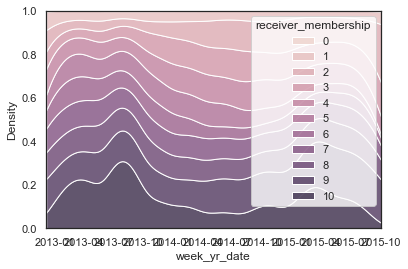

In [48]:
hue_order_l = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
sns.set(rc={'figure.figsize':(12,8)})
sns.set_style("white")
sns.kdeplot(data=successful_creators_receiver_memb,
            x="week_yr_date",
            hue="receiver_membership",
            hue_order= hue_order_l,
            multiple="fill",
            #weights="Val",
            bw_adjust = 1)

In [49]:
def plot_learning(data, number, title):
    
    
    data_grouped = data.groupby('week_yr_date', as_index = False).size()
    
    lim_inf = min(data.date_sent)
    lim_sup = max(data.date_sent)
    
    fig, ax = plt.subplots(figsize=(15, 9))
    column_list = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
    hue_order_l = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']

    sns.set(rc={'figure.figsize':(12,8)})
    sns.set_style("white")
    sns.kdeplot(data=data,
            x="week_yr_date",
            hue="receiver_membership",
            hue_order= hue_order_l,
            multiple="fill",
            #weights="Val",
            bw_adjust = 1)\
    .set(xlim=(lim_inf, lim_sup), title='Figure {}: {} - Share of trials per receiver type.'.format(number, title), xlabel='Week',
     ylabel='Share')
    
    ax2 = plt.twinx()
    sns.lineplot(data=data_grouped,
                 x = "week_yr_date", 
                 y = "size", 
                 color="black", 
                 ax=ax2, 
                 legend = 'auto',
                 linewidth = 3)\
    .set(ylabel='Total Promotional Actions', yscale="log")
    
    ax.legend(title='Costumer type', loc='lower left', labels = ['10', '9', '8', '7', '6', '5', '4', '3', '2', '1']);

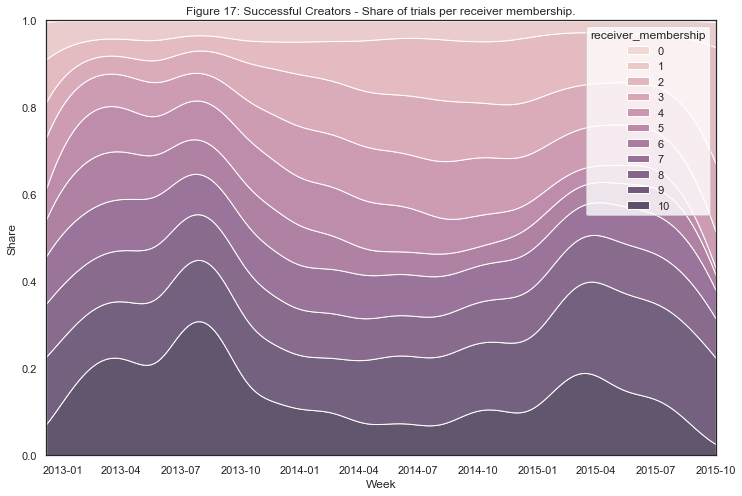

In [50]:
plot_learning(successful_creators_receiver_memb, 17, 'Successful Creators')

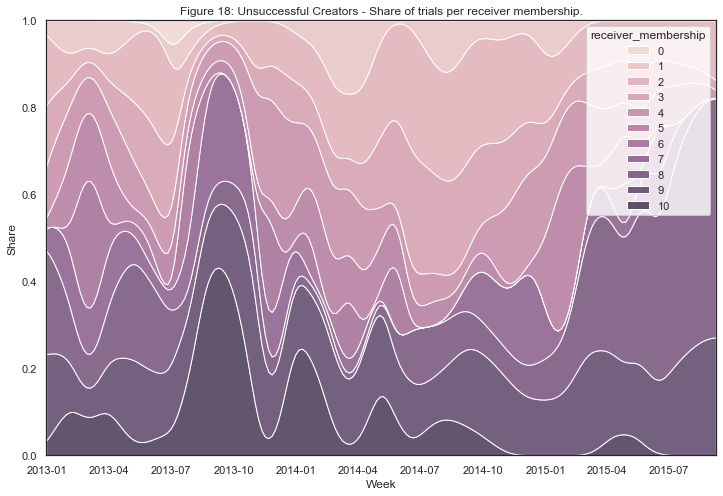

In [51]:
plot_learning(unsuccessful_creators_receiver_memb, 18, 'Unsuccessful Creators')





In [ ]:
unsuccessful_creators_receiver_memb.receiver_membership.value_counts()

In [ ]:
successful_creators_receiver_memb